# Data preparation

## Introduction 

This notebook will replicate this program from Jason Brownlee's Machine Learning Mastery post given [here](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/). The aim is to get an understanding of how to work with simple .jpg files in making machine learning algorithms. The task in this post is to take an image as input and predict whether that image contains one of seventeen land types. The inputs are (128 X 128) images of Amazon rainforest area. The post makes a convolutional neural net to make predictions.

The first set of code prepares the data. This code is meant to be run only once to load the images, convert them into numerical arrays, compress them, and store them in a format called .npz. Because it is meant to be run only once, currently there are no function calls for this code. The second part of the code is the model set-up and training. Everything is the same as in the blog post except for we have removed one hidden layer from the neural network just to speed up training to get the process correct.

## Housekeeping

The block below imports the packages needed for preparing the data. The imports all get used in the code. **Pandas** is needed to read .csv files. **Numpy** provides fast numerical array operations. **Keras** is the deep learning framework we are using. **OS** allows us to perform actions like listing all the files in a particular folder. **Matplotlib** lets us make model evaluation plots.

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import tensorflow as tf

from matplotlib import pyplot 
from matplotlib.image import imread

Using TensorFlow backend.


The code block below sets the size of the plot. The default plot size in notebooks is very big. This takes care of that by making the plots smaller and easier to see. This makes sense here since we are going to be making only simple plots like looking at satellite imagery or training/test error plots which don't need to be very huge.

In [2]:
# Set plot size
pyplot.rcParams['figure.figsize'] = [15, 10]

## Set the parameters

We are using a Python library called **papermill** to run the notebook from the command line. **Papermill** looks for a cell in the notebook with the tag **parameters** like below and then either uses the values specified in this cell as the parameter values or over-rides these values with those that are supplied using the command line. 

In [3]:
# This sets whether we want parameters or not
train = False

# We want detailed output at the end of every epoch
verbose = 1

# Epochs
epochs = 1

# Batch size
batch_size = 128

# Learning rate
lr = 0.05

# Momentum
momentum = 0.9

# Shape of expected inputs output
in_shape=(32, 32, 3)

# Shape of expected output
out_shape=17

In [4]:
# Parameters
epochs = 100
train = True


## Look at the images

We start off by writing a function which plots 9 images that are located in the image folder. We want to plot the 9 purely for reasons of convenience. We will otherwise have to write formatting code for the subplots which is not worth the time. First we write a function which samples 9 images from the data-set. It then sends a list of the 9 sampled file names to the second function. 

This function plots the raw pixel data of the .jpg images in the notebook. The **imread** function from matplotlib loads the image. The **imshow** function in pyplot creates the plot and adds it to the sub-plot. The entire sub-plot is shown once the loop exits.

In [5]:
def get_sample(folder = 'train-jpg'):
    '''
    Input: File path
    Output: Sample of 9 images to plot from training set
    '''
    # List all files in dir
    files = [f for f in os.listdir(folder)]
    # Select sixteen files randomly
    random_files = np.random.choice(files, size = 16, replace = False)
    # Return
    return(random_files)

In [6]:
def plot_first_sixteen(sample, folder = 'train-jpg/'):
    '''
    Input: File path to training data.
    Output: Plot of first 9 images in training data.
    
    We plot 9 images because otherwise we will have to
    write formatting code for the sub-plot which is not
    worth the time.
    '''
    for i in range(16):
        # pyplot.subplot takes 3 digit code 
        # The first number is the number of rows
        # The second number is the number of columns
        # The third number is the position in the subplot 
        pyplot.subplot(4, 4, 1 + i)
        # Load image pixels
        image = imread(folder + sample[i])
        # Plot raw pixel data
        pyplot.imshow(image)
    # Show the figure
    pyplot.show()
    # End the function
    return

Now we can call the functions from above to actually take a look at the output. There will be a different random sample taken every time. **Note that these function calls are for testing and demonstration only**.

In [7]:
if not train: 

    # Create a sample
    sample = get_sample()

    # Plot the first sixteen images
    plot_first_sixteen(sample)

## Creating a mapping data-frame

**train_v2.csv** is a .csv file that has two columns. The first column is the name of the image. The second column is a string that contains all the labels that apply to that image. An example first column observation is **'train_0.jpg'.** An example second column observation is **'haze forest cloud'.** The function below takes the file name as input and returns a pandas data-frame version of this file for the code to use later.

In [8]:
def load_mapping_data(file_name = 'train_v2.csv'):
    '''
    Input: mapping file name
    Output: mapping file data-frame
    '''
    mapping_df = pd.read_csv(file_name)
    
    return(mapping_df)

In [9]:
if not train:

    # Call the function and check out the output
    mapping_df = load_mapping_data()

The data-frame has approximately 40000 rows and 2 columns.

In [10]:
if not train:

    # Print out the shape of the mapping frame
    print(pd.DataFrame(list(mapping_df.shape), index = ['Rows', 'Columns'], columns = ['']))

We print the first few rows of this data-frame just to get an idea of what everything looks like. These are given below. We can tell from this output that this is a **multi-label classification** problem and not a **multi-class classification problem.**

In [11]:
if not train:

    # Print out the first few rows
    print(mapping_df.head())

## Creating tag mapping

The labels are given in the form of strings. We need to convert them into numbers because our eventual machine learning model will operate on numerical values. The function below takes the mapping data-frame and first gets the unique labels that occur in the data-frame. It then creates two dictionaries. The first dictionary relates string labels to integer values and the second dictionary goes the other way around and relates integer values to labels. These dictionaries are then returned for the code to use.

In [12]:
def create_tag_mapping(mapping_df):
    '''
    Input: mapping data-frame
    Output: Dictionary mapping labels to integers.
    '''
    # Initialize labels
    # Labels is a set so calling update will not affect uniqueness
    labels = set()
    
    # Loop through the data-frame
    # Split the tag values on spaces
    # Then update the set with the tags
    for i in range(len(mapping_df)):
        tags = mapping_df['tags'][i].split(' ')
        labels.update(tags)
    
    # Turn into a list and sort
    labels = list(labels)
    labels.sort()
    
    # First relate labels to integers
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    
    # Return statement
    return(labels_map, inv_labels_map)

In [13]:
if not train:
    
    # Function call
    labels_map, inv_labels_map = create_tag_mapping(mapping_df)

### Labels: Integers

This is the mapping of labels to integers.

In [14]:
if not train:

    # Print to display output
    print(labels_map)

### Integers:Labels

This is the mapping from integers to labels.

In [15]:
if not train:

    # Print to display output
    print(inv_labels_map)

## Create a mapping dictionary

We have the labels associated with each file in the data-frame but we need these labels to be in the form of a dictionary to use in the deep learning model later. This function takes in the data-frame and then goes through it row by row. For each row it extracts the file name and the tags and puts them in separate variables. It then adds a new entry to a mapping dictionary where the key is the file name and the tag is the list of tags. Note that the split command used below takes the dataframe string entry and splits it on spaces and then finally creates a list from it. This is then returned.

In [16]:
def create_file_mapping(mapping_df):
    '''
    Input: mapping data-frame
    Output: mapping dictionary of filename to tags
    '''
    # Initialize the dictionary
    mapping = dict()
    
    # Iterate through the data-frame range
    for i in range(len(mapping_df)):
        # Store names and tags
        name, tags = mapping_df['image_name'][i], mapping_df['tags'][i]
        # Put them in the dictionary as name:tag key value pairs
        mapping[name] = tags.split(' ')
    
    # Return mapping
    return mapping

### Mapping in dictionary form

Now we test out the function and display the first two key-value pairs to give an idea of the data format.

In [17]:
if not train:

    # Test function call
    mapping_dict = create_file_mapping(mapping_df)

    # Print to display output
    print({k: mapping_dict[k] for k in list(mapping_dict)[:2]})

## One-hot encoding the labels

We need to do one-hot encoding of the labels. This is because there are 17 possible tags. We want to create a vector of 0s and 1s such that an element in the vector takes the value 1 only if the label of that image corresponds to the position of the element. So say that the label of a particular image is 'forest' which has integer value 7. Then in the 17 element vector we want only the 7th element to be 1 and the rest of the element values to be zero. This function takes in tags and the tag to integer mapping and returns the needed encoding.

In [18]:
def one_hot_encode(tags, labels_map):
    '''
    There are 17 elements in tag. 
    We want a 17 element vector of 0s and 1s.
    Each element should be 1 if the corresponding
    category is in the image file and 0 otherwise.
    '''
    # Create empty vector
    encoding = np.zeros(len(labels_map), dtype='uint8')
    # Mark 1 for each tag in the vector
    for tag in tags:
        encoding[labels_map[tag]] = 1
    return encoding

In [19]:
if not train:

    # Test function call
    print(one_hot_encode(['agriculture', 'clear', 'primary', 'water'], labels_map))

## Compress the dataset

We need to compress the dataset because it may cause local laptop to crash. This function iterates through the folder. For each image it uses the **keras** function **load_img** to load this. Then it converts this to a numerical **numpy array** using the **img_to_array** function which is also from **keras.** Then we retreive the tags from the image. Finally we one-hot encode these tags. Then we append to the pre-created list of **photos** and **targets** respectively. Finally we convert these lists into **numpy arrays** of **unsigned integers**.

In [20]:
def compress_dataset(path, file_mapping, tag_mapping, target_size = (128, 128)):
    '''
    Inputs: 1) Folder: Path to training folder
            2) Images file path: Path to training data images within training folder
            3) File mapping: Mapping of training images to their labels
            4) Tag mapping:  One to one mapping of labels to integers
            5) Target size:  Size that input images should be cropped to
    Output: 1) Training data and labels as numpy arrays of unsigned integers
    
    Why is path separately specified? 
    This is probably to ensure that if images are stored remotely like on Amazon S3 
    then this parameter can be easily changed to get data from there. 
    '''
    # Photos and targets stored here
    photos, targets = list(), list()
    # Enumerate files in the directory

    for filename in os.listdir(path):
        # Load image
        photo = keras.preprocessing.image.load_img(path + filename, target_size=target_size)
        # Convert to numpy array
        photo = keras.preprocessing.image.img_to_array(photo, dtype='uint8')
        # Get tags
        tags = file_mapping[filename[:-4]]
        # One hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # Store photos 
        photos.append(photo)
        # Store targets
        targets.append(target) 

    # We know color channel values go from 0 to 255 and will not be negative
    # Convert to arrays while making data type unsigned
    # Unsigned integer saves space 
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    
    return(X, y)


## Prepare data

The function below just calls the functions from above to execute the pipeline. Note that the target size default value is 32 X 32 to save space assuming that you will run this notebook on your local machine. There is no function call as of now because this is a one time-task. A file called 'planet-data.npz' which is the compressed version of the data-set is stored in the working directory.

In [21]:
def prep_data(folder = 'train-jpg/', target_size = (32, 32)):    
    '''
    Input: None 
    Output: None 
    Description: 
    This is a function that is run for its side effect.
    It runs the code to take in raw images and return single compressed file.
    '''
    # First take a sample
    sample = get_sample()
    # Plot the first sixteen images
    plot_first_sixteen(sample)
    # Create mapping data-frame
    mapping_df = load_mapping_data()
    # Create tag mapping
    labels_map, inv_labels_map = create_tag_mapping(mapping_df)
    # Create file mapping
    mapping = create_file_mapping(mapping_df)
    # Load data-set
    X, y = compress_dataset(folder, mapping, labels_map, target_size)
    # Print X.shape, y.shape
    print(X.shape, y.shape)
    # Save both arrays to one file in compressed format
    np.savez_compressed('planet_data.npz', X, y)
    # End of function
    return

In [22]:
if not train:
    prep_data()

# Benchmark model

In [23]:
# Housekeeping imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras import backend

## Train-test split

First we have to load the compressed data-set we created earlier and split it into training and testing data. The function below does this using the sci-kit model selection module. It prints out the shape of the data-sets as a sanity check.

In [24]:
def load_dataset():
    '''
    Input: N/A
    Output: Planet data split into train and test
    '''
    # Load dataset
    data = np.load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']

    # Separate into train and test datasets
    trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=1)
    # Print out shapes as a sanity check
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    
    # Create data generators
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, 
                                       vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
        
    # Return both forms of data-sets
    return(trainX, trainY, testX, testY, train_datagen, test_datagen)

## Custom metric

Keras v2.0.0 currently does not support the F-beta loss function for multi-label classification. The F-beta loss function is a weighted average of precision and recall. Over here we use it only as a metric to measure the performance of the model but not in the actual training. The winning score in the competition is approximately 93%. The function given below is just coding this function manually. 

In [25]:
# Calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    '''
    This function is manually written here.
    This is because this competition uses F-beta score as a metric.
    This metric is no longer supported by Keras as v.2.0.0. There is
    a Kaggle kernel which proposes the function given below as a fix
    for this. Until then we use the function code given in the post
    to measure our model's performance.
    
    Open questions: 
    What is the keras.backend module? 
    What does karas.backend.clip do? 
    What does keras.backend.round do? 
    What does keras.backend.epsilon do? 
    '''
    # Clip predictions
    y_pred = keras.backend.clip(y_pred, 0, 1)

    # Calculate true positives
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    
    # Calculate false positives
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)), axis=1)
    
    # Calculate false negatives
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)), axis=1)
    
    # Calculate precision
    p = tp / (tp + fp + keras.backend.epsilon())
    
    # Calculate recall
    r = tp / (tp + fn + keras.backend.epsilon())
    # Calculate fbeta, averaged across each class
    bb = beta ** 2
    # F-beta score final calculation
    fbeta_score = keras.backend.mean((1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon()))
    # Return statement
    return(fbeta_score)


## All ones prediction

A standard benchmark to decide whether any machine learning model is useful is if our algorithm can get a better score than if we just blindly predict 1 for each and every image we get. The function below implements this all-1s algorithm and returns the score. If the deep learning model that we create later on can do better than this than it is adding value over and above this.

In [26]:
def benchmark(trainX, trainY, testX, testY):
    '''
    Input: Training and test datasets and labels
    Output: Training and test score if we just always predict ones
    '''
    # Make all one predictions
    train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
    test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])
    
    # Evaluate predictions with sklearn
    train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
    test_score = fbeta_score(testY, test_yhat, 2, average='samples')
    print('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))

    # Evaluate predictions with keras
    train_score = fbeta(keras.backend.variable(trainY), keras.backend.variable(train_yhat))
    test_score = fbeta(keras.backend.variable(testY), keras.backend.variable(test_yhat))
    print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))
    

    # Return the train and test sets for future use
    return(train_score, test_score)


# Baseline convolutional neural net

In [27]:
# Baseline model for the Planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Dropout
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random


## Define model

The model below is a convolutional neural network with maximum pooling and same padding. It uses **sigmoid activation** in the output layer and **RELU activation** in the hidden layers. The output of the function is a **keras model object.** We use the **binary cross entropy loss**. We also track the **F-beta score** metric according to the custom function defined above.

In [28]:
def define_model(in_shape=(32, 32, 3), out_shape=17, lr = 0.05, momentum = 0.9, opt = 'Adam'):
    '''
    Input: Input shape and output shape
    Output: Keras model object
    '''
    # Define model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(out_shape, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta, keras.metrics.accuracy])
        

    return model


## Create diagnostic plots

The function below creates diagnostic plots for easier checking at the end of training. It plots both the loss function and the F-beta score function for training and test. Example plots can be seen in the repository.

In [29]:
# Import packges
import os
import time

In [30]:
def summarize_diagnostics(history):
    '''
    Input: Keras history project
    Output: Display diagnostic learning curves
    '''
    # Plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    # Plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
    
    # Save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [31]:
def make_tensorboard_directory():
    '''
    Input: N/A
    Output: Tensorboard directory path
    '''
    root_logdir = os.path.join(os.curdir, "my_logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    
    return(os.path.join(root_logdir, run_id))

## Hyperparameter optimization

In [32]:
# We will wrap our model as a Keras Classifier object
# We import the GridSearchCV package
# We import the Keras classifier package
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [33]:
def choose_parameters(X, Y, trainX, trainY, testX, testY, 
                      opt = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], 
                      epochs=1, batch_size = 10):    
    '''
    Input: 1) Training set
           2) Validation set
           3) List of optimizers to try
           4) No. of epochs eash search of the grid will use
           5) Batch size
           
    Output: Best parameters along with accuracy metric
    '''
    
    # Create model
    model = KerasClassifier(build_fn=define_model, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Create the parameter dictionary
    param_grid = dict(opt=opt)
    
    # Prepare iterators
    train_flow = X.flow(trainX, trainY, batch_size=batch_size)
    test_flow = Y.flow(testX, testY, batch_size=batch_size)
    
    # Get the datasets
    train_X, train_Y = train_flow.next()
    
    # Create the grid search instance
    # We use 3 fold cross-validation
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
    grid_result = grid.fit(train_X, train_Y)

    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return

## Train the network 

The code below runs the training algorithm for the neural network. It calls the **load_dataset()** function to create training and testing data-sets. It then specifies to **checkpoint** variables. The first checkpoint variable tells **keras** to save a copy of the latest results and estimates to a file called **my_keras_model.h5**. The next checkpoint **early_stopping_cb** specifies that we want training to stop if there is no improvement seen for a particular no. of batches. The **patience** parameter is set to 10. This means that training will automatically stop if there is no improvement seen for 10 successive batches.

In [34]:
def run_test_harness(train_datagen, test_datagen, epochs = 2, verbose = 1, batch_size = 128, lr = 0.05, 
                     momentum = 0.9, in_shape=(32, 32, 3), out_shape=17):
    '''
    Input: None
    Output: None
    Run the test harness for evaluating a model
    '''    
    # Add checkpoints for regular saving
    checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    
    # Add TensorBoard logging
    tensorboard_cb = keras.callbacks.TensorBoard(make_tensorboard_directory())

    # Prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=batch_size)
    test_it = test_datagen.flow(testX, testY, batch_size=batch_size)
    
    # Define model
    model = define_model(in_shape, out_shape, lr, momentum)
    
    # Fit model
    history = model.fit_generator(train_it, 
                                  steps_per_epoch=len(train_it), 
                                  validation_data=test_it, validation_steps=len(test_it), 
                                  callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb], 
                                  epochs=epochs, 
                                  verbose=1)
    # Evaluate model
    loss, fbeta, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f, accuracy=%.3f' % (loss, fbeta, accuracy))
    
    # Learning curves
    summarize_diagnostics(history)

## Execution

Now we are finally ready to train our model. First we will create the datasets we need for the deep-learning pipeline. Then we will benchmark the model against the all-ones predictions given above. Then we will choose hyper-parameters via grid search. This can be easily substituted with another method like randomized search. Next we will train the model.

In [35]:
# Load dataset
trainX, trainY, testX, testY, train_datagen, test_datagen = load_dataset()
    
# Run benchmark
results = benchmark(trainX, trainY, testX, testY)

# Optimize hyperparameters
choose_parameters(train_datagen, test_datagen, trainX, trainY, testX, testY)

(28335, 32, 32, 3) (28335, 17) (12144, 32, 32, 3) (12144, 17)


All Ones (sklearn): train=0.484, test=0.484
All Ones (keras): train=0.484, test=0.484


Best: 0.549020 using {'opt': 'Adagrad'}
0.000000 (0.000000) with: {'opt': 'SGD'}
0.000000 (0.000000) with: {'opt': 'RMSprop'}
0.549020 (0.391175) with: {'opt': 'Adagrad'}
0.000000 (0.000000) with: {'opt': 'Adadelta'}
0.000000 (0.000000) with: {'opt': 'Adam'}
0.000000 (0.000000) with: {'opt': 'Adamax'}
0.000000 (0.000000) with: {'opt': 'Nadam'}


In [36]:
# Entry point
# Run the test harness to see whether everything is working fine
if train: run_test_harness(train_datagen, test_datagen, 
                           epochs, verbose, batch_size, 
                           lr, momentum, in_shape, 
                           out_shape)

Epoch 1/100


  1/222 [..............................] - ETA: 2:14 - loss: 0.8069 - fbeta: 0.2485 - accuracy: 0.0000e+00

  2/222 [..............................] - ETA: 1:25 - loss: 0.6752 - fbeta: 0.3133 - accuracy: 0.0000e+00

  3/222 [..............................] - ETA: 1:08 - loss: 0.6000 - fbeta: 0.3101 - accuracy: 0.0000e+00

  4/222 [..............................] - ETA: 58s - loss: 0.5434 - fbeta: 0.3491 - accuracy: 0.0000e+00 

  5/222 [..............................] - ETA: 52s - loss: 0.5139 - fbeta: 0.3939 - accuracy: 9.1912e-05

  6/222 [..............................] - ETA: 47s - loss: 0.4937 - fbeta: 0.4231 - accuracy: 1.5319e-04

  7/222 [..............................] - ETA: 45s - loss: 0.4777 - fbeta: 0.4510 - accuracy: 1.3130e-04

  8/222 [>.............................] - ETA: 43s - loss: 0.4652 - fbeta: 0.4669 - accuracy: 1.1489e-04

  9/222 [>.............................] - ETA: 41s - loss: 0.4547 - fbeta: 0.4797 - accuracy: 1.0212e-04

 10/222 [>.............................] - ETA: 40s - loss: 0.4448 - fbeta: 0.4844 - accuracy: 9.1912e-05

 11/222 [>.............................] - ETA: 38s - loss: 0.4362 - fbeta: 0.4858 - accuracy: 8.3556e-05

 12/222 [>.............................] - ETA: 37s - loss: 0.4283 - fbeta: 0.4875 - accuracy: 7.6593e-05

 13/222 [>.............................] - ETA: 37s - loss: 0.4212 - fbeta: 0.4861 - accuracy: 7.0701e-05

 14/222 [>.............................] - ETA: 36s - loss: 0.4138 - fbeta: 0.4876 - accuracy: 6.5651e-05

 15/222 [=>............................] - ETA: 35s - loss: 0.4078 - fbeta: 0.4900 - accuracy: 6.1275e-05

 16/222 [=>............................] - ETA: 34s - loss: 0.4047 - fbeta: 0.4909 - accuracy: 5.7445e-05

 17/222 [=>............................] - ETA: 34s - loss: 0.4002 - fbeta: 0.4950 - accuracy: 5.4066e-05

 18/222 [=>............................] - ETA: 33s - loss: 0.3954 - fbeta: 0.5014 - accuracy: 5.1062e-05

 19/222 [=>............................] - ETA: 33s - loss: 0.3913 - fbeta: 0.5074 - accuracy: 4.8375e-05

 20/222 [=>............................] - ETA: 32s - loss: 0.3872 - fbeta: 0.5148 - accuracy: 4.5956e-05

 21/222 [=>............................] - ETA: 32s - loss: 0.3830 - fbeta: 0.5204 - accuracy: 4.3768e-05

 22/222 [=>............................] - ETA: 31s - loss: 0.3796 - fbeta: 0.5241 - accuracy: 4.1778e-05

 23/222 [==>...........................] - ETA: 31s - loss: 0.3752 - fbeta: 0.5299 - accuracy: 3.9962e-05

 24/222 [==>...........................] - ETA: 31s - loss: 0.3724 - fbeta: 0.5325 - accuracy: 3.8297e-05

 25/222 [==>...........................] - ETA: 30s - loss: 0.3699 - fbeta: 0.5356 - accuracy: 3.6765e-05

 26/222 [==>...........................] - ETA: 30s - loss: 0.3663 - fbeta: 0.5390 - accuracy: 3.5351e-05

 27/222 [==>...........................] - ETA: 30s - loss: 0.3629 - fbeta: 0.5417 - accuracy: 3.4041e-05

 28/222 [==>...........................] - ETA: 29s - loss: 0.3598 - fbeta: 0.5450 - accuracy: 3.2826e-05

 29/222 [==>...........................] - ETA: 29s - loss: 0.3568 - fbeta: 0.5473 - accuracy: 3.1694e-05

 30/222 [===>..........................] - ETA: 29s - loss: 0.3546 - fbeta: 0.5486 - accuracy: 3.0637e-05

 31/222 [===>..........................] - ETA: 29s - loss: 0.3515 - fbeta: 0.5507 - accuracy: 2.9649e-05

 32/222 [===>..........................] - ETA: 28s - loss: 0.3501 - fbeta: 0.5523 - accuracy: 2.8722e-05

 33/222 [===>..........................] - ETA: 28s - loss: 0.3476 - fbeta: 0.5552 - accuracy: 2.7852e-05

 34/222 [===>..........................] - ETA: 28s - loss: 0.3455 - fbeta: 0.5572 - accuracy: 2.7033e-05

 35/222 [===>..........................] - ETA: 27s - loss: 0.3433 - fbeta: 0.5597 - accuracy: 2.6261e-05

 36/222 [===>..........................] - ETA: 27s - loss: 0.3412 - fbeta: 0.5618 - accuracy: 2.5531e-05

 37/222 [====>.........................] - ETA: 27s - loss: 0.3390 - fbeta: 0.5636 - accuracy: 2.4841e-05

 38/222 [====>.........................] - ETA: 27s - loss: 0.3371 - fbeta: 0.5654 - accuracy: 2.4187e-05

 39/222 [====>.........................] - ETA: 26s - loss: 0.3357 - fbeta: 0.5671 - accuracy: 2.3567e-05

 40/222 [====>.........................] - ETA: 26s - loss: 0.3331 - fbeta: 0.5701 - accuracy: 2.2978e-05

 41/222 [====>.........................] - ETA: 26s - loss: 0.3313 - fbeta: 0.5712 - accuracy: 2.2418e-05

 42/222 [====>.........................] - ETA: 26s - loss: 0.3302 - fbeta: 0.5720 - accuracy: 2.1884e-05

 43/222 [====>.........................] - ETA: 26s - loss: 0.3287 - fbeta: 0.5736 - accuracy: 2.1375e-05

 44/222 [====>.........................] - ETA: 25s - loss: 0.3274 - fbeta: 0.5752 - accuracy: 2.0889e-05

 45/222 [=====>........................] - ETA: 25s - loss: 0.3255 - fbeta: 0.5768 - accuracy: 2.0425e-05

 46/222 [=====>........................] - ETA: 25s - loss: 0.3239 - fbeta: 0.5783 - accuracy: 1.9981e-05

 47/222 [=====>........................] - ETA: 25s - loss: 0.3227 - fbeta: 0.5800 - accuracy: 1.9556e-05

 48/222 [=====>........................] - ETA: 25s - loss: 0.3216 - fbeta: 0.5813 - accuracy: 1.9148e-05

 49/222 [=====>........................] - ETA: 24s - loss: 0.3207 - fbeta: 0.5815 - accuracy: 1.8758e-05

 50/222 [=====>........................] - ETA: 24s - loss: 0.3193 - fbeta: 0.5828 - accuracy: 1.8382e-05

 51/222 [=====>........................] - ETA: 24s - loss: 0.3182 - fbeta: 0.5833 - accuracy: 1.8022e-05

 52/222 [======>.......................] - ETA: 24s - loss: 0.3168 - fbeta: 0.5850 - accuracy: 1.7675e-05

 53/222 [======>.......................] - ETA: 24s - loss: 0.3154 - fbeta: 0.5863 - accuracy: 1.7342e-05

 54/222 [======>.......................] - ETA: 24s - loss: 0.3140 - fbeta: 0.5879 - accuracy: 1.7021e-05

 55/222 [======>.......................] - ETA: 23s - loss: 0.3130 - fbeta: 0.5886 - accuracy: 1.6711e-05

 56/222 [======>.......................] - ETA: 23s - loss: 0.3119 - fbeta: 0.5899 - accuracy: 1.6413e-05

 57/222 [======>.......................] - ETA: 23s - loss: 0.3110 - fbeta: 0.5905 - accuracy: 1.6125e-05

 58/222 [======>.......................] - ETA: 23s - loss: 0.3099 - fbeta: 0.5914 - accuracy: 1.5847e-05

 59/222 [======>.......................] - ETA: 23s - loss: 0.3088 - fbeta: 0.5921 - accuracy: 1.5578e-05

 60/222 [=======>......................] - ETA: 23s - loss: 0.3078 - fbeta: 0.5928 - accuracy: 1.5319e-05

 61/222 [=======>......................] - ETA: 22s - loss: 0.3067 - fbeta: 0.5937 - accuracy: 1.5068e-05

 62/222 [=======>......................] - ETA: 22s - loss: 0.3061 - fbeta: 0.5941 - accuracy: 1.4824e-05

 63/222 [=======>......................] - ETA: 22s - loss: 0.3055 - fbeta: 0.5941 - accuracy: 1.4589e-05

 64/222 [=======>......................] - ETA: 22s - loss: 0.3051 - fbeta: 0.5942 - accuracy: 1.4361e-05

 65/222 [=======>......................] - ETA: 22s - loss: 0.3043 - fbeta: 0.5945 - accuracy: 1.4140e-05

 66/222 [=======>......................] - ETA: 22s - loss: 0.3037 - fbeta: 0.5946 - accuracy: 1.3926e-05

 67/222 [========>.....................] - ETA: 21s - loss: 0.3030 - fbeta: 0.5951 - accuracy: 1.3718e-05

 68/222 [========>.....................] - ETA: 21s - loss: 0.3021 - fbeta: 0.5962 - accuracy: 1.3516e-05

 69/222 [========>.....................] - ETA: 21s - loss: 0.3012 - fbeta: 0.5970 - accuracy: 1.3321e-05

 70/222 [========>.....................] - ETA: 21s - loss: 0.3005 - fbeta: 0.5973 - accuracy: 1.3130e-05

 71/222 [========>.....................] - ETA: 21s - loss: 0.2995 - fbeta: 0.5979 - accuracy: 1.2945e-05

 72/222 [========>.....................] - ETA: 21s - loss: 0.2987 - fbeta: 0.5985 - accuracy: 1.2766e-05

 73/222 [========>.....................] - ETA: 20s - loss: 0.2979 - fbeta: 0.5989 - accuracy: 1.2591e-05

 74/222 [=========>....................] - ETA: 20s - loss: 0.2971 - fbeta: 0.5994 - accuracy: 1.2421e-05

 75/222 [=========>....................] - ETA: 20s - loss: 0.2961 - fbeta: 0.6000 - accuracy: 1.2255e-05

 76/222 [=========>....................] - ETA: 20s - loss: 0.2952 - fbeta: 0.6008 - accuracy: 1.2094e-05

 77/222 [=========>....................] - ETA: 20s - loss: 0.2949 - fbeta: 0.6002 - accuracy: 1.1937e-05

 78/222 [=========>....................] - ETA: 20s - loss: 0.2942 - fbeta: 0.6007 - accuracy: 1.1784e-05

 79/222 [=========>....................] - ETA: 20s - loss: 0.2935 - fbeta: 0.6011 - accuracy: 1.1634e-05

 80/222 [=========>....................] - ETA: 19s - loss: 0.2926 - fbeta: 0.6015 - accuracy: 1.1489e-05

 81/222 [=========>....................] - ETA: 19s - loss: 0.2920 - fbeta: 0.6016 - accuracy: 1.1347e-05

 82/222 [==========>...................] - ETA: 19s - loss: 0.2912 - fbeta: 0.6024 - accuracy: 1.1209e-05

 83/222 [==========>...................] - ETA: 19s - loss: 0.2909 - fbeta: 0.6024 - accuracy: 1.1074e-05

 84/222 [==========>...................] - ETA: 19s - loss: 0.2902 - fbeta: 0.6031 - accuracy: 1.0942e-05

 85/222 [==========>...................] - ETA: 19s - loss: 0.2896 - fbeta: 0.6035 - accuracy: 1.0813e-05

 86/222 [==========>...................] - ETA: 18s - loss: 0.2891 - fbeta: 0.6036 - accuracy: 1.0687e-05

 87/222 [==========>...................] - ETA: 18s - loss: 0.2884 - fbeta: 0.6046 - accuracy: 1.0565e-05

 88/222 [==========>...................] - ETA: 18s - loss: 0.2879 - fbeta: 0.6046 - accuracy: 1.0445e-05

 89/222 [===========>..................] - ETA: 18s - loss: 0.2872 - fbeta: 0.6053 - accuracy: 1.0327e-05

 90/222 [===========>..................] - ETA: 18s - loss: 0.2869 - fbeta: 0.6056 - accuracy: 1.0212e-05

 91/222 [===========>..................] - ETA: 18s - loss: 0.2865 - fbeta: 0.6054 - accuracy: 1.0100e-05

 92/222 [===========>..................] - ETA: 17s - loss: 0.2858 - fbeta: 0.6059 - accuracy: 9.9904e-06

 93/222 [===========>..................] - ETA: 17s - loss: 0.2855 - fbeta: 0.6057 - accuracy: 9.8830e-06

 94/222 [===========>..................] - ETA: 17s - loss: 0.2849 - fbeta: 0.6060 - accuracy: 9.7778e-06

 95/222 [===========>..................] - ETA: 17s - loss: 0.2844 - fbeta: 0.6061 - accuracy: 9.6749e-06

 96/222 [===========>..................] - ETA: 17s - loss: 0.2840 - fbeta: 0.6058 - accuracy: 9.5741e-06

 97/222 [============>.................] - ETA: 17s - loss: 0.2835 - fbeta: 0.6066 - accuracy: 9.4754e-06

 98/222 [============>.................] - ETA: 17s - loss: 0.2828 - fbeta: 0.6073 - accuracy: 9.3788e-06

 99/222 [============>.................] - ETA: 16s - loss: 0.2823 - fbeta: 0.6078 - accuracy: 9.2840e-06

100/222 [============>.................] - ETA: 16s - loss: 0.2820 - fbeta: 0.6079 - accuracy: 9.1912e-06

101/222 [============>.................] - ETA: 16s - loss: 0.2819 - fbeta: 0.6078 - accuracy: 9.1002e-06

102/222 [============>.................] - ETA: 16s - loss: 0.2813 - fbeta: 0.6084 - accuracy: 9.0110e-06

103/222 [============>.................] - ETA: 16s - loss: 0.2807 - fbeta: 0.6089 - accuracy: 8.9235e-06

104/222 [=============>................] - ETA: 16s - loss: 0.2800 - fbeta: 0.6098 - accuracy: 8.8377e-06

105/222 [=============>................] - ETA: 16s - loss: 0.2794 - fbeta: 0.6107 - accuracy: 8.7535e-06

106/222 [=============>................] - ETA: 15s - loss: 0.2789 - fbeta: 0.6112 - accuracy: 8.6709e-06

107/222 [=============>................] - ETA: 15s - loss: 0.2784 - fbeta: 0.6117 - accuracy: 8.5899e-06

108/222 [=============>................] - ETA: 15s - loss: 0.2783 - fbeta: 0.6119 - accuracy: 8.5103e-06

109/222 [=============>................] - ETA: 15s - loss: 0.2778 - fbeta: 0.6125 - accuracy: 8.4323e-06

110/222 [=============>................] - ETA: 15s - loss: 0.2773 - fbeta: 0.6130 - accuracy: 8.3556e-06

111/222 [==============>...............] - ETA: 15s - loss: 0.2771 - fbeta: 0.6133 - accuracy: 8.2803e-06

112/222 [==============>...............] - ETA: 15s - loss: 0.2766 - fbeta: 0.6140 - accuracy: 8.2064e-06

113/222 [==============>...............] - ETA: 14s - loss: 0.2763 - fbeta: 0.6145 - accuracy: 8.1338e-06

114/222 [==============>...............] - ETA: 14s - loss: 0.2758 - fbeta: 0.6151 - accuracy: 8.0624e-06

115/222 [==============>...............] - ETA: 14s - loss: 0.2752 - fbeta: 0.6160 - accuracy: 7.9923e-06

116/222 [==============>...............] - ETA: 14s - loss: 0.2747 - fbeta: 0.6166 - accuracy: 7.9234e-06

117/222 [==============>...............] - ETA: 14s - loss: 0.2744 - fbeta: 0.6167 - accuracy: 7.8557e-06

118/222 [==============>...............] - ETA: 14s - loss: 0.2740 - fbeta: 0.6170 - accuracy: 7.7891e-06

119/222 [===============>..............] - ETA: 14s - loss: 0.2736 - fbeta: 0.6177 - accuracy: 7.7237e-06

120/222 [===============>..............] - ETA: 13s - loss: 0.2732 - fbeta: 0.6185 - accuracy: 7.6593e-06

121/222 [===============>..............] - ETA: 13s - loss: 0.2728 - fbeta: 0.6192 - accuracy: 7.5960e-06

122/222 [===============>..............] - ETA: 13s - loss: 0.2724 - fbeta: 0.6197 - accuracy: 7.5338e-06

123/222 [===============>..............] - ETA: 13s - loss: 0.2719 - fbeta: 0.6204 - accuracy: 7.4725e-06

124/222 [===============>..............] - ETA: 13s - loss: 0.2714 - fbeta: 0.6211 - accuracy: 7.4122e-06

125/222 [===============>..............] - ETA: 13s - loss: 0.2709 - fbeta: 0.6217 - accuracy: 7.3529e-06

126/222 [================>.............] - ETA: 13s - loss: 0.2706 - fbeta: 0.6220 - accuracy: 7.2946e-06

127/222 [================>.............] - ETA: 12s - loss: 0.2702 - fbeta: 0.6225 - accuracy: 7.2371e-06

128/222 [================>.............] - ETA: 12s - loss: 0.2698 - fbeta: 0.6229 - accuracy: 7.1806e-06

129/222 [================>.............] - ETA: 12s - loss: 0.2694 - fbeta: 0.6233 - accuracy: 7.1249e-06

130/222 [================>.............] - ETA: 12s - loss: 0.2691 - fbeta: 0.6230 - accuracy: 7.0701e-06

131/222 [================>.............] - ETA: 12s - loss: 0.2686 - fbeta: 0.6234 - accuracy: 7.0162e-06

132/222 [================>.............] - ETA: 12s - loss: 0.2683 - fbeta: 0.6238 - accuracy: 6.9630e-06

133/222 [================>.............] - ETA: 12s - loss: 0.2678 - fbeta: 0.6245 - accuracy: 6.9107e-06

134/222 [=================>............] - ETA: 11s - loss: 0.2675 - fbeta: 0.6248 - accuracy: 6.8591e-06

135/222 [=================>............] - ETA: 11s - loss: 0.2669 - fbeta: 0.6254 - accuracy: 6.8083e-06

136/222 [=================>............] - ETA: 11s - loss: 0.2666 - fbeta: 0.6261 - accuracy: 6.7582e-06

137/222 [=================>............] - ETA: 11s - loss: 0.2662 - fbeta: 0.6264 - accuracy: 6.7089e-06

138/222 [=================>............] - ETA: 11s - loss: 0.2659 - fbeta: 0.6266 - accuracy: 6.6603e-06

139/222 [=================>............] - ETA: 11s - loss: 0.2655 - fbeta: 0.6271 - accuracy: 6.6124e-06

140/222 [=================>............] - ETA: 11s - loss: 0.2654 - fbeta: 0.6274 - accuracy: 6.5651e-06

141/222 [==================>...........] - ETA: 11s - loss: 0.2651 - fbeta: 0.6278 - accuracy: 6.5186e-06

142/222 [==================>...........] - ETA: 10s - loss: 0.2649 - fbeta: 0.6279 - accuracy: 6.4727e-06

143/222 [==================>...........] - ETA: 10s - loss: 0.2645 - fbeta: 0.6283 - accuracy: 6.4274e-06

144/222 [==================>...........] - ETA: 10s - loss: 0.2643 - fbeta: 0.6287 - accuracy: 6.3828e-06

145/222 [==================>...........] - ETA: 10s - loss: 0.2642 - fbeta: 0.6287 - accuracy: 6.3387e-06

146/222 [==================>...........] - ETA: 10s - loss: 0.2640 - fbeta: 0.6289 - accuracy: 6.3227e-06

147/222 [==================>...........] - ETA: 10s - loss: 0.2638 - fbeta: 0.6292 - accuracy: 6.2795e-06

148/222 [===================>..........] - ETA: 10s - loss: 0.2634 - fbeta: 0.6296 - accuracy: 6.2369e-06

149/222 [===================>..........] - ETA: 9s - loss: 0.2631 - fbeta: 0.6302 - accuracy: 6.1949e-06 

150/222 [===================>..........] - ETA: 9s - loss: 0.2629 - fbeta: 0.6305 - accuracy: 6.1534e-06

151/222 [===================>..........] - ETA: 9s - loss: 0.2626 - fbeta: 0.6309 - accuracy: 6.1125e-06

152/222 [===================>..........] - ETA: 9s - loss: 0.2623 - fbeta: 0.6313 - accuracy: 6.0721e-06

153/222 [===================>..........] - ETA: 9s - loss: 0.2619 - fbeta: 0.6316 - accuracy: 6.0323e-06

154/222 [===================>..........] - ETA: 9s - loss: 0.2618 - fbeta: 0.6316 - accuracy: 5.9929e-06

155/222 [===================>..........] - ETA: 9s - loss: 0.2617 - fbeta: 0.6318 - accuracy: 5.9541e-06

156/222 [====================>.........] - ETA: 8s - loss: 0.2614 - fbeta: 0.6322 - accuracy: 5.9158e-06

157/222 [====================>.........] - ETA: 8s - loss: 0.2610 - fbeta: 0.6327 - accuracy: 5.8779e-06

158/222 [====================>.........] - ETA: 8s - loss: 0.2608 - fbeta: 0.6330 - accuracy: 5.8406e-06

159/222 [====================>.........] - ETA: 8s - loss: 0.2604 - fbeta: 0.6338 - accuracy: 5.8037e-06

160/222 [====================>.........] - ETA: 8s - loss: 0.2600 - fbeta: 0.6343 - accuracy: 5.7673e-06

161/222 [====================>.........] - ETA: 8s - loss: 0.2598 - fbeta: 0.6348 - accuracy: 5.7313e-06

162/222 [====================>.........] - ETA: 8s - loss: 0.2594 - fbeta: 0.6351 - accuracy: 5.6958e-06

163/222 [=====================>........] - ETA: 7s - loss: 0.2590 - fbeta: 0.6358 - accuracy: 5.6607e-06

164/222 [=====================>........] - ETA: 7s - loss: 0.2588 - fbeta: 0.6358 - accuracy: 5.6261e-06

165/222 [=====================>........] - ETA: 7s - loss: 0.2586 - fbeta: 0.6361 - accuracy: 5.5919e-06

166/222 [=====================>........] - ETA: 7s - loss: 0.2583 - fbeta: 0.6363 - accuracy: 5.5580e-06

167/222 [=====================>........] - ETA: 7s - loss: 0.2580 - fbeta: 0.6367 - accuracy: 5.5246e-06

168/222 [=====================>........] - ETA: 7s - loss: 0.2578 - fbeta: 0.6370 - accuracy: 5.4916e-06

169/222 [=====================>........] - ETA: 7s - loss: 0.2575 - fbeta: 0.6373 - accuracy: 5.4590e-06

170/222 [=====================>........] - ETA: 7s - loss: 0.2573 - fbeta: 0.6377 - accuracy: 5.4268e-06

171/222 [======================>.......] - ETA: 6s - loss: 0.2570 - fbeta: 0.6381 - accuracy: 5.3949e-06

172/222 [======================>.......] - ETA: 6s - loss: 0.2567 - fbeta: 0.6384 - accuracy: 5.3634e-06

173/222 [======================>.......] - ETA: 6s - loss: 0.2565 - fbeta: 0.6387 - accuracy: 5.3323e-06

174/222 [======================>.......] - ETA: 6s - loss: 0.2563 - fbeta: 0.6389 - accuracy: 5.3016e-06

175/222 [======================>.......] - ETA: 6s - loss: 0.2559 - fbeta: 0.6395 - accuracy: 5.2712e-06

176/222 [======================>.......] - ETA: 6s - loss: 0.2556 - fbeta: 0.6398 - accuracy: 5.2411e-06

177/222 [======================>.......] - ETA: 6s - loss: 0.2554 - fbeta: 0.6403 - accuracy: 5.2114e-06

178/222 [=======================>......] - ETA: 5s - loss: 0.2551 - fbeta: 0.6407 - accuracy: 5.1820e-06

179/222 [=======================>......] - ETA: 5s - loss: 0.2549 - fbeta: 0.6410 - accuracy: 5.1530e-06

180/222 [=======================>......] - ETA: 5s - loss: 0.2546 - fbeta: 0.6415 - accuracy: 5.1242e-06

181/222 [=======================>......] - ETA: 5s - loss: 0.2546 - fbeta: 0.6415 - accuracy: 5.0958e-06

182/222 [=======================>......] - ETA: 5s - loss: 0.2544 - fbeta: 0.6418 - accuracy: 5.0677e-06

183/222 [=======================>......] - ETA: 5s - loss: 0.2540 - fbeta: 0.6425 - accuracy: 5.0399e-06

184/222 [=======================>......] - ETA: 5s - loss: 0.2537 - fbeta: 0.6430 - accuracy: 5.0124e-06

185/222 [========================>.....] - ETA: 4s - loss: 0.2536 - fbeta: 0.6432 - accuracy: 4.9853e-06

186/222 [========================>.....] - ETA: 4s - loss: 0.2533 - fbeta: 0.6437 - accuracy: 4.9584e-06

187/222 [========================>.....] - ETA: 4s - loss: 0.2531 - fbeta: 0.6438 - accuracy: 4.9318e-06

188/222 [========================>.....] - ETA: 4s - loss: 0.2530 - fbeta: 0.6441 - accuracy: 4.9054e-06

189/222 [========================>.....] - ETA: 4s - loss: 0.2527 - fbeta: 0.6446 - accuracy: 4.8794e-06

190/222 [========================>.....] - ETA: 4s - loss: 0.2524 - fbeta: 0.6451 - accuracy: 4.8536e-06

191/222 [========================>.....] - ETA: 4s - loss: 0.2522 - fbeta: 0.6454 - accuracy: 4.8281e-06

192/222 [========================>.....] - ETA: 4s - loss: 0.2519 - fbeta: 0.6458 - accuracy: 4.8029e-06

193/222 [=========================>....] - ETA: 3s - loss: 0.2517 - fbeta: 0.6461 - accuracy: 4.7779e-06

194/222 [=========================>....] - ETA: 3s - loss: 0.2514 - fbeta: 0.6465 - accuracy: 4.7532e-06

195/222 [=========================>....] - ETA: 3s - loss: 0.2512 - fbeta: 0.6469 - accuracy: 4.7288e-06

196/222 [=========================>....] - ETA: 3s - loss: 0.2510 - fbeta: 0.6472 - accuracy: 4.7046e-06

197/222 [=========================>....] - ETA: 3s - loss: 0.2508 - fbeta: 0.6475 - accuracy: 4.6806e-06

198/222 [=========================>....] - ETA: 3s - loss: 0.2506 - fbeta: 0.6477 - accuracy: 4.6569e-06

199/222 [=========================>....] - ETA: 3s - loss: 0.2505 - fbeta: 0.6479 - accuracy: 4.6334e-06

200/222 [==========================>...] - ETA: 2s - loss: 0.2504 - fbeta: 0.6479 - accuracy: 4.6102e-06

201/222 [==========================>...] - ETA: 2s - loss: 0.2502 - fbeta: 0.6482 - accuracy: 4.5872e-06

202/222 [==========================>...] - ETA: 2s - loss: 0.2500 - fbeta: 0.6486 - accuracy: 4.5644e-06

203/222 [==========================>...] - ETA: 2s - loss: 0.2500 - fbeta: 0.6488 - accuracy: 4.5418e-06

204/222 [==========================>...] - ETA: 2s - loss: 0.2497 - fbeta: 0.6493 - accuracy: 4.5195e-06

205/222 [==========================>...] - ETA: 2s - loss: 0.2494 - fbeta: 0.6496 - accuracy: 4.4974e-06

206/222 [==========================>...] - ETA: 2s - loss: 0.2492 - fbeta: 0.6500 - accuracy: 4.4755e-06

207/222 [==========================>...] - ETA: 2s - loss: 0.2491 - fbeta: 0.6501 - accuracy: 4.4538e-06

208/222 [===========================>..] - ETA: 1s - loss: 0.2487 - fbeta: 0.6505 - accuracy: 4.4323e-06

209/222 [===========================>..] - ETA: 1s - loss: 0.2484 - fbeta: 0.6509 - accuracy: 4.4110e-06

210/222 [===========================>..] - ETA: 1s - loss: 0.2483 - fbeta: 0.6511 - accuracy: 4.3900e-06

211/222 [===========================>..] - ETA: 1s - loss: 0.2480 - fbeta: 0.6515 - accuracy: 4.3691e-06

212/222 [===========================>..] - ETA: 1s - loss: 0.2479 - fbeta: 0.6517 - accuracy: 4.3484e-06

213/222 [===========================>..] - ETA: 1s - loss: 0.2477 - fbeta: 0.6520 - accuracy: 4.3280e-06

214/222 [===========================>..] - ETA: 1s - loss: 0.2477 - fbeta: 0.6523 - accuracy: 4.3077e-06

215/222 [============================>.] - ETA: 0s - loss: 0.2474 - fbeta: 0.6526 - accuracy: 4.2876e-06

216/222 [============================>.] - ETA: 0s - loss: 0.2471 - fbeta: 0.6531 - accuracy: 4.2677e-06

217/222 [============================>.] - ETA: 0s - loss: 0.2470 - fbeta: 0.6532 - accuracy: 4.2480e-06

218/222 [============================>.] - ETA: 0s - loss: 0.2469 - fbeta: 0.6534 - accuracy: 4.2284e-06

219/222 [============================>.] - ETA: 0s - loss: 0.2467 - fbeta: 0.6536 - accuracy: 4.2090e-06

220/222 [============================>.] - ETA: 0s - loss: 0.2464 - fbeta: 0.6539 - accuracy: 4.1899e-06

221/222 [============================>.] - ETA: 0s - loss: 0.2463 - fbeta: 0.6540 - accuracy: 4.1708e-06

222/222 [==============================] - 33s 149ms/step - loss: 0.2460 - fbeta: 0.6545 - accuracy: 4.1520e-06 - val_loss: 0.1596 - val_fbeta: 0.7410 - val_accuracy: 0.0000e+00


Epoch 2/100
  1/222 [..............................] - ETA: 32s - loss: 0.1942 - fbeta: 0.7561 - accuracy: 0.0000e+00

  2/222 [..............................] - ETA: 30s - loss: 0.2087 - fbeta: 0.7300 - accuracy: 0.0000e+00

  3/222 [..............................] - ETA: 29s - loss: 0.2172 - fbeta: 0.7100 - accuracy: 0.0000e+00

  4/222 [..............................] - ETA: 28s - loss: 0.2106 - fbeta: 0.7098 - accuracy: 0.0000e+00

  5/222 [..............................] - ETA: 28s - loss: 0.2062 - fbeta: 0.7135 - accuracy: 0.0000e+00

  6/222 [..............................] - ETA: 28s - loss: 0.2048 - fbeta: 0.7126 - accuracy: 0.0000e+00

  7/222 [..............................] - ETA: 28s - loss: 0.1998 - fbeta: 0.7198 - accuracy: 0.0000e+00

  8/222 [>.............................] - ETA: 28s - loss: 0.1999 - fbeta: 0.7218 - accuracy: 0.0000e+00

  9/222 [>.............................] - ETA: 28s - loss: 0.1996 - fbeta: 0.7259 - accuracy: 0.0000e+00

 10/222 [>.............................] - ETA: 28s - loss: 0.2019 - fbeta: 0.7249 - accuracy: 0.0000e+00

 11/222 [>.............................] - ETA: 27s - loss: 0.2034 - fbeta: 0.7266 - accuracy: 0.0000e+00

 12/222 [>.............................] - ETA: 27s - loss: 0.2024 - fbeta: 0.7287 - accuracy: 0.0000e+00

 13/222 [>.............................] - ETA: 27s - loss: 0.2049 - fbeta: 0.7251 - accuracy: 0.0000e+00

 14/222 [>.............................] - ETA: 27s - loss: 0.2066 - fbeta: 0.7234 - accuracy: 0.0000e+00

 15/222 [=>............................] - ETA: 27s - loss: 0.2056 - fbeta: 0.7245 - accuracy: 0.0000e+00

 16/222 [=>............................] - ETA: 27s - loss: 0.2052 - fbeta: 0.7239 - accuracy: 0.0000e+00

 17/222 [=>............................] - ETA: 27s - loss: 0.2054 - fbeta: 0.7252 - accuracy: 2.7033e-05

 18/222 [=>............................] - ETA: 26s - loss: 0.2060 - fbeta: 0.7252 - accuracy: 5.1062e-05

 19/222 [=>............................] - ETA: 26s - loss: 0.2057 - fbeta: 0.7254 - accuracy: 4.8375e-05

 20/222 [=>............................] - ETA: 26s - loss: 0.2052 - fbeta: 0.7254 - accuracy: 4.5956e-05

 21/222 [=>............................] - ETA: 26s - loss: 0.2055 - fbeta: 0.7241 - accuracy: 4.3768e-05

 22/222 [=>............................] - ETA: 26s - loss: 0.2054 - fbeta: 0.7230 - accuracy: 4.1778e-05

 23/222 [==>...........................] - ETA: 26s - loss: 0.2063 - fbeta: 0.7215 - accuracy: 3.9962e-05

 24/222 [==>...........................] - ETA: 25s - loss: 0.2057 - fbeta: 0.7220 - accuracy: 3.8297e-05

 25/222 [==>...........................] - ETA: 25s - loss: 0.2054 - fbeta: 0.7226 - accuracy: 3.6765e-05

 26/222 [==>...........................] - ETA: 25s - loss: 0.2047 - fbeta: 0.7243 - accuracy: 3.5351e-05

 27/222 [==>...........................] - ETA: 25s - loss: 0.2039 - fbeta: 0.7258 - accuracy: 3.4041e-05

 28/222 [==>...........................] - ETA: 25s - loss: 0.2036 - fbeta: 0.7272 - accuracy: 3.2826e-05

 29/222 [==>...........................] - ETA: 25s - loss: 0.2033 - fbeta: 0.7272 - accuracy: 3.1694e-05

 30/222 [===>..........................] - ETA: 24s - loss: 0.2030 - fbeta: 0.7273 - accuracy: 3.0637e-05

 31/222 [===>..........................] - ETA: 24s - loss: 0.2030 - fbeta: 0.7264 - accuracy: 2.9649e-05

 32/222 [===>..........................] - ETA: 24s - loss: 0.2020 - fbeta: 0.7266 - accuracy: 2.8722e-05

 33/222 [===>..........................] - ETA: 24s - loss: 0.2021 - fbeta: 0.7260 - accuracy: 2.7852e-05

 34/222 [===>..........................] - ETA: 24s - loss: 0.2022 - fbeta: 0.7262 - accuracy: 2.7033e-05

 35/222 [===>..........................] - ETA: 24s - loss: 0.2014 - fbeta: 0.7277 - accuracy: 2.6261e-05

 36/222 [===>..........................] - ETA: 24s - loss: 0.2013 - fbeta: 0.7284 - accuracy: 2.5531e-05

 37/222 [====>.........................] - ETA: 23s - loss: 0.2011 - fbeta: 0.7291 - accuracy: 2.4841e-05

 38/222 [====>.........................] - ETA: 23s - loss: 0.2006 - fbeta: 0.7297 - accuracy: 2.4187e-05

 39/222 [====>.........................] - ETA: 23s - loss: 0.2006 - fbeta: 0.7299 - accuracy: 2.3567e-05

 40/222 [====>.........................] - ETA: 23s - loss: 0.2000 - fbeta: 0.7302 - accuracy: 2.2978e-05

 41/222 [====>.........................] - ETA: 23s - loss: 0.1995 - fbeta: 0.7312 - accuracy: 2.2418e-05

 42/222 [====>.........................] - ETA: 23s - loss: 0.1990 - fbeta: 0.7321 - accuracy: 2.1884e-05

 43/222 [====>.........................] - ETA: 23s - loss: 0.1989 - fbeta: 0.7323 - accuracy: 2.1375e-05

 44/222 [====>.........................] - ETA: 23s - loss: 0.1991 - fbeta: 0.7326 - accuracy: 2.0889e-05

 45/222 [=====>........................] - ETA: 22s - loss: 0.1987 - fbeta: 0.7334 - accuracy: 2.0425e-05

 46/222 [=====>........................] - ETA: 22s - loss: 0.1987 - fbeta: 0.7337 - accuracy: 1.9981e-05

 47/222 [=====>........................] - ETA: 22s - loss: 0.1985 - fbeta: 0.7345 - accuracy: 1.9556e-05

 48/222 [=====>........................] - ETA: 22s - loss: 0.1980 - fbeta: 0.7352 - accuracy: 1.9148e-05

 49/222 [=====>........................] - ETA: 22s - loss: 0.1982 - fbeta: 0.7350 - accuracy: 1.8758e-05

 50/222 [=====>........................] - ETA: 22s - loss: 0.1980 - fbeta: 0.7346 - accuracy: 1.8382e-05

 51/222 [=====>........................] - ETA: 22s - loss: 0.1973 - fbeta: 0.7359 - accuracy: 1.8022e-05

 52/222 [======>.......................] - ETA: 21s - loss: 0.1971 - fbeta: 0.7360 - accuracy: 1.7675e-05

 53/222 [======>.......................] - ETA: 21s - loss: 0.1972 - fbeta: 0.7358 - accuracy: 1.7342e-05

 54/222 [======>.......................] - ETA: 21s - loss: 0.1969 - fbeta: 0.7365 - accuracy: 1.7021e-05

 55/222 [======>.......................] - ETA: 21s - loss: 0.1968 - fbeta: 0.7369 - accuracy: 1.6711e-05

 56/222 [======>.......................] - ETA: 21s - loss: 0.1964 - fbeta: 0.7376 - accuracy: 1.6413e-05

 57/222 [======>.......................] - ETA: 21s - loss: 0.1971 - fbeta: 0.7370 - accuracy: 1.6125e-05

 58/222 [======>.......................] - ETA: 21s - loss: 0.1971 - fbeta: 0.7375 - accuracy: 1.5847e-05

 59/222 [======>.......................] - ETA: 21s - loss: 0.1967 - fbeta: 0.7377 - accuracy: 1.5578e-05

 60/222 [=======>......................] - ETA: 20s - loss: 0.1969 - fbeta: 0.7370 - accuracy: 1.5319e-05

 61/222 [=======>......................] - ETA: 20s - loss: 0.1967 - fbeta: 0.7374 - accuracy: 1.5068e-05

 62/222 [=======>......................] - ETA: 20s - loss: 0.1968 - fbeta: 0.7371 - accuracy: 1.4824e-05

 63/222 [=======>......................] - ETA: 20s - loss: 0.1968 - fbeta: 0.7367 - accuracy: 1.4589e-05

 64/222 [=======>......................] - ETA: 20s - loss: 0.1968 - fbeta: 0.7368 - accuracy: 1.4361e-05

 65/222 [=======>......................] - ETA: 20s - loss: 0.1964 - fbeta: 0.7377 - accuracy: 1.4140e-05

 66/222 [=======>......................] - ETA: 20s - loss: 0.1965 - fbeta: 0.7375 - accuracy: 1.3926e-05

 67/222 [========>.....................] - ETA: 20s - loss: 0.1965 - fbeta: 0.7375 - accuracy: 1.3718e-05

 68/222 [========>.....................] - ETA: 19s - loss: 0.1964 - fbeta: 0.7375 - accuracy: 2.0275e-05

 69/222 [========>.....................] - ETA: 19s - loss: 0.1964 - fbeta: 0.7374 - accuracy: 1.9981e-05

 70/222 [========>.....................] - ETA: 19s - loss: 0.1962 - fbeta: 0.7378 - accuracy: 1.9695e-05

 71/222 [========>.....................] - ETA: 19s - loss: 0.1962 - fbeta: 0.7379 - accuracy: 1.9418e-05

 72/222 [========>.....................] - ETA: 19s - loss: 0.1959 - fbeta: 0.7381 - accuracy: 1.9148e-05

 73/222 [========>.....................] - ETA: 19s - loss: 0.1955 - fbeta: 0.7387 - accuracy: 1.8886e-05

 74/222 [=========>....................] - ETA: 19s - loss: 0.1954 - fbeta: 0.7388 - accuracy: 1.8631e-05

 75/222 [=========>....................] - ETA: 18s - loss: 0.1953 - fbeta: 0.7387 - accuracy: 1.8382e-05

 76/222 [=========>....................] - ETA: 18s - loss: 0.1949 - fbeta: 0.7390 - accuracy: 1.8140e-05

 77/222 [=========>....................] - ETA: 18s - loss: 0.1950 - fbeta: 0.7387 - accuracy: 1.7905e-05

 78/222 [=========>....................] - ETA: 18s - loss: 0.1950 - fbeta: 0.7389 - accuracy: 2.3567e-05

 79/222 [=========>....................] - ETA: 18s - loss: 0.1947 - fbeta: 0.7396 - accuracy: 2.3269e-05

 80/222 [=========>....................] - ETA: 18s - loss: 0.1946 - fbeta: 0.7397 - accuracy: 2.2978e-05

 81/222 [=========>....................] - ETA: 18s - loss: 0.1949 - fbeta: 0.7398 - accuracy: 2.2694e-05

 82/222 [==========>...................] - ETA: 18s - loss: 0.1952 - fbeta: 0.7398 - accuracy: 2.2418e-05

 83/222 [==========>...................] - ETA: 17s - loss: 0.1952 - fbeta: 0.7400 - accuracy: 2.2147e-05

 84/222 [==========>...................] - ETA: 17s - loss: 0.1951 - fbeta: 0.7398 - accuracy: 2.1884e-05

 85/222 [==========>...................] - ETA: 17s - loss: 0.1952 - fbeta: 0.7396 - accuracy: 2.1626e-05

 86/222 [==========>...................] - ETA: 17s - loss: 0.1954 - fbeta: 0.7389 - accuracy: 2.1375e-05

 87/222 [==========>...................] - ETA: 17s - loss: 0.1953 - fbeta: 0.7393 - accuracy: 2.1129e-05

 88/222 [==========>...................] - ETA: 17s - loss: 0.1953 - fbeta: 0.7395 - accuracy: 2.0889e-05

 89/222 [===========>..................] - ETA: 17s - loss: 0.1950 - fbeta: 0.7399 - accuracy: 2.0654e-05

 90/222 [===========>..................] - ETA: 17s - loss: 0.1948 - fbeta: 0.7403 - accuracy: 2.0425e-05

 91/222 [===========>..................] - ETA: 16s - loss: 0.1945 - fbeta: 0.7409 - accuracy: 2.0200e-05

 92/222 [===========>..................] - ETA: 16s - loss: 0.1943 - fbeta: 0.7410 - accuracy: 1.9981e-05

 93/222 [===========>..................] - ETA: 16s - loss: 0.1943 - fbeta: 0.7407 - accuracy: 2.4707e-05

 94/222 [===========>..................] - ETA: 16s - loss: 0.1945 - fbeta: 0.7402 - accuracy: 2.4445e-05

 95/222 [===========>..................] - ETA: 16s - loss: 0.1942 - fbeta: 0.7402 - accuracy: 2.4187e-05

 96/222 [===========>..................] - ETA: 16s - loss: 0.1940 - fbeta: 0.7404 - accuracy: 2.3935e-05

 97/222 [============>.................] - ETA: 16s - loss: 0.1939 - fbeta: 0.7405 - accuracy: 2.3689e-05

 98/222 [============>.................] - ETA: 16s - loss: 0.1938 - fbeta: 0.7410 - accuracy: 2.3447e-05

 99/222 [============>.................] - ETA: 15s - loss: 0.1934 - fbeta: 0.7415 - accuracy: 2.3210e-05

100/222 [============>.................] - ETA: 15s - loss: 0.1933 - fbeta: 0.7416 - accuracy: 2.2978e-05

101/222 [============>.................] - ETA: 15s - loss: 0.1931 - fbeta: 0.7416 - accuracy: 2.2750e-05

102/222 [============>.................] - ETA: 15s - loss: 0.1929 - fbeta: 0.7417 - accuracy: 2.2527e-05

103/222 [============>.................] - ETA: 15s - loss: 0.1925 - fbeta: 0.7424 - accuracy: 2.2309e-05

104/222 [=============>................] - ETA: 15s - loss: 0.1922 - fbeta: 0.7429 - accuracy: 2.2094e-05

105/222 [=============>................] - ETA: 15s - loss: 0.1923 - fbeta: 0.7429 - accuracy: 3.0637e-05

106/222 [=============>................] - ETA: 15s - loss: 0.1922 - fbeta: 0.7428 - accuracy: 3.0348e-05

107/222 [=============>................] - ETA: 15s - loss: 0.1920 - fbeta: 0.7431 - accuracy: 3.0065e-05

108/222 [=============>................] - ETA: 14s - loss: 0.1920 - fbeta: 0.7434 - accuracy: 2.9786e-05

109/222 [=============>................] - ETA: 14s - loss: 0.1921 - fbeta: 0.7432 - accuracy: 3.3729e-05

110/222 [=============>................] - ETA: 14s - loss: 0.1918 - fbeta: 0.7437 - accuracy: 3.3422e-05

111/222 [==============>...............] - ETA: 14s - loss: 0.1918 - fbeta: 0.7439 - accuracy: 3.3121e-05

112/222 [==============>...............] - ETA: 14s - loss: 0.1918 - fbeta: 0.7440 - accuracy: 3.2826e-05

113/222 [==============>...............] - ETA: 14s - loss: 0.1918 - fbeta: 0.7441 - accuracy: 3.2535e-05

114/222 [==============>...............] - ETA: 14s - loss: 0.1918 - fbeta: 0.7439 - accuracy: 3.2250e-05

115/222 [==============>...............] - ETA: 13s - loss: 0.1919 - fbeta: 0.7437 - accuracy: 3.1969e-05

116/222 [==============>...............] - ETA: 13s - loss: 0.1919 - fbeta: 0.7435 - accuracy: 3.1694e-05

117/222 [==============>...............] - ETA: 13s - loss: 0.1920 - fbeta: 0.7431 - accuracy: 3.1423e-05

118/222 [==============>...............] - ETA: 13s - loss: 0.1922 - fbeta: 0.7429 - accuracy: 5.8418e-05

119/222 [===============>..............] - ETA: 13s - loss: 0.1921 - fbeta: 0.7429 - accuracy: 6.9513e-05

120/222 [===============>..............] - ETA: 13s - loss: 0.1923 - fbeta: 0.7428 - accuracy: 6.8934e-05

121/222 [===============>..............] - ETA: 13s - loss: 0.1923 - fbeta: 0.7427 - accuracy: 6.8364e-05

122/222 [===============>..............] - ETA: 13s - loss: 0.1921 - fbeta: 0.7426 - accuracy: 6.7804e-05

123/222 [===============>..............] - ETA: 12s - loss: 0.1920 - fbeta: 0.7425 - accuracy: 6.7253e-05

124/222 [===============>..............] - ETA: 12s - loss: 0.1921 - fbeta: 0.7421 - accuracy: 6.6710e-05

125/222 [===============>..............] - ETA: 12s - loss: 0.1920 - fbeta: 0.7421 - accuracy: 6.6176e-05

126/222 [================>.............] - ETA: 12s - loss: 0.1919 - fbeta: 0.7423 - accuracy: 6.5651e-05

127/222 [================>.............] - ETA: 12s - loss: 0.1917 - fbeta: 0.7426 - accuracy: 6.5134e-05

128/222 [================>.............] - ETA: 12s - loss: 0.1916 - fbeta: 0.7427 - accuracy: 6.4625e-05

129/222 [================>.............] - ETA: 12s - loss: 0.1915 - fbeta: 0.7425 - accuracy: 6.4124e-05

130/222 [================>.............] - ETA: 11s - loss: 0.1914 - fbeta: 0.7426 - accuracy: 7.0701e-05

131/222 [================>.............] - ETA: 11s - loss: 0.1915 - fbeta: 0.7425 - accuracy: 8.4194e-05

132/222 [================>.............] - ETA: 11s - loss: 0.1913 - fbeta: 0.7429 - accuracy: 8.7038e-05

133/222 [================>.............] - ETA: 11s - loss: 0.1912 - fbeta: 0.7431 - accuracy: 8.6383e-05

134/222 [=================>............] - ETA: 11s - loss: 0.1909 - fbeta: 0.7438 - accuracy: 8.5739e-05

135/222 [=================>............] - ETA: 11s - loss: 0.1909 - fbeta: 0.7439 - accuracy: 8.5103e-05

136/222 [=================>............] - ETA: 11s - loss: 0.1909 - fbeta: 0.7439 - accuracy: 8.4478e-05

137/222 [=================>............] - ETA: 11s - loss: 0.1908 - fbeta: 0.7441 - accuracy: 8.3861e-05

138/222 [=================>............] - ETA: 10s - loss: 0.1907 - fbeta: 0.7442 - accuracy: 8.3253e-05

139/222 [=================>............] - ETA: 10s - loss: 0.1906 - fbeta: 0.7445 - accuracy: 8.2654e-05

140/222 [=================>............] - ETA: 10s - loss: 0.1904 - fbeta: 0.7445 - accuracy: 8.2064e-05

141/222 [==================>...........] - ETA: 10s - loss: 0.1903 - fbeta: 0.7447 - accuracy: 8.8001e-05

142/222 [==================>...........] - ETA: 10s - loss: 0.1901 - fbeta: 0.7449 - accuracy: 9.0617e-05

143/222 [==================>...........] - ETA: 10s - loss: 0.1899 - fbeta: 0.7454 - accuracy: 8.9984e-05

144/222 [==================>...........] - ETA: 10s - loss: 0.1898 - fbeta: 0.7458 - accuracy: 8.9359e-05

145/222 [==================>...........] - ETA: 10s - loss: 0.1896 - fbeta: 0.7459 - accuracy: 8.8742e-05

146/222 [==================>...........] - ETA: 9s - loss: 0.1896 - fbeta: 0.7459 - accuracy: 8.8135e-05 

147/222 [==================>...........] - ETA: 9s - loss: 0.1895 - fbeta: 0.7460 - accuracy: 9.6914e-05

148/222 [===================>..........] - ETA: 9s - loss: 0.1894 - fbeta: 0.7462 - accuracy: 9.6259e-05

149/222 [===================>..........] - ETA: 9s - loss: 0.1893 - fbeta: 0.7463 - accuracy: 9.5613e-05

150/222 [===================>..........] - ETA: 9s - loss: 0.1892 - fbeta: 0.7465 - accuracy: 9.4975e-05

151/222 [===================>..........] - ETA: 9s - loss: 0.1891 - fbeta: 0.7467 - accuracy: 9.4347e-05

152/222 [===================>..........] - ETA: 9s - loss: 0.1888 - fbeta: 0.7468 - accuracy: 9.3726e-05

153/222 [===================>..........] - ETA: 8s - loss: 0.1887 - fbeta: 0.7470 - accuracy: 9.3113e-05

154/222 [===================>..........] - ETA: 8s - loss: 0.1886 - fbeta: 0.7471 - accuracy: 9.2509e-05

155/222 [===================>..........] - ETA: 8s - loss: 0.1886 - fbeta: 0.7472 - accuracy: 9.1912e-05

156/222 [====================>.........] - ETA: 8s - loss: 0.1885 - fbeta: 0.7474 - accuracy: 9.1323e-05

157/222 [====================>.........] - ETA: 8s - loss: 0.1883 - fbeta: 0.7477 - accuracy: 1.0830e-04

158/222 [====================>.........] - ETA: 8s - loss: 0.1883 - fbeta: 0.7476 - accuracy: 1.1634e-04

159/222 [====================>.........] - ETA: 8s - loss: 0.1884 - fbeta: 0.7476 - accuracy: 1.2139e-04

160/222 [====================>.........] - ETA: 8s - loss: 0.1885 - fbeta: 0.7475 - accuracy: 1.2063e-04

161/222 [====================>.........] - ETA: 7s - loss: 0.1883 - fbeta: 0.7478 - accuracy: 1.1988e-04

162/222 [====================>.........] - ETA: 7s - loss: 0.1882 - fbeta: 0.7480 - accuracy: 1.1914e-04

163/222 [=====================>........] - ETA: 7s - loss: 0.1881 - fbeta: 0.7479 - accuracy: 1.1841e-04

164/222 [=====================>........] - ETA: 7s - loss: 0.1879 - fbeta: 0.7482 - accuracy: 1.1769e-04

165/222 [=====================>........] - ETA: 7s - loss: 0.1882 - fbeta: 0.7479 - accuracy: 1.1743e-04

166/222 [=====================>........] - ETA: 7s - loss: 0.1883 - fbeta: 0.7477 - accuracy: 1.1672e-04

167/222 [=====================>........] - ETA: 7s - loss: 0.1882 - fbeta: 0.7477 - accuracy: 1.1602e-04

168/222 [=====================>........] - ETA: 6s - loss: 0.1882 - fbeta: 0.7476 - accuracy: 1.1532e-04

169/222 [=====================>........] - ETA: 6s - loss: 0.1882 - fbeta: 0.7476 - accuracy: 1.1464e-04

170/222 [=====================>........] - ETA: 6s - loss: 0.1880 - fbeta: 0.7478 - accuracy: 1.1396e-04

171/222 [======================>.......] - ETA: 6s - loss: 0.1879 - fbeta: 0.7480 - accuracy: 1.1329e-04

172/222 [======================>.......] - ETA: 6s - loss: 0.1877 - fbeta: 0.7482 - accuracy: 1.1263e-04

173/222 [======================>.......] - ETA: 6s - loss: 0.1877 - fbeta: 0.7483 - accuracy: 1.1464e-04

174/222 [======================>.......] - ETA: 6s - loss: 0.1875 - fbeta: 0.7484 - accuracy: 1.1663e-04

175/222 [======================>.......] - ETA: 6s - loss: 0.1874 - fbeta: 0.7486 - accuracy: 1.1597e-04

176/222 [======================>.......] - ETA: 5s - loss: 0.1873 - fbeta: 0.7488 - accuracy: 1.1530e-04

177/222 [======================>.......] - ETA: 5s - loss: 0.1874 - fbeta: 0.7488 - accuracy: 1.1726e-04

178/222 [=======================>......] - ETA: 5s - loss: 0.1875 - fbeta: 0.7487 - accuracy: 1.1660e-04

179/222 [=======================>......] - ETA: 5s - loss: 0.1873 - fbeta: 0.7490 - accuracy: 1.1594e-04

180/222 [=======================>......] - ETA: 5s - loss: 0.1873 - fbeta: 0.7490 - accuracy: 1.1530e-04

181/222 [=======================>......] - ETA: 5s - loss: 0.1872 - fbeta: 0.7490 - accuracy: 1.1466e-04

182/222 [=======================>......] - ETA: 5s - loss: 0.1871 - fbeta: 0.7490 - accuracy: 1.1656e-04

183/222 [=======================>......] - ETA: 5s - loss: 0.1870 - fbeta: 0.7491 - accuracy: 1.1592e-04

184/222 [=======================>......] - ETA: 4s - loss: 0.1869 - fbeta: 0.7492 - accuracy: 1.1529e-04

185/222 [========================>.....] - ETA: 4s - loss: 0.1868 - fbeta: 0.7495 - accuracy: 1.1466e-04

186/222 [========================>.....] - ETA: 4s - loss: 0.1867 - fbeta: 0.7494 - accuracy: 1.1404e-04

187/222 [========================>.....] - ETA: 4s - loss: 0.1867 - fbeta: 0.7496 - accuracy: 1.1590e-04

188/222 [========================>.....] - ETA: 4s - loss: 0.1865 - fbeta: 0.7499 - accuracy: 1.1528e-04

189/222 [========================>.....] - ETA: 4s - loss: 0.1865 - fbeta: 0.7499 - accuracy: 1.1711e-04

190/222 [========================>.....] - ETA: 4s - loss: 0.1864 - fbeta: 0.7502 - accuracy: 1.2134e-04

191/222 [========================>.....] - ETA: 4s - loss: 0.1863 - fbeta: 0.7503 - accuracy: 1.2070e-04

192/222 [========================>.....] - ETA: 3s - loss: 0.1862 - fbeta: 0.7505 - accuracy: 1.2007e-04

193/222 [=========================>....] - ETA: 3s - loss: 0.1861 - fbeta: 0.7507 - accuracy: 1.1945e-04

194/222 [=========================>....] - ETA: 3s - loss: 0.1860 - fbeta: 0.7510 - accuracy: 1.1883e-04

195/222 [=========================>....] - ETA: 3s - loss: 0.1859 - fbeta: 0.7512 - accuracy: 1.2768e-04

196/222 [=========================>....] - ETA: 3s - loss: 0.1858 - fbeta: 0.7513 - accuracy: 1.2938e-04

197/222 [=========================>....] - ETA: 3s - loss: 0.1857 - fbeta: 0.7514 - accuracy: 1.3106e-04

198/222 [=========================>....] - ETA: 3s - loss: 0.1856 - fbeta: 0.7516 - accuracy: 1.3272e-04

199/222 [=========================>....] - ETA: 2s - loss: 0.1855 - fbeta: 0.7517 - accuracy: 1.3205e-04

200/222 [==========================>...] - ETA: 2s - loss: 0.1854 - fbeta: 0.7517 - accuracy: 1.3139e-04

201/222 [==========================>...] - ETA: 2s - loss: 0.1854 - fbeta: 0.7519 - accuracy: 1.3073e-04

202/222 [==========================>...] - ETA: 2s - loss: 0.1853 - fbeta: 0.7520 - accuracy: 1.3009e-04

203/222 [==========================>...] - ETA: 2s - loss: 0.1852 - fbeta: 0.7521 - accuracy: 1.2944e-04

204/222 [==========================>...] - ETA: 2s - loss: 0.1852 - fbeta: 0.7520 - accuracy: 1.2881e-04

205/222 [==========================>...] - ETA: 2s - loss: 0.1852 - fbeta: 0.7520 - accuracy: 1.3042e-04

206/222 [==========================>...] - ETA: 2s - loss: 0.1853 - fbeta: 0.7521 - accuracy: 1.3650e-04

207/222 [==========================>...] - ETA: 1s - loss: 0.1850 - fbeta: 0.7523 - accuracy: 1.3584e-04

208/222 [===========================>..] - ETA: 1s - loss: 0.1850 - fbeta: 0.7524 - accuracy: 1.3519e-04

209/222 [===========================>..] - ETA: 1s - loss: 0.1849 - fbeta: 0.7525 - accuracy: 1.3454e-04

210/222 [===========================>..] - ETA: 1s - loss: 0.1848 - fbeta: 0.7527 - accuracy: 1.3389e-04

211/222 [===========================>..] - ETA: 1s - loss: 0.1848 - fbeta: 0.7527 - accuracy: 1.3326e-04

212/222 [===========================>..] - ETA: 1s - loss: 0.1847 - fbeta: 0.7526 - accuracy: 1.3480e-04

213/222 [===========================>..] - ETA: 1s - loss: 0.1846 - fbeta: 0.7527 - accuracy: 1.3633e-04

214/222 [===========================>..] - ETA: 1s - loss: 0.1846 - fbeta: 0.7526 - accuracy: 1.3569e-04

215/222 [============================>.] - ETA: 0s - loss: 0.1846 - fbeta: 0.7528 - accuracy: 1.3720e-04

216/222 [============================>.] - ETA: 0s - loss: 0.1845 - fbeta: 0.7530 - accuracy: 1.3657e-04

217/222 [============================>.] - ETA: 0s - loss: 0.1844 - fbeta: 0.7531 - accuracy: 1.3593e-04

218/222 [============================>.] - ETA: 0s - loss: 0.1844 - fbeta: 0.7530 - accuracy: 1.3531e-04

219/222 [============================>.] - ETA: 0s - loss: 0.1844 - fbeta: 0.7532 - accuracy: 1.3469e-04

220/222 [============================>.] - ETA: 0s - loss: 0.1843 - fbeta: 0.7534 - accuracy: 1.3408e-04

221/222 [============================>.] - ETA: 0s - loss: 0.1842 - fbeta: 0.7534 - accuracy: 1.3347e-04

222/222 [==============================] - 32s 146ms/step - loss: 0.1840 - fbeta: 0.7535 - accuracy: 1.4117e-04 - val_loss: 0.1583 - val_fbeta: 0.7703 - val_accuracy: 2.0828e-04


Epoch 3/100


  1/222 [..............................] - ETA: 32s - loss: 0.2107 - fbeta: 0.7386 - accuracy: 0.0041

  2/222 [..............................] - ETA: 30s - loss: 0.1945 - fbeta: 0.7384 - accuracy: 0.0025

  3/222 [..............................] - ETA: 29s - loss: 0.1926 - fbeta: 0.7413 - accuracy: 0.0017

  4/222 [..............................] - ETA: 28s - loss: 0.1868 - fbeta: 0.7563 - accuracy: 0.0013

  5/222 [..............................] - ETA: 29s - loss: 0.1886 - fbeta: 0.7568 - accuracy: 0.0012

  6/222 [..............................] - ETA: 28s - loss: 0.1894 - fbeta: 0.7561 - accuracy: 0.0011

  7/222 [..............................] - ETA: 28s - loss: 0.1871 - fbeta: 0.7561 - accuracy: 9.8477e-04

  8/222 [>.............................] - ETA: 28s - loss: 0.1863 - fbeta: 0.7589 - accuracy: 9.1912e-04

  9/222 [>.............................] - ETA: 28s - loss: 0.1841 - fbeta: 0.7628 - accuracy: 8.1699e-04

 10/222 [>.............................] - ETA: 28s - loss: 0.1845 - fbeta: 0.7621 - accuracy: 7.3529e-04

 11/222 [>.............................] - ETA: 28s - loss: 0.1840 - fbeta: 0.7621 - accuracy: 6.6845e-04

 12/222 [>.............................] - ETA: 28s - loss: 0.1825 - fbeta: 0.7627 - accuracy: 6.1275e-04

 13/222 [>.............................] - ETA: 28s - loss: 0.1822 - fbeta: 0.7633 - accuracy: 6.0096e-04

 14/222 [>.............................] - ETA: 27s - loss: 0.1825 - fbeta: 0.7619 - accuracy: 8.8629e-04

 15/222 [=>............................] - ETA: 27s - loss: 0.1805 - fbeta: 0.7630 - accuracy: 9.1912e-04

 16/222 [=>............................] - ETA: 27s - loss: 0.1785 - fbeta: 0.7642 - accuracy: 8.6167e-04

 17/222 [=>............................] - ETA: 26s - loss: 0.1788 - fbeta: 0.7632 - accuracy: 8.1099e-04

 18/222 [=>............................] - ETA: 26s - loss: 0.1796 - fbeta: 0.7633 - accuracy: 7.6593e-04

 19/222 [=>............................] - ETA: 26s - loss: 0.1787 - fbeta: 0.7650 - accuracy: 7.2562e-04

 20/222 [=>............................] - ETA: 26s - loss: 0.1780 - fbeta: 0.7643 - accuracy: 6.8934e-04

 21/222 [=>............................] - ETA: 26s - loss: 0.1770 - fbeta: 0.7665 - accuracy: 6.5651e-04

 22/222 [=>............................] - ETA: 25s - loss: 0.1769 - fbeta: 0.7674 - accuracy: 6.4756e-04

 23/222 [==>...........................] - ETA: 25s - loss: 0.1769 - fbeta: 0.7680 - accuracy: 6.1941e-04

 24/222 [==>...........................] - ETA: 25s - loss: 0.1762 - fbeta: 0.7687 - accuracy: 5.9360e-04

 25/222 [==>...........................] - ETA: 25s - loss: 0.1757 - fbeta: 0.7688 - accuracy: 5.8824e-04

 26/222 [==>...........................] - ETA: 25s - loss: 0.1757 - fbeta: 0.7683 - accuracy: 5.6561e-04

 27/222 [==>...........................] - ETA: 25s - loss: 0.1762 - fbeta: 0.7669 - accuracy: 5.4466e-04

 28/222 [==>...........................] - ETA: 25s - loss: 0.1756 - fbeta: 0.7675 - accuracy: 5.2521e-04

 29/222 [==>...........................] - ETA: 25s - loss: 0.1755 - fbeta: 0.7675 - accuracy: 5.2295e-04

 30/222 [===>..........................] - ETA: 24s - loss: 0.1753 - fbeta: 0.7680 - accuracy: 5.2083e-04

 31/222 [===>..........................] - ETA: 24s - loss: 0.1747 - fbeta: 0.7697 - accuracy: 5.6333e-04

 32/222 [===>..........................] - ETA: 24s - loss: 0.1744 - fbeta: 0.7699 - accuracy: 6.1753e-04

 33/222 [===>..........................] - ETA: 24s - loss: 0.1741 - fbeta: 0.7705 - accuracy: 8.6341e-04

 34/222 [===>..........................] - ETA: 24s - loss: 0.1729 - fbeta: 0.7721 - accuracy: 8.7857e-04

 35/222 [===>..........................] - ETA: 24s - loss: 0.1727 - fbeta: 0.7726 - accuracy: 8.6660e-04

 36/222 [===>..........................] - ETA: 23s - loss: 0.1731 - fbeta: 0.7718 - accuracy: 8.4252e-04

 37/222 [====>.........................] - ETA: 23s - loss: 0.1728 - fbeta: 0.7720 - accuracy: 8.4459e-04

 38/222 [====>.........................] - ETA: 23s - loss: 0.1724 - fbeta: 0.7729 - accuracy: 8.3446e-04

 39/222 [====>.........................] - ETA: 23s - loss: 0.1722 - fbeta: 0.7737 - accuracy: 8.2485e-04

 40/222 [====>.........................] - ETA: 23s - loss: 0.1727 - fbeta: 0.7733 - accuracy: 8.0423e-04

 41/222 [====>.........................] - ETA: 23s - loss: 0.1726 - fbeta: 0.7734 - accuracy: 7.8461e-04

 42/222 [====>.........................] - ETA: 23s - loss: 0.1722 - fbeta: 0.7739 - accuracy: 8.0970e-04

 43/222 [====>.........................] - ETA: 23s - loss: 0.1724 - fbeta: 0.7734 - accuracy: 7.9087e-04

 44/222 [====>.........................] - ETA: 23s - loss: 0.1725 - fbeta: 0.7733 - accuracy: 7.8334e-04

 45/222 [=====>........................] - ETA: 23s - loss: 0.1727 - fbeta: 0.7735 - accuracy: 7.6593e-04

 46/222 [=====>........................] - ETA: 22s - loss: 0.1731 - fbeta: 0.7734 - accuracy: 7.4928e-04

 47/222 [=====>........................] - ETA: 22s - loss: 0.1730 - fbeta: 0.7734 - accuracy: 7.4312e-04

 48/222 [=====>........................] - ETA: 22s - loss: 0.1733 - fbeta: 0.7726 - accuracy: 7.2763e-04

 49/222 [=====>........................] - ETA: 22s - loss: 0.1730 - fbeta: 0.7733 - accuracy: 7.1279e-04

 50/222 [=====>........................] - ETA: 22s - loss: 0.1731 - fbeta: 0.7728 - accuracy: 7.0772e-04

 51/222 [=====>........................] - ETA: 22s - loss: 0.1725 - fbeta: 0.7733 - accuracy: 6.9384e-04

 52/222 [======>.......................] - ETA: 22s - loss: 0.1723 - fbeta: 0.7736 - accuracy: 6.8050e-04

 53/222 [======>.......................] - ETA: 22s - loss: 0.1723 - fbeta: 0.7738 - accuracy: 6.6766e-04

 54/222 [======>.......................] - ETA: 21s - loss: 0.1721 - fbeta: 0.7742 - accuracy: 6.6381e-04

 55/222 [======>.......................] - ETA: 21s - loss: 0.1718 - fbeta: 0.7738 - accuracy: 6.7680e-04

 56/222 [======>.......................] - ETA: 21s - loss: 0.1722 - fbeta: 0.7737 - accuracy: 6.8113e-04

 57/222 [======>.......................] - ETA: 21s - loss: 0.1721 - fbeta: 0.7740 - accuracy: 6.7724e-04

 58/222 [======>.......................] - ETA: 21s - loss: 0.1721 - fbeta: 0.7744 - accuracy: 6.6557e-04

 59/222 [======>.......................] - ETA: 21s - loss: 0.1717 - fbeta: 0.7748 - accuracy: 6.5429e-04

 60/222 [=======>......................] - ETA: 21s - loss: 0.1720 - fbeta: 0.7744 - accuracy: 6.4338e-04

 61/222 [=======>......................] - ETA: 21s - loss: 0.1716 - fbeta: 0.7748 - accuracy: 6.3284e-04

 62/222 [=======>......................] - ETA: 20s - loss: 0.1716 - fbeta: 0.7747 - accuracy: 6.2263e-04

 63/222 [=======>......................] - ETA: 20s - loss: 0.1713 - fbeta: 0.7749 - accuracy: 6.2733e-04

 64/222 [=======>......................] - ETA: 20s - loss: 0.1714 - fbeta: 0.7744 - accuracy: 6.2471e-04

 65/222 [=======>......................] - ETA: 20s - loss: 0.1714 - fbeta: 0.7739 - accuracy: 6.1510e-04

 66/222 [=======>......................] - ETA: 20s - loss: 0.1715 - fbeta: 0.7736 - accuracy: 6.0578e-04

 67/222 [========>.....................] - ETA: 20s - loss: 0.1715 - fbeta: 0.7743 - accuracy: 6.1046e-04

 68/222 [========>.....................] - ETA: 20s - loss: 0.1712 - fbeta: 0.7745 - accuracy: 6.0148e-04

 69/222 [========>.....................] - ETA: 19s - loss: 0.1712 - fbeta: 0.7744 - accuracy: 6.0608e-04

 70/222 [========>.....................] - ETA: 19s - loss: 0.1711 - fbeta: 0.7747 - accuracy: 6.0399e-04

 71/222 [========>.....................] - ETA: 19s - loss: 0.1707 - fbeta: 0.7752 - accuracy: 5.9548e-04

 72/222 [========>.....................] - ETA: 19s - loss: 0.1706 - fbeta: 0.7751 - accuracy: 5.9360e-04

 73/222 [========>.....................] - ETA: 19s - loss: 0.1704 - fbeta: 0.7751 - accuracy: 5.9806e-04

 74/222 [=========>....................] - ETA: 19s - loss: 0.1701 - fbeta: 0.7753 - accuracy: 6.2103e-04

 75/222 [=========>....................] - ETA: 19s - loss: 0.1703 - fbeta: 0.7754 - accuracy: 6.1887e-04

 76/222 [=========>....................] - ETA: 19s - loss: 0.1704 - fbeta: 0.7752 - accuracy: 6.1073e-04

 77/222 [=========>....................] - ETA: 18s - loss: 0.1702 - fbeta: 0.7757 - accuracy: 6.0280e-04

 78/222 [=========>....................] - ETA: 18s - loss: 0.1704 - fbeta: 0.7749 - accuracy: 5.9507e-04

 79/222 [=========>....................] - ETA: 18s - loss: 0.1706 - fbeta: 0.7747 - accuracy: 5.9228e-04

 80/222 [=========>....................] - ETA: 18s - loss: 0.1708 - fbeta: 0.7741 - accuracy: 5.9640e-04

 81/222 [=========>....................] - ETA: 18s - loss: 0.1710 - fbeta: 0.7737 - accuracy: 6.2901e-04

 82/222 [==========>...................] - ETA: 18s - loss: 0.1707 - fbeta: 0.7741 - accuracy: 6.2128e-04

 83/222 [==========>...................] - ETA: 18s - loss: 0.1708 - fbeta: 0.7742 - accuracy: 6.1373e-04

 84/222 [==========>...................] - ETA: 17s - loss: 0.1707 - fbeta: 0.7744 - accuracy: 6.0637e-04

 85/222 [==========>...................] - ETA: 17s - loss: 0.1705 - fbeta: 0.7743 - accuracy: 5.9918e-04

 86/222 [==========>...................] - ETA: 17s - loss: 0.1707 - fbeta: 0.7739 - accuracy: 6.0293e-04

 87/222 [==========>...................] - ETA: 17s - loss: 0.1708 - fbeta: 0.7739 - accuracy: 5.9595e-04

 88/222 [==========>...................] - ETA: 17s - loss: 0.1707 - fbeta: 0.7746 - accuracy: 5.8913e-04

 89/222 [===========>..................] - ETA: 17s - loss: 0.1705 - fbeta: 0.7750 - accuracy: 5.8246e-04

 90/222 [===========>..................] - ETA: 17s - loss: 0.1702 - fbeta: 0.7756 - accuracy: 5.7595e-04

 91/222 [===========>..................] - ETA: 17s - loss: 0.1704 - fbeta: 0.7755 - accuracy: 5.6957e-04

 92/222 [===========>..................] - ETA: 16s - loss: 0.1703 - fbeta: 0.7758 - accuracy: 5.6837e-04

 93/222 [===========>..................] - ETA: 16s - loss: 0.1705 - fbeta: 0.7755 - accuracy: 5.6719e-04

 94/222 [===========>..................] - ETA: 16s - loss: 0.1704 - fbeta: 0.7758 - accuracy: 5.6111e-04

 95/222 [===========>..................] - ETA: 16s - loss: 0.1702 - fbeta: 0.7759 - accuracy: 5.5517e-04

 96/222 [===========>..................] - ETA: 16s - loss: 0.1704 - fbeta: 0.7755 - accuracy: 5.7344e-04

 97/222 [============>.................] - ETA: 16s - loss: 0.1705 - fbeta: 0.7752 - accuracy: 5.7226e-04

 98/222 [============>.................] - ETA: 16s - loss: 0.1703 - fbeta: 0.7754 - accuracy: 5.6638e-04

 99/222 [============>.................] - ETA: 16s - loss: 0.1702 - fbeta: 0.7755 - accuracy: 5.6062e-04

100/222 [============>.................] - ETA: 15s - loss: 0.1702 - fbeta: 0.7755 - accuracy: 5.5498e-04

101/222 [============>.................] - ETA: 15s - loss: 0.1702 - fbeta: 0.7759 - accuracy: 5.4945e-04

102/222 [============>.................] - ETA: 15s - loss: 0.1703 - fbeta: 0.7759 - accuracy: 5.4857e-04

103/222 [============>.................] - ETA: 15s - loss: 0.1701 - fbeta: 0.7762 - accuracy: 5.5668e-04

104/222 [=============>................] - ETA: 15s - loss: 0.1700 - fbeta: 0.7763 - accuracy: 5.5129e-04

105/222 [=============>................] - ETA: 15s - loss: 0.1696 - fbeta: 0.7767 - accuracy: 5.4601e-04

106/222 [=============>................] - ETA: 15s - loss: 0.1695 - fbeta: 0.7770 - accuracy: 5.4519e-04

107/222 [=============>................] - ETA: 15s - loss: 0.1696 - fbeta: 0.7769 - accuracy: 5.4006e-04

108/222 [=============>................] - ETA: 14s - loss: 0.1695 - fbeta: 0.7772 - accuracy: 5.5215e-04

109/222 [=============>................] - ETA: 14s - loss: 0.1694 - fbeta: 0.7774 - accuracy: 5.4706e-04

110/222 [=============>................] - ETA: 14s - loss: 0.1694 - fbeta: 0.7776 - accuracy: 5.5466e-04

111/222 [==============>...............] - ETA: 14s - loss: 0.1693 - fbeta: 0.7778 - accuracy: 5.4964e-04

112/222 [==============>...............] - ETA: 14s - loss: 0.1692 - fbeta: 0.7779 - accuracy: 5.4470e-04

113/222 [==============>...............] - ETA: 14s - loss: 0.1692 - fbeta: 0.7778 - accuracy: 5.3985e-04

114/222 [==============>...............] - ETA: 14s - loss: 0.1693 - fbeta: 0.7776 - accuracy: 5.3509e-04

115/222 [==============>...............] - ETA: 13s - loss: 0.1692 - fbeta: 0.7778 - accuracy: 5.3041e-04

116/222 [==============>...............] - ETA: 13s - loss: 0.1691 - fbeta: 0.7780 - accuracy: 5.2581e-04

117/222 [==============>...............] - ETA: 13s - loss: 0.1694 - fbeta: 0.7773 - accuracy: 5.2525e-04

118/222 [==============>...............] - ETA: 13s - loss: 0.1694 - fbeta: 0.7775 - accuracy: 5.2077e-04

119/222 [===============>..............] - ETA: 13s - loss: 0.1695 - fbeta: 0.7774 - accuracy: 5.1637e-04

120/222 [===============>..............] - ETA: 13s - loss: 0.1694 - fbeta: 0.7775 - accuracy: 5.1204e-04

121/222 [===============>..............] - ETA: 13s - loss: 0.1693 - fbeta: 0.7775 - accuracy: 5.0779e-04

122/222 [===============>..............] - ETA: 13s - loss: 0.1693 - fbeta: 0.7775 - accuracy: 5.0361e-04

123/222 [===============>..............] - ETA: 12s - loss: 0.1691 - fbeta: 0.7775 - accuracy: 4.9949e-04

124/222 [===============>..............] - ETA: 12s - loss: 0.1691 - fbeta: 0.7776 - accuracy: 4.9917e-04

125/222 [===============>..............] - ETA: 12s - loss: 0.1691 - fbeta: 0.7777 - accuracy: 5.0993e-04

126/222 [================>.............] - ETA: 12s - loss: 0.1691 - fbeta: 0.7778 - accuracy: 5.2053e-04

127/222 [================>.............] - ETA: 12s - loss: 0.1691 - fbeta: 0.7778 - accuracy: 5.2368e-04

128/222 [================>.............] - ETA: 12s - loss: 0.1691 - fbeta: 0.7780 - accuracy: 5.1957e-04

129/222 [================>.............] - ETA: 12s - loss: 0.1691 - fbeta: 0.7778 - accuracy: 5.1910e-04

130/222 [================>.............] - ETA: 12s - loss: 0.1690 - fbeta: 0.7777 - accuracy: 5.1509e-04

131/222 [================>.............] - ETA: 11s - loss: 0.1691 - fbeta: 0.7778 - accuracy: 5.1467e-04

132/222 [================>.............] - ETA: 11s - loss: 0.1690 - fbeta: 0.7779 - accuracy: 5.2124e-04

133/222 [================>.............] - ETA: 11s - loss: 0.1689 - fbeta: 0.7778 - accuracy: 5.1731e-04

134/222 [=================>............] - ETA: 11s - loss: 0.1687 - fbeta: 0.7782 - accuracy: 5.2032e-04

135/222 [=================>............] - ETA: 11s - loss: 0.1689 - fbeta: 0.7781 - accuracy: 5.1987e-04

136/222 [=================>............] - ETA: 11s - loss: 0.1690 - fbeta: 0.7783 - accuracy: 5.2282e-04

137/222 [=================>............] - ETA: 11s - loss: 0.1688 - fbeta: 0.7785 - accuracy: 5.2572e-04

138/222 [=================>............] - ETA: 10s - loss: 0.1688 - fbeta: 0.7786 - accuracy: 5.4866e-04

139/222 [=================>............] - ETA: 10s - loss: 0.1687 - fbeta: 0.7787 - accuracy: 5.4801e-04

140/222 [=================>............] - ETA: 10s - loss: 0.1686 - fbeta: 0.7787 - accuracy: 5.5068e-04

141/222 [==================>...........] - ETA: 10s - loss: 0.1686 - fbeta: 0.7788 - accuracy: 5.5003e-04

142/222 [==================>...........] - ETA: 10s - loss: 0.1687 - fbeta: 0.7789 - accuracy: 5.4614e-04

143/222 [==================>...........] - ETA: 10s - loss: 0.1687 - fbeta: 0.7790 - accuracy: 5.4230e-04

144/222 [==================>...........] - ETA: 10s - loss: 0.1685 - fbeta: 0.7792 - accuracy: 5.4172e-04

145/222 [==================>...........] - ETA: 10s - loss: 0.1684 - fbeta: 0.7794 - accuracy: 5.3797e-04

146/222 [==================>...........] - ETA: 9s - loss: 0.1684 - fbeta: 0.7792 - accuracy: 5.3743e-04 

147/222 [==================>...........] - ETA: 9s - loss: 0.1683 - fbeta: 0.7795 - accuracy: 5.4318e-04

148/222 [===================>..........] - ETA: 9s - loss: 0.1683 - fbeta: 0.7795 - accuracy: 5.3949e-04

149/222 [===================>..........] - ETA: 9s - loss: 0.1682 - fbeta: 0.7797 - accuracy: 5.3586e-04

150/222 [===================>..........] - ETA: 9s - loss: 0.1682 - fbeta: 0.7798 - accuracy: 5.4150e-04

151/222 [===================>..........] - ETA: 9s - loss: 0.1682 - fbeta: 0.7798 - accuracy: 5.3790e-04

152/222 [===================>..........] - ETA: 9s - loss: 0.1682 - fbeta: 0.7801 - accuracy: 5.3435e-04

153/222 [===================>..........] - ETA: 9s - loss: 0.1680 - fbeta: 0.7803 - accuracy: 5.3084e-04

154/222 [===================>..........] - ETA: 8s - loss: 0.1678 - fbeta: 0.7805 - accuracy: 5.2738e-04

155/222 [===================>..........] - ETA: 8s - loss: 0.1678 - fbeta: 0.7806 - accuracy: 5.2396e-04

156/222 [====================>.........] - ETA: 8s - loss: 0.1678 - fbeta: 0.7807 - accuracy: 5.2650e-04

157/222 [====================>.........] - ETA: 8s - loss: 0.1677 - fbeta: 0.7808 - accuracy: 5.3195e-04

158/222 [====================>.........] - ETA: 8s - loss: 0.1676 - fbeta: 0.7810 - accuracy: 5.2857e-04

159/222 [====================>.........] - ETA: 8s - loss: 0.1676 - fbeta: 0.7811 - accuracy: 5.2814e-04

160/222 [====================>.........] - ETA: 8s - loss: 0.1675 - fbeta: 0.7812 - accuracy: 5.2482e-04

161/222 [====================>.........] - ETA: 7s - loss: 0.1675 - fbeta: 0.7812 - accuracy: 5.2155e-04

162/222 [====================>.........] - ETA: 7s - loss: 0.1674 - fbeta: 0.7815 - accuracy: 5.1832e-04

163/222 [=====================>........] - ETA: 7s - loss: 0.1673 - fbeta: 0.7816 - accuracy: 5.1513e-04

164/222 [=====================>........] - ETA: 7s - loss: 0.1672 - fbeta: 0.7818 - accuracy: 5.1197e-04

165/222 [=====================>........] - ETA: 7s - loss: 0.1673 - fbeta: 0.7817 - accuracy: 5.0886e-04

166/222 [=====================>........] - ETA: 7s - loss: 0.1671 - fbeta: 0.7818 - accuracy: 5.0578e-04

167/222 [=====================>........] - ETA: 7s - loss: 0.1671 - fbeta: 0.7819 - accuracy: 5.0274e-04

168/222 [=====================>........] - ETA: 7s - loss: 0.1670 - fbeta: 0.7820 - accuracy: 4.9974e-04

169/222 [=====================>........] - ETA: 6s - loss: 0.1671 - fbeta: 0.7819 - accuracy: 4.9677e-04

170/222 [=====================>........] - ETA: 6s - loss: 0.1670 - fbeta: 0.7822 - accuracy: 4.9655e-04

171/222 [======================>.......] - ETA: 6s - loss: 0.1670 - fbeta: 0.7823 - accuracy: 5.0173e-04

172/222 [======================>.......] - ETA: 6s - loss: 0.1670 - fbeta: 0.7823 - accuracy: 5.0148e-04

173/222 [======================>.......] - ETA: 6s - loss: 0.1671 - fbeta: 0.7822 - accuracy: 5.1190e-04

174/222 [======================>.......] - ETA: 6s - loss: 0.1670 - fbeta: 0.7823 - accuracy: 5.0895e-04

175/222 [======================>.......] - ETA: 6s - loss: 0.1670 - fbeta: 0.7824 - accuracy: 5.0603e-04

176/222 [======================>.......] - ETA: 6s - loss: 0.1671 - fbeta: 0.7824 - accuracy: 5.0315e-04

177/222 [======================>.......] - ETA: 5s - loss: 0.1671 - fbeta: 0.7823 - accuracy: 5.0029e-04

178/222 [=======================>......] - ETA: 5s - loss: 0.1670 - fbeta: 0.7824 - accuracy: 5.0265e-04

179/222 [=======================>......] - ETA: 5s - loss: 0.1669 - fbeta: 0.7825 - accuracy: 5.0757e-04

180/222 [=======================>......] - ETA: 5s - loss: 0.1667 - fbeta: 0.7827 - accuracy: 5.0986e-04

181/222 [=======================>......] - ETA: 5s - loss: 0.1667 - fbeta: 0.7827 - accuracy: 5.0703e-04

182/222 [=======================>......] - ETA: 5s - loss: 0.1667 - fbeta: 0.7825 - accuracy: 5.1691e-04

183/222 [=======================>......] - ETA: 5s - loss: 0.1667 - fbeta: 0.7825 - accuracy: 5.1659e-04

184/222 [=======================>......] - ETA: 4s - loss: 0.1666 - fbeta: 0.7826 - accuracy: 5.1378e-04

185/222 [========================>.....] - ETA: 4s - loss: 0.1666 - fbeta: 0.7826 - accuracy: 5.1099e-04

186/222 [========================>.....] - ETA: 4s - loss: 0.1667 - fbeta: 0.7825 - accuracy: 5.0823e-04

187/222 [========================>.....] - ETA: 4s - loss: 0.1666 - fbeta: 0.7826 - accuracy: 5.0551e-04

188/222 [========================>.....] - ETA: 4s - loss: 0.1666 - fbeta: 0.7826 - accuracy: 5.0281e-04

189/222 [========================>.....] - ETA: 4s - loss: 0.1666 - fbeta: 0.7827 - accuracy: 5.0258e-04

190/222 [========================>.....] - ETA: 4s - loss: 0.1664 - fbeta: 0.7830 - accuracy: 5.0478e-04

191/222 [========================>.....] - ETA: 4s - loss: 0.1663 - fbeta: 0.7830 - accuracy: 5.1178e-04

192/222 [========================>.....] - ETA: 3s - loss: 0.1664 - fbeta: 0.7829 - accuracy: 5.1151e-04

193/222 [=========================>....] - ETA: 3s - loss: 0.1664 - fbeta: 0.7829 - accuracy: 5.1124e-04

194/222 [=========================>....] - ETA: 3s - loss: 0.1664 - fbeta: 0.7830 - accuracy: 5.1097e-04

195/222 [=========================>....] - ETA: 3s - loss: 0.1665 - fbeta: 0.7828 - accuracy: 5.0834e-04

196/222 [=========================>....] - ETA: 3s - loss: 0.1664 - fbeta: 0.7827 - accuracy: 5.3632e-04

197/222 [=========================>....] - ETA: 3s - loss: 0.1664 - fbeta: 0.7827 - accuracy: 5.3359e-04

198/222 [=========================>....] - ETA: 3s - loss: 0.1663 - fbeta: 0.7827 - accuracy: 5.3089e-04

199/222 [=========================>....] - ETA: 3s - loss: 0.1663 - fbeta: 0.7826 - accuracy: 5.2821e-04

200/222 [==========================>...] - ETA: 2s - loss: 0.1662 - fbeta: 0.7828 - accuracy: 5.2556e-04

201/222 [==========================>...] - ETA: 2s - loss: 0.1663 - fbeta: 0.7828 - accuracy: 5.5046e-04

202/222 [==========================>...] - ETA: 2s - loss: 0.1663 - fbeta: 0.7829 - accuracy: 5.5914e-04

203/222 [==========================>...] - ETA: 2s - loss: 0.1662 - fbeta: 0.7830 - accuracy: 5.6773e-04

204/222 [==========================>...] - ETA: 2s - loss: 0.1662 - fbeta: 0.7832 - accuracy: 5.6494e-04

205/222 [==========================>...] - ETA: 2s - loss: 0.1662 - fbeta: 0.7833 - accuracy: 5.6442e-04

206/222 [==========================>...] - ETA: 2s - loss: 0.1661 - fbeta: 0.7832 - accuracy: 5.6615e-04

207/222 [==========================>...] - ETA: 1s - loss: 0.1662 - fbeta: 0.7833 - accuracy: 5.7454e-04

208/222 [===========================>..] - ETA: 1s - loss: 0.1661 - fbeta: 0.7833 - accuracy: 5.7620e-04

209/222 [===========================>..] - ETA: 1s - loss: 0.1661 - fbeta: 0.7834 - accuracy: 5.7344e-04

210/222 [===========================>..] - ETA: 1s - loss: 0.1661 - fbeta: 0.7832 - accuracy: 5.7070e-04

211/222 [===========================>..] - ETA: 1s - loss: 0.1661 - fbeta: 0.7833 - accuracy: 5.6798e-04

212/222 [===========================>..] - ETA: 1s - loss: 0.1660 - fbeta: 0.7834 - accuracy: 5.6530e-04

213/222 [===========================>..] - ETA: 1s - loss: 0.1659 - fbeta: 0.7835 - accuracy: 5.6264e-04

214/222 [===========================>..] - ETA: 1s - loss: 0.1658 - fbeta: 0.7837 - accuracy: 5.6000e-04

215/222 [============================>.] - ETA: 0s - loss: 0.1657 - fbeta: 0.7838 - accuracy: 5.6811e-04

216/222 [============================>.] - ETA: 0s - loss: 0.1657 - fbeta: 0.7838 - accuracy: 5.8254e-04

217/222 [============================>.] - ETA: 0s - loss: 0.1658 - fbeta: 0.7838 - accuracy: 5.8409e-04

218/222 [============================>.] - ETA: 0s - loss: 0.1660 - fbeta: 0.7838 - accuracy: 5.8141e-04

219/222 [============================>.] - ETA: 0s - loss: 0.1660 - fbeta: 0.7838 - accuracy: 5.7874e-04

220/222 [============================>.] - ETA: 0s - loss: 0.1660 - fbeta: 0.7838 - accuracy: 5.7611e-04

221/222 [============================>.] - ETA: 0s - loss: 0.1660 - fbeta: 0.7839 - accuracy: 5.7349e-04

222/222 [==============================] - 32s 145ms/step - loss: 0.1660 - fbeta: 0.7839 - accuracy: 5.7090e-04 - val_loss: 0.1503 - val_fbeta: 0.7950 - val_accuracy: 0.0000e+00


Epoch 4/100


  1/222 [..............................] - ETA: 30s - loss: 0.1638 - fbeta: 0.7602 - accuracy: 0.0000e+00

  2/222 [..............................] - ETA: 29s - loss: 0.1574 - fbeta: 0.7711 - accuracy: 0.0000e+00

  3/222 [..............................] - ETA: 28s - loss: 0.1530 - fbeta: 0.7838 - accuracy: 0.0000e+00

  4/222 [..............................] - ETA: 27s - loss: 0.1562 - fbeta: 0.7906 - accuracy: 0.0000e+00

  5/222 [..............................] - ETA: 27s - loss: 0.1544 - fbeta: 0.7904 - accuracy: 0.0000e+00

  6/222 [..............................] - ETA: 26s - loss: 0.1551 - fbeta: 0.7890 - accuracy: 2.2978e-04

  7/222 [..............................] - ETA: 27s - loss: 0.1597 - fbeta: 0.7818 - accuracy: 1.9695e-04

  8/222 [>.............................] - ETA: 26s - loss: 0.1608 - fbeta: 0.7789 - accuracy: 1.7233e-04

  9/222 [>.............................] - ETA: 26s - loss: 0.1605 - fbeta: 0.7806 - accuracy: 2.0425e-04

 10/222 [>.............................] - ETA: 26s - loss: 0.1582 - fbeta: 0.7835 - accuracy: 1.8382e-04

 11/222 [>.............................] - ETA: 25s - loss: 0.1589 - fbeta: 0.7848 - accuracy: 1.6711e-04

 12/222 [>.............................] - ETA: 25s - loss: 0.1568 - fbeta: 0.7876 - accuracy: 1.5319e-04

 13/222 [>.............................] - ETA: 25s - loss: 0.1564 - fbeta: 0.7878 - accuracy: 1.4140e-04

 14/222 [>.............................] - ETA: 25s - loss: 0.1550 - fbeta: 0.7918 - accuracy: 1.3130e-04

 15/222 [=>............................] - ETA: 25s - loss: 0.1552 - fbeta: 0.7924 - accuracy: 1.2255e-04

 16/222 [=>............................] - ETA: 25s - loss: 0.1561 - fbeta: 0.7913 - accuracy: 2.2978e-04

 17/222 [=>............................] - ETA: 24s - loss: 0.1563 - fbeta: 0.7903 - accuracy: 2.1626e-04

 18/222 [=>............................] - ETA: 24s - loss: 0.1559 - fbeta: 0.7904 - accuracy: 2.5531e-04

 19/222 [=>............................] - ETA: 23s - loss: 0.1569 - fbeta: 0.7890 - accuracy: 2.5021e-04

 20/222 [=>............................] - ETA: 23s - loss: 0.1573 - fbeta: 0.7886 - accuracy: 2.3729e-04

 21/222 [=>............................] - ETA: 23s - loss: 0.1570 - fbeta: 0.7895 - accuracy: 2.2564e-04

 22/222 [=>............................] - ETA: 23s - loss: 0.1571 - fbeta: 0.7899 - accuracy: 2.1508e-04

 23/222 [==>...........................] - ETA: 24s - loss: 0.1563 - fbeta: 0.7918 - accuracy: 2.0546e-04

 24/222 [==>...........................] - ETA: 23s - loss: 0.1570 - fbeta: 0.7912 - accuracy: 1.9667e-04

 25/222 [==>...........................] - ETA: 23s - loss: 0.1573 - fbeta: 0.7908 - accuracy: 1.8860e-04

 26/222 [==>...........................] - ETA: 23s - loss: 0.1573 - fbeta: 0.7914 - accuracy: 1.9928e-04

 27/222 [==>...........................] - ETA: 23s - loss: 0.1584 - fbeta: 0.7902 - accuracy: 1.9172e-04

 28/222 [==>...........................] - ETA: 23s - loss: 0.1577 - fbeta: 0.7910 - accuracy: 1.8472e-04

 29/222 [==>...........................] - ETA: 23s - loss: 0.1580 - fbeta: 0.7906 - accuracy: 1.7820e-04

 30/222 [===>..........................] - ETA: 23s - loss: 0.1584 - fbeta: 0.7908 - accuracy: 1.8778e-04

 31/222 [===>..........................] - ETA: 23s - loss: 0.1570 - fbeta: 0.7928 - accuracy: 2.2700e-04

 32/222 [===>..........................] - ETA: 23s - loss: 0.1570 - fbeta: 0.7928 - accuracy: 2.1976e-04

 33/222 [===>..........................] - ETA: 23s - loss: 0.1577 - fbeta: 0.7927 - accuracy: 2.2717e-04

 34/222 [===>..........................] - ETA: 23s - loss: 0.1574 - fbeta: 0.7933 - accuracy: 2.2036e-04

 35/222 [===>..........................] - ETA: 23s - loss: 0.1578 - fbeta: 0.7921 - accuracy: 2.5407e-04

 36/222 [===>..........................] - ETA: 22s - loss: 0.1577 - fbeta: 0.7928 - accuracy: 2.4688e-04

 37/222 [====>.........................] - ETA: 22s - loss: 0.1577 - fbeta: 0.7925 - accuracy: 2.4010e-04

 38/222 [====>.........................] - ETA: 22s - loss: 0.1577 - fbeta: 0.7926 - accuracy: 2.8286e-04

 39/222 [====>.........................] - ETA: 22s - loss: 0.1571 - fbeta: 0.7933 - accuracy: 3.4736e-04

 40/222 [====>.........................] - ETA: 22s - loss: 0.1576 - fbeta: 0.7920 - accuracy: 3.3854e-04

 41/222 [====>.........................] - ETA: 22s - loss: 0.1573 - fbeta: 0.7921 - accuracy: 3.4153e-04

 42/222 [====>.........................] - ETA: 22s - loss: 0.1579 - fbeta: 0.7916 - accuracy: 3.3328e-04

 43/222 [====>.........................] - ETA: 22s - loss: 0.1583 - fbeta: 0.7910 - accuracy: 3.2541e-04

 44/222 [====>.........................] - ETA: 22s - loss: 0.1584 - fbeta: 0.7910 - accuracy: 3.1791e-04

 45/222 [=====>........................] - ETA: 21s - loss: 0.1580 - fbeta: 0.7912 - accuracy: 3.1074e-04

 46/222 [=====>........................] - ETA: 21s - loss: 0.1582 - fbeta: 0.7907 - accuracy: 3.0389e-04

 47/222 [=====>........................] - ETA: 21s - loss: 0.1584 - fbeta: 0.7905 - accuracy: 2.9734e-04

 48/222 [=====>........................] - ETA: 21s - loss: 0.1577 - fbeta: 0.7909 - accuracy: 2.9106e-04

 49/222 [=====>........................] - ETA: 21s - loss: 0.1579 - fbeta: 0.7912 - accuracy: 2.8504e-04

 50/222 [=====>........................] - ETA: 21s - loss: 0.1579 - fbeta: 0.7916 - accuracy: 3.0720e-04

 51/222 [=====>........................] - ETA: 21s - loss: 0.1579 - fbeta: 0.7916 - accuracy: 3.0110e-04

 52/222 [======>.......................] - ETA: 21s - loss: 0.1579 - fbeta: 0.7917 - accuracy: 2.9524e-04

 53/222 [======>.......................] - ETA: 21s - loss: 0.1582 - fbeta: 0.7914 - accuracy: 2.9837e-04

 54/222 [======>.......................] - ETA: 21s - loss: 0.1579 - fbeta: 0.7921 - accuracy: 2.9278e-04

 55/222 [======>.......................] - ETA: 21s - loss: 0.1578 - fbeta: 0.7924 - accuracy: 2.8740e-04

 56/222 [======>.......................] - ETA: 20s - loss: 0.1580 - fbeta: 0.7922 - accuracy: 2.8221e-04

 57/222 [======>.......................] - ETA: 20s - loss: 0.1574 - fbeta: 0.7927 - accuracy: 2.8535e-04

 58/222 [======>.......................] - ETA: 20s - loss: 0.1574 - fbeta: 0.7930 - accuracy: 2.8038e-04

 59/222 [======>.......................] - ETA: 20s - loss: 0.1577 - fbeta: 0.7927 - accuracy: 2.7558e-04

 60/222 [=======>......................] - ETA: 20s - loss: 0.1573 - fbeta: 0.7932 - accuracy: 2.7093e-04

 61/222 [=======>......................] - ETA: 20s - loss: 0.1572 - fbeta: 0.7935 - accuracy: 2.7406e-04

 62/222 [=======>......................] - ETA: 20s - loss: 0.1575 - fbeta: 0.7936 - accuracy: 2.6959e-04

 63/222 [=======>......................] - ETA: 20s - loss: 0.1572 - fbeta: 0.7943 - accuracy: 2.6527e-04

 64/222 [=======>......................] - ETA: 20s - loss: 0.1570 - fbeta: 0.7950 - accuracy: 2.6108e-04

 65/222 [=======>......................] - ETA: 19s - loss: 0.1572 - fbeta: 0.7947 - accuracy: 2.5703e-04

 66/222 [=======>......................] - ETA: 19s - loss: 0.1574 - fbeta: 0.7947 - accuracy: 2.5310e-04

 67/222 [========>.....................] - ETA: 19s - loss: 0.1575 - fbeta: 0.7946 - accuracy: 3.2545e-04

 68/222 [========>.....................] - ETA: 19s - loss: 0.1572 - fbeta: 0.7949 - accuracy: 3.3426e-04

 69/222 [========>.....................] - ETA: 19s - loss: 0.1572 - fbeta: 0.7951 - accuracy: 3.2937e-04

 70/222 [========>.....................] - ETA: 19s - loss: 0.1571 - fbeta: 0.7952 - accuracy: 3.3788e-04

 71/222 [========>.....................] - ETA: 19s - loss: 0.1573 - fbeta: 0.7948 - accuracy: 3.3307e-04

 72/222 [========>.....................] - ETA: 19s - loss: 0.1572 - fbeta: 0.7951 - accuracy: 3.2841e-04

 73/222 [========>.....................] - ETA: 18s - loss: 0.1572 - fbeta: 0.7953 - accuracy: 3.2387e-04

 74/222 [=========>....................] - ETA: 18s - loss: 0.1570 - fbeta: 0.7949 - accuracy: 3.1945e-04

 75/222 [=========>....................] - ETA: 18s - loss: 0.1569 - fbeta: 0.7952 - accuracy: 3.3370e-04

 76/222 [=========>....................] - ETA: 18s - loss: 0.1569 - fbeta: 0.7953 - accuracy: 3.2927e-04

 77/222 [=========>....................] - ETA: 18s - loss: 0.1571 - fbeta: 0.7949 - accuracy: 3.4301e-04

 78/222 [=========>....................] - ETA: 18s - loss: 0.1573 - fbeta: 0.7947 - accuracy: 3.3858e-04

 79/222 [=========>....................] - ETA: 18s - loss: 0.1572 - fbeta: 0.7951 - accuracy: 3.3426e-04

 80/222 [=========>....................] - ETA: 18s - loss: 0.1573 - fbeta: 0.7951 - accuracy: 3.3005e-04

 81/222 [=========>....................] - ETA: 17s - loss: 0.1573 - fbeta: 0.7953 - accuracy: 3.2594e-04

 82/222 [==========>...................] - ETA: 17s - loss: 0.1575 - fbeta: 0.7951 - accuracy: 3.2193e-04

 83/222 [==========>...................] - ETA: 17s - loss: 0.1575 - fbeta: 0.7954 - accuracy: 3.1803e-04

 84/222 [==========>...................] - ETA: 17s - loss: 0.1577 - fbeta: 0.7952 - accuracy: 3.1972e-04

 85/222 [==========>...................] - ETA: 17s - loss: 0.1576 - fbeta: 0.7952 - accuracy: 3.2138e-04

 86/222 [==========>...................] - ETA: 17s - loss: 0.1575 - fbeta: 0.7952 - accuracy: 3.2300e-04

 87/222 [==========>...................] - ETA: 17s - loss: 0.1574 - fbeta: 0.7954 - accuracy: 3.2990e-04

 88/222 [==========>...................] - ETA: 17s - loss: 0.1576 - fbeta: 0.7951 - accuracy: 3.2613e-04

 89/222 [===========>..................] - ETA: 16s - loss: 0.1576 - fbeta: 0.7950 - accuracy: 3.2243e-04

 90/222 [===========>..................] - ETA: 16s - loss: 0.1578 - fbeta: 0.7948 - accuracy: 3.1883e-04

 91/222 [===========>..................] - ETA: 16s - loss: 0.1578 - fbeta: 0.7948 - accuracy: 3.3564e-04

 92/222 [===========>..................] - ETA: 16s - loss: 0.1577 - fbeta: 0.7949 - accuracy: 3.4203e-04

 93/222 [===========>..................] - ETA: 16s - loss: 0.1575 - fbeta: 0.7950 - accuracy: 3.4330e-04

 94/222 [===========>..................] - ETA: 16s - loss: 0.1576 - fbeta: 0.7950 - accuracy: 3.4947e-04

 95/222 [===========>..................] - ETA: 16s - loss: 0.1578 - fbeta: 0.7950 - accuracy: 3.4576e-04

 96/222 [===========>..................] - ETA: 16s - loss: 0.1576 - fbeta: 0.7952 - accuracy: 3.6141e-04

 97/222 [============>.................] - ETA: 15s - loss: 0.1577 - fbeta: 0.7951 - accuracy: 3.5766e-04

 98/222 [============>.................] - ETA: 15s - loss: 0.1576 - fbeta: 0.7951 - accuracy: 3.6815e-04

 99/222 [============>.................] - ETA: 15s - loss: 0.1577 - fbeta: 0.7951 - accuracy: 3.6441e-04

100/222 [============>.................] - ETA: 15s - loss: 0.1574 - fbeta: 0.7956 - accuracy: 3.6074e-04

101/222 [============>.................] - ETA: 15s - loss: 0.1574 - fbeta: 0.7955 - accuracy: 3.5714e-04

102/222 [============>.................] - ETA: 15s - loss: 0.1576 - fbeta: 0.7953 - accuracy: 3.5362e-04

103/222 [============>.................] - ETA: 15s - loss: 0.1574 - fbeta: 0.7956 - accuracy: 3.5466e-04

104/222 [=============>................] - ETA: 15s - loss: 0.1574 - fbeta: 0.7956 - accuracy: 3.5123e-04

105/222 [=============>................] - ETA: 14s - loss: 0.1575 - fbeta: 0.7957 - accuracy: 3.4786e-04

106/222 [=============>................] - ETA: 14s - loss: 0.1573 - fbeta: 0.7961 - accuracy: 3.4456e-04

107/222 [=============>................] - ETA: 14s - loss: 0.1571 - fbeta: 0.7962 - accuracy: 3.4132e-04

108/222 [=============>................] - ETA: 14s - loss: 0.1572 - fbeta: 0.7961 - accuracy: 3.3814e-04

109/222 [=============>................] - ETA: 14s - loss: 0.1572 - fbeta: 0.7960 - accuracy: 3.4350e-04

110/222 [=============>................] - ETA: 14s - loss: 0.1571 - fbeta: 0.7960 - accuracy: 3.4456e-04

111/222 [==============>...............] - ETA: 14s - loss: 0.1570 - fbeta: 0.7961 - accuracy: 3.4560e-04

112/222 [==============>...............] - ETA: 13s - loss: 0.1569 - fbeta: 0.7962 - accuracy: 3.4250e-04

113/222 [==============>...............] - ETA: 13s - loss: 0.1570 - fbeta: 0.7960 - accuracy: 3.4354e-04

114/222 [==============>...............] - ETA: 13s - loss: 0.1570 - fbeta: 0.7960 - accuracy: 3.4457e-04

115/222 [==============>...............] - ETA: 13s - loss: 0.1571 - fbeta: 0.7960 - accuracy: 3.6164e-04

116/222 [==============>...............] - ETA: 13s - loss: 0.1570 - fbeta: 0.7960 - accuracy: 3.5851e-04

117/222 [==============>...............] - ETA: 13s - loss: 0.1570 - fbeta: 0.7963 - accuracy: 3.6333e-04

118/222 [==============>...............] - ETA: 13s - loss: 0.1569 - fbeta: 0.7965 - accuracy: 3.7589e-04

119/222 [===============>..............] - ETA: 13s - loss: 0.1568 - fbeta: 0.7965 - accuracy: 3.8048e-04

120/222 [===============>..............] - ETA: 12s - loss: 0.1568 - fbeta: 0.7964 - accuracy: 4.0810e-04

121/222 [===============>..............] - ETA: 12s - loss: 0.1567 - fbeta: 0.7963 - accuracy: 4.2761e-04

122/222 [===============>..............] - ETA: 12s - loss: 0.1567 - fbeta: 0.7964 - accuracy: 4.2409e-04

123/222 [===============>..............] - ETA: 12s - loss: 0.1565 - fbeta: 0.7967 - accuracy: 4.2062e-04

124/222 [===============>..............] - ETA: 12s - loss: 0.1566 - fbeta: 0.7966 - accuracy: 4.1721e-04

125/222 [===============>..............] - ETA: 12s - loss: 0.1566 - fbeta: 0.7967 - accuracy: 4.1386e-04

126/222 [================>.............] - ETA: 12s - loss: 0.1568 - fbeta: 0.7966 - accuracy: 4.1056e-04

127/222 [================>.............] - ETA: 12s - loss: 0.1567 - fbeta: 0.7967 - accuracy: 4.0731e-04

128/222 [================>.............] - ETA: 11s - loss: 0.1568 - fbeta: 0.7966 - accuracy: 4.0411e-04

129/222 [================>.............] - ETA: 11s - loss: 0.1570 - fbeta: 0.7963 - accuracy: 4.0096e-04

130/222 [================>.............] - ETA: 11s - loss: 0.1568 - fbeta: 0.7965 - accuracy: 4.0497e-04

131/222 [================>.............] - ETA: 11s - loss: 0.1568 - fbeta: 0.7963 - accuracy: 4.0186e-04

132/222 [================>.............] - ETA: 11s - loss: 0.1567 - fbeta: 0.7966 - accuracy: 3.9880e-04

133/222 [================>.............] - ETA: 11s - loss: 0.1570 - fbeta: 0.7958 - accuracy: 3.9579e-04

134/222 [=================>............] - ETA: 11s - loss: 0.1570 - fbeta: 0.7957 - accuracy: 4.2039e-04

135/222 [=================>............] - ETA: 11s - loss: 0.1570 - fbeta: 0.7957 - accuracy: 4.2068e-04

136/222 [=================>............] - ETA: 10s - loss: 0.1569 - fbeta: 0.7957 - accuracy: 4.4134e-04

137/222 [=================>............] - ETA: 10s - loss: 0.1567 - fbeta: 0.7961 - accuracy: 4.4484e-04

138/222 [=================>............] - ETA: 10s - loss: 0.1566 - fbeta: 0.7960 - accuracy: 4.4495e-04

139/222 [=================>............] - ETA: 10s - loss: 0.1566 - fbeta: 0.7961 - accuracy: 4.4173e-04

140/222 [=================>............] - ETA: 10s - loss: 0.1567 - fbeta: 0.7964 - accuracy: 4.3856e-04

141/222 [==================>...........] - ETA: 10s - loss: 0.1567 - fbeta: 0.7965 - accuracy: 4.3544e-04

142/222 [==================>...........] - ETA: 10s - loss: 0.1567 - fbeta: 0.7966 - accuracy: 4.3236e-04

143/222 [==================>...........] - ETA: 10s - loss: 0.1567 - fbeta: 0.7966 - accuracy: 4.4223e-04

144/222 [==================>...........] - ETA: 9s - loss: 0.1567 - fbeta: 0.7965 - accuracy: 4.3915e-04 

145/222 [==================>...........] - ETA: 9s - loss: 0.1567 - fbeta: 0.7963 - accuracy: 4.4247e-04

146/222 [==================>...........] - ETA: 9s - loss: 0.1567 - fbeta: 0.7962 - accuracy: 4.3943e-04

147/222 [==================>...........] - ETA: 9s - loss: 0.1567 - fbeta: 0.7962 - accuracy: 4.3643e-04

148/222 [===================>..........] - ETA: 9s - loss: 0.1566 - fbeta: 0.7965 - accuracy: 4.3347e-04

149/222 [===================>..........] - ETA: 9s - loss: 0.1566 - fbeta: 0.7965 - accuracy: 4.3054e-04

150/222 [===================>..........] - ETA: 9s - loss: 0.1566 - fbeta: 0.7965 - accuracy: 4.3074e-04

151/222 [===================>..........] - ETA: 9s - loss: 0.1566 - fbeta: 0.7965 - accuracy: 4.2787e-04

152/222 [===================>..........] - ETA: 8s - loss: 0.1567 - fbeta: 0.7962 - accuracy: 4.2505e-04

153/222 [===================>..........] - ETA: 8s - loss: 0.1569 - fbeta: 0.7960 - accuracy: 4.2226e-04

154/222 [===================>..........] - ETA: 8s - loss: 0.1569 - fbeta: 0.7960 - accuracy: 4.1950e-04

155/222 [===================>..........] - ETA: 8s - loss: 0.1570 - fbeta: 0.7959 - accuracy: 4.1679e-04

156/222 [====================>.........] - ETA: 8s - loss: 0.1568 - fbeta: 0.7960 - accuracy: 4.1410e-04

157/222 [====================>.........] - ETA: 8s - loss: 0.1568 - fbeta: 0.7962 - accuracy: 4.1146e-04

158/222 [====================>.........] - ETA: 8s - loss: 0.1568 - fbeta: 0.7961 - accuracy: 4.0884e-04

159/222 [====================>.........] - ETA: 8s - loss: 0.1569 - fbeta: 0.7960 - accuracy: 4.0626e-04

160/222 [====================>.........] - ETA: 7s - loss: 0.1568 - fbeta: 0.7959 - accuracy: 4.0371e-04

161/222 [====================>.........] - ETA: 7s - loss: 0.1568 - fbeta: 0.7961 - accuracy: 4.0119e-04

162/222 [====================>.........] - ETA: 7s - loss: 0.1567 - fbeta: 0.7962 - accuracy: 4.1010e-04

163/222 [=====================>........] - ETA: 7s - loss: 0.1566 - fbeta: 0.7964 - accuracy: 4.0757e-04

164/222 [=====================>........] - ETA: 7s - loss: 0.1567 - fbeta: 0.7963 - accuracy: 4.0508e-04

165/222 [=====================>........] - ETA: 7s - loss: 0.1566 - fbeta: 0.7965 - accuracy: 4.0261e-04

166/222 [=====================>........] - ETA: 7s - loss: 0.1567 - fbeta: 0.7965 - accuracy: 4.0018e-04

167/222 [=====================>........] - ETA: 7s - loss: 0.1567 - fbeta: 0.7965 - accuracy: 3.9777e-04

168/222 [=====================>........] - ETA: 6s - loss: 0.1566 - fbeta: 0.7966 - accuracy: 3.9540e-04

169/222 [=====================>........] - ETA: 6s - loss: 0.1565 - fbeta: 0.7968 - accuracy: 3.9305e-04

170/222 [=====================>........] - ETA: 6s - loss: 0.1564 - fbeta: 0.7971 - accuracy: 3.9615e-04

171/222 [======================>.......] - ETA: 6s - loss: 0.1563 - fbeta: 0.7971 - accuracy: 4.0192e-04

172/222 [======================>.......] - ETA: 6s - loss: 0.1563 - fbeta: 0.7972 - accuracy: 3.9958e-04

173/222 [======================>.......] - ETA: 6s - loss: 0.1563 - fbeta: 0.7973 - accuracy: 3.9726e-04

174/222 [======================>.......] - ETA: 6s - loss: 0.1563 - fbeta: 0.7972 - accuracy: 3.9497e-04

175/222 [======================>.......] - ETA: 6s - loss: 0.1563 - fbeta: 0.7970 - accuracy: 3.9270e-04

176/222 [======================>.......] - ETA: 5s - loss: 0.1562 - fbeta: 0.7969 - accuracy: 3.9046e-04

177/222 [======================>.......] - ETA: 5s - loss: 0.1562 - fbeta: 0.7970 - accuracy: 3.8825e-04

178/222 [=======================>......] - ETA: 5s - loss: 0.1562 - fbeta: 0.7970 - accuracy: 3.8606e-04

179/222 [=======================>......] - ETA: 5s - loss: 0.1561 - fbeta: 0.7971 - accuracy: 3.8389e-04

180/222 [=======================>......] - ETA: 5s - loss: 0.1562 - fbeta: 0.7968 - accuracy: 3.8944e-04

181/222 [=======================>......] - ETA: 5s - loss: 0.1562 - fbeta: 0.7969 - accuracy: 3.9493e-04

182/222 [=======================>......] - ETA: 5s - loss: 0.1562 - fbeta: 0.7969 - accuracy: 3.9275e-04

183/222 [=======================>......] - ETA: 5s - loss: 0.1562 - fbeta: 0.7969 - accuracy: 3.9059e-04

184/222 [=======================>......] - ETA: 4s - loss: 0.1562 - fbeta: 0.7968 - accuracy: 3.8846e-04

185/222 [========================>.....] - ETA: 4s - loss: 0.1562 - fbeta: 0.7968 - accuracy: 3.9134e-04

186/222 [========================>.....] - ETA: 4s - loss: 0.1563 - fbeta: 0.7967 - accuracy: 3.8923e-04

187/222 [========================>.....] - ETA: 4s - loss: 0.1563 - fbeta: 0.7966 - accuracy: 3.8714e-04

188/222 [========================>.....] - ETA: 4s - loss: 0.1563 - fbeta: 0.7966 - accuracy: 3.9489e-04

189/222 [========================>.....] - ETA: 4s - loss: 0.1564 - fbeta: 0.7964 - accuracy: 3.9279e-04

190/222 [========================>.....] - ETA: 4s - loss: 0.1565 - fbeta: 0.7964 - accuracy: 3.9072e-04

191/222 [========================>.....] - ETA: 3s - loss: 0.1565 - fbeta: 0.7965 - accuracy: 3.8866e-04

192/222 [========================>.....] - ETA: 3s - loss: 0.1565 - fbeta: 0.7963 - accuracy: 3.8903e-04

193/222 [=========================>....] - ETA: 3s - loss: 0.1565 - fbeta: 0.7962 - accuracy: 3.8701e-04

194/222 [=========================>....] - ETA: 3s - loss: 0.1564 - fbeta: 0.7963 - accuracy: 3.8976e-04

195/222 [=========================>....] - ETA: 3s - loss: 0.1564 - fbeta: 0.7963 - accuracy: 3.8776e-04

196/222 [=========================>....] - ETA: 3s - loss: 0.1564 - fbeta: 0.7963 - accuracy: 3.8577e-04

197/222 [=========================>....] - ETA: 3s - loss: 0.1565 - fbeta: 0.7962 - accuracy: 3.8381e-04

198/222 [=========================>....] - ETA: 3s - loss: 0.1565 - fbeta: 0.7963 - accuracy: 3.8187e-04

199/222 [=========================>....] - ETA: 2s - loss: 0.1566 - fbeta: 0.7963 - accuracy: 3.7994e-04

200/222 [==========================>...] - ETA: 2s - loss: 0.1566 - fbeta: 0.7962 - accuracy: 3.7803e-04

201/222 [==========================>...] - ETA: 2s - loss: 0.1566 - fbeta: 0.7963 - accuracy: 3.7615e-04

202/222 [==========================>...] - ETA: 2s - loss: 0.1565 - fbeta: 0.7966 - accuracy: 3.7428e-04

203/222 [==========================>...] - ETA: 2s - loss: 0.1565 - fbeta: 0.7966 - accuracy: 3.7697e-04

204/222 [==========================>...] - ETA: 2s - loss: 0.1565 - fbeta: 0.7966 - accuracy: 3.8416e-04

205/222 [==========================>...] - ETA: 2s - loss: 0.1566 - fbeta: 0.7965 - accuracy: 3.8228e-04

206/222 [==========================>...] - ETA: 2s - loss: 0.1566 - fbeta: 0.7964 - accuracy: 3.8042e-04

207/222 [==========================>...] - ETA: 1s - loss: 0.1566 - fbeta: 0.7964 - accuracy: 3.7857e-04

208/222 [===========================>..] - ETA: 1s - loss: 0.1565 - fbeta: 0.7965 - accuracy: 3.8118e-04

209/222 [===========================>..] - ETA: 1s - loss: 0.1565 - fbeta: 0.7966 - accuracy: 3.7935e-04

210/222 [===========================>..] - ETA: 1s - loss: 0.1565 - fbeta: 0.7966 - accuracy: 3.7754e-04

211/222 [===========================>..] - ETA: 1s - loss: 0.1566 - fbeta: 0.7964 - accuracy: 3.7574e-04

212/222 [===========================>..] - ETA: 1s - loss: 0.1566 - fbeta: 0.7965 - accuracy: 3.7397e-04

213/222 [===========================>..] - ETA: 1s - loss: 0.1565 - fbeta: 0.7966 - accuracy: 3.7220e-04

214/222 [===========================>..] - ETA: 1s - loss: 0.1565 - fbeta: 0.7967 - accuracy: 3.7046e-04

215/222 [============================>.] - ETA: 0s - loss: 0.1565 - fbeta: 0.7968 - accuracy: 3.6873e-04

216/222 [============================>.] - ETA: 0s - loss: 0.1564 - fbeta: 0.7969 - accuracy: 3.7129e-04

217/222 [============================>.] - ETA: 0s - loss: 0.1564 - fbeta: 0.7968 - accuracy: 3.6957e-04

218/222 [============================>.] - ETA: 0s - loss: 0.1564 - fbeta: 0.7969 - accuracy: 3.7421e-04

219/222 [============================>.] - ETA: 0s - loss: 0.1563 - fbeta: 0.7970 - accuracy: 3.8092e-04

220/222 [============================>.] - ETA: 0s - loss: 0.1564 - fbeta: 0.7969 - accuracy: 3.7918e-04

221/222 [============================>.] - ETA: 0s - loss: 0.1564 - fbeta: 0.7968 - accuracy: 3.8163e-04

222/222 [==============================] - 32s 144ms/step - loss: 0.1564 - fbeta: 0.7970 - accuracy: 3.7991e-04 - val_loss: 0.1297 - val_fbeta: 0.8187 - val_accuracy: 4.8438e-06


Epoch 5/100


  1/222 [..............................] - ETA: 34s - loss: 0.1789 - fbeta: 0.7850 - accuracy: 0.0000e+00

  2/222 [..............................] - ETA: 31s - loss: 0.1608 - fbeta: 0.8050 - accuracy: 0.0000e+00

  3/222 [..............................] - ETA: 30s - loss: 0.1544 - fbeta: 0.8071 - accuracy: 0.0000e+00

  4/222 [..............................] - ETA: 29s - loss: 0.1521 - fbeta: 0.8148 - accuracy: 1.1489e-04

  5/222 [..............................] - ETA: 29s - loss: 0.1481 - fbeta: 0.8149 - accuracy: 9.1912e-05

  6/222 [..............................] - ETA: 28s - loss: 0.1459 - fbeta: 0.8182 - accuracy: 7.6593e-05

  7/222 [..............................] - ETA: 28s - loss: 0.1467 - fbeta: 0.8106 - accuracy: 6.5651e-05

  8/222 [>.............................] - ETA: 28s - loss: 0.1464 - fbeta: 0.8104 - accuracy: 2.8722e-04

  9/222 [>.............................] - ETA: 27s - loss: 0.1476 - fbeta: 0.8086 - accuracy: 2.5531e-04

 10/222 [>.............................] - ETA: 27s - loss: 0.1474 - fbeta: 0.8105 - accuracy: 2.2978e-04

 11/222 [>.............................] - ETA: 27s - loss: 0.1466 - fbeta: 0.8116 - accuracy: 2.0889e-04

 12/222 [>.............................] - ETA: 27s - loss: 0.1477 - fbeta: 0.8110 - accuracy: 3.4467e-04

 13/222 [>.............................] - ETA: 27s - loss: 0.1477 - fbeta: 0.8088 - accuracy: 3.1816e-04

 14/222 [>.............................] - ETA: 26s - loss: 0.1473 - fbeta: 0.8092 - accuracy: 2.9543e-04

 15/222 [=>............................] - ETA: 26s - loss: 0.1479 - fbeta: 0.8073 - accuracy: 2.7574e-04

 16/222 [=>............................] - ETA: 26s - loss: 0.1477 - fbeta: 0.8076 - accuracy: 2.5850e-04

 17/222 [=>............................] - ETA: 26s - loss: 0.1485 - fbeta: 0.8065 - accuracy: 2.9736e-04

 18/222 [=>............................] - ETA: 26s - loss: 0.1481 - fbeta: 0.8063 - accuracy: 2.8084e-04

 19/222 [=>............................] - ETA: 26s - loss: 0.1487 - fbeta: 0.8053 - accuracy: 2.6606e-04

 20/222 [=>............................] - ETA: 26s - loss: 0.1493 - fbeta: 0.8068 - accuracy: 2.5276e-04

 21/222 [=>............................] - ETA: 26s - loss: 0.1489 - fbeta: 0.8072 - accuracy: 2.4072e-04

 22/222 [=>............................] - ETA: 26s - loss: 0.1500 - fbeta: 0.8064 - accuracy: 2.2978e-04

 23/222 [==>...........................] - ETA: 25s - loss: 0.1502 - fbeta: 0.8052 - accuracy: 2.3977e-04

 24/222 [==>...........................] - ETA: 25s - loss: 0.1505 - fbeta: 0.8046 - accuracy: 2.2978e-04

 25/222 [==>...........................] - ETA: 25s - loss: 0.1506 - fbeta: 0.8052 - accuracy: 2.2059e-04

 26/222 [==>...........................] - ETA: 25s - loss: 0.1509 - fbeta: 0.8044 - accuracy: 2.2978e-04

 27/222 [==>...........................] - ETA: 25s - loss: 0.1513 - fbeta: 0.8034 - accuracy: 2.3829e-04

 28/222 [==>...........................] - ETA: 25s - loss: 0.1526 - fbeta: 0.8017 - accuracy: 2.2978e-04

 29/222 [==>...........................] - ETA: 24s - loss: 0.1526 - fbeta: 0.8018 - accuracy: 2.2186e-04

 30/222 [===>..........................] - ETA: 24s - loss: 0.1522 - fbeta: 0.8019 - accuracy: 2.2978e-04

 31/222 [===>..........................] - ETA: 24s - loss: 0.1523 - fbeta: 0.8012 - accuracy: 2.3719e-04

 32/222 [===>..........................] - ETA: 24s - loss: 0.1524 - fbeta: 0.8009 - accuracy: 2.4414e-04

 33/222 [===>..........................] - ETA: 24s - loss: 0.1524 - fbeta: 0.8013 - accuracy: 2.6459e-04

 34/222 [===>..........................] - ETA: 24s - loss: 0.1526 - fbeta: 0.8011 - accuracy: 2.5681e-04

 35/222 [===>..........................] - ETA: 23s - loss: 0.1531 - fbeta: 0.8005 - accuracy: 2.4947e-04

 36/222 [===>..........................] - ETA: 23s - loss: 0.1524 - fbeta: 0.8008 - accuracy: 2.4254e-04

 37/222 [====>.........................] - ETA: 23s - loss: 0.1518 - fbeta: 0.8021 - accuracy: 2.3599e-04

 38/222 [====>.........................] - ETA: 23s - loss: 0.1510 - fbeta: 0.8027 - accuracy: 2.2978e-04

 39/222 [====>.........................] - ETA: 23s - loss: 0.1507 - fbeta: 0.8035 - accuracy: 2.2389e-04

 40/222 [====>.........................] - ETA: 23s - loss: 0.1506 - fbeta: 0.8032 - accuracy: 2.4127e-04

 41/222 [====>.........................] - ETA: 23s - loss: 0.1505 - fbeta: 0.8036 - accuracy: 2.4659e-04

 42/222 [====>.........................] - ETA: 23s - loss: 0.1506 - fbeta: 0.8034 - accuracy: 2.4072e-04

 43/222 [====>.........................] - ETA: 22s - loss: 0.1503 - fbeta: 0.8038 - accuracy: 2.3512e-04

 44/222 [====>.........................] - ETA: 22s - loss: 0.1502 - fbeta: 0.8039 - accuracy: 2.4022e-04

 45/222 [=====>........................] - ETA: 22s - loss: 0.1501 - fbeta: 0.8038 - accuracy: 2.3489e-04

 46/222 [=====>........................] - ETA: 22s - loss: 0.1503 - fbeta: 0.8036 - accuracy: 2.2978e-04

 47/222 [=====>........................] - ETA: 22s - loss: 0.1503 - fbeta: 0.8036 - accuracy: 2.7378e-04

 48/222 [=====>........................] - ETA: 22s - loss: 0.1502 - fbeta: 0.8036 - accuracy: 2.8722e-04

 49/222 [=====>........................] - ETA: 22s - loss: 0.1504 - fbeta: 0.8036 - accuracy: 2.8136e-04

 50/222 [=====>........................] - ETA: 22s - loss: 0.1504 - fbeta: 0.8041 - accuracy: 2.8493e-04

 51/222 [=====>........................] - ETA: 21s - loss: 0.1509 - fbeta: 0.8037 - accuracy: 2.7934e-04

 52/222 [======>.......................] - ETA: 21s - loss: 0.1508 - fbeta: 0.8038 - accuracy: 2.7397e-04

 53/222 [======>.......................] - ETA: 21s - loss: 0.1509 - fbeta: 0.8040 - accuracy: 2.6880e-04

 54/222 [======>.......................] - ETA: 21s - loss: 0.1512 - fbeta: 0.8034 - accuracy: 2.6382e-04

 55/222 [======>.......................] - ETA: 21s - loss: 0.1511 - fbeta: 0.8036 - accuracy: 2.5902e-04

 56/222 [======>.......................] - ETA: 21s - loss: 0.1511 - fbeta: 0.8036 - accuracy: 2.5440e-04

 57/222 [======>.......................] - ETA: 21s - loss: 0.1515 - fbeta: 0.8028 - accuracy: 2.5800e-04

 58/222 [======>.......................] - ETA: 21s - loss: 0.1516 - fbeta: 0.8025 - accuracy: 2.5355e-04

 59/222 [======>.......................] - ETA: 21s - loss: 0.1518 - fbeta: 0.8022 - accuracy: 2.4925e-04

 60/222 [=======>......................] - ETA: 20s - loss: 0.1519 - fbeta: 0.8016 - accuracy: 2.5276e-04

 61/222 [=======>......................] - ETA: 20s - loss: 0.1522 - fbeta: 0.8010 - accuracy: 2.4861e-04

 62/222 [=======>......................] - ETA: 20s - loss: 0.1529 - fbeta: 0.8003 - accuracy: 2.5202e-04

 63/222 [=======>......................] - ETA: 20s - loss: 0.1526 - fbeta: 0.8006 - accuracy: 2.4802e-04

 64/222 [=======>......................] - ETA: 20s - loss: 0.1528 - fbeta: 0.8000 - accuracy: 2.4414e-04

 65/222 [=======>......................] - ETA: 20s - loss: 0.1527 - fbeta: 0.8001 - accuracy: 2.4038e-04

 66/222 [=======>......................] - ETA: 20s - loss: 0.1524 - fbeta: 0.8007 - accuracy: 2.3674e-04

 67/222 [========>.....................] - ETA: 20s - loss: 0.1525 - fbeta: 0.8007 - accuracy: 2.3321e-04

 68/222 [========>.....................] - ETA: 20s - loss: 0.1526 - fbeta: 0.8005 - accuracy: 2.4330e-04

 69/222 [========>.....................] - ETA: 19s - loss: 0.1530 - fbeta: 0.7996 - accuracy: 2.9971e-04

 70/222 [========>.....................] - ETA: 19s - loss: 0.1530 - fbeta: 0.7995 - accuracy: 3.7421e-04

 71/222 [========>.....................] - ETA: 19s - loss: 0.1531 - fbeta: 0.7994 - accuracy: 3.6894e-04

 72/222 [========>.....................] - ETA: 19s - loss: 0.1528 - fbeta: 0.8001 - accuracy: 3.6382e-04

 73/222 [========>.....................] - ETA: 19s - loss: 0.1528 - fbeta: 0.8000 - accuracy: 3.5883e-04

 74/222 [=========>....................] - ETA: 19s - loss: 0.1524 - fbeta: 0.8006 - accuracy: 3.5398e-04

 75/222 [=========>....................] - ETA: 19s - loss: 0.1522 - fbeta: 0.8009 - accuracy: 3.4926e-04

 76/222 [=========>....................] - ETA: 19s - loss: 0.1522 - fbeta: 0.8009 - accuracy: 3.4467e-04

 77/222 [=========>....................] - ETA: 18s - loss: 0.1519 - fbeta: 0.8013 - accuracy: 3.4616e-04

 78/222 [=========>....................] - ETA: 18s - loss: 0.1520 - fbeta: 0.8010 - accuracy: 3.5940e-04

 79/222 [=========>....................] - ETA: 18s - loss: 0.1518 - fbeta: 0.8013 - accuracy: 3.6067e-04

 80/222 [=========>....................] - ETA: 18s - loss: 0.1516 - fbeta: 0.8014 - accuracy: 3.6190e-04

 81/222 [=========>....................] - ETA: 18s - loss: 0.1515 - fbeta: 0.8017 - accuracy: 3.5743e-04

 82/222 [==========>...................] - ETA: 18s - loss: 0.1512 - fbeta: 0.8023 - accuracy: 3.6989e-04

 83/222 [==========>...................] - ETA: 18s - loss: 0.1511 - fbeta: 0.8020 - accuracy: 3.6543e-04

 84/222 [==========>...................] - ETA: 17s - loss: 0.1510 - fbeta: 0.8022 - accuracy: 3.6108e-04

 85/222 [==========>...................] - ETA: 17s - loss: 0.1509 - fbeta: 0.8022 - accuracy: 4.0009e-04

 86/222 [==========>...................] - ETA: 17s - loss: 0.1508 - fbeta: 0.8024 - accuracy: 3.9543e-04

 87/222 [==========>...................] - ETA: 17s - loss: 0.1508 - fbeta: 0.8025 - accuracy: 3.9375e-04

 88/222 [==========>...................] - ETA: 17s - loss: 0.1506 - fbeta: 0.8025 - accuracy: 3.8925e-04

 89/222 [===========>..................] - ETA: 17s - loss: 0.1506 - fbeta: 0.8027 - accuracy: 3.8484e-04

 90/222 [===========>..................] - ETA: 17s - loss: 0.1507 - fbeta: 0.8026 - accuracy: 3.8054e-04

 91/222 [===========>..................] - ETA: 16s - loss: 0.1507 - fbeta: 0.8026 - accuracy: 3.7632e-04

 92/222 [===========>..................] - ETA: 16s - loss: 0.1510 - fbeta: 0.8022 - accuracy: 3.7221e-04

 93/222 [===========>..................] - ETA: 16s - loss: 0.1509 - fbeta: 0.8022 - accuracy: 3.6818e-04

 94/222 [===========>..................] - ETA: 16s - loss: 0.1510 - fbeta: 0.8023 - accuracy: 3.6423e-04

 95/222 [===========>..................] - ETA: 16s - loss: 0.1509 - fbeta: 0.8019 - accuracy: 3.6037e-04

 96/222 [===========>..................] - ETA: 16s - loss: 0.1508 - fbeta: 0.8021 - accuracy: 3.5659e-04

 97/222 [============>.................] - ETA: 16s - loss: 0.1509 - fbeta: 0.8022 - accuracy: 3.5289e-04

 98/222 [============>.................] - ETA: 16s - loss: 0.1510 - fbeta: 0.8020 - accuracy: 3.4927e-04

 99/222 [============>.................] - ETA: 15s - loss: 0.1510 - fbeta: 0.8021 - accuracy: 3.4572e-04

100/222 [============>.................] - ETA: 15s - loss: 0.1509 - fbeta: 0.8021 - accuracy: 3.4224e-04

101/222 [============>.................] - ETA: 15s - loss: 0.1508 - fbeta: 0.8022 - accuracy: 3.3883e-04

102/222 [============>.................] - ETA: 15s - loss: 0.1509 - fbeta: 0.8020 - accuracy: 3.3549e-04

103/222 [============>.................] - ETA: 15s - loss: 0.1508 - fbeta: 0.8022 - accuracy: 3.3221e-04

104/222 [=============>................] - ETA: 15s - loss: 0.1507 - fbeta: 0.8025 - accuracy: 3.4233e-04

105/222 [=============>................] - ETA: 15s - loss: 0.1506 - fbeta: 0.8026 - accuracy: 3.4786e-04

106/222 [=============>................] - ETA: 15s - loss: 0.1504 - fbeta: 0.8029 - accuracy: 3.4456e-04

107/222 [=============>................] - ETA: 14s - loss: 0.1506 - fbeta: 0.8029 - accuracy: 3.6724e-04

108/222 [=============>................] - ETA: 14s - loss: 0.1506 - fbeta: 0.8026 - accuracy: 3.7666e-04

109/222 [=============>................] - ETA: 14s - loss: 0.1504 - fbeta: 0.8030 - accuracy: 3.8167e-04

110/222 [=============>................] - ETA: 14s - loss: 0.1503 - fbeta: 0.8033 - accuracy: 3.7818e-04

111/222 [==============>...............] - ETA: 14s - loss: 0.1505 - fbeta: 0.8034 - accuracy: 3.7475e-04

112/222 [==============>...............] - ETA: 14s - loss: 0.1504 - fbeta: 0.8036 - accuracy: 3.7139e-04

113/222 [==============>...............] - ETA: 14s - loss: 0.1504 - fbeta: 0.8037 - accuracy: 3.7217e-04

114/222 [==============>...............] - ETA: 14s - loss: 0.1503 - fbeta: 0.8041 - accuracy: 3.6889e-04

115/222 [==============>...............] - ETA: 13s - loss: 0.1502 - fbeta: 0.8046 - accuracy: 3.6566e-04

116/222 [==============>...............] - ETA: 13s - loss: 0.1503 - fbeta: 0.8046 - accuracy: 3.8241e-04

117/222 [==============>...............] - ETA: 13s - loss: 0.1501 - fbeta: 0.8049 - accuracy: 3.7912e-04

118/222 [==============>...............] - ETA: 13s - loss: 0.1500 - fbeta: 0.8051 - accuracy: 3.7981e-04

119/222 [===============>..............] - ETA: 13s - loss: 0.1500 - fbeta: 0.8050 - accuracy: 3.7660e-04

120/222 [===============>..............] - ETA: 13s - loss: 0.1500 - fbeta: 0.8048 - accuracy: 3.8115e-04

121/222 [===============>..............] - ETA: 13s - loss: 0.1502 - fbeta: 0.8044 - accuracy: 3.7798e-04

122/222 [===============>..............] - ETA: 12s - loss: 0.1500 - fbeta: 0.8048 - accuracy: 3.7487e-04

123/222 [===============>..............] - ETA: 12s - loss: 0.1500 - fbeta: 0.8047 - accuracy: 3.8307e-04

124/222 [===============>..............] - ETA: 12s - loss: 0.1501 - fbeta: 0.8046 - accuracy: 3.7996e-04

125/222 [===============>..............] - ETA: 12s - loss: 0.1501 - fbeta: 0.8047 - accuracy: 3.7691e-04

126/222 [================>.............] - ETA: 12s - loss: 0.1502 - fbeta: 0.8047 - accuracy: 3.7757e-04

127/222 [================>.............] - ETA: 12s - loss: 0.1502 - fbeta: 0.8047 - accuracy: 3.8185e-04

128/222 [================>.............] - ETA: 12s - loss: 0.1503 - fbeta: 0.8047 - accuracy: 3.7885e-04

129/222 [================>.............] - ETA: 12s - loss: 0.1503 - fbeta: 0.8048 - accuracy: 3.7590e-04

130/222 [================>.............] - ETA: 11s - loss: 0.1502 - fbeta: 0.8049 - accuracy: 3.7300e-04

131/222 [================>.............] - ETA: 11s - loss: 0.1502 - fbeta: 0.8050 - accuracy: 3.7014e-04

132/222 [================>.............] - ETA: 11s - loss: 0.1502 - fbeta: 0.8050 - accuracy: 3.6732e-04

133/222 [================>.............] - ETA: 11s - loss: 0.1501 - fbeta: 0.8052 - accuracy: 3.6454e-04

134/222 [=================>............] - ETA: 11s - loss: 0.1500 - fbeta: 0.8052 - accuracy: 3.6181e-04

135/222 [=================>............] - ETA: 11s - loss: 0.1500 - fbeta: 0.8052 - accuracy: 3.5912e-04

136/222 [=================>............] - ETA: 11s - loss: 0.1502 - fbeta: 0.8049 - accuracy: 3.5647e-04

137/222 [=================>............] - ETA: 10s - loss: 0.1502 - fbeta: 0.8049 - accuracy: 3.5385e-04

138/222 [=================>............] - ETA: 10s - loss: 0.1501 - fbeta: 0.8051 - accuracy: 3.5128e-04

139/222 [=================>............] - ETA: 10s - loss: 0.1500 - fbeta: 0.8055 - accuracy: 3.4874e-04

140/222 [=================>............] - ETA: 10s - loss: 0.1500 - fbeta: 0.8056 - accuracy: 3.4623e-04

141/222 [==================>...........] - ETA: 10s - loss: 0.1501 - fbeta: 0.8056 - accuracy: 3.4704e-04

142/222 [==================>...........] - ETA: 10s - loss: 0.1501 - fbeta: 0.8055 - accuracy: 3.4784e-04

143/222 [==================>...........] - ETA: 10s - loss: 0.1501 - fbeta: 0.8058 - accuracy: 3.4539e-04

144/222 [==================>...........] - ETA: 10s - loss: 0.1499 - fbeta: 0.8058 - accuracy: 3.4299e-04

145/222 [==================>...........] - ETA: 9s - loss: 0.1498 - fbeta: 0.8059 - accuracy: 3.4061e-04 

146/222 [==================>...........] - ETA: 9s - loss: 0.1497 - fbeta: 0.8061 - accuracy: 3.4459e-04

147/222 [==================>...........] - ETA: 9s - loss: 0.1497 - fbeta: 0.8061 - accuracy: 3.4223e-04

148/222 [===================>..........] - ETA: 9s - loss: 0.1497 - fbeta: 0.8062 - accuracy: 3.3991e-04

149/222 [===================>..........] - ETA: 9s - loss: 0.1497 - fbeta: 0.8062 - accuracy: 3.3762e-04

150/222 [===================>..........] - ETA: 9s - loss: 0.1496 - fbeta: 0.8062 - accuracy: 3.3536e-04

151/222 [===================>..........] - ETA: 9s - loss: 0.1496 - fbeta: 0.8063 - accuracy: 3.3313e-04

152/222 [===================>..........] - ETA: 9s - loss: 0.1496 - fbeta: 0.8064 - accuracy: 3.3093e-04

153/222 [===================>..........] - ETA: 8s - loss: 0.1496 - fbeta: 0.8065 - accuracy: 3.3781e-04

154/222 [===================>..........] - ETA: 8s - loss: 0.1495 - fbeta: 0.8067 - accuracy: 3.3560e-04

155/222 [===================>..........] - ETA: 8s - loss: 0.1496 - fbeta: 0.8066 - accuracy: 3.3343e-04

156/222 [====================>.........] - ETA: 8s - loss: 0.1496 - fbeta: 0.8067 - accuracy: 3.4016e-04

157/222 [====================>.........] - ETA: 8s - loss: 0.1494 - fbeta: 0.8069 - accuracy: 3.3798e-04

158/222 [====================>.........] - ETA: 8s - loss: 0.1494 - fbeta: 0.8070 - accuracy: 3.3583e-04

159/222 [====================>.........] - ETA: 8s - loss: 0.1496 - fbeta: 0.8067 - accuracy: 3.3371e-04

160/222 [====================>.........] - ETA: 7s - loss: 0.1496 - fbeta: 0.8068 - accuracy: 3.3450e-04

161/222 [====================>.........] - ETA: 7s - loss: 0.1496 - fbeta: 0.8068 - accuracy: 3.4675e-04

162/222 [====================>.........] - ETA: 7s - loss: 0.1496 - fbeta: 0.8069 - accuracy: 3.5884e-04

163/222 [=====================>........] - ETA: 7s - loss: 0.1496 - fbeta: 0.8069 - accuracy: 3.5663e-04

164/222 [=====================>........] - ETA: 7s - loss: 0.1496 - fbeta: 0.8068 - accuracy: 3.5444e-04

165/222 [=====================>........] - ETA: 7s - loss: 0.1496 - fbeta: 0.8067 - accuracy: 3.5229e-04

166/222 [=====================>........] - ETA: 7s - loss: 0.1495 - fbeta: 0.8070 - accuracy: 3.5016e-04

167/222 [=====================>........] - ETA: 7s - loss: 0.1494 - fbeta: 0.8073 - accuracy: 3.5081e-04

168/222 [=====================>........] - ETA: 6s - loss: 0.1494 - fbeta: 0.8073 - accuracy: 3.4872e-04

169/222 [=====================>........] - ETA: 6s - loss: 0.1495 - fbeta: 0.8074 - accuracy: 3.4665e-04

170/222 [=====================>........] - ETA: 6s - loss: 0.1494 - fbeta: 0.8074 - accuracy: 3.6631e-04

171/222 [======================>.......] - ETA: 6s - loss: 0.1496 - fbeta: 0.8074 - accuracy: 3.6685e-04

172/222 [======================>.......] - ETA: 6s - loss: 0.1495 - fbeta: 0.8074 - accuracy: 3.6471e-04

173/222 [======================>.......] - ETA: 6s - loss: 0.1494 - fbeta: 0.8075 - accuracy: 3.6526e-04

174/222 [======================>.......] - ETA: 6s - loss: 0.1494 - fbeta: 0.8074 - accuracy: 3.6316e-04

175/222 [======================>.......] - ETA: 6s - loss: 0.1494 - fbeta: 0.8073 - accuracy: 3.6107e-04

176/222 [======================>.......] - ETA: 5s - loss: 0.1493 - fbeta: 0.8074 - accuracy: 3.5902e-04

177/222 [======================>.......] - ETA: 5s - loss: 0.1495 - fbeta: 0.8072 - accuracy: 3.5698e-04

178/222 [=======================>......] - ETA: 5s - loss: 0.1495 - fbeta: 0.8070 - accuracy: 3.5497e-04

179/222 [=======================>......] - ETA: 5s - loss: 0.1495 - fbeta: 0.8070 - accuracy: 3.5298e-04

180/222 [=======================>......] - ETA: 5s - loss: 0.1495 - fbeta: 0.8070 - accuracy: 3.5101e-04

181/222 [=======================>......] - ETA: 5s - loss: 0.1495 - fbeta: 0.8071 - accuracy: 3.5161e-04

182/222 [=======================>......] - ETA: 5s - loss: 0.1494 - fbeta: 0.8072 - accuracy: 3.4967e-04

183/222 [=======================>......] - ETA: 5s - loss: 0.1495 - fbeta: 0.8071 - accuracy: 3.4776e-04

184/222 [=======================>......] - ETA: 4s - loss: 0.1496 - fbeta: 0.8069 - accuracy: 3.7092e-04

185/222 [========================>.....] - ETA: 4s - loss: 0.1497 - fbeta: 0.8070 - accuracy: 3.7389e-04

186/222 [========================>.....] - ETA: 4s - loss: 0.1498 - fbeta: 0.8068 - accuracy: 3.7188e-04

187/222 [========================>.....] - ETA: 4s - loss: 0.1497 - fbeta: 0.8070 - accuracy: 3.6988e-04

188/222 [========================>.....] - ETA: 4s - loss: 0.1497 - fbeta: 0.8071 - accuracy: 3.6791e-04

189/222 [========================>.....] - ETA: 4s - loss: 0.1496 - fbeta: 0.8071 - accuracy: 3.6595e-04

190/222 [========================>.....] - ETA: 4s - loss: 0.1498 - fbeta: 0.8071 - accuracy: 3.6402e-04

191/222 [========================>.....] - ETA: 4s - loss: 0.1498 - fbeta: 0.8071 - accuracy: 3.6452e-04

192/222 [========================>.....] - ETA: 3s - loss: 0.1500 - fbeta: 0.8068 - accuracy: 3.8903e-04

193/222 [=========================>....] - ETA: 3s - loss: 0.1501 - fbeta: 0.8066 - accuracy: 3.8701e-04

194/222 [=========================>....] - ETA: 3s - loss: 0.1502 - fbeta: 0.8065 - accuracy: 3.8976e-04

195/222 [=========================>....] - ETA: 3s - loss: 0.1501 - fbeta: 0.8066 - accuracy: 3.8776e-04

196/222 [=========================>....] - ETA: 3s - loss: 0.1500 - fbeta: 0.8067 - accuracy: 3.8577e-04

197/222 [=========================>....] - ETA: 3s - loss: 0.1502 - fbeta: 0.8067 - accuracy: 3.8381e-04

198/222 [=========================>....] - ETA: 3s - loss: 0.1501 - fbeta: 0.8069 - accuracy: 3.8187e-04

199/222 [=========================>....] - ETA: 2s - loss: 0.1502 - fbeta: 0.8068 - accuracy: 3.8226e-04

200/222 [==========================>...] - ETA: 2s - loss: 0.1503 - fbeta: 0.8066 - accuracy: 3.8034e-04

201/222 [==========================>...] - ETA: 2s - loss: 0.1503 - fbeta: 0.8066 - accuracy: 3.7844e-04

202/222 [==========================>...] - ETA: 2s - loss: 0.1503 - fbeta: 0.8067 - accuracy: 3.8113e-04

203/222 [==========================>...] - ETA: 2s - loss: 0.1502 - fbeta: 0.8066 - accuracy: 3.7924e-04

204/222 [==========================>...] - ETA: 2s - loss: 0.1504 - fbeta: 0.8064 - accuracy: 3.7738e-04

205/222 [==========================>...] - ETA: 2s - loss: 0.1504 - fbeta: 0.8063 - accuracy: 3.7553e-04

206/222 [==========================>...] - ETA: 2s - loss: 0.1505 - fbeta: 0.8062 - accuracy: 3.7370e-04

207/222 [==========================>...] - ETA: 1s - loss: 0.1505 - fbeta: 0.8063 - accuracy: 3.7189e-04

208/222 [===========================>..] - ETA: 1s - loss: 0.1507 - fbeta: 0.8061 - accuracy: 3.7010e-04

209/222 [===========================>..] - ETA: 1s - loss: 0.1507 - fbeta: 0.8061 - accuracy: 3.6832e-04

210/222 [===========================>..] - ETA: 1s - loss: 0.1507 - fbeta: 0.8062 - accuracy: 3.6656e-04

211/222 [===========================>..] - ETA: 1s - loss: 0.1505 - fbeta: 0.8062 - accuracy: 3.6482e-04

212/222 [===========================>..] - ETA: 1s - loss: 0.1505 - fbeta: 0.8062 - accuracy: 3.6309e-04

213/222 [===========================>..] - ETA: 1s - loss: 0.1504 - fbeta: 0.8063 - accuracy: 3.6788e-04

214/222 [===========================>..] - ETA: 1s - loss: 0.1505 - fbeta: 0.8062 - accuracy: 3.6615e-04

215/222 [============================>.] - ETA: 0s - loss: 0.1504 - fbeta: 0.8064 - accuracy: 3.6444e-04

216/222 [============================>.] - ETA: 0s - loss: 0.1504 - fbeta: 0.8064 - accuracy: 3.6275e-04

217/222 [============================>.] - ETA: 0s - loss: 0.1504 - fbeta: 0.8064 - accuracy: 3.6108e-04

218/222 [============================>.] - ETA: 0s - loss: 0.1504 - fbeta: 0.8064 - accuracy: 3.6787e-04

219/222 [============================>.] - ETA: 0s - loss: 0.1505 - fbeta: 0.8064 - accuracy: 3.6619e-04

220/222 [============================>.] - ETA: 0s - loss: 0.1505 - fbeta: 0.8064 - accuracy: 3.6452e-04

221/222 [============================>.] - ETA: 0s - loss: 0.1504 - fbeta: 0.8064 - accuracy: 3.6495e-04

222/222 [==============================] - 32s 144ms/step - loss: 0.1504 - fbeta: 0.8066 - accuracy: 3.6330e-04 - val_loss: 0.1646 - val_fbeta: 0.8003 - val_accuracy: 9.6877e-05


Epoch 6/100
  1/222 [..............................] - ETA: 32s - loss: 0.1403 - fbeta: 0.8276 - accuracy: 0.0000e+00

  2/222 [..............................] - ETA: 31s - loss: 0.1507 - fbeta: 0.8116 - accuracy: 6.8934e-04

  3/222 [..............................] - ETA: 30s - loss: 0.1471 - fbeta: 0.8031 - accuracy: 4.5956e-04

  4/222 [..............................] - ETA: 29s - loss: 0.1489 - fbeta: 0.7964 - accuracy: 3.4467e-04

  5/222 [..............................] - ETA: 29s - loss: 0.1508 - fbeta: 0.7939 - accuracy: 4.5956e-04

  6/222 [..............................] - ETA: 28s - loss: 0.1531 - fbeta: 0.7945 - accuracy: 3.8297e-04

  7/222 [..............................] - ETA: 28s - loss: 0.1516 - fbeta: 0.7987 - accuracy: 3.2826e-04

  8/222 [>.............................] - ETA: 28s - loss: 0.1518 - fbeta: 0.7993 - accuracy: 2.8722e-04

  9/222 [>.............................] - ETA: 28s - loss: 0.1503 - fbeta: 0.8016 - accuracy: 2.5531e-04

 10/222 [>.............................] - ETA: 28s - loss: 0.1505 - fbeta: 0.8020 - accuracy: 3.6765e-04

 11/222 [>.............................] - ETA: 28s - loss: 0.1508 - fbeta: 0.8009 - accuracy: 3.3422e-04

 12/222 [>.............................] - ETA: 28s - loss: 0.1539 - fbeta: 0.7994 - accuracy: 3.0637e-04

 13/222 [>.............................] - ETA: 28s - loss: 0.1526 - fbeta: 0.8017 - accuracy: 2.8281e-04

 14/222 [>.............................] - ETA: 28s - loss: 0.1536 - fbeta: 0.8009 - accuracy: 2.6261e-04

 15/222 [=>............................] - ETA: 28s - loss: 0.1523 - fbeta: 0.8018 - accuracy: 2.4510e-04

 16/222 [=>............................] - ETA: 28s - loss: 0.1503 - fbeta: 0.8036 - accuracy: 2.2978e-04

 17/222 [=>............................] - ETA: 28s - loss: 0.1496 - fbeta: 0.8040 - accuracy: 2.1626e-04

 18/222 [=>............................] - ETA: 28s - loss: 0.1495 - fbeta: 0.8046 - accuracy: 2.0425e-04

 19/222 [=>............................] - ETA: 27s - loss: 0.1497 - fbeta: 0.8040 - accuracy: 1.9350e-04

 20/222 [=>............................] - ETA: 27s - loss: 0.1491 - fbeta: 0.8048 - accuracy: 1.8382e-04

 21/222 [=>............................] - ETA: 27s - loss: 0.1489 - fbeta: 0.8057 - accuracy: 1.7507e-04

 22/222 [=>............................] - ETA: 26s - loss: 0.1495 - fbeta: 0.8053 - accuracy: 1.6711e-04

 23/222 [==>...........................] - ETA: 26s - loss: 0.1485 - fbeta: 0.8072 - accuracy: 1.5985e-04

 24/222 [==>...........................] - ETA: 26s - loss: 0.1488 - fbeta: 0.8065 - accuracy: 1.5319e-04

 25/222 [==>...........................] - ETA: 26s - loss: 0.1496 - fbeta: 0.8053 - accuracy: 2.5735e-04

 26/222 [==>...........................] - ETA: 26s - loss: 0.1495 - fbeta: 0.8053 - accuracy: 2.4745e-04

 27/222 [==>...........................] - ETA: 25s - loss: 0.1485 - fbeta: 0.8066 - accuracy: 2.3829e-04

 28/222 [==>...........................] - ETA: 25s - loss: 0.1490 - fbeta: 0.8062 - accuracy: 2.2978e-04

 29/222 [==>...........................] - ETA: 25s - loss: 0.1487 - fbeta: 0.8072 - accuracy: 2.2186e-04

 30/222 [===>..........................] - ETA: 25s - loss: 0.1480 - fbeta: 0.8078 - accuracy: 2.1446e-04

 31/222 [===>..........................] - ETA: 25s - loss: 0.1476 - fbeta: 0.8081 - accuracy: 2.0754e-04

 32/222 [===>..........................] - ETA: 25s - loss: 0.1473 - fbeta: 0.8092 - accuracy: 2.7286e-04

 33/222 [===>..........................] - ETA: 25s - loss: 0.1466 - fbeta: 0.8104 - accuracy: 3.0637e-04

 34/222 [===>..........................] - ETA: 24s - loss: 0.1471 - fbeta: 0.8097 - accuracy: 2.9736e-04

 35/222 [===>..........................] - ETA: 24s - loss: 0.1476 - fbeta: 0.8088 - accuracy: 2.8887e-04

 36/222 [===>..........................] - ETA: 24s - loss: 0.1477 - fbeta: 0.8085 - accuracy: 2.9361e-04

 37/222 [====>.........................] - ETA: 24s - loss: 0.1478 - fbeta: 0.8085 - accuracy: 2.8567e-04

 38/222 [====>.........................] - ETA: 24s - loss: 0.1479 - fbeta: 0.8074 - accuracy: 2.7815e-04

 39/222 [====>.........................] - ETA: 24s - loss: 0.1482 - fbeta: 0.8068 - accuracy: 2.7102e-04

 40/222 [====>.........................] - ETA: 24s - loss: 0.1478 - fbeta: 0.8072 - accuracy: 2.6425e-04

 41/222 [====>.........................] - ETA: 23s - loss: 0.1473 - fbeta: 0.8081 - accuracy: 2.8022e-04

 42/222 [====>.........................] - ETA: 23s - loss: 0.1472 - fbeta: 0.8086 - accuracy: 2.8449e-04

 43/222 [====>.........................] - ETA: 23s - loss: 0.1476 - fbeta: 0.8077 - accuracy: 2.8856e-04

 44/222 [====>.........................] - ETA: 23s - loss: 0.1475 - fbeta: 0.8077 - accuracy: 3.0289e-04

 45/222 [=====>........................] - ETA: 23s - loss: 0.1475 - fbeta: 0.8080 - accuracy: 2.9616e-04

 46/222 [=====>........................] - ETA: 23s - loss: 0.1477 - fbeta: 0.8075 - accuracy: 2.8972e-04

 47/222 [=====>........................] - ETA: 23s - loss: 0.1472 - fbeta: 0.8083 - accuracy: 3.1289e-04

 48/222 [=====>........................] - ETA: 23s - loss: 0.1471 - fbeta: 0.8083 - accuracy: 3.0637e-04

 49/222 [=====>........................] - ETA: 22s - loss: 0.1471 - fbeta: 0.8080 - accuracy: 3.0012e-04

 50/222 [=====>........................] - ETA: 22s - loss: 0.1470 - fbeta: 0.8076 - accuracy: 3.4926e-04

 51/222 [=====>........................] - ETA: 22s - loss: 0.1473 - fbeta: 0.8070 - accuracy: 3.5143e-04

 52/222 [======>.......................] - ETA: 22s - loss: 0.1473 - fbeta: 0.8071 - accuracy: 3.5351e-04

 53/222 [======>.......................] - ETA: 22s - loss: 0.1475 - fbeta: 0.8072 - accuracy: 3.4684e-04

 54/222 [======>.......................] - ETA: 22s - loss: 0.1475 - fbeta: 0.8073 - accuracy: 3.7446e-04

 55/222 [======>.......................] - ETA: 22s - loss: 0.1473 - fbeta: 0.8074 - accuracy: 3.6765e-04

 56/222 [======>.......................] - ETA: 22s - loss: 0.1475 - fbeta: 0.8074 - accuracy: 3.7749e-04

 57/222 [======>.......................] - ETA: 21s - loss: 0.1476 - fbeta: 0.8073 - accuracy: 3.7893e-04

 58/222 [======>.......................] - ETA: 21s - loss: 0.1476 - fbeta: 0.8075 - accuracy: 4.7541e-04

 59/222 [======>.......................] - ETA: 21s - loss: 0.1476 - fbeta: 0.8075 - accuracy: 4.7514e-04

 60/222 [=======>......................] - ETA: 21s - loss: 0.1474 - fbeta: 0.8079 - accuracy: 4.6722e-04

 61/222 [=======>......................] - ETA: 21s - loss: 0.1471 - fbeta: 0.8080 - accuracy: 4.5956e-04

 62/222 [=======>......................] - ETA: 21s - loss: 0.1469 - fbeta: 0.8083 - accuracy: 4.8921e-04

 63/222 [=======>......................] - ETA: 20s - loss: 0.1479 - fbeta: 0.8073 - accuracy: 4.9603e-04

 64/222 [=======>......................] - ETA: 20s - loss: 0.1477 - fbeta: 0.8074 - accuracy: 5.0264e-04

 65/222 [=======>......................] - ETA: 20s - loss: 0.1479 - fbeta: 0.8073 - accuracy: 5.0198e-04

 66/222 [=======>......................] - ETA: 20s - loss: 0.1476 - fbeta: 0.8075 - accuracy: 5.5008e-04

 67/222 [========>.....................] - ETA: 20s - loss: 0.1475 - fbeta: 0.8078 - accuracy: 5.6930e-04

 68/222 [========>.....................] - ETA: 20s - loss: 0.1474 - fbeta: 0.8079 - accuracy: 5.6093e-04

 69/222 [========>.....................] - ETA: 20s - loss: 0.1475 - fbeta: 0.8080 - accuracy: 5.5280e-04

 70/222 [========>.....................] - ETA: 20s - loss: 0.1476 - fbeta: 0.8080 - accuracy: 5.4491e-04

 71/222 [========>.....................] - ETA: 19s - loss: 0.1472 - fbeta: 0.8088 - accuracy: 5.5665e-04

 72/222 [========>.....................] - ETA: 19s - loss: 0.1471 - fbeta: 0.8091 - accuracy: 5.5530e-04

 73/222 [========>.....................] - ETA: 19s - loss: 0.1472 - fbeta: 0.8088 - accuracy: 5.5399e-04

 74/222 [=========>....................] - ETA: 19s - loss: 0.1474 - fbeta: 0.8087 - accuracy: 5.4650e-04

 75/222 [=========>....................] - ETA: 19s - loss: 0.1474 - fbeta: 0.8085 - accuracy: 5.3922e-04

 76/222 [=========>....................] - ETA: 19s - loss: 0.1474 - fbeta: 0.8083 - accuracy: 5.4421e-04

 77/222 [=========>....................] - ETA: 19s - loss: 0.1477 - fbeta: 0.8079 - accuracy: 5.4160e-04

 78/222 [=========>....................] - ETA: 18s - loss: 0.1479 - fbeta: 0.8079 - accuracy: 5.3460e-04

 79/222 [=========>....................] - ETA: 18s - loss: 0.1479 - fbeta: 0.8077 - accuracy: 5.2778e-04

 80/222 [=========>....................] - ETA: 18s - loss: 0.1483 - fbeta: 0.8072 - accuracy: 5.2113e-04

 81/222 [=========>....................] - ETA: 18s - loss: 0.1485 - fbeta: 0.8071 - accuracy: 5.1464e-04

 82/222 [==========>...................] - ETA: 18s - loss: 0.1484 - fbeta: 0.8073 - accuracy: 5.0832e-04

 83/222 [==========>...................] - ETA: 18s - loss: 0.1483 - fbeta: 0.8073 - accuracy: 5.3004e-04

 84/222 [==========>...................] - ETA: 18s - loss: 0.1485 - fbeta: 0.8074 - accuracy: 5.2368e-04

 85/222 [==========>...................] - ETA: 17s - loss: 0.1484 - fbeta: 0.8075 - accuracy: 5.1748e-04

 86/222 [==========>...................] - ETA: 17s - loss: 0.1482 - fbeta: 0.8075 - accuracy: 5.2757e-04

 87/222 [==========>...................] - ETA: 17s - loss: 0.1483 - fbeta: 0.8076 - accuracy: 5.2146e-04

 88/222 [==========>...................] - ETA: 17s - loss: 0.1481 - fbeta: 0.8078 - accuracy: 5.3653e-04

 89/222 [===========>..................] - ETA: 17s - loss: 0.1481 - fbeta: 0.8077 - accuracy: 5.3046e-04

 90/222 [===========>..................] - ETA: 17s - loss: 0.1480 - fbeta: 0.8082 - accuracy: 5.5538e-04

 91/222 [===========>..................] - ETA: 17s - loss: 0.1479 - fbeta: 0.8086 - accuracy: 5.4923e-04

 92/222 [===========>..................] - ETA: 17s - loss: 0.1483 - fbeta: 0.8085 - accuracy: 5.4322e-04

 93/222 [===========>..................] - ETA: 16s - loss: 0.1483 - fbeta: 0.8088 - accuracy: 5.3734e-04

 94/222 [===========>..................] - ETA: 16s - loss: 0.1482 - fbeta: 0.8092 - accuracy: 5.3158e-04

 95/222 [===========>..................] - ETA: 16s - loss: 0.1480 - fbeta: 0.8095 - accuracy: 5.3082e-04

 96/222 [===========>..................] - ETA: 16s - loss: 0.1480 - fbeta: 0.8097 - accuracy: 5.3007e-04

 97/222 [============>.................] - ETA: 16s - loss: 0.1479 - fbeta: 0.8098 - accuracy: 5.2934e-04

 98/222 [============>.................] - ETA: 16s - loss: 0.1479 - fbeta: 0.8096 - accuracy: 5.2390e-04

 99/222 [============>.................] - ETA: 16s - loss: 0.1479 - fbeta: 0.8094 - accuracy: 5.5128e-04

100/222 [============>.................] - ETA: 16s - loss: 0.1478 - fbeta: 0.8096 - accuracy: 5.8273e-04

101/222 [============>.................] - ETA: 15s - loss: 0.1476 - fbeta: 0.8099 - accuracy: 5.7693e-04

102/222 [============>.................] - ETA: 15s - loss: 0.1475 - fbeta: 0.8100 - accuracy: 5.7123e-04

103/222 [============>.................] - ETA: 15s - loss: 0.1476 - fbeta: 0.8101 - accuracy: 5.7014e-04

104/222 [=============>................] - ETA: 15s - loss: 0.1475 - fbeta: 0.8101 - accuracy: 5.6463e-04

105/222 [=============>................] - ETA: 15s - loss: 0.1476 - fbeta: 0.8100 - accuracy: 5.5922e-04

106/222 [=============>................] - ETA: 15s - loss: 0.1475 - fbeta: 0.8103 - accuracy: 5.5391e-04

107/222 [=============>................] - ETA: 15s - loss: 0.1474 - fbeta: 0.8104 - accuracy: 5.4870e-04

108/222 [=============>................] - ETA: 14s - loss: 0.1475 - fbeta: 0.8102 - accuracy: 5.4359e-04

109/222 [=============>................] - ETA: 14s - loss: 0.1474 - fbeta: 0.8102 - accuracy: 5.3858e-04

110/222 [=============>................] - ETA: 14s - loss: 0.1476 - fbeta: 0.8099 - accuracy: 5.3365e-04

111/222 [==============>...............] - ETA: 14s - loss: 0.1478 - fbeta: 0.8094 - accuracy: 5.2882e-04

112/222 [==============>...............] - ETA: 14s - loss: 0.1478 - fbeta: 0.8093 - accuracy: 5.4470e-04

113/222 [==============>...............] - ETA: 14s - loss: 0.1478 - fbeta: 0.8094 - accuracy: 5.5212e-04

114/222 [==============>...............] - ETA: 14s - loss: 0.1478 - fbeta: 0.8092 - accuracy: 5.5131e-04

115/222 [==============>...............] - ETA: 14s - loss: 0.1479 - fbeta: 0.8091 - accuracy: 5.4649e-04

116/222 [==============>...............] - ETA: 13s - loss: 0.1478 - fbeta: 0.8091 - accuracy: 5.4175e-04

117/222 [==============>...............] - ETA: 13s - loss: 0.1478 - fbeta: 0.8090 - accuracy: 5.3709e-04

118/222 [==============>...............] - ETA: 13s - loss: 0.1478 - fbeta: 0.8093 - accuracy: 5.3252e-04

119/222 [===============>..............] - ETA: 13s - loss: 0.1477 - fbeta: 0.8093 - accuracy: 5.2802e-04

120/222 [===============>..............] - ETA: 13s - loss: 0.1477 - fbeta: 0.8092 - accuracy: 5.2744e-04

121/222 [===============>..............] - ETA: 13s - loss: 0.1478 - fbeta: 0.8090 - accuracy: 5.2306e-04

122/222 [===============>..............] - ETA: 13s - loss: 0.1479 - fbeta: 0.8087 - accuracy: 5.2254e-04

123/222 [===============>..............] - ETA: 13s - loss: 0.1479 - fbeta: 0.8086 - accuracy: 5.1827e-04

124/222 [===============>..............] - ETA: 12s - loss: 0.1480 - fbeta: 0.8086 - accuracy: 5.1407e-04

125/222 [===============>..............] - ETA: 12s - loss: 0.1481 - fbeta: 0.8087 - accuracy: 5.0993e-04

126/222 [================>.............] - ETA: 12s - loss: 0.1482 - fbeta: 0.8087 - accuracy: 5.0587e-04

127/222 [================>.............] - ETA: 12s - loss: 0.1481 - fbeta: 0.8090 - accuracy: 5.0186e-04

128/222 [================>.............] - ETA: 12s - loss: 0.1482 - fbeta: 0.8089 - accuracy: 4.9792e-04

129/222 [================>.............] - ETA: 12s - loss: 0.1481 - fbeta: 0.8090 - accuracy: 4.9404e-04

130/222 [================>.............] - ETA: 12s - loss: 0.1482 - fbeta: 0.8090 - accuracy: 4.9023e-04

131/222 [================>.............] - ETA: 11s - loss: 0.1481 - fbeta: 0.8092 - accuracy: 4.8647e-04

132/222 [================>.............] - ETA: 11s - loss: 0.1480 - fbeta: 0.8091 - accuracy: 4.8626e-04

133/222 [================>.............] - ETA: 11s - loss: 0.1479 - fbeta: 0.8093 - accuracy: 4.8259e-04

134/222 [=================>............] - ETA: 11s - loss: 0.1480 - fbeta: 0.8091 - accuracy: 4.7897e-04

135/222 [=================>............] - ETA: 11s - loss: 0.1480 - fbeta: 0.8092 - accuracy: 4.7540e-04

136/222 [=================>............] - ETA: 11s - loss: 0.1480 - fbeta: 0.8091 - accuracy: 4.7189e-04

137/222 [=================>............] - ETA: 11s - loss: 0.1480 - fbeta: 0.8091 - accuracy: 4.6843e-04

138/222 [=================>............] - ETA: 11s - loss: 0.1480 - fbeta: 0.8090 - accuracy: 4.6502e-04

139/222 [=================>............] - ETA: 10s - loss: 0.1480 - fbeta: 0.8090 - accuracy: 4.6498e-04

140/222 [=================>............] - ETA: 10s - loss: 0.1479 - fbeta: 0.8091 - accuracy: 4.7154e-04

141/222 [==================>...........] - ETA: 10s - loss: 0.1478 - fbeta: 0.8092 - accuracy: 4.6818e-04

142/222 [==================>...........] - ETA: 10s - loss: 0.1476 - fbeta: 0.8094 - accuracy: 4.6487e-04

143/222 [==================>...........] - ETA: 10s - loss: 0.1477 - fbeta: 0.8092 - accuracy: 4.6160e-04

144/222 [==================>...........] - ETA: 10s - loss: 0.1477 - fbeta: 0.8094 - accuracy: 4.5838e-04

145/222 [==================>...........] - ETA: 10s - loss: 0.1476 - fbeta: 0.8096 - accuracy: 4.6476e-04

146/222 [==================>...........] - ETA: 10s - loss: 0.1474 - fbeta: 0.8098 - accuracy: 4.7104e-04

147/222 [==================>...........] - ETA: 9s - loss: 0.1474 - fbeta: 0.8098 - accuracy: 4.6783e-04 

148/222 [===================>..........] - ETA: 9s - loss: 0.1475 - fbeta: 0.8099 - accuracy: 4.6777e-04

149/222 [===================>..........] - ETA: 9s - loss: 0.1474 - fbeta: 0.8100 - accuracy: 4.6771e-04

150/222 [===================>..........] - ETA: 9s - loss: 0.1475 - fbeta: 0.8101 - accuracy: 4.6458e-04

151/222 [===================>..........] - ETA: 9s - loss: 0.1475 - fbeta: 0.8101 - accuracy: 4.6149e-04

152/222 [===================>..........] - ETA: 9s - loss: 0.1475 - fbeta: 0.8101 - accuracy: 4.5844e-04

153/222 [===================>..........] - ETA: 9s - loss: 0.1476 - fbeta: 0.8100 - accuracy: 4.5845e-04

154/222 [===================>..........] - ETA: 8s - loss: 0.1475 - fbeta: 0.8102 - accuracy: 4.5546e-04

155/222 [===================>..........] - ETA: 8s - loss: 0.1476 - fbeta: 0.8101 - accuracy: 4.5549e-04

156/222 [====================>.........] - ETA: 8s - loss: 0.1475 - fbeta: 0.8100 - accuracy: 4.5551e-04

157/222 [====================>.........] - ETA: 8s - loss: 0.1475 - fbeta: 0.8101 - accuracy: 4.5260e-04

158/222 [====================>.........] - ETA: 8s - loss: 0.1474 - fbeta: 0.8102 - accuracy: 4.5849e-04

159/222 [====================>.........] - ETA: 8s - loss: 0.1472 - fbeta: 0.8104 - accuracy: 4.5559e-04

160/222 [====================>.........] - ETA: 8s - loss: 0.1472 - fbeta: 0.8104 - accuracy: 4.5273e-04

161/222 [====================>.........] - ETA: 8s - loss: 0.1472 - fbeta: 0.8104 - accuracy: 4.4991e-04

162/222 [====================>.........] - ETA: 7s - loss: 0.1472 - fbeta: 0.8105 - accuracy: 4.4712e-04

163/222 [=====================>........] - ETA: 7s - loss: 0.1473 - fbeta: 0.8103 - accuracy: 4.4720e-04

164/222 [=====================>........] - ETA: 7s - loss: 0.1474 - fbeta: 0.8102 - accuracy: 4.4727e-04

165/222 [=====================>........] - ETA: 7s - loss: 0.1474 - fbeta: 0.8103 - accuracy: 4.4735e-04

166/222 [=====================>........] - ETA: 7s - loss: 0.1474 - fbeta: 0.8105 - accuracy: 4.4464e-04

167/222 [=====================>........] - ETA: 7s - loss: 0.1472 - fbeta: 0.8107 - accuracy: 4.4197e-04

168/222 [=====================>........] - ETA: 7s - loss: 0.1472 - fbeta: 0.8108 - accuracy: 4.4208e-04

169/222 [=====================>........] - ETA: 6s - loss: 0.1473 - fbeta: 0.8107 - accuracy: 4.3945e-04

170/222 [=====================>........] - ETA: 6s - loss: 0.1475 - fbeta: 0.8105 - accuracy: 4.3686e-04

171/222 [======================>.......] - ETA: 6s - loss: 0.1474 - fbeta: 0.8106 - accuracy: 4.3429e-04

172/222 [======================>.......] - ETA: 6s - loss: 0.1474 - fbeta: 0.8106 - accuracy: 4.3176e-04

173/222 [======================>.......] - ETA: 6s - loss: 0.1474 - fbeta: 0.8104 - accuracy: 4.2925e-04

174/222 [======================>.......] - ETA: 6s - loss: 0.1473 - fbeta: 0.8106 - accuracy: 4.2678e-04

175/222 [======================>.......] - ETA: 6s - loss: 0.1473 - fbeta: 0.8107 - accuracy: 4.2433e-04

176/222 [======================>.......] - ETA: 6s - loss: 0.1474 - fbeta: 0.8105 - accuracy: 4.2191e-04

177/222 [======================>.......] - ETA: 5s - loss: 0.1474 - fbeta: 0.8105 - accuracy: 4.1952e-04

178/222 [=======================>......] - ETA: 5s - loss: 0.1475 - fbeta: 0.8105 - accuracy: 4.1715e-04

179/222 [=======================>......] - ETA: 5s - loss: 0.1474 - fbeta: 0.8106 - accuracy: 4.3542e-04

180/222 [=======================>......] - ETA: 5s - loss: 0.1475 - fbeta: 0.8105 - accuracy: 4.4068e-04

181/222 [=======================>......] - ETA: 5s - loss: 0.1474 - fbeta: 0.8109 - accuracy: 4.3824e-04

182/222 [=======================>......] - ETA: 5s - loss: 0.1472 - fbeta: 0.8111 - accuracy: 4.4089e-04

183/222 [=======================>......] - ETA: 5s - loss: 0.1472 - fbeta: 0.8112 - accuracy: 4.4351e-04

184/222 [=======================>......] - ETA: 5s - loss: 0.1471 - fbeta: 0.8114 - accuracy: 4.4360e-04

185/222 [========================>.....] - ETA: 4s - loss: 0.1469 - fbeta: 0.8116 - accuracy: 4.4369e-04

186/222 [========================>.....] - ETA: 4s - loss: 0.1470 - fbeta: 0.8115 - accuracy: 4.5121e-04

187/222 [========================>.....] - ETA: 4s - loss: 0.1470 - fbeta: 0.8115 - accuracy: 4.5126e-04

188/222 [========================>.....] - ETA: 4s - loss: 0.1471 - fbeta: 0.8113 - accuracy: 4.5866e-04

189/222 [========================>.....] - ETA: 4s - loss: 0.1471 - fbeta: 0.8115 - accuracy: 4.5866e-04

190/222 [========================>.....] - ETA: 4s - loss: 0.1471 - fbeta: 0.8113 - accuracy: 4.6352e-04

191/222 [========================>.....] - ETA: 4s - loss: 0.1472 - fbeta: 0.8114 - accuracy: 4.6833e-04

192/222 [========================>.....] - ETA: 3s - loss: 0.1472 - fbeta: 0.8113 - accuracy: 4.7068e-04

193/222 [=========================>....] - ETA: 3s - loss: 0.1474 - fbeta: 0.8111 - accuracy: 4.6824e-04

194/222 [=========================>....] - ETA: 3s - loss: 0.1472 - fbeta: 0.8112 - accuracy: 4.6582e-04

195/222 [=========================>....] - ETA: 3s - loss: 0.1472 - fbeta: 0.8112 - accuracy: 4.6342e-04

196/222 [=========================>....] - ETA: 3s - loss: 0.1473 - fbeta: 0.8112 - accuracy: 4.6105e-04

197/222 [=========================>....] - ETA: 3s - loss: 0.1471 - fbeta: 0.8115 - accuracy: 4.5870e-04

198/222 [=========================>....] - ETA: 3s - loss: 0.1470 - fbeta: 0.8115 - accuracy: 4.7966e-04

199/222 [=========================>....] - ETA: 3s - loss: 0.1471 - fbeta: 0.8115 - accuracy: 4.8188e-04

200/222 [==========================>...] - ETA: 2s - loss: 0.1470 - fbeta: 0.8116 - accuracy: 4.7946e-04

201/222 [==========================>...] - ETA: 2s - loss: 0.1469 - fbeta: 0.8117 - accuracy: 4.8395e-04

202/222 [==========================>...] - ETA: 2s - loss: 0.1469 - fbeta: 0.8119 - accuracy: 4.8839e-04

203/222 [==========================>...] - ETA: 2s - loss: 0.1468 - fbeta: 0.8121 - accuracy: 4.8825e-04

204/222 [==========================>...] - ETA: 2s - loss: 0.1468 - fbeta: 0.8119 - accuracy: 4.9489e-04

205/222 [==========================>...] - ETA: 2s - loss: 0.1467 - fbeta: 0.8121 - accuracy: 4.9471e-04

206/222 [==========================>...] - ETA: 2s - loss: 0.1468 - fbeta: 0.8118 - accuracy: 4.9678e-04

207/222 [==========================>...] - ETA: 1s - loss: 0.1467 - fbeta: 0.8119 - accuracy: 5.1441e-04

208/222 [===========================>..] - ETA: 1s - loss: 0.1467 - fbeta: 0.8119 - accuracy: 5.1193e-04

209/222 [===========================>..] - ETA: 1s - loss: 0.1468 - fbeta: 0.8120 - accuracy: 5.1389e-04

210/222 [===========================>..] - ETA: 1s - loss: 0.1468 - fbeta: 0.8118 - accuracy: 5.1143e-04

211/222 [===========================>..] - ETA: 1s - loss: 0.1470 - fbeta: 0.8117 - accuracy: 5.0900e-04

212/222 [===========================>..] - ETA: 1s - loss: 0.1469 - fbeta: 0.8117 - accuracy: 5.0659e-04

213/222 [===========================>..] - ETA: 1s - loss: 0.1470 - fbeta: 0.8116 - accuracy: 5.1286e-04

214/222 [===========================>..] - ETA: 1s - loss: 0.1470 - fbeta: 0.8116 - accuracy: 5.2123e-04

215/222 [============================>.] - ETA: 0s - loss: 0.1471 - fbeta: 0.8115 - accuracy: 5.2309e-04

216/222 [============================>.] - ETA: 0s - loss: 0.1472 - fbeta: 0.8113 - accuracy: 5.2279e-04

217/222 [============================>.] - ETA: 0s - loss: 0.1472 - fbeta: 0.8113 - accuracy: 5.2037e-04

218/222 [============================>.] - ETA: 0s - loss: 0.1473 - fbeta: 0.8111 - accuracy: 5.2644e-04

219/222 [============================>.] - ETA: 0s - loss: 0.1472 - fbeta: 0.8112 - accuracy: 5.2403e-04

220/222 [============================>.] - ETA: 0s - loss: 0.1471 - fbeta: 0.8115 - accuracy: 5.2164e-04

221/222 [============================>.] - ETA: 0s - loss: 0.1472 - fbeta: 0.8115 - accuracy: 5.1927e-04

222/222 [==============================] - 33s 147ms/step - loss: 0.1472 - fbeta: 0.8115 - accuracy: 5.1692e-04 - val_loss: 0.1382 - val_fbeta: 0.8193 - val_accuracy: 9.6877e-06


Epoch 7/100
  1/222 [..............................] - ETA: 31s - loss: 0.1576 - fbeta: 0.7677 - accuracy: 0.0000e+00

  2/222 [..............................] - ETA: 29s - loss: 0.1574 - fbeta: 0.7875 - accuracy: 0.0000e+00

  3/222 [..............................] - ETA: 29s - loss: 0.1498 - fbeta: 0.7973 - accuracy: 0.0000e+00

  4/222 [..............................] - ETA: 29s - loss: 0.1470 - fbeta: 0.8059 - accuracy: 1.1489e-04

  5/222 [..............................] - ETA: 29s - loss: 0.1465 - fbeta: 0.8110 - accuracy: 1.8382e-04

  6/222 [..............................] - ETA: 29s - loss: 0.1452 - fbeta: 0.8162 - accuracy: 1.5319e-04

  7/222 [..............................] - ETA: 28s - loss: 0.1476 - fbeta: 0.8104 - accuracy: 1.9695e-04

  8/222 [>.............................] - ETA: 28s - loss: 0.1469 - fbeta: 0.8093 - accuracy: 1.7233e-04

  9/222 [>.............................] - ETA: 28s - loss: 0.1486 - fbeta: 0.8070 - accuracy: 2.5531e-04

 10/222 [>.............................] - ETA: 28s - loss: 0.1483 - fbeta: 0.8058 - accuracy: 2.2978e-04

 11/222 [>.............................] - ETA: 28s - loss: 0.1485 - fbeta: 0.8059 - accuracy: 2.0889e-04

 12/222 [>.............................] - ETA: 28s - loss: 0.1476 - fbeta: 0.8084 - accuracy: 2.2978e-04

 13/222 [>.............................] - ETA: 28s - loss: 0.1484 - fbeta: 0.8067 - accuracy: 2.1210e-04

 14/222 [>.............................] - ETA: 28s - loss: 0.1490 - fbeta: 0.8080 - accuracy: 1.9695e-04

 15/222 [=>............................] - ETA: 27s - loss: 0.1496 - fbeta: 0.8061 - accuracy: 1.8382e-04

 16/222 [=>............................] - ETA: 27s - loss: 0.1495 - fbeta: 0.8078 - accuracy: 2.8722e-04

 17/222 [=>............................] - ETA: 27s - loss: 0.1490 - fbeta: 0.8079 - accuracy: 2.7033e-04

 18/222 [=>............................] - ETA: 27s - loss: 0.1496 - fbeta: 0.8072 - accuracy: 2.5531e-04

 19/222 [=>............................] - ETA: 27s - loss: 0.1494 - fbeta: 0.8081 - accuracy: 2.6606e-04

 20/222 [=>............................] - ETA: 27s - loss: 0.1488 - fbeta: 0.8080 - accuracy: 3.2169e-04

 21/222 [=>............................] - ETA: 27s - loss: 0.1485 - fbeta: 0.8082 - accuracy: 3.0637e-04

 22/222 [=>............................] - ETA: 26s - loss: 0.1482 - fbeta: 0.8077 - accuracy: 3.3422e-04

 23/222 [==>...........................] - ETA: 26s - loss: 0.1468 - fbeta: 0.8099 - accuracy: 3.3967e-04

 24/222 [==>...........................] - ETA: 26s - loss: 0.1472 - fbeta: 0.8101 - accuracy: 3.6382e-04

 25/222 [==>...........................] - ETA: 26s - loss: 0.1472 - fbeta: 0.8109 - accuracy: 3.8603e-04

 26/222 [==>...........................] - ETA: 26s - loss: 0.1483 - fbeta: 0.8111 - accuracy: 4.0653e-04

 27/222 [==>...........................] - ETA: 26s - loss: 0.1487 - fbeta: 0.8109 - accuracy: 4.5956e-04

 28/222 [==>...........................] - ETA: 25s - loss: 0.1484 - fbeta: 0.8118 - accuracy: 4.7597e-04

 29/222 [==>...........................] - ETA: 25s - loss: 0.1485 - fbeta: 0.8119 - accuracy: 5.5464e-04

 30/222 [===>..........................] - ETA: 25s - loss: 0.1482 - fbeta: 0.8120 - accuracy: 5.6679e-04

 31/222 [===>..........................] - ETA: 25s - loss: 0.1489 - fbeta: 0.8112 - accuracy: 5.4851e-04

 32/222 [===>..........................] - ETA: 25s - loss: 0.1480 - fbeta: 0.8131 - accuracy: 5.8881e-04

 33/222 [===>..........................] - ETA: 25s - loss: 0.1479 - fbeta: 0.8123 - accuracy: 5.9882e-04

 34/222 [===>..........................] - ETA: 25s - loss: 0.1483 - fbeta: 0.8115 - accuracy: 5.8121e-04

 35/222 [===>..........................] - ETA: 24s - loss: 0.1486 - fbeta: 0.8111 - accuracy: 5.6460e-04

 36/222 [===>..........................] - ETA: 24s - loss: 0.1481 - fbeta: 0.8120 - accuracy: 5.4892e-04

 37/222 [====>.........................] - ETA: 24s - loss: 0.1482 - fbeta: 0.8121 - accuracy: 5.3408e-04

 38/222 [====>.........................] - ETA: 24s - loss: 0.1479 - fbeta: 0.8127 - accuracy: 5.2003e-04

 39/222 [====>.........................] - ETA: 24s - loss: 0.1477 - fbeta: 0.8127 - accuracy: 5.0669e-04

 40/222 [====>.........................] - ETA: 24s - loss: 0.1478 - fbeta: 0.8122 - accuracy: 5.0551e-04

 41/222 [====>.........................] - ETA: 24s - loss: 0.1472 - fbeta: 0.8126 - accuracy: 4.9319e-04

 42/222 [====>.........................] - ETA: 24s - loss: 0.1479 - fbeta: 0.8121 - accuracy: 5.0333e-04

 43/222 [====>.........................] - ETA: 23s - loss: 0.1478 - fbeta: 0.8119 - accuracy: 5.0231e-04

 44/222 [====>.........................] - ETA: 23s - loss: 0.1478 - fbeta: 0.8121 - accuracy: 5.0134e-04

 45/222 [=====>........................] - ETA: 23s - loss: 0.1477 - fbeta: 0.8123 - accuracy: 4.9020e-04

 46/222 [=====>........................] - ETA: 23s - loss: 0.1472 - fbeta: 0.8129 - accuracy: 4.7954e-04

 47/222 [=====>........................] - ETA: 23s - loss: 0.1472 - fbeta: 0.8136 - accuracy: 4.7911e-04

 48/222 [=====>........................] - ETA: 23s - loss: 0.1474 - fbeta: 0.8134 - accuracy: 4.6913e-04

 49/222 [=====>........................] - ETA: 23s - loss: 0.1473 - fbeta: 0.8135 - accuracy: 4.5956e-04

 50/222 [=====>........................] - ETA: 23s - loss: 0.1471 - fbeta: 0.8136 - accuracy: 4.5037e-04

 51/222 [=====>........................] - ETA: 22s - loss: 0.1472 - fbeta: 0.8131 - accuracy: 4.4154e-04

 52/222 [======>.......................] - ETA: 22s - loss: 0.1469 - fbeta: 0.8127 - accuracy: 4.3305e-04

 53/222 [======>.......................] - ETA: 22s - loss: 0.1466 - fbeta: 0.8131 - accuracy: 4.3355e-04

 54/222 [======>.......................] - ETA: 22s - loss: 0.1468 - fbeta: 0.8129 - accuracy: 4.2552e-04

 55/222 [======>.......................] - ETA: 22s - loss: 0.1467 - fbeta: 0.8129 - accuracy: 4.1778e-04

 56/222 [======>.......................] - ETA: 22s - loss: 0.1465 - fbeta: 0.8127 - accuracy: 4.1032e-04

 57/222 [======>.......................] - ETA: 22s - loss: 0.1460 - fbeta: 0.8135 - accuracy: 4.3537e-04

 58/222 [======>.......................] - ETA: 22s - loss: 0.1461 - fbeta: 0.8137 - accuracy: 4.2787e-04

 59/222 [======>.......................] - ETA: 21s - loss: 0.1463 - fbeta: 0.8138 - accuracy: 4.2061e-04

 60/222 [=======>......................] - ETA: 21s - loss: 0.1465 - fbeta: 0.8135 - accuracy: 4.1360e-04

 61/222 [=======>......................] - ETA: 21s - loss: 0.1463 - fbeta: 0.8136 - accuracy: 4.4449e-04

 62/222 [=======>......................] - ETA: 21s - loss: 0.1463 - fbeta: 0.8135 - accuracy: 4.3732e-04

 63/222 [=======>......................] - ETA: 21s - loss: 0.1464 - fbeta: 0.8129 - accuracy: 4.3768e-04

 64/222 [=======>......................] - ETA: 21s - loss: 0.1466 - fbeta: 0.8125 - accuracy: 4.3084e-04

 65/222 [=======>......................] - ETA: 21s - loss: 0.1465 - fbeta: 0.8125 - accuracy: 4.2421e-04

 66/222 [=======>......................] - ETA: 21s - loss: 0.1464 - fbeta: 0.8126 - accuracy: 4.1778e-04

 67/222 [========>.....................] - ETA: 20s - loss: 0.1460 - fbeta: 0.8132 - accuracy: 4.3898e-04

 68/222 [========>.....................] - ETA: 20s - loss: 0.1460 - fbeta: 0.8131 - accuracy: 4.6632e-04

 69/222 [========>.....................] - ETA: 20s - loss: 0.1459 - fbeta: 0.8138 - accuracy: 4.6622e-04

 70/222 [========>.....................] - ETA: 20s - loss: 0.1457 - fbeta: 0.8144 - accuracy: 4.5956e-04

 71/222 [========>.....................] - ETA: 20s - loss: 0.1454 - fbeta: 0.8149 - accuracy: 4.7898e-04

 72/222 [========>.....................] - ETA: 20s - loss: 0.1456 - fbeta: 0.8149 - accuracy: 4.7232e-04

 73/222 [========>.....................] - ETA: 20s - loss: 0.1457 - fbeta: 0.8150 - accuracy: 4.7844e-04

 74/222 [=========>....................] - ETA: 19s - loss: 0.1454 - fbeta: 0.8150 - accuracy: 4.7198e-04

 75/222 [=========>....................] - ETA: 19s - loss: 0.1456 - fbeta: 0.8151 - accuracy: 4.8407e-04

 76/222 [=========>....................] - ETA: 19s - loss: 0.1454 - fbeta: 0.8153 - accuracy: 4.7770e-04

 77/222 [=========>....................] - ETA: 19s - loss: 0.1455 - fbeta: 0.8152 - accuracy: 5.1924e-04

 78/222 [=========>....................] - ETA: 19s - loss: 0.1453 - fbeta: 0.8154 - accuracy: 5.1258e-04

 79/222 [=========>....................] - ETA: 19s - loss: 0.1451 - fbeta: 0.8155 - accuracy: 5.0610e-04

 80/222 [=========>....................] - ETA: 19s - loss: 0.1450 - fbeta: 0.8157 - accuracy: 5.0551e-04

 81/222 [=========>....................] - ETA: 18s - loss: 0.1447 - fbeta: 0.8159 - accuracy: 4.9927e-04

 82/222 [==========>...................] - ETA: 18s - loss: 0.1446 - fbeta: 0.8161 - accuracy: 4.9319e-04

 83/222 [==========>...................] - ETA: 18s - loss: 0.1443 - fbeta: 0.8162 - accuracy: 4.8724e-04

 84/222 [==========>...................] - ETA: 18s - loss: 0.1446 - fbeta: 0.8155 - accuracy: 4.8691e-04

 85/222 [==========>...................] - ETA: 18s - loss: 0.1445 - fbeta: 0.8156 - accuracy: 4.8659e-04

 86/222 [==========>...................] - ETA: 18s - loss: 0.1450 - fbeta: 0.8153 - accuracy: 4.8093e-04

 87/222 [==========>...................] - ETA: 18s - loss: 0.1448 - fbeta: 0.8155 - accuracy: 4.8069e-04

 88/222 [==========>...................] - ETA: 17s - loss: 0.1448 - fbeta: 0.8155 - accuracy: 4.7523e-04

 89/222 [===========>..................] - ETA: 17s - loss: 0.1448 - fbeta: 0.8155 - accuracy: 4.6989e-04

 90/222 [===========>..................] - ETA: 17s - loss: 0.1448 - fbeta: 0.8158 - accuracy: 4.6467e-04

 91/222 [===========>..................] - ETA: 17s - loss: 0.1450 - fbeta: 0.8156 - accuracy: 4.5956e-04

 92/222 [===========>..................] - ETA: 17s - loss: 0.1450 - fbeta: 0.8153 - accuracy: 4.5456e-04

 93/222 [===========>..................] - ETA: 17s - loss: 0.1450 - fbeta: 0.8152 - accuracy: 4.4968e-04

 94/222 [===========>..................] - ETA: 17s - loss: 0.1450 - fbeta: 0.8150 - accuracy: 4.4489e-04

 95/222 [===========>..................] - ETA: 16s - loss: 0.1450 - fbeta: 0.8149 - accuracy: 4.4021e-04

 96/222 [===========>..................] - ETA: 16s - loss: 0.1450 - fbeta: 0.8147 - accuracy: 4.3562e-04

 97/222 [============>.................] - ETA: 16s - loss: 0.1449 - fbeta: 0.8147 - accuracy: 4.3587e-04

 98/222 [============>.................] - ETA: 16s - loss: 0.1449 - fbeta: 0.8145 - accuracy: 4.3142e-04

 99/222 [============>.................] - ETA: 16s - loss: 0.1451 - fbeta: 0.8137 - accuracy: 4.2706e-04

100/222 [============>.................] - ETA: 16s - loss: 0.1451 - fbeta: 0.8135 - accuracy: 4.2279e-04

101/222 [============>.................] - ETA: 16s - loss: 0.1450 - fbeta: 0.8138 - accuracy: 4.1861e-04

102/222 [============>.................] - ETA: 16s - loss: 0.1451 - fbeta: 0.8137 - accuracy: 4.1450e-04

103/222 [============>.................] - ETA: 15s - loss: 0.1453 - fbeta: 0.8133 - accuracy: 4.1048e-04

104/222 [=============>................] - ETA: 15s - loss: 0.1452 - fbeta: 0.8134 - accuracy: 4.0653e-04

105/222 [=============>................] - ETA: 15s - loss: 0.1451 - fbeta: 0.8135 - accuracy: 4.1579e-04

106/222 [=============>................] - ETA: 15s - loss: 0.1450 - fbeta: 0.8135 - accuracy: 4.1187e-04

107/222 [=============>................] - ETA: 15s - loss: 0.1450 - fbeta: 0.8135 - accuracy: 4.2090e-04

108/222 [=============>................] - ETA: 15s - loss: 0.1450 - fbeta: 0.8139 - accuracy: 4.1701e-04

109/222 [=============>................] - ETA: 15s - loss: 0.1451 - fbeta: 0.8138 - accuracy: 4.1318e-04

110/222 [=============>................] - ETA: 14s - loss: 0.1450 - fbeta: 0.8139 - accuracy: 4.0943e-04

111/222 [==============>...............] - ETA: 14s - loss: 0.1451 - fbeta: 0.8141 - accuracy: 4.0988e-04

112/222 [==============>...............] - ETA: 14s - loss: 0.1451 - fbeta: 0.8143 - accuracy: 4.3494e-04

113/222 [==============>...............] - ETA: 14s - loss: 0.1451 - fbeta: 0.8142 - accuracy: 4.3109e-04

114/222 [==============>...............] - ETA: 14s - loss: 0.1450 - fbeta: 0.8142 - accuracy: 4.5150e-04

115/222 [==============>...............] - ETA: 14s - loss: 0.1448 - fbeta: 0.8145 - accuracy: 4.4757e-04

116/222 [==============>...............] - ETA: 14s - loss: 0.1449 - fbeta: 0.8143 - accuracy: 4.4767e-04

117/222 [==============>...............] - ETA: 13s - loss: 0.1449 - fbeta: 0.8141 - accuracy: 4.6349e-04

118/222 [==============>...............] - ETA: 13s - loss: 0.1450 - fbeta: 0.8140 - accuracy: 4.5956e-04

119/222 [===============>..............] - ETA: 13s - loss: 0.1453 - fbeta: 0.8136 - accuracy: 4.6342e-04

120/222 [===============>..............] - ETA: 13s - loss: 0.1452 - fbeta: 0.8137 - accuracy: 4.7488e-04

121/222 [===============>..............] - ETA: 13s - loss: 0.1451 - fbeta: 0.8140 - accuracy: 4.7095e-04

122/222 [===============>..............] - ETA: 13s - loss: 0.1450 - fbeta: 0.8140 - accuracy: 4.8593e-04

123/222 [===============>..............] - ETA: 13s - loss: 0.1449 - fbeta: 0.8142 - accuracy: 4.8945e-04

124/222 [===============>..............] - ETA: 12s - loss: 0.1449 - fbeta: 0.8140 - accuracy: 4.8550e-04

125/222 [===============>..............] - ETA: 12s - loss: 0.1448 - fbeta: 0.8143 - accuracy: 4.8162e-04

126/222 [================>.............] - ETA: 12s - loss: 0.1448 - fbeta: 0.8144 - accuracy: 4.8874e-04

127/222 [================>.............] - ETA: 12s - loss: 0.1448 - fbeta: 0.8144 - accuracy: 4.8489e-04

128/222 [================>.............] - ETA: 12s - loss: 0.1446 - fbeta: 0.8145 - accuracy: 4.8110e-04

129/222 [================>.............] - ETA: 12s - loss: 0.1446 - fbeta: 0.8145 - accuracy: 4.8450e-04

130/222 [================>.............] - ETA: 12s - loss: 0.1446 - fbeta: 0.8143 - accuracy: 4.8077e-04

131/222 [================>.............] - ETA: 12s - loss: 0.1446 - fbeta: 0.8146 - accuracy: 4.7710e-04

132/222 [================>.............] - ETA: 11s - loss: 0.1446 - fbeta: 0.8145 - accuracy: 4.7697e-04

133/222 [================>.............] - ETA: 11s - loss: 0.1444 - fbeta: 0.8148 - accuracy: 4.7684e-04

134/222 [=================>............] - ETA: 11s - loss: 0.1443 - fbeta: 0.8149 - accuracy: 4.7328e-04

135/222 [=================>............] - ETA: 11s - loss: 0.1442 - fbeta: 0.8149 - accuracy: 4.6977e-04

136/222 [=================>............] - ETA: 11s - loss: 0.1443 - fbeta: 0.8150 - accuracy: 4.6970e-04

137/222 [=================>............] - ETA: 11s - loss: 0.1444 - fbeta: 0.8148 - accuracy: 4.8304e-04

138/222 [=================>............] - ETA: 11s - loss: 0.1445 - fbeta: 0.8149 - accuracy: 4.8287e-04

139/222 [=================>............] - ETA: 10s - loss: 0.1443 - fbeta: 0.8151 - accuracy: 4.7940e-04

140/222 [=================>............] - ETA: 10s - loss: 0.1443 - fbeta: 0.8150 - accuracy: 4.7597e-04

141/222 [==================>...........] - ETA: 10s - loss: 0.1446 - fbeta: 0.8149 - accuracy: 4.7260e-04

142/222 [==================>...........] - ETA: 10s - loss: 0.1445 - fbeta: 0.8147 - accuracy: 5.0163e-04

143/222 [==================>...........] - ETA: 10s - loss: 0.1445 - fbeta: 0.8147 - accuracy: 4.9812e-04

144/222 [==================>...........] - ETA: 10s - loss: 0.1446 - fbeta: 0.8146 - accuracy: 4.9786e-04

145/222 [==================>...........] - ETA: 10s - loss: 0.1447 - fbeta: 0.8146 - accuracy: 4.9759e-04

146/222 [==================>...........] - ETA: 9s - loss: 0.1448 - fbeta: 0.8146 - accuracy: 4.9733e-04 

147/222 [==================>...........] - ETA: 9s - loss: 0.1448 - fbeta: 0.8145 - accuracy: 4.9707e-04

148/222 [===================>..........] - ETA: 9s - loss: 0.1448 - fbeta: 0.8144 - accuracy: 4.9372e-04

149/222 [===================>..........] - ETA: 9s - loss: 0.1448 - fbeta: 0.8144 - accuracy: 4.9965e-04

150/222 [===================>..........] - ETA: 9s - loss: 0.1448 - fbeta: 0.8145 - accuracy: 4.9632e-04

151/222 [===================>..........] - ETA: 9s - loss: 0.1448 - fbeta: 0.8147 - accuracy: 4.9304e-04

152/222 [===================>..........] - ETA: 9s - loss: 0.1448 - fbeta: 0.8146 - accuracy: 5.0189e-04

153/222 [===================>..........] - ETA: 9s - loss: 0.1446 - fbeta: 0.8148 - accuracy: 4.9861e-04

154/222 [===================>..........] - ETA: 8s - loss: 0.1446 - fbeta: 0.8149 - accuracy: 4.9537e-04

155/222 [===================>..........] - ETA: 8s - loss: 0.1445 - fbeta: 0.8150 - accuracy: 4.9810e-04

156/222 [====================>.........] - ETA: 8s - loss: 0.1445 - fbeta: 0.8150 - accuracy: 5.0964e-04

157/222 [====================>.........] - ETA: 8s - loss: 0.1446 - fbeta: 0.8150 - accuracy: 5.0639e-04

158/222 [====================>.........] - ETA: 8s - loss: 0.1445 - fbeta: 0.8152 - accuracy: 5.0319e-04

159/222 [====================>.........] - ETA: 8s - loss: 0.1444 - fbeta: 0.8153 - accuracy: 5.0002e-04

160/222 [====================>.........] - ETA: 8s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 4.9977e-04

161/222 [====================>.........] - ETA: 8s - loss: 0.1442 - fbeta: 0.8157 - accuracy: 5.0523e-04

162/222 [====================>.........] - ETA: 7s - loss: 0.1442 - fbeta: 0.8159 - accuracy: 5.0211e-04

163/222 [=====================>........] - ETA: 7s - loss: 0.1442 - fbeta: 0.8159 - accuracy: 5.0467e-04

164/222 [=====================>........] - ETA: 7s - loss: 0.1443 - fbeta: 0.8157 - accuracy: 5.0159e-04

165/222 [=====================>........] - ETA: 7s - loss: 0.1444 - fbeta: 0.8155 - accuracy: 5.0606e-04

166/222 [=====================>........] - ETA: 7s - loss: 0.1444 - fbeta: 0.8156 - accuracy: 5.0856e-04

167/222 [=====================>........] - ETA: 7s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 5.0550e-04

168/222 [=====================>........] - ETA: 7s - loss: 0.1444 - fbeta: 0.8155 - accuracy: 5.0248e-04

169/222 [=====================>........] - ETA: 6s - loss: 0.1445 - fbeta: 0.8153 - accuracy: 4.9950e-04

170/222 [=====================>........] - ETA: 6s - loss: 0.1445 - fbeta: 0.8151 - accuracy: 4.9655e-04

171/222 [======================>.......] - ETA: 6s - loss: 0.1447 - fbeta: 0.8147 - accuracy: 4.9633e-04

172/222 [======================>.......] - ETA: 6s - loss: 0.1447 - fbeta: 0.8147 - accuracy: 4.9344e-04

173/222 [======================>.......] - ETA: 6s - loss: 0.1446 - fbeta: 0.8147 - accuracy: 4.9057e-04

174/222 [======================>.......] - ETA: 6s - loss: 0.1448 - fbeta: 0.8142 - accuracy: 4.8774e-04

175/222 [======================>.......] - ETA: 6s - loss: 0.1448 - fbeta: 0.8143 - accuracy: 4.8495e-04

176/222 [======================>.......] - ETA: 6s - loss: 0.1446 - fbeta: 0.8146 - accuracy: 4.8218e-04

177/222 [======================>.......] - ETA: 5s - loss: 0.1447 - fbeta: 0.8146 - accuracy: 4.7945e-04

178/222 [=======================>......] - ETA: 5s - loss: 0.1447 - fbeta: 0.8148 - accuracy: 4.7674e-04

179/222 [=======================>......] - ETA: 5s - loss: 0.1446 - fbeta: 0.8149 - accuracy: 4.7407e-04

180/222 [=======================>......] - ETA: 5s - loss: 0.1446 - fbeta: 0.8151 - accuracy: 4.7143e-04

181/222 [=======================>......] - ETA: 5s - loss: 0.1445 - fbeta: 0.8151 - accuracy: 4.6881e-04

182/222 [=======================>......] - ETA: 5s - loss: 0.1444 - fbeta: 0.8152 - accuracy: 4.6623e-04

183/222 [=======================>......] - ETA: 5s - loss: 0.1444 - fbeta: 0.8154 - accuracy: 4.6367e-04

184/222 [=======================>......] - ETA: 4s - loss: 0.1443 - fbeta: 0.8153 - accuracy: 4.6114e-04

185/222 [========================>.....] - ETA: 4s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 4.6114e-04

186/222 [========================>.....] - ETA: 4s - loss: 0.1443 - fbeta: 0.8156 - accuracy: 4.6361e-04

187/222 [========================>.....] - ETA: 4s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 4.6112e-04

188/222 [========================>.....] - ETA: 4s - loss: 0.1444 - fbeta: 0.8155 - accuracy: 4.5866e-04

189/222 [========================>.....] - ETA: 4s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 4.6110e-04

190/222 [========================>.....] - ETA: 4s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 4.5867e-04

191/222 [========================>.....] - ETA: 4s - loss: 0.1443 - fbeta: 0.8154 - accuracy: 4.6591e-04

192/222 [========================>.....] - ETA: 3s - loss: 0.1443 - fbeta: 0.8154 - accuracy: 4.6828e-04

193/222 [=========================>....] - ETA: 3s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 4.6585e-04

194/222 [=========================>....] - ETA: 3s - loss: 0.1444 - fbeta: 0.8153 - accuracy: 4.6819e-04

195/222 [=========================>....] - ETA: 3s - loss: 0.1443 - fbeta: 0.8155 - accuracy: 4.8470e-04

196/222 [=========================>....] - ETA: 3s - loss: 0.1444 - fbeta: 0.8154 - accuracy: 4.8457e-04

197/222 [=========================>....] - ETA: 3s - loss: 0.1444 - fbeta: 0.8154 - accuracy: 4.8678e-04

198/222 [=========================>....] - ETA: 3s - loss: 0.1443 - fbeta: 0.8154 - accuracy: 4.9596e-04

199/222 [=========================>....] - ETA: 3s - loss: 0.1443 - fbeta: 0.8152 - accuracy: 5.0041e-04

200/222 [==========================>...] - ETA: 2s - loss: 0.1443 - fbeta: 0.8152 - accuracy: 5.0481e-04

201/222 [==========================>...] - ETA: 2s - loss: 0.1443 - fbeta: 0.8151 - accuracy: 5.0229e-04

202/222 [==========================>...] - ETA: 2s - loss: 0.1443 - fbeta: 0.8151 - accuracy: 5.0208e-04

203/222 [==========================>...] - ETA: 2s - loss: 0.1445 - fbeta: 0.8150 - accuracy: 4.9960e-04

204/222 [==========================>...] - ETA: 2s - loss: 0.1445 - fbeta: 0.8150 - accuracy: 4.9714e-04

205/222 [==========================>...] - ETA: 2s - loss: 0.1446 - fbeta: 0.8149 - accuracy: 4.9921e-04

206/222 [==========================>...] - ETA: 2s - loss: 0.1446 - fbeta: 0.8149 - accuracy: 4.9678e-04

207/222 [==========================>...] - ETA: 1s - loss: 0.1445 - fbeta: 0.8150 - accuracy: 4.9437e-04

208/222 [===========================>..] - ETA: 1s - loss: 0.1445 - fbeta: 0.8150 - accuracy: 4.9642e-04

209/222 [===========================>..] - ETA: 1s - loss: 0.1445 - fbeta: 0.8149 - accuracy: 5.0065e-04

210/222 [===========================>..] - ETA: 1s - loss: 0.1446 - fbeta: 0.8148 - accuracy: 5.0046e-04

211/222 [===========================>..] - ETA: 1s - loss: 0.1445 - fbeta: 0.8149 - accuracy: 5.1556e-04

212/222 [===========================>..] - ETA: 1s - loss: 0.1445 - fbeta: 0.8147 - accuracy: 5.2616e-04

213/222 [===========================>..] - ETA: 1s - loss: 0.1445 - fbeta: 0.8148 - accuracy: 5.2368e-04

214/222 [===========================>..] - ETA: 1s - loss: 0.1446 - fbeta: 0.8146 - accuracy: 5.2769e-04

215/222 [============================>.] - ETA: 0s - loss: 0.1446 - fbeta: 0.8145 - accuracy: 5.4024e-04

216/222 [============================>.] - ETA: 0s - loss: 0.1446 - fbeta: 0.8145 - accuracy: 5.5693e-04

217/222 [============================>.] - ETA: 0s - loss: 0.1445 - fbeta: 0.8144 - accuracy: 5.7772e-04

218/222 [============================>.] - ETA: 0s - loss: 0.1445 - fbeta: 0.8145 - accuracy: 5.8563e-04

219/222 [============================>.] - ETA: 0s - loss: 0.1445 - fbeta: 0.8145 - accuracy: 5.9348e-04

220/222 [============================>.] - ETA: 0s - loss: 0.1444 - fbeta: 0.8145 - accuracy: 5.9287e-04

221/222 [============================>.] - ETA: 0s - loss: 0.1444 - fbeta: 0.8145 - accuracy: 5.9017e-04

222/222 [==============================] - 32s 145ms/step - loss: 0.1445 - fbeta: 0.8146 - accuracy: 5.9374e-04 - val_loss: 0.1427 - val_fbeta: 0.8316 - val_accuracy: 5.3282e-04


Epoch 8/100
  1/222 [..............................] - ETA: 28s - loss: 0.1334 - fbeta: 0.8402 - accuracy: 4.5956e-04

  2/222 [..............................] - ETA: 28s - loss: 0.1392 - fbeta: 0.8338 - accuracy: 0.0032    

  3/222 [..............................] - ETA: 28s - loss: 0.1368 - fbeta: 0.8344 - accuracy: 0.0023

  4/222 [..............................] - ETA: 28s - loss: 0.1384 - fbeta: 0.8304 - accuracy: 0.0025

  5/222 [..............................] - ETA: 28s - loss: 0.1344 - fbeta: 0.8289 - accuracy: 0.0021

  6/222 [..............................] - ETA: 27s - loss: 0.1347 - fbeta: 0.8285 - accuracy: 0.0018

  7/222 [..............................] - ETA: 27s - loss: 0.1363 - fbeta: 0.8290 - accuracy: 0.0017

  8/222 [>.............................] - ETA: 27s - loss: 0.1359 - fbeta: 0.8279 - accuracy: 0.0015

  9/222 [>.............................] - ETA: 27s - loss: 0.1369 - fbeta: 0.8258 - accuracy: 0.0013

 10/222 [>.............................] - ETA: 27s - loss: 0.1390 - fbeta: 0.8230 - accuracy: 0.0012

 11/222 [>.............................] - ETA: 26s - loss: 0.1380 - fbeta: 0.8242 - accuracy: 0.0012

 12/222 [>.............................] - ETA: 26s - loss: 0.1394 - fbeta: 0.8232 - accuracy: 0.0011

 13/222 [>.............................] - ETA: 26s - loss: 0.1406 - fbeta: 0.8193 - accuracy: 0.0011

 14/222 [>.............................] - ETA: 26s - loss: 0.1408 - fbeta: 0.8190 - accuracy: 0.0011

 15/222 [=>............................] - ETA: 26s - loss: 0.1417 - fbeta: 0.8181 - accuracy: 0.0010

 16/222 [=>............................] - ETA: 25s - loss: 0.1412 - fbeta: 0.8178 - accuracy: 9.4784e-04

 17/222 [=>............................] - ETA: 25s - loss: 0.1398 - fbeta: 0.8182 - accuracy: 8.9208e-04

 18/222 [=>............................] - ETA: 25s - loss: 0.1376 - fbeta: 0.8215 - accuracy: 8.9359e-04

 19/222 [=>............................] - ETA: 25s - loss: 0.1383 - fbeta: 0.8207 - accuracy: 9.1912e-04

 20/222 [=>............................] - ETA: 25s - loss: 0.1382 - fbeta: 0.8212 - accuracy: 9.8805e-04

 21/222 [=>............................] - ETA: 25s - loss: 0.1394 - fbeta: 0.8203 - accuracy: 9.4100e-04

 22/222 [=>............................] - ETA: 25s - loss: 0.1393 - fbeta: 0.8208 - accuracy: 9.1912e-04

 23/222 [==>...........................] - ETA: 24s - loss: 0.1393 - fbeta: 0.8214 - accuracy: 9.1912e-04

 24/222 [==>...........................] - ETA: 24s - loss: 0.1383 - fbeta: 0.8232 - accuracy: 9.9571e-04

 25/222 [==>...........................] - ETA: 24s - loss: 0.1379 - fbeta: 0.8232 - accuracy: 9.7426e-04

 26/222 [==>...........................] - ETA: 24s - loss: 0.1379 - fbeta: 0.8235 - accuracy: 9.5447e-04

 27/222 [==>...........................] - ETA: 24s - loss: 0.1379 - fbeta: 0.8240 - accuracy: 9.5316e-04

 28/222 [==>...........................] - ETA: 24s - loss: 0.1377 - fbeta: 0.8241 - accuracy: 9.1912e-04

 29/222 [==>...........................] - ETA: 24s - loss: 0.1381 - fbeta: 0.8230 - accuracy: 8.8742e-04

 30/222 [===>..........................] - ETA: 24s - loss: 0.1387 - fbeta: 0.8211 - accuracy: 8.5784e-04

 31/222 [===>..........................] - ETA: 24s - loss: 0.1395 - fbeta: 0.8197 - accuracy: 9.0429e-04

 32/222 [===>..........................] - ETA: 24s - loss: 0.1400 - fbeta: 0.8195 - accuracy: 0.0011    

 33/222 [===>..........................] - ETA: 24s - loss: 0.1394 - fbeta: 0.8204 - accuracy: 0.0010

 34/222 [===>..........................] - ETA: 23s - loss: 0.1400 - fbeta: 0.8197 - accuracy: 0.0010

 35/222 [===>..........................] - ETA: 23s - loss: 0.1406 - fbeta: 0.8191 - accuracy: 0.0011

 36/222 [===>..........................] - ETA: 23s - loss: 0.1407 - fbeta: 0.8192 - accuracy: 0.0011

 37/222 [====>.........................] - ETA: 23s - loss: 0.1417 - fbeta: 0.8178 - accuracy: 0.0010

 38/222 [====>.........................] - ETA: 23s - loss: 0.1417 - fbeta: 0.8178 - accuracy: 0.0011

 39/222 [====>.........................] - ETA: 23s - loss: 0.1419 - fbeta: 0.8176 - accuracy: 0.0011

 40/222 [====>.........................] - ETA: 23s - loss: 0.1425 - fbeta: 0.8166 - accuracy: 0.0011

 41/222 [====>.........................] - ETA: 22s - loss: 0.1424 - fbeta: 0.8169 - accuracy: 0.0012

 42/222 [====>.........................] - ETA: 22s - loss: 0.1427 - fbeta: 0.8170 - accuracy: 0.0012

 43/222 [====>.........................] - ETA: 22s - loss: 0.1431 - fbeta: 0.8166 - accuracy: 0.0011

 44/222 [====>.........................] - ETA: 22s - loss: 0.1427 - fbeta: 0.8173 - accuracy: 0.0011

 45/222 [=====>........................] - ETA: 22s - loss: 0.1426 - fbeta: 0.8172 - accuracy: 0.0011

 46/222 [=====>........................] - ETA: 22s - loss: 0.1427 - fbeta: 0.8171 - accuracy: 0.0011

 47/222 [=====>........................] - ETA: 22s - loss: 0.1424 - fbeta: 0.8177 - accuracy: 0.0010

 48/222 [=====>........................] - ETA: 22s - loss: 0.1419 - fbeta: 0.8184 - accuracy: 0.0010

 49/222 [=====>........................] - ETA: 21s - loss: 0.1418 - fbeta: 0.8188 - accuracy: 0.0010

 50/222 [=====>........................] - ETA: 21s - loss: 0.1417 - fbeta: 0.8194 - accuracy: 9.8346e-04

 51/222 [=====>........................] - ETA: 21s - loss: 0.1417 - fbeta: 0.8199 - accuracy: 9.7318e-04

 52/222 [======>.......................] - ETA: 21s - loss: 0.1419 - fbeta: 0.8197 - accuracy: 9.5447e-04

 53/222 [======>.......................] - ETA: 21s - loss: 0.1416 - fbeta: 0.8202 - accuracy: 9.4513e-04

 54/222 [======>.......................] - ETA: 21s - loss: 0.1413 - fbeta: 0.8207 - accuracy: 9.3614e-04

 55/222 [======>.......................] - ETA: 21s - loss: 0.1415 - fbeta: 0.8212 - accuracy: 9.5254e-04

 56/222 [======>.......................] - ETA: 21s - loss: 0.1414 - fbeta: 0.8214 - accuracy: 9.5194e-04

 57/222 [======>.......................] - ETA: 20s - loss: 0.1411 - fbeta: 0.8223 - accuracy: 9.6749e-04

 58/222 [======>.......................] - ETA: 20s - loss: 0.1416 - fbeta: 0.8217 - accuracy: 9.5081e-04

 59/222 [======>.......................] - ETA: 20s - loss: 0.1416 - fbeta: 0.8217 - accuracy: 9.3470e-04

 60/222 [=======>......................] - ETA: 20s - loss: 0.1415 - fbeta: 0.8218 - accuracy: 9.6507e-04

 61/222 [=======>......................] - ETA: 20s - loss: 0.1414 - fbeta: 0.8218 - accuracy: 9.4925e-04

 62/222 [=======>......................] - ETA: 20s - loss: 0.1416 - fbeta: 0.8215 - accuracy: 9.4135e-04

 63/222 [=======>......................] - ETA: 20s - loss: 0.1417 - fbeta: 0.8211 - accuracy: 9.2641e-04

 64/222 [=======>......................] - ETA: 20s - loss: 0.1419 - fbeta: 0.8204 - accuracy: 9.1194e-04

 65/222 [=======>......................] - ETA: 20s - loss: 0.1421 - fbeta: 0.8205 - accuracy: 9.1205e-04

 66/222 [=======>......................] - ETA: 20s - loss: 0.1423 - fbeta: 0.8202 - accuracy: 8.9823e-04

 67/222 [========>.....................] - ETA: 19s - loss: 0.1426 - fbeta: 0.8199 - accuracy: 8.8482e-04

 68/222 [========>.....................] - ETA: 19s - loss: 0.1425 - fbeta: 0.8202 - accuracy: 8.7181e-04

 69/222 [========>.....................] - ETA: 19s - loss: 0.1423 - fbeta: 0.8202 - accuracy: 8.5918e-04

 70/222 [========>.....................] - ETA: 19s - loss: 0.1423 - fbeta: 0.8202 - accuracy: 8.4690e-04

 71/222 [========>.....................] - ETA: 19s - loss: 0.1419 - fbeta: 0.8208 - accuracy: 8.3497e-04

 72/222 [========>.....................] - ETA: 19s - loss: 0.1421 - fbeta: 0.8206 - accuracy: 8.2338e-04

 73/222 [========>.....................] - ETA: 19s - loss: 0.1419 - fbeta: 0.8207 - accuracy: 8.1210e-04

 74/222 [=========>....................] - ETA: 19s - loss: 0.1417 - fbeta: 0.8207 - accuracy: 8.0112e-04

 75/222 [=========>....................] - ETA: 18s - loss: 0.1421 - fbeta: 0.8199 - accuracy: 8.3333e-04

 76/222 [=========>....................] - ETA: 18s - loss: 0.1421 - fbeta: 0.8198 - accuracy: 8.2237e-04

 77/222 [=========>....................] - ETA: 18s - loss: 0.1421 - fbeta: 0.8197 - accuracy: 8.4153e-04

 78/222 [=========>....................] - ETA: 18s - loss: 0.1419 - fbeta: 0.8202 - accuracy: 8.6609e-04

 79/222 [=========>....................] - ETA: 18s - loss: 0.1419 - fbeta: 0.8201 - accuracy: 8.7258e-04

 80/222 [=========>....................] - ETA: 18s - loss: 0.1423 - fbeta: 0.8196 - accuracy: 8.9040e-04

 81/222 [=========>....................] - ETA: 18s - loss: 0.1421 - fbeta: 0.8200 - accuracy: 8.7940e-04

 82/222 [==========>...................] - ETA: 18s - loss: 0.1421 - fbeta: 0.8197 - accuracy: 8.6868e-04

 83/222 [==========>...................] - ETA: 17s - loss: 0.1422 - fbeta: 0.8196 - accuracy: 8.5821e-04

 84/222 [==========>...................] - ETA: 17s - loss: 0.1424 - fbeta: 0.8191 - accuracy: 8.5347e-04

 85/222 [==========>...................] - ETA: 17s - loss: 0.1425 - fbeta: 0.8187 - accuracy: 8.4343e-04

 86/222 [==========>...................] - ETA: 17s - loss: 0.1426 - fbeta: 0.8183 - accuracy: 8.3362e-04

 87/222 [==========>...................] - ETA: 17s - loss: 0.1426 - fbeta: 0.8183 - accuracy: 8.2404e-04

 88/222 [==========>...................] - ETA: 17s - loss: 0.1424 - fbeta: 0.8183 - accuracy: 8.1467e-04

 89/222 [===========>..................] - ETA: 17s - loss: 0.1424 - fbeta: 0.8185 - accuracy: 8.0552e-04

 90/222 [===========>..................] - ETA: 17s - loss: 0.1423 - fbeta: 0.8186 - accuracy: 7.9657e-04

 91/222 [===========>..................] - ETA: 16s - loss: 0.1423 - fbeta: 0.8183 - accuracy: 7.8782e-04

 92/222 [===========>..................] - ETA: 16s - loss: 0.1424 - fbeta: 0.8180 - accuracy: 7.7925e-04

 93/222 [===========>..................] - ETA: 16s - loss: 0.1422 - fbeta: 0.8184 - accuracy: 7.7581e-04

 94/222 [===========>..................] - ETA: 16s - loss: 0.1420 - fbeta: 0.8187 - accuracy: 7.6756e-04

 95/222 [===========>..................] - ETA: 16s - loss: 0.1417 - fbeta: 0.8189 - accuracy: 7.5948e-04

 96/222 [===========>..................] - ETA: 16s - loss: 0.1419 - fbeta: 0.8185 - accuracy: 7.5636e-04

 97/222 [============>.................] - ETA: 16s - loss: 0.1420 - fbeta: 0.8184 - accuracy: 7.8172e-04

 98/222 [============>.................] - ETA: 16s - loss: 0.1421 - fbeta: 0.8183 - accuracy: 7.7844e-04

 99/222 [============>.................] - ETA: 15s - loss: 0.1422 - fbeta: 0.8184 - accuracy: 7.9843e-04

100/222 [============>.................] - ETA: 15s - loss: 0.1421 - fbeta: 0.8186 - accuracy: 7.9504e-04

101/222 [============>.................] - ETA: 15s - loss: 0.1421 - fbeta: 0.8187 - accuracy: 7.9627e-04

102/222 [============>.................] - ETA: 15s - loss: 0.1420 - fbeta: 0.8192 - accuracy: 7.8846e-04

103/222 [============>.................] - ETA: 15s - loss: 0.1422 - fbeta: 0.8187 - accuracy: 7.9419e-04

104/222 [=============>................] - ETA: 15s - loss: 0.1422 - fbeta: 0.8191 - accuracy: 7.8655e-04

105/222 [=============>................] - ETA: 15s - loss: 0.1422 - fbeta: 0.8193 - accuracy: 7.8782e-04

106/222 [=============>................] - ETA: 15s - loss: 0.1424 - fbeta: 0.8191 - accuracy: 7.8038e-04

107/222 [=============>................] - ETA: 15s - loss: 0.1425 - fbeta: 0.8193 - accuracy: 7.7309e-04

108/222 [=============>................] - ETA: 14s - loss: 0.1426 - fbeta: 0.8193 - accuracy: 7.6593e-04

109/222 [=============>................] - ETA: 14s - loss: 0.1428 - fbeta: 0.8195 - accuracy: 7.5890e-04

110/222 [=============>................] - ETA: 14s - loss: 0.1427 - fbeta: 0.8196 - accuracy: 7.5618e-04

111/222 [==============>...............] - ETA: 14s - loss: 0.1426 - fbeta: 0.8197 - accuracy: 7.4937e-04

112/222 [==============>...............] - ETA: 14s - loss: 0.1426 - fbeta: 0.8196 - accuracy: 7.6730e-04

113/222 [==============>...............] - ETA: 14s - loss: 0.1426 - fbeta: 0.8199 - accuracy: 7.6458e-04

114/222 [==============>...............] - ETA: 14s - loss: 0.1424 - fbeta: 0.8201 - accuracy: 7.6593e-04

115/222 [==============>...............] - ETA: 14s - loss: 0.1425 - fbeta: 0.8200 - accuracy: 7.5927e-04

116/222 [==============>...............] - ETA: 13s - loss: 0.1425 - fbeta: 0.8198 - accuracy: 7.5669e-04

117/222 [==============>...............] - ETA: 13s - loss: 0.1425 - fbeta: 0.8199 - accuracy: 7.5415e-04

118/222 [==============>...............] - ETA: 13s - loss: 0.1425 - fbeta: 0.8198 - accuracy: 7.8670e-04

119/222 [===============>..............] - ETA: 13s - loss: 0.1425 - fbeta: 0.8199 - accuracy: 7.8395e-04

120/222 [===============>..............] - ETA: 13s - loss: 0.1425 - fbeta: 0.8198 - accuracy: 7.7742e-04

121/222 [===============>..............] - ETA: 13s - loss: 0.1425 - fbeta: 0.8197 - accuracy: 7.8239e-04

122/222 [===============>..............] - ETA: 13s - loss: 0.1424 - fbeta: 0.8197 - accuracy: 7.9481e-04

123/222 [===============>..............] - ETA: 12s - loss: 0.1423 - fbeta: 0.8199 - accuracy: 7.9209e-04

124/222 [===============>..............] - ETA: 12s - loss: 0.1423 - fbeta: 0.8198 - accuracy: 7.8570e-04

125/222 [===============>..............] - ETA: 12s - loss: 0.1423 - fbeta: 0.8197 - accuracy: 7.8309e-04

126/222 [================>.............] - ETA: 12s - loss: 0.1422 - fbeta: 0.8198 - accuracy: 7.9511e-04

127/222 [================>.............] - ETA: 12s - loss: 0.1421 - fbeta: 0.8197 - accuracy: 7.9970e-04

128/222 [================>.............] - ETA: 12s - loss: 0.1424 - fbeta: 0.8193 - accuracy: 7.9705e-04

129/222 [================>.............] - ETA: 12s - loss: 0.1421 - fbeta: 0.8196 - accuracy: 8.1937e-04

130/222 [================>.............] - ETA: 12s - loss: 0.1422 - fbeta: 0.8196 - accuracy: 8.1660e-04

131/222 [================>.............] - ETA: 11s - loss: 0.1423 - fbeta: 0.8196 - accuracy: 8.1037e-04

132/222 [================>.............] - ETA: 11s - loss: 0.1422 - fbeta: 0.8195 - accuracy: 8.0423e-04

133/222 [================>.............] - ETA: 11s - loss: 0.1420 - fbeta: 0.8197 - accuracy: 8.3619e-04

134/222 [=================>............] - ETA: 11s - loss: 0.1421 - fbeta: 0.8197 - accuracy: 8.4024e-04

135/222 [=================>............] - ETA: 11s - loss: 0.1422 - fbeta: 0.8194 - accuracy: 8.4423e-04

136/222 [=================>............] - ETA: 11s - loss: 0.1422 - fbeta: 0.8194 - accuracy: 8.5491e-04

137/222 [=================>............] - ETA: 11s - loss: 0.1421 - fbeta: 0.8195 - accuracy: 8.7551e-04

138/222 [=================>............] - ETA: 11s - loss: 0.1420 - fbeta: 0.8195 - accuracy: 8.8582e-04

139/222 [=================>............] - ETA: 10s - loss: 0.1422 - fbeta: 0.8193 - accuracy: 8.7944e-04

140/222 [=================>............] - ETA: 10s - loss: 0.1421 - fbeta: 0.8196 - accuracy: 8.7973e-04

141/222 [==================>...........] - ETA: 10s - loss: 0.1423 - fbeta: 0.8196 - accuracy: 8.7675e-04

142/222 [==================>...........] - ETA: 10s - loss: 0.1422 - fbeta: 0.8196 - accuracy: 8.7057e-04

143/222 [==================>...........] - ETA: 10s - loss: 0.1423 - fbeta: 0.8195 - accuracy: 8.6448e-04

144/222 [==================>...........] - ETA: 10s - loss: 0.1423 - fbeta: 0.8196 - accuracy: 8.6167e-04

145/222 [==================>...........] - ETA: 10s - loss: 0.1422 - fbeta: 0.8197 - accuracy: 8.7792e-04

146/222 [==================>...........] - ETA: 9s - loss: 0.1423 - fbeta: 0.8193 - accuracy: 8.7505e-04 

147/222 [==================>...........] - ETA: 9s - loss: 0.1422 - fbeta: 0.8192 - accuracy: 9.0036e-04

148/222 [===================>..........] - ETA: 9s - loss: 0.1420 - fbeta: 0.8192 - accuracy: 9.0980e-04

149/222 [===================>..........] - ETA: 9s - loss: 0.1421 - fbeta: 0.8191 - accuracy: 9.3762e-04

150/222 [===================>..........] - ETA: 9s - loss: 0.1420 - fbeta: 0.8191 - accuracy: 9.3444e-04

151/222 [===================>..........] - ETA: 9s - loss: 0.1420 - fbeta: 0.8193 - accuracy: 9.3433e-04

152/222 [===================>..........] - ETA: 9s - loss: 0.1420 - fbeta: 0.8193 - accuracy: 9.2819e-04

153/222 [===================>..........] - ETA: 9s - loss: 0.1419 - fbeta: 0.8193 - accuracy: 9.2212e-04

154/222 [===================>..........] - ETA: 8s - loss: 0.1420 - fbeta: 0.8194 - accuracy: 9.4299e-04

155/222 [===================>..........] - ETA: 8s - loss: 0.1420 - fbeta: 0.8194 - accuracy: 9.6952e-04

156/222 [====================>.........] - ETA: 8s - loss: 0.1421 - fbeta: 0.8194 - accuracy: 9.6625e-04

157/222 [====================>.........] - ETA: 8s - loss: 0.1420 - fbeta: 0.8194 - accuracy: 9.6010e-04

158/222 [====================>.........] - ETA: 8s - loss: 0.1419 - fbeta: 0.8195 - accuracy: 9.6275e-04

159/222 [====================>.........] - ETA: 8s - loss: 0.1421 - fbeta: 0.8194 - accuracy: 9.5958e-04

160/222 [====================>.........] - ETA: 8s - loss: 0.1420 - fbeta: 0.8194 - accuracy: 9.5358e-04

161/222 [====================>.........] - ETA: 7s - loss: 0.1420 - fbeta: 0.8194 - accuracy: 9.4766e-04

162/222 [====================>.........] - ETA: 7s - loss: 0.1420 - fbeta: 0.8193 - accuracy: 9.4181e-04

163/222 [=====================>........] - ETA: 7s - loss: 0.1419 - fbeta: 0.8194 - accuracy: 9.3603e-04

164/222 [=====================>........] - ETA: 7s - loss: 0.1419 - fbeta: 0.8195 - accuracy: 9.3033e-04

165/222 [=====================>........] - ETA: 7s - loss: 0.1419 - fbeta: 0.8194 - accuracy: 9.2469e-04

166/222 [=====================>........] - ETA: 7s - loss: 0.1418 - fbeta: 0.8194 - accuracy: 9.1912e-04

167/222 [=====================>........] - ETA: 7s - loss: 0.1419 - fbeta: 0.8192 - accuracy: 9.1361e-04

168/222 [=====================>........] - ETA: 7s - loss: 0.1418 - fbeta: 0.8192 - accuracy: 9.0818e-04

169/222 [=====================>........] - ETA: 6s - loss: 0.1418 - fbeta: 0.8192 - accuracy: 9.0280e-04

170/222 [=====================>........] - ETA: 6s - loss: 0.1417 - fbeta: 0.8195 - accuracy: 8.9749e-04

171/222 [======================>.......] - ETA: 6s - loss: 0.1418 - fbeta: 0.8195 - accuracy: 8.9493e-04

172/222 [======================>.......] - ETA: 6s - loss: 0.1419 - fbeta: 0.8191 - accuracy: 8.8973e-04

173/222 [======================>.......] - ETA: 6s - loss: 0.1419 - fbeta: 0.8192 - accuracy: 8.8724e-04

174/222 [======================>.......] - ETA: 6s - loss: 0.1419 - fbeta: 0.8191 - accuracy: 8.8214e-04

175/222 [======================>.......] - ETA: 6s - loss: 0.1418 - fbeta: 0.8192 - accuracy: 8.7710e-04

176/222 [======================>.......] - ETA: 6s - loss: 0.1418 - fbeta: 0.8191 - accuracy: 8.7212e-04

177/222 [======================>.......] - ETA: 5s - loss: 0.1417 - fbeta: 0.8191 - accuracy: 8.6979e-04

178/222 [=======================>......] - ETA: 5s - loss: 0.1417 - fbeta: 0.8190 - accuracy: 8.7781e-04

179/222 [=======================>......] - ETA: 5s - loss: 0.1416 - fbeta: 0.8192 - accuracy: 8.8317e-04

180/222 [=======================>......] - ETA: 5s - loss: 0.1417 - fbeta: 0.8191 - accuracy: 8.7827e-04

181/222 [=======================>......] - ETA: 5s - loss: 0.1418 - fbeta: 0.8190 - accuracy: 8.7849e-04

182/222 [=======================>......] - ETA: 5s - loss: 0.1418 - fbeta: 0.8190 - accuracy: 8.7872e-04

183/222 [=======================>......] - ETA: 5s - loss: 0.1418 - fbeta: 0.8190 - accuracy: 8.9401e-04

184/222 [=======================>......] - ETA: 4s - loss: 0.1417 - fbeta: 0.8191 - accuracy: 8.8915e-04

185/222 [========================>.....] - ETA: 4s - loss: 0.1418 - fbeta: 0.8190 - accuracy: 8.8434e-04

186/222 [========================>.....] - ETA: 4s - loss: 0.1418 - fbeta: 0.8189 - accuracy: 8.7959e-04

187/222 [========================>.....] - ETA: 4s - loss: 0.1420 - fbeta: 0.8187 - accuracy: 8.7488e-04

188/222 [========================>.....] - ETA: 4s - loss: 0.1420 - fbeta: 0.8185 - accuracy: 8.7023e-04

189/222 [========================>.....] - ETA: 4s - loss: 0.1420 - fbeta: 0.8185 - accuracy: 8.6562e-04

190/222 [========================>.....] - ETA: 4s - loss: 0.1420 - fbeta: 0.8185 - accuracy: 8.6107e-04

191/222 [========================>.....] - ETA: 4s - loss: 0.1418 - fbeta: 0.8187 - accuracy: 8.7389e-04

192/222 [========================>.....] - ETA: 3s - loss: 0.1418 - fbeta: 0.8187 - accuracy: 8.6933e-04

193/222 [=========================>....] - ETA: 3s - loss: 0.1419 - fbeta: 0.8186 - accuracy: 8.6481e-04

194/222 [=========================>....] - ETA: 3s - loss: 0.1419 - fbeta: 0.8186 - accuracy: 8.6033e-04

195/222 [=========================>....] - ETA: 3s - loss: 0.1420 - fbeta: 0.8185 - accuracy: 8.7246e-04

196/222 [=========================>....] - ETA: 3s - loss: 0.1420 - fbeta: 0.8186 - accuracy: 8.8916e-04

197/222 [=========================>....] - ETA: 3s - loss: 0.1419 - fbeta: 0.8186 - accuracy: 8.8698e-04

198/222 [=========================>....] - ETA: 3s - loss: 0.1419 - fbeta: 0.8187 - accuracy: 8.9412e-04

199/222 [=========================>....] - ETA: 3s - loss: 0.1419 - fbeta: 0.8187 - accuracy: 8.9888e-04

200/222 [==========================>...] - ETA: 2s - loss: 0.1418 - fbeta: 0.8189 - accuracy: 8.9437e-04

201/222 [==========================>...] - ETA: 2s - loss: 0.1417 - fbeta: 0.8189 - accuracy: 8.8991e-04

202/222 [==========================>...] - ETA: 2s - loss: 0.1418 - fbeta: 0.8189 - accuracy: 8.8549e-04

203/222 [==========================>...] - ETA: 2s - loss: 0.1417 - fbeta: 0.8191 - accuracy: 8.8112e-04

204/222 [==========================>...] - ETA: 2s - loss: 0.1417 - fbeta: 0.8192 - accuracy: 8.7678e-04

205/222 [==========================>...] - ETA: 2s - loss: 0.1417 - fbeta: 0.8192 - accuracy: 8.7249e-04

206/222 [==========================>...] - ETA: 2s - loss: 0.1417 - fbeta: 0.8193 - accuracy: 8.7719e-04

207/222 [==========================>...] - ETA: 1s - loss: 0.1417 - fbeta: 0.8191 - accuracy: 8.7517e-04

208/222 [===========================>..] - ETA: 1s - loss: 0.1417 - fbeta: 0.8192 - accuracy: 8.8425e-04

209/222 [===========================>..] - ETA: 1s - loss: 0.1415 - fbeta: 0.8195 - accuracy: 8.8000e-04

210/222 [===========================>..] - ETA: 1s - loss: 0.1415 - fbeta: 0.8192 - accuracy: 8.7800e-04

211/222 [===========================>..] - ETA: 1s - loss: 0.1417 - fbeta: 0.8189 - accuracy: 8.7382e-04

212/222 [===========================>..] - ETA: 1s - loss: 0.1416 - fbeta: 0.8191 - accuracy: 8.7186e-04

213/222 [===========================>..] - ETA: 1s - loss: 0.1416 - fbeta: 0.8191 - accuracy: 8.6992e-04

214/222 [===========================>..] - ETA: 1s - loss: 0.1415 - fbeta: 0.8194 - accuracy: 8.6584e-04

215/222 [============================>.] - ETA: 0s - loss: 0.1414 - fbeta: 0.8194 - accuracy: 8.6180e-04

216/222 [============================>.] - ETA: 0s - loss: 0.1414 - fbeta: 0.8194 - accuracy: 8.5780e-04

217/222 [============================>.] - ETA: 0s - loss: 0.1414 - fbeta: 0.8196 - accuracy: 8.5809e-04

218/222 [============================>.] - ETA: 0s - loss: 0.1414 - fbeta: 0.8197 - accuracy: 8.6048e-04

219/222 [============================>.] - ETA: 0s - loss: 0.1413 - fbeta: 0.8197 - accuracy: 8.5654e-04

220/222 [============================>.] - ETA: 0s - loss: 0.1414 - fbeta: 0.8196 - accuracy: 8.5264e-04

221/222 [============================>.] - ETA: 0s - loss: 0.1414 - fbeta: 0.8196 - accuracy: 8.4877e-04

222/222 [==============================] - 32s 145ms/step - loss: 0.1415 - fbeta: 0.8194 - accuracy: 8.4701e-04 - val_loss: 0.1308 - val_fbeta: 0.8257 - val_accuracy: 3.3907e-05


Epoch 9/100
  1/222 [..............................] - ETA: 31s - loss: 0.1360 - fbeta: 0.8353 - accuracy: 0.0000e+00

  2/222 [..............................] - ETA: 30s - loss: 0.1342 - fbeta: 0.8456 - accuracy: 0.0000e+00

  3/222 [..............................] - ETA: 30s - loss: 0.1303 - fbeta: 0.8548 - accuracy: 0.0000e+00

  4/222 [..............................] - ETA: 29s - loss: 0.1348 - fbeta: 0.8487 - accuracy: 0.0000e+00

  5/222 [..............................] - ETA: 29s - loss: 0.1412 - fbeta: 0.8377 - accuracy: 0.0000e+00

  6/222 [..............................] - ETA: 29s - loss: 0.1379 - fbeta: 0.8408 - accuracy: 0.0000e+00

  7/222 [..............................] - ETA: 29s - loss: 0.1392 - fbeta: 0.8375 - accuracy: 2.6261e-04

  8/222 [>.............................] - ETA: 29s - loss: 0.1369 - fbeta: 0.8357 - accuracy: 2.2978e-04

  9/222 [>.............................] - ETA: 28s - loss: 0.1344 - fbeta: 0.8400 - accuracy: 3.0637e-04

 10/222 [>.............................] - ETA: 28s - loss: 0.1338 - fbeta: 0.8393 - accuracy: 5.5147e-04

 11/222 [>.............................] - ETA: 28s - loss: 0.1329 - fbeta: 0.8428 - accuracy: 5.8489e-04

 12/222 [>.............................] - ETA: 28s - loss: 0.1340 - fbeta: 0.8403 - accuracy: 6.5104e-04

 13/222 [>.............................] - ETA: 28s - loss: 0.1349 - fbeta: 0.8403 - accuracy: 7.0701e-04

 14/222 [>.............................] - ETA: 28s - loss: 0.1369 - fbeta: 0.8377 - accuracy: 6.5651e-04

 15/222 [=>............................] - ETA: 28s - loss: 0.1368 - fbeta: 0.8376 - accuracy: 7.6593e-04

 16/222 [=>............................] - ETA: 28s - loss: 0.1377 - fbeta: 0.8363 - accuracy: 7.1806e-04

 17/222 [=>............................] - ETA: 27s - loss: 0.1373 - fbeta: 0.8349 - accuracy: 9.4615e-04

 18/222 [=>............................] - ETA: 27s - loss: 0.1372 - fbeta: 0.8355 - accuracy: 0.0010    

 19/222 [=>............................] - ETA: 27s - loss: 0.1381 - fbeta: 0.8338 - accuracy: 9.9168e-04

 20/222 [=>............................] - ETA: 27s - loss: 0.1392 - fbeta: 0.8325 - accuracy: 9.4210e-04

 21/222 [=>............................] - ETA: 27s - loss: 0.1395 - fbeta: 0.8312 - accuracy: 9.4100e-04

 22/222 [=>............................] - ETA: 27s - loss: 0.1390 - fbeta: 0.8309 - accuracy: 8.9823e-04

 23/222 [==>...........................] - ETA: 27s - loss: 0.1383 - fbeta: 0.8309 - accuracy: 0.0011    

 24/222 [==>...........................] - ETA: 26s - loss: 0.1380 - fbeta: 0.8301 - accuracy: 0.0010

 25/222 [==>...........................] - ETA: 26s - loss: 0.1381 - fbeta: 0.8302 - accuracy: 9.9265e-04

 26/222 [==>...........................] - ETA: 26s - loss: 0.1380 - fbeta: 0.8307 - accuracy: 9.7214e-04

 27/222 [==>...........................] - ETA: 26s - loss: 0.1386 - fbeta: 0.8307 - accuracy: 9.5316e-04

 28/222 [==>...........................] - ETA: 26s - loss: 0.1397 - fbeta: 0.8288 - accuracy: 9.1912e-04

 29/222 [==>...........................] - ETA: 25s - loss: 0.1390 - fbeta: 0.8295 - accuracy: 9.1912e-04

 30/222 [===>..........................] - ETA: 25s - loss: 0.1389 - fbeta: 0.8299 - accuracy: 9.8039e-04

 31/222 [===>..........................] - ETA: 25s - loss: 0.1383 - fbeta: 0.8311 - accuracy: 9.4877e-04

 32/222 [===>..........................] - ETA: 25s - loss: 0.1378 - fbeta: 0.8312 - accuracy: 9.4784e-04

 33/222 [===>..........................] - ETA: 25s - loss: 0.1377 - fbeta: 0.8309 - accuracy: 0.0010    

 34/222 [===>..........................] - ETA: 25s - loss: 0.1380 - fbeta: 0.8301 - accuracy: 0.0010

 35/222 [===>..........................] - ETA: 24s - loss: 0.1391 - fbeta: 0.8282 - accuracy: 0.0011

 36/222 [===>..........................] - ETA: 24s - loss: 0.1390 - fbeta: 0.8283 - accuracy: 0.0011

 37/222 [====>.........................] - ETA: 24s - loss: 0.1391 - fbeta: 0.8284 - accuracy: 0.0011

 38/222 [====>.........................] - ETA: 24s - loss: 0.1390 - fbeta: 0.8278 - accuracy: 0.0011

 39/222 [====>.........................] - ETA: 24s - loss: 0.1392 - fbeta: 0.8275 - accuracy: 0.0010

 40/222 [====>.........................] - ETA: 24s - loss: 0.1391 - fbeta: 0.8277 - accuracy: 0.0010

 41/222 [====>.........................] - ETA: 24s - loss: 0.1396 - fbeta: 0.8271 - accuracy: 0.0010

 42/222 [====>.........................] - ETA: 24s - loss: 0.1398 - fbeta: 0.8266 - accuracy: 9.8477e-04

 43/222 [====>.........................] - ETA: 23s - loss: 0.1399 - fbeta: 0.8266 - accuracy: 9.9393e-04

 44/222 [====>.........................] - ETA: 23s - loss: 0.1407 - fbeta: 0.8255 - accuracy: 0.0010    

 45/222 [=====>........................] - ETA: 23s - loss: 0.1409 - fbeta: 0.8255 - accuracy: 9.9060e-04

 46/222 [=====>........................] - ETA: 23s - loss: 0.1410 - fbeta: 0.8254 - accuracy: 9.7906e-04

 47/222 [=====>........................] - ETA: 23s - loss: 0.1408 - fbeta: 0.8259 - accuracy: 9.5823e-04

 48/222 [=====>........................] - ETA: 23s - loss: 0.1407 - fbeta: 0.8262 - accuracy: 9.3827e-04

 49/222 [=====>........................] - ETA: 23s - loss: 0.1404 - fbeta: 0.8267 - accuracy: 9.1912e-04

 50/222 [=====>........................] - ETA: 23s - loss: 0.1403 - fbeta: 0.8266 - accuracy: 9.0074e-04

 51/222 [=====>........................] - ETA: 22s - loss: 0.1399 - fbeta: 0.8277 - accuracy: 8.8307e-04

 52/222 [======>.......................] - ETA: 22s - loss: 0.1404 - fbeta: 0.8271 - accuracy: 8.7493e-04

 53/222 [======>.......................] - ETA: 22s - loss: 0.1407 - fbeta: 0.8266 - accuracy: 8.5842e-04

 54/222 [======>.......................] - ETA: 22s - loss: 0.1411 - fbeta: 0.8256 - accuracy: 8.4252e-04

 55/222 [======>.......................] - ETA: 22s - loss: 0.1410 - fbeta: 0.8255 - accuracy: 8.2721e-04

 56/222 [======>.......................] - ETA: 22s - loss: 0.1410 - fbeta: 0.8256 - accuracy: 8.2064e-04

 57/222 [======>.......................] - ETA: 22s - loss: 0.1410 - fbeta: 0.8253 - accuracy: 8.1431e-04

 58/222 [======>.......................] - ETA: 22s - loss: 0.1411 - fbeta: 0.8251 - accuracy: 8.0027e-04

 59/222 [======>.......................] - ETA: 21s - loss: 0.1407 - fbeta: 0.8254 - accuracy: 7.8670e-04

 60/222 [=======>......................] - ETA: 21s - loss: 0.1411 - fbeta: 0.8246 - accuracy: 7.8891e-04

 61/222 [=======>......................] - ETA: 21s - loss: 0.1408 - fbeta: 0.8250 - accuracy: 7.8351e-04

 62/222 [=======>......................] - ETA: 21s - loss: 0.1406 - fbeta: 0.8252 - accuracy: 7.7829e-04

 63/222 [=======>......................] - ETA: 21s - loss: 0.1405 - fbeta: 0.8255 - accuracy: 7.8782e-04

 64/222 [=======>......................] - ETA: 21s - loss: 0.1402 - fbeta: 0.8261 - accuracy: 7.8269e-04

 65/222 [=======>......................] - ETA: 20s - loss: 0.1406 - fbeta: 0.8260 - accuracy: 7.7064e-04

 66/222 [=======>......................] - ETA: 20s - loss: 0.1405 - fbeta: 0.8262 - accuracy: 7.5897e-04

 67/222 [========>.....................] - ETA: 20s - loss: 0.1409 - fbeta: 0.8258 - accuracy: 7.4764e-04

 68/222 [========>.....................] - ETA: 20s - loss: 0.1409 - fbeta: 0.8263 - accuracy: 7.3665e-04

 69/222 [========>.....................] - ETA: 20s - loss: 0.1409 - fbeta: 0.8263 - accuracy: 7.2597e-04

 70/222 [========>.....................] - ETA: 20s - loss: 0.1410 - fbeta: 0.8259 - accuracy: 7.5499e-04

 71/222 [========>.....................] - ETA: 20s - loss: 0.1412 - fbeta: 0.8254 - accuracy: 7.4436e-04

 72/222 [========>.....................] - ETA: 19s - loss: 0.1409 - fbeta: 0.8252 - accuracy: 7.3402e-04

 73/222 [========>.....................] - ETA: 19s - loss: 0.1409 - fbeta: 0.8247 - accuracy: 7.2396e-04

 74/222 [=========>....................] - ETA: 19s - loss: 0.1409 - fbeta: 0.8244 - accuracy: 7.6386e-04

 75/222 [=========>....................] - ETA: 19s - loss: 0.1409 - fbeta: 0.8242 - accuracy: 7.9657e-04

 76/222 [=========>....................] - ETA: 19s - loss: 0.1408 - fbeta: 0.8245 - accuracy: 8.2237e-04

 77/222 [=========>....................] - ETA: 19s - loss: 0.1408 - fbeta: 0.8242 - accuracy: 8.1169e-04

 78/222 [=========>....................] - ETA: 19s - loss: 0.1408 - fbeta: 0.8244 - accuracy: 8.0128e-04

 79/222 [=========>....................] - ETA: 18s - loss: 0.1407 - fbeta: 0.8245 - accuracy: 7.9696e-04

 80/222 [=========>....................] - ETA: 18s - loss: 0.1406 - fbeta: 0.8247 - accuracy: 7.9274e-04

 81/222 [=========>....................] - ETA: 18s - loss: 0.1406 - fbeta: 0.8249 - accuracy: 8.2267e-04

 82/222 [==========>...................] - ETA: 18s - loss: 0.1404 - fbeta: 0.8252 - accuracy: 8.1824e-04

 83/222 [==========>...................] - ETA: 18s - loss: 0.1404 - fbeta: 0.8251 - accuracy: 8.3606e-04

 84/222 [==========>...................] - ETA: 18s - loss: 0.1405 - fbeta: 0.8250 - accuracy: 8.3158e-04

 85/222 [==========>...................] - ETA: 18s - loss: 0.1405 - fbeta: 0.8250 - accuracy: 8.2721e-04

 86/222 [==========>...................] - ETA: 17s - loss: 0.1404 - fbeta: 0.8249 - accuracy: 8.1759e-04

 87/222 [==========>...................] - ETA: 17s - loss: 0.1405 - fbeta: 0.8246 - accuracy: 8.1347e-04

 88/222 [==========>...................] - ETA: 17s - loss: 0.1406 - fbeta: 0.8245 - accuracy: 8.0423e-04

 89/222 [===========>..................] - ETA: 17s - loss: 0.1406 - fbeta: 0.8241 - accuracy: 7.9519e-04

 90/222 [===========>..................] - ETA: 17s - loss: 0.1408 - fbeta: 0.8241 - accuracy: 8.1189e-04

 91/222 [===========>..................] - ETA: 17s - loss: 0.1408 - fbeta: 0.8240 - accuracy: 8.0297e-04

 92/222 [===========>..................] - ETA: 17s - loss: 0.1408 - fbeta: 0.8237 - accuracy: 8.3420e-04

 93/222 [===========>..................] - ETA: 17s - loss: 0.1408 - fbeta: 0.8236 - accuracy: 8.7959e-04

 94/222 [===========>..................] - ETA: 16s - loss: 0.1407 - fbeta: 0.8237 - accuracy: 8.7023e-04

 95/222 [===========>..................] - ETA: 16s - loss: 0.1408 - fbeta: 0.8237 - accuracy: 8.7074e-04

 96/222 [===========>..................] - ETA: 16s - loss: 0.1407 - fbeta: 0.8239 - accuracy: 8.7603e-04

 97/222 [============>.................] - ETA: 16s - loss: 0.1407 - fbeta: 0.8236 - accuracy: 8.6700e-04

 98/222 [============>.................] - ETA: 16s - loss: 0.1406 - fbeta: 0.8237 - accuracy: 8.6753e-04

 99/222 [============>.................] - ETA: 16s - loss: 0.1407 - fbeta: 0.8237 - accuracy: 8.6806e-04

100/222 [============>.................] - ETA: 16s - loss: 0.1405 - fbeta: 0.8238 - accuracy: 8.5937e-04

101/222 [============>.................] - ETA: 16s - loss: 0.1405 - fbeta: 0.8237 - accuracy: 8.5087e-04

102/222 [============>.................] - ETA: 15s - loss: 0.1405 - fbeta: 0.8237 - accuracy: 8.4703e-04

103/222 [============>.................] - ETA: 15s - loss: 0.1406 - fbeta: 0.8234 - accuracy: 8.4773e-04

104/222 [=============>................] - ETA: 15s - loss: 0.1406 - fbeta: 0.8231 - accuracy: 8.6167e-04

105/222 [=============>................] - ETA: 15s - loss: 0.1406 - fbeta: 0.8227 - accuracy: 9.2349e-04

106/222 [=============>................] - ETA: 15s - loss: 0.1406 - fbeta: 0.8224 - accuracy: 9.4079e-04

107/222 [=============>................] - ETA: 15s - loss: 0.1404 - fbeta: 0.8228 - accuracy: 9.5348e-04

108/222 [=============>................] - ETA: 15s - loss: 0.1405 - fbeta: 0.8226 - accuracy: 9.5741e-04

109/222 [=============>................] - ETA: 14s - loss: 0.1406 - fbeta: 0.8226 - accuracy: 9.4863e-04

110/222 [=============>................] - ETA: 14s - loss: 0.1404 - fbeta: 0.8229 - accuracy: 9.4418e-04

111/222 [==============>...............] - ETA: 14s - loss: 0.1404 - fbeta: 0.8228 - accuracy: 9.5224e-04

112/222 [==============>...............] - ETA: 14s - loss: 0.1405 - fbeta: 0.8229 - accuracy: 9.4784e-04

113/222 [==============>...............] - ETA: 14s - loss: 0.1404 - fbeta: 0.8229 - accuracy: 9.5572e-04

114/222 [==============>...............] - ETA: 14s - loss: 0.1405 - fbeta: 0.8227 - accuracy: 9.4734e-04

115/222 [==============>...............] - ETA: 14s - loss: 0.1405 - fbeta: 0.8228 - accuracy: 9.5908e-04

116/222 [==============>...............] - ETA: 14s - loss: 0.1407 - fbeta: 0.8225 - accuracy: 9.5477e-04

117/222 [==============>...............] - ETA: 13s - loss: 0.1408 - fbeta: 0.8225 - accuracy: 9.5054e-04

118/222 [==============>...............] - ETA: 13s - loss: 0.1409 - fbeta: 0.8224 - accuracy: 9.4249e-04

119/222 [===============>..............] - ETA: 13s - loss: 0.1410 - fbeta: 0.8223 - accuracy: 9.4229e-04

120/222 [===============>..............] - ETA: 13s - loss: 0.1408 - fbeta: 0.8225 - accuracy: 9.3444e-04

121/222 [===============>..............] - ETA: 13s - loss: 0.1408 - fbeta: 0.8224 - accuracy: 9.3811e-04

122/222 [===============>..............] - ETA: 13s - loss: 0.1410 - fbeta: 0.8223 - accuracy: 9.5302e-04

123/222 [===============>..............] - ETA: 13s - loss: 0.1407 - fbeta: 0.8227 - accuracy: 9.9011e-04

124/222 [===============>..............] - ETA: 13s - loss: 0.1407 - fbeta: 0.8226 - accuracy: 9.9324e-04

125/222 [===============>..............] - ETA: 12s - loss: 0.1408 - fbeta: 0.8225 - accuracy: 0.0010    

126/222 [================>.............] - ETA: 12s - loss: 0.1406 - fbeta: 0.8228 - accuracy: 0.0010

127/222 [================>.............] - ETA: 12s - loss: 0.1408 - fbeta: 0.8225 - accuracy: 0.0011

128/222 [================>.............] - ETA: 12s - loss: 0.1406 - fbeta: 0.8229 - accuracy: 0.0011

129/222 [================>.............] - ETA: 12s - loss: 0.1406 - fbeta: 0.8229 - accuracy: 0.0011

130/222 [================>.............] - ETA: 12s - loss: 0.1406 - fbeta: 0.8228 - accuracy: 0.0010

131/222 [================>.............] - ETA: 12s - loss: 0.1407 - fbeta: 0.8229 - accuracy: 0.0010

132/222 [================>.............] - ETA: 11s - loss: 0.1407 - fbeta: 0.8230 - accuracy: 0.0010

133/222 [================>.............] - ETA: 11s - loss: 0.1407 - fbeta: 0.8229 - accuracy: 0.0010

134/222 [=================>............] - ETA: 11s - loss: 0.1407 - fbeta: 0.8228 - accuracy: 0.0010

135/222 [=================>............] - ETA: 11s - loss: 0.1407 - fbeta: 0.8231 - accuracy: 0.0010

136/222 [=================>............] - ETA: 11s - loss: 0.1405 - fbeta: 0.8233 - accuracy: 0.0010

137/222 [=================>............] - ETA: 11s - loss: 0.1405 - fbeta: 0.8235 - accuracy: 0.0010

138/222 [=================>............] - ETA: 11s - loss: 0.1405 - fbeta: 0.8233 - accuracy: 0.0010

139/222 [=================>............] - ETA: 10s - loss: 0.1404 - fbeta: 0.8234 - accuracy: 0.0010

140/222 [=================>............] - ETA: 10s - loss: 0.1404 - fbeta: 0.8235 - accuracy: 0.0011

141/222 [==================>...........] - ETA: 10s - loss: 0.1404 - fbeta: 0.8234 - accuracy: 0.0011

142/222 [==================>...........] - ETA: 10s - loss: 0.1404 - fbeta: 0.8233 - accuracy: 0.0011

143/222 [==================>...........] - ETA: 10s - loss: 0.1403 - fbeta: 0.8233 - accuracy: 0.0011

144/222 [==================>...........] - ETA: 10s - loss: 0.1403 - fbeta: 0.8233 - accuracy: 0.0011

145/222 [==================>...........] - ETA: 10s - loss: 0.1402 - fbeta: 0.8233 - accuracy: 0.0011

146/222 [==================>...........] - ETA: 10s - loss: 0.1400 - fbeta: 0.8236 - accuracy: 0.0011

147/222 [==================>...........] - ETA: 9s - loss: 0.1400 - fbeta: 0.8235 - accuracy: 0.0010 

148/222 [===================>..........] - ETA: 9s - loss: 0.1399 - fbeta: 0.8235 - accuracy: 0.0010

149/222 [===================>..........] - ETA: 9s - loss: 0.1399 - fbeta: 0.8235 - accuracy: 0.0010

150/222 [===================>..........] - ETA: 9s - loss: 0.1400 - fbeta: 0.8234 - accuracy: 0.0010

151/222 [===================>..........] - ETA: 9s - loss: 0.1399 - fbeta: 0.8235 - accuracy: 0.0010

152/222 [===================>..........] - ETA: 9s - loss: 0.1400 - fbeta: 0.8232 - accuracy: 0.0010

153/222 [===================>..........] - ETA: 9s - loss: 0.1399 - fbeta: 0.8234 - accuracy: 0.0010

154/222 [===================>..........] - ETA: 9s - loss: 0.1398 - fbeta: 0.8234 - accuracy: 0.0010

155/222 [===================>..........] - ETA: 8s - loss: 0.1397 - fbeta: 0.8238 - accuracy: 0.0010

156/222 [====================>.........] - ETA: 8s - loss: 0.1399 - fbeta: 0.8237 - accuracy: 0.0010

157/222 [====================>.........] - ETA: 8s - loss: 0.1399 - fbeta: 0.8238 - accuracy: 0.0010

158/222 [====================>.........] - ETA: 8s - loss: 0.1399 - fbeta: 0.8240 - accuracy: 0.0010

159/222 [====================>.........] - ETA: 8s - loss: 0.1398 - fbeta: 0.8241 - accuracy: 0.0010

160/222 [====================>.........] - ETA: 8s - loss: 0.1397 - fbeta: 0.8242 - accuracy: 0.0010

161/222 [====================>.........] - ETA: 8s - loss: 0.1398 - fbeta: 0.8242 - accuracy: 0.0010

162/222 [====================>.........] - ETA: 7s - loss: 0.1396 - fbeta: 0.8243 - accuracy: 0.0010

163/222 [=====================>........] - ETA: 7s - loss: 0.1395 - fbeta: 0.8245 - accuracy: 0.0010

164/222 [=====================>........] - ETA: 7s - loss: 0.1395 - fbeta: 0.8243 - accuracy: 0.0010

165/222 [=====================>........] - ETA: 7s - loss: 0.1396 - fbeta: 0.8242 - accuracy: 0.0010

166/222 [=====================>........] - ETA: 7s - loss: 0.1396 - fbeta: 0.8243 - accuracy: 0.0011

167/222 [=====================>........] - ETA: 7s - loss: 0.1395 - fbeta: 0.8245 - accuracy: 0.0010

168/222 [=====================>........] - ETA: 7s - loss: 0.1395 - fbeta: 0.8245 - accuracy: 0.0010

169/222 [=====================>........] - ETA: 6s - loss: 0.1394 - fbeta: 0.8246 - accuracy: 0.0011

170/222 [=====================>........] - ETA: 6s - loss: 0.1395 - fbeta: 0.8245 - accuracy: 0.0011

171/222 [======================>.......] - ETA: 6s - loss: 0.1394 - fbeta: 0.8245 - accuracy: 0.0011

172/222 [======================>.......] - ETA: 6s - loss: 0.1394 - fbeta: 0.8246 - accuracy: 0.0011

173/222 [======================>.......] - ETA: 6s - loss: 0.1394 - fbeta: 0.8246 - accuracy: 0.0011

174/222 [======================>.......] - ETA: 6s - loss: 0.1396 - fbeta: 0.8245 - accuracy: 0.0011

175/222 [======================>.......] - ETA: 6s - loss: 0.1395 - fbeta: 0.8246 - accuracy: 0.0011

176/222 [======================>.......] - ETA: 6s - loss: 0.1394 - fbeta: 0.8247 - accuracy: 0.0011

177/222 [======================>.......] - ETA: 5s - loss: 0.1394 - fbeta: 0.8248 - accuracy: 0.0011

178/222 [=======================>......] - ETA: 5s - loss: 0.1394 - fbeta: 0.8247 - accuracy: 0.0011

179/222 [=======================>......] - ETA: 5s - loss: 0.1395 - fbeta: 0.8246 - accuracy: 0.0011

180/222 [=======================>......] - ETA: 5s - loss: 0.1395 - fbeta: 0.8246 - accuracy: 0.0011

181/222 [=======================>......] - ETA: 5s - loss: 0.1396 - fbeta: 0.8245 - accuracy: 0.0011

182/222 [=======================>......] - ETA: 5s - loss: 0.1396 - fbeta: 0.8245 - accuracy: 0.0011

183/222 [=======================>......] - ETA: 5s - loss: 0.1395 - fbeta: 0.8245 - accuracy: 0.0011

184/222 [=======================>......] - ETA: 5s - loss: 0.1397 - fbeta: 0.8243 - accuracy: 0.0011

185/222 [========================>.....] - ETA: 4s - loss: 0.1397 - fbeta: 0.8242 - accuracy: 0.0012

186/222 [========================>.....] - ETA: 4s - loss: 0.1397 - fbeta: 0.8242 - accuracy: 0.0012

187/222 [========================>.....] - ETA: 4s - loss: 0.1398 - fbeta: 0.8240 - accuracy: 0.0012

188/222 [========================>.....] - ETA: 4s - loss: 0.1397 - fbeta: 0.8242 - accuracy: 0.0012

189/222 [========================>.....] - ETA: 4s - loss: 0.1398 - fbeta: 0.8242 - accuracy: 0.0011

190/222 [========================>.....] - ETA: 4s - loss: 0.1398 - fbeta: 0.8240 - accuracy: 0.0011

191/222 [========================>.....] - ETA: 4s - loss: 0.1398 - fbeta: 0.8240 - accuracy: 0.0011

192/222 [========================>.....] - ETA: 3s - loss: 0.1398 - fbeta: 0.8241 - accuracy: 0.0011

193/222 [=========================>....] - ETA: 3s - loss: 0.1399 - fbeta: 0.8238 - accuracy: 0.0011

194/222 [=========================>....] - ETA: 3s - loss: 0.1399 - fbeta: 0.8240 - accuracy: 0.0012

195/222 [=========================>....] - ETA: 3s - loss: 0.1398 - fbeta: 0.8241 - accuracy: 0.0012

196/222 [=========================>....] - ETA: 3s - loss: 0.1399 - fbeta: 0.8240 - accuracy: 0.0012

197/222 [=========================>....] - ETA: 3s - loss: 0.1401 - fbeta: 0.8237 - accuracy: 0.0012

198/222 [=========================>....] - ETA: 3s - loss: 0.1400 - fbeta: 0.8237 - accuracy: 0.0012

199/222 [=========================>....] - ETA: 3s - loss: 0.1400 - fbeta: 0.8238 - accuracy: 0.0012

200/222 [==========================>...] - ETA: 2s - loss: 0.1401 - fbeta: 0.8237 - accuracy: 0.0012

201/222 [==========================>...] - ETA: 2s - loss: 0.1401 - fbeta: 0.8236 - accuracy: 0.0012

202/222 [==========================>...] - ETA: 2s - loss: 0.1402 - fbeta: 0.8236 - accuracy: 0.0012

203/222 [==========================>...] - ETA: 2s - loss: 0.1401 - fbeta: 0.8236 - accuracy: 0.0012

204/222 [==========================>...] - ETA: 2s - loss: 0.1401 - fbeta: 0.8237 - accuracy: 0.0012

205/222 [==========================>...] - ETA: 2s - loss: 0.1402 - fbeta: 0.8237 - accuracy: 0.0012

206/222 [==========================>...] - ETA: 2s - loss: 0.1402 - fbeta: 0.8236 - accuracy: 0.0012

207/222 [==========================>...] - ETA: 1s - loss: 0.1403 - fbeta: 0.8234 - accuracy: 0.0012

208/222 [===========================>..] - ETA: 1s - loss: 0.1404 - fbeta: 0.8234 - accuracy: 0.0012

209/222 [===========================>..] - ETA: 1s - loss: 0.1403 - fbeta: 0.8237 - accuracy: 0.0012

210/222 [===========================>..] - ETA: 1s - loss: 0.1404 - fbeta: 0.8235 - accuracy: 0.0012

211/222 [===========================>..] - ETA: 1s - loss: 0.1403 - fbeta: 0.8238 - accuracy: 0.0012

212/222 [===========================>..] - ETA: 1s - loss: 0.1403 - fbeta: 0.8237 - accuracy: 0.0012

213/222 [===========================>..] - ETA: 1s - loss: 0.1403 - fbeta: 0.8239 - accuracy: 0.0011

214/222 [===========================>..] - ETA: 1s - loss: 0.1402 - fbeta: 0.8239 - accuracy: 0.0011

215/222 [============================>.] - ETA: 0s - loss: 0.1401 - fbeta: 0.8240 - accuracy: 0.0011

216/222 [============================>.] - ETA: 0s - loss: 0.1401 - fbeta: 0.8240 - accuracy: 0.0011

217/222 [============================>.] - ETA: 0s - loss: 0.1401 - fbeta: 0.8240 - accuracy: 0.0011

218/222 [============================>.] - ETA: 0s - loss: 0.1401 - fbeta: 0.8240 - accuracy: 0.0011

219/222 [============================>.] - ETA: 0s - loss: 0.1399 - fbeta: 0.8242 - accuracy: 0.0011

220/222 [============================>.] - ETA: 0s - loss: 0.1400 - fbeta: 0.8243 - accuracy: 0.0011

221/222 [============================>.] - ETA: 0s - loss: 0.1399 - fbeta: 0.8244 - accuracy: 0.0011

222/222 [==============================] - 33s 147ms/step - loss: 0.1399 - fbeta: 0.8244 - accuracy: 0.0011 - val_loss: 0.1404 - val_fbeta: 0.8219 - val_accuracy: 0.0018


Epoch 10/100
  1/222 [..............................] - ETA: 31s - loss: 0.1365 - fbeta: 0.8014 - accuracy: 0.0037

  2/222 [..............................] - ETA: 31s - loss: 0.1354 - fbeta: 0.8135 - accuracy: 0.0030

  3/222 [..............................] - ETA: 30s - loss: 0.1373 - fbeta: 0.8099 - accuracy: 0.0028

  4/222 [..............................] - ETA: 29s - loss: 0.1376 - fbeta: 0.8177 - accuracy: 0.0037

  5/222 [..............................] - ETA: 29s - loss: 0.1359 - fbeta: 0.8167 - accuracy: 0.0030

  6/222 [..............................] - ETA: 29s - loss: 0.1367 - fbeta: 0.8161 - accuracy: 0.0031

  7/222 [..............................] - ETA: 28s - loss: 0.1370 - fbeta: 0.8148 - accuracy: 0.0031

  8/222 [>.............................] - ETA: 28s - loss: 0.1369 - fbeta: 0.8166 - accuracy: 0.0029

  9/222 [>.............................] - ETA: 27s - loss: 0.1365 - fbeta: 0.8166 - accuracy: 0.0026

 10/222 [>.............................] - ETA: 27s - loss: 0.1381 - fbeta: 0.8166 - accuracy: 0.0027

 11/222 [>.............................] - ETA: 27s - loss: 0.1396 - fbeta: 0.8165 - accuracy: 0.0027

 12/222 [>.............................] - ETA: 26s - loss: 0.1402 - fbeta: 0.8171 - accuracy: 0.0025

 13/222 [>.............................] - ETA: 26s - loss: 0.1389 - fbeta: 0.8186 - accuracy: 0.0024

 14/222 [>.............................] - ETA: 26s - loss: 0.1384 - fbeta: 0.8190 - accuracy: 0.0023

 15/222 [=>............................] - ETA: 26s - loss: 0.1395 - fbeta: 0.8184 - accuracy: 0.0021

 16/222 [=>............................] - ETA: 26s - loss: 0.1395 - fbeta: 0.8177 - accuracy: 0.0020

 17/222 [=>............................] - ETA: 26s - loss: 0.1401 - fbeta: 0.8195 - accuracy: 0.0020

 18/222 [=>............................] - ETA: 26s - loss: 0.1405 - fbeta: 0.8192 - accuracy: 0.0020

 19/222 [=>............................] - ETA: 26s - loss: 0.1406 - fbeta: 0.8185 - accuracy: 0.0020

 20/222 [=>............................] - ETA: 25s - loss: 0.1394 - fbeta: 0.8204 - accuracy: 0.0020

 21/222 [=>............................] - ETA: 25s - loss: 0.1397 - fbeta: 0.8208 - accuracy: 0.0019

 22/222 [=>............................] - ETA: 25s - loss: 0.1399 - fbeta: 0.8217 - accuracy: 0.0018

 23/222 [==>...........................] - ETA: 25s - loss: 0.1412 - fbeta: 0.8209 - accuracy: 0.0017

 24/222 [==>...........................] - ETA: 25s - loss: 0.1424 - fbeta: 0.8198 - accuracy: 0.0017

 25/222 [==>...........................] - ETA: 25s - loss: 0.1421 - fbeta: 0.8190 - accuracy: 0.0018

 26/222 [==>...........................] - ETA: 24s - loss: 0.1417 - fbeta: 0.8194 - accuracy: 0.0018

 27/222 [==>...........................] - ETA: 24s - loss: 0.1426 - fbeta: 0.8187 - accuracy: 0.0018

 28/222 [==>...........................] - ETA: 24s - loss: 0.1424 - fbeta: 0.8190 - accuracy: 0.0018

 29/222 [==>...........................] - ETA: 24s - loss: 0.1416 - fbeta: 0.8196 - accuracy: 0.0018

 30/222 [===>..........................] - ETA: 24s - loss: 0.1414 - fbeta: 0.8194 - accuracy: 0.0018

 31/222 [===>..........................] - ETA: 24s - loss: 0.1409 - fbeta: 0.8194 - accuracy: 0.0018

 32/222 [===>..........................] - ETA: 24s - loss: 0.1410 - fbeta: 0.8193 - accuracy: 0.0017

 33/222 [===>..........................] - ETA: 23s - loss: 0.1409 - fbeta: 0.8195 - accuracy: 0.0018

 34/222 [===>..........................] - ETA: 23s - loss: 0.1410 - fbeta: 0.8189 - accuracy: 0.0018

 35/222 [===>..........................] - ETA: 23s - loss: 0.1412 - fbeta: 0.8192 - accuracy: 0.0018

 36/222 [===>..........................] - ETA: 23s - loss: 0.1407 - fbeta: 0.8194 - accuracy: 0.0018

 37/222 [====>.........................] - ETA: 23s - loss: 0.1406 - fbeta: 0.8196 - accuracy: 0.0018

 38/222 [====>.........................] - ETA: 23s - loss: 0.1406 - fbeta: 0.8200 - accuracy: 0.0018

 39/222 [====>.........................] - ETA: 23s - loss: 0.1408 - fbeta: 0.8201 - accuracy: 0.0019

 40/222 [====>.........................] - ETA: 23s - loss: 0.1408 - fbeta: 0.8198 - accuracy: 0.0018

 41/222 [====>.........................] - ETA: 23s - loss: 0.1403 - fbeta: 0.8204 - accuracy: 0.0018

 42/222 [====>.........................] - ETA: 22s - loss: 0.1400 - fbeta: 0.8209 - accuracy: 0.0018

 43/222 [====>.........................] - ETA: 22s - loss: 0.1402 - fbeta: 0.8206 - accuracy: 0.0018

 44/222 [====>.........................] - ETA: 22s - loss: 0.1401 - fbeta: 0.8214 - accuracy: 0.0018

 45/222 [=====>........................] - ETA: 22s - loss: 0.1397 - fbeta: 0.8216 - accuracy: 0.0018

 46/222 [=====>........................] - ETA: 22s - loss: 0.1397 - fbeta: 0.8217 - accuracy: 0.0018

 47/222 [=====>........................] - ETA: 22s - loss: 0.1401 - fbeta: 0.8212 - accuracy: 0.0018

 48/222 [=====>........................] - ETA: 22s - loss: 0.1402 - fbeta: 0.8212 - accuracy: 0.0017

 49/222 [=====>........................] - ETA: 22s - loss: 0.1404 - fbeta: 0.8207 - accuracy: 0.0017

 50/222 [=====>........................] - ETA: 22s - loss: 0.1401 - fbeta: 0.8210 - accuracy: 0.0016

 51/222 [=====>........................] - ETA: 21s - loss: 0.1400 - fbeta: 0.8214 - accuracy: 0.0016

 52/222 [======>.......................] - ETA: 21s - loss: 0.1396 - fbeta: 0.8216 - accuracy: 0.0016

 53/222 [======>.......................] - ETA: 21s - loss: 0.1397 - fbeta: 0.8216 - accuracy: 0.0016

 54/222 [======>.......................] - ETA: 21s - loss: 0.1398 - fbeta: 0.8217 - accuracy: 0.0016

 55/222 [======>.......................] - ETA: 21s - loss: 0.1396 - fbeta: 0.8222 - accuracy: 0.0015

 56/222 [======>.......................] - ETA: 21s - loss: 0.1396 - fbeta: 0.8224 - accuracy: 0.0015

 57/222 [======>.......................] - ETA: 21s - loss: 0.1398 - fbeta: 0.8220 - accuracy: 0.0015

 58/222 [======>.......................] - ETA: 21s - loss: 0.1395 - fbeta: 0.8228 - accuracy: 0.0016

 59/222 [======>.......................] - ETA: 21s - loss: 0.1397 - fbeta: 0.8229 - accuracy: 0.0016

 60/222 [=======>......................] - ETA: 20s - loss: 0.1395 - fbeta: 0.8230 - accuracy: 0.0016

 61/222 [=======>......................] - ETA: 20s - loss: 0.1394 - fbeta: 0.8232 - accuracy: 0.0016

 62/222 [=======>......................] - ETA: 20s - loss: 0.1390 - fbeta: 0.8237 - accuracy: 0.0016

 63/222 [=======>......................] - ETA: 20s - loss: 0.1390 - fbeta: 0.8236 - accuracy: 0.0016

 64/222 [=======>......................] - ETA: 20s - loss: 0.1389 - fbeta: 0.8239 - accuracy: 0.0016

 65/222 [=======>......................] - ETA: 20s - loss: 0.1389 - fbeta: 0.8241 - accuracy: 0.0017

 66/222 [=======>......................] - ETA: 20s - loss: 0.1386 - fbeta: 0.8245 - accuracy: 0.0017

 67/222 [========>.....................] - ETA: 20s - loss: 0.1384 - fbeta: 0.8249 - accuracy: 0.0018

 68/222 [========>.....................] - ETA: 20s - loss: 0.1386 - fbeta: 0.8245 - accuracy: 0.0018

 69/222 [========>.....................] - ETA: 19s - loss: 0.1385 - fbeta: 0.8246 - accuracy: 0.0018

 70/222 [========>.....................] - ETA: 19s - loss: 0.1383 - fbeta: 0.8251 - accuracy: 0.0019

 71/222 [========>.....................] - ETA: 19s - loss: 0.1383 - fbeta: 0.8255 - accuracy: 0.0019

 72/222 [========>.....................] - ETA: 19s - loss: 0.1383 - fbeta: 0.8252 - accuracy: 0.0019

 73/222 [========>.....................] - ETA: 19s - loss: 0.1384 - fbeta: 0.8251 - accuracy: 0.0018

 74/222 [=========>....................] - ETA: 19s - loss: 0.1384 - fbeta: 0.8253 - accuracy: 0.0019

 75/222 [=========>....................] - ETA: 19s - loss: 0.1383 - fbeta: 0.8254 - accuracy: 0.0018

 76/222 [=========>....................] - ETA: 19s - loss: 0.1383 - fbeta: 0.8256 - accuracy: 0.0018

 77/222 [=========>....................] - ETA: 18s - loss: 0.1379 - fbeta: 0.8259 - accuracy: 0.0018

 78/222 [=========>....................] - ETA: 18s - loss: 0.1378 - fbeta: 0.8261 - accuracy: 0.0018

 79/222 [=========>....................] - ETA: 18s - loss: 0.1377 - fbeta: 0.8263 - accuracy: 0.0018

 80/222 [=========>....................] - ETA: 18s - loss: 0.1374 - fbeta: 0.8264 - accuracy: 0.0018

 81/222 [=========>....................] - ETA: 18s - loss: 0.1373 - fbeta: 0.8264 - accuracy: 0.0017

 82/222 [==========>...................] - ETA: 18s - loss: 0.1371 - fbeta: 0.8264 - accuracy: 0.0017

 83/222 [==========>...................] - ETA: 18s - loss: 0.1368 - fbeta: 0.8267 - accuracy: 0.0017

 84/222 [==========>...................] - ETA: 18s - loss: 0.1367 - fbeta: 0.8269 - accuracy: 0.0018

 85/222 [==========>...................] - ETA: 17s - loss: 0.1366 - fbeta: 0.8272 - accuracy: 0.0018

 86/222 [==========>...................] - ETA: 17s - loss: 0.1367 - fbeta: 0.8271 - accuracy: 0.0018

 87/222 [==========>...................] - ETA: 17s - loss: 0.1366 - fbeta: 0.8272 - accuracy: 0.0018

 88/222 [==========>...................] - ETA: 17s - loss: 0.1364 - fbeta: 0.8272 - accuracy: 0.0018

 89/222 [===========>..................] - ETA: 17s - loss: 0.1362 - fbeta: 0.8274 - accuracy: 0.0018

 90/222 [===========>..................] - ETA: 17s - loss: 0.1360 - fbeta: 0.8276 - accuracy: 0.0018

 91/222 [===========>..................] - ETA: 17s - loss: 0.1359 - fbeta: 0.8276 - accuracy: 0.0018

 92/222 [===========>..................] - ETA: 16s - loss: 0.1361 - fbeta: 0.8275 - accuracy: 0.0018

 93/222 [===========>..................] - ETA: 16s - loss: 0.1362 - fbeta: 0.8274 - accuracy: 0.0018

 94/222 [===========>..................] - ETA: 16s - loss: 0.1363 - fbeta: 0.8273 - accuracy: 0.0018

 95/222 [===========>..................] - ETA: 16s - loss: 0.1364 - fbeta: 0.8272 - accuracy: 0.0018

 96/222 [===========>..................] - ETA: 16s - loss: 0.1364 - fbeta: 0.8276 - accuracy: 0.0018

 97/222 [============>.................] - ETA: 16s - loss: 0.1365 - fbeta: 0.8278 - accuracy: 0.0018

 98/222 [============>.................] - ETA: 16s - loss: 0.1365 - fbeta: 0.8278 - accuracy: 0.0017

 99/222 [============>.................] - ETA: 15s - loss: 0.1364 - fbeta: 0.8278 - accuracy: 0.0017

100/222 [============>.................] - ETA: 15s - loss: 0.1362 - fbeta: 0.8281 - accuracy: 0.0017

101/222 [============>.................] - ETA: 15s - loss: 0.1362 - fbeta: 0.8281 - accuracy: 0.0017

102/222 [============>.................] - ETA: 15s - loss: 0.1362 - fbeta: 0.8280 - accuracy: 0.0017

103/222 [============>.................] - ETA: 15s - loss: 0.1362 - fbeta: 0.8280 - accuracy: 0.0017

104/222 [=============>................] - ETA: 15s - loss: 0.1363 - fbeta: 0.8278 - accuracy: 0.0017

105/222 [=============>................] - ETA: 15s - loss: 0.1363 - fbeta: 0.8279 - accuracy: 0.0017

106/222 [=============>................] - ETA: 14s - loss: 0.1361 - fbeta: 0.8282 - accuracy: 0.0017

107/222 [=============>................] - ETA: 14s - loss: 0.1359 - fbeta: 0.8286 - accuracy: 0.0017

108/222 [=============>................] - ETA: 14s - loss: 0.1360 - fbeta: 0.8284 - accuracy: 0.0017

109/222 [=============>................] - ETA: 14s - loss: 0.1359 - fbeta: 0.8287 - accuracy: 0.0017

110/222 [=============>................] - ETA: 14s - loss: 0.1359 - fbeta: 0.8287 - accuracy: 0.0017

111/222 [==============>...............] - ETA: 14s - loss: 0.1359 - fbeta: 0.8286 - accuracy: 0.0017

112/222 [==============>...............] - ETA: 14s - loss: 0.1360 - fbeta: 0.8287 - accuracy: 0.0017

113/222 [==============>...............] - ETA: 14s - loss: 0.1361 - fbeta: 0.8284 - accuracy: 0.0018

114/222 [==============>...............] - ETA: 13s - loss: 0.1364 - fbeta: 0.8284 - accuracy: 0.0017

115/222 [==============>...............] - ETA: 13s - loss: 0.1362 - fbeta: 0.8285 - accuracy: 0.0018

116/222 [==============>...............] - ETA: 13s - loss: 0.1364 - fbeta: 0.8284 - accuracy: 0.0017

117/222 [==============>...............] - ETA: 13s - loss: 0.1364 - fbeta: 0.8284 - accuracy: 0.0017

118/222 [==============>...............] - ETA: 13s - loss: 0.1365 - fbeta: 0.8282 - accuracy: 0.0017

119/222 [===============>..............] - ETA: 13s - loss: 0.1367 - fbeta: 0.8281 - accuracy: 0.0017

120/222 [===============>..............] - ETA: 13s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0017

121/222 [===============>..............] - ETA: 12s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0017

122/222 [===============>..............] - ETA: 12s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0017

123/222 [===============>..............] - ETA: 12s - loss: 0.1370 - fbeta: 0.8277 - accuracy: 0.0017

124/222 [===============>..............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8277 - accuracy: 0.0017

125/222 [===============>..............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8275 - accuracy: 0.0016

126/222 [================>.............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8275 - accuracy: 0.0016

127/222 [================>.............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8276 - accuracy: 0.0016

128/222 [================>.............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8276 - accuracy: 0.0016

129/222 [================>.............] - ETA: 11s - loss: 0.1368 - fbeta: 0.8276 - accuracy: 0.0016

130/222 [================>.............] - ETA: 11s - loss: 0.1369 - fbeta: 0.8275 - accuracy: 0.0016

131/222 [================>.............] - ETA: 11s - loss: 0.1367 - fbeta: 0.8276 - accuracy: 0.0016

132/222 [================>.............] - ETA: 11s - loss: 0.1366 - fbeta: 0.8278 - accuracy: 0.0017

133/222 [================>.............] - ETA: 11s - loss: 0.1366 - fbeta: 0.8278 - accuracy: 0.0017

134/222 [=================>............] - ETA: 11s - loss: 0.1366 - fbeta: 0.8279 - accuracy: 0.0016

135/222 [=================>............] - ETA: 11s - loss: 0.1366 - fbeta: 0.8279 - accuracy: 0.0016

136/222 [=================>............] - ETA: 11s - loss: 0.1364 - fbeta: 0.8281 - accuracy: 0.0016

137/222 [=================>............] - ETA: 10s - loss: 0.1363 - fbeta: 0.8283 - accuracy: 0.0017

138/222 [=================>............] - ETA: 10s - loss: 0.1365 - fbeta: 0.8281 - accuracy: 0.0017

139/222 [=================>............] - ETA: 10s - loss: 0.1366 - fbeta: 0.8282 - accuracy: 0.0017

140/222 [=================>............] - ETA: 10s - loss: 0.1367 - fbeta: 0.8281 - accuracy: 0.0017

141/222 [==================>...........] - ETA: 10s - loss: 0.1366 - fbeta: 0.8281 - accuracy: 0.0017

142/222 [==================>...........] - ETA: 10s - loss: 0.1366 - fbeta: 0.8281 - accuracy: 0.0017

143/222 [==================>...........] - ETA: 10s - loss: 0.1367 - fbeta: 0.8279 - accuracy: 0.0017

144/222 [==================>...........] - ETA: 9s - loss: 0.1367 - fbeta: 0.8276 - accuracy: 0.0017 

145/222 [==================>...........] - ETA: 9s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0017

146/222 [==================>...........] - ETA: 9s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0017

147/222 [==================>...........] - ETA: 9s - loss: 0.1366 - fbeta: 0.8278 - accuracy: 0.0017

148/222 [===================>..........] - ETA: 9s - loss: 0.1368 - fbeta: 0.8277 - accuracy: 0.0017

149/222 [===================>..........] - ETA: 9s - loss: 0.1366 - fbeta: 0.8278 - accuracy: 0.0017

150/222 [===================>..........] - ETA: 9s - loss: 0.1366 - fbeta: 0.8279 - accuracy: 0.0017

151/222 [===================>..........] - ETA: 9s - loss: 0.1367 - fbeta: 0.8278 - accuracy: 0.0017

152/222 [===================>..........] - ETA: 8s - loss: 0.1366 - fbeta: 0.8279 - accuracy: 0.0017

153/222 [===================>..........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0017

154/222 [===================>..........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0017

155/222 [===================>..........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0017

156/222 [====================>.........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8275 - accuracy: 0.0017

157/222 [====================>.........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0017

158/222 [====================>.........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0016

159/222 [====================>.........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8276 - accuracy: 0.0016

160/222 [====================>.........] - ETA: 7s - loss: 0.1366 - fbeta: 0.8278 - accuracy: 0.0016

161/222 [====================>.........] - ETA: 7s - loss: 0.1366 - fbeta: 0.8279 - accuracy: 0.0016

162/222 [====================>.........] - ETA: 7s - loss: 0.1367 - fbeta: 0.8279 - accuracy: 0.0016

163/222 [=====================>........] - ETA: 7s - loss: 0.1367 - fbeta: 0.8279 - accuracy: 0.0016

164/222 [=====================>........] - ETA: 7s - loss: 0.1367 - fbeta: 0.8279 - accuracy: 0.0016

165/222 [=====================>........] - ETA: 7s - loss: 0.1367 - fbeta: 0.8279 - accuracy: 0.0016

166/222 [=====================>........] - ETA: 7s - loss: 0.1367 - fbeta: 0.8279 - accuracy: 0.0016

167/222 [=====================>........] - ETA: 7s - loss: 0.1368 - fbeta: 0.8277 - accuracy: 0.0016

168/222 [=====================>........] - ETA: 6s - loss: 0.1368 - fbeta: 0.8278 - accuracy: 0.0016

169/222 [=====================>........] - ETA: 6s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0016

170/222 [=====================>........] - ETA: 6s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0016

171/222 [======================>.......] - ETA: 6s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0016

172/222 [======================>.......] - ETA: 6s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0016

173/222 [======================>.......] - ETA: 6s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0016

174/222 [======================>.......] - ETA: 6s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0016

175/222 [======================>.......] - ETA: 6s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0016

176/222 [======================>.......] - ETA: 5s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0016

177/222 [======================>.......] - ETA: 5s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0016

178/222 [=======================>......] - ETA: 5s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0015

179/222 [=======================>......] - ETA: 5s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0015

180/222 [=======================>......] - ETA: 5s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0015

181/222 [=======================>......] - ETA: 5s - loss: 0.1369 - fbeta: 0.8278 - accuracy: 0.0015

182/222 [=======================>......] - ETA: 5s - loss: 0.1370 - fbeta: 0.8278 - accuracy: 0.0015

183/222 [=======================>......] - ETA: 4s - loss: 0.1370 - fbeta: 0.8277 - accuracy: 0.0015

184/222 [=======================>......] - ETA: 4s - loss: 0.1370 - fbeta: 0.8277 - accuracy: 0.0015

185/222 [========================>.....] - ETA: 4s - loss: 0.1370 - fbeta: 0.8278 - accuracy: 0.0015

186/222 [========================>.....] - ETA: 4s - loss: 0.1369 - fbeta: 0.8278 - accuracy: 0.0015

187/222 [========================>.....] - ETA: 4s - loss: 0.1368 - fbeta: 0.8281 - accuracy: 0.0015

188/222 [========================>.....] - ETA: 4s - loss: 0.1369 - fbeta: 0.8280 - accuracy: 0.0015

189/222 [========================>.....] - ETA: 4s - loss: 0.1368 - fbeta: 0.8279 - accuracy: 0.0015

190/222 [========================>.....] - ETA: 4s - loss: 0.1369 - fbeta: 0.8278 - accuracy: 0.0015

191/222 [========================>.....] - ETA: 3s - loss: 0.1370 - fbeta: 0.8277 - accuracy: 0.0015

192/222 [========================>.....] - ETA: 3s - loss: 0.1368 - fbeta: 0.8278 - accuracy: 0.0015

193/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8279 - accuracy: 0.0015

194/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0015

195/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0015

196/222 [=========================>....] - ETA: 3s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0015

197/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0015

198/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8281 - accuracy: 0.0015

199/222 [=========================>....] - ETA: 2s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0015

200/222 [==========================>...] - ETA: 2s - loss: 0.1367 - fbeta: 0.8280 - accuracy: 0.0015

201/222 [==========================>...] - ETA: 2s - loss: 0.1366 - fbeta: 0.8280 - accuracy: 0.0015

202/222 [==========================>...] - ETA: 2s - loss: 0.1366 - fbeta: 0.8281 - accuracy: 0.0015

203/222 [==========================>...] - ETA: 2s - loss: 0.1366 - fbeta: 0.8282 - accuracy: 0.0015

204/222 [==========================>...] - ETA: 2s - loss: 0.1367 - fbeta: 0.8282 - accuracy: 0.0015

205/222 [==========================>...] - ETA: 2s - loss: 0.1367 - fbeta: 0.8282 - accuracy: 0.0014

206/222 [==========================>...] - ETA: 2s - loss: 0.1367 - fbeta: 0.8282 - accuracy: 0.0015

207/222 [==========================>...] - ETA: 1s - loss: 0.1366 - fbeta: 0.8282 - accuracy: 0.0014

208/222 [===========================>..] - ETA: 1s - loss: 0.1367 - fbeta: 0.8282 - accuracy: 0.0015

209/222 [===========================>..] - ETA: 1s - loss: 0.1367 - fbeta: 0.8281 - accuracy: 0.0015

210/222 [===========================>..] - ETA: 1s - loss: 0.1368 - fbeta: 0.8281 - accuracy: 0.0015

211/222 [===========================>..] - ETA: 1s - loss: 0.1367 - fbeta: 0.8283 - accuracy: 0.0015

212/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8283 - accuracy: 0.0015

213/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8284 - accuracy: 0.0015

214/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8283 - accuracy: 0.0015

215/222 [============================>.] - ETA: 0s - loss: 0.1366 - fbeta: 0.8283 - accuracy: 0.0015

216/222 [============================>.] - ETA: 0s - loss: 0.1367 - fbeta: 0.8282 - accuracy: 0.0015

217/222 [============================>.] - ETA: 0s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0015

218/222 [============================>.] - ETA: 0s - loss: 0.1369 - fbeta: 0.8280 - accuracy: 0.0015

219/222 [============================>.] - ETA: 0s - loss: 0.1369 - fbeta: 0.8279 - accuracy: 0.0015

220/222 [============================>.] - ETA: 0s - loss: 0.1369 - fbeta: 0.8280 - accuracy: 0.0015

221/222 [============================>.] - ETA: 0s - loss: 0.1369 - fbeta: 0.8280 - accuracy: 0.0015

222/222 [==============================] - 32s 143ms/step - loss: 0.1369 - fbeta: 0.8281 - accuracy: 0.0015 - val_loss: 0.1638 - val_fbeta: 0.8279 - val_accuracy: 0.0021


Epoch 11/100
  1/222 [..............................] - ETA: 29s - loss: 0.1679 - fbeta: 0.7994 - accuracy: 0.0014

  2/222 [..............................] - ETA: 27s - loss: 0.1681 - fbeta: 0.7989 - accuracy: 0.0011

  3/222 [..............................] - ETA: 27s - loss: 0.1652 - fbeta: 0.8023 - accuracy: 0.0015

  4/222 [..............................] - ETA: 28s - loss: 0.1595 - fbeta: 0.8054 - accuracy: 0.0013

  5/222 [..............................] - ETA: 28s - loss: 0.1579 - fbeta: 0.8085 - accuracy: 0.0010

  6/222 [..............................] - ETA: 28s - loss: 0.1532 - fbeta: 0.8171 - accuracy: 8.4252e-04

  7/222 [..............................] - ETA: 28s - loss: 0.1509 - fbeta: 0.8178 - accuracy: 7.8782e-04

  8/222 [>.............................] - ETA: 28s - loss: 0.1459 - fbeta: 0.8239 - accuracy: 0.0013    

  9/222 [>.............................] - ETA: 27s - loss: 0.1446 - fbeta: 0.8259 - accuracy: 0.0012

 10/222 [>.............................] - ETA: 27s - loss: 0.1459 - fbeta: 0.8221 - accuracy: 0.0011

 11/222 [>.............................] - ETA: 27s - loss: 0.1459 - fbeta: 0.8203 - accuracy: 0.0010

 12/222 [>.............................] - ETA: 27s - loss: 0.1440 - fbeta: 0.8210 - accuracy: 0.0012

 13/222 [>.............................] - ETA: 27s - loss: 0.1438 - fbeta: 0.8205 - accuracy: 0.0013

 14/222 [>.............................] - ETA: 26s - loss: 0.1430 - fbeta: 0.8220 - accuracy: 0.0013

 15/222 [=>............................] - ETA: 26s - loss: 0.1431 - fbeta: 0.8234 - accuracy: 0.0013

 16/222 [=>............................] - ETA: 26s - loss: 0.1413 - fbeta: 0.8258 - accuracy: 0.0012

 17/222 [=>............................] - ETA: 26s - loss: 0.1402 - fbeta: 0.8269 - accuracy: 0.0012

 18/222 [=>............................] - ETA: 26s - loss: 0.1392 - fbeta: 0.8281 - accuracy: 0.0013

 19/222 [=>............................] - ETA: 26s - loss: 0.1399 - fbeta: 0.8280 - accuracy: 0.0013

 20/222 [=>............................] - ETA: 26s - loss: 0.1391 - fbeta: 0.8295 - accuracy: 0.0014

 21/222 [=>............................] - ETA: 25s - loss: 0.1390 - fbeta: 0.8308 - accuracy: 0.0013

 22/222 [=>............................] - ETA: 25s - loss: 0.1378 - fbeta: 0.8323 - accuracy: 0.0014

 23/222 [==>...........................] - ETA: 25s - loss: 0.1367 - fbeta: 0.8328 - accuracy: 0.0015

 24/222 [==>...........................] - ETA: 25s - loss: 0.1363 - fbeta: 0.8339 - accuracy: 0.0015

 25/222 [==>...........................] - ETA: 25s - loss: 0.1364 - fbeta: 0.8332 - accuracy: 0.0016

 26/222 [==>...........................] - ETA: 24s - loss: 0.1353 - fbeta: 0.8347 - accuracy: 0.0017

 27/222 [==>...........................] - ETA: 24s - loss: 0.1355 - fbeta: 0.8339 - accuracy: 0.0018

 28/222 [==>...........................] - ETA: 24s - loss: 0.1358 - fbeta: 0.8333 - accuracy: 0.0020

 29/222 [==>...........................] - ETA: 24s - loss: 0.1366 - fbeta: 0.8331 - accuracy: 0.0020

 30/222 [===>..........................] - ETA: 24s - loss: 0.1360 - fbeta: 0.8339 - accuracy: 0.0021

 31/222 [===>..........................] - ETA: 24s - loss: 0.1361 - fbeta: 0.8337 - accuracy: 0.0021

 32/222 [===>..........................] - ETA: 24s - loss: 0.1360 - fbeta: 0.8341 - accuracy: 0.0020

 33/222 [===>..........................] - ETA: 24s - loss: 0.1356 - fbeta: 0.8349 - accuracy: 0.0020

 34/222 [===>..........................] - ETA: 24s - loss: 0.1353 - fbeta: 0.8349 - accuracy: 0.0022

 35/222 [===>..........................] - ETA: 24s - loss: 0.1350 - fbeta: 0.8343 - accuracy: 0.0022

 36/222 [===>..........................] - ETA: 23s - loss: 0.1354 - fbeta: 0.8336 - accuracy: 0.0022

 37/222 [====>.........................] - ETA: 23s - loss: 0.1353 - fbeta: 0.8340 - accuracy: 0.0021

 38/222 [====>.........................] - ETA: 23s - loss: 0.1348 - fbeta: 0.8342 - accuracy: 0.0021

 39/222 [====>.........................] - ETA: 23s - loss: 0.1349 - fbeta: 0.8345 - accuracy: 0.0021

 40/222 [====>.........................] - ETA: 23s - loss: 0.1349 - fbeta: 0.8346 - accuracy: 0.0021

 41/222 [====>.........................] - ETA: 23s - loss: 0.1350 - fbeta: 0.8343 - accuracy: 0.0021

 42/222 [====>.........................] - ETA: 23s - loss: 0.1346 - fbeta: 0.8350 - accuracy: 0.0020

 43/222 [====>.........................] - ETA: 23s - loss: 0.1346 - fbeta: 0.8350 - accuracy: 0.0023

 44/222 [====>.........................] - ETA: 22s - loss: 0.1352 - fbeta: 0.8340 - accuracy: 0.0024

 45/222 [=====>........................] - ETA: 22s - loss: 0.1349 - fbeta: 0.8338 - accuracy: 0.0024

 46/222 [=====>........................] - ETA: 22s - loss: 0.1350 - fbeta: 0.8335 - accuracy: 0.0024

 47/222 [=====>........................] - ETA: 22s - loss: 0.1352 - fbeta: 0.8325 - accuracy: 0.0024

 48/222 [=====>........................] - ETA: 22s - loss: 0.1356 - fbeta: 0.8316 - accuracy: 0.0023

 49/222 [=====>........................] - ETA: 22s - loss: 0.1358 - fbeta: 0.8314 - accuracy: 0.0024

 50/222 [=====>........................] - ETA: 22s - loss: 0.1359 - fbeta: 0.8318 - accuracy: 0.0025

 51/222 [=====>........................] - ETA: 21s - loss: 0.1361 - fbeta: 0.8316 - accuracy: 0.0026

 52/222 [======>.......................] - ETA: 21s - loss: 0.1363 - fbeta: 0.8313 - accuracy: 0.0027

 53/222 [======>.......................] - ETA: 21s - loss: 0.1367 - fbeta: 0.8305 - accuracy: 0.0027

 54/222 [======>.......................] - ETA: 21s - loss: 0.1367 - fbeta: 0.8307 - accuracy: 0.0027

 55/222 [======>.......................] - ETA: 21s - loss: 0.1366 - fbeta: 0.8313 - accuracy: 0.0026

 56/222 [======>.......................] - ETA: 21s - loss: 0.1366 - fbeta: 0.8313 - accuracy: 0.0026

 57/222 [======>.......................] - ETA: 21s - loss: 0.1361 - fbeta: 0.8320 - accuracy: 0.0025

 58/222 [======>.......................] - ETA: 21s - loss: 0.1361 - fbeta: 0.8316 - accuracy: 0.0025

 59/222 [======>.......................] - ETA: 21s - loss: 0.1358 - fbeta: 0.8317 - accuracy: 0.0024

 60/222 [=======>......................] - ETA: 20s - loss: 0.1363 - fbeta: 0.8304 - accuracy: 0.0024

 61/222 [=======>......................] - ETA: 20s - loss: 0.1363 - fbeta: 0.8301 - accuracy: 0.0024

 62/222 [=======>......................] - ETA: 20s - loss: 0.1367 - fbeta: 0.8297 - accuracy: 0.0023

 63/222 [=======>......................] - ETA: 20s - loss: 0.1365 - fbeta: 0.8297 - accuracy: 0.0023

 64/222 [=======>......................] - ETA: 20s - loss: 0.1367 - fbeta: 0.8295 - accuracy: 0.0023

 65/222 [=======>......................] - ETA: 20s - loss: 0.1369 - fbeta: 0.8292 - accuracy: 0.0022

 66/222 [=======>......................] - ETA: 20s - loss: 0.1372 - fbeta: 0.8291 - accuracy: 0.0022

 67/222 [========>.....................] - ETA: 19s - loss: 0.1370 - fbeta: 0.8294 - accuracy: 0.0022

 68/222 [========>.....................] - ETA: 19s - loss: 0.1369 - fbeta: 0.8296 - accuracy: 0.0022

 69/222 [========>.....................] - ETA: 19s - loss: 0.1367 - fbeta: 0.8297 - accuracy: 0.0021

 70/222 [========>.....................] - ETA: 19s - loss: 0.1370 - fbeta: 0.8299 - accuracy: 0.0021

 71/222 [========>.....................] - ETA: 19s - loss: 0.1369 - fbeta: 0.8300 - accuracy: 0.0022

 72/222 [========>.....................] - ETA: 19s - loss: 0.1370 - fbeta: 0.8297 - accuracy: 0.0022

 73/222 [========>.....................] - ETA: 19s - loss: 0.1370 - fbeta: 0.8297 - accuracy: 0.0022

 74/222 [=========>....................] - ETA: 18s - loss: 0.1371 - fbeta: 0.8296 - accuracy: 0.0021

 75/222 [=========>....................] - ETA: 18s - loss: 0.1369 - fbeta: 0.8299 - accuracy: 0.0021

 76/222 [=========>....................] - ETA: 18s - loss: 0.1371 - fbeta: 0.8294 - accuracy: 0.0021

 77/222 [=========>....................] - ETA: 18s - loss: 0.1373 - fbeta: 0.8290 - accuracy: 0.0021

 78/222 [=========>....................] - ETA: 18s - loss: 0.1373 - fbeta: 0.8285 - accuracy: 0.0020

 79/222 [=========>....................] - ETA: 18s - loss: 0.1374 - fbeta: 0.8284 - accuracy: 0.0020

 80/222 [=========>....................] - ETA: 18s - loss: 0.1373 - fbeta: 0.8286 - accuracy: 0.0020

 81/222 [=========>....................] - ETA: 18s - loss: 0.1375 - fbeta: 0.8284 - accuracy: 0.0020

 82/222 [==========>...................] - ETA: 17s - loss: 0.1373 - fbeta: 0.8285 - accuracy: 0.0020

 83/222 [==========>...................] - ETA: 17s - loss: 0.1370 - fbeta: 0.8286 - accuracy: 0.0020

 84/222 [==========>...................] - ETA: 17s - loss: 0.1371 - fbeta: 0.8283 - accuracy: 0.0020

 85/222 [==========>...................] - ETA: 17s - loss: 0.1372 - fbeta: 0.8281 - accuracy: 0.0020

 86/222 [==========>...................] - ETA: 17s - loss: 0.1372 - fbeta: 0.8281 - accuracy: 0.0020

 87/222 [==========>...................] - ETA: 17s - loss: 0.1372 - fbeta: 0.8281 - accuracy: 0.0020

 88/222 [==========>...................] - ETA: 17s - loss: 0.1374 - fbeta: 0.8280 - accuracy: 0.0020

 89/222 [===========>..................] - ETA: 17s - loss: 0.1374 - fbeta: 0.8279 - accuracy: 0.0019

 90/222 [===========>..................] - ETA: 17s - loss: 0.1374 - fbeta: 0.8279 - accuracy: 0.0019

 91/222 [===========>..................] - ETA: 16s - loss: 0.1376 - fbeta: 0.8278 - accuracy: 0.0019

 92/222 [===========>..................] - ETA: 16s - loss: 0.1374 - fbeta: 0.8279 - accuracy: 0.0019

 93/222 [===========>..................] - ETA: 16s - loss: 0.1372 - fbeta: 0.8280 - accuracy: 0.0019

 94/222 [===========>..................] - ETA: 16s - loss: 0.1372 - fbeta: 0.8281 - accuracy: 0.0019

 95/222 [===========>..................] - ETA: 16s - loss: 0.1371 - fbeta: 0.8279 - accuracy: 0.0019

 96/222 [===========>..................] - ETA: 16s - loss: 0.1373 - fbeta: 0.8276 - accuracy: 0.0019

 97/222 [============>.................] - ETA: 16s - loss: 0.1372 - fbeta: 0.8276 - accuracy: 0.0019

 98/222 [============>.................] - ETA: 16s - loss: 0.1371 - fbeta: 0.8275 - accuracy: 0.0019

 99/222 [============>.................] - ETA: 15s - loss: 0.1372 - fbeta: 0.8275 - accuracy: 0.0019

100/222 [============>.................] - ETA: 15s - loss: 0.1371 - fbeta: 0.8272 - accuracy: 0.0019

101/222 [============>.................] - ETA: 15s - loss: 0.1370 - fbeta: 0.8272 - accuracy: 0.0019

102/222 [============>.................] - ETA: 15s - loss: 0.1370 - fbeta: 0.8271 - accuracy: 0.0019

103/222 [============>.................] - ETA: 15s - loss: 0.1372 - fbeta: 0.8268 - accuracy: 0.0019

104/222 [=============>................] - ETA: 15s - loss: 0.1371 - fbeta: 0.8269 - accuracy: 0.0019

105/222 [=============>................] - ETA: 15s - loss: 0.1371 - fbeta: 0.8268 - accuracy: 0.0018

106/222 [=============>................] - ETA: 15s - loss: 0.1371 - fbeta: 0.8268 - accuracy: 0.0018

107/222 [=============>................] - ETA: 14s - loss: 0.1369 - fbeta: 0.8272 - accuracy: 0.0019

108/222 [=============>................] - ETA: 14s - loss: 0.1370 - fbeta: 0.8273 - accuracy: 0.0018

109/222 [=============>................] - ETA: 14s - loss: 0.1369 - fbeta: 0.8275 - accuracy: 0.0018

110/222 [=============>................] - ETA: 14s - loss: 0.1369 - fbeta: 0.8276 - accuracy: 0.0018

111/222 [==============>...............] - ETA: 14s - loss: 0.1369 - fbeta: 0.8277 - accuracy: 0.0018

112/222 [==============>...............] - ETA: 14s - loss: 0.1369 - fbeta: 0.8275 - accuracy: 0.0018

113/222 [==============>...............] - ETA: 14s - loss: 0.1368 - fbeta: 0.8277 - accuracy: 0.0018

114/222 [==============>...............] - ETA: 14s - loss: 0.1368 - fbeta: 0.8275 - accuracy: 0.0018

115/222 [==============>...............] - ETA: 13s - loss: 0.1368 - fbeta: 0.8275 - accuracy: 0.0018

116/222 [==============>...............] - ETA: 13s - loss: 0.1370 - fbeta: 0.8273 - accuracy: 0.0018

117/222 [==============>...............] - ETA: 13s - loss: 0.1369 - fbeta: 0.8275 - accuracy: 0.0018

118/222 [==============>...............] - ETA: 13s - loss: 0.1366 - fbeta: 0.8276 - accuracy: 0.0018

119/222 [===============>..............] - ETA: 13s - loss: 0.1366 - fbeta: 0.8276 - accuracy: 0.0018

120/222 [===============>..............] - ETA: 13s - loss: 0.1366 - fbeta: 0.8275 - accuracy: 0.0018

121/222 [===============>..............] - ETA: 13s - loss: 0.1366 - fbeta: 0.8275 - accuracy: 0.0017

122/222 [===============>..............] - ETA: 12s - loss: 0.1366 - fbeta: 0.8273 - accuracy: 0.0017

123/222 [===============>..............] - ETA: 12s - loss: 0.1367 - fbeta: 0.8270 - accuracy: 0.0017

124/222 [===============>..............] - ETA: 12s - loss: 0.1368 - fbeta: 0.8268 - accuracy: 0.0017

125/222 [===============>..............] - ETA: 12s - loss: 0.1368 - fbeta: 0.8268 - accuracy: 0.0017

126/222 [================>.............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8268 - accuracy: 0.0017

127/222 [================>.............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8268 - accuracy: 0.0017

128/222 [================>.............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8268 - accuracy: 0.0017

129/222 [================>.............] - ETA: 12s - loss: 0.1369 - fbeta: 0.8269 - accuracy: 0.0017

130/222 [================>.............] - ETA: 11s - loss: 0.1368 - fbeta: 0.8270 - accuracy: 0.0017

131/222 [================>.............] - ETA: 11s - loss: 0.1366 - fbeta: 0.8272 - accuracy: 0.0016

132/222 [================>.............] - ETA: 11s - loss: 0.1370 - fbeta: 0.8269 - accuracy: 0.0016

133/222 [================>.............] - ETA: 11s - loss: 0.1369 - fbeta: 0.8271 - accuracy: 0.0016

134/222 [=================>............] - ETA: 11s - loss: 0.1369 - fbeta: 0.8271 - accuracy: 0.0017

135/222 [=================>............] - ETA: 11s - loss: 0.1370 - fbeta: 0.8269 - accuracy: 0.0016

136/222 [=================>............] - ETA: 11s - loss: 0.1370 - fbeta: 0.8269 - accuracy: 0.0017

137/222 [=================>............] - ETA: 11s - loss: 0.1370 - fbeta: 0.8270 - accuracy: 0.0016

138/222 [=================>............] - ETA: 10s - loss: 0.1370 - fbeta: 0.8269 - accuracy: 0.0016

139/222 [=================>............] - ETA: 10s - loss: 0.1370 - fbeta: 0.8268 - accuracy: 0.0016

140/222 [=================>............] - ETA: 10s - loss: 0.1371 - fbeta: 0.8268 - accuracy: 0.0016

141/222 [==================>...........] - ETA: 10s - loss: 0.1371 - fbeta: 0.8268 - accuracy: 0.0016

142/222 [==================>...........] - ETA: 10s - loss: 0.1370 - fbeta: 0.8271 - accuracy: 0.0016

143/222 [==================>...........] - ETA: 10s - loss: 0.1370 - fbeta: 0.8271 - accuracy: 0.0016

144/222 [==================>...........] - ETA: 10s - loss: 0.1370 - fbeta: 0.8272 - accuracy: 0.0016

145/222 [==================>...........] - ETA: 10s - loss: 0.1371 - fbeta: 0.8271 - accuracy: 0.0016

146/222 [==================>...........] - ETA: 9s - loss: 0.1370 - fbeta: 0.8273 - accuracy: 0.0016 

147/222 [==================>...........] - ETA: 9s - loss: 0.1369 - fbeta: 0.8272 - accuracy: 0.0016

148/222 [===================>..........] - ETA: 9s - loss: 0.1370 - fbeta: 0.8272 - accuracy: 0.0016

149/222 [===================>..........] - ETA: 9s - loss: 0.1370 - fbeta: 0.8271 - accuracy: 0.0016

150/222 [===================>..........] - ETA: 9s - loss: 0.1368 - fbeta: 0.8273 - accuracy: 0.0016

151/222 [===================>..........] - ETA: 9s - loss: 0.1367 - fbeta: 0.8275 - accuracy: 0.0016

152/222 [===================>..........] - ETA: 9s - loss: 0.1367 - fbeta: 0.8277 - accuracy: 0.0016

153/222 [===================>..........] - ETA: 9s - loss: 0.1367 - fbeta: 0.8278 - accuracy: 0.0016

154/222 [===================>..........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8278 - accuracy: 0.0016

155/222 [===================>..........] - ETA: 8s - loss: 0.1366 - fbeta: 0.8280 - accuracy: 0.0017

156/222 [====================>.........] - ETA: 8s - loss: 0.1366 - fbeta: 0.8280 - accuracy: 0.0017

157/222 [====================>.........] - ETA: 8s - loss: 0.1366 - fbeta: 0.8281 - accuracy: 0.0017

158/222 [====================>.........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8281 - accuracy: 0.0017

159/222 [====================>.........] - ETA: 8s - loss: 0.1367 - fbeta: 0.8281 - accuracy: 0.0017

160/222 [====================>.........] - ETA: 8s - loss: 0.1369 - fbeta: 0.8280 - accuracy: 0.0018

161/222 [====================>.........] - ETA: 7s - loss: 0.1368 - fbeta: 0.8281 - accuracy: 0.0018

162/222 [====================>.........] - ETA: 7s - loss: 0.1369 - fbeta: 0.8282 - accuracy: 0.0018

163/222 [=====================>........] - ETA: 7s - loss: 0.1369 - fbeta: 0.8281 - accuracy: 0.0018

164/222 [=====================>........] - ETA: 7s - loss: 0.1369 - fbeta: 0.8279 - accuracy: 0.0018

165/222 [=====================>........] - ETA: 7s - loss: 0.1369 - fbeta: 0.8279 - accuracy: 0.0018

166/222 [=====================>........] - ETA: 7s - loss: 0.1369 - fbeta: 0.8279 - accuracy: 0.0018

167/222 [=====================>........] - ETA: 7s - loss: 0.1369 - fbeta: 0.8280 - accuracy: 0.0018

168/222 [=====================>........] - ETA: 7s - loss: 0.1369 - fbeta: 0.8280 - accuracy: 0.0018

169/222 [=====================>........] - ETA: 6s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0018

170/222 [=====================>........] - ETA: 6s - loss: 0.1368 - fbeta: 0.8280 - accuracy: 0.0018

171/222 [======================>.......] - ETA: 6s - loss: 0.1367 - fbeta: 0.8283 - accuracy: 0.0018

172/222 [======================>.......] - ETA: 6s - loss: 0.1366 - fbeta: 0.8285 - accuracy: 0.0017

173/222 [======================>.......] - ETA: 6s - loss: 0.1365 - fbeta: 0.8287 - accuracy: 0.0017

174/222 [======================>.......] - ETA: 6s - loss: 0.1364 - fbeta: 0.8289 - accuracy: 0.0017

175/222 [======================>.......] - ETA: 6s - loss: 0.1363 - fbeta: 0.8291 - accuracy: 0.0017

176/222 [======================>.......] - ETA: 6s - loss: 0.1364 - fbeta: 0.8291 - accuracy: 0.0017

177/222 [======================>.......] - ETA: 5s - loss: 0.1362 - fbeta: 0.8292 - accuracy: 0.0017

178/222 [=======================>......] - ETA: 5s - loss: 0.1364 - fbeta: 0.8290 - accuracy: 0.0017

179/222 [=======================>......] - ETA: 5s - loss: 0.1364 - fbeta: 0.8289 - accuracy: 0.0017

180/222 [=======================>......] - ETA: 5s - loss: 0.1363 - fbeta: 0.8291 - accuracy: 0.0017

181/222 [=======================>......] - ETA: 5s - loss: 0.1364 - fbeta: 0.8290 - accuracy: 0.0017

182/222 [=======================>......] - ETA: 5s - loss: 0.1363 - fbeta: 0.8291 - accuracy: 0.0018

183/222 [=======================>......] - ETA: 5s - loss: 0.1364 - fbeta: 0.8290 - accuracy: 0.0018

184/222 [=======================>......] - ETA: 4s - loss: 0.1365 - fbeta: 0.8287 - accuracy: 0.0018

185/222 [========================>.....] - ETA: 4s - loss: 0.1364 - fbeta: 0.8288 - accuracy: 0.0018

186/222 [========================>.....] - ETA: 4s - loss: 0.1365 - fbeta: 0.8287 - accuracy: 0.0018

187/222 [========================>.....] - ETA: 4s - loss: 0.1365 - fbeta: 0.8287 - accuracy: 0.0018

188/222 [========================>.....] - ETA: 4s - loss: 0.1364 - fbeta: 0.8289 - accuracy: 0.0018

189/222 [========================>.....] - ETA: 4s - loss: 0.1364 - fbeta: 0.8290 - accuracy: 0.0018

190/222 [========================>.....] - ETA: 4s - loss: 0.1365 - fbeta: 0.8289 - accuracy: 0.0018

191/222 [========================>.....] - ETA: 4s - loss: 0.1366 - fbeta: 0.8289 - accuracy: 0.0018

192/222 [========================>.....] - ETA: 3s - loss: 0.1366 - fbeta: 0.8289 - accuracy: 0.0018

193/222 [=========================>....] - ETA: 3s - loss: 0.1366 - fbeta: 0.8289 - accuracy: 0.0018

194/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8288 - accuracy: 0.0019

195/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8287 - accuracy: 0.0019

196/222 [=========================>....] - ETA: 3s - loss: 0.1367 - fbeta: 0.8287 - accuracy: 0.0019

197/222 [=========================>....] - ETA: 3s - loss: 0.1366 - fbeta: 0.8287 - accuracy: 0.0019

198/222 [=========================>....] - ETA: 3s - loss: 0.1366 - fbeta: 0.8289 - accuracy: 0.0019

199/222 [=========================>....] - ETA: 3s - loss: 0.1365 - fbeta: 0.8290 - accuracy: 0.0019

200/222 [==========================>...] - ETA: 2s - loss: 0.1364 - fbeta: 0.8292 - accuracy: 0.0019

201/222 [==========================>...] - ETA: 2s - loss: 0.1365 - fbeta: 0.8293 - accuracy: 0.0019

202/222 [==========================>...] - ETA: 2s - loss: 0.1365 - fbeta: 0.8292 - accuracy: 0.0019

203/222 [==========================>...] - ETA: 2s - loss: 0.1366 - fbeta: 0.8291 - accuracy: 0.0019

204/222 [==========================>...] - ETA: 2s - loss: 0.1366 - fbeta: 0.8291 - accuracy: 0.0019

205/222 [==========================>...] - ETA: 2s - loss: 0.1365 - fbeta: 0.8292 - accuracy: 0.0019

206/222 [==========================>...] - ETA: 2s - loss: 0.1364 - fbeta: 0.8293 - accuracy: 0.0019

207/222 [==========================>...] - ETA: 1s - loss: 0.1365 - fbeta: 0.8293 - accuracy: 0.0018

208/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8291 - accuracy: 0.0018

209/222 [===========================>..] - ETA: 1s - loss: 0.1365 - fbeta: 0.8291 - accuracy: 0.0018

210/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8290 - accuracy: 0.0018

211/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8290 - accuracy: 0.0018

212/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8290 - accuracy: 0.0018

213/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8291 - accuracy: 0.0018

214/222 [===========================>..] - ETA: 1s - loss: 0.1366 - fbeta: 0.8291 - accuracy: 0.0018

215/222 [============================>.] - ETA: 0s - loss: 0.1366 - fbeta: 0.8293 - accuracy: 0.0018

216/222 [============================>.] - ETA: 0s - loss: 0.1365 - fbeta: 0.8293 - accuracy: 0.0018

217/222 [============================>.] - ETA: 0s - loss: 0.1365 - fbeta: 0.8294 - accuracy: 0.0018

218/222 [============================>.] - ETA: 0s - loss: 0.1365 - fbeta: 0.8294 - accuracy: 0.0018

219/222 [============================>.] - ETA: 0s - loss: 0.1364 - fbeta: 0.8294 - accuracy: 0.0018

220/222 [============================>.] - ETA: 0s - loss: 0.1363 - fbeta: 0.8295 - accuracy: 0.0018

221/222 [============================>.] - ETA: 0s - loss: 0.1364 - fbeta: 0.8294 - accuracy: 0.0018

222/222 [==============================] - 33s 147ms/step - loss: 0.1364 - fbeta: 0.8294 - accuracy: 0.0018 - val_loss: 0.1105 - val_fbeta: 0.8274 - val_accuracy: 0.0014


Epoch 12/100


  1/222 [..............................] - ETA: 34s - loss: 0.1351 - fbeta: 0.8162 - accuracy: 4.5956e-04

  2/222 [..............................] - ETA: 33s - loss: 0.1316 - fbeta: 0.8336 - accuracy: 2.2978e-04

  3/222 [..............................] - ETA: 31s - loss: 0.1365 - fbeta: 0.8277 - accuracy: 4.5956e-04

  4/222 [..............................] - ETA: 30s - loss: 0.1384 - fbeta: 0.8222 - accuracy: 3.4467e-04

  5/222 [..............................] - ETA: 29s - loss: 0.1305 - fbeta: 0.8348 - accuracy: 5.5147e-04

  6/222 [..............................] - ETA: 29s - loss: 0.1286 - fbeta: 0.8369 - accuracy: 4.5956e-04

  7/222 [..............................] - ETA: 29s - loss: 0.1301 - fbeta: 0.8366 - accuracy: 4.5956e-04

  8/222 [>.............................] - ETA: 29s - loss: 0.1287 - fbeta: 0.8384 - accuracy: 5.7445e-04

  9/222 [>.............................] - ETA: 29s - loss: 0.1288 - fbeta: 0.8377 - accuracy: 6.1275e-04

 10/222 [>.............................] - ETA: 29s - loss: 0.1270 - fbeta: 0.8401 - accuracy: 6.8934e-04

 11/222 [>.............................] - ETA: 28s - loss: 0.1274 - fbeta: 0.8400 - accuracy: 6.2667e-04

 12/222 [>.............................] - ETA: 28s - loss: 0.1264 - fbeta: 0.8417 - accuracy: 6.5104e-04

 13/222 [>.............................] - ETA: 28s - loss: 0.1266 - fbeta: 0.8405 - accuracy: 7.4236e-04

 14/222 [>.............................] - ETA: 28s - loss: 0.1267 - fbeta: 0.8421 - accuracy: 7.2216e-04

 15/222 [=>............................] - ETA: 28s - loss: 0.1265 - fbeta: 0.8436 - accuracy: 7.0466e-04

 16/222 [=>............................] - ETA: 28s - loss: 0.1271 - fbeta: 0.8426 - accuracy: 7.4678e-04

 17/222 [=>............................] - ETA: 28s - loss: 0.1274 - fbeta: 0.8419 - accuracy: 7.8395e-04

 18/222 [=>............................] - ETA: 28s - loss: 0.1276 - fbeta: 0.8420 - accuracy: 8.9359e-04

 19/222 [=>............................] - ETA: 28s - loss: 0.1275 - fbeta: 0.8425 - accuracy: 8.4656e-04

 20/222 [=>............................] - ETA: 27s - loss: 0.1287 - fbeta: 0.8411 - accuracy: 8.0423e-04

 21/222 [=>............................] - ETA: 27s - loss: 0.1294 - fbeta: 0.8397 - accuracy: 8.5347e-04

 22/222 [=>............................] - ETA: 27s - loss: 0.1299 - fbeta: 0.8390 - accuracy: 8.1467e-04

 23/222 [==>...........................] - ETA: 27s - loss: 0.1291 - fbeta: 0.8408 - accuracy: 8.1921e-04

 24/222 [==>...........................] - ETA: 27s - loss: 0.1286 - fbeta: 0.8407 - accuracy: 8.8082e-04

 25/222 [==>...........................] - ETA: 27s - loss: 0.1287 - fbeta: 0.8411 - accuracy: 8.6397e-04

 26/222 [==>...........................] - ETA: 26s - loss: 0.1284 - fbeta: 0.8413 - accuracy: 8.8377e-04

 27/222 [==>...........................] - ETA: 26s - loss: 0.1292 - fbeta: 0.8405 - accuracy: 9.0210e-04

 28/222 [==>...........................] - ETA: 26s - loss: 0.1300 - fbeta: 0.8389 - accuracy: 9.0270e-04

 29/222 [==>...........................] - ETA: 26s - loss: 0.1297 - fbeta: 0.8394 - accuracy: 9.5081e-04

 30/222 [===>..........................] - ETA: 26s - loss: 0.1292 - fbeta: 0.8397 - accuracy: 0.0011    

 31/222 [===>..........................] - ETA: 26s - loss: 0.1294 - fbeta: 0.8401 - accuracy: 0.0012

 32/222 [===>..........................] - ETA: 25s - loss: 0.1294 - fbeta: 0.8397 - accuracy: 0.0012

 33/222 [===>..........................] - ETA: 25s - loss: 0.1290 - fbeta: 0.8406 - accuracy: 0.0012

 34/222 [===>..........................] - ETA: 25s - loss: 0.1291 - fbeta: 0.8399 - accuracy: 0.0013

 35/222 [===>..........................] - ETA: 25s - loss: 0.1288 - fbeta: 0.8405 - accuracy: 0.0012

 36/222 [===>..........................] - ETA: 25s - loss: 0.1285 - fbeta: 0.8409 - accuracy: 0.0013

 37/222 [====>.........................] - ETA: 25s - loss: 0.1287 - fbeta: 0.8404 - accuracy: 0.0014

 38/222 [====>.........................] - ETA: 24s - loss: 0.1293 - fbeta: 0.8397 - accuracy: 0.0014

 39/222 [====>.........................] - ETA: 24s - loss: 0.1290 - fbeta: 0.8397 - accuracy: 0.0014

 40/222 [====>.........................] - ETA: 24s - loss: 0.1293 - fbeta: 0.8395 - accuracy: 0.0015

 41/222 [====>.........................] - ETA: 24s - loss: 0.1296 - fbeta: 0.8389 - accuracy: 0.0016

 42/222 [====>.........................] - ETA: 24s - loss: 0.1296 - fbeta: 0.8392 - accuracy: 0.0016

 43/222 [====>.........................] - ETA: 24s - loss: 0.1300 - fbeta: 0.8395 - accuracy: 0.0017

 44/222 [====>.........................] - ETA: 24s - loss: 0.1302 - fbeta: 0.8396 - accuracy: 0.0017

 45/222 [=====>........................] - ETA: 24s - loss: 0.1298 - fbeta: 0.8403 - accuracy: 0.0016

 46/222 [=====>........................] - ETA: 23s - loss: 0.1293 - fbeta: 0.8407 - accuracy: 0.0016

 47/222 [=====>........................] - ETA: 23s - loss: 0.1292 - fbeta: 0.8405 - accuracy: 0.0016

 48/222 [=====>........................] - ETA: 23s - loss: 0.1295 - fbeta: 0.8403 - accuracy: 0.0017

 49/222 [=====>........................] - ETA: 23s - loss: 0.1296 - fbeta: 0.8400 - accuracy: 0.0017

 50/222 [=====>........................] - ETA: 23s - loss: 0.1300 - fbeta: 0.8393 - accuracy: 0.0017

 51/222 [=====>........................] - ETA: 23s - loss: 0.1302 - fbeta: 0.8390 - accuracy: 0.0017

 52/222 [======>.......................] - ETA: 23s - loss: 0.1299 - fbeta: 0.8397 - accuracy: 0.0018

 53/222 [======>.......................] - ETA: 22s - loss: 0.1300 - fbeta: 0.8394 - accuracy: 0.0018

 54/222 [======>.......................] - ETA: 22s - loss: 0.1303 - fbeta: 0.8394 - accuracy: 0.0019

 55/222 [======>.......................] - ETA: 22s - loss: 0.1303 - fbeta: 0.8394 - accuracy: 0.0019

 56/222 [======>.......................] - ETA: 22s - loss: 0.1304 - fbeta: 0.8394 - accuracy: 0.0019

 57/222 [======>.......................] - ETA: 22s - loss: 0.1303 - fbeta: 0.8398 - accuracy: 0.0019

 58/222 [======>.......................] - ETA: 22s - loss: 0.1300 - fbeta: 0.8401 - accuracy: 0.0019

 59/222 [======>.......................] - ETA: 22s - loss: 0.1301 - fbeta: 0.8402 - accuracy: 0.0018

 60/222 [=======>......................] - ETA: 21s - loss: 0.1304 - fbeta: 0.8399 - accuracy: 0.0018

 61/222 [=======>......................] - ETA: 21s - loss: 0.1302 - fbeta: 0.8403 - accuracy: 0.0018

 62/222 [=======>......................] - ETA: 21s - loss: 0.1301 - fbeta: 0.8403 - accuracy: 0.0018

 63/222 [=======>......................] - ETA: 21s - loss: 0.1302 - fbeta: 0.8403 - accuracy: 0.0018

 64/222 [=======>......................] - ETA: 21s - loss: 0.1303 - fbeta: 0.8403 - accuracy: 0.0018

 65/222 [=======>......................] - ETA: 21s - loss: 0.1307 - fbeta: 0.8397 - accuracy: 0.0018

 66/222 [=======>......................] - ETA: 20s - loss: 0.1309 - fbeta: 0.8399 - accuracy: 0.0018

 67/222 [========>.....................] - ETA: 20s - loss: 0.1309 - fbeta: 0.8399 - accuracy: 0.0018

 68/222 [========>.....................] - ETA: 20s - loss: 0.1307 - fbeta: 0.8395 - accuracy: 0.0018

 69/222 [========>.....................] - ETA: 20s - loss: 0.1309 - fbeta: 0.8392 - accuracy: 0.0018

 70/222 [========>.....................] - ETA: 20s - loss: 0.1310 - fbeta: 0.8393 - accuracy: 0.0018

 71/222 [========>.....................] - ETA: 20s - loss: 0.1310 - fbeta: 0.8394 - accuracy: 0.0017

 72/222 [========>.....................] - ETA: 20s - loss: 0.1315 - fbeta: 0.8386 - accuracy: 0.0018

 73/222 [========>.....................] - ETA: 19s - loss: 0.1315 - fbeta: 0.8386 - accuracy: 0.0018

 74/222 [=========>....................] - ETA: 19s - loss: 0.1314 - fbeta: 0.8387 - accuracy: 0.0018

 75/222 [=========>....................] - ETA: 19s - loss: 0.1314 - fbeta: 0.8386 - accuracy: 0.0018

 76/222 [=========>....................] - ETA: 19s - loss: 0.1317 - fbeta: 0.8384 - accuracy: 0.0017

 77/222 [=========>....................] - ETA: 19s - loss: 0.1315 - fbeta: 0.8385 - accuracy: 0.0018

 78/222 [=========>....................] - ETA: 19s - loss: 0.1318 - fbeta: 0.8382 - accuracy: 0.0017

 79/222 [=========>....................] - ETA: 19s - loss: 0.1318 - fbeta: 0.8384 - accuracy: 0.0017

 80/222 [=========>....................] - ETA: 18s - loss: 0.1317 - fbeta: 0.8382 - accuracy: 0.0017

 81/222 [=========>....................] - ETA: 18s - loss: 0.1318 - fbeta: 0.8379 - accuracy: 0.0017

 82/222 [==========>...................] - ETA: 18s - loss: 0.1320 - fbeta: 0.8377 - accuracy: 0.0017

 83/222 [==========>...................] - ETA: 18s - loss: 0.1319 - fbeta: 0.8379 - accuracy: 0.0017

 84/222 [==========>...................] - ETA: 18s - loss: 0.1317 - fbeta: 0.8382 - accuracy: 0.0017

 85/222 [==========>...................] - ETA: 18s - loss: 0.1317 - fbeta: 0.8382 - accuracy: 0.0017

 86/222 [==========>...................] - ETA: 18s - loss: 0.1316 - fbeta: 0.8382 - accuracy: 0.0017

 87/222 [==========>...................] - ETA: 17s - loss: 0.1319 - fbeta: 0.8380 - accuracy: 0.0017

 88/222 [==========>...................] - ETA: 17s - loss: 0.1318 - fbeta: 0.8380 - accuracy: 0.0018

 89/222 [===========>..................] - ETA: 17s - loss: 0.1317 - fbeta: 0.8383 - accuracy: 0.0018

 90/222 [===========>..................] - ETA: 17s - loss: 0.1319 - fbeta: 0.8377 - accuracy: 0.0018

 91/222 [===========>..................] - ETA: 17s - loss: 0.1320 - fbeta: 0.8376 - accuracy: 0.0018

 92/222 [===========>..................] - ETA: 17s - loss: 0.1316 - fbeta: 0.8381 - accuracy: 0.0017

 93/222 [===========>..................] - ETA: 17s - loss: 0.1318 - fbeta: 0.8378 - accuracy: 0.0018

 94/222 [===========>..................] - ETA: 16s - loss: 0.1320 - fbeta: 0.8374 - accuracy: 0.0018

 95/222 [===========>..................] - ETA: 16s - loss: 0.1322 - fbeta: 0.8371 - accuracy: 0.0018

 96/222 [===========>..................] - ETA: 16s - loss: 0.1323 - fbeta: 0.8374 - accuracy: 0.0018

 97/222 [============>.................] - ETA: 16s - loss: 0.1323 - fbeta: 0.8374 - accuracy: 0.0019

 98/222 [============>.................] - ETA: 16s - loss: 0.1326 - fbeta: 0.8371 - accuracy: 0.0019

 99/222 [============>.................] - ETA: 16s - loss: 0.1325 - fbeta: 0.8371 - accuracy: 0.0019

100/222 [============>.................] - ETA: 16s - loss: 0.1325 - fbeta: 0.8372 - accuracy: 0.0019

101/222 [============>.................] - ETA: 16s - loss: 0.1324 - fbeta: 0.8372 - accuracy: 0.0019

102/222 [============>.................] - ETA: 15s - loss: 0.1324 - fbeta: 0.8372 - accuracy: 0.0019

103/222 [============>.................] - ETA: 15s - loss: 0.1325 - fbeta: 0.8370 - accuracy: 0.0020

104/222 [=============>................] - ETA: 15s - loss: 0.1325 - fbeta: 0.8367 - accuracy: 0.0019

105/222 [=============>................] - ETA: 15s - loss: 0.1327 - fbeta: 0.8366 - accuracy: 0.0019

106/222 [=============>................] - ETA: 15s - loss: 0.1328 - fbeta: 0.8365 - accuracy: 0.0019

107/222 [=============>................] - ETA: 15s - loss: 0.1328 - fbeta: 0.8366 - accuracy: 0.0019

108/222 [=============>................] - ETA: 15s - loss: 0.1329 - fbeta: 0.8365 - accuracy: 0.0020

109/222 [=============>................] - ETA: 15s - loss: 0.1327 - fbeta: 0.8368 - accuracy: 0.0019

110/222 [=============>................] - ETA: 14s - loss: 0.1329 - fbeta: 0.8365 - accuracy: 0.0019

111/222 [==============>...............] - ETA: 14s - loss: 0.1329 - fbeta: 0.8366 - accuracy: 0.0019

112/222 [==============>...............] - ETA: 14s - loss: 0.1330 - fbeta: 0.8365 - accuracy: 0.0019

113/222 [==============>...............] - ETA: 14s - loss: 0.1329 - fbeta: 0.8366 - accuracy: 0.0019

114/222 [==============>...............] - ETA: 14s - loss: 0.1329 - fbeta: 0.8366 - accuracy: 0.0019

115/222 [==============>...............] - ETA: 14s - loss: 0.1328 - fbeta: 0.8367 - accuracy: 0.0019

116/222 [==============>...............] - ETA: 14s - loss: 0.1328 - fbeta: 0.8368 - accuracy: 0.0019

117/222 [==============>...............] - ETA: 13s - loss: 0.1327 - fbeta: 0.8368 - accuracy: 0.0019

118/222 [==============>...............] - ETA: 13s - loss: 0.1328 - fbeta: 0.8367 - accuracy: 0.0019

119/222 [===============>..............] - ETA: 13s - loss: 0.1326 - fbeta: 0.8369 - accuracy: 0.0019

120/222 [===============>..............] - ETA: 13s - loss: 0.1327 - fbeta: 0.8369 - accuracy: 0.0019

121/222 [===============>..............] - ETA: 13s - loss: 0.1328 - fbeta: 0.8368 - accuracy: 0.0020

122/222 [===============>..............] - ETA: 13s - loss: 0.1329 - fbeta: 0.8367 - accuracy: 0.0020

123/222 [===============>..............] - ETA: 13s - loss: 0.1330 - fbeta: 0.8366 - accuracy: 0.0019

124/222 [===============>..............] - ETA: 12s - loss: 0.1330 - fbeta: 0.8366 - accuracy: 0.0019

125/222 [===============>..............] - ETA: 12s - loss: 0.1330 - fbeta: 0.8366 - accuracy: 0.0019

126/222 [================>.............] - ETA: 12s - loss: 0.1332 - fbeta: 0.8365 - accuracy: 0.0019

127/222 [================>.............] - ETA: 12s - loss: 0.1331 - fbeta: 0.8366 - accuracy: 0.0019

128/222 [================>.............] - ETA: 12s - loss: 0.1332 - fbeta: 0.8363 - accuracy: 0.0019

129/222 [================>.............] - ETA: 12s - loss: 0.1333 - fbeta: 0.8360 - accuracy: 0.0019

130/222 [================>.............] - ETA: 12s - loss: 0.1334 - fbeta: 0.8357 - accuracy: 0.0019

131/222 [================>.............] - ETA: 12s - loss: 0.1334 - fbeta: 0.8353 - accuracy: 0.0019

132/222 [================>.............] - ETA: 11s - loss: 0.1334 - fbeta: 0.8355 - accuracy: 0.0019

133/222 [================>.............] - ETA: 11s - loss: 0.1334 - fbeta: 0.8355 - accuracy: 0.0019

134/222 [=================>............] - ETA: 11s - loss: 0.1335 - fbeta: 0.8353 - accuracy: 0.0019

135/222 [=================>............] - ETA: 11s - loss: 0.1335 - fbeta: 0.8354 - accuracy: 0.0019

136/222 [=================>............] - ETA: 11s - loss: 0.1334 - fbeta: 0.8355 - accuracy: 0.0019

137/222 [=================>............] - ETA: 11s - loss: 0.1336 - fbeta: 0.8353 - accuracy: 0.0019

138/222 [=================>............] - ETA: 11s - loss: 0.1337 - fbeta: 0.8354 - accuracy: 0.0019

139/222 [=================>............] - ETA: 10s - loss: 0.1337 - fbeta: 0.8356 - accuracy: 0.0019

140/222 [=================>............] - ETA: 10s - loss: 0.1338 - fbeta: 0.8355 - accuracy: 0.0018

141/222 [==================>...........] - ETA: 10s - loss: 0.1338 - fbeta: 0.8355 - accuracy: 0.0018

142/222 [==================>...........] - ETA: 10s - loss: 0.1339 - fbeta: 0.8354 - accuracy: 0.0018

143/222 [==================>...........] - ETA: 10s - loss: 0.1339 - fbeta: 0.8354 - accuracy: 0.0018

144/222 [==================>...........] - ETA: 10s - loss: 0.1340 - fbeta: 0.8351 - accuracy: 0.0019

145/222 [==================>...........] - ETA: 10s - loss: 0.1338 - fbeta: 0.8353 - accuracy: 0.0019

146/222 [==================>...........] - ETA: 10s - loss: 0.1338 - fbeta: 0.8351 - accuracy: 0.0019

147/222 [==================>...........] - ETA: 9s - loss: 0.1338 - fbeta: 0.8351 - accuracy: 0.0019 

148/222 [===================>..........] - ETA: 9s - loss: 0.1339 - fbeta: 0.8349 - accuracy: 0.0019

149/222 [===================>..........] - ETA: 9s - loss: 0.1341 - fbeta: 0.8347 - accuracy: 0.0019

150/222 [===================>..........] - ETA: 9s - loss: 0.1341 - fbeta: 0.8347 - accuracy: 0.0019

151/222 [===================>..........] - ETA: 9s - loss: 0.1342 - fbeta: 0.8347 - accuracy: 0.0020

152/222 [===================>..........] - ETA: 9s - loss: 0.1342 - fbeta: 0.8345 - accuracy: 0.0020

153/222 [===================>..........] - ETA: 9s - loss: 0.1343 - fbeta: 0.8345 - accuracy: 0.0020

154/222 [===================>..........] - ETA: 8s - loss: 0.1343 - fbeta: 0.8344 - accuracy: 0.0020

155/222 [===================>..........] - ETA: 8s - loss: 0.1343 - fbeta: 0.8342 - accuracy: 0.0020

156/222 [====================>.........] - ETA: 8s - loss: 0.1344 - fbeta: 0.8340 - accuracy: 0.0020

157/222 [====================>.........] - ETA: 8s - loss: 0.1344 - fbeta: 0.8339 - accuracy: 0.0020

158/222 [====================>.........] - ETA: 8s - loss: 0.1344 - fbeta: 0.8340 - accuracy: 0.0020

159/222 [====================>.........] - ETA: 8s - loss: 0.1342 - fbeta: 0.8342 - accuracy: 0.0020

160/222 [====================>.........] - ETA: 8s - loss: 0.1342 - fbeta: 0.8343 - accuracy: 0.0019

161/222 [====================>.........] - ETA: 8s - loss: 0.1341 - fbeta: 0.8344 - accuracy: 0.0020

162/222 [====================>.........] - ETA: 7s - loss: 0.1342 - fbeta: 0.8345 - accuracy: 0.0020

163/222 [=====================>........] - ETA: 7s - loss: 0.1342 - fbeta: 0.8344 - accuracy: 0.0020

164/222 [=====================>........] - ETA: 7s - loss: 0.1343 - fbeta: 0.8345 - accuracy: 0.0020

165/222 [=====================>........] - ETA: 7s - loss: 0.1344 - fbeta: 0.8343 - accuracy: 0.0020

166/222 [=====================>........] - ETA: 7s - loss: 0.1344 - fbeta: 0.8343 - accuracy: 0.0020

167/222 [=====================>........] - ETA: 7s - loss: 0.1345 - fbeta: 0.8342 - accuracy: 0.0020

168/222 [=====================>........] - ETA: 7s - loss: 0.1344 - fbeta: 0.8344 - accuracy: 0.0020

169/222 [=====================>........] - ETA: 7s - loss: 0.1345 - fbeta: 0.8343 - accuracy: 0.0020

170/222 [=====================>........] - ETA: 6s - loss: 0.1345 - fbeta: 0.8341 - accuracy: 0.0020

171/222 [======================>.......] - ETA: 6s - loss: 0.1346 - fbeta: 0.8338 - accuracy: 0.0020

172/222 [======================>.......] - ETA: 6s - loss: 0.1345 - fbeta: 0.8339 - accuracy: 0.0020

173/222 [======================>.......] - ETA: 6s - loss: 0.1344 - fbeta: 0.8341 - accuracy: 0.0020

174/222 [======================>.......] - ETA: 6s - loss: 0.1344 - fbeta: 0.8341 - accuracy: 0.0020

175/222 [======================>.......] - ETA: 6s - loss: 0.1343 - fbeta: 0.8342 - accuracy: 0.0020

176/222 [======================>.......] - ETA: 6s - loss: 0.1343 - fbeta: 0.8343 - accuracy: 0.0020

177/222 [======================>.......] - ETA: 5s - loss: 0.1342 - fbeta: 0.8344 - accuracy: 0.0020

178/222 [=======================>......] - ETA: 5s - loss: 0.1341 - fbeta: 0.8344 - accuracy: 0.0020

179/222 [=======================>......] - ETA: 5s - loss: 0.1341 - fbeta: 0.8344 - accuracy: 0.0020

180/222 [=======================>......] - ETA: 5s - loss: 0.1343 - fbeta: 0.8341 - accuracy: 0.0020

181/222 [=======================>......] - ETA: 5s - loss: 0.1343 - fbeta: 0.8341 - accuracy: 0.0020

182/222 [=======================>......] - ETA: 5s - loss: 0.1343 - fbeta: 0.8340 - accuracy: 0.0019

183/222 [=======================>......] - ETA: 5s - loss: 0.1343 - fbeta: 0.8341 - accuracy: 0.0019

184/222 [=======================>......] - ETA: 5s - loss: 0.1342 - fbeta: 0.8342 - accuracy: 0.0019

185/222 [========================>.....] - ETA: 4s - loss: 0.1342 - fbeta: 0.8343 - accuracy: 0.0020

186/222 [========================>.....] - ETA: 4s - loss: 0.1342 - fbeta: 0.8342 - accuracy: 0.0019

187/222 [========================>.....] - ETA: 4s - loss: 0.1342 - fbeta: 0.8340 - accuracy: 0.0020

188/222 [========================>.....] - ETA: 4s - loss: 0.1342 - fbeta: 0.8339 - accuracy: 0.0020

189/222 [========================>.....] - ETA: 4s - loss: 0.1342 - fbeta: 0.8339 - accuracy: 0.0019

190/222 [========================>.....] - ETA: 4s - loss: 0.1342 - fbeta: 0.8339 - accuracy: 0.0020

191/222 [========================>.....] - ETA: 4s - loss: 0.1342 - fbeta: 0.8340 - accuracy: 0.0020

192/222 [========================>.....] - ETA: 3s - loss: 0.1342 - fbeta: 0.8339 - accuracy: 0.0020

193/222 [=========================>....] - ETA: 3s - loss: 0.1342 - fbeta: 0.8339 - accuracy: 0.0020

194/222 [=========================>....] - ETA: 3s - loss: 0.1342 - fbeta: 0.8338 - accuracy: 0.0020

195/222 [=========================>....] - ETA: 3s - loss: 0.1343 - fbeta: 0.8336 - accuracy: 0.0020

196/222 [=========================>....] - ETA: 3s - loss: 0.1343 - fbeta: 0.8337 - accuracy: 0.0020

197/222 [=========================>....] - ETA: 3s - loss: 0.1343 - fbeta: 0.8337 - accuracy: 0.0021

198/222 [=========================>....] - ETA: 3s - loss: 0.1342 - fbeta: 0.8337 - accuracy: 0.0021

199/222 [=========================>....] - ETA: 3s - loss: 0.1343 - fbeta: 0.8337 - accuracy: 0.0021

200/222 [==========================>...] - ETA: 2s - loss: 0.1342 - fbeta: 0.8338 - accuracy: 0.0021

201/222 [==========================>...] - ETA: 2s - loss: 0.1343 - fbeta: 0.8336 - accuracy: 0.0021

202/222 [==========================>...] - ETA: 2s - loss: 0.1343 - fbeta: 0.8336 - accuracy: 0.0021

203/222 [==========================>...] - ETA: 2s - loss: 0.1344 - fbeta: 0.8335 - accuracy: 0.0021

204/222 [==========================>...] - ETA: 2s - loss: 0.1344 - fbeta: 0.8336 - accuracy: 0.0021

205/222 [==========================>...] - ETA: 2s - loss: 0.1344 - fbeta: 0.8334 - accuracy: 0.0021

206/222 [==========================>...] - ETA: 2s - loss: 0.1345 - fbeta: 0.8333 - accuracy: 0.0021

207/222 [==========================>...] - ETA: 1s - loss: 0.1345 - fbeta: 0.8333 - accuracy: 0.0020

208/222 [===========================>..] - ETA: 1s - loss: 0.1346 - fbeta: 0.8332 - accuracy: 0.0020

209/222 [===========================>..] - ETA: 1s - loss: 0.1346 - fbeta: 0.8332 - accuracy: 0.0020

210/222 [===========================>..] - ETA: 1s - loss: 0.1347 - fbeta: 0.8330 - accuracy: 0.0020

211/222 [===========================>..] - ETA: 1s - loss: 0.1347 - fbeta: 0.8330 - accuracy: 0.0020

212/222 [===========================>..] - ETA: 1s - loss: 0.1347 - fbeta: 0.8330 - accuracy: 0.0020

213/222 [===========================>..] - ETA: 1s - loss: 0.1348 - fbeta: 0.8329 - accuracy: 0.0020

214/222 [===========================>..] - ETA: 1s - loss: 0.1348 - fbeta: 0.8329 - accuracy: 0.0020

215/222 [============================>.] - ETA: 0s - loss: 0.1347 - fbeta: 0.8330 - accuracy: 0.0020

216/222 [============================>.] - ETA: 0s - loss: 0.1347 - fbeta: 0.8330 - accuracy: 0.0020

217/222 [============================>.] - ETA: 0s - loss: 0.1347 - fbeta: 0.8330 - accuracy: 0.0020

218/222 [============================>.] - ETA: 0s - loss: 0.1347 - fbeta: 0.8329 - accuracy: 0.0020

219/222 [============================>.] - ETA: 0s - loss: 0.1348 - fbeta: 0.8329 - accuracy: 0.0020

220/222 [============================>.] - ETA: 0s - loss: 0.1349 - fbeta: 0.8328 - accuracy: 0.0020

221/222 [============================>.] - ETA: 0s - loss: 0.1349 - fbeta: 0.8328 - accuracy: 0.0020

222/222 [==============================] - 33s 147ms/step - loss: 0.1349 - fbeta: 0.8325 - accuracy: 0.0020 - val_loss: 0.1133 - val_fbeta: 0.8334 - val_accuracy: 0.0034


Epoch 13/100
  1/222 [..............................] - ETA: 30s - loss: 0.1382 - fbeta: 0.8173 - accuracy: 4.5956e-04

  2/222 [..............................] - ETA: 30s - loss: 0.1369 - fbeta: 0.8379 - accuracy: 0.0021    

  3/222 [..............................] - ETA: 30s - loss: 0.1316 - fbeta: 0.8432 - accuracy: 0.0014

  4/222 [..............................] - ETA: 29s - loss: 0.1320 - fbeta: 0.8409 - accuracy: 0.0010

  5/222 [..............................] - ETA: 29s - loss: 0.1306 - fbeta: 0.8408 - accuracy: 8.2721e-04

  6/222 [..............................] - ETA: 29s - loss: 0.1313 - fbeta: 0.8426 - accuracy: 8.4252e-04

  7/222 [..............................] - ETA: 28s - loss: 0.1324 - fbeta: 0.8410 - accuracy: 7.2216e-04

  8/222 [>.............................] - ETA: 28s - loss: 0.1323 - fbeta: 0.8405 - accuracy: 6.8934e-04

  9/222 [>.............................] - ETA: 28s - loss: 0.1321 - fbeta: 0.8395 - accuracy: 6.6381e-04

 10/222 [>.............................] - ETA: 28s - loss: 0.1295 - fbeta: 0.8419 - accuracy: 6.4338e-04

 11/222 [>.............................] - ETA: 28s - loss: 0.1301 - fbeta: 0.8400 - accuracy: 0.0010    

 12/222 [>.............................] - ETA: 28s - loss: 0.1324 - fbeta: 0.8375 - accuracy: 9.9571e-04

 13/222 [>.............................] - ETA: 27s - loss: 0.1324 - fbeta: 0.8388 - accuracy: 9.1912e-04

 14/222 [>.............................] - ETA: 27s - loss: 0.1316 - fbeta: 0.8400 - accuracy: 0.0011    

 15/222 [=>............................] - ETA: 27s - loss: 0.1304 - fbeta: 0.8411 - accuracy: 0.0016

 16/222 [=>............................] - ETA: 27s - loss: 0.1302 - fbeta: 0.8410 - accuracy: 0.0015

 17/222 [=>............................] - ETA: 26s - loss: 0.1300 - fbeta: 0.8410 - accuracy: 0.0015

 18/222 [=>............................] - ETA: 26s - loss: 0.1308 - fbeta: 0.8400 - accuracy: 0.0016

 19/222 [=>............................] - ETA: 26s - loss: 0.1305 - fbeta: 0.8415 - accuracy: 0.0015

 20/222 [=>............................] - ETA: 26s - loss: 0.1310 - fbeta: 0.8400 - accuracy: 0.0019

 21/222 [=>............................] - ETA: 26s - loss: 0.1301 - fbeta: 0.8408 - accuracy: 0.0021

 22/222 [=>............................] - ETA: 26s - loss: 0.1296 - fbeta: 0.8413 - accuracy: 0.0022

 23/222 [==>...........................] - ETA: 26s - loss: 0.1298 - fbeta: 0.8401 - accuracy: 0.0024

 24/222 [==>...........................] - ETA: 26s - loss: 0.1303 - fbeta: 0.8393 - accuracy: 0.0024

 25/222 [==>...........................] - ETA: 25s - loss: 0.1297 - fbeta: 0.8398 - accuracy: 0.0024

 26/222 [==>...........................] - ETA: 25s - loss: 0.1293 - fbeta: 0.8404 - accuracy: 0.0024

 27/222 [==>...........................] - ETA: 25s - loss: 0.1290 - fbeta: 0.8408 - accuracy: 0.0023

 28/222 [==>...........................] - ETA: 25s - loss: 0.1293 - fbeta: 0.8399 - accuracy: 0.0022

 29/222 [==>...........................] - ETA: 25s - loss: 0.1287 - fbeta: 0.8409 - accuracy: 0.0022

 30/222 [===>..........................] - ETA: 25s - loss: 0.1278 - fbeta: 0.8422 - accuracy: 0.0021

 31/222 [===>..........................] - ETA: 25s - loss: 0.1273 - fbeta: 0.8430 - accuracy: 0.0021

 32/222 [===>..........................] - ETA: 24s - loss: 0.1265 - fbeta: 0.8442 - accuracy: 0.0021

 33/222 [===>..........................] - ETA: 24s - loss: 0.1260 - fbeta: 0.8449 - accuracy: 0.0021

 34/222 [===>..........................] - ETA: 24s - loss: 0.1260 - fbeta: 0.8450 - accuracy: 0.0022

 35/222 [===>..........................] - ETA: 24s - loss: 0.1262 - fbeta: 0.8450 - accuracy: 0.0025

 36/222 [===>..........................] - ETA: 23s - loss: 0.1262 - fbeta: 0.8450 - accuracy: 0.0028

 37/222 [====>.........................] - ETA: 23s - loss: 0.1261 - fbeta: 0.8452 - accuracy: 0.0030

 38/222 [====>.........................] - ETA: 23s - loss: 0.1261 - fbeta: 0.8450 - accuracy: 0.0030

 39/222 [====>.........................] - ETA: 23s - loss: 0.1268 - fbeta: 0.8447 - accuracy: 0.0030

 40/222 [====>.........................] - ETA: 23s - loss: 0.1264 - fbeta: 0.8458 - accuracy: 0.0031

 41/222 [====>.........................] - ETA: 23s - loss: 0.1268 - fbeta: 0.8453 - accuracy: 0.0032

 42/222 [====>.........................] - ETA: 23s - loss: 0.1272 - fbeta: 0.8449 - accuracy: 0.0033

 43/222 [====>.........................] - ETA: 23s - loss: 0.1276 - fbeta: 0.8447 - accuracy: 0.0033

 44/222 [====>.........................] - ETA: 23s - loss: 0.1279 - fbeta: 0.8448 - accuracy: 0.0034

 45/222 [=====>........................] - ETA: 22s - loss: 0.1282 - fbeta: 0.8442 - accuracy: 0.0034

 46/222 [=====>........................] - ETA: 22s - loss: 0.1285 - fbeta: 0.8437 - accuracy: 0.0034

 47/222 [=====>........................] - ETA: 22s - loss: 0.1289 - fbeta: 0.8433 - accuracy: 0.0034

 48/222 [=====>........................] - ETA: 22s - loss: 0.1294 - fbeta: 0.8422 - accuracy: 0.0035

 49/222 [=====>........................] - ETA: 22s - loss: 0.1295 - fbeta: 0.8414 - accuracy: 0.0035

 50/222 [=====>........................] - ETA: 22s - loss: 0.1300 - fbeta: 0.8403 - accuracy: 0.0035

 51/222 [=====>........................] - ETA: 22s - loss: 0.1302 - fbeta: 0.8397 - accuracy: 0.0034

 52/222 [======>.......................] - ETA: 22s - loss: 0.1306 - fbeta: 0.8388 - accuracy: 0.0034

 53/222 [======>.......................] - ETA: 22s - loss: 0.1310 - fbeta: 0.8383 - accuracy: 0.0033

 54/222 [======>.......................] - ETA: 21s - loss: 0.1316 - fbeta: 0.8377 - accuracy: 0.0033

 55/222 [======>.......................] - ETA: 21s - loss: 0.1313 - fbeta: 0.8380 - accuracy: 0.0034

 56/222 [======>.......................] - ETA: 21s - loss: 0.1316 - fbeta: 0.8381 - accuracy: 0.0035

 57/222 [======>.......................] - ETA: 21s - loss: 0.1313 - fbeta: 0.8385 - accuracy: 0.0034

 58/222 [======>.......................] - ETA: 21s - loss: 0.1311 - fbeta: 0.8389 - accuracy: 0.0034

 59/222 [======>.......................] - ETA: 21s - loss: 0.1316 - fbeta: 0.8380 - accuracy: 0.0034

 60/222 [=======>......................] - ETA: 21s - loss: 0.1315 - fbeta: 0.8376 - accuracy: 0.0034

 61/222 [=======>......................] - ETA: 21s - loss: 0.1312 - fbeta: 0.8379 - accuracy: 0.0034

 62/222 [=======>......................] - ETA: 20s - loss: 0.1317 - fbeta: 0.8375 - accuracy: 0.0034

 63/222 [=======>......................] - ETA: 20s - loss: 0.1320 - fbeta: 0.8377 - accuracy: 0.0033

 64/222 [=======>......................] - ETA: 20s - loss: 0.1321 - fbeta: 0.8378 - accuracy: 0.0033

 65/222 [=======>......................] - ETA: 20s - loss: 0.1320 - fbeta: 0.8382 - accuracy: 0.0032

 66/222 [=======>......................] - ETA: 20s - loss: 0.1321 - fbeta: 0.8380 - accuracy: 0.0033

 67/222 [========>.....................] - ETA: 20s - loss: 0.1318 - fbeta: 0.8380 - accuracy: 0.0032

 68/222 [========>.....................] - ETA: 20s - loss: 0.1318 - fbeta: 0.8381 - accuracy: 0.0032

 69/222 [========>.....................] - ETA: 20s - loss: 0.1320 - fbeta: 0.8377 - accuracy: 0.0033

 70/222 [========>.....................] - ETA: 19s - loss: 0.1322 - fbeta: 0.8373 - accuracy: 0.0033

 71/222 [========>.....................] - ETA: 19s - loss: 0.1323 - fbeta: 0.8370 - accuracy: 0.0033

 72/222 [========>.....................] - ETA: 19s - loss: 0.1325 - fbeta: 0.8371 - accuracy: 0.0033

 73/222 [========>.....................] - ETA: 19s - loss: 0.1325 - fbeta: 0.8371 - accuracy: 0.0032

 74/222 [=========>....................] - ETA: 19s - loss: 0.1324 - fbeta: 0.8372 - accuracy: 0.0032

 75/222 [=========>....................] - ETA: 19s - loss: 0.1324 - fbeta: 0.8372 - accuracy: 0.0032

 76/222 [=========>....................] - ETA: 19s - loss: 0.1321 - fbeta: 0.8377 - accuracy: 0.0032

 77/222 [=========>....................] - ETA: 19s - loss: 0.1321 - fbeta: 0.8374 - accuracy: 0.0032

 78/222 [=========>....................] - ETA: 18s - loss: 0.1320 - fbeta: 0.8374 - accuracy: 0.0032

 79/222 [=========>....................] - ETA: 18s - loss: 0.1320 - fbeta: 0.8372 - accuracy: 0.0032

 80/222 [=========>....................] - ETA: 18s - loss: 0.1321 - fbeta: 0.8374 - accuracy: 0.0033

 81/222 [=========>....................] - ETA: 18s - loss: 0.1320 - fbeta: 0.8376 - accuracy: 0.0033

 82/222 [==========>...................] - ETA: 18s - loss: 0.1323 - fbeta: 0.8374 - accuracy: 0.0033

 83/222 [==========>...................] - ETA: 18s - loss: 0.1327 - fbeta: 0.8368 - accuracy: 0.0033

 84/222 [==========>...................] - ETA: 18s - loss: 0.1327 - fbeta: 0.8370 - accuracy: 0.0033

 85/222 [==========>...................] - ETA: 17s - loss: 0.1326 - fbeta: 0.8370 - accuracy: 0.0033

 86/222 [==========>...................] - ETA: 17s - loss: 0.1326 - fbeta: 0.8370 - accuracy: 0.0032

 87/222 [==========>...................] - ETA: 17s - loss: 0.1324 - fbeta: 0.8373 - accuracy: 0.0032

 88/222 [==========>...................] - ETA: 17s - loss: 0.1324 - fbeta: 0.8375 - accuracy: 0.0033

 89/222 [===========>..................] - ETA: 17s - loss: 0.1324 - fbeta: 0.8374 - accuracy: 0.0033

 90/222 [===========>..................] - ETA: 17s - loss: 0.1325 - fbeta: 0.8377 - accuracy: 0.0034

 91/222 [===========>..................] - ETA: 17s - loss: 0.1324 - fbeta: 0.8377 - accuracy: 0.0034

 92/222 [===========>..................] - ETA: 17s - loss: 0.1324 - fbeta: 0.8376 - accuracy: 0.0034

 93/222 [===========>..................] - ETA: 16s - loss: 0.1324 - fbeta: 0.8376 - accuracy: 0.0034

 94/222 [===========>..................] - ETA: 16s - loss: 0.1323 - fbeta: 0.8377 - accuracy: 0.0033

 95/222 [===========>..................] - ETA: 16s - loss: 0.1324 - fbeta: 0.8379 - accuracy: 0.0033

 96/222 [===========>..................] - ETA: 16s - loss: 0.1324 - fbeta: 0.8378 - accuracy: 0.0033

 97/222 [============>.................] - ETA: 16s - loss: 0.1327 - fbeta: 0.8374 - accuracy: 0.0033

 98/222 [============>.................] - ETA: 16s - loss: 0.1329 - fbeta: 0.8372 - accuracy: 0.0032

 99/222 [============>.................] - ETA: 16s - loss: 0.1328 - fbeta: 0.8370 - accuracy: 0.0032

100/222 [============>.................] - ETA: 16s - loss: 0.1327 - fbeta: 0.8370 - accuracy: 0.0032

101/222 [============>.................] - ETA: 15s - loss: 0.1328 - fbeta: 0.8369 - accuracy: 0.0032

102/222 [============>.................] - ETA: 15s - loss: 0.1327 - fbeta: 0.8371 - accuracy: 0.0032

103/222 [============>.................] - ETA: 15s - loss: 0.1324 - fbeta: 0.8376 - accuracy: 0.0031

104/222 [=============>................] - ETA: 15s - loss: 0.1324 - fbeta: 0.8375 - accuracy: 0.0031

105/222 [=============>................] - ETA: 15s - loss: 0.1325 - fbeta: 0.8376 - accuracy: 0.0031

106/222 [=============>................] - ETA: 15s - loss: 0.1324 - fbeta: 0.8378 - accuracy: 0.0031

107/222 [=============>................] - ETA: 15s - loss: 0.1323 - fbeta: 0.8378 - accuracy: 0.0031

108/222 [=============>................] - ETA: 14s - loss: 0.1320 - fbeta: 0.8381 - accuracy: 0.0031

109/222 [=============>................] - ETA: 14s - loss: 0.1318 - fbeta: 0.8383 - accuracy: 0.0031

110/222 [=============>................] - ETA: 14s - loss: 0.1317 - fbeta: 0.8383 - accuracy: 0.0031

111/222 [==============>...............] - ETA: 14s - loss: 0.1318 - fbeta: 0.8379 - accuracy: 0.0031

112/222 [==============>...............] - ETA: 14s - loss: 0.1320 - fbeta: 0.8378 - accuracy: 0.0031

113/222 [==============>...............] - ETA: 14s - loss: 0.1321 - fbeta: 0.8380 - accuracy: 0.0031

114/222 [==============>...............] - ETA: 14s - loss: 0.1320 - fbeta: 0.8380 - accuracy: 0.0030

115/222 [==============>...............] - ETA: 14s - loss: 0.1318 - fbeta: 0.8381 - accuracy: 0.0031

116/222 [==============>...............] - ETA: 13s - loss: 0.1319 - fbeta: 0.8383 - accuracy: 0.0031

117/222 [==============>...............] - ETA: 13s - loss: 0.1319 - fbeta: 0.8384 - accuracy: 0.0031

118/222 [==============>...............] - ETA: 13s - loss: 0.1319 - fbeta: 0.8386 - accuracy: 0.0031

119/222 [===============>..............] - ETA: 13s - loss: 0.1318 - fbeta: 0.8389 - accuracy: 0.0031

120/222 [===============>..............] - ETA: 13s - loss: 0.1318 - fbeta: 0.8387 - accuracy: 0.0031

121/222 [===============>..............] - ETA: 13s - loss: 0.1320 - fbeta: 0.8385 - accuracy: 0.0031

122/222 [===============>..............] - ETA: 13s - loss: 0.1321 - fbeta: 0.8385 - accuracy: 0.0031

123/222 [===============>..............] - ETA: 13s - loss: 0.1322 - fbeta: 0.8383 - accuracy: 0.0032

124/222 [===============>..............] - ETA: 12s - loss: 0.1321 - fbeta: 0.8384 - accuracy: 0.0031

125/222 [===============>..............] - ETA: 12s - loss: 0.1322 - fbeta: 0.8384 - accuracy: 0.0031

126/222 [================>.............] - ETA: 12s - loss: 0.1323 - fbeta: 0.8383 - accuracy: 0.0031

127/222 [================>.............] - ETA: 12s - loss: 0.1323 - fbeta: 0.8381 - accuracy: 0.0031

128/222 [================>.............] - ETA: 12s - loss: 0.1323 - fbeta: 0.8381 - accuracy: 0.0031

129/222 [================>.............] - ETA: 12s - loss: 0.1324 - fbeta: 0.8381 - accuracy: 0.0031

130/222 [================>.............] - ETA: 12s - loss: 0.1324 - fbeta: 0.8382 - accuracy: 0.0031

131/222 [================>.............] - ETA: 11s - loss: 0.1324 - fbeta: 0.8383 - accuracy: 0.0031

132/222 [================>.............] - ETA: 11s - loss: 0.1323 - fbeta: 0.8382 - accuracy: 0.0031

133/222 [================>.............] - ETA: 11s - loss: 0.1323 - fbeta: 0.8381 - accuracy: 0.0031

134/222 [=================>............] - ETA: 11s - loss: 0.1322 - fbeta: 0.8381 - accuracy: 0.0031

135/222 [=================>............] - ETA: 11s - loss: 0.1323 - fbeta: 0.8380 - accuracy: 0.0031

136/222 [=================>............] - ETA: 11s - loss: 0.1322 - fbeta: 0.8380 - accuracy: 0.0030

137/222 [=================>............] - ETA: 11s - loss: 0.1322 - fbeta: 0.8380 - accuracy: 0.0030

138/222 [=================>............] - ETA: 11s - loss: 0.1323 - fbeta: 0.8378 - accuracy: 0.0030

139/222 [=================>............] - ETA: 10s - loss: 0.1325 - fbeta: 0.8377 - accuracy: 0.0030

140/222 [=================>............] - ETA: 10s - loss: 0.1325 - fbeta: 0.8378 - accuracy: 0.0030

141/222 [==================>...........] - ETA: 10s - loss: 0.1324 - fbeta: 0.8378 - accuracy: 0.0030

142/222 [==================>...........] - ETA: 10s - loss: 0.1325 - fbeta: 0.8375 - accuracy: 0.0030

143/222 [==================>...........] - ETA: 10s - loss: 0.1326 - fbeta: 0.8374 - accuracy: 0.0029

144/222 [==================>...........] - ETA: 10s - loss: 0.1325 - fbeta: 0.8375 - accuracy: 0.0029

145/222 [==================>...........] - ETA: 10s - loss: 0.1325 - fbeta: 0.8375 - accuracy: 0.0029

146/222 [==================>...........] - ETA: 9s - loss: 0.1325 - fbeta: 0.8374 - accuracy: 0.0029 

147/222 [==================>...........] - ETA: 9s - loss: 0.1325 - fbeta: 0.8374 - accuracy: 0.0030

148/222 [===================>..........] - ETA: 9s - loss: 0.1326 - fbeta: 0.8375 - accuracy: 0.0030

149/222 [===================>..........] - ETA: 9s - loss: 0.1326 - fbeta: 0.8374 - accuracy: 0.0030

150/222 [===================>..........] - ETA: 9s - loss: 0.1328 - fbeta: 0.8372 - accuracy: 0.0030

151/222 [===================>..........] - ETA: 9s - loss: 0.1328 - fbeta: 0.8373 - accuracy: 0.0030

152/222 [===================>..........] - ETA: 9s - loss: 0.1326 - fbeta: 0.8374 - accuracy: 0.0030

153/222 [===================>..........] - ETA: 9s - loss: 0.1326 - fbeta: 0.8375 - accuracy: 0.0030

154/222 [===================>..........] - ETA: 8s - loss: 0.1326 - fbeta: 0.8373 - accuracy: 0.0030

155/222 [===================>..........] - ETA: 8s - loss: 0.1328 - fbeta: 0.8371 - accuracy: 0.0030

156/222 [====================>.........] - ETA: 8s - loss: 0.1327 - fbeta: 0.8373 - accuracy: 0.0030

157/222 [====================>.........] - ETA: 8s - loss: 0.1327 - fbeta: 0.8372 - accuracy: 0.0030

158/222 [====================>.........] - ETA: 8s - loss: 0.1324 - fbeta: 0.8375 - accuracy: 0.0030

159/222 [====================>.........] - ETA: 8s - loss: 0.1325 - fbeta: 0.8374 - accuracy: 0.0030

160/222 [====================>.........] - ETA: 8s - loss: 0.1325 - fbeta: 0.8374 - accuracy: 0.0030

161/222 [====================>.........] - ETA: 7s - loss: 0.1325 - fbeta: 0.8374 - accuracy: 0.0030

162/222 [====================>.........] - ETA: 7s - loss: 0.1326 - fbeta: 0.8373 - accuracy: 0.0030

163/222 [=====================>........] - ETA: 7s - loss: 0.1326 - fbeta: 0.8372 - accuracy: 0.0030

164/222 [=====================>........] - ETA: 7s - loss: 0.1327 - fbeta: 0.8370 - accuracy: 0.0030

165/222 [=====================>........] - ETA: 7s - loss: 0.1327 - fbeta: 0.8369 - accuracy: 0.0030

166/222 [=====================>........] - ETA: 7s - loss: 0.1328 - fbeta: 0.8369 - accuracy: 0.0030

167/222 [=====================>........] - ETA: 7s - loss: 0.1328 - fbeta: 0.8369 - accuracy: 0.0030

168/222 [=====================>........] - ETA: 7s - loss: 0.1329 - fbeta: 0.8367 - accuracy: 0.0030

169/222 [=====================>........] - ETA: 6s - loss: 0.1329 - fbeta: 0.8368 - accuracy: 0.0030

170/222 [=====================>........] - ETA: 6s - loss: 0.1328 - fbeta: 0.8367 - accuracy: 0.0030

171/222 [======================>.......] - ETA: 6s - loss: 0.1327 - fbeta: 0.8370 - accuracy: 0.0030

172/222 [======================>.......] - ETA: 6s - loss: 0.1327 - fbeta: 0.8371 - accuracy: 0.0029

173/222 [======================>.......] - ETA: 6s - loss: 0.1326 - fbeta: 0.8371 - accuracy: 0.0029

174/222 [======================>.......] - ETA: 6s - loss: 0.1325 - fbeta: 0.8372 - accuracy: 0.0029

175/222 [======================>.......] - ETA: 6s - loss: 0.1325 - fbeta: 0.8372 - accuracy: 0.0029

176/222 [======================>.......] - ETA: 6s - loss: 0.1325 - fbeta: 0.8373 - accuracy: 0.0029

177/222 [======================>.......] - ETA: 5s - loss: 0.1323 - fbeta: 0.8375 - accuracy: 0.0029

178/222 [=======================>......] - ETA: 5s - loss: 0.1323 - fbeta: 0.8376 - accuracy: 0.0029

179/222 [=======================>......] - ETA: 5s - loss: 0.1323 - fbeta: 0.8376 - accuracy: 0.0030

180/222 [=======================>......] - ETA: 5s - loss: 0.1323 - fbeta: 0.8377 - accuracy: 0.0030

181/222 [=======================>......] - ETA: 5s - loss: 0.1324 - fbeta: 0.8377 - accuracy: 0.0030

182/222 [=======================>......] - ETA: 5s - loss: 0.1323 - fbeta: 0.8378 - accuracy: 0.0030

183/222 [=======================>......] - ETA: 5s - loss: 0.1322 - fbeta: 0.8379 - accuracy: 0.0030

184/222 [=======================>......] - ETA: 4s - loss: 0.1322 - fbeta: 0.8380 - accuracy: 0.0030

185/222 [========================>.....] - ETA: 4s - loss: 0.1322 - fbeta: 0.8379 - accuracy: 0.0030

186/222 [========================>.....] - ETA: 4s - loss: 0.1321 - fbeta: 0.8379 - accuracy: 0.0030

187/222 [========================>.....] - ETA: 4s - loss: 0.1323 - fbeta: 0.8377 - accuracy: 0.0030

188/222 [========================>.....] - ETA: 4s - loss: 0.1322 - fbeta: 0.8377 - accuracy: 0.0030

189/222 [========================>.....] - ETA: 4s - loss: 0.1323 - fbeta: 0.8375 - accuracy: 0.0030

190/222 [========================>.....] - ETA: 4s - loss: 0.1324 - fbeta: 0.8375 - accuracy: 0.0030

191/222 [========================>.....] - ETA: 4s - loss: 0.1324 - fbeta: 0.8374 - accuracy: 0.0031

192/222 [========================>.....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8372 - accuracy: 0.0031

193/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8372 - accuracy: 0.0031

194/222 [=========================>....] - ETA: 3s - loss: 0.1323 - fbeta: 0.8372 - accuracy: 0.0031

195/222 [=========================>....] - ETA: 3s - loss: 0.1322 - fbeta: 0.8373 - accuracy: 0.0031

196/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8373 - accuracy: 0.0031

197/222 [=========================>....] - ETA: 3s - loss: 0.1323 - fbeta: 0.8373 - accuracy: 0.0032

198/222 [=========================>....] - ETA: 3s - loss: 0.1323 - fbeta: 0.8372 - accuracy: 0.0032

199/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8371 - accuracy: 0.0032

200/222 [==========================>...] - ETA: 2s - loss: 0.1325 - fbeta: 0.8368 - accuracy: 0.0032

201/222 [==========================>...] - ETA: 2s - loss: 0.1326 - fbeta: 0.8366 - accuracy: 0.0032

202/222 [==========================>...] - ETA: 2s - loss: 0.1326 - fbeta: 0.8366 - accuracy: 0.0032

203/222 [==========================>...] - ETA: 2s - loss: 0.1326 - fbeta: 0.8367 - accuracy: 0.0032

204/222 [==========================>...] - ETA: 2s - loss: 0.1327 - fbeta: 0.8367 - accuracy: 0.0032

205/222 [==========================>...] - ETA: 2s - loss: 0.1326 - fbeta: 0.8366 - accuracy: 0.0032

206/222 [==========================>...] - ETA: 2s - loss: 0.1327 - fbeta: 0.8366 - accuracy: 0.0031

207/222 [==========================>...] - ETA: 1s - loss: 0.1327 - fbeta: 0.8367 - accuracy: 0.0031

208/222 [===========================>..] - ETA: 1s - loss: 0.1328 - fbeta: 0.8366 - accuracy: 0.0031

209/222 [===========================>..] - ETA: 1s - loss: 0.1328 - fbeta: 0.8367 - accuracy: 0.0031

210/222 [===========================>..] - ETA: 1s - loss: 0.1329 - fbeta: 0.8364 - accuracy: 0.0031

211/222 [===========================>..] - ETA: 1s - loss: 0.1329 - fbeta: 0.8365 - accuracy: 0.0031

212/222 [===========================>..] - ETA: 1s - loss: 0.1329 - fbeta: 0.8363 - accuracy: 0.0031

213/222 [===========================>..] - ETA: 1s - loss: 0.1329 - fbeta: 0.8364 - accuracy: 0.0031

214/222 [===========================>..] - ETA: 1s - loss: 0.1329 - fbeta: 0.8363 - accuracy: 0.0031

215/222 [============================>.] - ETA: 0s - loss: 0.1329 - fbeta: 0.8364 - accuracy: 0.0030

216/222 [============================>.] - ETA: 0s - loss: 0.1328 - fbeta: 0.8365 - accuracy: 0.0030

217/222 [============================>.] - ETA: 0s - loss: 0.1328 - fbeta: 0.8363 - accuracy: 0.0030

218/222 [============================>.] - ETA: 0s - loss: 0.1327 - fbeta: 0.8364 - accuracy: 0.0030

219/222 [============================>.] - ETA: 0s - loss: 0.1327 - fbeta: 0.8365 - accuracy: 0.0030

220/222 [============================>.] - ETA: 0s - loss: 0.1327 - fbeta: 0.8365 - accuracy: 0.0030

221/222 [============================>.] - ETA: 0s - loss: 0.1327 - fbeta: 0.8365 - accuracy: 0.0030

222/222 [==============================] - 32s 145ms/step - loss: 0.1327 - fbeta: 0.8364 - accuracy: 0.0030 - val_loss: 0.1044 - val_fbeta: 0.8428 - val_accuracy: 0.0030


Epoch 14/100


  1/222 [..............................] - ETA: 34s - loss: 0.1246 - fbeta: 0.8308 - accuracy: 4.5956e-04

  2/222 [..............................] - ETA: 31s - loss: 0.1256 - fbeta: 0.8314 - accuracy: 0.0044    

  3/222 [..............................] - ETA: 31s - loss: 0.1250 - fbeta: 0.8419 - accuracy: 0.0049

  4/222 [..............................] - ETA: 31s - loss: 0.1299 - fbeta: 0.8310 - accuracy: 0.0040

  5/222 [..............................] - ETA: 31s - loss: 0.1285 - fbeta: 0.8326 - accuracy: 0.0045

  6/222 [..............................] - ETA: 30s - loss: 0.1301 - fbeta: 0.8308 - accuracy: 0.0038

  7/222 [..............................] - ETA: 30s - loss: 0.1295 - fbeta: 0.8331 - accuracy: 0.0041

  8/222 [>.............................] - ETA: 30s - loss: 0.1320 - fbeta: 0.8289 - accuracy: 0.0040

  9/222 [>.............................] - ETA: 29s - loss: 0.1296 - fbeta: 0.8317 - accuracy: 0.0040

 10/222 [>.............................] - ETA: 29s - loss: 0.1296 - fbeta: 0.8349 - accuracy: 0.0040

 11/222 [>.............................] - ETA: 29s - loss: 0.1274 - fbeta: 0.8386 - accuracy: 0.0041

 12/222 [>.............................] - ETA: 29s - loss: 0.1295 - fbeta: 0.8377 - accuracy: 0.0038

 13/222 [>.............................] - ETA: 29s - loss: 0.1309 - fbeta: 0.8369 - accuracy: 0.0037

 14/222 [>.............................] - ETA: 28s - loss: 0.1296 - fbeta: 0.8394 - accuracy: 0.0035

 15/222 [=>............................] - ETA: 28s - loss: 0.1292 - fbeta: 0.8405 - accuracy: 0.0034

 16/222 [=>............................] - ETA: 28s - loss: 0.1296 - fbeta: 0.8404 - accuracy: 0.0033

 17/222 [=>............................] - ETA: 27s - loss: 0.1294 - fbeta: 0.8411 - accuracy: 0.0033

 18/222 [=>............................] - ETA: 27s - loss: 0.1292 - fbeta: 0.8401 - accuracy: 0.0034

 19/222 [=>............................] - ETA: 27s - loss: 0.1291 - fbeta: 0.8404 - accuracy: 0.0033

 20/222 [=>............................] - ETA: 27s - loss: 0.1305 - fbeta: 0.8386 - accuracy: 0.0034

 21/222 [=>............................] - ETA: 27s - loss: 0.1312 - fbeta: 0.8381 - accuracy: 0.0033

 22/222 [=>............................] - ETA: 27s - loss: 0.1322 - fbeta: 0.8377 - accuracy: 0.0033

 23/222 [==>...........................] - ETA: 26s - loss: 0.1324 - fbeta: 0.8370 - accuracy: 0.0032

 24/222 [==>...........................] - ETA: 26s - loss: 0.1329 - fbeta: 0.8360 - accuracy: 0.0031

 25/222 [==>...........................] - ETA: 26s - loss: 0.1326 - fbeta: 0.8365 - accuracy: 0.0031

 26/222 [==>...........................] - ETA: 26s - loss: 0.1327 - fbeta: 0.8351 - accuracy: 0.0030

 27/222 [==>...........................] - ETA: 26s - loss: 0.1320 - fbeta: 0.8359 - accuracy: 0.0030

 28/222 [==>...........................] - ETA: 26s - loss: 0.1313 - fbeta: 0.8370 - accuracy: 0.0029

 29/222 [==>...........................] - ETA: 26s - loss: 0.1316 - fbeta: 0.8358 - accuracy: 0.0028

 30/222 [===>..........................] - ETA: 25s - loss: 0.1320 - fbeta: 0.8354 - accuracy: 0.0027

 31/222 [===>..........................] - ETA: 25s - loss: 0.1326 - fbeta: 0.8346 - accuracy: 0.0026

 32/222 [===>..........................] - ETA: 25s - loss: 0.1329 - fbeta: 0.8336 - accuracy: 0.0025

 33/222 [===>..........................] - ETA: 25s - loss: 0.1326 - fbeta: 0.8343 - accuracy: 0.0025

 34/222 [===>..........................] - ETA: 25s - loss: 0.1324 - fbeta: 0.8345 - accuracy: 0.0024

 35/222 [===>..........................] - ETA: 25s - loss: 0.1320 - fbeta: 0.8353 - accuracy: 0.0024

 36/222 [===>..........................] - ETA: 24s - loss: 0.1323 - fbeta: 0.8347 - accuracy: 0.0024

 37/222 [====>.........................] - ETA: 24s - loss: 0.1322 - fbeta: 0.8353 - accuracy: 0.0023

 38/222 [====>.........................] - ETA: 24s - loss: 0.1323 - fbeta: 0.8358 - accuracy: 0.0024

 39/222 [====>.........................] - ETA: 24s - loss: 0.1321 - fbeta: 0.8362 - accuracy: 0.0025

 40/222 [====>.........................] - ETA: 24s - loss: 0.1318 - fbeta: 0.8367 - accuracy: 0.0027

 41/222 [====>.........................] - ETA: 23s - loss: 0.1315 - fbeta: 0.8371 - accuracy: 0.0029

 42/222 [====>.........................] - ETA: 23s - loss: 0.1316 - fbeta: 0.8364 - accuracy: 0.0031

 43/222 [====>.........................] - ETA: 23s - loss: 0.1316 - fbeta: 0.8365 - accuracy: 0.0032

 44/222 [====>.........................] - ETA: 23s - loss: 0.1317 - fbeta: 0.8359 - accuracy: 0.0032

 45/222 [=====>........................] - ETA: 23s - loss: 0.1322 - fbeta: 0.8354 - accuracy: 0.0032

 46/222 [=====>........................] - ETA: 23s - loss: 0.1324 - fbeta: 0.8356 - accuracy: 0.0032

 47/222 [=====>........................] - ETA: 23s - loss: 0.1327 - fbeta: 0.8350 - accuracy: 0.0032

 48/222 [=====>........................] - ETA: 23s - loss: 0.1328 - fbeta: 0.8348 - accuracy: 0.0033

 49/222 [=====>........................] - ETA: 22s - loss: 0.1329 - fbeta: 0.8352 - accuracy: 0.0033

 50/222 [=====>........................] - ETA: 22s - loss: 0.1326 - fbeta: 0.8359 - accuracy: 0.0034

 51/222 [=====>........................] - ETA: 22s - loss: 0.1325 - fbeta: 0.8361 - accuracy: 0.0034

 52/222 [======>.......................] - ETA: 22s - loss: 0.1330 - fbeta: 0.8356 - accuracy: 0.0034

 53/222 [======>.......................] - ETA: 22s - loss: 0.1324 - fbeta: 0.8363 - accuracy: 0.0035

 54/222 [======>.......................] - ETA: 22s - loss: 0.1321 - fbeta: 0.8366 - accuracy: 0.0035

 55/222 [======>.......................] - ETA: 22s - loss: 0.1319 - fbeta: 0.8368 - accuracy: 0.0034

 56/222 [======>.......................] - ETA: 22s - loss: 0.1318 - fbeta: 0.8371 - accuracy: 0.0034

 57/222 [======>.......................] - ETA: 21s - loss: 0.1317 - fbeta: 0.8375 - accuracy: 0.0034

 58/222 [======>.......................] - ETA: 21s - loss: 0.1318 - fbeta: 0.8370 - accuracy: 0.0034

 59/222 [======>.......................] - ETA: 21s - loss: 0.1315 - fbeta: 0.8376 - accuracy: 0.0034

 60/222 [=======>......................] - ETA: 21s - loss: 0.1314 - fbeta: 0.8377 - accuracy: 0.0034

 61/222 [=======>......................] - ETA: 21s - loss: 0.1312 - fbeta: 0.8376 - accuracy: 0.0034

 62/222 [=======>......................] - ETA: 21s - loss: 0.1313 - fbeta: 0.8373 - accuracy: 0.0034

 63/222 [=======>......................] - ETA: 21s - loss: 0.1314 - fbeta: 0.8375 - accuracy: 0.0034

 64/222 [=======>......................] - ETA: 21s - loss: 0.1314 - fbeta: 0.8375 - accuracy: 0.0034

 65/222 [=======>......................] - ETA: 20s - loss: 0.1314 - fbeta: 0.8376 - accuracy: 0.0034

 66/222 [=======>......................] - ETA: 20s - loss: 0.1317 - fbeta: 0.8372 - accuracy: 0.0034

 67/222 [========>.....................] - ETA: 20s - loss: 0.1319 - fbeta: 0.8374 - accuracy: 0.0033

 68/222 [========>.....................] - ETA: 20s - loss: 0.1318 - fbeta: 0.8378 - accuracy: 0.0033

 69/222 [========>.....................] - ETA: 20s - loss: 0.1318 - fbeta: 0.8382 - accuracy: 0.0033

 70/222 [========>.....................] - ETA: 20s - loss: 0.1318 - fbeta: 0.8384 - accuracy: 0.0033

 71/222 [========>.....................] - ETA: 20s - loss: 0.1317 - fbeta: 0.8387 - accuracy: 0.0032

 72/222 [========>.....................] - ETA: 19s - loss: 0.1314 - fbeta: 0.8393 - accuracy: 0.0032

 73/222 [========>.....................] - ETA: 19s - loss: 0.1313 - fbeta: 0.8392 - accuracy: 0.0032

 74/222 [=========>....................] - ETA: 19s - loss: 0.1312 - fbeta: 0.8397 - accuracy: 0.0032

 75/222 [=========>....................] - ETA: 19s - loss: 0.1314 - fbeta: 0.8394 - accuracy: 0.0031

 76/222 [=========>....................] - ETA: 19s - loss: 0.1313 - fbeta: 0.8396 - accuracy: 0.0031

 77/222 [=========>....................] - ETA: 19s - loss: 0.1316 - fbeta: 0.8391 - accuracy: 0.0031

 78/222 [=========>....................] - ETA: 19s - loss: 0.1316 - fbeta: 0.8396 - accuracy: 0.0030

 79/222 [=========>....................] - ETA: 19s - loss: 0.1316 - fbeta: 0.8398 - accuracy: 0.0030

 80/222 [=========>....................] - ETA: 18s - loss: 0.1316 - fbeta: 0.8399 - accuracy: 0.0030

 81/222 [=========>....................] - ETA: 18s - loss: 0.1316 - fbeta: 0.8400 - accuracy: 0.0030

 82/222 [==========>...................] - ETA: 18s - loss: 0.1316 - fbeta: 0.8403 - accuracy: 0.0030

 83/222 [==========>...................] - ETA: 18s - loss: 0.1318 - fbeta: 0.8402 - accuracy: 0.0031

 84/222 [==========>...................] - ETA: 18s - loss: 0.1318 - fbeta: 0.8403 - accuracy: 0.0031

 85/222 [==========>...................] - ETA: 18s - loss: 0.1318 - fbeta: 0.8401 - accuracy: 0.0031

 86/222 [==========>...................] - ETA: 17s - loss: 0.1321 - fbeta: 0.8398 - accuracy: 0.0030

 87/222 [==========>...................] - ETA: 17s - loss: 0.1319 - fbeta: 0.8397 - accuracy: 0.0030

 88/222 [==========>...................] - ETA: 17s - loss: 0.1318 - fbeta: 0.8397 - accuracy: 0.0030

 89/222 [===========>..................] - ETA: 17s - loss: 0.1318 - fbeta: 0.8396 - accuracy: 0.0030

 90/222 [===========>..................] - ETA: 17s - loss: 0.1319 - fbeta: 0.8397 - accuracy: 0.0030

 91/222 [===========>..................] - ETA: 17s - loss: 0.1318 - fbeta: 0.8398 - accuracy: 0.0030

 92/222 [===========>..................] - ETA: 17s - loss: 0.1321 - fbeta: 0.8395 - accuracy: 0.0030

 93/222 [===========>..................] - ETA: 17s - loss: 0.1320 - fbeta: 0.8398 - accuracy: 0.0031

 94/222 [===========>..................] - ETA: 16s - loss: 0.1317 - fbeta: 0.8400 - accuracy: 0.0030

 95/222 [===========>..................] - ETA: 16s - loss: 0.1317 - fbeta: 0.8401 - accuracy: 0.0030

 96/222 [===========>..................] - ETA: 16s - loss: 0.1318 - fbeta: 0.8400 - accuracy: 0.0030

 97/222 [============>.................] - ETA: 16s - loss: 0.1319 - fbeta: 0.8400 - accuracy: 0.0030

 98/222 [============>.................] - ETA: 16s - loss: 0.1319 - fbeta: 0.8403 - accuracy: 0.0030

 99/222 [============>.................] - ETA: 16s - loss: 0.1317 - fbeta: 0.8402 - accuracy: 0.0030

100/222 [============>.................] - ETA: 16s - loss: 0.1318 - fbeta: 0.8401 - accuracy: 0.0030

101/222 [============>.................] - ETA: 15s - loss: 0.1317 - fbeta: 0.8402 - accuracy: 0.0030

102/222 [============>.................] - ETA: 15s - loss: 0.1316 - fbeta: 0.8403 - accuracy: 0.0030

103/222 [============>.................] - ETA: 15s - loss: 0.1317 - fbeta: 0.8402 - accuracy: 0.0030

104/222 [=============>................] - ETA: 15s - loss: 0.1316 - fbeta: 0.8403 - accuracy: 0.0031

105/222 [=============>................] - ETA: 15s - loss: 0.1315 - fbeta: 0.8404 - accuracy: 0.0031

106/222 [=============>................] - ETA: 15s - loss: 0.1317 - fbeta: 0.8402 - accuracy: 0.0030

107/222 [=============>................] - ETA: 15s - loss: 0.1317 - fbeta: 0.8403 - accuracy: 0.0030

108/222 [=============>................] - ETA: 14s - loss: 0.1315 - fbeta: 0.8404 - accuracy: 0.0030

109/222 [=============>................] - ETA: 14s - loss: 0.1315 - fbeta: 0.8404 - accuracy: 0.0030

110/222 [=============>................] - ETA: 14s - loss: 0.1314 - fbeta: 0.8406 - accuracy: 0.0030

111/222 [==============>...............] - ETA: 14s - loss: 0.1314 - fbeta: 0.8405 - accuracy: 0.0030

112/222 [==============>...............] - ETA: 14s - loss: 0.1314 - fbeta: 0.8404 - accuracy: 0.0030

113/222 [==============>...............] - ETA: 14s - loss: 0.1313 - fbeta: 0.8406 - accuracy: 0.0030

114/222 [==============>...............] - ETA: 14s - loss: 0.1313 - fbeta: 0.8405 - accuracy: 0.0030

115/222 [==============>...............] - ETA: 14s - loss: 0.1312 - fbeta: 0.8405 - accuracy: 0.0030

116/222 [==============>...............] - ETA: 13s - loss: 0.1312 - fbeta: 0.8404 - accuracy: 0.0030

117/222 [==============>...............] - ETA: 13s - loss: 0.1314 - fbeta: 0.8399 - accuracy: 0.0030

118/222 [==============>...............] - ETA: 13s - loss: 0.1315 - fbeta: 0.8396 - accuracy: 0.0030

119/222 [===============>..............] - ETA: 13s - loss: 0.1316 - fbeta: 0.8395 - accuracy: 0.0030

120/222 [===============>..............] - ETA: 13s - loss: 0.1317 - fbeta: 0.8393 - accuracy: 0.0030

121/222 [===============>..............] - ETA: 13s - loss: 0.1316 - fbeta: 0.8395 - accuracy: 0.0030

122/222 [===============>..............] - ETA: 13s - loss: 0.1315 - fbeta: 0.8398 - accuracy: 0.0030

123/222 [===============>..............] - ETA: 12s - loss: 0.1316 - fbeta: 0.8399 - accuracy: 0.0029

124/222 [===============>..............] - ETA: 12s - loss: 0.1313 - fbeta: 0.8402 - accuracy: 0.0029

125/222 [===============>..............] - ETA: 12s - loss: 0.1313 - fbeta: 0.8401 - accuracy: 0.0029

126/222 [================>.............] - ETA: 12s - loss: 0.1313 - fbeta: 0.8400 - accuracy: 0.0029

127/222 [================>.............] - ETA: 12s - loss: 0.1314 - fbeta: 0.8397 - accuracy: 0.0029

128/222 [================>.............] - ETA: 12s - loss: 0.1315 - fbeta: 0.8397 - accuracy: 0.0029

129/222 [================>.............] - ETA: 12s - loss: 0.1317 - fbeta: 0.8394 - accuracy: 0.0029

130/222 [================>.............] - ETA: 12s - loss: 0.1317 - fbeta: 0.8395 - accuracy: 0.0029

131/222 [================>.............] - ETA: 11s - loss: 0.1317 - fbeta: 0.8395 - accuracy: 0.0029

132/222 [================>.............] - ETA: 11s - loss: 0.1316 - fbeta: 0.8397 - accuracy: 0.0029

133/222 [================>.............] - ETA: 11s - loss: 0.1315 - fbeta: 0.8396 - accuracy: 0.0029

134/222 [=================>............] - ETA: 11s - loss: 0.1315 - fbeta: 0.8396 - accuracy: 0.0029

135/222 [=================>............] - ETA: 11s - loss: 0.1316 - fbeta: 0.8392 - accuracy: 0.0028

136/222 [=================>............] - ETA: 11s - loss: 0.1316 - fbeta: 0.8392 - accuracy: 0.0029

137/222 [=================>............] - ETA: 11s - loss: 0.1316 - fbeta: 0.8391 - accuracy: 0.0029

138/222 [=================>............] - ETA: 10s - loss: 0.1315 - fbeta: 0.8391 - accuracy: 0.0029

139/222 [=================>............] - ETA: 10s - loss: 0.1316 - fbeta: 0.8389 - accuracy: 0.0029

140/222 [=================>............] - ETA: 10s - loss: 0.1317 - fbeta: 0.8387 - accuracy: 0.0029

141/222 [==================>...........] - ETA: 10s - loss: 0.1317 - fbeta: 0.8386 - accuracy: 0.0028

142/222 [==================>...........] - ETA: 10s - loss: 0.1316 - fbeta: 0.8387 - accuracy: 0.0028

143/222 [==================>...........] - ETA: 10s - loss: 0.1315 - fbeta: 0.8387 - accuracy: 0.0028

144/222 [==================>...........] - ETA: 10s - loss: 0.1315 - fbeta: 0.8386 - accuracy: 0.0028

145/222 [==================>...........] - ETA: 10s - loss: 0.1314 - fbeta: 0.8388 - accuracy: 0.0028

146/222 [==================>...........] - ETA: 9s - loss: 0.1314 - fbeta: 0.8390 - accuracy: 0.0028 

147/222 [==================>...........] - ETA: 9s - loss: 0.1313 - fbeta: 0.8391 - accuracy: 0.0028

148/222 [===================>..........] - ETA: 9s - loss: 0.1314 - fbeta: 0.8390 - accuracy: 0.0028

149/222 [===================>..........] - ETA: 9s - loss: 0.1314 - fbeta: 0.8390 - accuracy: 0.0029

150/222 [===================>..........] - ETA: 9s - loss: 0.1314 - fbeta: 0.8391 - accuracy: 0.0029

151/222 [===================>..........] - ETA: 9s - loss: 0.1316 - fbeta: 0.8389 - accuracy: 0.0030

152/222 [===================>..........] - ETA: 9s - loss: 0.1316 - fbeta: 0.8389 - accuracy: 0.0030

153/222 [===================>..........] - ETA: 9s - loss: 0.1316 - fbeta: 0.8389 - accuracy: 0.0030

154/222 [===================>..........] - ETA: 8s - loss: 0.1317 - fbeta: 0.8387 - accuracy: 0.0030

155/222 [===================>..........] - ETA: 8s - loss: 0.1319 - fbeta: 0.8386 - accuracy: 0.0030

156/222 [====================>.........] - ETA: 8s - loss: 0.1318 - fbeta: 0.8386 - accuracy: 0.0030

157/222 [====================>.........] - ETA: 8s - loss: 0.1317 - fbeta: 0.8389 - accuracy: 0.0031

158/222 [====================>.........] - ETA: 8s - loss: 0.1317 - fbeta: 0.8387 - accuracy: 0.0031

159/222 [====================>.........] - ETA: 8s - loss: 0.1316 - fbeta: 0.8387 - accuracy: 0.0030

160/222 [====================>.........] - ETA: 8s - loss: 0.1316 - fbeta: 0.8388 - accuracy: 0.0030

161/222 [====================>.........] - ETA: 7s - loss: 0.1318 - fbeta: 0.8386 - accuracy: 0.0030

162/222 [====================>.........] - ETA: 7s - loss: 0.1317 - fbeta: 0.8388 - accuracy: 0.0030

163/222 [=====================>........] - ETA: 7s - loss: 0.1318 - fbeta: 0.8386 - accuracy: 0.0030

164/222 [=====================>........] - ETA: 7s - loss: 0.1318 - fbeta: 0.8386 - accuracy: 0.0030

165/222 [=====================>........] - ETA: 7s - loss: 0.1319 - fbeta: 0.8385 - accuracy: 0.0030

166/222 [=====================>........] - ETA: 7s - loss: 0.1319 - fbeta: 0.8385 - accuracy: 0.0030

167/222 [=====================>........] - ETA: 7s - loss: 0.1319 - fbeta: 0.8386 - accuracy: 0.0029

168/222 [=====================>........] - ETA: 7s - loss: 0.1319 - fbeta: 0.8386 - accuracy: 0.0029

169/222 [=====================>........] - ETA: 6s - loss: 0.1317 - fbeta: 0.8388 - accuracy: 0.0029

170/222 [=====================>........] - ETA: 6s - loss: 0.1319 - fbeta: 0.8386 - accuracy: 0.0029

171/222 [======================>.......] - ETA: 6s - loss: 0.1318 - fbeta: 0.8386 - accuracy: 0.0029

172/222 [======================>.......] - ETA: 6s - loss: 0.1320 - fbeta: 0.8385 - accuracy: 0.0029

173/222 [======================>.......] - ETA: 6s - loss: 0.1320 - fbeta: 0.8383 - accuracy: 0.0029

174/222 [======================>.......] - ETA: 6s - loss: 0.1320 - fbeta: 0.8384 - accuracy: 0.0029

175/222 [======================>.......] - ETA: 6s - loss: 0.1321 - fbeta: 0.8384 - accuracy: 0.0029

176/222 [======================>.......] - ETA: 5s - loss: 0.1322 - fbeta: 0.8383 - accuracy: 0.0029

177/222 [======================>.......] - ETA: 5s - loss: 0.1322 - fbeta: 0.8384 - accuracy: 0.0029

178/222 [=======================>......] - ETA: 5s - loss: 0.1321 - fbeta: 0.8385 - accuracy: 0.0029

179/222 [=======================>......] - ETA: 5s - loss: 0.1321 - fbeta: 0.8386 - accuracy: 0.0029

180/222 [=======================>......] - ETA: 5s - loss: 0.1322 - fbeta: 0.8384 - accuracy: 0.0029

181/222 [=======================>......] - ETA: 5s - loss: 0.1322 - fbeta: 0.8383 - accuracy: 0.0030

182/222 [=======================>......] - ETA: 5s - loss: 0.1322 - fbeta: 0.8383 - accuracy: 0.0030

183/222 [=======================>......] - ETA: 5s - loss: 0.1324 - fbeta: 0.8381 - accuracy: 0.0030

184/222 [=======================>......] - ETA: 4s - loss: 0.1324 - fbeta: 0.8381 - accuracy: 0.0030

185/222 [========================>.....] - ETA: 4s - loss: 0.1324 - fbeta: 0.8382 - accuracy: 0.0030

186/222 [========================>.....] - ETA: 4s - loss: 0.1325 - fbeta: 0.8381 - accuracy: 0.0030

187/222 [========================>.....] - ETA: 4s - loss: 0.1325 - fbeta: 0.8382 - accuracy: 0.0030

188/222 [========================>.....] - ETA: 4s - loss: 0.1325 - fbeta: 0.8381 - accuracy: 0.0030

189/222 [========================>.....] - ETA: 4s - loss: 0.1325 - fbeta: 0.8382 - accuracy: 0.0029

190/222 [========================>.....] - ETA: 4s - loss: 0.1324 - fbeta: 0.8381 - accuracy: 0.0029

191/222 [========================>.....] - ETA: 4s - loss: 0.1324 - fbeta: 0.8381 - accuracy: 0.0029

192/222 [========================>.....] - ETA: 3s - loss: 0.1323 - fbeta: 0.8379 - accuracy: 0.0029

193/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8378 - accuracy: 0.0029

194/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8377 - accuracy: 0.0029

195/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8378 - accuracy: 0.0029

196/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8377 - accuracy: 0.0029

197/222 [=========================>....] - ETA: 3s - loss: 0.1325 - fbeta: 0.8377 - accuracy: 0.0030

198/222 [=========================>....] - ETA: 3s - loss: 0.1324 - fbeta: 0.8377 - accuracy: 0.0029

199/222 [=========================>....] - ETA: 2s - loss: 0.1325 - fbeta: 0.8377 - accuracy: 0.0030

200/222 [==========================>...] - ETA: 2s - loss: 0.1325 - fbeta: 0.8378 - accuracy: 0.0030

201/222 [==========================>...] - ETA: 2s - loss: 0.1324 - fbeta: 0.8379 - accuracy: 0.0030

202/222 [==========================>...] - ETA: 2s - loss: 0.1324 - fbeta: 0.8380 - accuracy: 0.0030

203/222 [==========================>...] - ETA: 2s - loss: 0.1324 - fbeta: 0.8380 - accuracy: 0.0030

204/222 [==========================>...] - ETA: 2s - loss: 0.1325 - fbeta: 0.8378 - accuracy: 0.0030

205/222 [==========================>...] - ETA: 2s - loss: 0.1325 - fbeta: 0.8378 - accuracy: 0.0030

206/222 [==========================>...] - ETA: 2s - loss: 0.1325 - fbeta: 0.8378 - accuracy: 0.0030

207/222 [==========================>...] - ETA: 1s - loss: 0.1325 - fbeta: 0.8379 - accuracy: 0.0030

208/222 [===========================>..] - ETA: 1s - loss: 0.1324 - fbeta: 0.8381 - accuracy: 0.0030

209/222 [===========================>..] - ETA: 1s - loss: 0.1323 - fbeta: 0.8383 - accuracy: 0.0030

210/222 [===========================>..] - ETA: 1s - loss: 0.1323 - fbeta: 0.8382 - accuracy: 0.0030

211/222 [===========================>..] - ETA: 1s - loss: 0.1324 - fbeta: 0.8380 - accuracy: 0.0030

212/222 [===========================>..] - ETA: 1s - loss: 0.1324 - fbeta: 0.8380 - accuracy: 0.0030

213/222 [===========================>..] - ETA: 1s - loss: 0.1324 - fbeta: 0.8380 - accuracy: 0.0030

214/222 [===========================>..] - ETA: 1s - loss: 0.1325 - fbeta: 0.8381 - accuracy: 0.0030

215/222 [============================>.] - ETA: 0s - loss: 0.1324 - fbeta: 0.8381 - accuracy: 0.0030

216/222 [============================>.] - ETA: 0s - loss: 0.1325 - fbeta: 0.8380 - accuracy: 0.0030

217/222 [============================>.] - ETA: 0s - loss: 0.1325 - fbeta: 0.8381 - accuracy: 0.0030

218/222 [============================>.] - ETA: 0s - loss: 0.1325 - fbeta: 0.8381 - accuracy: 0.0030

219/222 [============================>.] - ETA: 0s - loss: 0.1324 - fbeta: 0.8383 - accuracy: 0.0030

220/222 [============================>.] - ETA: 0s - loss: 0.1324 - fbeta: 0.8383 - accuracy: 0.0030

221/222 [============================>.] - ETA: 0s - loss: 0.1323 - fbeta: 0.8383 - accuracy: 0.0030

222/222 [==============================] - 32s 144ms/step - loss: 0.1323 - fbeta: 0.8383 - accuracy: 0.0030 - val_loss: 0.1195 - val_fbeta: 0.8430 - val_accuracy: 0.0028


Epoch 15/100
  1/222 [..............................] - ETA: 33s - loss: 0.1413 - fbeta: 0.8181 - accuracy: 0.0051

  2/222 [..............................] - ETA: 31s - loss: 0.1374 - fbeta: 0.8263 - accuracy: 0.0044

  3/222 [..............................] - ETA: 31s - loss: 0.1374 - fbeta: 0.8381 - accuracy: 0.0055

  4/222 [..............................] - ETA: 30s - loss: 0.1345 - fbeta: 0.8401 - accuracy: 0.0060

  5/222 [..............................] - ETA: 29s - loss: 0.1325 - fbeta: 0.8434 - accuracy: 0.0056

  6/222 [..............................] - ETA: 29s - loss: 0.1308 - fbeta: 0.8422 - accuracy: 0.0057

  7/222 [..............................] - ETA: 29s - loss: 0.1296 - fbeta: 0.8432 - accuracy: 0.0051

  8/222 [>.............................] - ETA: 28s - loss: 0.1267 - fbeta: 0.8442 - accuracy: 0.0050

  9/222 [>.............................] - ETA: 28s - loss: 0.1253 - fbeta: 0.8436 - accuracy: 0.0049

 10/222 [>.............................] - ETA: 28s - loss: 0.1253 - fbeta: 0.8399 - accuracy: 0.0060

 11/222 [>.............................] - ETA: 28s - loss: 0.1258 - fbeta: 0.8419 - accuracy: 0.0063

 12/222 [>.............................] - ETA: 28s - loss: 0.1261 - fbeta: 0.8406 - accuracy: 0.0064

 13/222 [>.............................] - ETA: 28s - loss: 0.1251 - fbeta: 0.8423 - accuracy: 0.0069

 14/222 [>.............................] - ETA: 27s - loss: 0.1248 - fbeta: 0.8421 - accuracy: 0.0068

 15/222 [=>............................] - ETA: 27s - loss: 0.1260 - fbeta: 0.8420 - accuracy: 0.0067

 16/222 [=>............................] - ETA: 27s - loss: 0.1268 - fbeta: 0.8409 - accuracy: 0.0070

 17/222 [=>............................] - ETA: 27s - loss: 0.1271 - fbeta: 0.8393 - accuracy: 0.0072

 18/222 [=>............................] - ETA: 27s - loss: 0.1274 - fbeta: 0.8399 - accuracy: 0.0069

 19/222 [=>............................] - ETA: 27s - loss: 0.1269 - fbeta: 0.8404 - accuracy: 0.0069

 20/222 [=>............................] - ETA: 26s - loss: 0.1262 - fbeta: 0.8420 - accuracy: 0.0070

 21/222 [=>............................] - ETA: 26s - loss: 0.1266 - fbeta: 0.8404 - accuracy: 0.0070

 22/222 [=>............................] - ETA: 26s - loss: 0.1266 - fbeta: 0.8406 - accuracy: 0.0069

 23/222 [==>...........................] - ETA: 26s - loss: 0.1265 - fbeta: 0.8401 - accuracy: 0.0069

 24/222 [==>...........................] - ETA: 26s - loss: 0.1263 - fbeta: 0.8405 - accuracy: 0.0069

 25/222 [==>...........................] - ETA: 26s - loss: 0.1253 - fbeta: 0.8422 - accuracy: 0.0070

 26/222 [==>...........................] - ETA: 25s - loss: 0.1258 - fbeta: 0.8413 - accuracy: 0.0068

 27/222 [==>...........................] - ETA: 25s - loss: 0.1257 - fbeta: 0.8418 - accuracy: 0.0069

 28/222 [==>...........................] - ETA: 25s - loss: 0.1260 - fbeta: 0.8413 - accuracy: 0.0068

 29/222 [==>...........................] - ETA: 25s - loss: 0.1254 - fbeta: 0.8426 - accuracy: 0.0067

 30/222 [===>..........................] - ETA: 25s - loss: 0.1251 - fbeta: 0.8436 - accuracy: 0.0066

 31/222 [===>..........................] - ETA: 25s - loss: 0.1244 - fbeta: 0.8440 - accuracy: 0.0065

 32/222 [===>..........................] - ETA: 24s - loss: 0.1243 - fbeta: 0.8441 - accuracy: 0.0066

 33/222 [===>..........................] - ETA: 24s - loss: 0.1244 - fbeta: 0.8441 - accuracy: 0.0067

 34/222 [===>..........................] - ETA: 24s - loss: 0.1245 - fbeta: 0.8440 - accuracy: 0.0069

 35/222 [===>..........................] - ETA: 24s - loss: 0.1248 - fbeta: 0.8433 - accuracy: 0.0067

 36/222 [===>..........................] - ETA: 23s - loss: 0.1255 - fbeta: 0.8427 - accuracy: 0.0067

 37/222 [====>.........................] - ETA: 23s - loss: 0.1260 - fbeta: 0.8425 - accuracy: 0.0066

 38/222 [====>.........................] - ETA: 23s - loss: 0.1264 - fbeta: 0.8425 - accuracy: 0.0065

 39/222 [====>.........................] - ETA: 23s - loss: 0.1266 - fbeta: 0.8428 - accuracy: 0.0065

 40/222 [====>.........................] - ETA: 23s - loss: 0.1265 - fbeta: 0.8431 - accuracy: 0.0065

 41/222 [====>.........................] - ETA: 23s - loss: 0.1268 - fbeta: 0.8430 - accuracy: 0.0065

 42/222 [====>.........................] - ETA: 23s - loss: 0.1263 - fbeta: 0.8436 - accuracy: 0.0065

 43/222 [====>.........................] - ETA: 23s - loss: 0.1263 - fbeta: 0.8440 - accuracy: 0.0064

 44/222 [====>.........................] - ETA: 22s - loss: 0.1264 - fbeta: 0.8443 - accuracy: 0.0063

 45/222 [=====>........................] - ETA: 22s - loss: 0.1267 - fbeta: 0.8444 - accuracy: 0.0063

 46/222 [=====>........................] - ETA: 22s - loss: 0.1270 - fbeta: 0.8444 - accuracy: 0.0064

 47/222 [=====>........................] - ETA: 22s - loss: 0.1280 - fbeta: 0.8439 - accuracy: 0.0064

 48/222 [=====>........................] - ETA: 22s - loss: 0.1281 - fbeta: 0.8436 - accuracy: 0.0064

 49/222 [=====>........................] - ETA: 22s - loss: 0.1281 - fbeta: 0.8437 - accuracy: 0.0064

 50/222 [=====>........................] - ETA: 22s - loss: 0.1280 - fbeta: 0.8439 - accuracy: 0.0063

 51/222 [=====>........................] - ETA: 22s - loss: 0.1278 - fbeta: 0.8435 - accuracy: 0.0062

 52/222 [======>.......................] - ETA: 22s - loss: 0.1279 - fbeta: 0.8436 - accuracy: 0.0061

 53/222 [======>.......................] - ETA: 21s - loss: 0.1280 - fbeta: 0.8431 - accuracy: 0.0060

 54/222 [======>.......................] - ETA: 21s - loss: 0.1284 - fbeta: 0.8427 - accuracy: 0.0059

 55/222 [======>.......................] - ETA: 21s - loss: 0.1286 - fbeta: 0.8424 - accuracy: 0.0058

 56/222 [======>.......................] - ETA: 21s - loss: 0.1290 - fbeta: 0.8418 - accuracy: 0.0057

 57/222 [======>.......................] - ETA: 21s - loss: 0.1294 - fbeta: 0.8416 - accuracy: 0.0056

 58/222 [======>.......................] - ETA: 21s - loss: 0.1293 - fbeta: 0.8417 - accuracy: 0.0055

 59/222 [======>.......................] - ETA: 21s - loss: 0.1296 - fbeta: 0.8411 - accuracy: 0.0054

 60/222 [=======>......................] - ETA: 21s - loss: 0.1295 - fbeta: 0.8411 - accuracy: 0.0053

 61/222 [=======>......................] - ETA: 21s - loss: 0.1296 - fbeta: 0.8406 - accuracy: 0.0052

 62/222 [=======>......................] - ETA: 20s - loss: 0.1296 - fbeta: 0.8407 - accuracy: 0.0052

 63/222 [=======>......................] - ETA: 20s - loss: 0.1293 - fbeta: 0.8416 - accuracy: 0.0051

 64/222 [=======>......................] - ETA: 20s - loss: 0.1293 - fbeta: 0.8419 - accuracy: 0.0050

 65/222 [=======>......................] - ETA: 20s - loss: 0.1297 - fbeta: 0.8414 - accuracy: 0.0050

 66/222 [=======>......................] - ETA: 20s - loss: 0.1297 - fbeta: 0.8414 - accuracy: 0.0049

 67/222 [========>.....................] - ETA: 20s - loss: 0.1299 - fbeta: 0.8412 - accuracy: 0.0049

 68/222 [========>.....................] - ETA: 20s - loss: 0.1300 - fbeta: 0.8413 - accuracy: 0.0048

 69/222 [========>.....................] - ETA: 19s - loss: 0.1300 - fbeta: 0.8415 - accuracy: 0.0047

 70/222 [========>.....................] - ETA: 19s - loss: 0.1301 - fbeta: 0.8415 - accuracy: 0.0047

 71/222 [========>.....................] - ETA: 19s - loss: 0.1300 - fbeta: 0.8413 - accuracy: 0.0046

 72/222 [========>.....................] - ETA: 19s - loss: 0.1302 - fbeta: 0.8408 - accuracy: 0.0046

 73/222 [========>.....................] - ETA: 19s - loss: 0.1302 - fbeta: 0.8407 - accuracy: 0.0045

 74/222 [=========>....................] - ETA: 19s - loss: 0.1302 - fbeta: 0.8406 - accuracy: 0.0045

 75/222 [=========>....................] - ETA: 19s - loss: 0.1303 - fbeta: 0.8405 - accuracy: 0.0044

 76/222 [=========>....................] - ETA: 19s - loss: 0.1302 - fbeta: 0.8404 - accuracy: 0.0044

 77/222 [=========>....................] - ETA: 18s - loss: 0.1302 - fbeta: 0.8403 - accuracy: 0.0043

 78/222 [=========>....................] - ETA: 18s - loss: 0.1304 - fbeta: 0.8397 - accuracy: 0.0043

 79/222 [=========>....................] - ETA: 18s - loss: 0.1301 - fbeta: 0.8403 - accuracy: 0.0043

 80/222 [=========>....................] - ETA: 18s - loss: 0.1300 - fbeta: 0.8404 - accuracy: 0.0043

 81/222 [=========>....................] - ETA: 18s - loss: 0.1303 - fbeta: 0.8399 - accuracy: 0.0043

 82/222 [==========>...................] - ETA: 18s - loss: 0.1303 - fbeta: 0.8400 - accuracy: 0.0043

 83/222 [==========>...................] - ETA: 18s - loss: 0.1303 - fbeta: 0.8400 - accuracy: 0.0043

 84/222 [==========>...................] - ETA: 17s - loss: 0.1299 - fbeta: 0.8404 - accuracy: 0.0043

 85/222 [==========>...................] - ETA: 17s - loss: 0.1299 - fbeta: 0.8403 - accuracy: 0.0043

 86/222 [==========>...................] - ETA: 17s - loss: 0.1299 - fbeta: 0.8405 - accuracy: 0.0043

 87/222 [==========>...................] - ETA: 17s - loss: 0.1302 - fbeta: 0.8398 - accuracy: 0.0042

 88/222 [==========>...................] - ETA: 17s - loss: 0.1301 - fbeta: 0.8402 - accuracy: 0.0043

 89/222 [===========>..................] - ETA: 17s - loss: 0.1301 - fbeta: 0.8400 - accuracy: 0.0043

 90/222 [===========>..................] - ETA: 17s - loss: 0.1299 - fbeta: 0.8404 - accuracy: 0.0042

 91/222 [===========>..................] - ETA: 17s - loss: 0.1299 - fbeta: 0.8405 - accuracy: 0.0042

 92/222 [===========>..................] - ETA: 16s - loss: 0.1298 - fbeta: 0.8408 - accuracy: 0.0042

 93/222 [===========>..................] - ETA: 16s - loss: 0.1298 - fbeta: 0.8408 - accuracy: 0.0042

 94/222 [===========>..................] - ETA: 16s - loss: 0.1298 - fbeta: 0.8409 - accuracy: 0.0042

 95/222 [===========>..................] - ETA: 16s - loss: 0.1296 - fbeta: 0.8411 - accuracy: 0.0042

 96/222 [===========>..................] - ETA: 16s - loss: 0.1297 - fbeta: 0.8414 - accuracy: 0.0041

 97/222 [============>.................] - ETA: 16s - loss: 0.1297 - fbeta: 0.8412 - accuracy: 0.0041

 98/222 [============>.................] - ETA: 16s - loss: 0.1297 - fbeta: 0.8412 - accuracy: 0.0041

 99/222 [============>.................] - ETA: 15s - loss: 0.1298 - fbeta: 0.8410 - accuracy: 0.0041

100/222 [============>.................] - ETA: 15s - loss: 0.1297 - fbeta: 0.8413 - accuracy: 0.0041

101/222 [============>.................] - ETA: 15s - loss: 0.1298 - fbeta: 0.8412 - accuracy: 0.0041

102/222 [============>.................] - ETA: 15s - loss: 0.1297 - fbeta: 0.8412 - accuracy: 0.0041

103/222 [============>.................] - ETA: 15s - loss: 0.1299 - fbeta: 0.8408 - accuracy: 0.0041

104/222 [=============>................] - ETA: 15s - loss: 0.1299 - fbeta: 0.8407 - accuracy: 0.0041

105/222 [=============>................] - ETA: 15s - loss: 0.1299 - fbeta: 0.8406 - accuracy: 0.0040

106/222 [=============>................] - ETA: 15s - loss: 0.1298 - fbeta: 0.8409 - accuracy: 0.0040

107/222 [=============>................] - ETA: 14s - loss: 0.1298 - fbeta: 0.8409 - accuracy: 0.0040

108/222 [=============>................] - ETA: 14s - loss: 0.1298 - fbeta: 0.8411 - accuracy: 0.0039

109/222 [=============>................] - ETA: 14s - loss: 0.1296 - fbeta: 0.8414 - accuracy: 0.0039

110/222 [=============>................] - ETA: 14s - loss: 0.1297 - fbeta: 0.8414 - accuracy: 0.0039

111/222 [==============>...............] - ETA: 14s - loss: 0.1298 - fbeta: 0.8412 - accuracy: 0.0039

112/222 [==============>...............] - ETA: 14s - loss: 0.1300 - fbeta: 0.8410 - accuracy: 0.0039

113/222 [==============>...............] - ETA: 14s - loss: 0.1301 - fbeta: 0.8410 - accuracy: 0.0039

114/222 [==============>...............] - ETA: 13s - loss: 0.1301 - fbeta: 0.8412 - accuracy: 0.0039

115/222 [==============>...............] - ETA: 13s - loss: 0.1300 - fbeta: 0.8414 - accuracy: 0.0039

116/222 [==============>...............] - ETA: 13s - loss: 0.1301 - fbeta: 0.8415 - accuracy: 0.0039

117/222 [==============>...............] - ETA: 13s - loss: 0.1302 - fbeta: 0.8413 - accuracy: 0.0039

118/222 [==============>...............] - ETA: 13s - loss: 0.1302 - fbeta: 0.8412 - accuracy: 0.0039

119/222 [===============>..............] - ETA: 13s - loss: 0.1305 - fbeta: 0.8408 - accuracy: 0.0039

120/222 [===============>..............] - ETA: 13s - loss: 0.1303 - fbeta: 0.8409 - accuracy: 0.0039

121/222 [===============>..............] - ETA: 13s - loss: 0.1304 - fbeta: 0.8404 - accuracy: 0.0039

122/222 [===============>..............] - ETA: 12s - loss: 0.1306 - fbeta: 0.8400 - accuracy: 0.0038

123/222 [===============>..............] - ETA: 12s - loss: 0.1307 - fbeta: 0.8398 - accuracy: 0.0038

124/222 [===============>..............] - ETA: 12s - loss: 0.1308 - fbeta: 0.8399 - accuracy: 0.0038

125/222 [===============>..............] - ETA: 12s - loss: 0.1309 - fbeta: 0.8397 - accuracy: 0.0038

126/222 [================>.............] - ETA: 12s - loss: 0.1310 - fbeta: 0.8397 - accuracy: 0.0037

127/222 [================>.............] - ETA: 12s - loss: 0.1309 - fbeta: 0.8399 - accuracy: 0.0037

128/222 [================>.............] - ETA: 12s - loss: 0.1310 - fbeta: 0.8399 - accuracy: 0.0037

129/222 [================>.............] - ETA: 12s - loss: 0.1309 - fbeta: 0.8399 - accuracy: 0.0037

130/222 [================>.............] - ETA: 11s - loss: 0.1309 - fbeta: 0.8400 - accuracy: 0.0037

131/222 [================>.............] - ETA: 11s - loss: 0.1309 - fbeta: 0.8403 - accuracy: 0.0037

132/222 [================>.............] - ETA: 11s - loss: 0.1309 - fbeta: 0.8402 - accuracy: 0.0037

133/222 [================>.............] - ETA: 11s - loss: 0.1309 - fbeta: 0.8403 - accuracy: 0.0037

134/222 [=================>............] - ETA: 11s - loss: 0.1310 - fbeta: 0.8402 - accuracy: 0.0037

135/222 [=================>............] - ETA: 11s - loss: 0.1309 - fbeta: 0.8403 - accuracy: 0.0037

136/222 [=================>............] - ETA: 11s - loss: 0.1309 - fbeta: 0.8402 - accuracy: 0.0037

137/222 [=================>............] - ETA: 11s - loss: 0.1307 - fbeta: 0.8403 - accuracy: 0.0036

138/222 [=================>............] - ETA: 10s - loss: 0.1309 - fbeta: 0.8402 - accuracy: 0.0036

139/222 [=================>............] - ETA: 10s - loss: 0.1308 - fbeta: 0.8404 - accuracy: 0.0036

140/222 [=================>............] - ETA: 10s - loss: 0.1309 - fbeta: 0.8400 - accuracy: 0.0036

141/222 [==================>...........] - ETA: 10s - loss: 0.1310 - fbeta: 0.8400 - accuracy: 0.0036

142/222 [==================>...........] - ETA: 10s - loss: 0.1312 - fbeta: 0.8398 - accuracy: 0.0037

143/222 [==================>...........] - ETA: 10s - loss: 0.1313 - fbeta: 0.8395 - accuracy: 0.0036

144/222 [==================>...........] - ETA: 10s - loss: 0.1312 - fbeta: 0.8396 - accuracy: 0.0036

145/222 [==================>...........] - ETA: 10s - loss: 0.1313 - fbeta: 0.8396 - accuracy: 0.0036

146/222 [==================>...........] - ETA: 9s - loss: 0.1311 - fbeta: 0.8399 - accuracy: 0.0036 

147/222 [==================>...........] - ETA: 9s - loss: 0.1310 - fbeta: 0.8402 - accuracy: 0.0037

148/222 [===================>..........] - ETA: 9s - loss: 0.1308 - fbeta: 0.8404 - accuracy: 0.0036

149/222 [===================>..........] - ETA: 9s - loss: 0.1306 - fbeta: 0.8406 - accuracy: 0.0036

150/222 [===================>..........] - ETA: 9s - loss: 0.1306 - fbeta: 0.8407 - accuracy: 0.0037

151/222 [===================>..........] - ETA: 9s - loss: 0.1304 - fbeta: 0.8409 - accuracy: 0.0037

152/222 [===================>..........] - ETA: 9s - loss: 0.1305 - fbeta: 0.8409 - accuracy: 0.0037

153/222 [===================>..........] - ETA: 8s - loss: 0.1306 - fbeta: 0.8408 - accuracy: 0.0037

154/222 [===================>..........] - ETA: 8s - loss: 0.1305 - fbeta: 0.8410 - accuracy: 0.0036

155/222 [===================>..........] - ETA: 8s - loss: 0.1304 - fbeta: 0.8411 - accuracy: 0.0036

156/222 [====================>.........] - ETA: 8s - loss: 0.1303 - fbeta: 0.8411 - accuracy: 0.0036

157/222 [====================>.........] - ETA: 8s - loss: 0.1305 - fbeta: 0.8409 - accuracy: 0.0036

158/222 [====================>.........] - ETA: 8s - loss: 0.1306 - fbeta: 0.8409 - accuracy: 0.0036

159/222 [====================>.........] - ETA: 8s - loss: 0.1306 - fbeta: 0.8408 - accuracy: 0.0036

160/222 [====================>.........] - ETA: 8s - loss: 0.1306 - fbeta: 0.8407 - accuracy: 0.0036

161/222 [====================>.........] - ETA: 7s - loss: 0.1305 - fbeta: 0.8407 - accuracy: 0.0036

162/222 [====================>.........] - ETA: 7s - loss: 0.1306 - fbeta: 0.8407 - accuracy: 0.0037

163/222 [=====================>........] - ETA: 7s - loss: 0.1305 - fbeta: 0.8408 - accuracy: 0.0037

164/222 [=====================>........] - ETA: 7s - loss: 0.1304 - fbeta: 0.8409 - accuracy: 0.0037

165/222 [=====================>........] - ETA: 7s - loss: 0.1304 - fbeta: 0.8409 - accuracy: 0.0037

166/222 [=====================>........] - ETA: 7s - loss: 0.1306 - fbeta: 0.8408 - accuracy: 0.0037

167/222 [=====================>........] - ETA: 7s - loss: 0.1306 - fbeta: 0.8408 - accuracy: 0.0037

168/222 [=====================>........] - ETA: 7s - loss: 0.1306 - fbeta: 0.8409 - accuracy: 0.0037

169/222 [=====================>........] - ETA: 6s - loss: 0.1306 - fbeta: 0.8408 - accuracy: 0.0037

170/222 [=====================>........] - ETA: 6s - loss: 0.1304 - fbeta: 0.8410 - accuracy: 0.0037

171/222 [======================>.......] - ETA: 6s - loss: 0.1303 - fbeta: 0.8411 - accuracy: 0.0037

172/222 [======================>.......] - ETA: 6s - loss: 0.1303 - fbeta: 0.8411 - accuracy: 0.0037

173/222 [======================>.......] - ETA: 6s - loss: 0.1302 - fbeta: 0.8410 - accuracy: 0.0037

174/222 [======================>.......] - ETA: 6s - loss: 0.1302 - fbeta: 0.8410 - accuracy: 0.0037

175/222 [======================>.......] - ETA: 6s - loss: 0.1300 - fbeta: 0.8413 - accuracy: 0.0037

176/222 [======================>.......] - ETA: 5s - loss: 0.1300 - fbeta: 0.8413 - accuracy: 0.0037

177/222 [======================>.......] - ETA: 5s - loss: 0.1300 - fbeta: 0.8411 - accuracy: 0.0037

178/222 [=======================>......] - ETA: 5s - loss: 0.1300 - fbeta: 0.8410 - accuracy: 0.0037

179/222 [=======================>......] - ETA: 5s - loss: 0.1300 - fbeta: 0.8412 - accuracy: 0.0037

180/222 [=======================>......] - ETA: 5s - loss: 0.1300 - fbeta: 0.8413 - accuracy: 0.0038

181/222 [=======================>......] - ETA: 5s - loss: 0.1300 - fbeta: 0.8413 - accuracy: 0.0038

182/222 [=======================>......] - ETA: 5s - loss: 0.1300 - fbeta: 0.8411 - accuracy: 0.0038

183/222 [=======================>......] - ETA: 5s - loss: 0.1302 - fbeta: 0.8410 - accuracy: 0.0038

184/222 [=======================>......] - ETA: 4s - loss: 0.1302 - fbeta: 0.8409 - accuracy: 0.0038

185/222 [========================>.....] - ETA: 4s - loss: 0.1302 - fbeta: 0.8409 - accuracy: 0.0038

186/222 [========================>.....] - ETA: 4s - loss: 0.1302 - fbeta: 0.8409 - accuracy: 0.0038

187/222 [========================>.....] - ETA: 4s - loss: 0.1302 - fbeta: 0.8409 - accuracy: 0.0038

188/222 [========================>.....] - ETA: 4s - loss: 0.1302 - fbeta: 0.8409 - accuracy: 0.0038

189/222 [========================>.....] - ETA: 4s - loss: 0.1302 - fbeta: 0.8409 - accuracy: 0.0038

190/222 [========================>.....] - ETA: 4s - loss: 0.1302 - fbeta: 0.8411 - accuracy: 0.0038

191/222 [========================>.....] - ETA: 4s - loss: 0.1302 - fbeta: 0.8413 - accuracy: 0.0038

192/222 [========================>.....] - ETA: 3s - loss: 0.1302 - fbeta: 0.8413 - accuracy: 0.0038

193/222 [=========================>....] - ETA: 3s - loss: 0.1301 - fbeta: 0.8415 - accuracy: 0.0039

194/222 [=========================>....] - ETA: 3s - loss: 0.1300 - fbeta: 0.8414 - accuracy: 0.0039

195/222 [=========================>....] - ETA: 3s - loss: 0.1301 - fbeta: 0.8415 - accuracy: 0.0039

196/222 [=========================>....] - ETA: 3s - loss: 0.1301 - fbeta: 0.8413 - accuracy: 0.0039

197/222 [=========================>....] - ETA: 3s - loss: 0.1300 - fbeta: 0.8414 - accuracy: 0.0039

198/222 [=========================>....] - ETA: 3s - loss: 0.1300 - fbeta: 0.8415 - accuracy: 0.0040

199/222 [=========================>....] - ETA: 2s - loss: 0.1298 - fbeta: 0.8417 - accuracy: 0.0040

200/222 [==========================>...] - ETA: 2s - loss: 0.1298 - fbeta: 0.8417 - accuracy: 0.0040

201/222 [==========================>...] - ETA: 2s - loss: 0.1298 - fbeta: 0.8416 - accuracy: 0.0040

202/222 [==========================>...] - ETA: 2s - loss: 0.1298 - fbeta: 0.8416 - accuracy: 0.0040

203/222 [==========================>...] - ETA: 2s - loss: 0.1298 - fbeta: 0.8415 - accuracy: 0.0041

204/222 [==========================>...] - ETA: 2s - loss: 0.1299 - fbeta: 0.8413 - accuracy: 0.0041

205/222 [==========================>...] - ETA: 2s - loss: 0.1300 - fbeta: 0.8412 - accuracy: 0.0041

206/222 [==========================>...] - ETA: 2s - loss: 0.1299 - fbeta: 0.8413 - accuracy: 0.0041

207/222 [==========================>...] - ETA: 1s - loss: 0.1300 - fbeta: 0.8412 - accuracy: 0.0041

208/222 [===========================>..] - ETA: 1s - loss: 0.1301 - fbeta: 0.8410 - accuracy: 0.0041

209/222 [===========================>..] - ETA: 1s - loss: 0.1302 - fbeta: 0.8409 - accuracy: 0.0040

210/222 [===========================>..] - ETA: 1s - loss: 0.1302 - fbeta: 0.8410 - accuracy: 0.0040

211/222 [===========================>..] - ETA: 1s - loss: 0.1301 - fbeta: 0.8412 - accuracy: 0.0040

212/222 [===========================>..] - ETA: 1s - loss: 0.1301 - fbeta: 0.8412 - accuracy: 0.0040

213/222 [===========================>..] - ETA: 1s - loss: 0.1302 - fbeta: 0.8412 - accuracy: 0.0040

214/222 [===========================>..] - ETA: 1s - loss: 0.1302 - fbeta: 0.8413 - accuracy: 0.0040

215/222 [============================>.] - ETA: 0s - loss: 0.1301 - fbeta: 0.8415 - accuracy: 0.0040

216/222 [============================>.] - ETA: 0s - loss: 0.1301 - fbeta: 0.8415 - accuracy: 0.0040

217/222 [============================>.] - ETA: 0s - loss: 0.1301 - fbeta: 0.8415 - accuracy: 0.0040

218/222 [============================>.] - ETA: 0s - loss: 0.1300 - fbeta: 0.8417 - accuracy: 0.0040

219/222 [============================>.] - ETA: 0s - loss: 0.1299 - fbeta: 0.8418 - accuracy: 0.0040

220/222 [============================>.] - ETA: 0s - loss: 0.1299 - fbeta: 0.8419 - accuracy: 0.0040

221/222 [============================>.] - ETA: 0s - loss: 0.1298 - fbeta: 0.8419 - accuracy: 0.0040

222/222 [==============================] - 32s 144ms/step - loss: 0.1299 - fbeta: 0.8418 - accuracy: 0.0041 - val_loss: 0.1273 - val_fbeta: 0.8403 - val_accuracy: 0.0106


Epoch 16/100
  1/222 [..............................] - ETA: 33s - loss: 0.1427 - fbeta: 0.8263 - accuracy: 0.0046

  2/222 [..............................] - ETA: 33s - loss: 0.1411 - fbeta: 0.8334 - accuracy: 0.0074

  3/222 [..............................] - ETA: 32s - loss: 0.1509 - fbeta: 0.8193 - accuracy: 0.0057

  4/222 [..............................] - ETA: 31s - loss: 0.1448 - fbeta: 0.8319 - accuracy: 0.0055

  5/222 [..............................] - ETA: 31s - loss: 0.1378 - fbeta: 0.8384 - accuracy: 0.0050

  6/222 [..............................] - ETA: 30s - loss: 0.1373 - fbeta: 0.8393 - accuracy: 0.0061

  7/222 [..............................] - ETA: 30s - loss: 0.1336 - fbeta: 0.8448 - accuracy: 0.0060

  8/222 [>.............................] - ETA: 29s - loss: 0.1337 - fbeta: 0.8445 - accuracy: 0.0060

  9/222 [>.............................] - ETA: 29s - loss: 0.1317 - fbeta: 0.8473 - accuracy: 0.0059

 10/222 [>.............................] - ETA: 29s - loss: 0.1323 - fbeta: 0.8450 - accuracy: 0.0064

 11/222 [>.............................] - ETA: 28s - loss: 0.1302 - fbeta: 0.8466 - accuracy: 0.0061

 12/222 [>.............................] - ETA: 28s - loss: 0.1292 - fbeta: 0.8482 - accuracy: 0.0061

 13/222 [>.............................] - ETA: 28s - loss: 0.1267 - fbeta: 0.8489 - accuracy: 0.0063

 14/222 [>.............................] - ETA: 28s - loss: 0.1271 - fbeta: 0.8482 - accuracy: 0.0061

 15/222 [=>............................] - ETA: 27s - loss: 0.1267 - fbeta: 0.8490 - accuracy: 0.0063

 16/222 [=>............................] - ETA: 27s - loss: 0.1275 - fbeta: 0.8467 - accuracy: 0.0063

 17/222 [=>............................] - ETA: 27s - loss: 0.1285 - fbeta: 0.8449 - accuracy: 0.0062

 18/222 [=>............................] - ETA: 27s - loss: 0.1283 - fbeta: 0.8445 - accuracy: 0.0060

 19/222 [=>............................] - ETA: 27s - loss: 0.1287 - fbeta: 0.8431 - accuracy: 0.0061

 20/222 [=>............................] - ETA: 26s - loss: 0.1290 - fbeta: 0.8427 - accuracy: 0.0061

 21/222 [=>............................] - ETA: 26s - loss: 0.1294 - fbeta: 0.8417 - accuracy: 0.0059

 22/222 [=>............................] - ETA: 26s - loss: 0.1288 - fbeta: 0.8438 - accuracy: 0.0056

 23/222 [==>...........................] - ETA: 26s - loss: 0.1288 - fbeta: 0.8440 - accuracy: 0.0058

 24/222 [==>...........................] - ETA: 26s - loss: 0.1277 - fbeta: 0.8449 - accuracy: 0.0058

 25/222 [==>...........................] - ETA: 26s - loss: 0.1282 - fbeta: 0.8445 - accuracy: 0.0057

 26/222 [==>...........................] - ETA: 26s - loss: 0.1280 - fbeta: 0.8442 - accuracy: 0.0056

 27/222 [==>...........................] - ETA: 25s - loss: 0.1276 - fbeta: 0.8447 - accuracy: 0.0056

 28/222 [==>...........................] - ETA: 25s - loss: 0.1279 - fbeta: 0.8447 - accuracy: 0.0054

 29/222 [==>...........................] - ETA: 25s - loss: 0.1286 - fbeta: 0.8448 - accuracy: 0.0054

 30/222 [===>..........................] - ETA: 25s - loss: 0.1283 - fbeta: 0.8453 - accuracy: 0.0053

 31/222 [===>..........................] - ETA: 25s - loss: 0.1285 - fbeta: 0.8444 - accuracy: 0.0052

 32/222 [===>..........................] - ETA: 25s - loss: 0.1282 - fbeta: 0.8449 - accuracy: 0.0052

 33/222 [===>..........................] - ETA: 25s - loss: 0.1280 - fbeta: 0.8453 - accuracy: 0.0054

 34/222 [===>..........................] - ETA: 25s - loss: 0.1279 - fbeta: 0.8459 - accuracy: 0.0054

 35/222 [===>..........................] - ETA: 24s - loss: 0.1276 - fbeta: 0.8463 - accuracy: 0.0053

 36/222 [===>..........................] - ETA: 24s - loss: 0.1275 - fbeta: 0.8466 - accuracy: 0.0053

 37/222 [====>.........................] - ETA: 24s - loss: 0.1273 - fbeta: 0.8463 - accuracy: 0.0053

 38/222 [====>.........................] - ETA: 24s - loss: 0.1273 - fbeta: 0.8456 - accuracy: 0.0052

 39/222 [====>.........................] - ETA: 24s - loss: 0.1277 - fbeta: 0.8454 - accuracy: 0.0051

 40/222 [====>.........................] - ETA: 24s - loss: 0.1276 - fbeta: 0.8451 - accuracy: 0.0051

 41/222 [====>.........................] - ETA: 23s - loss: 0.1274 - fbeta: 0.8450 - accuracy: 0.0050

 42/222 [====>.........................] - ETA: 23s - loss: 0.1278 - fbeta: 0.8448 - accuracy: 0.0051

 43/222 [====>.........................] - ETA: 23s - loss: 0.1278 - fbeta: 0.8445 - accuracy: 0.0050

 44/222 [====>.........................] - ETA: 23s - loss: 0.1288 - fbeta: 0.8434 - accuracy: 0.0050

 45/222 [=====>........................] - ETA: 23s - loss: 0.1290 - fbeta: 0.8439 - accuracy: 0.0049

 46/222 [=====>........................] - ETA: 23s - loss: 0.1289 - fbeta: 0.8439 - accuracy: 0.0049

 47/222 [=====>........................] - ETA: 23s - loss: 0.1286 - fbeta: 0.8441 - accuracy: 0.0049

 48/222 [=====>........................] - ETA: 23s - loss: 0.1288 - fbeta: 0.8441 - accuracy: 0.0048

 49/222 [=====>........................] - ETA: 22s - loss: 0.1284 - fbeta: 0.8442 - accuracy: 0.0047

 50/222 [=====>........................] - ETA: 22s - loss: 0.1284 - fbeta: 0.8441 - accuracy: 0.0047

 51/222 [=====>........................] - ETA: 22s - loss: 0.1285 - fbeta: 0.8439 - accuracy: 0.0046

 52/222 [======>.......................] - ETA: 22s - loss: 0.1280 - fbeta: 0.8445 - accuracy: 0.0045

 53/222 [======>.......................] - ETA: 22s - loss: 0.1278 - fbeta: 0.8444 - accuracy: 0.0045

 54/222 [======>.......................] - ETA: 22s - loss: 0.1278 - fbeta: 0.8443 - accuracy: 0.0045

 55/222 [======>.......................] - ETA: 22s - loss: 0.1275 - fbeta: 0.8452 - accuracy: 0.0045

 56/222 [======>.......................] - ETA: 22s - loss: 0.1274 - fbeta: 0.8454 - accuracy: 0.0045

 57/222 [======>.......................] - ETA: 21s - loss: 0.1274 - fbeta: 0.8455 - accuracy: 0.0045

 58/222 [======>.......................] - ETA: 21s - loss: 0.1277 - fbeta: 0.8452 - accuracy: 0.0044

 59/222 [======>.......................] - ETA: 21s - loss: 0.1277 - fbeta: 0.8451 - accuracy: 0.0044

 60/222 [=======>......................] - ETA: 21s - loss: 0.1275 - fbeta: 0.8454 - accuracy: 0.0044

 61/222 [=======>......................] - ETA: 21s - loss: 0.1276 - fbeta: 0.8453 - accuracy: 0.0044

 62/222 [=======>......................] - ETA: 21s - loss: 0.1272 - fbeta: 0.8460 - accuracy: 0.0044

 63/222 [=======>......................] - ETA: 21s - loss: 0.1271 - fbeta: 0.8461 - accuracy: 0.0044

 64/222 [=======>......................] - ETA: 20s - loss: 0.1274 - fbeta: 0.8455 - accuracy: 0.0044

 65/222 [=======>......................] - ETA: 20s - loss: 0.1273 - fbeta: 0.8456 - accuracy: 0.0044

 66/222 [=======>......................] - ETA: 20s - loss: 0.1275 - fbeta: 0.8456 - accuracy: 0.0044

 67/222 [========>.....................] - ETA: 20s - loss: 0.1272 - fbeta: 0.8460 - accuracy: 0.0043

 68/222 [========>.....................] - ETA: 20s - loss: 0.1271 - fbeta: 0.8467 - accuracy: 0.0043

 69/222 [========>.....................] - ETA: 20s - loss: 0.1271 - fbeta: 0.8467 - accuracy: 0.0042

 70/222 [========>.....................] - ETA: 20s - loss: 0.1272 - fbeta: 0.8466 - accuracy: 0.0042

 71/222 [========>.....................] - ETA: 19s - loss: 0.1275 - fbeta: 0.8460 - accuracy: 0.0042

 72/222 [========>.....................] - ETA: 19s - loss: 0.1278 - fbeta: 0.8456 - accuracy: 0.0042

 73/222 [========>.....................] - ETA: 19s - loss: 0.1281 - fbeta: 0.8454 - accuracy: 0.0042

 74/222 [=========>....................] - ETA: 19s - loss: 0.1279 - fbeta: 0.8458 - accuracy: 0.0041

 75/222 [=========>....................] - ETA: 19s - loss: 0.1280 - fbeta: 0.8454 - accuracy: 0.0042

 76/222 [=========>....................] - ETA: 19s - loss: 0.1282 - fbeta: 0.8450 - accuracy: 0.0041

 77/222 [=========>....................] - ETA: 19s - loss: 0.1283 - fbeta: 0.8447 - accuracy: 0.0041

 78/222 [=========>....................] - ETA: 18s - loss: 0.1285 - fbeta: 0.8446 - accuracy: 0.0040

 79/222 [=========>....................] - ETA: 18s - loss: 0.1285 - fbeta: 0.8443 - accuracy: 0.0040

 80/222 [=========>....................] - ETA: 18s - loss: 0.1286 - fbeta: 0.8442 - accuracy: 0.0040

 81/222 [=========>....................] - ETA: 18s - loss: 0.1286 - fbeta: 0.8442 - accuracy: 0.0040

 82/222 [==========>...................] - ETA: 18s - loss: 0.1283 - fbeta: 0.8447 - accuracy: 0.0040

 83/222 [==========>...................] - ETA: 18s - loss: 0.1284 - fbeta: 0.8445 - accuracy: 0.0039

 84/222 [==========>...................] - ETA: 18s - loss: 0.1282 - fbeta: 0.8447 - accuracy: 0.0039

 85/222 [==========>...................] - ETA: 18s - loss: 0.1280 - fbeta: 0.8448 - accuracy: 0.0039

 86/222 [==========>...................] - ETA: 17s - loss: 0.1282 - fbeta: 0.8444 - accuracy: 0.0039

 87/222 [==========>...................] - ETA: 17s - loss: 0.1283 - fbeta: 0.8441 - accuracy: 0.0039

 88/222 [==========>...................] - ETA: 17s - loss: 0.1286 - fbeta: 0.8437 - accuracy: 0.0039

 89/222 [===========>..................] - ETA: 17s - loss: 0.1284 - fbeta: 0.8438 - accuracy: 0.0039

 90/222 [===========>..................] - ETA: 17s - loss: 0.1284 - fbeta: 0.8437 - accuracy: 0.0039

 91/222 [===========>..................] - ETA: 17s - loss: 0.1284 - fbeta: 0.8438 - accuracy: 0.0039

 92/222 [===========>..................] - ETA: 17s - loss: 0.1283 - fbeta: 0.8438 - accuracy: 0.0039

 93/222 [===========>..................] - ETA: 16s - loss: 0.1282 - fbeta: 0.8441 - accuracy: 0.0039

 94/222 [===========>..................] - ETA: 16s - loss: 0.1282 - fbeta: 0.8439 - accuracy: 0.0039

 95/222 [===========>..................] - ETA: 16s - loss: 0.1283 - fbeta: 0.8438 - accuracy: 0.0039

 96/222 [===========>..................] - ETA: 16s - loss: 0.1282 - fbeta: 0.8438 - accuracy: 0.0039

 97/222 [============>.................] - ETA: 16s - loss: 0.1281 - fbeta: 0.8440 - accuracy: 0.0040

 98/222 [============>.................] - ETA: 16s - loss: 0.1281 - fbeta: 0.8440 - accuracy: 0.0040

 99/222 [============>.................] - ETA: 16s - loss: 0.1282 - fbeta: 0.8440 - accuracy: 0.0040

100/222 [============>.................] - ETA: 15s - loss: 0.1280 - fbeta: 0.8442 - accuracy: 0.0040

101/222 [============>.................] - ETA: 15s - loss: 0.1282 - fbeta: 0.8440 - accuracy: 0.0040

102/222 [============>.................] - ETA: 15s - loss: 0.1282 - fbeta: 0.8440 - accuracy: 0.0040

103/222 [============>.................] - ETA: 15s - loss: 0.1282 - fbeta: 0.8442 - accuracy: 0.0040

104/222 [=============>................] - ETA: 15s - loss: 0.1279 - fbeta: 0.8446 - accuracy: 0.0040

105/222 [=============>................] - ETA: 15s - loss: 0.1280 - fbeta: 0.8442 - accuracy: 0.0040

106/222 [=============>................] - ETA: 15s - loss: 0.1281 - fbeta: 0.8440 - accuracy: 0.0040

107/222 [=============>................] - ETA: 15s - loss: 0.1282 - fbeta: 0.8441 - accuracy: 0.0040

108/222 [=============>................] - ETA: 14s - loss: 0.1281 - fbeta: 0.8442 - accuracy: 0.0040

109/222 [=============>................] - ETA: 14s - loss: 0.1281 - fbeta: 0.8442 - accuracy: 0.0040

110/222 [=============>................] - ETA: 14s - loss: 0.1281 - fbeta: 0.8443 - accuracy: 0.0040

111/222 [==============>...............] - ETA: 14s - loss: 0.1280 - fbeta: 0.8443 - accuracy: 0.0040

112/222 [==============>...............] - ETA: 14s - loss: 0.1279 - fbeta: 0.8445 - accuracy: 0.0040

113/222 [==============>...............] - ETA: 14s - loss: 0.1279 - fbeta: 0.8447 - accuracy: 0.0040

114/222 [==============>...............] - ETA: 14s - loss: 0.1279 - fbeta: 0.8446 - accuracy: 0.0041

115/222 [==============>...............] - ETA: 14s - loss: 0.1278 - fbeta: 0.8448 - accuracy: 0.0041

116/222 [==============>...............] - ETA: 13s - loss: 0.1279 - fbeta: 0.8448 - accuracy: 0.0041

117/222 [==============>...............] - ETA: 13s - loss: 0.1280 - fbeta: 0.8447 - accuracy: 0.0041

118/222 [==============>...............] - ETA: 13s - loss: 0.1281 - fbeta: 0.8447 - accuracy: 0.0040

119/222 [===============>..............] - ETA: 13s - loss: 0.1280 - fbeta: 0.8448 - accuracy: 0.0040

120/222 [===============>..............] - ETA: 13s - loss: 0.1280 - fbeta: 0.8448 - accuracy: 0.0040

121/222 [===============>..............] - ETA: 13s - loss: 0.1279 - fbeta: 0.8448 - accuracy: 0.0040

122/222 [===============>..............] - ETA: 13s - loss: 0.1282 - fbeta: 0.8444 - accuracy: 0.0040

123/222 [===============>..............] - ETA: 13s - loss: 0.1282 - fbeta: 0.8442 - accuracy: 0.0040

124/222 [===============>..............] - ETA: 12s - loss: 0.1282 - fbeta: 0.8440 - accuracy: 0.0039

125/222 [===============>..............] - ETA: 12s - loss: 0.1282 - fbeta: 0.8440 - accuracy: 0.0039

126/222 [================>.............] - ETA: 12s - loss: 0.1282 - fbeta: 0.8439 - accuracy: 0.0039

127/222 [================>.............] - ETA: 12s - loss: 0.1281 - fbeta: 0.8441 - accuracy: 0.0039

128/222 [================>.............] - ETA: 12s - loss: 0.1281 - fbeta: 0.8441 - accuracy: 0.0040

129/222 [================>.............] - ETA: 12s - loss: 0.1280 - fbeta: 0.8443 - accuracy: 0.0040

130/222 [================>.............] - ETA: 12s - loss: 0.1280 - fbeta: 0.8444 - accuracy: 0.0040

131/222 [================>.............] - ETA: 11s - loss: 0.1280 - fbeta: 0.8445 - accuracy: 0.0039

132/222 [================>.............] - ETA: 11s - loss: 0.1280 - fbeta: 0.8445 - accuracy: 0.0039

133/222 [================>.............] - ETA: 11s - loss: 0.1280 - fbeta: 0.8447 - accuracy: 0.0039

134/222 [=================>............] - ETA: 11s - loss: 0.1279 - fbeta: 0.8447 - accuracy: 0.0039

135/222 [=================>............] - ETA: 11s - loss: 0.1280 - fbeta: 0.8446 - accuracy: 0.0039

136/222 [=================>............] - ETA: 11s - loss: 0.1281 - fbeta: 0.8444 - accuracy: 0.0039

137/222 [=================>............] - ETA: 11s - loss: 0.1283 - fbeta: 0.8443 - accuracy: 0.0039

138/222 [=================>............] - ETA: 11s - loss: 0.1281 - fbeta: 0.8445 - accuracy: 0.0039

139/222 [=================>............] - ETA: 10s - loss: 0.1279 - fbeta: 0.8449 - accuracy: 0.0039

140/222 [=================>............] - ETA: 10s - loss: 0.1280 - fbeta: 0.8448 - accuracy: 0.0040

141/222 [==================>...........] - ETA: 10s - loss: 0.1280 - fbeta: 0.8448 - accuracy: 0.0040

142/222 [==================>...........] - ETA: 10s - loss: 0.1280 - fbeta: 0.8448 - accuracy: 0.0040

143/222 [==================>...........] - ETA: 10s - loss: 0.1280 - fbeta: 0.8449 - accuracy: 0.0041

144/222 [==================>...........] - ETA: 10s - loss: 0.1278 - fbeta: 0.8451 - accuracy: 0.0041

145/222 [==================>...........] - ETA: 10s - loss: 0.1280 - fbeta: 0.8450 - accuracy: 0.0041

146/222 [==================>...........] - ETA: 9s - loss: 0.1280 - fbeta: 0.8450 - accuracy: 0.0041 

147/222 [==================>...........] - ETA: 9s - loss: 0.1281 - fbeta: 0.8448 - accuracy: 0.0041

148/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8447 - accuracy: 0.0041

149/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8449 - accuracy: 0.0041

150/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8447 - accuracy: 0.0041

151/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8446 - accuracy: 0.0041

152/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8445 - accuracy: 0.0041

153/222 [===================>..........] - ETA: 9s - loss: 0.1283 - fbeta: 0.8445 - accuracy: 0.0041

154/222 [===================>..........] - ETA: 8s - loss: 0.1281 - fbeta: 0.8449 - accuracy: 0.0041

155/222 [===================>..........] - ETA: 8s - loss: 0.1280 - fbeta: 0.8450 - accuracy: 0.0041

156/222 [====================>.........] - ETA: 8s - loss: 0.1280 - fbeta: 0.8451 - accuracy: 0.0041

157/222 [====================>.........] - ETA: 8s - loss: 0.1283 - fbeta: 0.8449 - accuracy: 0.0041

158/222 [====================>.........] - ETA: 8s - loss: 0.1283 - fbeta: 0.8447 - accuracy: 0.0041

159/222 [====================>.........] - ETA: 8s - loss: 0.1285 - fbeta: 0.8445 - accuracy: 0.0040

160/222 [====================>.........] - ETA: 8s - loss: 0.1285 - fbeta: 0.8444 - accuracy: 0.0040

161/222 [====================>.........] - ETA: 7s - loss: 0.1285 - fbeta: 0.8446 - accuracy: 0.0040

162/222 [====================>.........] - ETA: 7s - loss: 0.1285 - fbeta: 0.8445 - accuracy: 0.0040

163/222 [=====================>........] - ETA: 7s - loss: 0.1286 - fbeta: 0.8445 - accuracy: 0.0040

164/222 [=====================>........] - ETA: 7s - loss: 0.1285 - fbeta: 0.8445 - accuracy: 0.0040

165/222 [=====================>........] - ETA: 7s - loss: 0.1284 - fbeta: 0.8446 - accuracy: 0.0040

166/222 [=====================>........] - ETA: 7s - loss: 0.1284 - fbeta: 0.8447 - accuracy: 0.0040

167/222 [=====================>........] - ETA: 7s - loss: 0.1283 - fbeta: 0.8448 - accuracy: 0.0040

168/222 [=====================>........] - ETA: 7s - loss: 0.1283 - fbeta: 0.8448 - accuracy: 0.0039

169/222 [=====================>........] - ETA: 6s - loss: 0.1284 - fbeta: 0.8447 - accuracy: 0.0040

170/222 [=====================>........] - ETA: 6s - loss: 0.1284 - fbeta: 0.8448 - accuracy: 0.0040

171/222 [======================>.......] - ETA: 6s - loss: 0.1283 - fbeta: 0.8448 - accuracy: 0.0040

172/222 [======================>.......] - ETA: 6s - loss: 0.1283 - fbeta: 0.8449 - accuracy: 0.0040

173/222 [======================>.......] - ETA: 6s - loss: 0.1282 - fbeta: 0.8449 - accuracy: 0.0040

174/222 [======================>.......] - ETA: 6s - loss: 0.1282 - fbeta: 0.8449 - accuracy: 0.0040

175/222 [======================>.......] - ETA: 6s - loss: 0.1281 - fbeta: 0.8449 - accuracy: 0.0040

176/222 [======================>.......] - ETA: 6s - loss: 0.1282 - fbeta: 0.8448 - accuracy: 0.0040

177/222 [======================>.......] - ETA: 5s - loss: 0.1281 - fbeta: 0.8447 - accuracy: 0.0040

178/222 [=======================>......] - ETA: 5s - loss: 0.1281 - fbeta: 0.8448 - accuracy: 0.0040

179/222 [=======================>......] - ETA: 5s - loss: 0.1281 - fbeta: 0.8449 - accuracy: 0.0040

180/222 [=======================>......] - ETA: 5s - loss: 0.1281 - fbeta: 0.8449 - accuracy: 0.0040

181/222 [=======================>......] - ETA: 5s - loss: 0.1282 - fbeta: 0.8449 - accuracy: 0.0040

182/222 [=======================>......] - ETA: 5s - loss: 0.1282 - fbeta: 0.8449 - accuracy: 0.0040

183/222 [=======================>......] - ETA: 5s - loss: 0.1281 - fbeta: 0.8451 - accuracy: 0.0040

184/222 [=======================>......] - ETA: 4s - loss: 0.1281 - fbeta: 0.8453 - accuracy: 0.0041

185/222 [========================>.....] - ETA: 4s - loss: 0.1281 - fbeta: 0.8454 - accuracy: 0.0041

186/222 [========================>.....] - ETA: 4s - loss: 0.1279 - fbeta: 0.8456 - accuracy: 0.0041

187/222 [========================>.....] - ETA: 4s - loss: 0.1279 - fbeta: 0.8456 - accuracy: 0.0041

188/222 [========================>.....] - ETA: 4s - loss: 0.1279 - fbeta: 0.8458 - accuracy: 0.0041

189/222 [========================>.....] - ETA: 4s - loss: 0.1279 - fbeta: 0.8458 - accuracy: 0.0041

190/222 [========================>.....] - ETA: 4s - loss: 0.1279 - fbeta: 0.8457 - accuracy: 0.0041

191/222 [========================>.....] - ETA: 4s - loss: 0.1280 - fbeta: 0.8456 - accuracy: 0.0041

192/222 [========================>.....] - ETA: 3s - loss: 0.1279 - fbeta: 0.8458 - accuracy: 0.0041

193/222 [=========================>....] - ETA: 3s - loss: 0.1278 - fbeta: 0.8457 - accuracy: 0.0041

194/222 [=========================>....] - ETA: 3s - loss: 0.1279 - fbeta: 0.8458 - accuracy: 0.0042

195/222 [=========================>....] - ETA: 3s - loss: 0.1279 - fbeta: 0.8459 - accuracy: 0.0042

196/222 [=========================>....] - ETA: 3s - loss: 0.1279 - fbeta: 0.8458 - accuracy: 0.0041

197/222 [=========================>....] - ETA: 3s - loss: 0.1280 - fbeta: 0.8457 - accuracy: 0.0041

198/222 [=========================>....] - ETA: 3s - loss: 0.1280 - fbeta: 0.8457 - accuracy: 0.0041

199/222 [=========================>....] - ETA: 3s - loss: 0.1281 - fbeta: 0.8455 - accuracy: 0.0041

200/222 [==========================>...] - ETA: 2s - loss: 0.1280 - fbeta: 0.8457 - accuracy: 0.0041

201/222 [==========================>...] - ETA: 2s - loss: 0.1281 - fbeta: 0.8457 - accuracy: 0.0041

202/222 [==========================>...] - ETA: 2s - loss: 0.1280 - fbeta: 0.8459 - accuracy: 0.0041

203/222 [==========================>...] - ETA: 2s - loss: 0.1280 - fbeta: 0.8460 - accuracy: 0.0041

204/222 [==========================>...] - ETA: 2s - loss: 0.1280 - fbeta: 0.8460 - accuracy: 0.0041

205/222 [==========================>...] - ETA: 2s - loss: 0.1281 - fbeta: 0.8458 - accuracy: 0.0041

206/222 [==========================>...] - ETA: 2s - loss: 0.1280 - fbeta: 0.8459 - accuracy: 0.0041

207/222 [==========================>...] - ETA: 1s - loss: 0.1280 - fbeta: 0.8459 - accuracy: 0.0041

208/222 [===========================>..] - ETA: 1s - loss: 0.1280 - fbeta: 0.8459 - accuracy: 0.0040

209/222 [===========================>..] - ETA: 1s - loss: 0.1281 - fbeta: 0.8458 - accuracy: 0.0040

210/222 [===========================>..] - ETA: 1s - loss: 0.1282 - fbeta: 0.8458 - accuracy: 0.0040

211/222 [===========================>..] - ETA: 1s - loss: 0.1283 - fbeta: 0.8457 - accuracy: 0.0040

212/222 [===========================>..] - ETA: 1s - loss: 0.1282 - fbeta: 0.8457 - accuracy: 0.0040

213/222 [===========================>..] - ETA: 1s - loss: 0.1283 - fbeta: 0.8456 - accuracy: 0.0041

214/222 [===========================>..] - ETA: 1s - loss: 0.1283 - fbeta: 0.8457 - accuracy: 0.0041

215/222 [============================>.] - ETA: 0s - loss: 0.1283 - fbeta: 0.8457 - accuracy: 0.0041

216/222 [============================>.] - ETA: 0s - loss: 0.1282 - fbeta: 0.8457 - accuracy: 0.0041

217/222 [============================>.] - ETA: 0s - loss: 0.1281 - fbeta: 0.8458 - accuracy: 0.0041

218/222 [============================>.] - ETA: 0s - loss: 0.1282 - fbeta: 0.8457 - accuracy: 0.0041

219/222 [============================>.] - ETA: 0s - loss: 0.1281 - fbeta: 0.8458 - accuracy: 0.0041

220/222 [============================>.] - ETA: 0s - loss: 0.1281 - fbeta: 0.8457 - accuracy: 0.0041

221/222 [============================>.] - ETA: 0s - loss: 0.1281 - fbeta: 0.8455 - accuracy: 0.0040

222/222 [==============================] - 32s 145ms/step - loss: 0.1282 - fbeta: 0.8455 - accuracy: 0.0040 - val_loss: 0.1291 - val_fbeta: 0.8443 - val_accuracy: 0.0015


Epoch 17/100
  1/222 [..............................] - ETA: 31s - loss: 0.1249 - fbeta: 0.8718 - accuracy: 4.5956e-04

  2/222 [..............................] - ETA: 31s - loss: 0.1277 - fbeta: 0.8522 - accuracy: 6.8934e-04

  3/222 [..............................] - ETA: 31s - loss: 0.1286 - fbeta: 0.8539 - accuracy: 6.1275e-04

  4/222 [..............................] - ETA: 30s - loss: 0.1292 - fbeta: 0.8459 - accuracy: 9.1912e-04

  5/222 [..............................] - ETA: 30s - loss: 0.1292 - fbeta: 0.8441 - accuracy: 0.0010    

  6/222 [..............................] - ETA: 29s - loss: 0.1280 - fbeta: 0.8417 - accuracy: 0.0011

  7/222 [..............................] - ETA: 29s - loss: 0.1298 - fbeta: 0.8393 - accuracy: 0.0016

  8/222 [>.............................] - ETA: 28s - loss: 0.1303 - fbeta: 0.8392 - accuracy: 0.0018

  9/222 [>.............................] - ETA: 28s - loss: 0.1323 - fbeta: 0.8393 - accuracy: 0.0016

 10/222 [>.............................] - ETA: 28s - loss: 0.1326 - fbeta: 0.8387 - accuracy: 0.0016

 11/222 [>.............................] - ETA: 28s - loss: 0.1327 - fbeta: 0.8390 - accuracy: 0.0018

 12/222 [>.............................] - ETA: 27s - loss: 0.1323 - fbeta: 0.8400 - accuracy: 0.0020

 13/222 [>.............................] - ETA: 27s - loss: 0.1337 - fbeta: 0.8390 - accuracy: 0.0020

 14/222 [>.............................] - ETA: 26s - loss: 0.1343 - fbeta: 0.8387 - accuracy: 0.0020

 15/222 [=>............................] - ETA: 26s - loss: 0.1331 - fbeta: 0.8412 - accuracy: 0.0022

 16/222 [=>............................] - ETA: 26s - loss: 0.1331 - fbeta: 0.8413 - accuracy: 0.0023

 17/222 [=>............................] - ETA: 26s - loss: 0.1333 - fbeta: 0.8408 - accuracy: 0.0025

 18/222 [=>............................] - ETA: 26s - loss: 0.1333 - fbeta: 0.8407 - accuracy: 0.0026

 19/222 [=>............................] - ETA: 26s - loss: 0.1325 - fbeta: 0.8405 - accuracy: 0.0028

 20/222 [=>............................] - ETA: 25s - loss: 0.1315 - fbeta: 0.8408 - accuracy: 0.0028

 21/222 [=>............................] - ETA: 25s - loss: 0.1308 - fbeta: 0.8418 - accuracy: 0.0028

 22/222 [=>............................] - ETA: 25s - loss: 0.1308 - fbeta: 0.8416 - accuracy: 0.0027

 23/222 [==>...........................] - ETA: 25s - loss: 0.1318 - fbeta: 0.8413 - accuracy: 0.0027

 24/222 [==>...........................] - ETA: 25s - loss: 0.1322 - fbeta: 0.8404 - accuracy: 0.0026

 25/222 [==>...........................] - ETA: 25s - loss: 0.1323 - fbeta: 0.8399 - accuracy: 0.0027

 26/222 [==>...........................] - ETA: 25s - loss: 0.1323 - fbeta: 0.8403 - accuracy: 0.0026

 27/222 [==>...........................] - ETA: 25s - loss: 0.1324 - fbeta: 0.8403 - accuracy: 0.0025

 28/222 [==>...........................] - ETA: 25s - loss: 0.1325 - fbeta: 0.8404 - accuracy: 0.0025

 29/222 [==>...........................] - ETA: 25s - loss: 0.1319 - fbeta: 0.8414 - accuracy: 0.0025

 30/222 [===>..........................] - ETA: 24s - loss: 0.1319 - fbeta: 0.8420 - accuracy: 0.0025

 31/222 [===>..........................] - ETA: 24s - loss: 0.1327 - fbeta: 0.8405 - accuracy: 0.0026

 32/222 [===>..........................] - ETA: 24s - loss: 0.1324 - fbeta: 0.8401 - accuracy: 0.0028

 33/222 [===>..........................] - ETA: 24s - loss: 0.1324 - fbeta: 0.8399 - accuracy: 0.0028

 34/222 [===>..........................] - ETA: 24s - loss: 0.1324 - fbeta: 0.8395 - accuracy: 0.0027

 35/222 [===>..........................] - ETA: 24s - loss: 0.1319 - fbeta: 0.8399 - accuracy: 0.0028

 36/222 [===>..........................] - ETA: 24s - loss: 0.1318 - fbeta: 0.8408 - accuracy: 0.0028

 37/222 [====>.........................] - ETA: 23s - loss: 0.1318 - fbeta: 0.8410 - accuracy: 0.0028

 38/222 [====>.........................] - ETA: 23s - loss: 0.1319 - fbeta: 0.8415 - accuracy: 0.0028

 39/222 [====>.........................] - ETA: 23s - loss: 0.1320 - fbeta: 0.8419 - accuracy: 0.0027

 40/222 [====>.........................] - ETA: 23s - loss: 0.1321 - fbeta: 0.8420 - accuracy: 0.0027

 41/222 [====>.........................] - ETA: 23s - loss: 0.1323 - fbeta: 0.8417 - accuracy: 0.0028

 42/222 [====>.........................] - ETA: 23s - loss: 0.1320 - fbeta: 0.8418 - accuracy: 0.0027

 43/222 [====>.........................] - ETA: 23s - loss: 0.1320 - fbeta: 0.8422 - accuracy: 0.0028

 44/222 [====>.........................] - ETA: 23s - loss: 0.1318 - fbeta: 0.8425 - accuracy: 0.0028

 45/222 [=====>........................] - ETA: 22s - loss: 0.1323 - fbeta: 0.8416 - accuracy: 0.0027

 46/222 [=====>........................] - ETA: 22s - loss: 0.1321 - fbeta: 0.8418 - accuracy: 0.0029

 47/222 [=====>........................] - ETA: 22s - loss: 0.1321 - fbeta: 0.8420 - accuracy: 0.0030

 48/222 [=====>........................] - ETA: 22s - loss: 0.1320 - fbeta: 0.8417 - accuracy: 0.0030

 49/222 [=====>........................] - ETA: 22s - loss: 0.1319 - fbeta: 0.8416 - accuracy: 0.0031

 50/222 [=====>........................] - ETA: 22s - loss: 0.1321 - fbeta: 0.8408 - accuracy: 0.0031

 51/222 [=====>........................] - ETA: 22s - loss: 0.1320 - fbeta: 0.8411 - accuracy: 0.0031

 52/222 [======>.......................] - ETA: 22s - loss: 0.1319 - fbeta: 0.8409 - accuracy: 0.0031

 53/222 [======>.......................] - ETA: 22s - loss: 0.1321 - fbeta: 0.8410 - accuracy: 0.0030

 54/222 [======>.......................] - ETA: 21s - loss: 0.1322 - fbeta: 0.8406 - accuracy: 0.0030

 55/222 [======>.......................] - ETA: 21s - loss: 0.1321 - fbeta: 0.8409 - accuracy: 0.0031

 56/222 [======>.......................] - ETA: 21s - loss: 0.1319 - fbeta: 0.8409 - accuracy: 0.0030

 57/222 [======>.......................] - ETA: 21s - loss: 0.1321 - fbeta: 0.8408 - accuracy: 0.0030

 58/222 [======>.......................] - ETA: 21s - loss: 0.1322 - fbeta: 0.8407 - accuracy: 0.0030

 59/222 [======>.......................] - ETA: 21s - loss: 0.1322 - fbeta: 0.8405 - accuracy: 0.0030

 60/222 [=======>......................] - ETA: 21s - loss: 0.1323 - fbeta: 0.8404 - accuracy: 0.0029

 61/222 [=======>......................] - ETA: 20s - loss: 0.1322 - fbeta: 0.8403 - accuracy: 0.0029

 62/222 [=======>......................] - ETA: 20s - loss: 0.1323 - fbeta: 0.8402 - accuracy: 0.0029

 63/222 [=======>......................] - ETA: 20s - loss: 0.1321 - fbeta: 0.8403 - accuracy: 0.0028

 64/222 [=======>......................] - ETA: 20s - loss: 0.1318 - fbeta: 0.8409 - accuracy: 0.0029

 65/222 [=======>......................] - ETA: 20s - loss: 0.1319 - fbeta: 0.8405 - accuracy: 0.0029

 66/222 [=======>......................] - ETA: 20s - loss: 0.1322 - fbeta: 0.8400 - accuracy: 0.0029

 67/222 [========>.....................] - ETA: 20s - loss: 0.1323 - fbeta: 0.8397 - accuracy: 0.0030

 68/222 [========>.....................] - ETA: 19s - loss: 0.1320 - fbeta: 0.8401 - accuracy: 0.0030

 69/222 [========>.....................] - ETA: 19s - loss: 0.1316 - fbeta: 0.8406 - accuracy: 0.0031

 70/222 [========>.....................] - ETA: 19s - loss: 0.1314 - fbeta: 0.8403 - accuracy: 0.0031

 71/222 [========>.....................] - ETA: 19s - loss: 0.1315 - fbeta: 0.8400 - accuracy: 0.0032

 72/222 [========>.....................] - ETA: 19s - loss: 0.1314 - fbeta: 0.8402 - accuracy: 0.0032

 73/222 [========>.....................] - ETA: 19s - loss: 0.1311 - fbeta: 0.8407 - accuracy: 0.0032

 74/222 [=========>....................] - ETA: 19s - loss: 0.1310 - fbeta: 0.8408 - accuracy: 0.0033

 75/222 [=========>....................] - ETA: 19s - loss: 0.1309 - fbeta: 0.8411 - accuracy: 0.0033

 76/222 [=========>....................] - ETA: 18s - loss: 0.1306 - fbeta: 0.8417 - accuracy: 0.0033

 77/222 [=========>....................] - ETA: 18s - loss: 0.1309 - fbeta: 0.8416 - accuracy: 0.0033

 78/222 [=========>....................] - ETA: 18s - loss: 0.1310 - fbeta: 0.8415 - accuracy: 0.0034

 79/222 [=========>....................] - ETA: 18s - loss: 0.1309 - fbeta: 0.8415 - accuracy: 0.0034

 80/222 [=========>....................] - ETA: 18s - loss: 0.1306 - fbeta: 0.8420 - accuracy: 0.0034

 81/222 [=========>....................] - ETA: 18s - loss: 0.1305 - fbeta: 0.8419 - accuracy: 0.0034

 82/222 [==========>...................] - ETA: 18s - loss: 0.1304 - fbeta: 0.8422 - accuracy: 0.0034

 83/222 [==========>...................] - ETA: 18s - loss: 0.1305 - fbeta: 0.8420 - accuracy: 0.0034

 84/222 [==========>...................] - ETA: 17s - loss: 0.1303 - fbeta: 0.8421 - accuracy: 0.0035

 85/222 [==========>...................] - ETA: 17s - loss: 0.1301 - fbeta: 0.8425 - accuracy: 0.0036

 86/222 [==========>...................] - ETA: 17s - loss: 0.1301 - fbeta: 0.8427 - accuracy: 0.0036

 87/222 [==========>...................] - ETA: 17s - loss: 0.1303 - fbeta: 0.8424 - accuracy: 0.0037

 88/222 [==========>...................] - ETA: 17s - loss: 0.1302 - fbeta: 0.8424 - accuracy: 0.0036

 89/222 [===========>..................] - ETA: 17s - loss: 0.1299 - fbeta: 0.8429 - accuracy: 0.0036

 90/222 [===========>..................] - ETA: 17s - loss: 0.1298 - fbeta: 0.8432 - accuracy: 0.0036

 91/222 [===========>..................] - ETA: 17s - loss: 0.1298 - fbeta: 0.8430 - accuracy: 0.0036

 92/222 [===========>..................] - ETA: 16s - loss: 0.1300 - fbeta: 0.8430 - accuracy: 0.0036

 93/222 [===========>..................] - ETA: 16s - loss: 0.1301 - fbeta: 0.8431 - accuracy: 0.0036

 94/222 [===========>..................] - ETA: 16s - loss: 0.1300 - fbeta: 0.8435 - accuracy: 0.0036

 95/222 [===========>..................] - ETA: 16s - loss: 0.1299 - fbeta: 0.8437 - accuracy: 0.0036

 96/222 [===========>..................] - ETA: 16s - loss: 0.1299 - fbeta: 0.8438 - accuracy: 0.0036

 97/222 [============>.................] - ETA: 16s - loss: 0.1297 - fbeta: 0.8440 - accuracy: 0.0036

 98/222 [============>.................] - ETA: 16s - loss: 0.1295 - fbeta: 0.8444 - accuracy: 0.0036

 99/222 [============>.................] - ETA: 15s - loss: 0.1294 - fbeta: 0.8447 - accuracy: 0.0036

100/222 [============>.................] - ETA: 15s - loss: 0.1295 - fbeta: 0.8447 - accuracy: 0.0036

101/222 [============>.................] - ETA: 15s - loss: 0.1297 - fbeta: 0.8445 - accuracy: 0.0036

102/222 [============>.................] - ETA: 15s - loss: 0.1296 - fbeta: 0.8444 - accuracy: 0.0036

103/222 [============>.................] - ETA: 15s - loss: 0.1295 - fbeta: 0.8444 - accuracy: 0.0036

104/222 [=============>................] - ETA: 15s - loss: 0.1293 - fbeta: 0.8447 - accuracy: 0.0036

105/222 [=============>................] - ETA: 15s - loss: 0.1292 - fbeta: 0.8448 - accuracy: 0.0036

106/222 [=============>................] - ETA: 15s - loss: 0.1291 - fbeta: 0.8448 - accuracy: 0.0036

107/222 [=============>................] - ETA: 14s - loss: 0.1290 - fbeta: 0.8449 - accuracy: 0.0036

108/222 [=============>................] - ETA: 14s - loss: 0.1289 - fbeta: 0.8450 - accuracy: 0.0036

109/222 [=============>................] - ETA: 14s - loss: 0.1286 - fbeta: 0.8454 - accuracy: 0.0036

110/222 [=============>................] - ETA: 14s - loss: 0.1284 - fbeta: 0.8456 - accuracy: 0.0036

111/222 [==============>...............] - ETA: 14s - loss: 0.1284 - fbeta: 0.8456 - accuracy: 0.0036

112/222 [==============>...............] - ETA: 14s - loss: 0.1285 - fbeta: 0.8456 - accuracy: 0.0036

113/222 [==============>...............] - ETA: 14s - loss: 0.1284 - fbeta: 0.8456 - accuracy: 0.0037

114/222 [==============>...............] - ETA: 14s - loss: 0.1286 - fbeta: 0.8453 - accuracy: 0.0037

115/222 [==============>...............] - ETA: 13s - loss: 0.1285 - fbeta: 0.8457 - accuracy: 0.0037

116/222 [==============>...............] - ETA: 13s - loss: 0.1284 - fbeta: 0.8459 - accuracy: 0.0037

117/222 [==============>...............] - ETA: 13s - loss: 0.1282 - fbeta: 0.8460 - accuracy: 0.0037

118/222 [==============>...............] - ETA: 13s - loss: 0.1283 - fbeta: 0.8460 - accuracy: 0.0037

119/222 [===============>..............] - ETA: 13s - loss: 0.1284 - fbeta: 0.8459 - accuracy: 0.0037

120/222 [===============>..............] - ETA: 13s - loss: 0.1283 - fbeta: 0.8461 - accuracy: 0.0037

121/222 [===============>..............] - ETA: 13s - loss: 0.1284 - fbeta: 0.8459 - accuracy: 0.0037

122/222 [===============>..............] - ETA: 13s - loss: 0.1284 - fbeta: 0.8458 - accuracy: 0.0037

123/222 [===============>..............] - ETA: 12s - loss: 0.1284 - fbeta: 0.8457 - accuracy: 0.0037

124/222 [===============>..............] - ETA: 12s - loss: 0.1282 - fbeta: 0.8459 - accuracy: 0.0038

125/222 [===============>..............] - ETA: 12s - loss: 0.1284 - fbeta: 0.8457 - accuracy: 0.0037

126/222 [================>.............] - ETA: 12s - loss: 0.1282 - fbeta: 0.8460 - accuracy: 0.0038

127/222 [================>.............] - ETA: 12s - loss: 0.1282 - fbeta: 0.8461 - accuracy: 0.0038

128/222 [================>.............] - ETA: 12s - loss: 0.1282 - fbeta: 0.8462 - accuracy: 0.0038

129/222 [================>.............] - ETA: 12s - loss: 0.1281 - fbeta: 0.8463 - accuracy: 0.0038

130/222 [================>.............] - ETA: 11s - loss: 0.1281 - fbeta: 0.8465 - accuracy: 0.0039

131/222 [================>.............] - ETA: 11s - loss: 0.1280 - fbeta: 0.8466 - accuracy: 0.0039

132/222 [================>.............] - ETA: 11s - loss: 0.1280 - fbeta: 0.8466 - accuracy: 0.0039

133/222 [================>.............] - ETA: 11s - loss: 0.1280 - fbeta: 0.8468 - accuracy: 0.0039

134/222 [=================>............] - ETA: 11s - loss: 0.1281 - fbeta: 0.8468 - accuracy: 0.0039

135/222 [=================>............] - ETA: 11s - loss: 0.1279 - fbeta: 0.8469 - accuracy: 0.0040

136/222 [=================>............] - ETA: 11s - loss: 0.1278 - fbeta: 0.8471 - accuracy: 0.0040

137/222 [=================>............] - ETA: 11s - loss: 0.1277 - fbeta: 0.8471 - accuracy: 0.0040

138/222 [=================>............] - ETA: 10s - loss: 0.1277 - fbeta: 0.8472 - accuracy: 0.0040

139/222 [=================>............] - ETA: 10s - loss: 0.1277 - fbeta: 0.8471 - accuracy: 0.0040

140/222 [=================>............] - ETA: 10s - loss: 0.1278 - fbeta: 0.8472 - accuracy: 0.0040

141/222 [==================>...........] - ETA: 10s - loss: 0.1279 - fbeta: 0.8470 - accuracy: 0.0040

142/222 [==================>...........] - ETA: 10s - loss: 0.1279 - fbeta: 0.8469 - accuracy: 0.0040

143/222 [==================>...........] - ETA: 10s - loss: 0.1279 - fbeta: 0.8468 - accuracy: 0.0040

144/222 [==================>...........] - ETA: 10s - loss: 0.1279 - fbeta: 0.8467 - accuracy: 0.0041

145/222 [==================>...........] - ETA: 10s - loss: 0.1281 - fbeta: 0.8466 - accuracy: 0.0041

146/222 [==================>...........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8465 - accuracy: 0.0040 

147/222 [==================>...........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8465 - accuracy: 0.0040

148/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8466 - accuracy: 0.0041

149/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8465 - accuracy: 0.0041

150/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8464 - accuracy: 0.0040

151/222 [===================>..........] - ETA: 9s - loss: 0.1282 - fbeta: 0.8463 - accuracy: 0.0040

152/222 [===================>..........] - ETA: 9s - loss: 0.1281 - fbeta: 0.8466 - accuracy: 0.0040

153/222 [===================>..........] - ETA: 8s - loss: 0.1282 - fbeta: 0.8465 - accuracy: 0.0040

154/222 [===================>..........] - ETA: 8s - loss: 0.1281 - fbeta: 0.8466 - accuracy: 0.0040

155/222 [===================>..........] - ETA: 8s - loss: 0.1283 - fbeta: 0.8463 - accuracy: 0.0040

156/222 [====================>.........] - ETA: 8s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0040

157/222 [====================>.........] - ETA: 8s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0040

158/222 [====================>.........] - ETA: 8s - loss: 0.1285 - fbeta: 0.8463 - accuracy: 0.0040

159/222 [====================>.........] - ETA: 8s - loss: 0.1285 - fbeta: 0.8461 - accuracy: 0.0040

160/222 [====================>.........] - ETA: 8s - loss: 0.1285 - fbeta: 0.8461 - accuracy: 0.0040

161/222 [====================>.........] - ETA: 7s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0040

162/222 [====================>.........] - ETA: 7s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0040

163/222 [=====================>........] - ETA: 7s - loss: 0.1285 - fbeta: 0.8461 - accuracy: 0.0040

164/222 [=====================>........] - ETA: 7s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0040

165/222 [=====================>........] - ETA: 7s - loss: 0.1287 - fbeta: 0.8461 - accuracy: 0.0040

166/222 [=====================>........] - ETA: 7s - loss: 0.1286 - fbeta: 0.8462 - accuracy: 0.0040

167/222 [=====================>........] - ETA: 7s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0040

168/222 [=====================>........] - ETA: 7s - loss: 0.1287 - fbeta: 0.8462 - accuracy: 0.0040

169/222 [=====================>........] - ETA: 6s - loss: 0.1285 - fbeta: 0.8465 - accuracy: 0.0040

170/222 [=====================>........] - ETA: 6s - loss: 0.1284 - fbeta: 0.8468 - accuracy: 0.0040

171/222 [======================>.......] - ETA: 6s - loss: 0.1284 - fbeta: 0.8467 - accuracy: 0.0040

172/222 [======================>.......] - ETA: 6s - loss: 0.1285 - fbeta: 0.8466 - accuracy: 0.0040

173/222 [======================>.......] - ETA: 6s - loss: 0.1285 - fbeta: 0.8467 - accuracy: 0.0040

174/222 [======================>.......] - ETA: 6s - loss: 0.1286 - fbeta: 0.8466 - accuracy: 0.0040

175/222 [======================>.......] - ETA: 6s - loss: 0.1285 - fbeta: 0.8465 - accuracy: 0.0040

176/222 [======================>.......] - ETA: 5s - loss: 0.1286 - fbeta: 0.8463 - accuracy: 0.0040

177/222 [======================>.......] - ETA: 5s - loss: 0.1286 - fbeta: 0.8462 - accuracy: 0.0041

178/222 [=======================>......] - ETA: 5s - loss: 0.1287 - fbeta: 0.8461 - accuracy: 0.0041

179/222 [=======================>......] - ETA: 5s - loss: 0.1287 - fbeta: 0.8462 - accuracy: 0.0041

180/222 [=======================>......] - ETA: 5s - loss: 0.1287 - fbeta: 0.8460 - accuracy: 0.0041

181/222 [=======================>......] - ETA: 5s - loss: 0.1288 - fbeta: 0.8461 - accuracy: 0.0040

182/222 [=======================>......] - ETA: 5s - loss: 0.1288 - fbeta: 0.8459 - accuracy: 0.0040

183/222 [=======================>......] - ETA: 5s - loss: 0.1288 - fbeta: 0.8460 - accuracy: 0.0040

184/222 [=======================>......] - ETA: 4s - loss: 0.1288 - fbeta: 0.8459 - accuracy: 0.0040

185/222 [========================>.....] - ETA: 4s - loss: 0.1288 - fbeta: 0.8458 - accuracy: 0.0040

186/222 [========================>.....] - ETA: 4s - loss: 0.1289 - fbeta: 0.8455 - accuracy: 0.0040

187/222 [========================>.....] - ETA: 4s - loss: 0.1288 - fbeta: 0.8456 - accuracy: 0.0040

188/222 [========================>.....] - ETA: 4s - loss: 0.1287 - fbeta: 0.8456 - accuracy: 0.0040

189/222 [========================>.....] - ETA: 4s - loss: 0.1287 - fbeta: 0.8455 - accuracy: 0.0040

190/222 [========================>.....] - ETA: 4s - loss: 0.1287 - fbeta: 0.8455 - accuracy: 0.0040

191/222 [========================>.....] - ETA: 4s - loss: 0.1287 - fbeta: 0.8454 - accuracy: 0.0039

192/222 [========================>.....] - ETA: 3s - loss: 0.1287 - fbeta: 0.8456 - accuracy: 0.0039

193/222 [=========================>....] - ETA: 3s - loss: 0.1287 - fbeta: 0.8457 - accuracy: 0.0039

194/222 [=========================>....] - ETA: 3s - loss: 0.1286 - fbeta: 0.8457 - accuracy: 0.0039

195/222 [=========================>....] - ETA: 3s - loss: 0.1286 - fbeta: 0.8457 - accuracy: 0.0040

196/222 [=========================>....] - ETA: 3s - loss: 0.1286 - fbeta: 0.8458 - accuracy: 0.0040

197/222 [=========================>....] - ETA: 3s - loss: 0.1286 - fbeta: 0.8458 - accuracy: 0.0040

198/222 [=========================>....] - ETA: 3s - loss: 0.1286 - fbeta: 0.8459 - accuracy: 0.0040

199/222 [=========================>....] - ETA: 2s - loss: 0.1287 - fbeta: 0.8460 - accuracy: 0.0039

200/222 [==========================>...] - ETA: 2s - loss: 0.1287 - fbeta: 0.8461 - accuracy: 0.0039

201/222 [==========================>...] - ETA: 2s - loss: 0.1287 - fbeta: 0.8461 - accuracy: 0.0039

202/222 [==========================>...] - ETA: 2s - loss: 0.1286 - fbeta: 0.8462 - accuracy: 0.0039

203/222 [==========================>...] - ETA: 2s - loss: 0.1285 - fbeta: 0.8462 - accuracy: 0.0039

204/222 [==========================>...] - ETA: 2s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0039

205/222 [==========================>...] - ETA: 2s - loss: 0.1286 - fbeta: 0.8459 - accuracy: 0.0039

206/222 [==========================>...] - ETA: 2s - loss: 0.1286 - fbeta: 0.8460 - accuracy: 0.0040

207/222 [==========================>...] - ETA: 1s - loss: 0.1286 - fbeta: 0.8460 - accuracy: 0.0039

208/222 [===========================>..] - ETA: 1s - loss: 0.1286 - fbeta: 0.8460 - accuracy: 0.0039

209/222 [===========================>..] - ETA: 1s - loss: 0.1286 - fbeta: 0.8459 - accuracy: 0.0039

210/222 [===========================>..] - ETA: 1s - loss: 0.1286 - fbeta: 0.8461 - accuracy: 0.0039

211/222 [===========================>..] - ETA: 1s - loss: 0.1286 - fbeta: 0.8460 - accuracy: 0.0039

212/222 [===========================>..] - ETA: 1s - loss: 0.1285 - fbeta: 0.8462 - accuracy: 0.0039

213/222 [===========================>..] - ETA: 1s - loss: 0.1284 - fbeta: 0.8463 - accuracy: 0.0039

214/222 [===========================>..] - ETA: 1s - loss: 0.1284 - fbeta: 0.8464 - accuracy: 0.0039

215/222 [============================>.] - ETA: 0s - loss: 0.1283 - fbeta: 0.8464 - accuracy: 0.0039

216/222 [============================>.] - ETA: 0s - loss: 0.1283 - fbeta: 0.8465 - accuracy: 0.0039

217/222 [============================>.] - ETA: 0s - loss: 0.1282 - fbeta: 0.8466 - accuracy: 0.0039

218/222 [============================>.] - ETA: 0s - loss: 0.1281 - fbeta: 0.8467 - accuracy: 0.0039

219/222 [============================>.] - ETA: 0s - loss: 0.1281 - fbeta: 0.8466 - accuracy: 0.0038

220/222 [============================>.] - ETA: 0s - loss: 0.1280 - fbeta: 0.8468 - accuracy: 0.0038

221/222 [============================>.] - ETA: 0s - loss: 0.1279 - fbeta: 0.8469 - accuracy: 0.0038

222/222 [==============================] - 32s 144ms/step - loss: 0.1279 - fbeta: 0.8469 - accuracy: 0.0038 - val_loss: 0.1318 - val_fbeta: 0.8443 - val_accuracy: 0.0048


Epoch 18/100
  1/222 [..............................] - ETA: 34s - loss: 0.1312 - fbeta: 0.8434 - accuracy: 0.0023

  2/222 [..............................] - ETA: 33s - loss: 0.1328 - fbeta: 0.8398 - accuracy: 0.0030

  3/222 [..............................] - ETA: 32s - loss: 0.1291 - fbeta: 0.8536 - accuracy: 0.0035

  4/222 [..............................] - ETA: 31s - loss: 0.1283 - fbeta: 0.8534 - accuracy: 0.0046

  5/222 [..............................] - ETA: 31s - loss: 0.1253 - fbeta: 0.8575 - accuracy: 0.0039

  6/222 [..............................] - ETA: 30s - loss: 0.1259 - fbeta: 0.8536 - accuracy: 0.0034

  7/222 [..............................] - ETA: 29s - loss: 0.1271 - fbeta: 0.8546 - accuracy: 0.0035

  8/222 [>.............................] - ETA: 29s - loss: 0.1256 - fbeta: 0.8556 - accuracy: 0.0034

  9/222 [>.............................] - ETA: 29s - loss: 0.1276 - fbeta: 0.8522 - accuracy: 0.0035

 10/222 [>.............................] - ETA: 28s - loss: 0.1253 - fbeta: 0.8551 - accuracy: 0.0036

 11/222 [>.............................] - ETA: 28s - loss: 0.1241 - fbeta: 0.8551 - accuracy: 0.0039

 12/222 [>.............................] - ETA: 28s - loss: 0.1240 - fbeta: 0.8530 - accuracy: 0.0043

 13/222 [>.............................] - ETA: 28s - loss: 0.1236 - fbeta: 0.8537 - accuracy: 0.0042

 14/222 [>.............................] - ETA: 28s - loss: 0.1235 - fbeta: 0.8534 - accuracy: 0.0045

 15/222 [=>............................] - ETA: 28s - loss: 0.1241 - fbeta: 0.8534 - accuracy: 0.0044

 16/222 [=>............................] - ETA: 28s - loss: 0.1229 - fbeta: 0.8548 - accuracy: 0.0049

 17/222 [=>............................] - ETA: 28s - loss: 0.1215 - fbeta: 0.8568 - accuracy: 0.0050

 18/222 [=>............................] - ETA: 28s - loss: 0.1218 - fbeta: 0.8557 - accuracy: 0.0052

 19/222 [=>............................] - ETA: 28s - loss: 0.1226 - fbeta: 0.8547 - accuracy: 0.0056

 20/222 [=>............................] - ETA: 28s - loss: 0.1225 - fbeta: 0.8547 - accuracy: 0.0057

 21/222 [=>............................] - ETA: 27s - loss: 0.1226 - fbeta: 0.8535 - accuracy: 0.0055

 22/222 [=>............................] - ETA: 27s - loss: 0.1222 - fbeta: 0.8556 - accuracy: 0.0053

 23/222 [==>...........................] - ETA: 27s - loss: 0.1230 - fbeta: 0.8544 - accuracy: 0.0054

 24/222 [==>...........................] - ETA: 27s - loss: 0.1225 - fbeta: 0.8557 - accuracy: 0.0054

 25/222 [==>...........................] - ETA: 27s - loss: 0.1221 - fbeta: 0.8559 - accuracy: 0.0054

 26/222 [==>...........................] - ETA: 27s - loss: 0.1225 - fbeta: 0.8549 - accuracy: 0.0054

 27/222 [==>...........................] - ETA: 26s - loss: 0.1225 - fbeta: 0.8544 - accuracy: 0.0054

 28/222 [==>...........................] - ETA: 26s - loss: 0.1229 - fbeta: 0.8539 - accuracy: 0.0054

 29/222 [==>...........................] - ETA: 26s - loss: 0.1229 - fbeta: 0.8536 - accuracy: 0.0057

 30/222 [===>..........................] - ETA: 26s - loss: 0.1238 - fbeta: 0.8521 - accuracy: 0.0056

 31/222 [===>..........................] - ETA: 26s - loss: 0.1240 - fbeta: 0.8522 - accuracy: 0.0055

 32/222 [===>..........................] - ETA: 26s - loss: 0.1241 - fbeta: 0.8518 - accuracy: 0.0054

 33/222 [===>..........................] - ETA: 25s - loss: 0.1242 - fbeta: 0.8521 - accuracy: 0.0054

 34/222 [===>..........................] - ETA: 25s - loss: 0.1241 - fbeta: 0.8526 - accuracy: 0.0053

 35/222 [===>..........................] - ETA: 25s - loss: 0.1240 - fbeta: 0.8528 - accuracy: 0.0052

 36/222 [===>..........................] - ETA: 25s - loss: 0.1239 - fbeta: 0.8529 - accuracy: 0.0052

 37/222 [====>.........................] - ETA: 25s - loss: 0.1248 - fbeta: 0.8525 - accuracy: 0.0051

 38/222 [====>.........................] - ETA: 25s - loss: 0.1252 - fbeta: 0.8520 - accuracy: 0.0050

 39/222 [====>.........................] - ETA: 24s - loss: 0.1251 - fbeta: 0.8530 - accuracy: 0.0050

 40/222 [====>.........................] - ETA: 24s - loss: 0.1250 - fbeta: 0.8531 - accuracy: 0.0049

 41/222 [====>.........................] - ETA: 24s - loss: 0.1249 - fbeta: 0.8530 - accuracy: 0.0048

 42/222 [====>.........................] - ETA: 24s - loss: 0.1252 - fbeta: 0.8519 - accuracy: 0.0047

 43/222 [====>.........................] - ETA: 24s - loss: 0.1248 - fbeta: 0.8519 - accuracy: 0.0047

 44/222 [====>.........................] - ETA: 24s - loss: 0.1250 - fbeta: 0.8519 - accuracy: 0.0046

 45/222 [=====>........................] - ETA: 24s - loss: 0.1251 - fbeta: 0.8516 - accuracy: 0.0045

 46/222 [=====>........................] - ETA: 23s - loss: 0.1258 - fbeta: 0.8508 - accuracy: 0.0044

 47/222 [=====>........................] - ETA: 23s - loss: 0.1253 - fbeta: 0.8509 - accuracy: 0.0043

 48/222 [=====>........................] - ETA: 23s - loss: 0.1252 - fbeta: 0.8510 - accuracy: 0.0043

 49/222 [=====>........................] - ETA: 23s - loss: 0.1258 - fbeta: 0.8501 - accuracy: 0.0042

 50/222 [=====>........................] - ETA: 23s - loss: 0.1258 - fbeta: 0.8504 - accuracy: 0.0041

 51/222 [=====>........................] - ETA: 23s - loss: 0.1255 - fbeta: 0.8509 - accuracy: 0.0042

 52/222 [======>.......................] - ETA: 23s - loss: 0.1255 - fbeta: 0.8506 - accuracy: 0.0041

 53/222 [======>.......................] - ETA: 22s - loss: 0.1253 - fbeta: 0.8509 - accuracy: 0.0041

 54/222 [======>.......................] - ETA: 22s - loss: 0.1252 - fbeta: 0.8506 - accuracy: 0.0042

 55/222 [======>.......................] - ETA: 22s - loss: 0.1256 - fbeta: 0.8499 - accuracy: 0.0041

 56/222 [======>.......................] - ETA: 22s - loss: 0.1255 - fbeta: 0.8501 - accuracy: 0.0042

 57/222 [======>.......................] - ETA: 22s - loss: 0.1254 - fbeta: 0.8502 - accuracy: 0.0042

 58/222 [======>.......................] - ETA: 22s - loss: 0.1256 - fbeta: 0.8497 - accuracy: 0.0042

 59/222 [======>.......................] - ETA: 22s - loss: 0.1258 - fbeta: 0.8494 - accuracy: 0.0043

 60/222 [=======>......................] - ETA: 21s - loss: 0.1257 - fbeta: 0.8496 - accuracy: 0.0043

 61/222 [=======>......................] - ETA: 21s - loss: 0.1260 - fbeta: 0.8495 - accuracy: 0.0042

 62/222 [=======>......................] - ETA: 21s - loss: 0.1259 - fbeta: 0.8495 - accuracy: 0.0042

 63/222 [=======>......................] - ETA: 21s - loss: 0.1255 - fbeta: 0.8496 - accuracy: 0.0042

 64/222 [=======>......................] - ETA: 21s - loss: 0.1255 - fbeta: 0.8496 - accuracy: 0.0041

 65/222 [=======>......................] - ETA: 21s - loss: 0.1254 - fbeta: 0.8498 - accuracy: 0.0041

 66/222 [=======>......................] - ETA: 21s - loss: 0.1253 - fbeta: 0.8496 - accuracy: 0.0040

 67/222 [========>.....................] - ETA: 20s - loss: 0.1251 - fbeta: 0.8498 - accuracy: 0.0041

 68/222 [========>.....................] - ETA: 20s - loss: 0.1251 - fbeta: 0.8501 - accuracy: 0.0040

 69/222 [========>.....................] - ETA: 20s - loss: 0.1250 - fbeta: 0.8501 - accuracy: 0.0040

 70/222 [========>.....................] - ETA: 20s - loss: 0.1250 - fbeta: 0.8497 - accuracy: 0.0040

 71/222 [========>.....................] - ETA: 20s - loss: 0.1253 - fbeta: 0.8494 - accuracy: 0.0041

 72/222 [========>.....................] - ETA: 20s - loss: 0.1256 - fbeta: 0.8490 - accuracy: 0.0041

 73/222 [========>.....................] - ETA: 20s - loss: 0.1257 - fbeta: 0.8488 - accuracy: 0.0041

 74/222 [=========>....................] - ETA: 19s - loss: 0.1256 - fbeta: 0.8487 - accuracy: 0.0040

 75/222 [=========>....................] - ETA: 19s - loss: 0.1257 - fbeta: 0.8486 - accuracy: 0.0041

 76/222 [=========>....................] - ETA: 19s - loss: 0.1256 - fbeta: 0.8488 - accuracy: 0.0041

 77/222 [=========>....................] - ETA: 19s - loss: 0.1258 - fbeta: 0.8488 - accuracy: 0.0042

 78/222 [=========>....................] - ETA: 19s - loss: 0.1259 - fbeta: 0.8486 - accuracy: 0.0042

 79/222 [=========>....................] - ETA: 19s - loss: 0.1257 - fbeta: 0.8492 - accuracy: 0.0042

 80/222 [=========>....................] - ETA: 19s - loss: 0.1257 - fbeta: 0.8491 - accuracy: 0.0042

 81/222 [=========>....................] - ETA: 18s - loss: 0.1258 - fbeta: 0.8489 - accuracy: 0.0041

 82/222 [==========>...................] - ETA: 18s - loss: 0.1258 - fbeta: 0.8486 - accuracy: 0.0041

 83/222 [==========>...................] - ETA: 18s - loss: 0.1257 - fbeta: 0.8487 - accuracy: 0.0041

 84/222 [==========>...................] - ETA: 18s - loss: 0.1258 - fbeta: 0.8481 - accuracy: 0.0041

 85/222 [==========>...................] - ETA: 18s - loss: 0.1259 - fbeta: 0.8478 - accuracy: 0.0040

 86/222 [==========>...................] - ETA: 18s - loss: 0.1261 - fbeta: 0.8472 - accuracy: 0.0040

 87/222 [==========>...................] - ETA: 18s - loss: 0.1259 - fbeta: 0.8475 - accuracy: 0.0040

 88/222 [==========>...................] - ETA: 17s - loss: 0.1258 - fbeta: 0.8474 - accuracy: 0.0040

 89/222 [===========>..................] - ETA: 17s - loss: 0.1259 - fbeta: 0.8475 - accuracy: 0.0040

 90/222 [===========>..................] - ETA: 17s - loss: 0.1259 - fbeta: 0.8476 - accuracy: 0.0040

 91/222 [===========>..................] - ETA: 17s - loss: 0.1259 - fbeta: 0.8475 - accuracy: 0.0040

 92/222 [===========>..................] - ETA: 17s - loss: 0.1262 - fbeta: 0.8472 - accuracy: 0.0040

 93/222 [===========>..................] - ETA: 17s - loss: 0.1261 - fbeta: 0.8474 - accuracy: 0.0040

 94/222 [===========>..................] - ETA: 17s - loss: 0.1263 - fbeta: 0.8474 - accuracy: 0.0040

 95/222 [===========>..................] - ETA: 17s - loss: 0.1263 - fbeta: 0.8473 - accuracy: 0.0039

 96/222 [===========>..................] - ETA: 16s - loss: 0.1266 - fbeta: 0.8472 - accuracy: 0.0039

 97/222 [============>.................] - ETA: 16s - loss: 0.1268 - fbeta: 0.8471 - accuracy: 0.0039

 98/222 [============>.................] - ETA: 16s - loss: 0.1266 - fbeta: 0.8471 - accuracy: 0.0039

 99/222 [============>.................] - ETA: 16s - loss: 0.1267 - fbeta: 0.8471 - accuracy: 0.0039

100/222 [============>.................] - ETA: 16s - loss: 0.1265 - fbeta: 0.8473 - accuracy: 0.0039

101/222 [============>.................] - ETA: 16s - loss: 0.1268 - fbeta: 0.8471 - accuracy: 0.0038

102/222 [============>.................] - ETA: 16s - loss: 0.1266 - fbeta: 0.8474 - accuracy: 0.0038

103/222 [============>.................] - ETA: 15s - loss: 0.1266 - fbeta: 0.8474 - accuracy: 0.0038

104/222 [=============>................] - ETA: 15s - loss: 0.1266 - fbeta: 0.8476 - accuracy: 0.0038

105/222 [=============>................] - ETA: 15s - loss: 0.1266 - fbeta: 0.8477 - accuracy: 0.0038

106/222 [=============>................] - ETA: 15s - loss: 0.1266 - fbeta: 0.8478 - accuracy: 0.0037

107/222 [=============>................] - ETA: 15s - loss: 0.1267 - fbeta: 0.8478 - accuracy: 0.0037

108/222 [=============>................] - ETA: 15s - loss: 0.1268 - fbeta: 0.8477 - accuracy: 0.0037

109/222 [=============>................] - ETA: 15s - loss: 0.1267 - fbeta: 0.8479 - accuracy: 0.0037

110/222 [=============>................] - ETA: 14s - loss: 0.1268 - fbeta: 0.8480 - accuracy: 0.0037

111/222 [==============>...............] - ETA: 14s - loss: 0.1267 - fbeta: 0.8482 - accuracy: 0.0037

112/222 [==============>...............] - ETA: 14s - loss: 0.1266 - fbeta: 0.8481 - accuracy: 0.0037

113/222 [==============>...............] - ETA: 14s - loss: 0.1264 - fbeta: 0.8483 - accuracy: 0.0037

114/222 [==============>...............] - ETA: 14s - loss: 0.1266 - fbeta: 0.8481 - accuracy: 0.0038

115/222 [==============>...............] - ETA: 14s - loss: 0.1265 - fbeta: 0.8483 - accuracy: 0.0038

116/222 [==============>...............] - ETA: 14s - loss: 0.1263 - fbeta: 0.8486 - accuracy: 0.0039

117/222 [==============>...............] - ETA: 14s - loss: 0.1262 - fbeta: 0.8487 - accuracy: 0.0039

118/222 [==============>...............] - ETA: 13s - loss: 0.1261 - fbeta: 0.8488 - accuracy: 0.0039

119/222 [===============>..............] - ETA: 13s - loss: 0.1263 - fbeta: 0.8485 - accuracy: 0.0039

120/222 [===============>..............] - ETA: 13s - loss: 0.1264 - fbeta: 0.8484 - accuracy: 0.0039

121/222 [===============>..............] - ETA: 13s - loss: 0.1266 - fbeta: 0.8481 - accuracy: 0.0039

122/222 [===============>..............] - ETA: 13s - loss: 0.1266 - fbeta: 0.8480 - accuracy: 0.0038

123/222 [===============>..............] - ETA: 13s - loss: 0.1266 - fbeta: 0.8477 - accuracy: 0.0038

124/222 [===============>..............] - ETA: 13s - loss: 0.1267 - fbeta: 0.8477 - accuracy: 0.0038

125/222 [===============>..............] - ETA: 12s - loss: 0.1266 - fbeta: 0.8475 - accuracy: 0.0038

126/222 [================>.............] - ETA: 12s - loss: 0.1265 - fbeta: 0.8477 - accuracy: 0.0038

127/222 [================>.............] - ETA: 12s - loss: 0.1266 - fbeta: 0.8475 - accuracy: 0.0038

128/222 [================>.............] - ETA: 12s - loss: 0.1266 - fbeta: 0.8475 - accuracy: 0.0038

129/222 [================>.............] - ETA: 12s - loss: 0.1265 - fbeta: 0.8474 - accuracy: 0.0038

130/222 [================>.............] - ETA: 12s - loss: 0.1265 - fbeta: 0.8473 - accuracy: 0.0039

131/222 [================>.............] - ETA: 12s - loss: 0.1264 - fbeta: 0.8475 - accuracy: 0.0039

132/222 [================>.............] - ETA: 11s - loss: 0.1263 - fbeta: 0.8474 - accuracy: 0.0039

133/222 [================>.............] - ETA: 11s - loss: 0.1265 - fbeta: 0.8473 - accuracy: 0.0039

134/222 [=================>............] - ETA: 11s - loss: 0.1265 - fbeta: 0.8472 - accuracy: 0.0039

135/222 [=================>............] - ETA: 11s - loss: 0.1264 - fbeta: 0.8473 - accuracy: 0.0039

136/222 [=================>............] - ETA: 11s - loss: 0.1264 - fbeta: 0.8474 - accuracy: 0.0039

137/222 [=================>............] - ETA: 11s - loss: 0.1264 - fbeta: 0.8474 - accuracy: 0.0040

138/222 [=================>............] - ETA: 11s - loss: 0.1264 - fbeta: 0.8473 - accuracy: 0.0040

139/222 [=================>............] - ETA: 11s - loss: 0.1264 - fbeta: 0.8473 - accuracy: 0.0040

140/222 [=================>............] - ETA: 10s - loss: 0.1263 - fbeta: 0.8473 - accuracy: 0.0040

141/222 [==================>...........] - ETA: 10s - loss: 0.1262 - fbeta: 0.8475 - accuracy: 0.0040

142/222 [==================>...........] - ETA: 10s - loss: 0.1261 - fbeta: 0.8476 - accuracy: 0.0040

143/222 [==================>...........] - ETA: 10s - loss: 0.1261 - fbeta: 0.8476 - accuracy: 0.0041

144/222 [==================>...........] - ETA: 10s - loss: 0.1261 - fbeta: 0.8478 - accuracy: 0.0041

145/222 [==================>...........] - ETA: 10s - loss: 0.1262 - fbeta: 0.8474 - accuracy: 0.0041

146/222 [==================>...........] - ETA: 10s - loss: 0.1263 - fbeta: 0.8476 - accuracy: 0.0041

147/222 [==================>...........] - ETA: 9s - loss: 0.1263 - fbeta: 0.8477 - accuracy: 0.0041 

148/222 [===================>..........] - ETA: 9s - loss: 0.1263 - fbeta: 0.8478 - accuracy: 0.0041

149/222 [===================>..........] - ETA: 9s - loss: 0.1262 - fbeta: 0.8479 - accuracy: 0.0042

150/222 [===================>..........] - ETA: 9s - loss: 0.1263 - fbeta: 0.8479 - accuracy: 0.0041

151/222 [===================>..........] - ETA: 9s - loss: 0.1264 - fbeta: 0.8479 - accuracy: 0.0042

152/222 [===================>..........] - ETA: 9s - loss: 0.1263 - fbeta: 0.8482 - accuracy: 0.0042

153/222 [===================>..........] - ETA: 9s - loss: 0.1262 - fbeta: 0.8484 - accuracy: 0.0042

154/222 [===================>..........] - ETA: 8s - loss: 0.1262 - fbeta: 0.8484 - accuracy: 0.0043

155/222 [===================>..........] - ETA: 8s - loss: 0.1262 - fbeta: 0.8486 - accuracy: 0.0043

156/222 [====================>.........] - ETA: 8s - loss: 0.1261 - fbeta: 0.8487 - accuracy: 0.0043

157/222 [====================>.........] - ETA: 8s - loss: 0.1263 - fbeta: 0.8482 - accuracy: 0.0043

158/222 [====================>.........] - ETA: 8s - loss: 0.1262 - fbeta: 0.8483 - accuracy: 0.0043

159/222 [====================>.........] - ETA: 8s - loss: 0.1264 - fbeta: 0.8481 - accuracy: 0.0044

160/222 [====================>.........] - ETA: 8s - loss: 0.1265 - fbeta: 0.8479 - accuracy: 0.0044

161/222 [====================>.........] - ETA: 8s - loss: 0.1266 - fbeta: 0.8478 - accuracy: 0.0044

162/222 [====================>.........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8479 - accuracy: 0.0044

163/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8478 - accuracy: 0.0044

164/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8480 - accuracy: 0.0044

165/222 [=====================>........] - ETA: 7s - loss: 0.1268 - fbeta: 0.8480 - accuracy: 0.0044

166/222 [=====================>........] - ETA: 7s - loss: 0.1266 - fbeta: 0.8482 - accuracy: 0.0044

167/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8483 - accuracy: 0.0044

168/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8483 - accuracy: 0.0043

169/222 [=====================>........] - ETA: 6s - loss: 0.1268 - fbeta: 0.8483 - accuracy: 0.0043

170/222 [=====================>........] - ETA: 6s - loss: 0.1267 - fbeta: 0.8483 - accuracy: 0.0043

171/222 [======================>.......] - ETA: 6s - loss: 0.1267 - fbeta: 0.8482 - accuracy: 0.0043

172/222 [======================>.......] - ETA: 6s - loss: 0.1267 - fbeta: 0.8482 - accuracy: 0.0043

173/222 [======================>.......] - ETA: 6s - loss: 0.1267 - fbeta: 0.8482 - accuracy: 0.0043

174/222 [======================>.......] - ETA: 6s - loss: 0.1266 - fbeta: 0.8482 - accuracy: 0.0042

175/222 [======================>.......] - ETA: 6s - loss: 0.1268 - fbeta: 0.8479 - accuracy: 0.0042

176/222 [======================>.......] - ETA: 6s - loss: 0.1266 - fbeta: 0.8481 - accuracy: 0.0043

177/222 [======================>.......] - ETA: 5s - loss: 0.1266 - fbeta: 0.8481 - accuracy: 0.0043

178/222 [=======================>......] - ETA: 5s - loss: 0.1266 - fbeta: 0.8481 - accuracy: 0.0043

179/222 [=======================>......] - ETA: 5s - loss: 0.1266 - fbeta: 0.8482 - accuracy: 0.0043

180/222 [=======================>......] - ETA: 5s - loss: 0.1266 - fbeta: 0.8483 - accuracy: 0.0043

181/222 [=======================>......] - ETA: 5s - loss: 0.1265 - fbeta: 0.8484 - accuracy: 0.0043

182/222 [=======================>......] - ETA: 5s - loss: 0.1265 - fbeta: 0.8483 - accuracy: 0.0043

183/222 [=======================>......] - ETA: 5s - loss: 0.1264 - fbeta: 0.8486 - accuracy: 0.0043

184/222 [=======================>......] - ETA: 4s - loss: 0.1264 - fbeta: 0.8485 - accuracy: 0.0043

185/222 [========================>.....] - ETA: 4s - loss: 0.1264 - fbeta: 0.8486 - accuracy: 0.0043

186/222 [========================>.....] - ETA: 4s - loss: 0.1264 - fbeta: 0.8485 - accuracy: 0.0043

187/222 [========================>.....] - ETA: 4s - loss: 0.1263 - fbeta: 0.8487 - accuracy: 0.0043

188/222 [========================>.....] - ETA: 4s - loss: 0.1264 - fbeta: 0.8487 - accuracy: 0.0043

189/222 [========================>.....] - ETA: 4s - loss: 0.1264 - fbeta: 0.8486 - accuracy: 0.0043

190/222 [========================>.....] - ETA: 4s - loss: 0.1264 - fbeta: 0.8485 - accuracy: 0.0043

191/222 [========================>.....] - ETA: 4s - loss: 0.1264 - fbeta: 0.8486 - accuracy: 0.0043

192/222 [========================>.....] - ETA: 3s - loss: 0.1264 - fbeta: 0.8486 - accuracy: 0.0043

193/222 [=========================>....] - ETA: 3s - loss: 0.1263 - fbeta: 0.8486 - accuracy: 0.0043

194/222 [=========================>....] - ETA: 3s - loss: 0.1263 - fbeta: 0.8488 - accuracy: 0.0043

195/222 [=========================>....] - ETA: 3s - loss: 0.1261 - fbeta: 0.8489 - accuracy: 0.0044

196/222 [=========================>....] - ETA: 3s - loss: 0.1263 - fbeta: 0.8488 - accuracy: 0.0044

197/222 [=========================>....] - ETA: 3s - loss: 0.1262 - fbeta: 0.8490 - accuracy: 0.0044

198/222 [=========================>....] - ETA: 3s - loss: 0.1262 - fbeta: 0.8490 - accuracy: 0.0044

199/222 [=========================>....] - ETA: 3s - loss: 0.1262 - fbeta: 0.8489 - accuracy: 0.0044

200/222 [==========================>...] - ETA: 2s - loss: 0.1263 - fbeta: 0.8487 - accuracy: 0.0044

201/222 [==========================>...] - ETA: 2s - loss: 0.1263 - fbeta: 0.8487 - accuracy: 0.0044

202/222 [==========================>...] - ETA: 2s - loss: 0.1264 - fbeta: 0.8486 - accuracy: 0.0044

203/222 [==========================>...] - ETA: 2s - loss: 0.1262 - fbeta: 0.8488 - accuracy: 0.0044

204/222 [==========================>...] - ETA: 2s - loss: 0.1262 - fbeta: 0.8489 - accuracy: 0.0044

205/222 [==========================>...] - ETA: 2s - loss: 0.1262 - fbeta: 0.8490 - accuracy: 0.0044

206/222 [==========================>...] - ETA: 2s - loss: 0.1262 - fbeta: 0.8490 - accuracy: 0.0044

207/222 [==========================>...] - ETA: 1s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0044

208/222 [===========================>..] - ETA: 1s - loss: 0.1262 - fbeta: 0.8490 - accuracy: 0.0044

209/222 [===========================>..] - ETA: 1s - loss: 0.1262 - fbeta: 0.8491 - accuracy: 0.0044

210/222 [===========================>..] - ETA: 1s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0044

211/222 [===========================>..] - ETA: 1s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0044

212/222 [===========================>..] - ETA: 1s - loss: 0.1263 - fbeta: 0.8491 - accuracy: 0.0044

213/222 [===========================>..] - ETA: 1s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0044

214/222 [===========================>..] - ETA: 1s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0043

215/222 [============================>.] - ETA: 0s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0043

216/222 [============================>.] - ETA: 0s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0044

217/222 [============================>.] - ETA: 0s - loss: 0.1263 - fbeta: 0.8488 - accuracy: 0.0044

218/222 [============================>.] - ETA: 0s - loss: 0.1263 - fbeta: 0.8487 - accuracy: 0.0044

219/222 [============================>.] - ETA: 0s - loss: 0.1263 - fbeta: 0.8488 - accuracy: 0.0044

220/222 [============================>.] - ETA: 0s - loss: 0.1263 - fbeta: 0.8489 - accuracy: 0.0044

221/222 [============================>.] - ETA: 0s - loss: 0.1263 - fbeta: 0.8489 - accuracy: 0.0044

222/222 [==============================] - 32s 145ms/step - loss: 0.1264 - fbeta: 0.8487 - accuracy: 0.0044 - val_loss: 0.1273 - val_fbeta: 0.8287 - val_accuracy: 0.0062


Epoch 19/100
  1/222 [..............................] - ETA: 33s - loss: 0.1229 - fbeta: 0.8633 - accuracy: 0.0092

  2/222 [..............................] - ETA: 33s - loss: 0.1220 - fbeta: 0.8554 - accuracy: 0.0060

  3/222 [..............................] - ETA: 33s - loss: 0.1255 - fbeta: 0.8490 - accuracy: 0.0063

  4/222 [..............................] - ETA: 32s - loss: 0.1238 - fbeta: 0.8507 - accuracy: 0.0070

  5/222 [..............................] - ETA: 32s - loss: 0.1242 - fbeta: 0.8498 - accuracy: 0.0059

  6/222 [..............................] - ETA: 31s - loss: 0.1243 - fbeta: 0.8503 - accuracy: 0.0056

  7/222 [..............................] - ETA: 31s - loss: 0.1226 - fbeta: 0.8526 - accuracy: 0.0058

  8/222 [>.............................] - ETA: 31s - loss: 0.1197 - fbeta: 0.8582 - accuracy: 0.0065

  9/222 [>.............................] - ETA: 30s - loss: 0.1180 - fbeta: 0.8591 - accuracy: 0.0072

 10/222 [>.............................] - ETA: 30s - loss: 0.1184 - fbeta: 0.8581 - accuracy: 0.0070

 11/222 [>.............................] - ETA: 29s - loss: 0.1172 - fbeta: 0.8604 - accuracy: 0.0073

 12/222 [>.............................] - ETA: 29s - loss: 0.1181 - fbeta: 0.8586 - accuracy: 0.0072

 13/222 [>.............................] - ETA: 29s - loss: 0.1187 - fbeta: 0.8584 - accuracy: 0.0072

 14/222 [>.............................] - ETA: 28s - loss: 0.1189 - fbeta: 0.8592 - accuracy: 0.0075

 15/222 [=>............................] - ETA: 28s - loss: 0.1177 - fbeta: 0.8605 - accuracy: 0.0073

 16/222 [=>............................] - ETA: 28s - loss: 0.1191 - fbeta: 0.8577 - accuracy: 0.0070

 17/222 [=>............................] - ETA: 28s - loss: 0.1203 - fbeta: 0.8560 - accuracy: 0.0073

 18/222 [=>............................] - ETA: 28s - loss: 0.1202 - fbeta: 0.8565 - accuracy: 0.0071

 19/222 [=>............................] - ETA: 27s - loss: 0.1217 - fbeta: 0.8555 - accuracy: 0.0071

 20/222 [=>............................] - ETA: 27s - loss: 0.1218 - fbeta: 0.8552 - accuracy: 0.0070

 21/222 [=>............................] - ETA: 27s - loss: 0.1217 - fbeta: 0.8556 - accuracy: 0.0069

 22/222 [=>............................] - ETA: 27s - loss: 0.1224 - fbeta: 0.8546 - accuracy: 0.0071

 23/222 [==>...........................] - ETA: 26s - loss: 0.1224 - fbeta: 0.8541 - accuracy: 0.0074

 24/222 [==>...........................] - ETA: 26s - loss: 0.1226 - fbeta: 0.8537 - accuracy: 0.0074

 25/222 [==>...........................] - ETA: 26s - loss: 0.1227 - fbeta: 0.8527 - accuracy: 0.0072

 26/222 [==>...........................] - ETA: 26s - loss: 0.1237 - fbeta: 0.8510 - accuracy: 0.0071

 27/222 [==>...........................] - ETA: 26s - loss: 0.1241 - fbeta: 0.8511 - accuracy: 0.0069

 28/222 [==>...........................] - ETA: 26s - loss: 0.1243 - fbeta: 0.8509 - accuracy: 0.0069

 29/222 [==>...........................] - ETA: 25s - loss: 0.1248 - fbeta: 0.8509 - accuracy: 0.0068

 30/222 [===>..........................] - ETA: 25s - loss: 0.1246 - fbeta: 0.8513 - accuracy: 0.0068

 31/222 [===>..........................] - ETA: 25s - loss: 0.1244 - fbeta: 0.8518 - accuracy: 0.0067

 32/222 [===>..........................] - ETA: 25s - loss: 0.1245 - fbeta: 0.8522 - accuracy: 0.0066

 33/222 [===>..........................] - ETA: 25s - loss: 0.1241 - fbeta: 0.8529 - accuracy: 0.0066

 34/222 [===>..........................] - ETA: 25s - loss: 0.1247 - fbeta: 0.8526 - accuracy: 0.0065

 35/222 [===>..........................] - ETA: 24s - loss: 0.1246 - fbeta: 0.8522 - accuracy: 0.0064

 36/222 [===>..........................] - ETA: 24s - loss: 0.1247 - fbeta: 0.8518 - accuracy: 0.0063

 37/222 [====>.........................] - ETA: 24s - loss: 0.1247 - fbeta: 0.8513 - accuracy: 0.0063

 38/222 [====>.........................] - ETA: 24s - loss: 0.1252 - fbeta: 0.8505 - accuracy: 0.0063

 39/222 [====>.........................] - ETA: 24s - loss: 0.1255 - fbeta: 0.8504 - accuracy: 0.0062

 40/222 [====>.........................] - ETA: 24s - loss: 0.1252 - fbeta: 0.8508 - accuracy: 0.0062

 41/222 [====>.........................] - ETA: 23s - loss: 0.1248 - fbeta: 0.8512 - accuracy: 0.0061

 42/222 [====>.........................] - ETA: 23s - loss: 0.1247 - fbeta: 0.8513 - accuracy: 0.0062

 43/222 [====>.........................] - ETA: 23s - loss: 0.1249 - fbeta: 0.8511 - accuracy: 0.0062

 44/222 [====>.........................] - ETA: 23s - loss: 0.1251 - fbeta: 0.8503 - accuracy: 0.0062

 45/222 [=====>........................] - ETA: 23s - loss: 0.1253 - fbeta: 0.8503 - accuracy: 0.0061

 46/222 [=====>........................] - ETA: 23s - loss: 0.1254 - fbeta: 0.8505 - accuracy: 0.0060

 47/222 [=====>........................] - ETA: 22s - loss: 0.1250 - fbeta: 0.8505 - accuracy: 0.0061

 48/222 [=====>........................] - ETA: 22s - loss: 0.1249 - fbeta: 0.8507 - accuracy: 0.0061

 49/222 [=====>........................] - ETA: 22s - loss: 0.1249 - fbeta: 0.8508 - accuracy: 0.0062

 50/222 [=====>........................] - ETA: 22s - loss: 0.1250 - fbeta: 0.8506 - accuracy: 0.0061

 51/222 [=====>........................] - ETA: 22s - loss: 0.1252 - fbeta: 0.8499 - accuracy: 0.0062

 52/222 [======>.......................] - ETA: 22s - loss: 0.1257 - fbeta: 0.8493 - accuracy: 0.0062

 53/222 [======>.......................] - ETA: 22s - loss: 0.1260 - fbeta: 0.8491 - accuracy: 0.0062

 54/222 [======>.......................] - ETA: 21s - loss: 0.1261 - fbeta: 0.8485 - accuracy: 0.0062

 55/222 [======>.......................] - ETA: 21s - loss: 0.1259 - fbeta: 0.8487 - accuracy: 0.0062

 56/222 [======>.......................] - ETA: 21s - loss: 0.1259 - fbeta: 0.8487 - accuracy: 0.0063

 57/222 [======>.......................] - ETA: 21s - loss: 0.1265 - fbeta: 0.8483 - accuracy: 0.0064

 58/222 [======>.......................] - ETA: 21s - loss: 0.1264 - fbeta: 0.8484 - accuracy: 0.0064

 59/222 [======>.......................] - ETA: 21s - loss: 0.1262 - fbeta: 0.8488 - accuracy: 0.0064

 60/222 [=======>......................] - ETA: 20s - loss: 0.1260 - fbeta: 0.8493 - accuracy: 0.0064

 61/222 [=======>......................] - ETA: 20s - loss: 0.1262 - fbeta: 0.8491 - accuracy: 0.0064

 62/222 [=======>......................] - ETA: 20s - loss: 0.1260 - fbeta: 0.8494 - accuracy: 0.0064

 63/222 [=======>......................] - ETA: 20s - loss: 0.1261 - fbeta: 0.8496 - accuracy: 0.0064

 64/222 [=======>......................] - ETA: 20s - loss: 0.1256 - fbeta: 0.8499 - accuracy: 0.0064

 65/222 [=======>......................] - ETA: 20s - loss: 0.1257 - fbeta: 0.8500 - accuracy: 0.0065

 66/222 [=======>......................] - ETA: 20s - loss: 0.1256 - fbeta: 0.8498 - accuracy: 0.0065

 67/222 [========>.....................] - ETA: 19s - loss: 0.1259 - fbeta: 0.8490 - accuracy: 0.0064

 68/222 [========>.....................] - ETA: 19s - loss: 0.1258 - fbeta: 0.8493 - accuracy: 0.0065

 69/222 [========>.....................] - ETA: 19s - loss: 0.1260 - fbeta: 0.8493 - accuracy: 0.0066

 70/222 [========>.....................] - ETA: 19s - loss: 0.1261 - fbeta: 0.8493 - accuracy: 0.0066

 71/222 [========>.....................] - ETA: 19s - loss: 0.1259 - fbeta: 0.8494 - accuracy: 0.0068

 72/222 [========>.....................] - ETA: 19s - loss: 0.1259 - fbeta: 0.8495 - accuracy: 0.0069

 73/222 [========>.....................] - ETA: 19s - loss: 0.1259 - fbeta: 0.8498 - accuracy: 0.0069

 74/222 [=========>....................] - ETA: 19s - loss: 0.1261 - fbeta: 0.8494 - accuracy: 0.0070

 75/222 [=========>....................] - ETA: 18s - loss: 0.1260 - fbeta: 0.8495 - accuracy: 0.0070

 76/222 [=========>....................] - ETA: 18s - loss: 0.1261 - fbeta: 0.8496 - accuracy: 0.0070

 77/222 [=========>....................] - ETA: 18s - loss: 0.1263 - fbeta: 0.8493 - accuracy: 0.0070

 78/222 [=========>....................] - ETA: 18s - loss: 0.1262 - fbeta: 0.8495 - accuracy: 0.0069

 79/222 [=========>....................] - ETA: 18s - loss: 0.1262 - fbeta: 0.8495 - accuracy: 0.0069

 80/222 [=========>....................] - ETA: 18s - loss: 0.1263 - fbeta: 0.8493 - accuracy: 0.0069

 81/222 [=========>....................] - ETA: 18s - loss: 0.1264 - fbeta: 0.8492 - accuracy: 0.0068

 82/222 [==========>...................] - ETA: 17s - loss: 0.1261 - fbeta: 0.8494 - accuracy: 0.0068

 83/222 [==========>...................] - ETA: 17s - loss: 0.1263 - fbeta: 0.8492 - accuracy: 0.0068

 84/222 [==========>...................] - ETA: 17s - loss: 0.1262 - fbeta: 0.8490 - accuracy: 0.0068

 85/222 [==========>...................] - ETA: 17s - loss: 0.1262 - fbeta: 0.8490 - accuracy: 0.0067

 86/222 [==========>...................] - ETA: 17s - loss: 0.1264 - fbeta: 0.8488 - accuracy: 0.0067

 87/222 [==========>...................] - ETA: 17s - loss: 0.1263 - fbeta: 0.8490 - accuracy: 0.0067

 88/222 [==========>...................] - ETA: 17s - loss: 0.1263 - fbeta: 0.8488 - accuracy: 0.0067

 89/222 [===========>..................] - ETA: 17s - loss: 0.1264 - fbeta: 0.8488 - accuracy: 0.0066

 90/222 [===========>..................] - ETA: 16s - loss: 0.1265 - fbeta: 0.8487 - accuracy: 0.0067

 91/222 [===========>..................] - ETA: 16s - loss: 0.1263 - fbeta: 0.8491 - accuracy: 0.0067

 92/222 [===========>..................] - ETA: 16s - loss: 0.1261 - fbeta: 0.8495 - accuracy: 0.0067

 93/222 [===========>..................] - ETA: 16s - loss: 0.1264 - fbeta: 0.8494 - accuracy: 0.0067

 94/222 [===========>..................] - ETA: 16s - loss: 0.1265 - fbeta: 0.8491 - accuracy: 0.0067

 95/222 [===========>..................] - ETA: 16s - loss: 0.1264 - fbeta: 0.8491 - accuracy: 0.0066

 96/222 [===========>..................] - ETA: 16s - loss: 0.1262 - fbeta: 0.8491 - accuracy: 0.0067

 97/222 [============>.................] - ETA: 15s - loss: 0.1261 - fbeta: 0.8490 - accuracy: 0.0067

 98/222 [============>.................] - ETA: 15s - loss: 0.1260 - fbeta: 0.8489 - accuracy: 0.0067

 99/222 [============>.................] - ETA: 15s - loss: 0.1259 - fbeta: 0.8490 - accuracy: 0.0066

100/222 [============>.................] - ETA: 15s - loss: 0.1258 - fbeta: 0.8491 - accuracy: 0.0066

101/222 [============>.................] - ETA: 15s - loss: 0.1258 - fbeta: 0.8488 - accuracy: 0.0066

102/222 [============>.................] - ETA: 15s - loss: 0.1260 - fbeta: 0.8485 - accuracy: 0.0065

103/222 [============>.................] - ETA: 15s - loss: 0.1260 - fbeta: 0.8486 - accuracy: 0.0065

104/222 [=============>................] - ETA: 15s - loss: 0.1260 - fbeta: 0.8487 - accuracy: 0.0065

105/222 [=============>................] - ETA: 14s - loss: 0.1263 - fbeta: 0.8486 - accuracy: 0.0065

106/222 [=============>................] - ETA: 14s - loss: 0.1263 - fbeta: 0.8488 - accuracy: 0.0065

107/222 [=============>................] - ETA: 14s - loss: 0.1266 - fbeta: 0.8488 - accuracy: 0.0066

108/222 [=============>................] - ETA: 14s - loss: 0.1266 - fbeta: 0.8490 - accuracy: 0.0065

109/222 [=============>................] - ETA: 14s - loss: 0.1268 - fbeta: 0.8488 - accuracy: 0.0066

110/222 [=============>................] - ETA: 14s - loss: 0.1268 - fbeta: 0.8488 - accuracy: 0.0065

111/222 [==============>...............] - ETA: 14s - loss: 0.1269 - fbeta: 0.8487 - accuracy: 0.0066

112/222 [==============>...............] - ETA: 14s - loss: 0.1269 - fbeta: 0.8485 - accuracy: 0.0066

113/222 [==============>...............] - ETA: 13s - loss: 0.1270 - fbeta: 0.8487 - accuracy: 0.0066

114/222 [==============>...............] - ETA: 13s - loss: 0.1270 - fbeta: 0.8488 - accuracy: 0.0066

115/222 [==============>...............] - ETA: 13s - loss: 0.1269 - fbeta: 0.8488 - accuracy: 0.0067

116/222 [==============>...............] - ETA: 13s - loss: 0.1267 - fbeta: 0.8488 - accuracy: 0.0067

117/222 [==============>...............] - ETA: 13s - loss: 0.1266 - fbeta: 0.8489 - accuracy: 0.0067

118/222 [==============>...............] - ETA: 13s - loss: 0.1266 - fbeta: 0.8489 - accuracy: 0.0067

119/222 [===============>..............] - ETA: 13s - loss: 0.1263 - fbeta: 0.8492 - accuracy: 0.0067

120/222 [===============>..............] - ETA: 13s - loss: 0.1263 - fbeta: 0.8491 - accuracy: 0.0067

121/222 [===============>..............] - ETA: 12s - loss: 0.1265 - fbeta: 0.8489 - accuracy: 0.0067

122/222 [===============>..............] - ETA: 12s - loss: 0.1266 - fbeta: 0.8487 - accuracy: 0.0067

123/222 [===============>..............] - ETA: 12s - loss: 0.1268 - fbeta: 0.8486 - accuracy: 0.0067

124/222 [===============>..............] - ETA: 12s - loss: 0.1267 - fbeta: 0.8488 - accuracy: 0.0068

125/222 [===============>..............] - ETA: 12s - loss: 0.1266 - fbeta: 0.8490 - accuracy: 0.0068

126/222 [================>.............] - ETA: 12s - loss: 0.1265 - fbeta: 0.8493 - accuracy: 0.0068

127/222 [================>.............] - ETA: 12s - loss: 0.1267 - fbeta: 0.8490 - accuracy: 0.0068

128/222 [================>.............] - ETA: 12s - loss: 0.1267 - fbeta: 0.8490 - accuracy: 0.0068

129/222 [================>.............] - ETA: 11s - loss: 0.1267 - fbeta: 0.8489 - accuracy: 0.0068

130/222 [================>.............] - ETA: 11s - loss: 0.1265 - fbeta: 0.8492 - accuracy: 0.0068

131/222 [================>.............] - ETA: 11s - loss: 0.1266 - fbeta: 0.8492 - accuracy: 0.0068

132/222 [================>.............] - ETA: 11s - loss: 0.1266 - fbeta: 0.8492 - accuracy: 0.0069

133/222 [================>.............] - ETA: 11s - loss: 0.1267 - fbeta: 0.8490 - accuracy: 0.0068

134/222 [=================>............] - ETA: 11s - loss: 0.1269 - fbeta: 0.8487 - accuracy: 0.0068

135/222 [=================>............] - ETA: 11s - loss: 0.1269 - fbeta: 0.8487 - accuracy: 0.0068

136/222 [=================>............] - ETA: 11s - loss: 0.1269 - fbeta: 0.8487 - accuracy: 0.0067

137/222 [=================>............] - ETA: 10s - loss: 0.1270 - fbeta: 0.8487 - accuracy: 0.0067

138/222 [=================>............] - ETA: 10s - loss: 0.1269 - fbeta: 0.8489 - accuracy: 0.0067

139/222 [=================>............] - ETA: 10s - loss: 0.1270 - fbeta: 0.8490 - accuracy: 0.0066

140/222 [=================>............] - ETA: 10s - loss: 0.1272 - fbeta: 0.8487 - accuracy: 0.0066

141/222 [==================>...........] - ETA: 10s - loss: 0.1273 - fbeta: 0.8486 - accuracy: 0.0065

142/222 [==================>...........] - ETA: 10s - loss: 0.1272 - fbeta: 0.8488 - accuracy: 0.0065

143/222 [==================>...........] - ETA: 10s - loss: 0.1272 - fbeta: 0.8487 - accuracy: 0.0064

144/222 [==================>...........] - ETA: 10s - loss: 0.1273 - fbeta: 0.8485 - accuracy: 0.0064

145/222 [==================>...........] - ETA: 9s - loss: 0.1274 - fbeta: 0.8483 - accuracy: 0.0064 

146/222 [==================>...........] - ETA: 9s - loss: 0.1273 - fbeta: 0.8484 - accuracy: 0.0064

147/222 [==================>...........] - ETA: 9s - loss: 0.1274 - fbeta: 0.8484 - accuracy: 0.0064

148/222 [===================>..........] - ETA: 9s - loss: 0.1273 - fbeta: 0.8484 - accuracy: 0.0064

149/222 [===================>..........] - ETA: 9s - loss: 0.1274 - fbeta: 0.8485 - accuracy: 0.0063

150/222 [===================>..........] - ETA: 9s - loss: 0.1274 - fbeta: 0.8484 - accuracy: 0.0063

151/222 [===================>..........] - ETA: 9s - loss: 0.1275 - fbeta: 0.8483 - accuracy: 0.0062

152/222 [===================>..........] - ETA: 9s - loss: 0.1275 - fbeta: 0.8484 - accuracy: 0.0062

153/222 [===================>..........] - ETA: 8s - loss: 0.1276 - fbeta: 0.8484 - accuracy: 0.0062

154/222 [===================>..........] - ETA: 8s - loss: 0.1274 - fbeta: 0.8485 - accuracy: 0.0062

155/222 [===================>..........] - ETA: 8s - loss: 0.1275 - fbeta: 0.8484 - accuracy: 0.0062

156/222 [====================>.........] - ETA: 8s - loss: 0.1275 - fbeta: 0.8482 - accuracy: 0.0062

157/222 [====================>.........] - ETA: 8s - loss: 0.1276 - fbeta: 0.8480 - accuracy: 0.0062

158/222 [====================>.........] - ETA: 8s - loss: 0.1276 - fbeta: 0.8480 - accuracy: 0.0062

159/222 [====================>.........] - ETA: 8s - loss: 0.1276 - fbeta: 0.8481 - accuracy: 0.0061

160/222 [====================>.........] - ETA: 7s - loss: 0.1276 - fbeta: 0.8481 - accuracy: 0.0061

161/222 [====================>.........] - ETA: 7s - loss: 0.1276 - fbeta: 0.8481 - accuracy: 0.0062

162/222 [====================>.........] - ETA: 7s - loss: 0.1278 - fbeta: 0.8481 - accuracy: 0.0062

163/222 [=====================>........] - ETA: 7s - loss: 0.1276 - fbeta: 0.8483 - accuracy: 0.0062

164/222 [=====================>........] - ETA: 7s - loss: 0.1276 - fbeta: 0.8483 - accuracy: 0.0062

165/222 [=====================>........] - ETA: 7s - loss: 0.1275 - fbeta: 0.8485 - accuracy: 0.0062

166/222 [=====================>........] - ETA: 7s - loss: 0.1273 - fbeta: 0.8487 - accuracy: 0.0062

167/222 [=====================>........] - ETA: 7s - loss: 0.1273 - fbeta: 0.8486 - accuracy: 0.0061

168/222 [=====================>........] - ETA: 6s - loss: 0.1272 - fbeta: 0.8487 - accuracy: 0.0061

169/222 [=====================>........] - ETA: 6s - loss: 0.1272 - fbeta: 0.8487 - accuracy: 0.0061

170/222 [=====================>........] - ETA: 6s - loss: 0.1271 - fbeta: 0.8485 - accuracy: 0.0061

171/222 [======================>.......] - ETA: 6s - loss: 0.1272 - fbeta: 0.8484 - accuracy: 0.0061

172/222 [======================>.......] - ETA: 6s - loss: 0.1272 - fbeta: 0.8485 - accuracy: 0.0061

173/222 [======================>.......] - ETA: 6s - loss: 0.1272 - fbeta: 0.8486 - accuracy: 0.0061

174/222 [======================>.......] - ETA: 6s - loss: 0.1272 - fbeta: 0.8487 - accuracy: 0.0061

175/222 [======================>.......] - ETA: 6s - loss: 0.1271 - fbeta: 0.8488 - accuracy: 0.0061

176/222 [======================>.......] - ETA: 5s - loss: 0.1271 - fbeta: 0.8488 - accuracy: 0.0062

177/222 [======================>.......] - ETA: 5s - loss: 0.1271 - fbeta: 0.8489 - accuracy: 0.0062

178/222 [=======================>......] - ETA: 5s - loss: 0.1274 - fbeta: 0.8485 - accuracy: 0.0062

179/222 [=======================>......] - ETA: 5s - loss: 0.1275 - fbeta: 0.8483 - accuracy: 0.0063

180/222 [=======================>......] - ETA: 5s - loss: 0.1275 - fbeta: 0.8483 - accuracy: 0.0063

181/222 [=======================>......] - ETA: 5s - loss: 0.1275 - fbeta: 0.8483 - accuracy: 0.0062

182/222 [=======================>......] - ETA: 5s - loss: 0.1277 - fbeta: 0.8481 - accuracy: 0.0062

183/222 [=======================>......] - ETA: 5s - loss: 0.1276 - fbeta: 0.8481 - accuracy: 0.0062

184/222 [=======================>......] - ETA: 4s - loss: 0.1276 - fbeta: 0.8482 - accuracy: 0.0062

185/222 [========================>.....] - ETA: 4s - loss: 0.1275 - fbeta: 0.8483 - accuracy: 0.0062

186/222 [========================>.....] - ETA: 4s - loss: 0.1276 - fbeta: 0.8481 - accuracy: 0.0062

187/222 [========================>.....] - ETA: 4s - loss: 0.1275 - fbeta: 0.8482 - accuracy: 0.0062

188/222 [========================>.....] - ETA: 4s - loss: 0.1275 - fbeta: 0.8484 - accuracy: 0.0062

189/222 [========================>.....] - ETA: 4s - loss: 0.1275 - fbeta: 0.8482 - accuracy: 0.0061

190/222 [========================>.....] - ETA: 4s - loss: 0.1276 - fbeta: 0.8480 - accuracy: 0.0062

191/222 [========================>.....] - ETA: 4s - loss: 0.1277 - fbeta: 0.8480 - accuracy: 0.0062

192/222 [========================>.....] - ETA: 3s - loss: 0.1277 - fbeta: 0.8480 - accuracy: 0.0062

193/222 [=========================>....] - ETA: 3s - loss: 0.1278 - fbeta: 0.8478 - accuracy: 0.0062

194/222 [=========================>....] - ETA: 3s - loss: 0.1278 - fbeta: 0.8479 - accuracy: 0.0062

195/222 [=========================>....] - ETA: 3s - loss: 0.1277 - fbeta: 0.8479 - accuracy: 0.0062

196/222 [=========================>....] - ETA: 3s - loss: 0.1277 - fbeta: 0.8479 - accuracy: 0.0062

197/222 [=========================>....] - ETA: 3s - loss: 0.1278 - fbeta: 0.8478 - accuracy: 0.0061

198/222 [=========================>....] - ETA: 3s - loss: 0.1277 - fbeta: 0.8479 - accuracy: 0.0061

199/222 [=========================>....] - ETA: 2s - loss: 0.1276 - fbeta: 0.8480 - accuracy: 0.0061

200/222 [==========================>...] - ETA: 2s - loss: 0.1278 - fbeta: 0.8479 - accuracy: 0.0061

201/222 [==========================>...] - ETA: 2s - loss: 0.1278 - fbeta: 0.8480 - accuracy: 0.0060

202/222 [==========================>...] - ETA: 2s - loss: 0.1277 - fbeta: 0.8480 - accuracy: 0.0060

203/222 [==========================>...] - ETA: 2s - loss: 0.1276 - fbeta: 0.8480 - accuracy: 0.0060

204/222 [==========================>...] - ETA: 2s - loss: 0.1275 - fbeta: 0.8480 - accuracy: 0.0060

205/222 [==========================>...] - ETA: 2s - loss: 0.1276 - fbeta: 0.8477 - accuracy: 0.0059

206/222 [==========================>...] - ETA: 2s - loss: 0.1276 - fbeta: 0.8476 - accuracy: 0.0059

207/222 [==========================>...] - ETA: 1s - loss: 0.1275 - fbeta: 0.8477 - accuracy: 0.0059

208/222 [===========================>..] - ETA: 1s - loss: 0.1275 - fbeta: 0.8477 - accuracy: 0.0059

209/222 [===========================>..] - ETA: 1s - loss: 0.1275 - fbeta: 0.8478 - accuracy: 0.0059

210/222 [===========================>..] - ETA: 1s - loss: 0.1274 - fbeta: 0.8479 - accuracy: 0.0059

211/222 [===========================>..] - ETA: 1s - loss: 0.1274 - fbeta: 0.8480 - accuracy: 0.0059

212/222 [===========================>..] - ETA: 1s - loss: 0.1273 - fbeta: 0.8482 - accuracy: 0.0059

213/222 [===========================>..] - ETA: 1s - loss: 0.1273 - fbeta: 0.8482 - accuracy: 0.0059

214/222 [===========================>..] - ETA: 1s - loss: 0.1274 - fbeta: 0.8481 - accuracy: 0.0059

215/222 [============================>.] - ETA: 0s - loss: 0.1274 - fbeta: 0.8481 - accuracy: 0.0059

216/222 [============================>.] - ETA: 0s - loss: 0.1275 - fbeta: 0.8480 - accuracy: 0.0060

217/222 [============================>.] - ETA: 0s - loss: 0.1275 - fbeta: 0.8479 - accuracy: 0.0060

218/222 [============================>.] - ETA: 0s - loss: 0.1276 - fbeta: 0.8478 - accuracy: 0.0060

219/222 [============================>.] - ETA: 0s - loss: 0.1275 - fbeta: 0.8479 - accuracy: 0.0060

220/222 [============================>.] - ETA: 0s - loss: 0.1275 - fbeta: 0.8479 - accuracy: 0.0060

221/222 [============================>.] - ETA: 0s - loss: 0.1276 - fbeta: 0.8477 - accuracy: 0.0060

222/222 [==============================] - 32s 144ms/step - loss: 0.1276 - fbeta: 0.8477 - accuracy: 0.0060 - val_loss: 0.1280 - val_fbeta: 0.8436 - val_accuracy: 0.0068


Epoch 20/100
  1/222 [..............................] - ETA: 35s - loss: 0.1326 - fbeta: 0.8416 - accuracy: 0.0087

  2/222 [..............................] - ETA: 33s - loss: 0.1326 - fbeta: 0.8337 - accuracy: 0.0069

  3/222 [..............................] - ETA: 32s - loss: 0.1356 - fbeta: 0.8335 - accuracy: 0.0066

  4/222 [..............................] - ETA: 31s - loss: 0.1348 - fbeta: 0.8326 - accuracy: 0.0054

  5/222 [..............................] - ETA: 31s - loss: 0.1362 - fbeta: 0.8352 - accuracy: 0.0059

  6/222 [..............................] - ETA: 31s - loss: 0.1325 - fbeta: 0.8391 - accuracy: 0.0070

  7/222 [..............................] - ETA: 30s - loss: 0.1364 - fbeta: 0.8373 - accuracy: 0.0067

  8/222 [>.............................] - ETA: 30s - loss: 0.1366 - fbeta: 0.8373 - accuracy: 0.0067

  9/222 [>.............................] - ETA: 30s - loss: 0.1362 - fbeta: 0.8370 - accuracy: 0.0060

 10/222 [>.............................] - ETA: 30s - loss: 0.1340 - fbeta: 0.8420 - accuracy: 0.0056

 11/222 [>.............................] - ETA: 29s - loss: 0.1348 - fbeta: 0.8415 - accuracy: 0.0056

 12/222 [>.............................] - ETA: 29s - loss: 0.1352 - fbeta: 0.8390 - accuracy: 0.0056

 13/222 [>.............................] - ETA: 29s - loss: 0.1347 - fbeta: 0.8391 - accuracy: 0.0055

 14/222 [>.............................] - ETA: 28s - loss: 0.1356 - fbeta: 0.8388 - accuracy: 0.0053

 15/222 [=>............................] - ETA: 28s - loss: 0.1350 - fbeta: 0.8379 - accuracy: 0.0050

 16/222 [=>............................] - ETA: 28s - loss: 0.1330 - fbeta: 0.8396 - accuracy: 0.0049

 17/222 [=>............................] - ETA: 27s - loss: 0.1329 - fbeta: 0.8396 - accuracy: 0.0046

 18/222 [=>............................] - ETA: 27s - loss: 0.1332 - fbeta: 0.8394 - accuracy: 0.0045

 19/222 [=>............................] - ETA: 27s - loss: 0.1322 - fbeta: 0.8405 - accuracy: 0.0047

 20/222 [=>............................] - ETA: 27s - loss: 0.1323 - fbeta: 0.8396 - accuracy: 0.0048

 21/222 [=>............................] - ETA: 27s - loss: 0.1315 - fbeta: 0.8409 - accuracy: 0.0047

 22/222 [=>............................] - ETA: 26s - loss: 0.1307 - fbeta: 0.8421 - accuracy: 0.0046

 23/222 [==>...........................] - ETA: 26s - loss: 0.1313 - fbeta: 0.8413 - accuracy: 0.0045

 24/222 [==>...........................] - ETA: 26s - loss: 0.1312 - fbeta: 0.8419 - accuracy: 0.0044

 25/222 [==>...........................] - ETA: 26s - loss: 0.1312 - fbeta: 0.8418 - accuracy: 0.0044

 26/222 [==>...........................] - ETA: 26s - loss: 0.1304 - fbeta: 0.8422 - accuracy: 0.0044

 27/222 [==>...........................] - ETA: 26s - loss: 0.1300 - fbeta: 0.8419 - accuracy: 0.0045

 28/222 [==>...........................] - ETA: 25s - loss: 0.1308 - fbeta: 0.8414 - accuracy: 0.0046

 29/222 [==>...........................] - ETA: 25s - loss: 0.1320 - fbeta: 0.8399 - accuracy: 0.0046

 30/222 [===>..........................] - ETA: 25s - loss: 0.1316 - fbeta: 0.8400 - accuracy: 0.0045

 31/222 [===>..........................] - ETA: 24s - loss: 0.1307 - fbeta: 0.8413 - accuracy: 0.0047

 32/222 [===>..........................] - ETA: 24s - loss: 0.1312 - fbeta: 0.8412 - accuracy: 0.0047

 33/222 [===>..........................] - ETA: 24s - loss: 0.1310 - fbeta: 0.8417 - accuracy: 0.0049

 34/222 [===>..........................] - ETA: 24s - loss: 0.1306 - fbeta: 0.8423 - accuracy: 0.0048

 35/222 [===>..........................] - ETA: 24s - loss: 0.1313 - fbeta: 0.8416 - accuracy: 0.0047

 36/222 [===>..........................] - ETA: 24s - loss: 0.1311 - fbeta: 0.8424 - accuracy: 0.0047

 37/222 [====>.........................] - ETA: 24s - loss: 0.1310 - fbeta: 0.8426 - accuracy: 0.0046

 38/222 [====>.........................] - ETA: 24s - loss: 0.1315 - fbeta: 0.8419 - accuracy: 0.0046

 39/222 [====>.........................] - ETA: 24s - loss: 0.1308 - fbeta: 0.8435 - accuracy: 0.0046

 40/222 [====>.........................] - ETA: 23s - loss: 0.1307 - fbeta: 0.8439 - accuracy: 0.0048

 41/222 [====>.........................] - ETA: 23s - loss: 0.1309 - fbeta: 0.8440 - accuracy: 0.0047

 42/222 [====>.........................] - ETA: 23s - loss: 0.1305 - fbeta: 0.8451 - accuracy: 0.0048

 43/222 [====>.........................] - ETA: 23s - loss: 0.1307 - fbeta: 0.8453 - accuracy: 0.0048

 44/222 [====>.........................] - ETA: 23s - loss: 0.1307 - fbeta: 0.8454 - accuracy: 0.0048

 45/222 [=====>........................] - ETA: 23s - loss: 0.1303 - fbeta: 0.8459 - accuracy: 0.0048

 46/222 [=====>........................] - ETA: 23s - loss: 0.1305 - fbeta: 0.8457 - accuracy: 0.0048

 47/222 [=====>........................] - ETA: 23s - loss: 0.1308 - fbeta: 0.8457 - accuracy: 0.0048

 48/222 [=====>........................] - ETA: 22s - loss: 0.1304 - fbeta: 0.8462 - accuracy: 0.0047

 49/222 [=====>........................] - ETA: 22s - loss: 0.1301 - fbeta: 0.8466 - accuracy: 0.0047

 50/222 [=====>........................] - ETA: 22s - loss: 0.1304 - fbeta: 0.8462 - accuracy: 0.0047

 51/222 [=====>........................] - ETA: 22s - loss: 0.1301 - fbeta: 0.8461 - accuracy: 0.0048

 52/222 [======>.......................] - ETA: 22s - loss: 0.1301 - fbeta: 0.8464 - accuracy: 0.0049

 53/222 [======>.......................] - ETA: 22s - loss: 0.1298 - fbeta: 0.8463 - accuracy: 0.0048

 54/222 [======>.......................] - ETA: 22s - loss: 0.1304 - fbeta: 0.8452 - accuracy: 0.0048

 55/222 [======>.......................] - ETA: 21s - loss: 0.1301 - fbeta: 0.8456 - accuracy: 0.0049

 56/222 [======>.......................] - ETA: 21s - loss: 0.1297 - fbeta: 0.8461 - accuracy: 0.0049

 57/222 [======>.......................] - ETA: 21s - loss: 0.1295 - fbeta: 0.8461 - accuracy: 0.0049

 58/222 [======>.......................] - ETA: 21s - loss: 0.1299 - fbeta: 0.8456 - accuracy: 0.0049

 59/222 [======>.......................] - ETA: 21s - loss: 0.1299 - fbeta: 0.8458 - accuracy: 0.0049

 60/222 [=======>......................] - ETA: 21s - loss: 0.1296 - fbeta: 0.8460 - accuracy: 0.0049

 61/222 [=======>......................] - ETA: 21s - loss: 0.1294 - fbeta: 0.8463 - accuracy: 0.0048

 62/222 [=======>......................] - ETA: 21s - loss: 0.1294 - fbeta: 0.8465 - accuracy: 0.0048

 63/222 [=======>......................] - ETA: 20s - loss: 0.1293 - fbeta: 0.8468 - accuracy: 0.0047

 64/222 [=======>......................] - ETA: 20s - loss: 0.1292 - fbeta: 0.8468 - accuracy: 0.0047

 65/222 [=======>......................] - ETA: 20s - loss: 0.1292 - fbeta: 0.8470 - accuracy: 0.0046

 66/222 [=======>......................] - ETA: 20s - loss: 0.1287 - fbeta: 0.8479 - accuracy: 0.0047

 67/222 [========>.....................] - ETA: 20s - loss: 0.1286 - fbeta: 0.8480 - accuracy: 0.0047

 68/222 [========>.....................] - ETA: 20s - loss: 0.1286 - fbeta: 0.8483 - accuracy: 0.0047

 69/222 [========>.....................] - ETA: 20s - loss: 0.1282 - fbeta: 0.8486 - accuracy: 0.0047

 70/222 [========>.....................] - ETA: 19s - loss: 0.1282 - fbeta: 0.8483 - accuracy: 0.0047

 71/222 [========>.....................] - ETA: 19s - loss: 0.1284 - fbeta: 0.8478 - accuracy: 0.0047

 72/222 [========>.....................] - ETA: 19s - loss: 0.1281 - fbeta: 0.8480 - accuracy: 0.0047

 73/222 [========>.....................] - ETA: 19s - loss: 0.1281 - fbeta: 0.8479 - accuracy: 0.0047

 74/222 [=========>....................] - ETA: 19s - loss: 0.1279 - fbeta: 0.8481 - accuracy: 0.0047

 75/222 [=========>....................] - ETA: 19s - loss: 0.1278 - fbeta: 0.8482 - accuracy: 0.0048

 76/222 [=========>....................] - ETA: 19s - loss: 0.1278 - fbeta: 0.8482 - accuracy: 0.0048

 77/222 [=========>....................] - ETA: 18s - loss: 0.1278 - fbeta: 0.8485 - accuracy: 0.0048

 78/222 [=========>....................] - ETA: 18s - loss: 0.1275 - fbeta: 0.8489 - accuracy: 0.0048

 79/222 [=========>....................] - ETA: 18s - loss: 0.1277 - fbeta: 0.8485 - accuracy: 0.0048

 80/222 [=========>....................] - ETA: 18s - loss: 0.1278 - fbeta: 0.8483 - accuracy: 0.0049

 81/222 [=========>....................] - ETA: 18s - loss: 0.1278 - fbeta: 0.8484 - accuracy: 0.0048

 82/222 [==========>...................] - ETA: 18s - loss: 0.1282 - fbeta: 0.8478 - accuracy: 0.0048

 83/222 [==========>...................] - ETA: 18s - loss: 0.1280 - fbeta: 0.8482 - accuracy: 0.0048

 84/222 [==========>...................] - ETA: 17s - loss: 0.1278 - fbeta: 0.8484 - accuracy: 0.0048

 85/222 [==========>...................] - ETA: 17s - loss: 0.1278 - fbeta: 0.8483 - accuracy: 0.0047

 86/222 [==========>...................] - ETA: 17s - loss: 0.1278 - fbeta: 0.8484 - accuracy: 0.0048

 87/222 [==========>...................] - ETA: 17s - loss: 0.1278 - fbeta: 0.8486 - accuracy: 0.0048

 88/222 [==========>...................] - ETA: 17s - loss: 0.1276 - fbeta: 0.8487 - accuracy: 0.0048

 89/222 [===========>..................] - ETA: 17s - loss: 0.1279 - fbeta: 0.8483 - accuracy: 0.0048

 90/222 [===========>..................] - ETA: 17s - loss: 0.1279 - fbeta: 0.8483 - accuracy: 0.0047

 91/222 [===========>..................] - ETA: 17s - loss: 0.1278 - fbeta: 0.8485 - accuracy: 0.0047

 92/222 [===========>..................] - ETA: 16s - loss: 0.1276 - fbeta: 0.8485 - accuracy: 0.0048

 93/222 [===========>..................] - ETA: 16s - loss: 0.1275 - fbeta: 0.8487 - accuracy: 0.0048

 94/222 [===========>..................] - ETA: 16s - loss: 0.1275 - fbeta: 0.8489 - accuracy: 0.0049

 95/222 [===========>..................] - ETA: 16s - loss: 0.1274 - fbeta: 0.8488 - accuracy: 0.0049

 96/222 [===========>..................] - ETA: 16s - loss: 0.1273 - fbeta: 0.8488 - accuracy: 0.0048

 97/222 [============>.................] - ETA: 16s - loss: 0.1273 - fbeta: 0.8487 - accuracy: 0.0049

 98/222 [============>.................] - ETA: 16s - loss: 0.1276 - fbeta: 0.8482 - accuracy: 0.0049

 99/222 [============>.................] - ETA: 16s - loss: 0.1277 - fbeta: 0.8482 - accuracy: 0.0050

100/222 [============>.................] - ETA: 15s - loss: 0.1278 - fbeta: 0.8480 - accuracy: 0.0050

101/222 [============>.................] - ETA: 15s - loss: 0.1278 - fbeta: 0.8477 - accuracy: 0.0051

102/222 [============>.................] - ETA: 15s - loss: 0.1278 - fbeta: 0.8477 - accuracy: 0.0051

103/222 [============>.................] - ETA: 15s - loss: 0.1275 - fbeta: 0.8480 - accuracy: 0.0051

104/222 [=============>................] - ETA: 15s - loss: 0.1274 - fbeta: 0.8480 - accuracy: 0.0051

105/222 [=============>................] - ETA: 15s - loss: 0.1276 - fbeta: 0.8480 - accuracy: 0.0050

106/222 [=============>................] - ETA: 15s - loss: 0.1277 - fbeta: 0.8482 - accuracy: 0.0050

107/222 [=============>................] - ETA: 15s - loss: 0.1277 - fbeta: 0.8483 - accuracy: 0.0050

108/222 [=============>................] - ETA: 14s - loss: 0.1277 - fbeta: 0.8482 - accuracy: 0.0050

109/222 [=============>................] - ETA: 14s - loss: 0.1276 - fbeta: 0.8483 - accuracy: 0.0050

110/222 [=============>................] - ETA: 14s - loss: 0.1277 - fbeta: 0.8481 - accuracy: 0.0050

111/222 [==============>...............] - ETA: 14s - loss: 0.1277 - fbeta: 0.8481 - accuracy: 0.0051

112/222 [==============>...............] - ETA: 14s - loss: 0.1274 - fbeta: 0.8483 - accuracy: 0.0051

113/222 [==============>...............] - ETA: 14s - loss: 0.1274 - fbeta: 0.8484 - accuracy: 0.0051

114/222 [==============>...............] - ETA: 14s - loss: 0.1273 - fbeta: 0.8484 - accuracy: 0.0051

115/222 [==============>...............] - ETA: 13s - loss: 0.1272 - fbeta: 0.8486 - accuracy: 0.0052

116/222 [==============>...............] - ETA: 13s - loss: 0.1272 - fbeta: 0.8488 - accuracy: 0.0052

117/222 [==============>...............] - ETA: 13s - loss: 0.1271 - fbeta: 0.8490 - accuracy: 0.0052

118/222 [==============>...............] - ETA: 13s - loss: 0.1271 - fbeta: 0.8490 - accuracy: 0.0052

119/222 [===============>..............] - ETA: 13s - loss: 0.1270 - fbeta: 0.8489 - accuracy: 0.0052

120/222 [===============>..............] - ETA: 13s - loss: 0.1271 - fbeta: 0.8490 - accuracy: 0.0052

121/222 [===============>..............] - ETA: 13s - loss: 0.1271 - fbeta: 0.8490 - accuracy: 0.0052

122/222 [===============>..............] - ETA: 13s - loss: 0.1269 - fbeta: 0.8492 - accuracy: 0.0053

123/222 [===============>..............] - ETA: 12s - loss: 0.1269 - fbeta: 0.8492 - accuracy: 0.0053

124/222 [===============>..............] - ETA: 12s - loss: 0.1270 - fbeta: 0.8493 - accuracy: 0.0053

125/222 [===============>..............] - ETA: 12s - loss: 0.1269 - fbeta: 0.8497 - accuracy: 0.0053

126/222 [================>.............] - ETA: 12s - loss: 0.1269 - fbeta: 0.8496 - accuracy: 0.0053

127/222 [================>.............] - ETA: 12s - loss: 0.1271 - fbeta: 0.8494 - accuracy: 0.0053

128/222 [================>.............] - ETA: 12s - loss: 0.1271 - fbeta: 0.8495 - accuracy: 0.0053

129/222 [================>.............] - ETA: 12s - loss: 0.1271 - fbeta: 0.8493 - accuracy: 0.0053

130/222 [================>.............] - ETA: 11s - loss: 0.1272 - fbeta: 0.8493 - accuracy: 0.0053

131/222 [================>.............] - ETA: 11s - loss: 0.1271 - fbeta: 0.8494 - accuracy: 0.0053

132/222 [================>.............] - ETA: 11s - loss: 0.1271 - fbeta: 0.8492 - accuracy: 0.0053

133/222 [================>.............] - ETA: 11s - loss: 0.1269 - fbeta: 0.8495 - accuracy: 0.0053

134/222 [=================>............] - ETA: 11s - loss: 0.1270 - fbeta: 0.8493 - accuracy: 0.0053

135/222 [=================>............] - ETA: 11s - loss: 0.1268 - fbeta: 0.8496 - accuracy: 0.0053

136/222 [=================>............] - ETA: 11s - loss: 0.1266 - fbeta: 0.8497 - accuracy: 0.0053

137/222 [=================>............] - ETA: 11s - loss: 0.1266 - fbeta: 0.8496 - accuracy: 0.0053

138/222 [=================>............] - ETA: 10s - loss: 0.1268 - fbeta: 0.8495 - accuracy: 0.0052

139/222 [=================>............] - ETA: 10s - loss: 0.1268 - fbeta: 0.8497 - accuracy: 0.0052

140/222 [=================>............] - ETA: 10s - loss: 0.1269 - fbeta: 0.8497 - accuracy: 0.0053

141/222 [==================>...........] - ETA: 10s - loss: 0.1268 - fbeta: 0.8500 - accuracy: 0.0053

142/222 [==================>...........] - ETA: 10s - loss: 0.1268 - fbeta: 0.8501 - accuracy: 0.0053

143/222 [==================>...........] - ETA: 10s - loss: 0.1269 - fbeta: 0.8500 - accuracy: 0.0053

144/222 [==================>...........] - ETA: 10s - loss: 0.1271 - fbeta: 0.8499 - accuracy: 0.0053

145/222 [==================>...........] - ETA: 10s - loss: 0.1271 - fbeta: 0.8498 - accuracy: 0.0053

146/222 [==================>...........] - ETA: 9s - loss: 0.1271 - fbeta: 0.8500 - accuracy: 0.0053 

147/222 [==================>...........] - ETA: 9s - loss: 0.1271 - fbeta: 0.8500 - accuracy: 0.0053

148/222 [===================>..........] - ETA: 9s - loss: 0.1270 - fbeta: 0.8501 - accuracy: 0.0053

149/222 [===================>..........] - ETA: 9s - loss: 0.1269 - fbeta: 0.8501 - accuracy: 0.0053

150/222 [===================>..........] - ETA: 9s - loss: 0.1270 - fbeta: 0.8498 - accuracy: 0.0053

151/222 [===================>..........] - ETA: 9s - loss: 0.1270 - fbeta: 0.8499 - accuracy: 0.0054

152/222 [===================>..........] - ETA: 9s - loss: 0.1270 - fbeta: 0.8500 - accuracy: 0.0054

153/222 [===================>..........] - ETA: 8s - loss: 0.1270 - fbeta: 0.8500 - accuracy: 0.0054

154/222 [===================>..........] - ETA: 8s - loss: 0.1268 - fbeta: 0.8503 - accuracy: 0.0054

155/222 [===================>..........] - ETA: 8s - loss: 0.1268 - fbeta: 0.8501 - accuracy: 0.0054

156/222 [====================>.........] - ETA: 8s - loss: 0.1270 - fbeta: 0.8499 - accuracy: 0.0054

157/222 [====================>.........] - ETA: 8s - loss: 0.1270 - fbeta: 0.8498 - accuracy: 0.0054

158/222 [====================>.........] - ETA: 8s - loss: 0.1270 - fbeta: 0.8498 - accuracy: 0.0054

159/222 [====================>.........] - ETA: 8s - loss: 0.1268 - fbeta: 0.8499 - accuracy: 0.0054

160/222 [====================>.........] - ETA: 8s - loss: 0.1266 - fbeta: 0.8501 - accuracy: 0.0054

161/222 [====================>.........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8500 - accuracy: 0.0054

162/222 [====================>.........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8500 - accuracy: 0.0054

163/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8499 - accuracy: 0.0054

164/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8500 - accuracy: 0.0054

165/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8500 - accuracy: 0.0054

166/222 [=====================>........] - ETA: 7s - loss: 0.1267 - fbeta: 0.8500 - accuracy: 0.0054

167/222 [=====================>........] - ETA: 7s - loss: 0.1266 - fbeta: 0.8500 - accuracy: 0.0054

168/222 [=====================>........] - ETA: 7s - loss: 0.1266 - fbeta: 0.8500 - accuracy: 0.0054

169/222 [=====================>........] - ETA: 6s - loss: 0.1266 - fbeta: 0.8501 - accuracy: 0.0054

170/222 [=====================>........] - ETA: 6s - loss: 0.1265 - fbeta: 0.8501 - accuracy: 0.0055

171/222 [======================>.......] - ETA: 6s - loss: 0.1266 - fbeta: 0.8502 - accuracy: 0.0055

172/222 [======================>.......] - ETA: 6s - loss: 0.1266 - fbeta: 0.8501 - accuracy: 0.0055

173/222 [======================>.......] - ETA: 6s - loss: 0.1266 - fbeta: 0.8501 - accuracy: 0.0055

174/222 [======================>.......] - ETA: 6s - loss: 0.1265 - fbeta: 0.8502 - accuracy: 0.0055

175/222 [======================>.......] - ETA: 6s - loss: 0.1265 - fbeta: 0.8502 - accuracy: 0.0056

176/222 [======================>.......] - ETA: 5s - loss: 0.1264 - fbeta: 0.8504 - accuracy: 0.0056

177/222 [======================>.......] - ETA: 5s - loss: 0.1264 - fbeta: 0.8503 - accuracy: 0.0056

178/222 [=======================>......] - ETA: 5s - loss: 0.1266 - fbeta: 0.8501 - accuracy: 0.0056

179/222 [=======================>......] - ETA: 5s - loss: 0.1266 - fbeta: 0.8501 - accuracy: 0.0056

180/222 [=======================>......] - ETA: 5s - loss: 0.1265 - fbeta: 0.8502 - accuracy: 0.0057

181/222 [=======================>......] - ETA: 5s - loss: 0.1264 - fbeta: 0.8504 - accuracy: 0.0057

182/222 [=======================>......] - ETA: 5s - loss: 0.1264 - fbeta: 0.8504 - accuracy: 0.0057

183/222 [=======================>......] - ETA: 5s - loss: 0.1264 - fbeta: 0.8503 - accuracy: 0.0057

184/222 [=======================>......] - ETA: 4s - loss: 0.1264 - fbeta: 0.8504 - accuracy: 0.0057

185/222 [========================>.....] - ETA: 4s - loss: 0.1264 - fbeta: 0.8502 - accuracy: 0.0057

186/222 [========================>.....] - ETA: 4s - loss: 0.1263 - fbeta: 0.8502 - accuracy: 0.0057

187/222 [========================>.....] - ETA: 4s - loss: 0.1262 - fbeta: 0.8504 - accuracy: 0.0057

188/222 [========================>.....] - ETA: 4s - loss: 0.1261 - fbeta: 0.8505 - accuracy: 0.0058

189/222 [========================>.....] - ETA: 4s - loss: 0.1260 - fbeta: 0.8505 - accuracy: 0.0058

190/222 [========================>.....] - ETA: 4s - loss: 0.1260 - fbeta: 0.8505 - accuracy: 0.0058

191/222 [========================>.....] - ETA: 4s - loss: 0.1259 - fbeta: 0.8507 - accuracy: 0.0058

192/222 [========================>.....] - ETA: 3s - loss: 0.1259 - fbeta: 0.8507 - accuracy: 0.0059

193/222 [=========================>....] - ETA: 3s - loss: 0.1259 - fbeta: 0.8505 - accuracy: 0.0060

194/222 [=========================>....] - ETA: 3s - loss: 0.1260 - fbeta: 0.8505 - accuracy: 0.0060

195/222 [=========================>....] - ETA: 3s - loss: 0.1259 - fbeta: 0.8505 - accuracy: 0.0060

196/222 [=========================>....] - ETA: 3s - loss: 0.1260 - fbeta: 0.8504 - accuracy: 0.0061

197/222 [=========================>....] - ETA: 3s - loss: 0.1260 - fbeta: 0.8504 - accuracy: 0.0061

198/222 [=========================>....] - ETA: 3s - loss: 0.1260 - fbeta: 0.8505 - accuracy: 0.0061

199/222 [=========================>....] - ETA: 2s - loss: 0.1260 - fbeta: 0.8504 - accuracy: 0.0061

200/222 [==========================>...] - ETA: 2s - loss: 0.1260 - fbeta: 0.8505 - accuracy: 0.0061

201/222 [==========================>...] - ETA: 2s - loss: 0.1260 - fbeta: 0.8504 - accuracy: 0.0060

202/222 [==========================>...] - ETA: 2s - loss: 0.1259 - fbeta: 0.8506 - accuracy: 0.0060

203/222 [==========================>...] - ETA: 2s - loss: 0.1259 - fbeta: 0.8505 - accuracy: 0.0060

204/222 [==========================>...] - ETA: 2s - loss: 0.1260 - fbeta: 0.8505 - accuracy: 0.0060

205/222 [==========================>...] - ETA: 2s - loss: 0.1259 - fbeta: 0.8505 - accuracy: 0.0061

206/222 [==========================>...] - ETA: 2s - loss: 0.1258 - fbeta: 0.8506 - accuracy: 0.0061

207/222 [==========================>...] - ETA: 1s - loss: 0.1257 - fbeta: 0.8507 - accuracy: 0.0061

208/222 [===========================>..] - ETA: 1s - loss: 0.1257 - fbeta: 0.8508 - accuracy: 0.0061

209/222 [===========================>..] - ETA: 1s - loss: 0.1257 - fbeta: 0.8508 - accuracy: 0.0061

210/222 [===========================>..] - ETA: 1s - loss: 0.1257 - fbeta: 0.8508 - accuracy: 0.0061

211/222 [===========================>..] - ETA: 1s - loss: 0.1257 - fbeta: 0.8508 - accuracy: 0.0061

212/222 [===========================>..] - ETA: 1s - loss: 0.1258 - fbeta: 0.8508 - accuracy: 0.0062

213/222 [===========================>..] - ETA: 1s - loss: 0.1258 - fbeta: 0.8508 - accuracy: 0.0062

214/222 [===========================>..] - ETA: 1s - loss: 0.1257 - fbeta: 0.8509 - accuracy: 0.0062

215/222 [============================>.] - ETA: 0s - loss: 0.1258 - fbeta: 0.8510 - accuracy: 0.0062

216/222 [============================>.] - ETA: 0s - loss: 0.1257 - fbeta: 0.8511 - accuracy: 0.0062

217/222 [============================>.] - ETA: 0s - loss: 0.1258 - fbeta: 0.8510 - accuracy: 0.0062

218/222 [============================>.] - ETA: 0s - loss: 0.1258 - fbeta: 0.8512 - accuracy: 0.0062

219/222 [============================>.] - ETA: 0s - loss: 0.1258 - fbeta: 0.8511 - accuracy: 0.0062

220/222 [============================>.] - ETA: 0s - loss: 0.1257 - fbeta: 0.8513 - accuracy: 0.0062

221/222 [============================>.] - ETA: 0s - loss: 0.1258 - fbeta: 0.8513 - accuracy: 0.0062

222/222 [==============================] - 32s 144ms/step - loss: 0.1258 - fbeta: 0.8512 - accuracy: 0.0062 - val_loss: 0.1449 - val_fbeta: 0.8390 - val_accuracy: 0.0086


Epoch 21/100
  1/222 [..............................] - ETA: 25s - loss: 0.1241 - fbeta: 0.8469 - accuracy: 0.0074

  2/222 [..............................] - ETA: 28s - loss: 0.1221 - fbeta: 0.8587 - accuracy: 0.0067

  3/222 [..............................] - ETA: 28s - loss: 0.1278 - fbeta: 0.8546 - accuracy: 0.0049

  4/222 [..............................] - ETA: 29s - loss: 0.1263 - fbeta: 0.8526 - accuracy: 0.0054

  5/222 [..............................] - ETA: 29s - loss: 0.1271 - fbeta: 0.8529 - accuracy: 0.0049

  6/222 [..............................] - ETA: 28s - loss: 0.1272 - fbeta: 0.8526 - accuracy: 0.0047

  7/222 [..............................] - ETA: 28s - loss: 0.1279 - fbeta: 0.8523 - accuracy: 0.0044

  8/222 [>.............................] - ETA: 28s - loss: 0.1270 - fbeta: 0.8532 - accuracy: 0.0043

  9/222 [>.............................] - ETA: 28s - loss: 0.1258 - fbeta: 0.8540 - accuracy: 0.0044

 10/222 [>.............................] - ETA: 28s - loss: 0.1253 - fbeta: 0.8540 - accuracy: 0.0045

 11/222 [>.............................] - ETA: 28s - loss: 0.1272 - fbeta: 0.8516 - accuracy: 0.0046

 12/222 [>.............................] - ETA: 28s - loss: 0.1268 - fbeta: 0.8517 - accuracy: 0.0044

 13/222 [>.............................] - ETA: 28s - loss: 0.1265 - fbeta: 0.8533 - accuracy: 0.0044

 14/222 [>.............................] - ETA: 27s - loss: 0.1260 - fbeta: 0.8528 - accuracy: 0.0046

 15/222 [=>............................] - ETA: 27s - loss: 0.1259 - fbeta: 0.8513 - accuracy: 0.0047

 16/222 [=>............................] - ETA: 27s - loss: 0.1252 - fbeta: 0.8532 - accuracy: 0.0049

 17/222 [=>............................] - ETA: 26s - loss: 0.1247 - fbeta: 0.8544 - accuracy: 0.0056

 18/222 [=>............................] - ETA: 26s - loss: 0.1236 - fbeta: 0.8561 - accuracy: 0.0057

 19/222 [=>............................] - ETA: 26s - loss: 0.1241 - fbeta: 0.8565 - accuracy: 0.0062

 20/222 [=>............................] - ETA: 26s - loss: 0.1238 - fbeta: 0.8578 - accuracy: 0.0071

 21/222 [=>............................] - ETA: 26s - loss: 0.1235 - fbeta: 0.8594 - accuracy: 0.0072

 22/222 [=>............................] - ETA: 25s - loss: 0.1238 - fbeta: 0.8579 - accuracy: 0.0074

 23/222 [==>...........................] - ETA: 25s - loss: 0.1243 - fbeta: 0.8569 - accuracy: 0.0079

 24/222 [==>...........................] - ETA: 25s - loss: 0.1256 - fbeta: 0.8553 - accuracy: 0.0085

 25/222 [==>...........................] - ETA: 25s - loss: 0.1254 - fbeta: 0.8556 - accuracy: 0.0086

 26/222 [==>...........................] - ETA: 25s - loss: 0.1258 - fbeta: 0.8555 - accuracy: 0.0089

 27/222 [==>...........................] - ETA: 25s - loss: 0.1255 - fbeta: 0.8561 - accuracy: 0.0093

 28/222 [==>...........................] - ETA: 24s - loss: 0.1254 - fbeta: 0.8554 - accuracy: 0.0097

 29/222 [==>...........................] - ETA: 24s - loss: 0.1259 - fbeta: 0.8541 - accuracy: 0.0097

 30/222 [===>..........................] - ETA: 24s - loss: 0.1256 - fbeta: 0.8542 - accuracy: 0.0095

 31/222 [===>..........................] - ETA: 24s - loss: 0.1259 - fbeta: 0.8531 - accuracy: 0.0093

 32/222 [===>..........................] - ETA: 24s - loss: 0.1260 - fbeta: 0.8523 - accuracy: 0.0092

 33/222 [===>..........................] - ETA: 24s - loss: 0.1261 - fbeta: 0.8514 - accuracy: 0.0092

 34/222 [===>..........................] - ETA: 24s - loss: 0.1265 - fbeta: 0.8511 - accuracy: 0.0091

 35/222 [===>..........................] - ETA: 24s - loss: 0.1263 - fbeta: 0.8515 - accuracy: 0.0092

 36/222 [===>..........................] - ETA: 23s - loss: 0.1258 - fbeta: 0.8522 - accuracy: 0.0092

 37/222 [====>.........................] - ETA: 23s - loss: 0.1259 - fbeta: 0.8517 - accuracy: 0.0092

 38/222 [====>.........................] - ETA: 23s - loss: 0.1262 - fbeta: 0.8513 - accuracy: 0.0091

 39/222 [====>.........................] - ETA: 23s - loss: 0.1265 - fbeta: 0.8508 - accuracy: 0.0090

 40/222 [====>.........................] - ETA: 23s - loss: 0.1267 - fbeta: 0.8509 - accuracy: 0.0090

 41/222 [====>.........................] - ETA: 23s - loss: 0.1268 - fbeta: 0.8510 - accuracy: 0.0089

 42/222 [====>.........................] - ETA: 23s - loss: 0.1268 - fbeta: 0.8513 - accuracy: 0.0088

 43/222 [====>.........................] - ETA: 23s - loss: 0.1273 - fbeta: 0.8510 - accuracy: 0.0087

 44/222 [====>.........................] - ETA: 23s - loss: 0.1269 - fbeta: 0.8510 - accuracy: 0.0086

 45/222 [=====>........................] - ETA: 22s - loss: 0.1267 - fbeta: 0.8518 - accuracy: 0.0086

 46/222 [=====>........................] - ETA: 22s - loss: 0.1266 - fbeta: 0.8515 - accuracy: 0.0085

 47/222 [=====>........................] - ETA: 22s - loss: 0.1266 - fbeta: 0.8517 - accuracy: 0.0085

 48/222 [=====>........................] - ETA: 22s - loss: 0.1267 - fbeta: 0.8512 - accuracy: 0.0084

 49/222 [=====>........................] - ETA: 22s - loss: 0.1268 - fbeta: 0.8510 - accuracy: 0.0083

 50/222 [=====>........................] - ETA: 22s - loss: 0.1262 - fbeta: 0.8516 - accuracy: 0.0082

 51/222 [=====>........................] - ETA: 22s - loss: 0.1265 - fbeta: 0.8513 - accuracy: 0.0081

 52/222 [======>.......................] - ETA: 22s - loss: 0.1262 - fbeta: 0.8511 - accuracy: 0.0080

 53/222 [======>.......................] - ETA: 21s - loss: 0.1260 - fbeta: 0.8517 - accuracy: 0.0079

 54/222 [======>.......................] - ETA: 21s - loss: 0.1259 - fbeta: 0.8517 - accuracy: 0.0078

 55/222 [======>.......................] - ETA: 21s - loss: 0.1261 - fbeta: 0.8513 - accuracy: 0.0077

 56/222 [======>.......................] - ETA: 21s - loss: 0.1261 - fbeta: 0.8512 - accuracy: 0.0077

 57/222 [======>.......................] - ETA: 21s - loss: 0.1261 - fbeta: 0.8514 - accuracy: 0.0076

 58/222 [======>.......................] - ETA: 21s - loss: 0.1260 - fbeta: 0.8518 - accuracy: 0.0075

 59/222 [======>.......................] - ETA: 21s - loss: 0.1262 - fbeta: 0.8519 - accuracy: 0.0074

 60/222 [=======>......................] - ETA: 21s - loss: 0.1262 - fbeta: 0.8523 - accuracy: 0.0073

 61/222 [=======>......................] - ETA: 20s - loss: 0.1262 - fbeta: 0.8521 - accuracy: 0.0073

 62/222 [=======>......................] - ETA: 20s - loss: 0.1265 - fbeta: 0.8513 - accuracy: 0.0073

 63/222 [=======>......................] - ETA: 20s - loss: 0.1263 - fbeta: 0.8516 - accuracy: 0.0074

 64/222 [=======>......................] - ETA: 20s - loss: 0.1262 - fbeta: 0.8515 - accuracy: 0.0073

 65/222 [=======>......................] - ETA: 20s - loss: 0.1264 - fbeta: 0.8514 - accuracy: 0.0073

 66/222 [=======>......................] - ETA: 20s - loss: 0.1265 - fbeta: 0.8514 - accuracy: 0.0073

 67/222 [========>.....................] - ETA: 20s - loss: 0.1266 - fbeta: 0.8513 - accuracy: 0.0073

 68/222 [========>.....................] - ETA: 19s - loss: 0.1266 - fbeta: 0.8514 - accuracy: 0.0073

 69/222 [========>.....................] - ETA: 19s - loss: 0.1268 - fbeta: 0.8514 - accuracy: 0.0072

 70/222 [========>.....................] - ETA: 19s - loss: 0.1267 - fbeta: 0.8519 - accuracy: 0.0072

 71/222 [========>.....................] - ETA: 19s - loss: 0.1267 - fbeta: 0.8519 - accuracy: 0.0072

 72/222 [========>.....................] - ETA: 19s - loss: 0.1268 - fbeta: 0.8519 - accuracy: 0.0072

 73/222 [========>.....................] - ETA: 19s - loss: 0.1271 - fbeta: 0.8518 - accuracy: 0.0071

 74/222 [=========>....................] - ETA: 19s - loss: 0.1273 - fbeta: 0.8515 - accuracy: 0.0071

 75/222 [=========>....................] - ETA: 19s - loss: 0.1268 - fbeta: 0.8521 - accuracy: 0.0070

 76/222 [=========>....................] - ETA: 18s - loss: 0.1270 - fbeta: 0.8519 - accuracy: 0.0070

 77/222 [=========>....................] - ETA: 18s - loss: 0.1268 - fbeta: 0.8522 - accuracy: 0.0070

 78/222 [=========>....................] - ETA: 18s - loss: 0.1268 - fbeta: 0.8520 - accuracy: 0.0069

 79/222 [=========>....................] - ETA: 18s - loss: 0.1267 - fbeta: 0.8524 - accuracy: 0.0069

 80/222 [=========>....................] - ETA: 18s - loss: 0.1268 - fbeta: 0.8523 - accuracy: 0.0069

 81/222 [=========>....................] - ETA: 18s - loss: 0.1267 - fbeta: 0.8527 - accuracy: 0.0069

 82/222 [==========>...................] - ETA: 18s - loss: 0.1266 - fbeta: 0.8527 - accuracy: 0.0068

 83/222 [==========>...................] - ETA: 18s - loss: 0.1268 - fbeta: 0.8525 - accuracy: 0.0068

 84/222 [==========>...................] - ETA: 17s - loss: 0.1268 - fbeta: 0.8523 - accuracy: 0.0067

 85/222 [==========>...................] - ETA: 17s - loss: 0.1266 - fbeta: 0.8524 - accuracy: 0.0068

 86/222 [==========>...................] - ETA: 17s - loss: 0.1267 - fbeta: 0.8525 - accuracy: 0.0067

 87/222 [==========>...................] - ETA: 17s - loss: 0.1270 - fbeta: 0.8520 - accuracy: 0.0067

 88/222 [==========>...................] - ETA: 17s - loss: 0.1270 - fbeta: 0.8519 - accuracy: 0.0068

 89/222 [===========>..................] - ETA: 17s - loss: 0.1270 - fbeta: 0.8518 - accuracy: 0.0067

 90/222 [===========>..................] - ETA: 17s - loss: 0.1270 - fbeta: 0.8519 - accuracy: 0.0067

 91/222 [===========>..................] - ETA: 16s - loss: 0.1271 - fbeta: 0.8518 - accuracy: 0.0068

 92/222 [===========>..................] - ETA: 16s - loss: 0.1271 - fbeta: 0.8519 - accuracy: 0.0069

 93/222 [===========>..................] - ETA: 16s - loss: 0.1272 - fbeta: 0.8517 - accuracy: 0.0068

 94/222 [===========>..................] - ETA: 16s - loss: 0.1274 - fbeta: 0.8514 - accuracy: 0.0069

 95/222 [===========>..................] - ETA: 16s - loss: 0.1271 - fbeta: 0.8516 - accuracy: 0.0068

 96/222 [===========>..................] - ETA: 16s - loss: 0.1267 - fbeta: 0.8518 - accuracy: 0.0068

 97/222 [============>.................] - ETA: 16s - loss: 0.1269 - fbeta: 0.8515 - accuracy: 0.0067

 98/222 [============>.................] - ETA: 16s - loss: 0.1268 - fbeta: 0.8516 - accuracy: 0.0067

 99/222 [============>.................] - ETA: 15s - loss: 0.1269 - fbeta: 0.8517 - accuracy: 0.0066

100/222 [============>.................] - ETA: 15s - loss: 0.1270 - fbeta: 0.8515 - accuracy: 0.0066

101/222 [============>.................] - ETA: 15s - loss: 0.1269 - fbeta: 0.8514 - accuracy: 0.0066

102/222 [============>.................] - ETA: 15s - loss: 0.1268 - fbeta: 0.8514 - accuracy: 0.0066

103/222 [============>.................] - ETA: 15s - loss: 0.1269 - fbeta: 0.8513 - accuracy: 0.0066

104/222 [=============>................] - ETA: 15s - loss: 0.1272 - fbeta: 0.8511 - accuracy: 0.0066

105/222 [=============>................] - ETA: 15s - loss: 0.1272 - fbeta: 0.8511 - accuracy: 0.0066

106/222 [=============>................] - ETA: 15s - loss: 0.1272 - fbeta: 0.8513 - accuracy: 0.0066

107/222 [=============>................] - ETA: 14s - loss: 0.1272 - fbeta: 0.8512 - accuracy: 0.0067

108/222 [=============>................] - ETA: 14s - loss: 0.1270 - fbeta: 0.8515 - accuracy: 0.0067

109/222 [=============>................] - ETA: 14s - loss: 0.1271 - fbeta: 0.8515 - accuracy: 0.0067

110/222 [=============>................] - ETA: 14s - loss: 0.1269 - fbeta: 0.8516 - accuracy: 0.0067

111/222 [==============>...............] - ETA: 14s - loss: 0.1268 - fbeta: 0.8519 - accuracy: 0.0067

112/222 [==============>...............] - ETA: 14s - loss: 0.1267 - fbeta: 0.8522 - accuracy: 0.0067

113/222 [==============>...............] - ETA: 14s - loss: 0.1266 - fbeta: 0.8525 - accuracy: 0.0067

114/222 [==============>...............] - ETA: 13s - loss: 0.1265 - fbeta: 0.8524 - accuracy: 0.0068

115/222 [==============>...............] - ETA: 13s - loss: 0.1265 - fbeta: 0.8524 - accuracy: 0.0068

116/222 [==============>...............] - ETA: 13s - loss: 0.1265 - fbeta: 0.8526 - accuracy: 0.0068

117/222 [==============>...............] - ETA: 13s - loss: 0.1263 - fbeta: 0.8530 - accuracy: 0.0069

118/222 [==============>...............] - ETA: 13s - loss: 0.1262 - fbeta: 0.8532 - accuracy: 0.0069

119/222 [===============>..............] - ETA: 13s - loss: 0.1264 - fbeta: 0.8529 - accuracy: 0.0069

120/222 [===============>..............] - ETA: 13s - loss: 0.1263 - fbeta: 0.8531 - accuracy: 0.0069

121/222 [===============>..............] - ETA: 13s - loss: 0.1264 - fbeta: 0.8529 - accuracy: 0.0068

122/222 [===============>..............] - ETA: 12s - loss: 0.1263 - fbeta: 0.8531 - accuracy: 0.0069

123/222 [===============>..............] - ETA: 12s - loss: 0.1262 - fbeta: 0.8533 - accuracy: 0.0068

124/222 [===============>..............] - ETA: 12s - loss: 0.1262 - fbeta: 0.8532 - accuracy: 0.0068

125/222 [===============>..............] - ETA: 12s - loss: 0.1263 - fbeta: 0.8530 - accuracy: 0.0069

126/222 [================>.............] - ETA: 12s - loss: 0.1263 - fbeta: 0.8531 - accuracy: 0.0069

127/222 [================>.............] - ETA: 12s - loss: 0.1263 - fbeta: 0.8531 - accuracy: 0.0069

128/222 [================>.............] - ETA: 12s - loss: 0.1262 - fbeta: 0.8531 - accuracy: 0.0069

129/222 [================>.............] - ETA: 12s - loss: 0.1262 - fbeta: 0.8530 - accuracy: 0.0069

130/222 [================>.............] - ETA: 11s - loss: 0.1262 - fbeta: 0.8529 - accuracy: 0.0068

131/222 [================>.............] - ETA: 11s - loss: 0.1262 - fbeta: 0.8529 - accuracy: 0.0068

132/222 [================>.............] - ETA: 11s - loss: 0.1261 - fbeta: 0.8530 - accuracy: 0.0068

133/222 [================>.............] - ETA: 11s - loss: 0.1260 - fbeta: 0.8531 - accuracy: 0.0068

134/222 [=================>............] - ETA: 11s - loss: 0.1261 - fbeta: 0.8531 - accuracy: 0.0068

135/222 [=================>............] - ETA: 11s - loss: 0.1259 - fbeta: 0.8534 - accuracy: 0.0068

136/222 [=================>............] - ETA: 11s - loss: 0.1260 - fbeta: 0.8530 - accuracy: 0.0067

137/222 [=================>............] - ETA: 10s - loss: 0.1259 - fbeta: 0.8529 - accuracy: 0.0067

138/222 [=================>............] - ETA: 10s - loss: 0.1257 - fbeta: 0.8532 - accuracy: 0.0067

139/222 [=================>............] - ETA: 10s - loss: 0.1257 - fbeta: 0.8534 - accuracy: 0.0066

140/222 [=================>............] - ETA: 10s - loss: 0.1255 - fbeta: 0.8535 - accuracy: 0.0066

141/222 [==================>...........] - ETA: 10s - loss: 0.1254 - fbeta: 0.8535 - accuracy: 0.0066

142/222 [==================>...........] - ETA: 10s - loss: 0.1253 - fbeta: 0.8535 - accuracy: 0.0066

143/222 [==================>...........] - ETA: 10s - loss: 0.1254 - fbeta: 0.8533 - accuracy: 0.0066

144/222 [==================>...........] - ETA: 10s - loss: 0.1254 - fbeta: 0.8533 - accuracy: 0.0066

145/222 [==================>...........] - ETA: 9s - loss: 0.1254 - fbeta: 0.8532 - accuracy: 0.0066 

146/222 [==================>...........] - ETA: 9s - loss: 0.1253 - fbeta: 0.8534 - accuracy: 0.0066

147/222 [==================>...........] - ETA: 9s - loss: 0.1253 - fbeta: 0.8533 - accuracy: 0.0066

148/222 [===================>..........] - ETA: 9s - loss: 0.1254 - fbeta: 0.8534 - accuracy: 0.0067

149/222 [===================>..........] - ETA: 9s - loss: 0.1254 - fbeta: 0.8534 - accuracy: 0.0067

150/222 [===================>..........] - ETA: 9s - loss: 0.1254 - fbeta: 0.8533 - accuracy: 0.0066

151/222 [===================>..........] - ETA: 9s - loss: 0.1253 - fbeta: 0.8534 - accuracy: 0.0067

152/222 [===================>..........] - ETA: 9s - loss: 0.1253 - fbeta: 0.8534 - accuracy: 0.0067

153/222 [===================>..........] - ETA: 8s - loss: 0.1253 - fbeta: 0.8533 - accuracy: 0.0067

154/222 [===================>..........] - ETA: 8s - loss: 0.1254 - fbeta: 0.8533 - accuracy: 0.0067

155/222 [===================>..........] - ETA: 8s - loss: 0.1253 - fbeta: 0.8534 - accuracy: 0.0067

156/222 [====================>.........] - ETA: 8s - loss: 0.1254 - fbeta: 0.8529 - accuracy: 0.0067

157/222 [====================>.........] - ETA: 8s - loss: 0.1255 - fbeta: 0.8527 - accuracy: 0.0067

158/222 [====================>.........] - ETA: 8s - loss: 0.1255 - fbeta: 0.8527 - accuracy: 0.0067

159/222 [====================>.........] - ETA: 8s - loss: 0.1255 - fbeta: 0.8527 - accuracy: 0.0067

160/222 [====================>.........] - ETA: 7s - loss: 0.1256 - fbeta: 0.8525 - accuracy: 0.0068

161/222 [====================>.........] - ETA: 7s - loss: 0.1256 - fbeta: 0.8525 - accuracy: 0.0068

162/222 [====================>.........] - ETA: 7s - loss: 0.1257 - fbeta: 0.8524 - accuracy: 0.0068

163/222 [=====================>........] - ETA: 7s - loss: 0.1257 - fbeta: 0.8525 - accuracy: 0.0068

164/222 [=====================>........] - ETA: 7s - loss: 0.1256 - fbeta: 0.8527 - accuracy: 0.0068

165/222 [=====================>........] - ETA: 7s - loss: 0.1255 - fbeta: 0.8526 - accuracy: 0.0068

166/222 [=====================>........] - ETA: 7s - loss: 0.1254 - fbeta: 0.8527 - accuracy: 0.0068

167/222 [=====================>........] - ETA: 7s - loss: 0.1255 - fbeta: 0.8525 - accuracy: 0.0068

168/222 [=====================>........] - ETA: 6s - loss: 0.1255 - fbeta: 0.8526 - accuracy: 0.0068

169/222 [=====================>........] - ETA: 6s - loss: 0.1254 - fbeta: 0.8527 - accuracy: 0.0067

170/222 [=====================>........] - ETA: 6s - loss: 0.1254 - fbeta: 0.8527 - accuracy: 0.0067

171/222 [======================>.......] - ETA: 6s - loss: 0.1254 - fbeta: 0.8527 - accuracy: 0.0067

172/222 [======================>.......] - ETA: 6s - loss: 0.1254 - fbeta: 0.8526 - accuracy: 0.0068

173/222 [======================>.......] - ETA: 6s - loss: 0.1254 - fbeta: 0.8527 - accuracy: 0.0068

174/222 [======================>.......] - ETA: 6s - loss: 0.1253 - fbeta: 0.8527 - accuracy: 0.0068

175/222 [======================>.......] - ETA: 6s - loss: 0.1252 - fbeta: 0.8528 - accuracy: 0.0068

176/222 [======================>.......] - ETA: 5s - loss: 0.1252 - fbeta: 0.8528 - accuracy: 0.0068

177/222 [======================>.......] - ETA: 5s - loss: 0.1252 - fbeta: 0.8527 - accuracy: 0.0069

178/222 [=======================>......] - ETA: 5s - loss: 0.1253 - fbeta: 0.8525 - accuracy: 0.0069

179/222 [=======================>......] - ETA: 5s - loss: 0.1253 - fbeta: 0.8525 - accuracy: 0.0069

180/222 [=======================>......] - ETA: 5s - loss: 0.1253 - fbeta: 0.8524 - accuracy: 0.0069

181/222 [=======================>......] - ETA: 5s - loss: 0.1254 - fbeta: 0.8522 - accuracy: 0.0069

182/222 [=======================>......] - ETA: 5s - loss: 0.1252 - fbeta: 0.8524 - accuracy: 0.0069

183/222 [=======================>......] - ETA: 5s - loss: 0.1251 - fbeta: 0.8525 - accuracy: 0.0069

184/222 [=======================>......] - ETA: 4s - loss: 0.1251 - fbeta: 0.8527 - accuracy: 0.0068

185/222 [========================>.....] - ETA: 4s - loss: 0.1250 - fbeta: 0.8527 - accuracy: 0.0069

186/222 [========================>.....] - ETA: 4s - loss: 0.1250 - fbeta: 0.8527 - accuracy: 0.0069

187/222 [========================>.....] - ETA: 4s - loss: 0.1249 - fbeta: 0.8529 - accuracy: 0.0068

188/222 [========================>.....] - ETA: 4s - loss: 0.1249 - fbeta: 0.8530 - accuracy: 0.0068

189/222 [========================>.....] - ETA: 4s - loss: 0.1249 - fbeta: 0.8530 - accuracy: 0.0068

190/222 [========================>.....] - ETA: 4s - loss: 0.1248 - fbeta: 0.8530 - accuracy: 0.0068

191/222 [========================>.....] - ETA: 3s - loss: 0.1247 - fbeta: 0.8531 - accuracy: 0.0068

192/222 [========================>.....] - ETA: 3s - loss: 0.1249 - fbeta: 0.8530 - accuracy: 0.0068

193/222 [=========================>....] - ETA: 3s - loss: 0.1248 - fbeta: 0.8532 - accuracy: 0.0069

194/222 [=========================>....] - ETA: 3s - loss: 0.1250 - fbeta: 0.8530 - accuracy: 0.0069

195/222 [=========================>....] - ETA: 3s - loss: 0.1250 - fbeta: 0.8530 - accuracy: 0.0069

196/222 [=========================>....] - ETA: 3s - loss: 0.1250 - fbeta: 0.8529 - accuracy: 0.0069

197/222 [=========================>....] - ETA: 3s - loss: 0.1251 - fbeta: 0.8529 - accuracy: 0.0070

198/222 [=========================>....] - ETA: 3s - loss: 0.1251 - fbeta: 0.8528 - accuracy: 0.0070

199/222 [=========================>....] - ETA: 2s - loss: 0.1252 - fbeta: 0.8526 - accuracy: 0.0070

200/222 [==========================>...] - ETA: 2s - loss: 0.1252 - fbeta: 0.8526 - accuracy: 0.0070

201/222 [==========================>...] - ETA: 2s - loss: 0.1252 - fbeta: 0.8526 - accuracy: 0.0070

202/222 [==========================>...] - ETA: 2s - loss: 0.1251 - fbeta: 0.8527 - accuracy: 0.0070

203/222 [==========================>...] - ETA: 2s - loss: 0.1250 - fbeta: 0.8527 - accuracy: 0.0070

204/222 [==========================>...] - ETA: 2s - loss: 0.1250 - fbeta: 0.8528 - accuracy: 0.0071

205/222 [==========================>...] - ETA: 2s - loss: 0.1250 - fbeta: 0.8528 - accuracy: 0.0070

206/222 [==========================>...] - ETA: 2s - loss: 0.1250 - fbeta: 0.8528 - accuracy: 0.0070

207/222 [==========================>...] - ETA: 1s - loss: 0.1251 - fbeta: 0.8529 - accuracy: 0.0070

208/222 [===========================>..] - ETA: 1s - loss: 0.1250 - fbeta: 0.8530 - accuracy: 0.0070

209/222 [===========================>..] - ETA: 1s - loss: 0.1251 - fbeta: 0.8529 - accuracy: 0.0070

210/222 [===========================>..] - ETA: 1s - loss: 0.1252 - fbeta: 0.8528 - accuracy: 0.0070

211/222 [===========================>..] - ETA: 1s - loss: 0.1252 - fbeta: 0.8529 - accuracy: 0.0070

212/222 [===========================>..] - ETA: 1s - loss: 0.1251 - fbeta: 0.8528 - accuracy: 0.0070

213/222 [===========================>..] - ETA: 1s - loss: 0.1251 - fbeta: 0.8528 - accuracy: 0.0070

214/222 [===========================>..] - ETA: 1s - loss: 0.1251 - fbeta: 0.8529 - accuracy: 0.0070

215/222 [============================>.] - ETA: 0s - loss: 0.1251 - fbeta: 0.8529 - accuracy: 0.0070

216/222 [============================>.] - ETA: 0s - loss: 0.1250 - fbeta: 0.8529 - accuracy: 0.0070

217/222 [============================>.] - ETA: 0s - loss: 0.1250 - fbeta: 0.8529 - accuracy: 0.0070

218/222 [============================>.] - ETA: 0s - loss: 0.1250 - fbeta: 0.8529 - accuracy: 0.0070

219/222 [============================>.] - ETA: 0s - loss: 0.1250 - fbeta: 0.8529 - accuracy: 0.0069

220/222 [============================>.] - ETA: 0s - loss: 0.1249 - fbeta: 0.8530 - accuracy: 0.0069

221/222 [============================>.] - ETA: 0s - loss: 0.1249 - fbeta: 0.8530 - accuracy: 0.0069

222/222 [==============================] - 32s 143ms/step - loss: 0.1250 - fbeta: 0.8530 - accuracy: 0.0069 - val_loss: 0.1148 - val_fbeta: 0.8484 - val_accuracy: 0.0068


Epoch 22/100
  1/222 [..............................] - ETA: 37s - loss: 0.1200 - fbeta: 0.8691 - accuracy: 0.0092

  2/222 [..............................] - ETA: 35s - loss: 0.1242 - fbeta: 0.8603 - accuracy: 0.0106

  3/222 [..............................] - ETA: 34s - loss: 0.1216 - fbeta: 0.8576 - accuracy: 0.0104

  4/222 [..............................] - ETA: 33s - loss: 0.1217 - fbeta: 0.8509 - accuracy: 0.0093

  5/222 [..............................] - ETA: 32s - loss: 0.1239 - fbeta: 0.8441 - accuracy: 0.0086

  6/222 [..............................] - ETA: 31s - loss: 0.1246 - fbeta: 0.8467 - accuracy: 0.0093

  7/222 [..............................] - ETA: 31s - loss: 0.1260 - fbeta: 0.8473 - accuracy: 0.0089

  8/222 [>.............................] - ETA: 30s - loss: 0.1245 - fbeta: 0.8480 - accuracy: 0.0087

  9/222 [>.............................] - ETA: 30s - loss: 0.1249 - fbeta: 0.8466 - accuracy: 0.0088

 10/222 [>.............................] - ETA: 30s - loss: 0.1247 - fbeta: 0.8470 - accuracy: 0.0091

 11/222 [>.............................] - ETA: 30s - loss: 0.1259 - fbeta: 0.8485 - accuracy: 0.0091

 12/222 [>.............................] - ETA: 30s - loss: 0.1268 - fbeta: 0.8500 - accuracy: 0.0088

 13/222 [>.............................] - ETA: 30s - loss: 0.1262 - fbeta: 0.8517 - accuracy: 0.0086

 14/222 [>.............................] - ETA: 29s - loss: 0.1263 - fbeta: 0.8509 - accuracy: 0.0089

 15/222 [=>............................] - ETA: 29s - loss: 0.1246 - fbeta: 0.8536 - accuracy: 0.0085

 16/222 [=>............................] - ETA: 29s - loss: 0.1249 - fbeta: 0.8533 - accuracy: 0.0086

 17/222 [=>............................] - ETA: 29s - loss: 0.1241 - fbeta: 0.8546 - accuracy: 0.0090

 18/222 [=>............................] - ETA: 28s - loss: 0.1243 - fbeta: 0.8553 - accuracy: 0.0093

 19/222 [=>............................] - ETA: 28s - loss: 0.1233 - fbeta: 0.8568 - accuracy: 0.0091

 20/222 [=>............................] - ETA: 28s - loss: 0.1234 - fbeta: 0.8567 - accuracy: 0.0090

 21/222 [=>............................] - ETA: 28s - loss: 0.1242 - fbeta: 0.8541 - accuracy: 0.0088

 22/222 [=>............................] - ETA: 28s - loss: 0.1255 - fbeta: 0.8526 - accuracy: 0.0087

 23/222 [==>...........................] - ETA: 27s - loss: 0.1257 - fbeta: 0.8524 - accuracy: 0.0087

 24/222 [==>...........................] - ETA: 27s - loss: 0.1253 - fbeta: 0.8525 - accuracy: 0.0087

 25/222 [==>...........................] - ETA: 27s - loss: 0.1256 - fbeta: 0.8502 - accuracy: 0.0085

 26/222 [==>...........................] - ETA: 27s - loss: 0.1257 - fbeta: 0.8504 - accuracy: 0.0083

 27/222 [==>...........................] - ETA: 27s - loss: 0.1261 - fbeta: 0.8497 - accuracy: 0.0082

 28/222 [==>...........................] - ETA: 27s - loss: 0.1252 - fbeta: 0.8510 - accuracy: 0.0083

 29/222 [==>...........................] - ETA: 26s - loss: 0.1247 - fbeta: 0.8515 - accuracy: 0.0084

 30/222 [===>..........................] - ETA: 26s - loss: 0.1247 - fbeta: 0.8516 - accuracy: 0.0084

 31/222 [===>..........................] - ETA: 26s - loss: 0.1241 - fbeta: 0.8521 - accuracy: 0.0085

 32/222 [===>..........................] - ETA: 26s - loss: 0.1242 - fbeta: 0.8526 - accuracy: 0.0086

 33/222 [===>..........................] - ETA: 26s - loss: 0.1234 - fbeta: 0.8538 - accuracy: 0.0087

 34/222 [===>..........................] - ETA: 25s - loss: 0.1234 - fbeta: 0.8536 - accuracy: 0.0088

 35/222 [===>..........................] - ETA: 25s - loss: 0.1234 - fbeta: 0.8539 - accuracy: 0.0089

 36/222 [===>..........................] - ETA: 25s - loss: 0.1234 - fbeta: 0.8540 - accuracy: 0.0090

 37/222 [====>.........................] - ETA: 25s - loss: 0.1232 - fbeta: 0.8542 - accuracy: 0.0090

 38/222 [====>.........................] - ETA: 25s - loss: 0.1228 - fbeta: 0.8549 - accuracy: 0.0089

 39/222 [====>.........................] - ETA: 24s - loss: 0.1229 - fbeta: 0.8548 - accuracy: 0.0088

 40/222 [====>.........................] - ETA: 24s - loss: 0.1229 - fbeta: 0.8550 - accuracy: 0.0087

 41/222 [====>.........................] - ETA: 24s - loss: 0.1226 - fbeta: 0.8556 - accuracy: 0.0085

 42/222 [====>.........................] - ETA: 24s - loss: 0.1227 - fbeta: 0.8554 - accuracy: 0.0084

 43/222 [====>.........................] - ETA: 24s - loss: 0.1223 - fbeta: 0.8558 - accuracy: 0.0083

 44/222 [====>.........................] - ETA: 24s - loss: 0.1221 - fbeta: 0.8558 - accuracy: 0.0084

 45/222 [=====>........................] - ETA: 24s - loss: 0.1221 - fbeta: 0.8561 - accuracy: 0.0083

 46/222 [=====>........................] - ETA: 23s - loss: 0.1219 - fbeta: 0.8568 - accuracy: 0.0082

 47/222 [=====>........................] - ETA: 23s - loss: 0.1222 - fbeta: 0.8560 - accuracy: 0.0082

 48/222 [=====>........................] - ETA: 23s - loss: 0.1221 - fbeta: 0.8560 - accuracy: 0.0082

 49/222 [=====>........................] - ETA: 23s - loss: 0.1222 - fbeta: 0.8560 - accuracy: 0.0081

 50/222 [=====>........................] - ETA: 23s - loss: 0.1222 - fbeta: 0.8562 - accuracy: 0.0081

 51/222 [=====>........................] - ETA: 23s - loss: 0.1226 - fbeta: 0.8560 - accuracy: 0.0081

 52/222 [======>.......................] - ETA: 22s - loss: 0.1226 - fbeta: 0.8561 - accuracy: 0.0080

 53/222 [======>.......................] - ETA: 22s - loss: 0.1227 - fbeta: 0.8562 - accuracy: 0.0080

 54/222 [======>.......................] - ETA: 22s - loss: 0.1229 - fbeta: 0.8565 - accuracy: 0.0079

 55/222 [======>.......................] - ETA: 22s - loss: 0.1232 - fbeta: 0.8565 - accuracy: 0.0079

 56/222 [======>.......................] - ETA: 22s - loss: 0.1235 - fbeta: 0.8563 - accuracy: 0.0078

 57/222 [======>.......................] - ETA: 22s - loss: 0.1235 - fbeta: 0.8565 - accuracy: 0.0078

 58/222 [======>.......................] - ETA: 22s - loss: 0.1235 - fbeta: 0.8566 - accuracy: 0.0077

 59/222 [======>.......................] - ETA: 21s - loss: 0.1235 - fbeta: 0.8564 - accuracy: 0.0076

 60/222 [=======>......................] - ETA: 21s - loss: 0.1234 - fbeta: 0.8568 - accuracy: 0.0075

 61/222 [=======>......................] - ETA: 21s - loss: 0.1231 - fbeta: 0.8572 - accuracy: 0.0075

 62/222 [=======>......................] - ETA: 21s - loss: 0.1235 - fbeta: 0.8562 - accuracy: 0.0075

 63/222 [=======>......................] - ETA: 21s - loss: 0.1232 - fbeta: 0.8564 - accuracy: 0.0075

 64/222 [=======>......................] - ETA: 21s - loss: 0.1231 - fbeta: 0.8569 - accuracy: 0.0076

 65/222 [=======>......................] - ETA: 21s - loss: 0.1230 - fbeta: 0.8570 - accuracy: 0.0075

 66/222 [=======>......................] - ETA: 20s - loss: 0.1231 - fbeta: 0.8566 - accuracy: 0.0075

 67/222 [========>.....................] - ETA: 20s - loss: 0.1231 - fbeta: 0.8563 - accuracy: 0.0076

 68/222 [========>.....................] - ETA: 20s - loss: 0.1228 - fbeta: 0.8565 - accuracy: 0.0075

 69/222 [========>.....................] - ETA: 20s - loss: 0.1227 - fbeta: 0.8565 - accuracy: 0.0075

 70/222 [========>.....................] - ETA: 20s - loss: 0.1226 - fbeta: 0.8568 - accuracy: 0.0074

 71/222 [========>.....................] - ETA: 20s - loss: 0.1224 - fbeta: 0.8569 - accuracy: 0.0074

 72/222 [========>.....................] - ETA: 20s - loss: 0.1223 - fbeta: 0.8570 - accuracy: 0.0073

 73/222 [========>.....................] - ETA: 19s - loss: 0.1220 - fbeta: 0.8573 - accuracy: 0.0073

 74/222 [=========>....................] - ETA: 19s - loss: 0.1220 - fbeta: 0.8579 - accuracy: 0.0073

 75/222 [=========>....................] - ETA: 19s - loss: 0.1221 - fbeta: 0.8576 - accuracy: 0.0072

 76/222 [=========>....................] - ETA: 19s - loss: 0.1219 - fbeta: 0.8577 - accuracy: 0.0073

 77/222 [=========>....................] - ETA: 19s - loss: 0.1221 - fbeta: 0.8576 - accuracy: 0.0074

 78/222 [=========>....................] - ETA: 19s - loss: 0.1221 - fbeta: 0.8575 - accuracy: 0.0074

 79/222 [=========>....................] - ETA: 19s - loss: 0.1221 - fbeta: 0.8576 - accuracy: 0.0073

 80/222 [=========>....................] - ETA: 18s - loss: 0.1220 - fbeta: 0.8571 - accuracy: 0.0073

 81/222 [=========>....................] - ETA: 18s - loss: 0.1220 - fbeta: 0.8572 - accuracy: 0.0073

 82/222 [==========>...................] - ETA: 18s - loss: 0.1221 - fbeta: 0.8569 - accuracy: 0.0073

 83/222 [==========>...................] - ETA: 18s - loss: 0.1221 - fbeta: 0.8571 - accuracy: 0.0073

 84/222 [==========>...................] - ETA: 18s - loss: 0.1220 - fbeta: 0.8570 - accuracy: 0.0073

 85/222 [==========>...................] - ETA: 18s - loss: 0.1222 - fbeta: 0.8567 - accuracy: 0.0073

 86/222 [==========>...................] - ETA: 18s - loss: 0.1221 - fbeta: 0.8569 - accuracy: 0.0073

 87/222 [==========>...................] - ETA: 17s - loss: 0.1223 - fbeta: 0.8566 - accuracy: 0.0073

 88/222 [==========>...................] - ETA: 17s - loss: 0.1222 - fbeta: 0.8568 - accuracy: 0.0073

 89/222 [===========>..................] - ETA: 17s - loss: 0.1223 - fbeta: 0.8564 - accuracy: 0.0073

 90/222 [===========>..................] - ETA: 17s - loss: 0.1226 - fbeta: 0.8560 - accuracy: 0.0073

 91/222 [===========>..................] - ETA: 17s - loss: 0.1228 - fbeta: 0.8557 - accuracy: 0.0073

 92/222 [===========>..................] - ETA: 17s - loss: 0.1229 - fbeta: 0.8557 - accuracy: 0.0073

 93/222 [===========>..................] - ETA: 17s - loss: 0.1231 - fbeta: 0.8552 - accuracy: 0.0073

 94/222 [===========>..................] - ETA: 16s - loss: 0.1230 - fbeta: 0.8552 - accuracy: 0.0073

 95/222 [===========>..................] - ETA: 16s - loss: 0.1230 - fbeta: 0.8553 - accuracy: 0.0074

 96/222 [===========>..................] - ETA: 16s - loss: 0.1231 - fbeta: 0.8552 - accuracy: 0.0074

 97/222 [============>.................] - ETA: 16s - loss: 0.1231 - fbeta: 0.8552 - accuracy: 0.0074

 98/222 [============>.................] - ETA: 16s - loss: 0.1232 - fbeta: 0.8553 - accuracy: 0.0074

 99/222 [============>.................] - ETA: 16s - loss: 0.1233 - fbeta: 0.8550 - accuracy: 0.0074

100/222 [============>.................] - ETA: 16s - loss: 0.1232 - fbeta: 0.8551 - accuracy: 0.0075

101/222 [============>.................] - ETA: 15s - loss: 0.1232 - fbeta: 0.8551 - accuracy: 0.0075

102/222 [============>.................] - ETA: 15s - loss: 0.1231 - fbeta: 0.8550 - accuracy: 0.0075

103/222 [============>.................] - ETA: 15s - loss: 0.1233 - fbeta: 0.8549 - accuracy: 0.0075

104/222 [=============>................] - ETA: 15s - loss: 0.1233 - fbeta: 0.8549 - accuracy: 0.0075

105/222 [=============>................] - ETA: 15s - loss: 0.1231 - fbeta: 0.8551 - accuracy: 0.0075

106/222 [=============>................] - ETA: 15s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0074

107/222 [=============>................] - ETA: 15s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0074

108/222 [=============>................] - ETA: 14s - loss: 0.1231 - fbeta: 0.8549 - accuracy: 0.0074

109/222 [=============>................] - ETA: 14s - loss: 0.1231 - fbeta: 0.8549 - accuracy: 0.0075

110/222 [=============>................] - ETA: 14s - loss: 0.1233 - fbeta: 0.8547 - accuracy: 0.0076

111/222 [==============>...............] - ETA: 14s - loss: 0.1233 - fbeta: 0.8548 - accuracy: 0.0077

112/222 [==============>...............] - ETA: 14s - loss: 0.1231 - fbeta: 0.8549 - accuracy: 0.0077

113/222 [==============>...............] - ETA: 14s - loss: 0.1229 - fbeta: 0.8550 - accuracy: 0.0078

114/222 [==============>...............] - ETA: 14s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0079

115/222 [==============>...............] - ETA: 14s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0078

116/222 [==============>...............] - ETA: 13s - loss: 0.1232 - fbeta: 0.8548 - accuracy: 0.0079

117/222 [==============>...............] - ETA: 13s - loss: 0.1233 - fbeta: 0.8545 - accuracy: 0.0080

118/222 [==============>...............] - ETA: 13s - loss: 0.1233 - fbeta: 0.8546 - accuracy: 0.0080

119/222 [===============>..............] - ETA: 13s - loss: 0.1233 - fbeta: 0.8545 - accuracy: 0.0081

120/222 [===============>..............] - ETA: 13s - loss: 0.1233 - fbeta: 0.8545 - accuracy: 0.0082

121/222 [===============>..............] - ETA: 13s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0082

122/222 [===============>..............] - ETA: 13s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0082

123/222 [===============>..............] - ETA: 13s - loss: 0.1232 - fbeta: 0.8549 - accuracy: 0.0082

124/222 [===============>..............] - ETA: 12s - loss: 0.1232 - fbeta: 0.8551 - accuracy: 0.0083

125/222 [===============>..............] - ETA: 12s - loss: 0.1232 - fbeta: 0.8551 - accuracy: 0.0083

126/222 [================>.............] - ETA: 12s - loss: 0.1233 - fbeta: 0.8551 - accuracy: 0.0084

127/222 [================>.............] - ETA: 12s - loss: 0.1234 - fbeta: 0.8548 - accuracy: 0.0084

128/222 [================>.............] - ETA: 12s - loss: 0.1234 - fbeta: 0.8546 - accuracy: 0.0084

129/222 [================>.............] - ETA: 12s - loss: 0.1235 - fbeta: 0.8546 - accuracy: 0.0084

130/222 [================>.............] - ETA: 12s - loss: 0.1234 - fbeta: 0.8547 - accuracy: 0.0084

131/222 [================>.............] - ETA: 11s - loss: 0.1235 - fbeta: 0.8547 - accuracy: 0.0084

132/222 [================>.............] - ETA: 11s - loss: 0.1236 - fbeta: 0.8544 - accuracy: 0.0085

133/222 [================>.............] - ETA: 11s - loss: 0.1236 - fbeta: 0.8544 - accuracy: 0.0084

134/222 [=================>............] - ETA: 11s - loss: 0.1238 - fbeta: 0.8541 - accuracy: 0.0084

135/222 [=================>............] - ETA: 11s - loss: 0.1237 - fbeta: 0.8543 - accuracy: 0.0084

136/222 [=================>............] - ETA: 11s - loss: 0.1236 - fbeta: 0.8545 - accuracy: 0.0084

137/222 [=================>............] - ETA: 11s - loss: 0.1237 - fbeta: 0.8543 - accuracy: 0.0084

138/222 [=================>............] - ETA: 11s - loss: 0.1238 - fbeta: 0.8542 - accuracy: 0.0084

139/222 [=================>............] - ETA: 10s - loss: 0.1236 - fbeta: 0.8544 - accuracy: 0.0085

140/222 [=================>............] - ETA: 10s - loss: 0.1236 - fbeta: 0.8545 - accuracy: 0.0084

141/222 [==================>...........] - ETA: 10s - loss: 0.1237 - fbeta: 0.8543 - accuracy: 0.0085

142/222 [==================>...........] - ETA: 10s - loss: 0.1236 - fbeta: 0.8542 - accuracy: 0.0085

143/222 [==================>...........] - ETA: 10s - loss: 0.1236 - fbeta: 0.8541 - accuracy: 0.0086

144/222 [==================>...........] - ETA: 10s - loss: 0.1234 - fbeta: 0.8543 - accuracy: 0.0086

145/222 [==================>...........] - ETA: 10s - loss: 0.1234 - fbeta: 0.8543 - accuracy: 0.0086

146/222 [==================>...........] - ETA: 9s - loss: 0.1234 - fbeta: 0.8543 - accuracy: 0.0087 

147/222 [==================>...........] - ETA: 9s - loss: 0.1234 - fbeta: 0.8545 - accuracy: 0.0087

148/222 [===================>..........] - ETA: 9s - loss: 0.1234 - fbeta: 0.8545 - accuracy: 0.0088

149/222 [===================>..........] - ETA: 9s - loss: 0.1232 - fbeta: 0.8548 - accuracy: 0.0088

150/222 [===================>..........] - ETA: 9s - loss: 0.1231 - fbeta: 0.8550 - accuracy: 0.0089

151/222 [===================>..........] - ETA: 9s - loss: 0.1230 - fbeta: 0.8551 - accuracy: 0.0090

152/222 [===================>..........] - ETA: 9s - loss: 0.1230 - fbeta: 0.8551 - accuracy: 0.0090

153/222 [===================>..........] - ETA: 9s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0089

154/222 [===================>..........] - ETA: 8s - loss: 0.1232 - fbeta: 0.8546 - accuracy: 0.0089

155/222 [===================>..........] - ETA: 8s - loss: 0.1233 - fbeta: 0.8546 - accuracy: 0.0090

156/222 [====================>.........] - ETA: 8s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0090

157/222 [====================>.........] - ETA: 8s - loss: 0.1231 - fbeta: 0.8549 - accuracy: 0.0089

158/222 [====================>.........] - ETA: 8s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0089

159/222 [====================>.........] - ETA: 8s - loss: 0.1232 - fbeta: 0.8546 - accuracy: 0.0089

160/222 [====================>.........] - ETA: 8s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0089

161/222 [====================>.........] - ETA: 8s - loss: 0.1231 - fbeta: 0.8547 - accuracy: 0.0088

162/222 [====================>.........] - ETA: 7s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0088

163/222 [=====================>........] - ETA: 7s - loss: 0.1230 - fbeta: 0.8547 - accuracy: 0.0088

164/222 [=====================>........] - ETA: 7s - loss: 0.1231 - fbeta: 0.8545 - accuracy: 0.0088

165/222 [=====================>........] - ETA: 7s - loss: 0.1231 - fbeta: 0.8544 - accuracy: 0.0088

166/222 [=====================>........] - ETA: 7s - loss: 0.1230 - fbeta: 0.8545 - accuracy: 0.0088

167/222 [=====================>........] - ETA: 7s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0087

168/222 [=====================>........] - ETA: 7s - loss: 0.1231 - fbeta: 0.8545 - accuracy: 0.0087

169/222 [=====================>........] - ETA: 6s - loss: 0.1230 - fbeta: 0.8546 - accuracy: 0.0087

170/222 [=====================>........] - ETA: 6s - loss: 0.1232 - fbeta: 0.8543 - accuracy: 0.0087

171/222 [======================>.......] - ETA: 6s - loss: 0.1231 - fbeta: 0.8544 - accuracy: 0.0087

172/222 [======================>.......] - ETA: 6s - loss: 0.1233 - fbeta: 0.8543 - accuracy: 0.0086

173/222 [======================>.......] - ETA: 6s - loss: 0.1233 - fbeta: 0.8542 - accuracy: 0.0087

174/222 [======================>.......] - ETA: 6s - loss: 0.1233 - fbeta: 0.8542 - accuracy: 0.0087

175/222 [======================>.......] - ETA: 6s - loss: 0.1232 - fbeta: 0.8543 - accuracy: 0.0087

176/222 [======================>.......] - ETA: 6s - loss: 0.1232 - fbeta: 0.8544 - accuracy: 0.0087

177/222 [======================>.......] - ETA: 5s - loss: 0.1231 - fbeta: 0.8544 - accuracy: 0.0087

178/222 [=======================>......] - ETA: 5s - loss: 0.1231 - fbeta: 0.8545 - accuracy: 0.0086

179/222 [=======================>......] - ETA: 5s - loss: 0.1232 - fbeta: 0.8544 - accuracy: 0.0086

180/222 [=======================>......] - ETA: 5s - loss: 0.1231 - fbeta: 0.8545 - accuracy: 0.0086

181/222 [=======================>......] - ETA: 5s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0086

182/222 [=======================>......] - ETA: 5s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0086

183/222 [=======================>......] - ETA: 5s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0086

184/222 [=======================>......] - ETA: 4s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0086

185/222 [========================>.....] - ETA: 4s - loss: 0.1230 - fbeta: 0.8548 - accuracy: 0.0086

186/222 [========================>.....] - ETA: 4s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0086

187/222 [========================>.....] - ETA: 4s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0086

188/222 [========================>.....] - ETA: 4s - loss: 0.1230 - fbeta: 0.8548 - accuracy: 0.0086

189/222 [========================>.....] - ETA: 4s - loss: 0.1231 - fbeta: 0.8547 - accuracy: 0.0086

190/222 [========================>.....] - ETA: 4s - loss: 0.1231 - fbeta: 0.8547 - accuracy: 0.0085

191/222 [========================>.....] - ETA: 4s - loss: 0.1232 - fbeta: 0.8546 - accuracy: 0.0085

192/222 [========================>.....] - ETA: 3s - loss: 0.1232 - fbeta: 0.8546 - accuracy: 0.0085

193/222 [=========================>....] - ETA: 3s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0085

194/222 [=========================>....] - ETA: 3s - loss: 0.1232 - fbeta: 0.8546 - accuracy: 0.0085

195/222 [=========================>....] - ETA: 3s - loss: 0.1232 - fbeta: 0.8546 - accuracy: 0.0085

196/222 [=========================>....] - ETA: 3s - loss: 0.1233 - fbeta: 0.8546 - accuracy: 0.0085

197/222 [=========================>....] - ETA: 3s - loss: 0.1233 - fbeta: 0.8547 - accuracy: 0.0085

198/222 [=========================>....] - ETA: 3s - loss: 0.1232 - fbeta: 0.8548 - accuracy: 0.0085

199/222 [=========================>....] - ETA: 3s - loss: 0.1232 - fbeta: 0.8549 - accuracy: 0.0085

200/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8549 - accuracy: 0.0085

201/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8549 - accuracy: 0.0085

202/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8551 - accuracy: 0.0084

203/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8551 - accuracy: 0.0085

204/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8552 - accuracy: 0.0084

205/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8551 - accuracy: 0.0085

206/222 [==========================>...] - ETA: 2s - loss: 0.1232 - fbeta: 0.8549 - accuracy: 0.0085

207/222 [==========================>...] - ETA: 1s - loss: 0.1232 - fbeta: 0.8548 - accuracy: 0.0084

208/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8548 - accuracy: 0.0084

209/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0084

210/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0083

211/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8546 - accuracy: 0.0083

212/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8547 - accuracy: 0.0083

213/222 [===========================>..] - ETA: 1s - loss: 0.1233 - fbeta: 0.8544 - accuracy: 0.0083

214/222 [===========================>..] - ETA: 1s - loss: 0.1233 - fbeta: 0.8545 - accuracy: 0.0082

215/222 [============================>.] - ETA: 0s - loss: 0.1233 - fbeta: 0.8545 - accuracy: 0.0082

216/222 [============================>.] - ETA: 0s - loss: 0.1234 - fbeta: 0.8544 - accuracy: 0.0082

217/222 [============================>.] - ETA: 0s - loss: 0.1236 - fbeta: 0.8543 - accuracy: 0.0082

218/222 [============================>.] - ETA: 0s - loss: 0.1235 - fbeta: 0.8543 - accuracy: 0.0082

219/222 [============================>.] - ETA: 0s - loss: 0.1235 - fbeta: 0.8542 - accuracy: 0.0082

220/222 [============================>.] - ETA: 0s - loss: 0.1235 - fbeta: 0.8542 - accuracy: 0.0081

221/222 [============================>.] - ETA: 0s - loss: 0.1236 - fbeta: 0.8541 - accuracy: 0.0081

222/222 [==============================] - 32s 145ms/step - loss: 0.1236 - fbeta: 0.8541 - accuracy: 0.0081 - val_loss: 0.1041 - val_fbeta: 0.8345 - val_accuracy: 0.0087


Epoch 23/100


  1/222 [..............................] - ETA: 33s - loss: 0.1114 - fbeta: 0.8717 - accuracy: 0.0078

  2/222 [..............................] - ETA: 32s - loss: 0.1211 - fbeta: 0.8591 - accuracy: 0.0074

  3/222 [..............................] - ETA: 31s - loss: 0.1173 - fbeta: 0.8621 - accuracy: 0.0093

  4/222 [..............................] - ETA: 30s - loss: 0.1170 - fbeta: 0.8602 - accuracy: 0.0111

  5/222 [..............................] - ETA: 30s - loss: 0.1176 - fbeta: 0.8579 - accuracy: 0.0102

  6/222 [..............................] - ETA: 30s - loss: 0.1161 - fbeta: 0.8569 - accuracy: 0.0113

  7/222 [..............................] - ETA: 30s - loss: 0.1149 - fbeta: 0.8634 - accuracy: 0.0107

  8/222 [>.............................] - ETA: 30s - loss: 0.1169 - fbeta: 0.8620 - accuracy: 0.0101

  9/222 [>.............................] - ETA: 30s - loss: 0.1175 - fbeta: 0.8609 - accuracy: 0.0102

 10/222 [>.............................] - ETA: 29s - loss: 0.1174 - fbeta: 0.8615 - accuracy: 0.0108

 11/222 [>.............................] - ETA: 29s - loss: 0.1192 - fbeta: 0.8587 - accuracy: 0.0112

 12/222 [>.............................] - ETA: 29s - loss: 0.1201 - fbeta: 0.8581 - accuracy: 0.0113

 13/222 [>.............................] - ETA: 28s - loss: 0.1182 - fbeta: 0.8592 - accuracy: 0.0108

 14/222 [>.............................] - ETA: 28s - loss: 0.1202 - fbeta: 0.8567 - accuracy: 0.0106

 15/222 [=>............................] - ETA: 28s - loss: 0.1197 - fbeta: 0.8570 - accuracy: 0.0102

 16/222 [=>............................] - ETA: 28s - loss: 0.1200 - fbeta: 0.8564 - accuracy: 0.0101

 17/222 [=>............................] - ETA: 27s - loss: 0.1197 - fbeta: 0.8561 - accuracy: 0.0099

 18/222 [=>............................] - ETA: 27s - loss: 0.1216 - fbeta: 0.8540 - accuracy: 0.0095

 19/222 [=>............................] - ETA: 27s - loss: 0.1223 - fbeta: 0.8540 - accuracy: 0.0095

 20/222 [=>............................] - ETA: 27s - loss: 0.1217 - fbeta: 0.8550 - accuracy: 0.0093

 21/222 [=>............................] - ETA: 26s - loss: 0.1228 - fbeta: 0.8544 - accuracy: 0.0090

 22/222 [=>............................] - ETA: 26s - loss: 0.1228 - fbeta: 0.8548 - accuracy: 0.0087

 23/222 [==>...........................] - ETA: 26s - loss: 0.1230 - fbeta: 0.8544 - accuracy: 0.0087

 24/222 [==>...........................] - ETA: 26s - loss: 0.1238 - fbeta: 0.8540 - accuracy: 0.0088

 25/222 [==>...........................] - ETA: 26s - loss: 0.1239 - fbeta: 0.8541 - accuracy: 0.0088

 26/222 [==>...........................] - ETA: 25s - loss: 0.1239 - fbeta: 0.8539 - accuracy: 0.0087

 27/222 [==>...........................] - ETA: 25s - loss: 0.1232 - fbeta: 0.8548 - accuracy: 0.0086

 28/222 [==>...........................] - ETA: 25s - loss: 0.1230 - fbeta: 0.8555 - accuracy: 0.0087

 29/222 [==>...........................] - ETA: 25s - loss: 0.1232 - fbeta: 0.8545 - accuracy: 0.0087

 30/222 [===>..........................] - ETA: 25s - loss: 0.1228 - fbeta: 0.8546 - accuracy: 0.0086

 31/222 [===>..........................] - ETA: 25s - loss: 0.1234 - fbeta: 0.8539 - accuracy: 0.0085

 32/222 [===>..........................] - ETA: 25s - loss: 0.1226 - fbeta: 0.8549 - accuracy: 0.0086

 33/222 [===>..........................] - ETA: 24s - loss: 0.1231 - fbeta: 0.8546 - accuracy: 0.0086

 34/222 [===>..........................] - ETA: 24s - loss: 0.1230 - fbeta: 0.8549 - accuracy: 0.0085

 35/222 [===>..........................] - ETA: 24s - loss: 0.1233 - fbeta: 0.8547 - accuracy: 0.0086

 36/222 [===>..........................] - ETA: 24s - loss: 0.1236 - fbeta: 0.8544 - accuracy: 0.0087

 37/222 [====>.........................] - ETA: 24s - loss: 0.1239 - fbeta: 0.8544 - accuracy: 0.0087

 38/222 [====>.........................] - ETA: 24s - loss: 0.1237 - fbeta: 0.8544 - accuracy: 0.0087

 39/222 [====>.........................] - ETA: 24s - loss: 0.1234 - fbeta: 0.8551 - accuracy: 0.0087

 40/222 [====>.........................] - ETA: 23s - loss: 0.1233 - fbeta: 0.8550 - accuracy: 0.0086

 41/222 [====>.........................] - ETA: 23s - loss: 0.1237 - fbeta: 0.8547 - accuracy: 0.0087

 42/222 [====>.........................] - ETA: 23s - loss: 0.1236 - fbeta: 0.8552 - accuracy: 0.0086

 43/222 [====>.........................] - ETA: 23s - loss: 0.1240 - fbeta: 0.8548 - accuracy: 0.0086

 44/222 [====>.........................] - ETA: 23s - loss: 0.1242 - fbeta: 0.8545 - accuracy: 0.0085

 45/222 [=====>........................] - ETA: 23s - loss: 0.1243 - fbeta: 0.8538 - accuracy: 0.0085

 46/222 [=====>........................] - ETA: 23s - loss: 0.1244 - fbeta: 0.8534 - accuracy: 0.0085

 47/222 [=====>........................] - ETA: 22s - loss: 0.1244 - fbeta: 0.8537 - accuracy: 0.0084

 48/222 [=====>........................] - ETA: 22s - loss: 0.1248 - fbeta: 0.8531 - accuracy: 0.0084

 49/222 [=====>........................] - ETA: 22s - loss: 0.1249 - fbeta: 0.8530 - accuracy: 0.0083

 50/222 [=====>........................] - ETA: 22s - loss: 0.1251 - fbeta: 0.8527 - accuracy: 0.0083

 51/222 [=====>........................] - ETA: 22s - loss: 0.1248 - fbeta: 0.8525 - accuracy: 0.0083

 52/222 [======>.......................] - ETA: 22s - loss: 0.1246 - fbeta: 0.8527 - accuracy: 0.0082

 53/222 [======>.......................] - ETA: 22s - loss: 0.1245 - fbeta: 0.8530 - accuracy: 0.0082

 54/222 [======>.......................] - ETA: 21s - loss: 0.1245 - fbeta: 0.8531 - accuracy: 0.0082

 55/222 [======>.......................] - ETA: 21s - loss: 0.1244 - fbeta: 0.8535 - accuracy: 0.0083

 56/222 [======>.......................] - ETA: 21s - loss: 0.1242 - fbeta: 0.8536 - accuracy: 0.0083

 57/222 [======>.......................] - ETA: 21s - loss: 0.1242 - fbeta: 0.8535 - accuracy: 0.0083

 58/222 [======>.......................] - ETA: 21s - loss: 0.1241 - fbeta: 0.8538 - accuracy: 0.0083

 59/222 [======>.......................] - ETA: 21s - loss: 0.1244 - fbeta: 0.8533 - accuracy: 0.0083

 60/222 [=======>......................] - ETA: 21s - loss: 0.1242 - fbeta: 0.8538 - accuracy: 0.0083

 61/222 [=======>......................] - ETA: 21s - loss: 0.1244 - fbeta: 0.8538 - accuracy: 0.0084

 62/222 [=======>......................] - ETA: 20s - loss: 0.1244 - fbeta: 0.8539 - accuracy: 0.0084

 63/222 [=======>......................] - ETA: 20s - loss: 0.1243 - fbeta: 0.8542 - accuracy: 0.0084

 64/222 [=======>......................] - ETA: 20s - loss: 0.1243 - fbeta: 0.8539 - accuracy: 0.0084

 65/222 [=======>......................] - ETA: 20s - loss: 0.1243 - fbeta: 0.8542 - accuracy: 0.0084

 66/222 [=======>......................] - ETA: 20s - loss: 0.1245 - fbeta: 0.8539 - accuracy: 0.0084

 67/222 [========>.....................] - ETA: 20s - loss: 0.1245 - fbeta: 0.8535 - accuracy: 0.0083

 68/222 [========>.....................] - ETA: 20s - loss: 0.1248 - fbeta: 0.8527 - accuracy: 0.0083

 69/222 [========>.....................] - ETA: 19s - loss: 0.1250 - fbeta: 0.8527 - accuracy: 0.0084

 70/222 [========>.....................] - ETA: 19s - loss: 0.1247 - fbeta: 0.8530 - accuracy: 0.0084

 71/222 [========>.....................] - ETA: 19s - loss: 0.1247 - fbeta: 0.8534 - accuracy: 0.0084

 72/222 [========>.....................] - ETA: 19s - loss: 0.1246 - fbeta: 0.8535 - accuracy: 0.0083

 73/222 [========>.....................] - ETA: 19s - loss: 0.1247 - fbeta: 0.8536 - accuracy: 0.0083

 74/222 [=========>....................] - ETA: 19s - loss: 0.1248 - fbeta: 0.8534 - accuracy: 0.0083

 75/222 [=========>....................] - ETA: 19s - loss: 0.1250 - fbeta: 0.8533 - accuracy: 0.0082

 76/222 [=========>....................] - ETA: 19s - loss: 0.1249 - fbeta: 0.8532 - accuracy: 0.0082

 77/222 [=========>....................] - ETA: 18s - loss: 0.1248 - fbeta: 0.8535 - accuracy: 0.0081

 78/222 [=========>....................] - ETA: 18s - loss: 0.1250 - fbeta: 0.8528 - accuracy: 0.0081

 79/222 [=========>....................] - ETA: 18s - loss: 0.1249 - fbeta: 0.8529 - accuracy: 0.0080

 80/222 [=========>....................] - ETA: 18s - loss: 0.1246 - fbeta: 0.8528 - accuracy: 0.0079

 81/222 [=========>....................] - ETA: 18s - loss: 0.1246 - fbeta: 0.8529 - accuracy: 0.0078

 82/222 [==========>...................] - ETA: 18s - loss: 0.1247 - fbeta: 0.8529 - accuracy: 0.0077

 83/222 [==========>...................] - ETA: 18s - loss: 0.1247 - fbeta: 0.8526 - accuracy: 0.0077

 84/222 [==========>...................] - ETA: 18s - loss: 0.1246 - fbeta: 0.8528 - accuracy: 0.0076

 85/222 [==========>...................] - ETA: 17s - loss: 0.1244 - fbeta: 0.8532 - accuracy: 0.0076

 86/222 [==========>...................] - ETA: 17s - loss: 0.1245 - fbeta: 0.8530 - accuracy: 0.0076

 87/222 [==========>...................] - ETA: 17s - loss: 0.1244 - fbeta: 0.8532 - accuracy: 0.0076

 88/222 [==========>...................] - ETA: 17s - loss: 0.1246 - fbeta: 0.8531 - accuracy: 0.0075

 89/222 [===========>..................] - ETA: 17s - loss: 0.1246 - fbeta: 0.8532 - accuracy: 0.0075

 90/222 [===========>..................] - ETA: 17s - loss: 0.1247 - fbeta: 0.8531 - accuracy: 0.0076

 91/222 [===========>..................] - ETA: 17s - loss: 0.1247 - fbeta: 0.8530 - accuracy: 0.0075

 92/222 [===========>..................] - ETA: 17s - loss: 0.1246 - fbeta: 0.8532 - accuracy: 0.0075

 93/222 [===========>..................] - ETA: 16s - loss: 0.1247 - fbeta: 0.8532 - accuracy: 0.0075

 94/222 [===========>..................] - ETA: 16s - loss: 0.1250 - fbeta: 0.8531 - accuracy: 0.0075

 95/222 [===========>..................] - ETA: 16s - loss: 0.1248 - fbeta: 0.8531 - accuracy: 0.0075

 96/222 [===========>..................] - ETA: 16s - loss: 0.1248 - fbeta: 0.8533 - accuracy: 0.0075

 97/222 [============>.................] - ETA: 16s - loss: 0.1247 - fbeta: 0.8529 - accuracy: 0.0074

 98/222 [============>.................] - ETA: 16s - loss: 0.1247 - fbeta: 0.8528 - accuracy: 0.0074

 99/222 [============>.................] - ETA: 16s - loss: 0.1248 - fbeta: 0.8523 - accuracy: 0.0074

100/222 [============>.................] - ETA: 15s - loss: 0.1246 - fbeta: 0.8526 - accuracy: 0.0073

101/222 [============>.................] - ETA: 15s - loss: 0.1246 - fbeta: 0.8526 - accuracy: 0.0073

102/222 [============>.................] - ETA: 15s - loss: 0.1245 - fbeta: 0.8525 - accuracy: 0.0073

103/222 [============>.................] - ETA: 15s - loss: 0.1247 - fbeta: 0.8523 - accuracy: 0.0073

104/222 [=============>................] - ETA: 15s - loss: 0.1246 - fbeta: 0.8527 - accuracy: 0.0073

105/222 [=============>................] - ETA: 15s - loss: 0.1244 - fbeta: 0.8530 - accuracy: 0.0073

106/222 [=============>................] - ETA: 15s - loss: 0.1244 - fbeta: 0.8532 - accuracy: 0.0073

107/222 [=============>................] - ETA: 15s - loss: 0.1244 - fbeta: 0.8535 - accuracy: 0.0072

108/222 [=============>................] - ETA: 14s - loss: 0.1243 - fbeta: 0.8535 - accuracy: 0.0073

109/222 [=============>................] - ETA: 14s - loss: 0.1245 - fbeta: 0.8533 - accuracy: 0.0072

110/222 [=============>................] - ETA: 14s - loss: 0.1244 - fbeta: 0.8533 - accuracy: 0.0072

111/222 [==============>...............] - ETA: 14s - loss: 0.1243 - fbeta: 0.8533 - accuracy: 0.0072

112/222 [==============>...............] - ETA: 14s - loss: 0.1242 - fbeta: 0.8535 - accuracy: 0.0073

113/222 [==============>...............] - ETA: 14s - loss: 0.1242 - fbeta: 0.8536 - accuracy: 0.0073

114/222 [==============>...............] - ETA: 14s - loss: 0.1241 - fbeta: 0.8538 - accuracy: 0.0073

115/222 [==============>...............] - ETA: 14s - loss: 0.1241 - fbeta: 0.8539 - accuracy: 0.0073

116/222 [==============>...............] - ETA: 13s - loss: 0.1240 - fbeta: 0.8537 - accuracy: 0.0073

117/222 [==============>...............] - ETA: 13s - loss: 0.1241 - fbeta: 0.8535 - accuracy: 0.0073

118/222 [==============>...............] - ETA: 13s - loss: 0.1239 - fbeta: 0.8538 - accuracy: 0.0073

119/222 [===============>..............] - ETA: 13s - loss: 0.1241 - fbeta: 0.8533 - accuracy: 0.0073

120/222 [===============>..............] - ETA: 13s - loss: 0.1242 - fbeta: 0.8531 - accuracy: 0.0073

121/222 [===============>..............] - ETA: 13s - loss: 0.1241 - fbeta: 0.8532 - accuracy: 0.0073

122/222 [===============>..............] - ETA: 13s - loss: 0.1241 - fbeta: 0.8531 - accuracy: 0.0073

123/222 [===============>..............] - ETA: 12s - loss: 0.1242 - fbeta: 0.8531 - accuracy: 0.0073

124/222 [===============>..............] - ETA: 12s - loss: 0.1242 - fbeta: 0.8528 - accuracy: 0.0072

125/222 [===============>..............] - ETA: 12s - loss: 0.1242 - fbeta: 0.8526 - accuracy: 0.0072

126/222 [================>.............] - ETA: 12s - loss: 0.1241 - fbeta: 0.8527 - accuracy: 0.0072

127/222 [================>.............] - ETA: 12s - loss: 0.1243 - fbeta: 0.8525 - accuracy: 0.0072

128/222 [================>.............] - ETA: 12s - loss: 0.1244 - fbeta: 0.8524 - accuracy: 0.0072

129/222 [================>.............] - ETA: 12s - loss: 0.1245 - fbeta: 0.8523 - accuracy: 0.0072

130/222 [================>.............] - ETA: 11s - loss: 0.1246 - fbeta: 0.8523 - accuracy: 0.0072

131/222 [================>.............] - ETA: 11s - loss: 0.1246 - fbeta: 0.8523 - accuracy: 0.0072

132/222 [================>.............] - ETA: 11s - loss: 0.1246 - fbeta: 0.8524 - accuracy: 0.0072

133/222 [================>.............] - ETA: 11s - loss: 0.1246 - fbeta: 0.8522 - accuracy: 0.0072

134/222 [=================>............] - ETA: 11s - loss: 0.1245 - fbeta: 0.8523 - accuracy: 0.0073

135/222 [=================>............] - ETA: 11s - loss: 0.1246 - fbeta: 0.8522 - accuracy: 0.0073

136/222 [=================>............] - ETA: 11s - loss: 0.1245 - fbeta: 0.8525 - accuracy: 0.0073

137/222 [=================>............] - ETA: 11s - loss: 0.1245 - fbeta: 0.8524 - accuracy: 0.0073

138/222 [=================>............] - ETA: 10s - loss: 0.1245 - fbeta: 0.8523 - accuracy: 0.0073

139/222 [=================>............] - ETA: 10s - loss: 0.1246 - fbeta: 0.8522 - accuracy: 0.0073

140/222 [=================>............] - ETA: 10s - loss: 0.1245 - fbeta: 0.8524 - accuracy: 0.0073

141/222 [==================>...........] - ETA: 10s - loss: 0.1244 - fbeta: 0.8525 - accuracy: 0.0074

142/222 [==================>...........] - ETA: 10s - loss: 0.1243 - fbeta: 0.8527 - accuracy: 0.0074

143/222 [==================>...........] - ETA: 10s - loss: 0.1244 - fbeta: 0.8526 - accuracy: 0.0074

144/222 [==================>...........] - ETA: 10s - loss: 0.1244 - fbeta: 0.8525 - accuracy: 0.0074

145/222 [==================>...........] - ETA: 9s - loss: 0.1245 - fbeta: 0.8523 - accuracy: 0.0074 

146/222 [==================>...........] - ETA: 9s - loss: 0.1243 - fbeta: 0.8524 - accuracy: 0.0074

147/222 [==================>...........] - ETA: 9s - loss: 0.1242 - fbeta: 0.8526 - accuracy: 0.0074

148/222 [===================>..........] - ETA: 9s - loss: 0.1243 - fbeta: 0.8528 - accuracy: 0.0074

149/222 [===================>..........] - ETA: 9s - loss: 0.1243 - fbeta: 0.8530 - accuracy: 0.0074

150/222 [===================>..........] - ETA: 9s - loss: 0.1242 - fbeta: 0.8531 - accuracy: 0.0074

151/222 [===================>..........] - ETA: 9s - loss: 0.1241 - fbeta: 0.8533 - accuracy: 0.0074

152/222 [===================>..........] - ETA: 9s - loss: 0.1241 - fbeta: 0.8532 - accuracy: 0.0073

153/222 [===================>..........] - ETA: 8s - loss: 0.1240 - fbeta: 0.8533 - accuracy: 0.0073

154/222 [===================>..........] - ETA: 8s - loss: 0.1240 - fbeta: 0.8533 - accuracy: 0.0073

155/222 [===================>..........] - ETA: 8s - loss: 0.1240 - fbeta: 0.8531 - accuracy: 0.0073

156/222 [====================>.........] - ETA: 8s - loss: 0.1239 - fbeta: 0.8532 - accuracy: 0.0073

157/222 [====================>.........] - ETA: 8s - loss: 0.1239 - fbeta: 0.8531 - accuracy: 0.0073

158/222 [====================>.........] - ETA: 8s - loss: 0.1239 - fbeta: 0.8530 - accuracy: 0.0073

159/222 [====================>.........] - ETA: 8s - loss: 0.1238 - fbeta: 0.8531 - accuracy: 0.0073

160/222 [====================>.........] - ETA: 8s - loss: 0.1238 - fbeta: 0.8532 - accuracy: 0.0073

161/222 [====================>.........] - ETA: 7s - loss: 0.1236 - fbeta: 0.8534 - accuracy: 0.0073

162/222 [====================>.........] - ETA: 7s - loss: 0.1237 - fbeta: 0.8533 - accuracy: 0.0074

163/222 [=====================>........] - ETA: 7s - loss: 0.1238 - fbeta: 0.8533 - accuracy: 0.0075

164/222 [=====================>........] - ETA: 7s - loss: 0.1237 - fbeta: 0.8534 - accuracy: 0.0075

165/222 [=====================>........] - ETA: 7s - loss: 0.1237 - fbeta: 0.8534 - accuracy: 0.0075

166/222 [=====================>........] - ETA: 7s - loss: 0.1237 - fbeta: 0.8536 - accuracy: 0.0076

167/222 [=====================>........] - ETA: 7s - loss: 0.1238 - fbeta: 0.8536 - accuracy: 0.0076

168/222 [=====================>........] - ETA: 7s - loss: 0.1238 - fbeta: 0.8536 - accuracy: 0.0076

169/222 [=====================>........] - ETA: 6s - loss: 0.1239 - fbeta: 0.8537 - accuracy: 0.0076

170/222 [=====================>........] - ETA: 6s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

171/222 [======================>.......] - ETA: 6s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

172/222 [======================>.......] - ETA: 6s - loss: 0.1240 - fbeta: 0.8535 - accuracy: 0.0077

173/222 [======================>.......] - ETA: 6s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

174/222 [======================>.......] - ETA: 6s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

175/222 [======================>.......] - ETA: 6s - loss: 0.1238 - fbeta: 0.8537 - accuracy: 0.0077

176/222 [======================>.......] - ETA: 5s - loss: 0.1238 - fbeta: 0.8537 - accuracy: 0.0078

177/222 [======================>.......] - ETA: 5s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0078

178/222 [=======================>......] - ETA: 5s - loss: 0.1239 - fbeta: 0.8537 - accuracy: 0.0078

179/222 [=======================>......] - ETA: 5s - loss: 0.1239 - fbeta: 0.8537 - accuracy: 0.0078

180/222 [=======================>......] - ETA: 5s - loss: 0.1239 - fbeta: 0.8538 - accuracy: 0.0078

181/222 [=======================>......] - ETA: 5s - loss: 0.1239 - fbeta: 0.8538 - accuracy: 0.0078

182/222 [=======================>......] - ETA: 5s - loss: 0.1238 - fbeta: 0.8540 - accuracy: 0.0078

183/222 [=======================>......] - ETA: 5s - loss: 0.1238 - fbeta: 0.8540 - accuracy: 0.0077

184/222 [=======================>......] - ETA: 4s - loss: 0.1239 - fbeta: 0.8541 - accuracy: 0.0077

185/222 [========================>.....] - ETA: 4s - loss: 0.1238 - fbeta: 0.8542 - accuracy: 0.0077

186/222 [========================>.....] - ETA: 4s - loss: 0.1238 - fbeta: 0.8540 - accuracy: 0.0077

187/222 [========================>.....] - ETA: 4s - loss: 0.1238 - fbeta: 0.8538 - accuracy: 0.0077

188/222 [========================>.....] - ETA: 4s - loss: 0.1237 - fbeta: 0.8539 - accuracy: 0.0077

189/222 [========================>.....] - ETA: 4s - loss: 0.1238 - fbeta: 0.8538 - accuracy: 0.0077

190/222 [========================>.....] - ETA: 4s - loss: 0.1238 - fbeta: 0.8537 - accuracy: 0.0077

191/222 [========================>.....] - ETA: 4s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

192/222 [========================>.....] - ETA: 3s - loss: 0.1240 - fbeta: 0.8535 - accuracy: 0.0077

193/222 [=========================>....] - ETA: 3s - loss: 0.1241 - fbeta: 0.8534 - accuracy: 0.0077

194/222 [=========================>....] - ETA: 3s - loss: 0.1242 - fbeta: 0.8532 - accuracy: 0.0077

195/222 [=========================>....] - ETA: 3s - loss: 0.1243 - fbeta: 0.8532 - accuracy: 0.0076

196/222 [=========================>....] - ETA: 3s - loss: 0.1242 - fbeta: 0.8533 - accuracy: 0.0076

197/222 [=========================>....] - ETA: 3s - loss: 0.1242 - fbeta: 0.8532 - accuracy: 0.0076

198/222 [=========================>....] - ETA: 3s - loss: 0.1241 - fbeta: 0.8534 - accuracy: 0.0076

199/222 [=========================>....] - ETA: 2s - loss: 0.1242 - fbeta: 0.8533 - accuracy: 0.0076

200/222 [==========================>...] - ETA: 2s - loss: 0.1242 - fbeta: 0.8533 - accuracy: 0.0076

201/222 [==========================>...] - ETA: 2s - loss: 0.1240 - fbeta: 0.8535 - accuracy: 0.0076

202/222 [==========================>...] - ETA: 2s - loss: 0.1240 - fbeta: 0.8535 - accuracy: 0.0076

203/222 [==========================>...] - ETA: 2s - loss: 0.1239 - fbeta: 0.8535 - accuracy: 0.0076

204/222 [==========================>...] - ETA: 2s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

205/222 [==========================>...] - ETA: 2s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

206/222 [==========================>...] - ETA: 2s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

207/222 [==========================>...] - ETA: 1s - loss: 0.1240 - fbeta: 0.8536 - accuracy: 0.0077

208/222 [===========================>..] - ETA: 1s - loss: 0.1239 - fbeta: 0.8536 - accuracy: 0.0077

209/222 [===========================>..] - ETA: 1s - loss: 0.1239 - fbeta: 0.8537 - accuracy: 0.0077

210/222 [===========================>..] - ETA: 1s - loss: 0.1238 - fbeta: 0.8538 - accuracy: 0.0077

211/222 [===========================>..] - ETA: 1s - loss: 0.1239 - fbeta: 0.8538 - accuracy: 0.0077

212/222 [===========================>..] - ETA: 1s - loss: 0.1239 - fbeta: 0.8537 - accuracy: 0.0076

213/222 [===========================>..] - ETA: 1s - loss: 0.1240 - fbeta: 0.8536 - accuracy: 0.0076

214/222 [===========================>..] - ETA: 1s - loss: 0.1241 - fbeta: 0.8534 - accuracy: 0.0076

215/222 [============================>.] - ETA: 0s - loss: 0.1242 - fbeta: 0.8534 - accuracy: 0.0076

216/222 [============================>.] - ETA: 0s - loss: 0.1241 - fbeta: 0.8535 - accuracy: 0.0076

217/222 [============================>.] - ETA: 0s - loss: 0.1241 - fbeta: 0.8535 - accuracy: 0.0075

218/222 [============================>.] - ETA: 0s - loss: 0.1240 - fbeta: 0.8536 - accuracy: 0.0075

219/222 [============================>.] - ETA: 0s - loss: 0.1240 - fbeta: 0.8537 - accuracy: 0.0075

220/222 [============================>.] - ETA: 0s - loss: 0.1239 - fbeta: 0.8539 - accuracy: 0.0075

221/222 [============================>.] - ETA: 0s - loss: 0.1240 - fbeta: 0.8538 - accuracy: 0.0075

222/222 [==============================] - 32s 145ms/step - loss: 0.1239 - fbeta: 0.8539 - accuracy: 0.0074 - val_loss: 0.1072 - val_fbeta: 0.8478 - val_accuracy: 0.0106


Epoch 24/100
  1/222 [..............................] - ETA: 29s - loss: 0.1118 - fbeta: 0.8710 - accuracy: 0.0124

  2/222 [..............................] - ETA: 31s - loss: 0.1190 - fbeta: 0.8631 - accuracy: 0.0080

  3/222 [..............................] - ETA: 30s - loss: 0.1155 - fbeta: 0.8617 - accuracy: 0.0097

  4/222 [..............................] - ETA: 30s - loss: 0.1163 - fbeta: 0.8589 - accuracy: 0.0102

  5/222 [..............................] - ETA: 30s - loss: 0.1130 - fbeta: 0.8630 - accuracy: 0.0108

  6/222 [..............................] - ETA: 30s - loss: 0.1135 - fbeta: 0.8654 - accuracy: 0.0103

  7/222 [..............................] - ETA: 30s - loss: 0.1158 - fbeta: 0.8644 - accuracy: 0.0105

  8/222 [>.............................] - ETA: 30s - loss: 0.1170 - fbeta: 0.8614 - accuracy: 0.0102

  9/222 [>.............................] - ETA: 29s - loss: 0.1165 - fbeta: 0.8627 - accuracy: 0.0110

 10/222 [>.............................] - ETA: 28s - loss: 0.1167 - fbeta: 0.8628 - accuracy: 0.0108

 11/222 [>.............................] - ETA: 28s - loss: 0.1170 - fbeta: 0.8602 - accuracy: 0.0106

 12/222 [>.............................] - ETA: 28s - loss: 0.1170 - fbeta: 0.8614 - accuracy: 0.0111

 13/222 [>.............................] - ETA: 27s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0109

 14/222 [>.............................] - ETA: 27s - loss: 0.1188 - fbeta: 0.8600 - accuracy: 0.0112

 15/222 [=>............................] - ETA: 27s - loss: 0.1179 - fbeta: 0.8614 - accuracy: 0.0113

 16/222 [=>............................] - ETA: 27s - loss: 0.1199 - fbeta: 0.8581 - accuracy: 0.0112

 17/222 [=>............................] - ETA: 27s - loss: 0.1188 - fbeta: 0.8599 - accuracy: 0.0114

 18/222 [=>............................] - ETA: 27s - loss: 0.1207 - fbeta: 0.8582 - accuracy: 0.0111

 19/222 [=>............................] - ETA: 26s - loss: 0.1209 - fbeta: 0.8579 - accuracy: 0.0109

 20/222 [=>............................] - ETA: 26s - loss: 0.1212 - fbeta: 0.8570 - accuracy: 0.0105

 21/222 [=>............................] - ETA: 26s - loss: 0.1223 - fbeta: 0.8559 - accuracy: 0.0102

 22/222 [=>............................] - ETA: 26s - loss: 0.1231 - fbeta: 0.8548 - accuracy: 0.0104

 23/222 [==>...........................] - ETA: 26s - loss: 0.1233 - fbeta: 0.8526 - accuracy: 0.0101

 24/222 [==>...........................] - ETA: 26s - loss: 0.1235 - fbeta: 0.8520 - accuracy: 0.0101

 25/222 [==>...........................] - ETA: 26s - loss: 0.1230 - fbeta: 0.8530 - accuracy: 0.0101

 26/222 [==>...........................] - ETA: 25s - loss: 0.1228 - fbeta: 0.8529 - accuracy: 0.0099

 27/222 [==>...........................] - ETA: 25s - loss: 0.1239 - fbeta: 0.8515 - accuracy: 0.0099

 28/222 [==>...........................] - ETA: 25s - loss: 0.1238 - fbeta: 0.8524 - accuracy: 0.0097

 29/222 [==>...........................] - ETA: 25s - loss: 0.1239 - fbeta: 0.8518 - accuracy: 0.0096

 30/222 [===>..........................] - ETA: 25s - loss: 0.1243 - fbeta: 0.8518 - accuracy: 0.0095

 31/222 [===>..........................] - ETA: 25s - loss: 0.1250 - fbeta: 0.8516 - accuracy: 0.0093

 32/222 [===>..........................] - ETA: 25s - loss: 0.1251 - fbeta: 0.8509 - accuracy: 0.0090

 33/222 [===>..........................] - ETA: 24s - loss: 0.1248 - fbeta: 0.8515 - accuracy: 0.0091

 34/222 [===>..........................] - ETA: 24s - loss: 0.1247 - fbeta: 0.8513 - accuracy: 0.0091

 35/222 [===>..........................] - ETA: 24s - loss: 0.1254 - fbeta: 0.8509 - accuracy: 0.0091

 36/222 [===>..........................] - ETA: 24s - loss: 0.1256 - fbeta: 0.8508 - accuracy: 0.0089

 37/222 [====>.........................] - ETA: 24s - loss: 0.1251 - fbeta: 0.8516 - accuracy: 0.0088

 38/222 [====>.........................] - ETA: 24s - loss: 0.1249 - fbeta: 0.8520 - accuracy: 0.0089

 39/222 [====>.........................] - ETA: 24s - loss: 0.1250 - fbeta: 0.8518 - accuracy: 0.0088

 40/222 [====>.........................] - ETA: 23s - loss: 0.1248 - fbeta: 0.8521 - accuracy: 0.0087

 41/222 [====>.........................] - ETA: 23s - loss: 0.1244 - fbeta: 0.8529 - accuracy: 0.0087

 42/222 [====>.........................] - ETA: 23s - loss: 0.1236 - fbeta: 0.8537 - accuracy: 0.0087

 43/222 [====>.........................] - ETA: 23s - loss: 0.1233 - fbeta: 0.8540 - accuracy: 0.0088

 44/222 [====>.........................] - ETA: 23s - loss: 0.1233 - fbeta: 0.8539 - accuracy: 0.0089

 45/222 [=====>........................] - ETA: 23s - loss: 0.1232 - fbeta: 0.8536 - accuracy: 0.0088

 46/222 [=====>........................] - ETA: 23s - loss: 0.1234 - fbeta: 0.8532 - accuracy: 0.0089

 47/222 [=====>........................] - ETA: 22s - loss: 0.1235 - fbeta: 0.8524 - accuracy: 0.0090

 48/222 [=====>........................] - ETA: 22s - loss: 0.1233 - fbeta: 0.8527 - accuracy: 0.0089

 49/222 [=====>........................] - ETA: 22s - loss: 0.1235 - fbeta: 0.8526 - accuracy: 0.0089

 50/222 [=====>........................] - ETA: 22s - loss: 0.1232 - fbeta: 0.8531 - accuracy: 0.0089

 51/222 [=====>........................] - ETA: 22s - loss: 0.1236 - fbeta: 0.8526 - accuracy: 0.0089

 52/222 [======>.......................] - ETA: 22s - loss: 0.1235 - fbeta: 0.8523 - accuracy: 0.0090

 53/222 [======>.......................] - ETA: 22s - loss: 0.1240 - fbeta: 0.8517 - accuracy: 0.0090

 54/222 [======>.......................] - ETA: 21s - loss: 0.1242 - fbeta: 0.8517 - accuracy: 0.0090

 55/222 [======>.......................] - ETA: 21s - loss: 0.1239 - fbeta: 0.8520 - accuracy: 0.0091

 56/222 [======>.......................] - ETA: 21s - loss: 0.1238 - fbeta: 0.8520 - accuracy: 0.0090

 57/222 [======>.......................] - ETA: 21s - loss: 0.1236 - fbeta: 0.8520 - accuracy: 0.0090

 58/222 [======>.......................] - ETA: 21s - loss: 0.1235 - fbeta: 0.8520 - accuracy: 0.0089

 59/222 [======>.......................] - ETA: 21s - loss: 0.1232 - fbeta: 0.8523 - accuracy: 0.0089

 60/222 [=======>......................] - ETA: 21s - loss: 0.1234 - fbeta: 0.8521 - accuracy: 0.0089

 61/222 [=======>......................] - ETA: 20s - loss: 0.1236 - fbeta: 0.8520 - accuracy: 0.0089

 62/222 [=======>......................] - ETA: 20s - loss: 0.1236 - fbeta: 0.8520 - accuracy: 0.0088

 63/222 [=======>......................] - ETA: 20s - loss: 0.1237 - fbeta: 0.8521 - accuracy: 0.0087

 64/222 [=======>......................] - ETA: 20s - loss: 0.1241 - fbeta: 0.8518 - accuracy: 0.0087

 65/222 [=======>......................] - ETA: 20s - loss: 0.1244 - fbeta: 0.8514 - accuracy: 0.0087

 66/222 [=======>......................] - ETA: 20s - loss: 0.1241 - fbeta: 0.8517 - accuracy: 0.0087

 67/222 [========>.....................] - ETA: 20s - loss: 0.1241 - fbeta: 0.8515 - accuracy: 0.0086

 68/222 [========>.....................] - ETA: 19s - loss: 0.1243 - fbeta: 0.8511 - accuracy: 0.0085

 69/222 [========>.....................] - ETA: 19s - loss: 0.1242 - fbeta: 0.8511 - accuracy: 0.0084

 70/222 [========>.....................] - ETA: 19s - loss: 0.1243 - fbeta: 0.8510 - accuracy: 0.0084

 71/222 [========>.....................] - ETA: 19s - loss: 0.1243 - fbeta: 0.8512 - accuracy: 0.0083

 72/222 [========>.....................] - ETA: 19s - loss: 0.1243 - fbeta: 0.8516 - accuracy: 0.0084

 73/222 [========>.....................] - ETA: 19s - loss: 0.1245 - fbeta: 0.8512 - accuracy: 0.0084

 74/222 [=========>....................] - ETA: 19s - loss: 0.1243 - fbeta: 0.8514 - accuracy: 0.0085

 75/222 [=========>....................] - ETA: 19s - loss: 0.1245 - fbeta: 0.8513 - accuracy: 0.0086

 76/222 [=========>....................] - ETA: 18s - loss: 0.1244 - fbeta: 0.8514 - accuracy: 0.0085

 77/222 [=========>....................] - ETA: 18s - loss: 0.1246 - fbeta: 0.8511 - accuracy: 0.0085

 78/222 [=========>....................] - ETA: 18s - loss: 0.1244 - fbeta: 0.8515 - accuracy: 0.0086

 79/222 [=========>....................] - ETA: 18s - loss: 0.1243 - fbeta: 0.8515 - accuracy: 0.0086

 80/222 [=========>....................] - ETA: 18s - loss: 0.1243 - fbeta: 0.8515 - accuracy: 0.0085

 81/222 [=========>....................] - ETA: 18s - loss: 0.1243 - fbeta: 0.8514 - accuracy: 0.0085

 82/222 [==========>...................] - ETA: 18s - loss: 0.1241 - fbeta: 0.8517 - accuracy: 0.0085

 83/222 [==========>...................] - ETA: 17s - loss: 0.1242 - fbeta: 0.8518 - accuracy: 0.0085

 84/222 [==========>...................] - ETA: 17s - loss: 0.1244 - fbeta: 0.8514 - accuracy: 0.0085

 85/222 [==========>...................] - ETA: 17s - loss: 0.1242 - fbeta: 0.8517 - accuracy: 0.0086

 86/222 [==========>...................] - ETA: 17s - loss: 0.1239 - fbeta: 0.8519 - accuracy: 0.0085

 87/222 [==========>...................] - ETA: 17s - loss: 0.1241 - fbeta: 0.8517 - accuracy: 0.0085

 88/222 [==========>...................] - ETA: 17s - loss: 0.1241 - fbeta: 0.8515 - accuracy: 0.0084

 89/222 [===========>..................] - ETA: 17s - loss: 0.1244 - fbeta: 0.8511 - accuracy: 0.0084

 90/222 [===========>..................] - ETA: 17s - loss: 0.1243 - fbeta: 0.8513 - accuracy: 0.0084

 91/222 [===========>..................] - ETA: 16s - loss: 0.1242 - fbeta: 0.8515 - accuracy: 0.0084

 92/222 [===========>..................] - ETA: 16s - loss: 0.1242 - fbeta: 0.8515 - accuracy: 0.0084

 93/222 [===========>..................] - ETA: 16s - loss: 0.1242 - fbeta: 0.8515 - accuracy: 0.0084

 94/222 [===========>..................] - ETA: 16s - loss: 0.1245 - fbeta: 0.8513 - accuracy: 0.0084

 95/222 [===========>..................] - ETA: 16s - loss: 0.1245 - fbeta: 0.8515 - accuracy: 0.0083

 96/222 [===========>..................] - ETA: 16s - loss: 0.1245 - fbeta: 0.8517 - accuracy: 0.0084

 97/222 [============>.................] - ETA: 16s - loss: 0.1244 - fbeta: 0.8518 - accuracy: 0.0085

 98/222 [============>.................] - ETA: 16s - loss: 0.1244 - fbeta: 0.8518 - accuracy: 0.0085

 99/222 [============>.................] - ETA: 15s - loss: 0.1241 - fbeta: 0.8522 - accuracy: 0.0085

100/222 [============>.................] - ETA: 15s - loss: 0.1239 - fbeta: 0.8525 - accuracy: 0.0084

101/222 [============>.................] - ETA: 15s - loss: 0.1239 - fbeta: 0.8524 - accuracy: 0.0084

102/222 [============>.................] - ETA: 15s - loss: 0.1240 - fbeta: 0.8523 - accuracy: 0.0085

103/222 [============>.................] - ETA: 15s - loss: 0.1240 - fbeta: 0.8526 - accuracy: 0.0085

104/222 [=============>................] - ETA: 15s - loss: 0.1241 - fbeta: 0.8525 - accuracy: 0.0086

105/222 [=============>................] - ETA: 15s - loss: 0.1242 - fbeta: 0.8525 - accuracy: 0.0086

106/222 [=============>................] - ETA: 15s - loss: 0.1242 - fbeta: 0.8524 - accuracy: 0.0086

107/222 [=============>................] - ETA: 14s - loss: 0.1244 - fbeta: 0.8521 - accuracy: 0.0087

108/222 [=============>................] - ETA: 14s - loss: 0.1244 - fbeta: 0.8522 - accuracy: 0.0087

109/222 [=============>................] - ETA: 14s - loss: 0.1246 - fbeta: 0.8519 - accuracy: 0.0087

110/222 [=============>................] - ETA: 14s - loss: 0.1248 - fbeta: 0.8517 - accuracy: 0.0087

111/222 [==============>...............] - ETA: 14s - loss: 0.1246 - fbeta: 0.8519 - accuracy: 0.0086

112/222 [==============>...............] - ETA: 14s - loss: 0.1248 - fbeta: 0.8515 - accuracy: 0.0086

113/222 [==============>...............] - ETA: 14s - loss: 0.1249 - fbeta: 0.8513 - accuracy: 0.0086

114/222 [==============>...............] - ETA: 13s - loss: 0.1248 - fbeta: 0.8516 - accuracy: 0.0085

115/222 [==============>...............] - ETA: 13s - loss: 0.1247 - fbeta: 0.8517 - accuracy: 0.0085

116/222 [==============>...............] - ETA: 13s - loss: 0.1249 - fbeta: 0.8515 - accuracy: 0.0085

117/222 [==============>...............] - ETA: 13s - loss: 0.1248 - fbeta: 0.8515 - accuracy: 0.0084

118/222 [==============>...............] - ETA: 13s - loss: 0.1247 - fbeta: 0.8517 - accuracy: 0.0084

119/222 [===============>..............] - ETA: 13s - loss: 0.1247 - fbeta: 0.8517 - accuracy: 0.0083

120/222 [===============>..............] - ETA: 13s - loss: 0.1247 - fbeta: 0.8517 - accuracy: 0.0082

121/222 [===============>..............] - ETA: 13s - loss: 0.1244 - fbeta: 0.8520 - accuracy: 0.0082

122/222 [===============>..............] - ETA: 12s - loss: 0.1244 - fbeta: 0.8518 - accuracy: 0.0082

123/222 [===============>..............] - ETA: 12s - loss: 0.1245 - fbeta: 0.8516 - accuracy: 0.0081

124/222 [===============>..............] - ETA: 12s - loss: 0.1243 - fbeta: 0.8518 - accuracy: 0.0081

125/222 [===============>..............] - ETA: 12s - loss: 0.1243 - fbeta: 0.8517 - accuracy: 0.0081

126/222 [================>.............] - ETA: 12s - loss: 0.1246 - fbeta: 0.8514 - accuracy: 0.0081

127/222 [================>.............] - ETA: 12s - loss: 0.1244 - fbeta: 0.8517 - accuracy: 0.0081

128/222 [================>.............] - ETA: 12s - loss: 0.1242 - fbeta: 0.8518 - accuracy: 0.0081

129/222 [================>.............] - ETA: 12s - loss: 0.1243 - fbeta: 0.8520 - accuracy: 0.0081

130/222 [================>.............] - ETA: 11s - loss: 0.1243 - fbeta: 0.8521 - accuracy: 0.0081

131/222 [================>.............] - ETA: 11s - loss: 0.1242 - fbeta: 0.8523 - accuracy: 0.0081

132/222 [================>.............] - ETA: 11s - loss: 0.1243 - fbeta: 0.8524 - accuracy: 0.0081

133/222 [================>.............] - ETA: 11s - loss: 0.1242 - fbeta: 0.8527 - accuracy: 0.0081

134/222 [=================>............] - ETA: 11s - loss: 0.1242 - fbeta: 0.8526 - accuracy: 0.0081

135/222 [=================>............] - ETA: 11s - loss: 0.1241 - fbeta: 0.8529 - accuracy: 0.0081

136/222 [=================>............] - ETA: 11s - loss: 0.1239 - fbeta: 0.8529 - accuracy: 0.0081

137/222 [=================>............] - ETA: 10s - loss: 0.1239 - fbeta: 0.8528 - accuracy: 0.0081

138/222 [=================>............] - ETA: 10s - loss: 0.1238 - fbeta: 0.8529 - accuracy: 0.0082

139/222 [=================>............] - ETA: 10s - loss: 0.1239 - fbeta: 0.8528 - accuracy: 0.0082

140/222 [=================>............] - ETA: 10s - loss: 0.1237 - fbeta: 0.8527 - accuracy: 0.0082

141/222 [==================>...........] - ETA: 10s - loss: 0.1238 - fbeta: 0.8525 - accuracy: 0.0082

142/222 [==================>...........] - ETA: 10s - loss: 0.1237 - fbeta: 0.8526 - accuracy: 0.0082

143/222 [==================>...........] - ETA: 10s - loss: 0.1238 - fbeta: 0.8526 - accuracy: 0.0083

144/222 [==================>...........] - ETA: 10s - loss: 0.1237 - fbeta: 0.8527 - accuracy: 0.0083

145/222 [==================>...........] - ETA: 9s - loss: 0.1237 - fbeta: 0.8528 - accuracy: 0.0084 

146/222 [==================>...........] - ETA: 9s - loss: 0.1238 - fbeta: 0.8528 - accuracy: 0.0084

147/222 [==================>...........] - ETA: 9s - loss: 0.1237 - fbeta: 0.8529 - accuracy: 0.0084

148/222 [===================>..........] - ETA: 9s - loss: 0.1237 - fbeta: 0.8532 - accuracy: 0.0084

149/222 [===================>..........] - ETA: 9s - loss: 0.1236 - fbeta: 0.8531 - accuracy: 0.0084

150/222 [===================>..........] - ETA: 9s - loss: 0.1235 - fbeta: 0.8533 - accuracy: 0.0084

151/222 [===================>..........] - ETA: 9s - loss: 0.1236 - fbeta: 0.8533 - accuracy: 0.0084

152/222 [===================>..........] - ETA: 9s - loss: 0.1236 - fbeta: 0.8531 - accuracy: 0.0084

153/222 [===================>..........] - ETA: 8s - loss: 0.1236 - fbeta: 0.8531 - accuracy: 0.0084

154/222 [===================>..........] - ETA: 8s - loss: 0.1237 - fbeta: 0.8529 - accuracy: 0.0083

155/222 [===================>..........] - ETA: 8s - loss: 0.1237 - fbeta: 0.8529 - accuracy: 0.0083

156/222 [====================>.........] - ETA: 8s - loss: 0.1236 - fbeta: 0.8529 - accuracy: 0.0083

157/222 [====================>.........] - ETA: 8s - loss: 0.1238 - fbeta: 0.8527 - accuracy: 0.0082

158/222 [====================>.........] - ETA: 8s - loss: 0.1238 - fbeta: 0.8526 - accuracy: 0.0082

159/222 [====================>.........] - ETA: 8s - loss: 0.1238 - fbeta: 0.8526 - accuracy: 0.0082

160/222 [====================>.........] - ETA: 7s - loss: 0.1240 - fbeta: 0.8523 - accuracy: 0.0082

161/222 [====================>.........] - ETA: 7s - loss: 0.1241 - fbeta: 0.8522 - accuracy: 0.0081

162/222 [====================>.........] - ETA: 7s - loss: 0.1241 - fbeta: 0.8522 - accuracy: 0.0081

163/222 [=====================>........] - ETA: 7s - loss: 0.1240 - fbeta: 0.8521 - accuracy: 0.0081

164/222 [=====================>........] - ETA: 7s - loss: 0.1239 - fbeta: 0.8522 - accuracy: 0.0080

165/222 [=====================>........] - ETA: 7s - loss: 0.1240 - fbeta: 0.8522 - accuracy: 0.0080

166/222 [=====================>........] - ETA: 7s - loss: 0.1240 - fbeta: 0.8523 - accuracy: 0.0080

167/222 [=====================>........] - ETA: 7s - loss: 0.1239 - fbeta: 0.8523 - accuracy: 0.0079

168/222 [=====================>........] - ETA: 6s - loss: 0.1238 - fbeta: 0.8523 - accuracy: 0.0079

169/222 [=====================>........] - ETA: 6s - loss: 0.1238 - fbeta: 0.8524 - accuracy: 0.0079

170/222 [=====================>........] - ETA: 6s - loss: 0.1237 - fbeta: 0.8525 - accuracy: 0.0079

171/222 [======================>.......] - ETA: 6s - loss: 0.1237 - fbeta: 0.8525 - accuracy: 0.0079

172/222 [======================>.......] - ETA: 6s - loss: 0.1236 - fbeta: 0.8525 - accuracy: 0.0079

173/222 [======================>.......] - ETA: 6s - loss: 0.1237 - fbeta: 0.8524 - accuracy: 0.0079

174/222 [======================>.......] - ETA: 6s - loss: 0.1236 - fbeta: 0.8524 - accuracy: 0.0079

175/222 [======================>.......] - ETA: 6s - loss: 0.1237 - fbeta: 0.8522 - accuracy: 0.0079

176/222 [======================>.......] - ETA: 5s - loss: 0.1236 - fbeta: 0.8524 - accuracy: 0.0079

177/222 [======================>.......] - ETA: 5s - loss: 0.1237 - fbeta: 0.8524 - accuracy: 0.0079

178/222 [=======================>......] - ETA: 5s - loss: 0.1236 - fbeta: 0.8525 - accuracy: 0.0079

179/222 [=======================>......] - ETA: 5s - loss: 0.1236 - fbeta: 0.8524 - accuracy: 0.0079

180/222 [=======================>......] - ETA: 5s - loss: 0.1236 - fbeta: 0.8524 - accuracy: 0.0079

181/222 [=======================>......] - ETA: 5s - loss: 0.1236 - fbeta: 0.8523 - accuracy: 0.0079

182/222 [=======================>......] - ETA: 5s - loss: 0.1236 - fbeta: 0.8523 - accuracy: 0.0079

183/222 [=======================>......] - ETA: 5s - loss: 0.1236 - fbeta: 0.8525 - accuracy: 0.0079

184/222 [=======================>......] - ETA: 4s - loss: 0.1236 - fbeta: 0.8525 - accuracy: 0.0078

185/222 [========================>.....] - ETA: 4s - loss: 0.1236 - fbeta: 0.8526 - accuracy: 0.0078

186/222 [========================>.....] - ETA: 4s - loss: 0.1236 - fbeta: 0.8525 - accuracy: 0.0078

187/222 [========================>.....] - ETA: 4s - loss: 0.1235 - fbeta: 0.8527 - accuracy: 0.0078

188/222 [========================>.....] - ETA: 4s - loss: 0.1234 - fbeta: 0.8527 - accuracy: 0.0078

189/222 [========================>.....] - ETA: 4s - loss: 0.1234 - fbeta: 0.8528 - accuracy: 0.0078

190/222 [========================>.....] - ETA: 4s - loss: 0.1235 - fbeta: 0.8528 - accuracy: 0.0078

191/222 [========================>.....] - ETA: 3s - loss: 0.1235 - fbeta: 0.8528 - accuracy: 0.0078

192/222 [========================>.....] - ETA: 3s - loss: 0.1235 - fbeta: 0.8527 - accuracy: 0.0078

193/222 [=========================>....] - ETA: 3s - loss: 0.1235 - fbeta: 0.8526 - accuracy: 0.0078

194/222 [=========================>....] - ETA: 3s - loss: 0.1235 - fbeta: 0.8527 - accuracy: 0.0078

195/222 [=========================>....] - ETA: 3s - loss: 0.1235 - fbeta: 0.8527 - accuracy: 0.0078

196/222 [=========================>....] - ETA: 3s - loss: 0.1234 - fbeta: 0.8528 - accuracy: 0.0078

197/222 [=========================>....] - ETA: 3s - loss: 0.1234 - fbeta: 0.8528 - accuracy: 0.0078

198/222 [=========================>....] - ETA: 3s - loss: 0.1234 - fbeta: 0.8529 - accuracy: 0.0078

199/222 [=========================>....] - ETA: 2s - loss: 0.1235 - fbeta: 0.8529 - accuracy: 0.0078

200/222 [==========================>...] - ETA: 2s - loss: 0.1235 - fbeta: 0.8530 - accuracy: 0.0078

201/222 [==========================>...] - ETA: 2s - loss: 0.1234 - fbeta: 0.8530 - accuracy: 0.0078

202/222 [==========================>...] - ETA: 2s - loss: 0.1235 - fbeta: 0.8531 - accuracy: 0.0078

203/222 [==========================>...] - ETA: 2s - loss: 0.1234 - fbeta: 0.8530 - accuracy: 0.0078

204/222 [==========================>...] - ETA: 2s - loss: 0.1234 - fbeta: 0.8530 - accuracy: 0.0078

205/222 [==========================>...] - ETA: 2s - loss: 0.1233 - fbeta: 0.8532 - accuracy: 0.0079

206/222 [==========================>...] - ETA: 2s - loss: 0.1232 - fbeta: 0.8534 - accuracy: 0.0078

207/222 [==========================>...] - ETA: 1s - loss: 0.1232 - fbeta: 0.8533 - accuracy: 0.0078

208/222 [===========================>..] - ETA: 1s - loss: 0.1233 - fbeta: 0.8532 - accuracy: 0.0078

209/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8533 - accuracy: 0.0078

210/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8533 - accuracy: 0.0078

211/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8533 - accuracy: 0.0078

212/222 [===========================>..] - ETA: 1s - loss: 0.1232 - fbeta: 0.8533 - accuracy: 0.0078

213/222 [===========================>..] - ETA: 1s - loss: 0.1231 - fbeta: 0.8534 - accuracy: 0.0079

214/222 [===========================>..] - ETA: 1s - loss: 0.1230 - fbeta: 0.8535 - accuracy: 0.0079

215/222 [============================>.] - ETA: 0s - loss: 0.1230 - fbeta: 0.8535 - accuracy: 0.0079

216/222 [============================>.] - ETA: 0s - loss: 0.1231 - fbeta: 0.8533 - accuracy: 0.0079

217/222 [============================>.] - ETA: 0s - loss: 0.1231 - fbeta: 0.8532 - accuracy: 0.0079

218/222 [============================>.] - ETA: 0s - loss: 0.1232 - fbeta: 0.8531 - accuracy: 0.0079

219/222 [============================>.] - ETA: 0s - loss: 0.1232 - fbeta: 0.8531 - accuracy: 0.0079

220/222 [============================>.] - ETA: 0s - loss: 0.1231 - fbeta: 0.8533 - accuracy: 0.0080

221/222 [============================>.] - ETA: 0s - loss: 0.1231 - fbeta: 0.8533 - accuracy: 0.0080

222/222 [==============================] - 32s 143ms/step - loss: 0.1231 - fbeta: 0.8534 - accuracy: 0.0080 - val_loss: 0.1280 - val_fbeta: 0.8507 - val_accuracy: 0.0142


Epoch 25/100
  1/222 [..............................] - ETA: 30s - loss: 0.0894 - fbeta: 0.9024 - accuracy: 0.0129

  2/222 [..............................] - ETA: 29s - loss: 0.1037 - fbeta: 0.8806 - accuracy: 0.0090

  3/222 [..............................] - ETA: 29s - loss: 0.1137 - fbeta: 0.8649 - accuracy: 0.0089

  4/222 [..............................] - ETA: 29s - loss: 0.1107 - fbeta: 0.8642 - accuracy: 0.0083

  5/222 [..............................] - ETA: 29s - loss: 0.1178 - fbeta: 0.8545 - accuracy: 0.0083

  6/222 [..............................] - ETA: 29s - loss: 0.1179 - fbeta: 0.8561 - accuracy: 0.0076

  7/222 [..............................] - ETA: 28s - loss: 0.1219 - fbeta: 0.8502 - accuracy: 0.0079

  8/222 [>.............................] - ETA: 28s - loss: 0.1205 - fbeta: 0.8529 - accuracy: 0.0087

  9/222 [>.............................] - ETA: 28s - loss: 0.1191 - fbeta: 0.8538 - accuracy: 0.0088

 10/222 [>.............................] - ETA: 27s - loss: 0.1198 - fbeta: 0.8548 - accuracy: 0.0085

 11/222 [>.............................] - ETA: 27s - loss: 0.1216 - fbeta: 0.8542 - accuracy: 0.0086

 12/222 [>.............................] - ETA: 27s - loss: 0.1204 - fbeta: 0.8565 - accuracy: 0.0080

 13/222 [>.............................] - ETA: 27s - loss: 0.1185 - fbeta: 0.8605 - accuracy: 0.0075

 14/222 [>.............................] - ETA: 27s - loss: 0.1198 - fbeta: 0.8586 - accuracy: 0.0073

 15/222 [=>............................] - ETA: 26s - loss: 0.1180 - fbeta: 0.8610 - accuracy: 0.0069

 16/222 [=>............................] - ETA: 26s - loss: 0.1186 - fbeta: 0.8609 - accuracy: 0.0066

 17/222 [=>............................] - ETA: 26s - loss: 0.1188 - fbeta: 0.8608 - accuracy: 0.0064

 18/222 [=>............................] - ETA: 26s - loss: 0.1180 - fbeta: 0.8604 - accuracy: 0.0062

 19/222 [=>............................] - ETA: 26s - loss: 0.1176 - fbeta: 0.8617 - accuracy: 0.0060

 20/222 [=>............................] - ETA: 25s - loss: 0.1188 - fbeta: 0.8605 - accuracy: 0.0057

 21/222 [=>............................] - ETA: 25s - loss: 0.1198 - fbeta: 0.8590 - accuracy: 0.0055

 22/222 [=>............................] - ETA: 25s - loss: 0.1205 - fbeta: 0.8582 - accuracy: 0.0055

 23/222 [==>...........................] - ETA: 25s - loss: 0.1205 - fbeta: 0.8586 - accuracy: 0.0054

 24/222 [==>...........................] - ETA: 25s - loss: 0.1206 - fbeta: 0.8587 - accuracy: 0.0054

 25/222 [==>...........................] - ETA: 25s - loss: 0.1209 - fbeta: 0.8593 - accuracy: 0.0054

 26/222 [==>...........................] - ETA: 25s - loss: 0.1209 - fbeta: 0.8594 - accuracy: 0.0053

 27/222 [==>...........................] - ETA: 25s - loss: 0.1205 - fbeta: 0.8599 - accuracy: 0.0054

 28/222 [==>...........................] - ETA: 25s - loss: 0.1209 - fbeta: 0.8596 - accuracy: 0.0054

 29/222 [==>...........................] - ETA: 24s - loss: 0.1205 - fbeta: 0.8603 - accuracy: 0.0054

 30/222 [===>..........................] - ETA: 24s - loss: 0.1213 - fbeta: 0.8597 - accuracy: 0.0053

 31/222 [===>..........................] - ETA: 24s - loss: 0.1213 - fbeta: 0.8596 - accuracy: 0.0054

 32/222 [===>..........................] - ETA: 24s - loss: 0.1212 - fbeta: 0.8591 - accuracy: 0.0056

 33/222 [===>..........................] - ETA: 24s - loss: 0.1209 - fbeta: 0.8591 - accuracy: 0.0056

 34/222 [===>..........................] - ETA: 24s - loss: 0.1214 - fbeta: 0.8586 - accuracy: 0.0056

 35/222 [===>..........................] - ETA: 24s - loss: 0.1217 - fbeta: 0.8581 - accuracy: 0.0056

 36/222 [===>..........................] - ETA: 24s - loss: 0.1216 - fbeta: 0.8580 - accuracy: 0.0056

 37/222 [====>.........................] - ETA: 23s - loss: 0.1210 - fbeta: 0.8589 - accuracy: 0.0057

 38/222 [====>.........................] - ETA: 23s - loss: 0.1206 - fbeta: 0.8591 - accuracy: 0.0057

 39/222 [====>.........................] - ETA: 23s - loss: 0.1202 - fbeta: 0.8600 - accuracy: 0.0058

 40/222 [====>.........................] - ETA: 23s - loss: 0.1203 - fbeta: 0.8599 - accuracy: 0.0059

 41/222 [====>.........................] - ETA: 23s - loss: 0.1200 - fbeta: 0.8602 - accuracy: 0.0060

 42/222 [====>.........................] - ETA: 23s - loss: 0.1202 - fbeta: 0.8596 - accuracy: 0.0062

 43/222 [====>.........................] - ETA: 23s - loss: 0.1204 - fbeta: 0.8598 - accuracy: 0.0063

 44/222 [====>.........................] - ETA: 23s - loss: 0.1212 - fbeta: 0.8588 - accuracy: 0.0063

 45/222 [=====>........................] - ETA: 23s - loss: 0.1215 - fbeta: 0.8588 - accuracy: 0.0063

 46/222 [=====>........................] - ETA: 22s - loss: 0.1212 - fbeta: 0.8591 - accuracy: 0.0063

 47/222 [=====>........................] - ETA: 22s - loss: 0.1214 - fbeta: 0.8590 - accuracy: 0.0063

 48/222 [=====>........................] - ETA: 22s - loss: 0.1216 - fbeta: 0.8588 - accuracy: 0.0062

 49/222 [=====>........................] - ETA: 22s - loss: 0.1214 - fbeta: 0.8591 - accuracy: 0.0063

 50/222 [=====>........................] - ETA: 22s - loss: 0.1218 - fbeta: 0.8588 - accuracy: 0.0062

 51/222 [=====>........................] - ETA: 22s - loss: 0.1219 - fbeta: 0.8590 - accuracy: 0.0063

 52/222 [======>.......................] - ETA: 22s - loss: 0.1217 - fbeta: 0.8591 - accuracy: 0.0063

 53/222 [======>.......................] - ETA: 21s - loss: 0.1217 - fbeta: 0.8590 - accuracy: 0.0063

 54/222 [======>.......................] - ETA: 21s - loss: 0.1217 - fbeta: 0.8591 - accuracy: 0.0062

 55/222 [======>.......................] - ETA: 21s - loss: 0.1217 - fbeta: 0.8591 - accuracy: 0.0062

 56/222 [======>.......................] - ETA: 21s - loss: 0.1217 - fbeta: 0.8590 - accuracy: 0.0062

 57/222 [======>.......................] - ETA: 21s - loss: 0.1220 - fbeta: 0.8584 - accuracy: 0.0062

 58/222 [======>.......................] - ETA: 21s - loss: 0.1222 - fbeta: 0.8584 - accuracy: 0.0062

 59/222 [======>.......................] - ETA: 21s - loss: 0.1220 - fbeta: 0.8582 - accuracy: 0.0062

 60/222 [=======>......................] - ETA: 21s - loss: 0.1220 - fbeta: 0.8584 - accuracy: 0.0062

 61/222 [=======>......................] - ETA: 20s - loss: 0.1221 - fbeta: 0.8582 - accuracy: 0.0062

 62/222 [=======>......................] - ETA: 20s - loss: 0.1225 - fbeta: 0.8573 - accuracy: 0.0062

 63/222 [=======>......................] - ETA: 20s - loss: 0.1227 - fbeta: 0.8571 - accuracy: 0.0061

 64/222 [=======>......................] - ETA: 20s - loss: 0.1228 - fbeta: 0.8569 - accuracy: 0.0062

 65/222 [=======>......................] - ETA: 20s - loss: 0.1229 - fbeta: 0.8565 - accuracy: 0.0062

 66/222 [=======>......................] - ETA: 20s - loss: 0.1228 - fbeta: 0.8565 - accuracy: 0.0064

 67/222 [========>.....................] - ETA: 20s - loss: 0.1227 - fbeta: 0.8566 - accuracy: 0.0065

 68/222 [========>.....................] - ETA: 20s - loss: 0.1228 - fbeta: 0.8564 - accuracy: 0.0065

 69/222 [========>.....................] - ETA: 19s - loss: 0.1229 - fbeta: 0.8561 - accuracy: 0.0066

 70/222 [========>.....................] - ETA: 19s - loss: 0.1229 - fbeta: 0.8560 - accuracy: 0.0066

 71/222 [========>.....................] - ETA: 19s - loss: 0.1229 - fbeta: 0.8560 - accuracy: 0.0066

 72/222 [========>.....................] - ETA: 19s - loss: 0.1228 - fbeta: 0.8562 - accuracy: 0.0068

 73/222 [========>.....................] - ETA: 19s - loss: 0.1229 - fbeta: 0.8559 - accuracy: 0.0069

 74/222 [=========>....................] - ETA: 19s - loss: 0.1231 - fbeta: 0.8555 - accuracy: 0.0069

 75/222 [=========>....................] - ETA: 19s - loss: 0.1230 - fbeta: 0.8557 - accuracy: 0.0069

 76/222 [=========>....................] - ETA: 18s - loss: 0.1231 - fbeta: 0.8555 - accuracy: 0.0069

 77/222 [=========>....................] - ETA: 18s - loss: 0.1233 - fbeta: 0.8553 - accuracy: 0.0070

 78/222 [=========>....................] - ETA: 18s - loss: 0.1235 - fbeta: 0.8549 - accuracy: 0.0070

 79/222 [=========>....................] - ETA: 18s - loss: 0.1235 - fbeta: 0.8549 - accuracy: 0.0070

 80/222 [=========>....................] - ETA: 18s - loss: 0.1236 - fbeta: 0.8545 - accuracy: 0.0071

 81/222 [=========>....................] - ETA: 18s - loss: 0.1237 - fbeta: 0.8543 - accuracy: 0.0071

 82/222 [==========>...................] - ETA: 18s - loss: 0.1238 - fbeta: 0.8540 - accuracy: 0.0071

 83/222 [==========>...................] - ETA: 17s - loss: 0.1239 - fbeta: 0.8540 - accuracy: 0.0072

 84/222 [==========>...................] - ETA: 17s - loss: 0.1237 - fbeta: 0.8540 - accuracy: 0.0072

 85/222 [==========>...................] - ETA: 17s - loss: 0.1236 - fbeta: 0.8539 - accuracy: 0.0072

 86/222 [==========>...................] - ETA: 17s - loss: 0.1233 - fbeta: 0.8543 - accuracy: 0.0073

 87/222 [==========>...................] - ETA: 17s - loss: 0.1234 - fbeta: 0.8544 - accuracy: 0.0074

 88/222 [==========>...................] - ETA: 17s - loss: 0.1233 - fbeta: 0.8543 - accuracy: 0.0074

 89/222 [===========>..................] - ETA: 17s - loss: 0.1233 - fbeta: 0.8546 - accuracy: 0.0075

 90/222 [===========>..................] - ETA: 17s - loss: 0.1229 - fbeta: 0.8552 - accuracy: 0.0075

 91/222 [===========>..................] - ETA: 16s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0075

 92/222 [===========>..................] - ETA: 16s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0076

 93/222 [===========>..................] - ETA: 16s - loss: 0.1226 - fbeta: 0.8552 - accuracy: 0.0076

 94/222 [===========>..................] - ETA: 16s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0077

 95/222 [===========>..................] - ETA: 16s - loss: 0.1225 - fbeta: 0.8555 - accuracy: 0.0077

 96/222 [===========>..................] - ETA: 16s - loss: 0.1226 - fbeta: 0.8553 - accuracy: 0.0077

 97/222 [============>.................] - ETA: 16s - loss: 0.1225 - fbeta: 0.8553 - accuracy: 0.0078

 98/222 [============>.................] - ETA: 16s - loss: 0.1224 - fbeta: 0.8554 - accuracy: 0.0077

 99/222 [============>.................] - ETA: 15s - loss: 0.1225 - fbeta: 0.8551 - accuracy: 0.0077

100/222 [============>.................] - ETA: 15s - loss: 0.1225 - fbeta: 0.8552 - accuracy: 0.0077

101/222 [============>.................] - ETA: 15s - loss: 0.1225 - fbeta: 0.8552 - accuracy: 0.0077

102/222 [============>.................] - ETA: 15s - loss: 0.1224 - fbeta: 0.8555 - accuracy: 0.0078

103/222 [============>.................] - ETA: 15s - loss: 0.1226 - fbeta: 0.8554 - accuracy: 0.0077

104/222 [=============>................] - ETA: 15s - loss: 0.1225 - fbeta: 0.8556 - accuracy: 0.0077

105/222 [=============>................] - ETA: 15s - loss: 0.1226 - fbeta: 0.8553 - accuracy: 0.0078

106/222 [=============>................] - ETA: 14s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0078

107/222 [=============>................] - ETA: 14s - loss: 0.1227 - fbeta: 0.8553 - accuracy: 0.0077

108/222 [=============>................] - ETA: 14s - loss: 0.1226 - fbeta: 0.8552 - accuracy: 0.0077

109/222 [=============>................] - ETA: 14s - loss: 0.1226 - fbeta: 0.8551 - accuracy: 0.0078

110/222 [=============>................] - ETA: 14s - loss: 0.1227 - fbeta: 0.8548 - accuracy: 0.0077

111/222 [==============>...............] - ETA: 14s - loss: 0.1228 - fbeta: 0.8548 - accuracy: 0.0078

112/222 [==============>...............] - ETA: 14s - loss: 0.1228 - fbeta: 0.8548 - accuracy: 0.0078

113/222 [==============>...............] - ETA: 14s - loss: 0.1227 - fbeta: 0.8550 - accuracy: 0.0078

114/222 [==============>...............] - ETA: 13s - loss: 0.1228 - fbeta: 0.8549 - accuracy: 0.0078

115/222 [==============>...............] - ETA: 13s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0078

116/222 [==============>...............] - ETA: 13s - loss: 0.1226 - fbeta: 0.8553 - accuracy: 0.0077

117/222 [==============>...............] - ETA: 13s - loss: 0.1226 - fbeta: 0.8555 - accuracy: 0.0077

118/222 [==============>...............] - ETA: 13s - loss: 0.1225 - fbeta: 0.8554 - accuracy: 0.0077

119/222 [===============>..............] - ETA: 13s - loss: 0.1227 - fbeta: 0.8551 - accuracy: 0.0077

120/222 [===============>..............] - ETA: 13s - loss: 0.1225 - fbeta: 0.8554 - accuracy: 0.0077

121/222 [===============>..............] - ETA: 12s - loss: 0.1226 - fbeta: 0.8552 - accuracy: 0.0077

122/222 [===============>..............] - ETA: 12s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0076

123/222 [===============>..............] - ETA: 12s - loss: 0.1227 - fbeta: 0.8551 - accuracy: 0.0077

124/222 [===============>..............] - ETA: 12s - loss: 0.1226 - fbeta: 0.8551 - accuracy: 0.0077

125/222 [===============>..............] - ETA: 12s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0078

126/222 [================>.............] - ETA: 12s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0078

127/222 [================>.............] - ETA: 12s - loss: 0.1228 - fbeta: 0.8550 - accuracy: 0.0078

128/222 [================>.............] - ETA: 12s - loss: 0.1226 - fbeta: 0.8551 - accuracy: 0.0078

129/222 [================>.............] - ETA: 11s - loss: 0.1226 - fbeta: 0.8552 - accuracy: 0.0079

130/222 [================>.............] - ETA: 11s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0079

131/222 [================>.............] - ETA: 11s - loss: 0.1226 - fbeta: 0.8553 - accuracy: 0.0079

132/222 [================>.............] - ETA: 11s - loss: 0.1226 - fbeta: 0.8555 - accuracy: 0.0080

133/222 [================>.............] - ETA: 11s - loss: 0.1226 - fbeta: 0.8555 - accuracy: 0.0080

134/222 [=================>............] - ETA: 11s - loss: 0.1226 - fbeta: 0.8555 - accuracy: 0.0081

135/222 [=================>............] - ETA: 11s - loss: 0.1224 - fbeta: 0.8557 - accuracy: 0.0080

136/222 [=================>............] - ETA: 11s - loss: 0.1224 - fbeta: 0.8556 - accuracy: 0.0080

137/222 [=================>............] - ETA: 10s - loss: 0.1224 - fbeta: 0.8554 - accuracy: 0.0080

138/222 [=================>............] - ETA: 10s - loss: 0.1224 - fbeta: 0.8555 - accuracy: 0.0080

139/222 [=================>............] - ETA: 10s - loss: 0.1224 - fbeta: 0.8555 - accuracy: 0.0081

140/222 [=================>............] - ETA: 10s - loss: 0.1224 - fbeta: 0.8555 - accuracy: 0.0080

141/222 [==================>...........] - ETA: 10s - loss: 0.1223 - fbeta: 0.8557 - accuracy: 0.0080

142/222 [==================>...........] - ETA: 10s - loss: 0.1225 - fbeta: 0.8554 - accuracy: 0.0080

143/222 [==================>...........] - ETA: 10s - loss: 0.1225 - fbeta: 0.8554 - accuracy: 0.0081

144/222 [==================>...........] - ETA: 10s - loss: 0.1225 - fbeta: 0.8553 - accuracy: 0.0080

145/222 [==================>...........] - ETA: 9s - loss: 0.1225 - fbeta: 0.8553 - accuracy: 0.0080 

146/222 [==================>...........] - ETA: 9s - loss: 0.1224 - fbeta: 0.8554 - accuracy: 0.0080

147/222 [==================>...........] - ETA: 9s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0080

148/222 [===================>..........] - ETA: 9s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0081

149/222 [===================>..........] - ETA: 9s - loss: 0.1224 - fbeta: 0.8553 - accuracy: 0.0081

150/222 [===================>..........] - ETA: 9s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

151/222 [===================>..........] - ETA: 9s - loss: 0.1221 - fbeta: 0.8555 - accuracy: 0.0081

152/222 [===================>..........] - ETA: 9s - loss: 0.1221 - fbeta: 0.8555 - accuracy: 0.0081

153/222 [===================>..........] - ETA: 8s - loss: 0.1220 - fbeta: 0.8557 - accuracy: 0.0081

154/222 [===================>..........] - ETA: 8s - loss: 0.1220 - fbeta: 0.8557 - accuracy: 0.0082

155/222 [===================>..........] - ETA: 8s - loss: 0.1221 - fbeta: 0.8556 - accuracy: 0.0082

156/222 [====================>.........] - ETA: 8s - loss: 0.1220 - fbeta: 0.8557 - accuracy: 0.0082

157/222 [====================>.........] - ETA: 8s - loss: 0.1220 - fbeta: 0.8557 - accuracy: 0.0082

158/222 [====================>.........] - ETA: 8s - loss: 0.1221 - fbeta: 0.8555 - accuracy: 0.0082

159/222 [====================>.........] - ETA: 8s - loss: 0.1222 - fbeta: 0.8555 - accuracy: 0.0081

160/222 [====================>.........] - ETA: 8s - loss: 0.1222 - fbeta: 0.8555 - accuracy: 0.0081

161/222 [====================>.........] - ETA: 7s - loss: 0.1224 - fbeta: 0.8554 - accuracy: 0.0081

162/222 [====================>.........] - ETA: 7s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0081

163/222 [=====================>........] - ETA: 7s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0081

164/222 [=====================>........] - ETA: 7s - loss: 0.1222 - fbeta: 0.8555 - accuracy: 0.0081

165/222 [=====================>........] - ETA: 7s - loss: 0.1222 - fbeta: 0.8554 - accuracy: 0.0080

166/222 [=====================>........] - ETA: 7s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

167/222 [=====================>........] - ETA: 7s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

168/222 [=====================>........] - ETA: 6s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0080

169/222 [=====================>........] - ETA: 6s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0079

170/222 [=====================>........] - ETA: 6s - loss: 0.1224 - fbeta: 0.8551 - accuracy: 0.0080

171/222 [======================>.......] - ETA: 6s - loss: 0.1224 - fbeta: 0.8552 - accuracy: 0.0079

172/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0079

173/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0079

174/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

175/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

176/222 [======================>.......] - ETA: 5s - loss: 0.1223 - fbeta: 0.8552 - accuracy: 0.0080

177/222 [======================>.......] - ETA: 5s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

178/222 [=======================>......] - ETA: 5s - loss: 0.1224 - fbeta: 0.8554 - accuracy: 0.0080

179/222 [=======================>......] - ETA: 5s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0080

180/222 [=======================>......] - ETA: 5s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

181/222 [=======================>......] - ETA: 5s - loss: 0.1224 - fbeta: 0.8553 - accuracy: 0.0080

182/222 [=======================>......] - ETA: 5s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0080

183/222 [=======================>......] - ETA: 5s - loss: 0.1224 - fbeta: 0.8553 - accuracy: 0.0081

184/222 [=======================>......] - ETA: 4s - loss: 0.1225 - fbeta: 0.8551 - accuracy: 0.0081

185/222 [========================>.....] - ETA: 4s - loss: 0.1225 - fbeta: 0.8552 - accuracy: 0.0081

186/222 [========================>.....] - ETA: 4s - loss: 0.1225 - fbeta: 0.8552 - accuracy: 0.0081

187/222 [========================>.....] - ETA: 4s - loss: 0.1225 - fbeta: 0.8551 - accuracy: 0.0080

188/222 [========================>.....] - ETA: 4s - loss: 0.1224 - fbeta: 0.8552 - accuracy: 0.0080

189/222 [========================>.....] - ETA: 4s - loss: 0.1224 - fbeta: 0.8553 - accuracy: 0.0080

190/222 [========================>.....] - ETA: 4s - loss: 0.1224 - fbeta: 0.8552 - accuracy: 0.0080

191/222 [========================>.....] - ETA: 4s - loss: 0.1224 - fbeta: 0.8552 - accuracy: 0.0080

192/222 [========================>.....] - ETA: 3s - loss: 0.1223 - fbeta: 0.8553 - accuracy: 0.0080

193/222 [=========================>....] - ETA: 3s - loss: 0.1223 - fbeta: 0.8554 - accuracy: 0.0080

194/222 [=========================>....] - ETA: 3s - loss: 0.1222 - fbeta: 0.8554 - accuracy: 0.0080

195/222 [=========================>....] - ETA: 3s - loss: 0.1222 - fbeta: 0.8554 - accuracy: 0.0080

196/222 [=========================>....] - ETA: 3s - loss: 0.1222 - fbeta: 0.8555 - accuracy: 0.0080

197/222 [=========================>....] - ETA: 3s - loss: 0.1222 - fbeta: 0.8554 - accuracy: 0.0080

198/222 [=========================>....] - ETA: 3s - loss: 0.1222 - fbeta: 0.8555 - accuracy: 0.0080

199/222 [=========================>....] - ETA: 2s - loss: 0.1222 - fbeta: 0.8556 - accuracy: 0.0081

200/222 [==========================>...] - ETA: 2s - loss: 0.1222 - fbeta: 0.8556 - accuracy: 0.0081

201/222 [==========================>...] - ETA: 2s - loss: 0.1223 - fbeta: 0.8555 - accuracy: 0.0081

202/222 [==========================>...] - ETA: 2s - loss: 0.1222 - fbeta: 0.8557 - accuracy: 0.0081

203/222 [==========================>...] - ETA: 2s - loss: 0.1223 - fbeta: 0.8557 - accuracy: 0.0080

204/222 [==========================>...] - ETA: 2s - loss: 0.1225 - fbeta: 0.8555 - accuracy: 0.0080

205/222 [==========================>...] - ETA: 2s - loss: 0.1225 - fbeta: 0.8555 - accuracy: 0.0081

206/222 [==========================>...] - ETA: 2s - loss: 0.1225 - fbeta: 0.8555 - accuracy: 0.0081

207/222 [==========================>...] - ETA: 1s - loss: 0.1224 - fbeta: 0.8556 - accuracy: 0.0081

208/222 [===========================>..] - ETA: 1s - loss: 0.1223 - fbeta: 0.8557 - accuracy: 0.0081

209/222 [===========================>..] - ETA: 1s - loss: 0.1224 - fbeta: 0.8556 - accuracy: 0.0081

210/222 [===========================>..] - ETA: 1s - loss: 0.1225 - fbeta: 0.8554 - accuracy: 0.0081

211/222 [===========================>..] - ETA: 1s - loss: 0.1224 - fbeta: 0.8555 - accuracy: 0.0081

212/222 [===========================>..] - ETA: 1s - loss: 0.1226 - fbeta: 0.8553 - accuracy: 0.0081

213/222 [===========================>..] - ETA: 1s - loss: 0.1226 - fbeta: 0.8553 - accuracy: 0.0082

214/222 [===========================>..] - ETA: 1s - loss: 0.1226 - fbeta: 0.8552 - accuracy: 0.0082

215/222 [============================>.] - ETA: 0s - loss: 0.1226 - fbeta: 0.8553 - accuracy: 0.0082

216/222 [============================>.] - ETA: 0s - loss: 0.1226 - fbeta: 0.8552 - accuracy: 0.0082

217/222 [============================>.] - ETA: 0s - loss: 0.1226 - fbeta: 0.8552 - accuracy: 0.0082

218/222 [============================>.] - ETA: 0s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0082

219/222 [============================>.] - ETA: 0s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0083

220/222 [============================>.] - ETA: 0s - loss: 0.1227 - fbeta: 0.8552 - accuracy: 0.0083

221/222 [============================>.] - ETA: 0s - loss: 0.1227 - fbeta: 0.8554 - accuracy: 0.0083

222/222 [==============================] - 32s 144ms/step - loss: 0.1227 - fbeta: 0.8553 - accuracy: 0.0083 - val_loss: 0.1573 - val_fbeta: 0.8498 - val_accuracy: 0.0119


Epoch 26/100
  1/222 [..............................] - ETA: 35s - loss: 0.1074 - fbeta: 0.9021 - accuracy: 0.0055

  2/222 [..............................] - ETA: 34s - loss: 0.1152 - fbeta: 0.8797 - accuracy: 0.0078

  3/222 [..............................] - ETA: 33s - loss: 0.1175 - fbeta: 0.8755 - accuracy: 0.0087

  4/222 [..............................] - ETA: 33s - loss: 0.1226 - fbeta: 0.8654 - accuracy: 0.0098

  5/222 [..............................] - ETA: 34s - loss: 0.1222 - fbeta: 0.8595 - accuracy: 0.0104

  6/222 [..............................] - ETA: 33s - loss: 0.1236 - fbeta: 0.8567 - accuracy: 0.0095

  7/222 [..............................] - ETA: 32s - loss: 0.1259 - fbeta: 0.8522 - accuracy: 0.0087

  8/222 [>.............................] - ETA: 32s - loss: 0.1221 - fbeta: 0.8544 - accuracy: 0.0084

  9/222 [>.............................] - ETA: 31s - loss: 0.1222 - fbeta: 0.8566 - accuracy: 0.0088

 10/222 [>.............................] - ETA: 31s - loss: 0.1228 - fbeta: 0.8557 - accuracy: 0.0085

 11/222 [>.............................] - ETA: 30s - loss: 0.1237 - fbeta: 0.8533 - accuracy: 0.0084

 12/222 [>.............................] - ETA: 30s - loss: 0.1236 - fbeta: 0.8517 - accuracy: 0.0080

 13/222 [>.............................] - ETA: 30s - loss: 0.1226 - fbeta: 0.8528 - accuracy: 0.0080

 14/222 [>.............................] - ETA: 29s - loss: 0.1219 - fbeta: 0.8538 - accuracy: 0.0079

 15/222 [=>............................] - ETA: 29s - loss: 0.1223 - fbeta: 0.8524 - accuracy: 0.0079

 16/222 [=>............................] - ETA: 29s - loss: 0.1221 - fbeta: 0.8530 - accuracy: 0.0078

 17/222 [=>............................] - ETA: 29s - loss: 0.1219 - fbeta: 0.8522 - accuracy: 0.0076

 18/222 [=>............................] - ETA: 28s - loss: 0.1212 - fbeta: 0.8533 - accuracy: 0.0075

 19/222 [=>............................] - ETA: 28s - loss: 0.1212 - fbeta: 0.8539 - accuracy: 0.0074

 20/222 [=>............................] - ETA: 28s - loss: 0.1206 - fbeta: 0.8552 - accuracy: 0.0072

 21/222 [=>............................] - ETA: 28s - loss: 0.1205 - fbeta: 0.8556 - accuracy: 0.0076

 22/222 [=>............................] - ETA: 27s - loss: 0.1207 - fbeta: 0.8548 - accuracy: 0.0076

 23/222 [==>...........................] - ETA: 27s - loss: 0.1205 - fbeta: 0.8548 - accuracy: 0.0076

 24/222 [==>...........................] - ETA: 27s - loss: 0.1202 - fbeta: 0.8548 - accuracy: 0.0079

 25/222 [==>...........................] - ETA: 27s - loss: 0.1203 - fbeta: 0.8549 - accuracy: 0.0080

 26/222 [==>...........................] - ETA: 27s - loss: 0.1208 - fbeta: 0.8552 - accuracy: 0.0082

 27/222 [==>...........................] - ETA: 26s - loss: 0.1214 - fbeta: 0.8546 - accuracy: 0.0087

 28/222 [==>...........................] - ETA: 26s - loss: 0.1217 - fbeta: 0.8537 - accuracy: 0.0088

 29/222 [==>...........................] - ETA: 26s - loss: 0.1223 - fbeta: 0.8535 - accuracy: 0.0090

 30/222 [===>..........................] - ETA: 26s - loss: 0.1227 - fbeta: 0.8525 - accuracy: 0.0092

 31/222 [===>..........................] - ETA: 26s - loss: 0.1222 - fbeta: 0.8531 - accuracy: 0.0093

 32/222 [===>..........................] - ETA: 25s - loss: 0.1222 - fbeta: 0.8534 - accuracy: 0.0095

 33/222 [===>..........................] - ETA: 25s - loss: 0.1227 - fbeta: 0.8525 - accuracy: 0.0098

 34/222 [===>..........................] - ETA: 25s - loss: 0.1227 - fbeta: 0.8526 - accuracy: 0.0098

 35/222 [===>..........................] - ETA: 25s - loss: 0.1231 - fbeta: 0.8521 - accuracy: 0.0097

 36/222 [===>..........................] - ETA: 25s - loss: 0.1233 - fbeta: 0.8527 - accuracy: 0.0098

 37/222 [====>.........................] - ETA: 25s - loss: 0.1235 - fbeta: 0.8523 - accuracy: 0.0098

 38/222 [====>.........................] - ETA: 24s - loss: 0.1235 - fbeta: 0.8526 - accuracy: 0.0097

 39/222 [====>.........................] - ETA: 24s - loss: 0.1233 - fbeta: 0.8527 - accuracy: 0.0096

 40/222 [====>.........................] - ETA: 24s - loss: 0.1237 - fbeta: 0.8523 - accuracy: 0.0097

 41/222 [====>.........................] - ETA: 24s - loss: 0.1242 - fbeta: 0.8518 - accuracy: 0.0097

 42/222 [====>.........................] - ETA: 24s - loss: 0.1241 - fbeta: 0.8513 - accuracy: 0.0096

 43/222 [====>.........................] - ETA: 24s - loss: 0.1241 - fbeta: 0.8514 - accuracy: 0.0095

 44/222 [====>.........................] - ETA: 23s - loss: 0.1240 - fbeta: 0.8514 - accuracy: 0.0095

 45/222 [=====>........................] - ETA: 23s - loss: 0.1241 - fbeta: 0.8515 - accuracy: 0.0094

 46/222 [=====>........................] - ETA: 23s - loss: 0.1250 - fbeta: 0.8508 - accuracy: 0.0094

 47/222 [=====>........................] - ETA: 23s - loss: 0.1247 - fbeta: 0.8510 - accuracy: 0.0093

 48/222 [=====>........................] - ETA: 23s - loss: 0.1249 - fbeta: 0.8505 - accuracy: 0.0092

 49/222 [=====>........................] - ETA: 23s - loss: 0.1251 - fbeta: 0.8507 - accuracy: 0.0092

 50/222 [=====>........................] - ETA: 22s - loss: 0.1252 - fbeta: 0.8502 - accuracy: 0.0091

 51/222 [=====>........................] - ETA: 22s - loss: 0.1251 - fbeta: 0.8505 - accuracy: 0.0090

 52/222 [======>.......................] - ETA: 22s - loss: 0.1248 - fbeta: 0.8511 - accuracy: 0.0089

 53/222 [======>.......................] - ETA: 22s - loss: 0.1242 - fbeta: 0.8520 - accuracy: 0.0088

 54/222 [======>.......................] - ETA: 22s - loss: 0.1243 - fbeta: 0.8521 - accuracy: 0.0088

 55/222 [======>.......................] - ETA: 22s - loss: 0.1244 - fbeta: 0.8524 - accuracy: 0.0088

 56/222 [======>.......................] - ETA: 22s - loss: 0.1246 - fbeta: 0.8529 - accuracy: 0.0087

 57/222 [======>.......................] - ETA: 21s - loss: 0.1245 - fbeta: 0.8526 - accuracy: 0.0087

 58/222 [======>.......................] - ETA: 21s - loss: 0.1247 - fbeta: 0.8525 - accuracy: 0.0086

 59/222 [======>.......................] - ETA: 21s - loss: 0.1246 - fbeta: 0.8523 - accuracy: 0.0086

 60/222 [=======>......................] - ETA: 21s - loss: 0.1244 - fbeta: 0.8529 - accuracy: 0.0085

 61/222 [=======>......................] - ETA: 21s - loss: 0.1245 - fbeta: 0.8529 - accuracy: 0.0084

 62/222 [=======>......................] - ETA: 21s - loss: 0.1244 - fbeta: 0.8530 - accuracy: 0.0083

 63/222 [=======>......................] - ETA: 20s - loss: 0.1245 - fbeta: 0.8525 - accuracy: 0.0083

 64/222 [=======>......................] - ETA: 20s - loss: 0.1249 - fbeta: 0.8521 - accuracy: 0.0084

 65/222 [=======>......................] - ETA: 20s - loss: 0.1246 - fbeta: 0.8522 - accuracy: 0.0085

 66/222 [=======>......................] - ETA: 20s - loss: 0.1245 - fbeta: 0.8521 - accuracy: 0.0086

 67/222 [========>.....................] - ETA: 20s - loss: 0.1247 - fbeta: 0.8520 - accuracy: 0.0087

 68/222 [========>.....................] - ETA: 20s - loss: 0.1248 - fbeta: 0.8519 - accuracy: 0.0087

 69/222 [========>.....................] - ETA: 20s - loss: 0.1249 - fbeta: 0.8513 - accuracy: 0.0088

 70/222 [========>.....................] - ETA: 19s - loss: 0.1248 - fbeta: 0.8513 - accuracy: 0.0087

 71/222 [========>.....................] - ETA: 19s - loss: 0.1247 - fbeta: 0.8514 - accuracy: 0.0087

 72/222 [========>.....................] - ETA: 19s - loss: 0.1250 - fbeta: 0.8514 - accuracy: 0.0087

 73/222 [========>.....................] - ETA: 19s - loss: 0.1251 - fbeta: 0.8516 - accuracy: 0.0088

 74/222 [=========>....................] - ETA: 19s - loss: 0.1250 - fbeta: 0.8516 - accuracy: 0.0088

 75/222 [=========>....................] - ETA: 19s - loss: 0.1251 - fbeta: 0.8513 - accuracy: 0.0089

 76/222 [=========>....................] - ETA: 19s - loss: 0.1250 - fbeta: 0.8515 - accuracy: 0.0089

 77/222 [=========>....................] - ETA: 19s - loss: 0.1250 - fbeta: 0.8513 - accuracy: 0.0090

 78/222 [=========>....................] - ETA: 18s - loss: 0.1250 - fbeta: 0.8512 - accuracy: 0.0092

 79/222 [=========>....................] - ETA: 18s - loss: 0.1251 - fbeta: 0.8510 - accuracy: 0.0091

 80/222 [=========>....................] - ETA: 18s - loss: 0.1248 - fbeta: 0.8509 - accuracy: 0.0091

 81/222 [=========>....................] - ETA: 18s - loss: 0.1247 - fbeta: 0.8514 - accuracy: 0.0092

 82/222 [==========>...................] - ETA: 18s - loss: 0.1247 - fbeta: 0.8515 - accuracy: 0.0092

 83/222 [==========>...................] - ETA: 18s - loss: 0.1242 - fbeta: 0.8521 - accuracy: 0.0094

 84/222 [==========>...................] - ETA: 18s - loss: 0.1241 - fbeta: 0.8522 - accuracy: 0.0095

 85/222 [==========>...................] - ETA: 18s - loss: 0.1242 - fbeta: 0.8519 - accuracy: 0.0095

 86/222 [==========>...................] - ETA: 17s - loss: 0.1242 - fbeta: 0.8521 - accuracy: 0.0095

 87/222 [==========>...................] - ETA: 17s - loss: 0.1240 - fbeta: 0.8522 - accuracy: 0.0095

 88/222 [==========>...................] - ETA: 17s - loss: 0.1237 - fbeta: 0.8524 - accuracy: 0.0096

 89/222 [===========>..................] - ETA: 17s - loss: 0.1236 - fbeta: 0.8523 - accuracy: 0.0097

 90/222 [===========>..................] - ETA: 17s - loss: 0.1232 - fbeta: 0.8529 - accuracy: 0.0098

 91/222 [===========>..................] - ETA: 17s - loss: 0.1231 - fbeta: 0.8531 - accuracy: 0.0098

 92/222 [===========>..................] - ETA: 17s - loss: 0.1231 - fbeta: 0.8530 - accuracy: 0.0098

 93/222 [===========>..................] - ETA: 16s - loss: 0.1231 - fbeta: 0.8531 - accuracy: 0.0099

 94/222 [===========>..................] - ETA: 16s - loss: 0.1232 - fbeta: 0.8530 - accuracy: 0.0099

 95/222 [===========>..................] - ETA: 16s - loss: 0.1231 - fbeta: 0.8533 - accuracy: 0.0099

 96/222 [===========>..................] - ETA: 16s - loss: 0.1232 - fbeta: 0.8533 - accuracy: 0.0100

 97/222 [============>.................] - ETA: 16s - loss: 0.1233 - fbeta: 0.8533 - accuracy: 0.0100

 98/222 [============>.................] - ETA: 16s - loss: 0.1232 - fbeta: 0.8530 - accuracy: 0.0100

 99/222 [============>.................] - ETA: 16s - loss: 0.1233 - fbeta: 0.8529 - accuracy: 0.0100

100/222 [============>.................] - ETA: 16s - loss: 0.1231 - fbeta: 0.8532 - accuracy: 0.0100

101/222 [============>.................] - ETA: 15s - loss: 0.1230 - fbeta: 0.8532 - accuracy: 0.0100

102/222 [============>.................] - ETA: 15s - loss: 0.1230 - fbeta: 0.8532 - accuracy: 0.0100

103/222 [============>.................] - ETA: 15s - loss: 0.1230 - fbeta: 0.8531 - accuracy: 0.0100

104/222 [=============>................] - ETA: 15s - loss: 0.1229 - fbeta: 0.8533 - accuracy: 0.0100

105/222 [=============>................] - ETA: 15s - loss: 0.1228 - fbeta: 0.8533 - accuracy: 0.0101

106/222 [=============>................] - ETA: 15s - loss: 0.1227 - fbeta: 0.8533 - accuracy: 0.0101

107/222 [=============>................] - ETA: 15s - loss: 0.1225 - fbeta: 0.8535 - accuracy: 0.0101

108/222 [=============>................] - ETA: 14s - loss: 0.1225 - fbeta: 0.8536 - accuracy: 0.0101

109/222 [=============>................] - ETA: 14s - loss: 0.1225 - fbeta: 0.8534 - accuracy: 0.0101

110/222 [=============>................] - ETA: 14s - loss: 0.1226 - fbeta: 0.8533 - accuracy: 0.0101

111/222 [==============>...............] - ETA: 14s - loss: 0.1228 - fbeta: 0.8529 - accuracy: 0.0100

112/222 [==============>...............] - ETA: 14s - loss: 0.1228 - fbeta: 0.8528 - accuracy: 0.0101

113/222 [==============>...............] - ETA: 14s - loss: 0.1230 - fbeta: 0.8526 - accuracy: 0.0100

114/222 [==============>...............] - ETA: 14s - loss: 0.1229 - fbeta: 0.8527 - accuracy: 0.0100

115/222 [==============>...............] - ETA: 14s - loss: 0.1230 - fbeta: 0.8526 - accuracy: 0.0101

116/222 [==============>...............] - ETA: 13s - loss: 0.1228 - fbeta: 0.8526 - accuracy: 0.0100

117/222 [==============>...............] - ETA: 13s - loss: 0.1229 - fbeta: 0.8527 - accuracy: 0.0101

118/222 [==============>...............] - ETA: 13s - loss: 0.1228 - fbeta: 0.8527 - accuracy: 0.0101

119/222 [===============>..............] - ETA: 13s - loss: 0.1226 - fbeta: 0.8530 - accuracy: 0.0101

120/222 [===============>..............] - ETA: 13s - loss: 0.1226 - fbeta: 0.8529 - accuracy: 0.0101

121/222 [===============>..............] - ETA: 13s - loss: 0.1225 - fbeta: 0.8529 - accuracy: 0.0101

122/222 [===============>..............] - ETA: 13s - loss: 0.1227 - fbeta: 0.8528 - accuracy: 0.0101

123/222 [===============>..............] - ETA: 13s - loss: 0.1227 - fbeta: 0.8529 - accuracy: 0.0101

124/222 [===============>..............] - ETA: 12s - loss: 0.1226 - fbeta: 0.8532 - accuracy: 0.0101

125/222 [===============>..............] - ETA: 12s - loss: 0.1227 - fbeta: 0.8530 - accuracy: 0.0101

126/222 [================>.............] - ETA: 12s - loss: 0.1228 - fbeta: 0.8531 - accuracy: 0.0102

127/222 [================>.............] - ETA: 12s - loss: 0.1228 - fbeta: 0.8531 - accuracy: 0.0102

128/222 [================>.............] - ETA: 12s - loss: 0.1228 - fbeta: 0.8533 - accuracy: 0.0103

129/222 [================>.............] - ETA: 12s - loss: 0.1228 - fbeta: 0.8533 - accuracy: 0.0104

130/222 [================>.............] - ETA: 12s - loss: 0.1228 - fbeta: 0.8533 - accuracy: 0.0105

131/222 [================>.............] - ETA: 11s - loss: 0.1227 - fbeta: 0.8531 - accuracy: 0.0105

132/222 [================>.............] - ETA: 11s - loss: 0.1227 - fbeta: 0.8531 - accuracy: 0.0106

133/222 [================>.............] - ETA: 11s - loss: 0.1228 - fbeta: 0.8531 - accuracy: 0.0106

134/222 [=================>............] - ETA: 11s - loss: 0.1228 - fbeta: 0.8531 - accuracy: 0.0106

135/222 [=================>............] - ETA: 11s - loss: 0.1229 - fbeta: 0.8531 - accuracy: 0.0106

136/222 [=================>............] - ETA: 11s - loss: 0.1229 - fbeta: 0.8531 - accuracy: 0.0106

137/222 [=================>............] - ETA: 11s - loss: 0.1228 - fbeta: 0.8531 - accuracy: 0.0105

138/222 [=================>............] - ETA: 11s - loss: 0.1227 - fbeta: 0.8533 - accuracy: 0.0105

139/222 [=================>............] - ETA: 10s - loss: 0.1226 - fbeta: 0.8534 - accuracy: 0.0105

140/222 [=================>............] - ETA: 10s - loss: 0.1227 - fbeta: 0.8532 - accuracy: 0.0105

141/222 [==================>...........] - ETA: 10s - loss: 0.1227 - fbeta: 0.8534 - accuracy: 0.0104

142/222 [==================>...........] - ETA: 10s - loss: 0.1226 - fbeta: 0.8532 - accuracy: 0.0104

143/222 [==================>...........] - ETA: 10s - loss: 0.1226 - fbeta: 0.8533 - accuracy: 0.0103

144/222 [==================>...........] - ETA: 10s - loss: 0.1225 - fbeta: 0.8532 - accuracy: 0.0103

145/222 [==================>...........] - ETA: 10s - loss: 0.1225 - fbeta: 0.8531 - accuracy: 0.0104

146/222 [==================>...........] - ETA: 10s - loss: 0.1225 - fbeta: 0.8532 - accuracy: 0.0104

147/222 [==================>...........] - ETA: 9s - loss: 0.1224 - fbeta: 0.8534 - accuracy: 0.0104 

148/222 [===================>..........] - ETA: 9s - loss: 0.1225 - fbeta: 0.8533 - accuracy: 0.0104

149/222 [===================>..........] - ETA: 9s - loss: 0.1225 - fbeta: 0.8533 - accuracy: 0.0103

150/222 [===================>..........] - ETA: 9s - loss: 0.1226 - fbeta: 0.8532 - accuracy: 0.0103

151/222 [===================>..........] - ETA: 9s - loss: 0.1225 - fbeta: 0.8532 - accuracy: 0.0103

152/222 [===================>..........] - ETA: 9s - loss: 0.1226 - fbeta: 0.8531 - accuracy: 0.0103

153/222 [===================>..........] - ETA: 9s - loss: 0.1225 - fbeta: 0.8533 - accuracy: 0.0103

154/222 [===================>..........] - ETA: 8s - loss: 0.1225 - fbeta: 0.8534 - accuracy: 0.0102

155/222 [===================>..........] - ETA: 8s - loss: 0.1226 - fbeta: 0.8534 - accuracy: 0.0102

156/222 [====================>.........] - ETA: 8s - loss: 0.1226 - fbeta: 0.8533 - accuracy: 0.0102

157/222 [====================>.........] - ETA: 8s - loss: 0.1226 - fbeta: 0.8535 - accuracy: 0.0102

158/222 [====================>.........] - ETA: 8s - loss: 0.1225 - fbeta: 0.8535 - accuracy: 0.0102

159/222 [====================>.........] - ETA: 8s - loss: 0.1226 - fbeta: 0.8535 - accuracy: 0.0102

160/222 [====================>.........] - ETA: 8s - loss: 0.1226 - fbeta: 0.8536 - accuracy: 0.0102

161/222 [====================>.........] - ETA: 8s - loss: 0.1225 - fbeta: 0.8537 - accuracy: 0.0101

162/222 [====================>.........] - ETA: 7s - loss: 0.1224 - fbeta: 0.8539 - accuracy: 0.0101

163/222 [=====================>........] - ETA: 7s - loss: 0.1224 - fbeta: 0.8539 - accuracy: 0.0101

164/222 [=====================>........] - ETA: 7s - loss: 0.1222 - fbeta: 0.8541 - accuracy: 0.0101

165/222 [=====================>........] - ETA: 7s - loss: 0.1222 - fbeta: 0.8542 - accuracy: 0.0101

166/222 [=====================>........] - ETA: 7s - loss: 0.1223 - fbeta: 0.8542 - accuracy: 0.0101

167/222 [=====================>........] - ETA: 7s - loss: 0.1224 - fbeta: 0.8541 - accuracy: 0.0101

168/222 [=====================>........] - ETA: 7s - loss: 0.1223 - fbeta: 0.8541 - accuracy: 0.0101

169/222 [=====================>........] - ETA: 6s - loss: 0.1223 - fbeta: 0.8541 - accuracy: 0.0102

170/222 [=====================>........] - ETA: 6s - loss: 0.1222 - fbeta: 0.8542 - accuracy: 0.0102

171/222 [======================>.......] - ETA: 6s - loss: 0.1222 - fbeta: 0.8542 - accuracy: 0.0101

172/222 [======================>.......] - ETA: 6s - loss: 0.1222 - fbeta: 0.8542 - accuracy: 0.0102

173/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8539 - accuracy: 0.0101

174/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8539 - accuracy: 0.0101

175/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8539 - accuracy: 0.0101

176/222 [======================>.......] - ETA: 6s - loss: 0.1223 - fbeta: 0.8540 - accuracy: 0.0101

177/222 [======================>.......] - ETA: 5s - loss: 0.1222 - fbeta: 0.8542 - accuracy: 0.0101

178/222 [=======================>......] - ETA: 5s - loss: 0.1222 - fbeta: 0.8543 - accuracy: 0.0101

179/222 [=======================>......] - ETA: 5s - loss: 0.1222 - fbeta: 0.8542 - accuracy: 0.0101

180/222 [=======================>......] - ETA: 5s - loss: 0.1223 - fbeta: 0.8541 - accuracy: 0.0101

181/222 [=======================>......] - ETA: 5s - loss: 0.1222 - fbeta: 0.8541 - accuracy: 0.0101

182/222 [=======================>......] - ETA: 5s - loss: 0.1224 - fbeta: 0.8540 - accuracy: 0.0102

183/222 [=======================>......] - ETA: 5s - loss: 0.1224 - fbeta: 0.8539 - accuracy: 0.0102

184/222 [=======================>......] - ETA: 4s - loss: 0.1225 - fbeta: 0.8539 - accuracy: 0.0101

185/222 [========================>.....] - ETA: 4s - loss: 0.1225 - fbeta: 0.8538 - accuracy: 0.0101

186/222 [========================>.....] - ETA: 4s - loss: 0.1226 - fbeta: 0.8536 - accuracy: 0.0101

187/222 [========================>.....] - ETA: 4s - loss: 0.1227 - fbeta: 0.8535 - accuracy: 0.0102

188/222 [========================>.....] - ETA: 4s - loss: 0.1229 - fbeta: 0.8534 - accuracy: 0.0101

189/222 [========================>.....] - ETA: 4s - loss: 0.1229 - fbeta: 0.8533 - accuracy: 0.0101

190/222 [========================>.....] - ETA: 4s - loss: 0.1229 - fbeta: 0.8534 - accuracy: 0.0101

191/222 [========================>.....] - ETA: 4s - loss: 0.1228 - fbeta: 0.8535 - accuracy: 0.0100

192/222 [========================>.....] - ETA: 3s - loss: 0.1230 - fbeta: 0.8533 - accuracy: 0.0100

193/222 [=========================>....] - ETA: 3s - loss: 0.1229 - fbeta: 0.8534 - accuracy: 0.0100

194/222 [=========================>....] - ETA: 3s - loss: 0.1229 - fbeta: 0.8533 - accuracy: 0.0100

195/222 [=========================>....] - ETA: 3s - loss: 0.1227 - fbeta: 0.8536 - accuracy: 0.0100

196/222 [=========================>....] - ETA: 3s - loss: 0.1227 - fbeta: 0.8535 - accuracy: 0.0100

197/222 [=========================>....] - ETA: 3s - loss: 0.1228 - fbeta: 0.8534 - accuracy: 0.0100

198/222 [=========================>....] - ETA: 3s - loss: 0.1229 - fbeta: 0.8535 - accuracy: 0.0099

199/222 [=========================>....] - ETA: 3s - loss: 0.1229 - fbeta: 0.8534 - accuracy: 0.0099

200/222 [==========================>...] - ETA: 2s - loss: 0.1229 - fbeta: 0.8534 - accuracy: 0.0099

201/222 [==========================>...] - ETA: 2s - loss: 0.1230 - fbeta: 0.8532 - accuracy: 0.0099

202/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8532 - accuracy: 0.0099

203/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8531 - accuracy: 0.0098

204/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8531 - accuracy: 0.0098

205/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8531 - accuracy: 0.0098

206/222 [==========================>...] - ETA: 2s - loss: 0.1231 - fbeta: 0.8531 - accuracy: 0.0098

207/222 [==========================>...] - ETA: 1s - loss: 0.1231 - fbeta: 0.8530 - accuracy: 0.0098

208/222 [===========================>..] - ETA: 1s - loss: 0.1231 - fbeta: 0.8529 - accuracy: 0.0097

209/222 [===========================>..] - ETA: 1s - loss: 0.1231 - fbeta: 0.8530 - accuracy: 0.0097

210/222 [===========================>..] - ETA: 1s - loss: 0.1231 - fbeta: 0.8529 - accuracy: 0.0097

211/222 [===========================>..] - ETA: 1s - loss: 0.1231 - fbeta: 0.8528 - accuracy: 0.0097

212/222 [===========================>..] - ETA: 1s - loss: 0.1230 - fbeta: 0.8529 - accuracy: 0.0097

213/222 [===========================>..] - ETA: 1s - loss: 0.1231 - fbeta: 0.8528 - accuracy: 0.0097

214/222 [===========================>..] - ETA: 1s - loss: 0.1231 - fbeta: 0.8528 - accuracy: 0.0097

215/222 [============================>.] - ETA: 0s - loss: 0.1231 - fbeta: 0.8529 - accuracy: 0.0097

216/222 [============================>.] - ETA: 0s - loss: 0.1232 - fbeta: 0.8529 - accuracy: 0.0097

217/222 [============================>.] - ETA: 0s - loss: 0.1233 - fbeta: 0.8529 - accuracy: 0.0097

218/222 [============================>.] - ETA: 0s - loss: 0.1232 - fbeta: 0.8529 - accuracy: 0.0097

219/222 [============================>.] - ETA: 0s - loss: 0.1232 - fbeta: 0.8530 - accuracy: 0.0097

220/222 [============================>.] - ETA: 0s - loss: 0.1232 - fbeta: 0.8530 - accuracy: 0.0097

221/222 [============================>.] - ETA: 0s - loss: 0.1232 - fbeta: 0.8532 - accuracy: 0.0097

222/222 [==============================] - 32s 146ms/step - loss: 0.1232 - fbeta: 0.8531 - accuracy: 0.0098 - val_loss: 0.1012 - val_fbeta: 0.8503 - val_accuracy: 0.0143


Epoch 27/100


  1/222 [..............................] - ETA: 33s - loss: 0.1222 - fbeta: 0.8360 - accuracy: 0.0097

  2/222 [..............................] - ETA: 32s - loss: 0.1195 - fbeta: 0.8423 - accuracy: 0.0113

  3/222 [..............................] - ETA: 33s - loss: 0.1179 - fbeta: 0.8444 - accuracy: 0.0126

  4/222 [..............................] - ETA: 32s - loss: 0.1191 - fbeta: 0.8469 - accuracy: 0.0123

  5/222 [..............................] - ETA: 31s - loss: 0.1249 - fbeta: 0.8439 - accuracy: 0.0115

  6/222 [..............................] - ETA: 31s - loss: 0.1274 - fbeta: 0.8449 - accuracy: 0.0113

  7/222 [..............................] - ETA: 31s - loss: 0.1255 - fbeta: 0.8478 - accuracy: 0.0104

  8/222 [>.............................] - ETA: 30s - loss: 0.1234 - fbeta: 0.8518 - accuracy: 0.0098

  9/222 [>.............................] - ETA: 30s - loss: 0.1238 - fbeta: 0.8532 - accuracy: 0.0102

 10/222 [>.............................] - ETA: 30s - loss: 0.1225 - fbeta: 0.8536 - accuracy: 0.0100

 11/222 [>.............................] - ETA: 29s - loss: 0.1235 - fbeta: 0.8521 - accuracy: 0.0099

 12/222 [>.............................] - ETA: 29s - loss: 0.1244 - fbeta: 0.8508 - accuracy: 0.0096

 13/222 [>.............................] - ETA: 28s - loss: 0.1243 - fbeta: 0.8505 - accuracy: 0.0095

 14/222 [>.............................] - ETA: 28s - loss: 0.1245 - fbeta: 0.8507 - accuracy: 0.0095

 15/222 [=>............................] - ETA: 28s - loss: 0.1249 - fbeta: 0.8509 - accuracy: 0.0096

 16/222 [=>............................] - ETA: 28s - loss: 0.1251 - fbeta: 0.8498 - accuracy: 0.0097

 17/222 [=>............................] - ETA: 28s - loss: 0.1248 - fbeta: 0.8491 - accuracy: 0.0098

 18/222 [=>............................] - ETA: 28s - loss: 0.1242 - fbeta: 0.8498 - accuracy: 0.0099

 19/222 [=>............................] - ETA: 27s - loss: 0.1238 - fbeta: 0.8506 - accuracy: 0.0100

 20/222 [=>............................] - ETA: 27s - loss: 0.1243 - fbeta: 0.8509 - accuracy: 0.0100

 21/222 [=>............................] - ETA: 27s - loss: 0.1231 - fbeta: 0.8521 - accuracy: 0.0101

 22/222 [=>............................] - ETA: 27s - loss: 0.1225 - fbeta: 0.8527 - accuracy: 0.0102

 23/222 [==>...........................] - ETA: 27s - loss: 0.1235 - fbeta: 0.8511 - accuracy: 0.0102

 24/222 [==>...........................] - ETA: 27s - loss: 0.1236 - fbeta: 0.8510 - accuracy: 0.0101

 25/222 [==>...........................] - ETA: 26s - loss: 0.1223 - fbeta: 0.8525 - accuracy: 0.0101

 26/222 [==>...........................] - ETA: 26s - loss: 0.1230 - fbeta: 0.8519 - accuracy: 0.0101

 27/222 [==>...........................] - ETA: 26s - loss: 0.1226 - fbeta: 0.8509 - accuracy: 0.0098

 28/222 [==>...........................] - ETA: 26s - loss: 0.1232 - fbeta: 0.8495 - accuracy: 0.0096

 29/222 [==>...........................] - ETA: 26s - loss: 0.1236 - fbeta: 0.8498 - accuracy: 0.0095

 30/222 [===>..........................] - ETA: 25s - loss: 0.1229 - fbeta: 0.8503 - accuracy: 0.0093

 31/222 [===>..........................] - ETA: 25s - loss: 0.1234 - fbeta: 0.8501 - accuracy: 0.0092

 32/222 [===>..........................] - ETA: 25s - loss: 0.1230 - fbeta: 0.8506 - accuracy: 0.0092

 33/222 [===>..........................] - ETA: 25s - loss: 0.1228 - fbeta: 0.8511 - accuracy: 0.0090

 34/222 [===>..........................] - ETA: 25s - loss: 0.1229 - fbeta: 0.8510 - accuracy: 0.0091

 35/222 [===>..........................] - ETA: 25s - loss: 0.1227 - fbeta: 0.8519 - accuracy: 0.0091

 36/222 [===>..........................] - ETA: 24s - loss: 0.1228 - fbeta: 0.8516 - accuracy: 0.0091

 37/222 [====>.........................] - ETA: 24s - loss: 0.1226 - fbeta: 0.8525 - accuracy: 0.0092

 38/222 [====>.........................] - ETA: 24s - loss: 0.1223 - fbeta: 0.8529 - accuracy: 0.0092

 39/222 [====>.........................] - ETA: 24s - loss: 0.1224 - fbeta: 0.8528 - accuracy: 0.0091

 40/222 [====>.........................] - ETA: 24s - loss: 0.1222 - fbeta: 0.8535 - accuracy: 0.0091

 41/222 [====>.........................] - ETA: 24s - loss: 0.1221 - fbeta: 0.8536 - accuracy: 0.0093

 42/222 [====>.........................] - ETA: 23s - loss: 0.1219 - fbeta: 0.8536 - accuracy: 0.0093

 43/222 [====>.........................] - ETA: 23s - loss: 0.1221 - fbeta: 0.8529 - accuracy: 0.0093

 44/222 [====>.........................] - ETA: 23s - loss: 0.1221 - fbeta: 0.8531 - accuracy: 0.0093

 45/222 [=====>........................] - ETA: 23s - loss: 0.1220 - fbeta: 0.8526 - accuracy: 0.0094

 46/222 [=====>........................] - ETA: 23s - loss: 0.1217 - fbeta: 0.8528 - accuracy: 0.0094

 47/222 [=====>........................] - ETA: 23s - loss: 0.1215 - fbeta: 0.8530 - accuracy: 0.0093

 48/222 [=====>........................] - ETA: 23s - loss: 0.1213 - fbeta: 0.8532 - accuracy: 0.0094

 49/222 [=====>........................] - ETA: 22s - loss: 0.1210 - fbeta: 0.8538 - accuracy: 0.0097

 50/222 [=====>........................] - ETA: 22s - loss: 0.1208 - fbeta: 0.8537 - accuracy: 0.0097

 51/222 [=====>........................] - ETA: 22s - loss: 0.1203 - fbeta: 0.8543 - accuracy: 0.0098

 52/222 [======>.......................] - ETA: 22s - loss: 0.1202 - fbeta: 0.8541 - accuracy: 0.0100

 53/222 [======>.......................] - ETA: 22s - loss: 0.1204 - fbeta: 0.8544 - accuracy: 0.0099

 54/222 [======>.......................] - ETA: 22s - loss: 0.1205 - fbeta: 0.8546 - accuracy: 0.0101

 55/222 [======>.......................] - ETA: 22s - loss: 0.1208 - fbeta: 0.8546 - accuracy: 0.0102

 56/222 [======>.......................] - ETA: 21s - loss: 0.1208 - fbeta: 0.8546 - accuracy: 0.0102

 57/222 [======>.......................] - ETA: 21s - loss: 0.1208 - fbeta: 0.8549 - accuracy: 0.0103

 58/222 [======>.......................] - ETA: 21s - loss: 0.1207 - fbeta: 0.8552 - accuracy: 0.0104

 59/222 [======>.......................] - ETA: 21s - loss: 0.1205 - fbeta: 0.8551 - accuracy: 0.0105

 60/222 [=======>......................] - ETA: 21s - loss: 0.1202 - fbeta: 0.8558 - accuracy: 0.0106

 61/222 [=======>......................] - ETA: 21s - loss: 0.1202 - fbeta: 0.8557 - accuracy: 0.0108

 62/222 [=======>......................] - ETA: 21s - loss: 0.1204 - fbeta: 0.8554 - accuracy: 0.0110

 63/222 [=======>......................] - ETA: 20s - loss: 0.1204 - fbeta: 0.8551 - accuracy: 0.0110

 64/222 [=======>......................] - ETA: 20s - loss: 0.1205 - fbeta: 0.8551 - accuracy: 0.0108

 65/222 [=======>......................] - ETA: 20s - loss: 0.1203 - fbeta: 0.8553 - accuracy: 0.0108

 66/222 [=======>......................] - ETA: 20s - loss: 0.1203 - fbeta: 0.8549 - accuracy: 0.0107

 67/222 [========>.....................] - ETA: 20s - loss: 0.1209 - fbeta: 0.8544 - accuracy: 0.0106

 68/222 [========>.....................] - ETA: 20s - loss: 0.1212 - fbeta: 0.8539 - accuracy: 0.0106

 69/222 [========>.....................] - ETA: 20s - loss: 0.1211 - fbeta: 0.8540 - accuracy: 0.0105

 70/222 [========>.....................] - ETA: 19s - loss: 0.1210 - fbeta: 0.8539 - accuracy: 0.0105

 71/222 [========>.....................] - ETA: 19s - loss: 0.1209 - fbeta: 0.8539 - accuracy: 0.0104

 72/222 [========>.....................] - ETA: 19s - loss: 0.1211 - fbeta: 0.8539 - accuracy: 0.0103

 73/222 [========>.....................] - ETA: 19s - loss: 0.1209 - fbeta: 0.8540 - accuracy: 0.0102

 74/222 [=========>....................] - ETA: 19s - loss: 0.1207 - fbeta: 0.8545 - accuracy: 0.0102

 75/222 [=========>....................] - ETA: 19s - loss: 0.1206 - fbeta: 0.8547 - accuracy: 0.0102

 76/222 [=========>....................] - ETA: 19s - loss: 0.1206 - fbeta: 0.8549 - accuracy: 0.0102

 77/222 [=========>....................] - ETA: 19s - loss: 0.1203 - fbeta: 0.8554 - accuracy: 0.0102

 78/222 [=========>....................] - ETA: 18s - loss: 0.1200 - fbeta: 0.8558 - accuracy: 0.0103

 79/222 [=========>....................] - ETA: 18s - loss: 0.1201 - fbeta: 0.8558 - accuracy: 0.0103

 80/222 [=========>....................] - ETA: 18s - loss: 0.1201 - fbeta: 0.8559 - accuracy: 0.0104

 81/222 [=========>....................] - ETA: 18s - loss: 0.1201 - fbeta: 0.8560 - accuracy: 0.0106

 82/222 [==========>...................] - ETA: 18s - loss: 0.1201 - fbeta: 0.8560 - accuracy: 0.0106

 83/222 [==========>...................] - ETA: 18s - loss: 0.1203 - fbeta: 0.8558 - accuracy: 0.0106

 84/222 [==========>...................] - ETA: 18s - loss: 0.1203 - fbeta: 0.8558 - accuracy: 0.0106

 85/222 [==========>...................] - ETA: 17s - loss: 0.1204 - fbeta: 0.8559 - accuracy: 0.0106

 86/222 [==========>...................] - ETA: 17s - loss: 0.1203 - fbeta: 0.8561 - accuracy: 0.0106

 87/222 [==========>...................] - ETA: 17s - loss: 0.1203 - fbeta: 0.8562 - accuracy: 0.0106

 88/222 [==========>...................] - ETA: 17s - loss: 0.1204 - fbeta: 0.8563 - accuracy: 0.0107

 89/222 [===========>..................] - ETA: 17s - loss: 0.1200 - fbeta: 0.8570 - accuracy: 0.0107

 90/222 [===========>..................] - ETA: 17s - loss: 0.1199 - fbeta: 0.8572 - accuracy: 0.0108

 91/222 [===========>..................] - ETA: 17s - loss: 0.1199 - fbeta: 0.8573 - accuracy: 0.0108

 92/222 [===========>..................] - ETA: 17s - loss: 0.1201 - fbeta: 0.8574 - accuracy: 0.0109

 93/222 [===========>..................] - ETA: 16s - loss: 0.1200 - fbeta: 0.8575 - accuracy: 0.0109

 94/222 [===========>..................] - ETA: 16s - loss: 0.1200 - fbeta: 0.8577 - accuracy: 0.0109

 95/222 [===========>..................] - ETA: 16s - loss: 0.1199 - fbeta: 0.8578 - accuracy: 0.0110

 96/222 [===========>..................] - ETA: 16s - loss: 0.1199 - fbeta: 0.8580 - accuracy: 0.0110

 97/222 [============>.................] - ETA: 16s - loss: 0.1200 - fbeta: 0.8580 - accuracy: 0.0109

 98/222 [============>.................] - ETA: 16s - loss: 0.1201 - fbeta: 0.8578 - accuracy: 0.0109

 99/222 [============>.................] - ETA: 16s - loss: 0.1200 - fbeta: 0.8580 - accuracy: 0.0109

100/222 [============>.................] - ETA: 16s - loss: 0.1201 - fbeta: 0.8580 - accuracy: 0.0109

101/222 [============>.................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8580 - accuracy: 0.0110

102/222 [============>.................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8582 - accuracy: 0.0110

103/222 [============>.................] - ETA: 15s - loss: 0.1199 - fbeta: 0.8584 - accuracy: 0.0111

104/222 [=============>................] - ETA: 15s - loss: 0.1200 - fbeta: 0.8582 - accuracy: 0.0111

105/222 [=============>................] - ETA: 15s - loss: 0.1200 - fbeta: 0.8581 - accuracy: 0.0111

106/222 [=============>................] - ETA: 15s - loss: 0.1202 - fbeta: 0.8578 - accuracy: 0.0111

107/222 [=============>................] - ETA: 15s - loss: 0.1204 - fbeta: 0.8573 - accuracy: 0.0111

108/222 [=============>................] - ETA: 14s - loss: 0.1204 - fbeta: 0.8573 - accuracy: 0.0110

109/222 [=============>................] - ETA: 14s - loss: 0.1204 - fbeta: 0.8573 - accuracy: 0.0111

110/222 [=============>................] - ETA: 14s - loss: 0.1204 - fbeta: 0.8573 - accuracy: 0.0111

111/222 [==============>...............] - ETA: 14s - loss: 0.1206 - fbeta: 0.8570 - accuracy: 0.0110

112/222 [==============>...............] - ETA: 14s - loss: 0.1209 - fbeta: 0.8569 - accuracy: 0.0110

113/222 [==============>...............] - ETA: 14s - loss: 0.1207 - fbeta: 0.8571 - accuracy: 0.0109

114/222 [==============>...............] - ETA: 14s - loss: 0.1207 - fbeta: 0.8569 - accuracy: 0.0109

115/222 [==============>...............] - ETA: 14s - loss: 0.1208 - fbeta: 0.8569 - accuracy: 0.0108

116/222 [==============>...............] - ETA: 13s - loss: 0.1209 - fbeta: 0.8566 - accuracy: 0.0108

117/222 [==============>...............] - ETA: 13s - loss: 0.1211 - fbeta: 0.8564 - accuracy: 0.0107

118/222 [==============>...............] - ETA: 13s - loss: 0.1209 - fbeta: 0.8566 - accuracy: 0.0107

119/222 [===============>..............] - ETA: 13s - loss: 0.1210 - fbeta: 0.8562 - accuracy: 0.0106

120/222 [===============>..............] - ETA: 13s - loss: 0.1210 - fbeta: 0.8563 - accuracy: 0.0106

121/222 [===============>..............] - ETA: 13s - loss: 0.1210 - fbeta: 0.8563 - accuracy: 0.0106

122/222 [===============>..............] - ETA: 13s - loss: 0.1211 - fbeta: 0.8563 - accuracy: 0.0106

123/222 [===============>..............] - ETA: 12s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0106

124/222 [===============>..............] - ETA: 12s - loss: 0.1211 - fbeta: 0.8563 - accuracy: 0.0106

125/222 [===============>..............] - ETA: 12s - loss: 0.1210 - fbeta: 0.8565 - accuracy: 0.0106

126/222 [================>.............] - ETA: 12s - loss: 0.1210 - fbeta: 0.8565 - accuracy: 0.0107

127/222 [================>.............] - ETA: 12s - loss: 0.1212 - fbeta: 0.8564 - accuracy: 0.0106

128/222 [================>.............] - ETA: 12s - loss: 0.1212 - fbeta: 0.8564 - accuracy: 0.0106

129/222 [================>.............] - ETA: 12s - loss: 0.1212 - fbeta: 0.8563 - accuracy: 0.0106

130/222 [================>.............] - ETA: 12s - loss: 0.1210 - fbeta: 0.8565 - accuracy: 0.0106

131/222 [================>.............] - ETA: 11s - loss: 0.1211 - fbeta: 0.8565 - accuracy: 0.0106

132/222 [================>.............] - ETA: 11s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0106

133/222 [================>.............] - ETA: 11s - loss: 0.1213 - fbeta: 0.8561 - accuracy: 0.0106

134/222 [=================>............] - ETA: 11s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0106

135/222 [=================>............] - ETA: 11s - loss: 0.1211 - fbeta: 0.8565 - accuracy: 0.0105

136/222 [=================>............] - ETA: 11s - loss: 0.1211 - fbeta: 0.8565 - accuracy: 0.0105

137/222 [=================>............] - ETA: 11s - loss: 0.1211 - fbeta: 0.8565 - accuracy: 0.0105

138/222 [=================>............] - ETA: 10s - loss: 0.1209 - fbeta: 0.8568 - accuracy: 0.0104

139/222 [=================>............] - ETA: 10s - loss: 0.1209 - fbeta: 0.8568 - accuracy: 0.0104

140/222 [=================>............] - ETA: 10s - loss: 0.1209 - fbeta: 0.8568 - accuracy: 0.0104

141/222 [==================>...........] - ETA: 10s - loss: 0.1210 - fbeta: 0.8568 - accuracy: 0.0104

142/222 [==================>...........] - ETA: 10s - loss: 0.1208 - fbeta: 0.8570 - accuracy: 0.0104

143/222 [==================>...........] - ETA: 10s - loss: 0.1208 - fbeta: 0.8570 - accuracy: 0.0104

144/222 [==================>...........] - ETA: 10s - loss: 0.1207 - fbeta: 0.8569 - accuracy: 0.0104

145/222 [==================>...........] - ETA: 10s - loss: 0.1208 - fbeta: 0.8568 - accuracy: 0.0104

146/222 [==================>...........] - ETA: 9s - loss: 0.1209 - fbeta: 0.8568 - accuracy: 0.0104 

147/222 [==================>...........] - ETA: 9s - loss: 0.1209 - fbeta: 0.8567 - accuracy: 0.0104

148/222 [===================>..........] - ETA: 9s - loss: 0.1208 - fbeta: 0.8568 - accuracy: 0.0104

149/222 [===================>..........] - ETA: 9s - loss: 0.1208 - fbeta: 0.8567 - accuracy: 0.0105

150/222 [===================>..........] - ETA: 9s - loss: 0.1209 - fbeta: 0.8565 - accuracy: 0.0105

151/222 [===================>..........] - ETA: 9s - loss: 0.1210 - fbeta: 0.8565 - accuracy: 0.0105

152/222 [===================>..........] - ETA: 9s - loss: 0.1210 - fbeta: 0.8564 - accuracy: 0.0105

153/222 [===================>..........] - ETA: 9s - loss: 0.1209 - fbeta: 0.8566 - accuracy: 0.0105

154/222 [===================>..........] - ETA: 8s - loss: 0.1211 - fbeta: 0.8565 - accuracy: 0.0105

155/222 [===================>..........] - ETA: 8s - loss: 0.1211 - fbeta: 0.8563 - accuracy: 0.0105

156/222 [====================>.........] - ETA: 8s - loss: 0.1211 - fbeta: 0.8563 - accuracy: 0.0106

157/222 [====================>.........] - ETA: 8s - loss: 0.1212 - fbeta: 0.8561 - accuracy: 0.0105

158/222 [====================>.........] - ETA: 8s - loss: 0.1213 - fbeta: 0.8559 - accuracy: 0.0105

159/222 [====================>.........] - ETA: 8s - loss: 0.1214 - fbeta: 0.8557 - accuracy: 0.0105

160/222 [====================>.........] - ETA: 8s - loss: 0.1213 - fbeta: 0.8557 - accuracy: 0.0105

161/222 [====================>.........] - ETA: 7s - loss: 0.1214 - fbeta: 0.8555 - accuracy: 0.0105

162/222 [====================>.........] - ETA: 7s - loss: 0.1214 - fbeta: 0.8556 - accuracy: 0.0105

163/222 [=====================>........] - ETA: 7s - loss: 0.1214 - fbeta: 0.8557 - accuracy: 0.0106

164/222 [=====================>........] - ETA: 7s - loss: 0.1215 - fbeta: 0.8557 - accuracy: 0.0106

165/222 [=====================>........] - ETA: 7s - loss: 0.1214 - fbeta: 0.8558 - accuracy: 0.0106

166/222 [=====================>........] - ETA: 7s - loss: 0.1216 - fbeta: 0.8557 - accuracy: 0.0106

167/222 [=====================>........] - ETA: 7s - loss: 0.1215 - fbeta: 0.8557 - accuracy: 0.0106

168/222 [=====================>........] - ETA: 7s - loss: 0.1216 - fbeta: 0.8557 - accuracy: 0.0105

169/222 [=====================>........] - ETA: 6s - loss: 0.1216 - fbeta: 0.8557 - accuracy: 0.0105

170/222 [=====================>........] - ETA: 6s - loss: 0.1215 - fbeta: 0.8558 - accuracy: 0.0105

171/222 [======================>.......] - ETA: 6s - loss: 0.1214 - fbeta: 0.8559 - accuracy: 0.0105

172/222 [======================>.......] - ETA: 6s - loss: 0.1215 - fbeta: 0.8557 - accuracy: 0.0104

173/222 [======================>.......] - ETA: 6s - loss: 0.1214 - fbeta: 0.8559 - accuracy: 0.0104

174/222 [======================>.......] - ETA: 6s - loss: 0.1213 - fbeta: 0.8560 - accuracy: 0.0104

175/222 [======================>.......] - ETA: 6s - loss: 0.1213 - fbeta: 0.8560 - accuracy: 0.0104

176/222 [======================>.......] - ETA: 6s - loss: 0.1213 - fbeta: 0.8559 - accuracy: 0.0103

177/222 [======================>.......] - ETA: 5s - loss: 0.1213 - fbeta: 0.8559 - accuracy: 0.0104

178/222 [=======================>......] - ETA: 5s - loss: 0.1212 - fbeta: 0.8560 - accuracy: 0.0104

179/222 [=======================>......] - ETA: 5s - loss: 0.1213 - fbeta: 0.8561 - accuracy: 0.0104

180/222 [=======================>......] - ETA: 5s - loss: 0.1214 - fbeta: 0.8560 - accuracy: 0.0104

181/222 [=======================>......] - ETA: 5s - loss: 0.1214 - fbeta: 0.8559 - accuracy: 0.0104

182/222 [=======================>......] - ETA: 5s - loss: 0.1214 - fbeta: 0.8560 - accuracy: 0.0104

183/222 [=======================>......] - ETA: 5s - loss: 0.1215 - fbeta: 0.8560 - accuracy: 0.0104

184/222 [=======================>......] - ETA: 4s - loss: 0.1214 - fbeta: 0.8560 - accuracy: 0.0104

185/222 [========================>.....] - ETA: 4s - loss: 0.1214 - fbeta: 0.8560 - accuracy: 0.0104

186/222 [========================>.....] - ETA: 4s - loss: 0.1214 - fbeta: 0.8561 - accuracy: 0.0103

187/222 [========================>.....] - ETA: 4s - loss: 0.1212 - fbeta: 0.8563 - accuracy: 0.0103

188/222 [========================>.....] - ETA: 4s - loss: 0.1212 - fbeta: 0.8563 - accuracy: 0.0103

189/222 [========================>.....] - ETA: 4s - loss: 0.1213 - fbeta: 0.8564 - accuracy: 0.0103

190/222 [========================>.....] - ETA: 4s - loss: 0.1213 - fbeta: 0.8564 - accuracy: 0.0103

191/222 [========================>.....] - ETA: 4s - loss: 0.1214 - fbeta: 0.8564 - accuracy: 0.0103

192/222 [========================>.....] - ETA: 3s - loss: 0.1215 - fbeta: 0.8564 - accuracy: 0.0103

193/222 [=========================>....] - ETA: 3s - loss: 0.1215 - fbeta: 0.8562 - accuracy: 0.0103

194/222 [=========================>....] - ETA: 3s - loss: 0.1215 - fbeta: 0.8563 - accuracy: 0.0103

195/222 [=========================>....] - ETA: 3s - loss: 0.1216 - fbeta: 0.8561 - accuracy: 0.0103

196/222 [=========================>....] - ETA: 3s - loss: 0.1216 - fbeta: 0.8562 - accuracy: 0.0103

197/222 [=========================>....] - ETA: 3s - loss: 0.1215 - fbeta: 0.8563 - accuracy: 0.0103

198/222 [=========================>....] - ETA: 3s - loss: 0.1215 - fbeta: 0.8563 - accuracy: 0.0103

199/222 [=========================>....] - ETA: 3s - loss: 0.1216 - fbeta: 0.8562 - accuracy: 0.0103

200/222 [==========================>...] - ETA: 2s - loss: 0.1216 - fbeta: 0.8560 - accuracy: 0.0103

201/222 [==========================>...] - ETA: 2s - loss: 0.1216 - fbeta: 0.8561 - accuracy: 0.0103

202/222 [==========================>...] - ETA: 2s - loss: 0.1215 - fbeta: 0.8562 - accuracy: 0.0104

203/222 [==========================>...] - ETA: 2s - loss: 0.1216 - fbeta: 0.8561 - accuracy: 0.0104

204/222 [==========================>...] - ETA: 2s - loss: 0.1216 - fbeta: 0.8560 - accuracy: 0.0104

205/222 [==========================>...] - ETA: 2s - loss: 0.1218 - fbeta: 0.8558 - accuracy: 0.0105

206/222 [==========================>...] - ETA: 2s - loss: 0.1217 - fbeta: 0.8558 - accuracy: 0.0105

207/222 [==========================>...] - ETA: 1s - loss: 0.1218 - fbeta: 0.8558 - accuracy: 0.0106

208/222 [===========================>..] - ETA: 1s - loss: 0.1218 - fbeta: 0.8559 - accuracy: 0.0107

209/222 [===========================>..] - ETA: 1s - loss: 0.1219 - fbeta: 0.8559 - accuracy: 0.0107

210/222 [===========================>..] - ETA: 1s - loss: 0.1220 - fbeta: 0.8558 - accuracy: 0.0107

211/222 [===========================>..] - ETA: 1s - loss: 0.1219 - fbeta: 0.8558 - accuracy: 0.0107

212/222 [===========================>..] - ETA: 1s - loss: 0.1220 - fbeta: 0.8558 - accuracy: 0.0107

213/222 [===========================>..] - ETA: 1s - loss: 0.1220 - fbeta: 0.8557 - accuracy: 0.0107

214/222 [===========================>..] - ETA: 1s - loss: 0.1220 - fbeta: 0.8557 - accuracy: 0.0107

215/222 [============================>.] - ETA: 0s - loss: 0.1220 - fbeta: 0.8556 - accuracy: 0.0107

216/222 [============================>.] - ETA: 0s - loss: 0.1221 - fbeta: 0.8556 - accuracy: 0.0107

217/222 [============================>.] - ETA: 0s - loss: 0.1220 - fbeta: 0.8556 - accuracy: 0.0107

218/222 [============================>.] - ETA: 0s - loss: 0.1221 - fbeta: 0.8556 - accuracy: 0.0106

219/222 [============================>.] - ETA: 0s - loss: 0.1222 - fbeta: 0.8554 - accuracy: 0.0106

220/222 [============================>.] - ETA: 0s - loss: 0.1221 - fbeta: 0.8555 - accuracy: 0.0106

221/222 [============================>.] - ETA: 0s - loss: 0.1221 - fbeta: 0.8555 - accuracy: 0.0106

222/222 [==============================] - 32s 145ms/step - loss: 0.1220 - fbeta: 0.8557 - accuracy: 0.0106 - val_loss: 0.1584 - val_fbeta: 0.8509 - val_accuracy: 0.0142


Epoch 28/100
  1/222 [..............................] - ETA: 34s - loss: 0.1337 - fbeta: 0.8392 - accuracy: 0.0138

  2/222 [..............................] - ETA: 32s - loss: 0.1273 - fbeta: 0.8438 - accuracy: 0.0145

  3/222 [..............................] - ETA: 32s - loss: 0.1174 - fbeta: 0.8563 - accuracy: 0.0132

  4/222 [..............................] - ETA: 32s - loss: 0.1242 - fbeta: 0.8481 - accuracy: 0.0119

  5/222 [..............................] - ETA: 32s - loss: 0.1212 - fbeta: 0.8485 - accuracy: 0.0119

  6/222 [..............................] - ETA: 32s - loss: 0.1189 - fbeta: 0.8501 - accuracy: 0.0111

  7/222 [..............................] - ETA: 31s - loss: 0.1213 - fbeta: 0.8441 - accuracy: 0.0114

  8/222 [>.............................] - ETA: 31s - loss: 0.1202 - fbeta: 0.8475 - accuracy: 0.0110

  9/222 [>.............................] - ETA: 30s - loss: 0.1215 - fbeta: 0.8453 - accuracy: 0.0119

 10/222 [>.............................] - ETA: 30s - loss: 0.1214 - fbeta: 0.8453 - accuracy: 0.0119

 11/222 [>.............................] - ETA: 29s - loss: 0.1220 - fbeta: 0.8445 - accuracy: 0.0117

 12/222 [>.............................] - ETA: 29s - loss: 0.1211 - fbeta: 0.8480 - accuracy: 0.0113

 13/222 [>.............................] - ETA: 29s - loss: 0.1223 - fbeta: 0.8467 - accuracy: 0.0107

 14/222 [>.............................] - ETA: 28s - loss: 0.1224 - fbeta: 0.8476 - accuracy: 0.0109

 15/222 [=>............................] - ETA: 28s - loss: 0.1216 - fbeta: 0.8488 - accuracy: 0.0110

 16/222 [=>............................] - ETA: 28s - loss: 0.1216 - fbeta: 0.8490 - accuracy: 0.0114

 17/222 [=>............................] - ETA: 28s - loss: 0.1212 - fbeta: 0.8505 - accuracy: 0.0113

 18/222 [=>............................] - ETA: 28s - loss: 0.1210 - fbeta: 0.8501 - accuracy: 0.0112

 19/222 [=>............................] - ETA: 27s - loss: 0.1205 - fbeta: 0.8512 - accuracy: 0.0114

 20/222 [=>............................] - ETA: 27s - loss: 0.1198 - fbeta: 0.8526 - accuracy: 0.0114

 21/222 [=>............................] - ETA: 27s - loss: 0.1205 - fbeta: 0.8523 - accuracy: 0.0116

 22/222 [=>............................] - ETA: 27s - loss: 0.1214 - fbeta: 0.8516 - accuracy: 0.0117

 23/222 [==>...........................] - ETA: 26s - loss: 0.1219 - fbeta: 0.8510 - accuracy: 0.0115

 24/222 [==>...........................] - ETA: 26s - loss: 0.1216 - fbeta: 0.8518 - accuracy: 0.0113

 25/222 [==>...........................] - ETA: 26s - loss: 0.1219 - fbeta: 0.8521 - accuracy: 0.0113

 26/222 [==>...........................] - ETA: 26s - loss: 0.1219 - fbeta: 0.8527 - accuracy: 0.0114

 27/222 [==>...........................] - ETA: 26s - loss: 0.1218 - fbeta: 0.8531 - accuracy: 0.0114

 28/222 [==>...........................] - ETA: 26s - loss: 0.1222 - fbeta: 0.8531 - accuracy: 0.0114

 29/222 [==>...........................] - ETA: 25s - loss: 0.1220 - fbeta: 0.8531 - accuracy: 0.0112

 30/222 [===>..........................] - ETA: 25s - loss: 0.1218 - fbeta: 0.8542 - accuracy: 0.0110

 31/222 [===>..........................] - ETA: 25s - loss: 0.1219 - fbeta: 0.8544 - accuracy: 0.0109

 32/222 [===>..........................] - ETA: 25s - loss: 0.1224 - fbeta: 0.8538 - accuracy: 0.0109

 33/222 [===>..........................] - ETA: 25s - loss: 0.1224 - fbeta: 0.8542 - accuracy: 0.0111

 34/222 [===>..........................] - ETA: 24s - loss: 0.1219 - fbeta: 0.8548 - accuracy: 0.0110

 35/222 [===>..........................] - ETA: 24s - loss: 0.1221 - fbeta: 0.8544 - accuracy: 0.0110

 36/222 [===>..........................] - ETA: 24s - loss: 0.1227 - fbeta: 0.8536 - accuracy: 0.0109

 37/222 [====>.........................] - ETA: 24s - loss: 0.1224 - fbeta: 0.8538 - accuracy: 0.0108

 38/222 [====>.........................] - ETA: 24s - loss: 0.1225 - fbeta: 0.8535 - accuracy: 0.0108

 39/222 [====>.........................] - ETA: 24s - loss: 0.1232 - fbeta: 0.8525 - accuracy: 0.0112

 40/222 [====>.........................] - ETA: 24s - loss: 0.1236 - fbeta: 0.8522 - accuracy: 0.0110

 41/222 [====>.........................] - ETA: 24s - loss: 0.1238 - fbeta: 0.8519 - accuracy: 0.0110

 42/222 [====>.........................] - ETA: 23s - loss: 0.1237 - fbeta: 0.8525 - accuracy: 0.0109

 43/222 [====>.........................] - ETA: 23s - loss: 0.1233 - fbeta: 0.8533 - accuracy: 0.0109

 44/222 [====>.........................] - ETA: 23s - loss: 0.1233 - fbeta: 0.8538 - accuracy: 0.0108

 45/222 [=====>........................] - ETA: 23s - loss: 0.1232 - fbeta: 0.8541 - accuracy: 0.0107

 46/222 [=====>........................] - ETA: 23s - loss: 0.1231 - fbeta: 0.8540 - accuracy: 0.0107

 47/222 [=====>........................] - ETA: 23s - loss: 0.1232 - fbeta: 0.8540 - accuracy: 0.0106

 48/222 [=====>........................] - ETA: 23s - loss: 0.1235 - fbeta: 0.8537 - accuracy: 0.0106

 49/222 [=====>........................] - ETA: 22s - loss: 0.1232 - fbeta: 0.8537 - accuracy: 0.0105

 50/222 [=====>........................] - ETA: 22s - loss: 0.1230 - fbeta: 0.8541 - accuracy: 0.0105

 51/222 [=====>........................] - ETA: 22s - loss: 0.1230 - fbeta: 0.8545 - accuracy: 0.0104

 52/222 [======>.......................] - ETA: 22s - loss: 0.1226 - fbeta: 0.8551 - accuracy: 0.0103

 53/222 [======>.......................] - ETA: 22s - loss: 0.1225 - fbeta: 0.8556 - accuracy: 0.0103

 54/222 [======>.......................] - ETA: 22s - loss: 0.1228 - fbeta: 0.8551 - accuracy: 0.0103

 55/222 [======>.......................] - ETA: 22s - loss: 0.1227 - fbeta: 0.8554 - accuracy: 0.0103

 56/222 [======>.......................] - ETA: 21s - loss: 0.1226 - fbeta: 0.8558 - accuracy: 0.0105

 57/222 [======>.......................] - ETA: 21s - loss: 0.1226 - fbeta: 0.8557 - accuracy: 0.0106

 58/222 [======>.......................] - ETA: 21s - loss: 0.1224 - fbeta: 0.8558 - accuracy: 0.0107

 59/222 [======>.......................] - ETA: 21s - loss: 0.1224 - fbeta: 0.8559 - accuracy: 0.0107

 60/222 [=======>......................] - ETA: 21s - loss: 0.1224 - fbeta: 0.8558 - accuracy: 0.0108

 61/222 [=======>......................] - ETA: 21s - loss: 0.1225 - fbeta: 0.8560 - accuracy: 0.0109

 62/222 [=======>......................] - ETA: 21s - loss: 0.1224 - fbeta: 0.8563 - accuracy: 0.0110

 63/222 [=======>......................] - ETA: 21s - loss: 0.1222 - fbeta: 0.8563 - accuracy: 0.0111

 64/222 [=======>......................] - ETA: 20s - loss: 0.1221 - fbeta: 0.8568 - accuracy: 0.0112

 65/222 [=======>......................] - ETA: 20s - loss: 0.1221 - fbeta: 0.8571 - accuracy: 0.0112

 66/222 [=======>......................] - ETA: 20s - loss: 0.1220 - fbeta: 0.8574 - accuracy: 0.0113

 67/222 [========>.....................] - ETA: 20s - loss: 0.1221 - fbeta: 0.8576 - accuracy: 0.0112

 68/222 [========>.....................] - ETA: 20s - loss: 0.1222 - fbeta: 0.8578 - accuracy: 0.0112

 69/222 [========>.....................] - ETA: 20s - loss: 0.1221 - fbeta: 0.8579 - accuracy: 0.0112

 70/222 [========>.....................] - ETA: 20s - loss: 0.1222 - fbeta: 0.8576 - accuracy: 0.0112

 71/222 [========>.....................] - ETA: 19s - loss: 0.1223 - fbeta: 0.8577 - accuracy: 0.0114

 72/222 [========>.....................] - ETA: 19s - loss: 0.1221 - fbeta: 0.8579 - accuracy: 0.0114

 73/222 [========>.....................] - ETA: 19s - loss: 0.1223 - fbeta: 0.8576 - accuracy: 0.0114

 74/222 [=========>....................] - ETA: 19s - loss: 0.1219 - fbeta: 0.8582 - accuracy: 0.0115

 75/222 [=========>....................] - ETA: 19s - loss: 0.1223 - fbeta: 0.8580 - accuracy: 0.0115

 76/222 [=========>....................] - ETA: 19s - loss: 0.1224 - fbeta: 0.8580 - accuracy: 0.0116

 77/222 [=========>....................] - ETA: 19s - loss: 0.1226 - fbeta: 0.8580 - accuracy: 0.0117

 78/222 [=========>....................] - ETA: 19s - loss: 0.1226 - fbeta: 0.8578 - accuracy: 0.0118

 79/222 [=========>....................] - ETA: 18s - loss: 0.1224 - fbeta: 0.8581 - accuracy: 0.0118

 80/222 [=========>....................] - ETA: 18s - loss: 0.1224 - fbeta: 0.8582 - accuracy: 0.0117

 81/222 [=========>....................] - ETA: 18s - loss: 0.1222 - fbeta: 0.8582 - accuracy: 0.0119

 82/222 [==========>...................] - ETA: 18s - loss: 0.1222 - fbeta: 0.8585 - accuracy: 0.0119

 83/222 [==========>...................] - ETA: 18s - loss: 0.1224 - fbeta: 0.8585 - accuracy: 0.0118

 84/222 [==========>...................] - ETA: 18s - loss: 0.1222 - fbeta: 0.8585 - accuracy: 0.0118

 85/222 [==========>...................] - ETA: 18s - loss: 0.1222 - fbeta: 0.8587 - accuracy: 0.0117

 86/222 [==========>...................] - ETA: 17s - loss: 0.1221 - fbeta: 0.8587 - accuracy: 0.0118

 87/222 [==========>...................] - ETA: 17s - loss: 0.1220 - fbeta: 0.8588 - accuracy: 0.0118

 88/222 [==========>...................] - ETA: 17s - loss: 0.1219 - fbeta: 0.8588 - accuracy: 0.0119

 89/222 [===========>..................] - ETA: 17s - loss: 0.1217 - fbeta: 0.8588 - accuracy: 0.0118

 90/222 [===========>..................] - ETA: 17s - loss: 0.1215 - fbeta: 0.8591 - accuracy: 0.0119

 91/222 [===========>..................] - ETA: 17s - loss: 0.1214 - fbeta: 0.8591 - accuracy: 0.0119

 92/222 [===========>..................] - ETA: 17s - loss: 0.1213 - fbeta: 0.8593 - accuracy: 0.0121

 93/222 [===========>..................] - ETA: 17s - loss: 0.1213 - fbeta: 0.8593 - accuracy: 0.0121

 94/222 [===========>..................] - ETA: 16s - loss: 0.1215 - fbeta: 0.8592 - accuracy: 0.0122

 95/222 [===========>..................] - ETA: 16s - loss: 0.1219 - fbeta: 0.8587 - accuracy: 0.0122

 96/222 [===========>..................] - ETA: 16s - loss: 0.1221 - fbeta: 0.8587 - accuracy: 0.0123

 97/222 [============>.................] - ETA: 16s - loss: 0.1219 - fbeta: 0.8587 - accuracy: 0.0122

 98/222 [============>.................] - ETA: 16s - loss: 0.1218 - fbeta: 0.8589 - accuracy: 0.0122

 99/222 [============>.................] - ETA: 16s - loss: 0.1218 - fbeta: 0.8586 - accuracy: 0.0122

100/222 [============>.................] - ETA: 15s - loss: 0.1219 - fbeta: 0.8583 - accuracy: 0.0123

101/222 [============>.................] - ETA: 15s - loss: 0.1218 - fbeta: 0.8582 - accuracy: 0.0124

102/222 [============>.................] - ETA: 15s - loss: 0.1217 - fbeta: 0.8583 - accuracy: 0.0124

103/222 [============>.................] - ETA: 15s - loss: 0.1216 - fbeta: 0.8585 - accuracy: 0.0125

104/222 [=============>................] - ETA: 15s - loss: 0.1216 - fbeta: 0.8587 - accuracy: 0.0125

105/222 [=============>................] - ETA: 15s - loss: 0.1217 - fbeta: 0.8587 - accuracy: 0.0125

106/222 [=============>................] - ETA: 15s - loss: 0.1215 - fbeta: 0.8589 - accuracy: 0.0125

107/222 [=============>................] - ETA: 15s - loss: 0.1215 - fbeta: 0.8590 - accuracy: 0.0125

108/222 [=============>................] - ETA: 14s - loss: 0.1213 - fbeta: 0.8590 - accuracy: 0.0126

109/222 [=============>................] - ETA: 14s - loss: 0.1214 - fbeta: 0.8590 - accuracy: 0.0126

110/222 [=============>................] - ETA: 14s - loss: 0.1213 - fbeta: 0.8592 - accuracy: 0.0126

111/222 [==============>...............] - ETA: 14s - loss: 0.1212 - fbeta: 0.8593 - accuracy: 0.0125

112/222 [==============>...............] - ETA: 14s - loss: 0.1213 - fbeta: 0.8592 - accuracy: 0.0126

113/222 [==============>...............] - ETA: 14s - loss: 0.1212 - fbeta: 0.8591 - accuracy: 0.0126

114/222 [==============>...............] - ETA: 14s - loss: 0.1212 - fbeta: 0.8591 - accuracy: 0.0126

115/222 [==============>...............] - ETA: 13s - loss: 0.1212 - fbeta: 0.8591 - accuracy: 0.0126

116/222 [==============>...............] - ETA: 13s - loss: 0.1212 - fbeta: 0.8590 - accuracy: 0.0126

117/222 [==============>...............] - ETA: 13s - loss: 0.1213 - fbeta: 0.8590 - accuracy: 0.0127

118/222 [==============>...............] - ETA: 13s - loss: 0.1212 - fbeta: 0.8590 - accuracy: 0.0128

119/222 [===============>..............] - ETA: 13s - loss: 0.1211 - fbeta: 0.8592 - accuracy: 0.0128

120/222 [===============>..............] - ETA: 13s - loss: 0.1211 - fbeta: 0.8591 - accuracy: 0.0128

121/222 [===============>..............] - ETA: 13s - loss: 0.1210 - fbeta: 0.8593 - accuracy: 0.0127

122/222 [===============>..............] - ETA: 13s - loss: 0.1209 - fbeta: 0.8594 - accuracy: 0.0128

123/222 [===============>..............] - ETA: 12s - loss: 0.1209 - fbeta: 0.8595 - accuracy: 0.0128

124/222 [===============>..............] - ETA: 12s - loss: 0.1209 - fbeta: 0.8594 - accuracy: 0.0128

125/222 [===============>..............] - ETA: 12s - loss: 0.1209 - fbeta: 0.8594 - accuracy: 0.0127

126/222 [================>.............] - ETA: 12s - loss: 0.1207 - fbeta: 0.8596 - accuracy: 0.0127

127/222 [================>.............] - ETA: 12s - loss: 0.1207 - fbeta: 0.8596 - accuracy: 0.0127

128/222 [================>.............] - ETA: 12s - loss: 0.1208 - fbeta: 0.8594 - accuracy: 0.0128

129/222 [================>.............] - ETA: 12s - loss: 0.1208 - fbeta: 0.8593 - accuracy: 0.0128

130/222 [================>.............] - ETA: 12s - loss: 0.1207 - fbeta: 0.8596 - accuracy: 0.0128

131/222 [================>.............] - ETA: 11s - loss: 0.1206 - fbeta: 0.8597 - accuracy: 0.0128

132/222 [================>.............] - ETA: 11s - loss: 0.1206 - fbeta: 0.8597 - accuracy: 0.0128

133/222 [================>.............] - ETA: 11s - loss: 0.1204 - fbeta: 0.8597 - accuracy: 0.0127

134/222 [=================>............] - ETA: 11s - loss: 0.1203 - fbeta: 0.8599 - accuracy: 0.0127

135/222 [=================>............] - ETA: 11s - loss: 0.1203 - fbeta: 0.8598 - accuracy: 0.0128

136/222 [=================>............] - ETA: 11s - loss: 0.1203 - fbeta: 0.8598 - accuracy: 0.0127

137/222 [=================>............] - ETA: 11s - loss: 0.1203 - fbeta: 0.8596 - accuracy: 0.0128

138/222 [=================>............] - ETA: 10s - loss: 0.1203 - fbeta: 0.8596 - accuracy: 0.0128

139/222 [=================>............] - ETA: 10s - loss: 0.1205 - fbeta: 0.8594 - accuracy: 0.0128

140/222 [=================>............] - ETA: 10s - loss: 0.1205 - fbeta: 0.8593 - accuracy: 0.0128

141/222 [==================>...........] - ETA: 10s - loss: 0.1206 - fbeta: 0.8592 - accuracy: 0.0129

142/222 [==================>...........] - ETA: 10s - loss: 0.1206 - fbeta: 0.8591 - accuracy: 0.0129

143/222 [==================>...........] - ETA: 10s - loss: 0.1206 - fbeta: 0.8592 - accuracy: 0.0130

144/222 [==================>...........] - ETA: 10s - loss: 0.1206 - fbeta: 0.8590 - accuracy: 0.0130

145/222 [==================>...........] - ETA: 10s - loss: 0.1207 - fbeta: 0.8588 - accuracy: 0.0130

146/222 [==================>...........] - ETA: 9s - loss: 0.1208 - fbeta: 0.8587 - accuracy: 0.0130 

147/222 [==================>...........] - ETA: 9s - loss: 0.1208 - fbeta: 0.8586 - accuracy: 0.0129

148/222 [===================>..........] - ETA: 9s - loss: 0.1207 - fbeta: 0.8587 - accuracy: 0.0129

149/222 [===================>..........] - ETA: 9s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0129

150/222 [===================>..........] - ETA: 9s - loss: 0.1205 - fbeta: 0.8590 - accuracy: 0.0129

151/222 [===================>..........] - ETA: 9s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0128

152/222 [===================>..........] - ETA: 9s - loss: 0.1206 - fbeta: 0.8587 - accuracy: 0.0128

153/222 [===================>..........] - ETA: 8s - loss: 0.1206 - fbeta: 0.8587 - accuracy: 0.0128

154/222 [===================>..........] - ETA: 8s - loss: 0.1206 - fbeta: 0.8587 - accuracy: 0.0128

155/222 [===================>..........] - ETA: 8s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0128

156/222 [====================>.........] - ETA: 8s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0128

157/222 [====================>.........] - ETA: 8s - loss: 0.1207 - fbeta: 0.8587 - accuracy: 0.0128

158/222 [====================>.........] - ETA: 8s - loss: 0.1206 - fbeta: 0.8589 - accuracy: 0.0128

159/222 [====================>.........] - ETA: 8s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0128

160/222 [====================>.........] - ETA: 8s - loss: 0.1206 - fbeta: 0.8589 - accuracy: 0.0127

161/222 [====================>.........] - ETA: 7s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0127

162/222 [====================>.........] - ETA: 7s - loss: 0.1205 - fbeta: 0.8588 - accuracy: 0.0127

163/222 [=====================>........] - ETA: 7s - loss: 0.1205 - fbeta: 0.8590 - accuracy: 0.0127

164/222 [=====================>........] - ETA: 7s - loss: 0.1204 - fbeta: 0.8591 - accuracy: 0.0126

165/222 [=====================>........] - ETA: 7s - loss: 0.1205 - fbeta: 0.8591 - accuracy: 0.0126

166/222 [=====================>........] - ETA: 7s - loss: 0.1205 - fbeta: 0.8590 - accuracy: 0.0126

167/222 [=====================>........] - ETA: 7s - loss: 0.1205 - fbeta: 0.8590 - accuracy: 0.0126

168/222 [=====================>........] - ETA: 7s - loss: 0.1204 - fbeta: 0.8591 - accuracy: 0.0126

169/222 [=====================>........] - ETA: 6s - loss: 0.1204 - fbeta: 0.8593 - accuracy: 0.0126

170/222 [=====================>........] - ETA: 6s - loss: 0.1204 - fbeta: 0.8592 - accuracy: 0.0126

171/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8591 - accuracy: 0.0126

172/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8592 - accuracy: 0.0126

173/222 [======================>.......] - ETA: 6s - loss: 0.1203 - fbeta: 0.8592 - accuracy: 0.0126

174/222 [======================>.......] - ETA: 6s - loss: 0.1202 - fbeta: 0.8593 - accuracy: 0.0126

175/222 [======================>.......] - ETA: 6s - loss: 0.1202 - fbeta: 0.8592 - accuracy: 0.0126

176/222 [======================>.......] - ETA: 5s - loss: 0.1203 - fbeta: 0.8592 - accuracy: 0.0126

177/222 [======================>.......] - ETA: 5s - loss: 0.1204 - fbeta: 0.8590 - accuracy: 0.0125

178/222 [=======================>......] - ETA: 5s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0126

179/222 [=======================>......] - ETA: 5s - loss: 0.1206 - fbeta: 0.8588 - accuracy: 0.0125

180/222 [=======================>......] - ETA: 5s - loss: 0.1208 - fbeta: 0.8585 - accuracy: 0.0125

181/222 [=======================>......] - ETA: 5s - loss: 0.1209 - fbeta: 0.8583 - accuracy: 0.0125

182/222 [=======================>......] - ETA: 5s - loss: 0.1209 - fbeta: 0.8583 - accuracy: 0.0125

183/222 [=======================>......] - ETA: 5s - loss: 0.1209 - fbeta: 0.8581 - accuracy: 0.0125

184/222 [=======================>......] - ETA: 4s - loss: 0.1209 - fbeta: 0.8581 - accuracy: 0.0124

185/222 [========================>.....] - ETA: 4s - loss: 0.1210 - fbeta: 0.8578 - accuracy: 0.0124

186/222 [========================>.....] - ETA: 4s - loss: 0.1210 - fbeta: 0.8579 - accuracy: 0.0124

187/222 [========================>.....] - ETA: 4s - loss: 0.1210 - fbeta: 0.8579 - accuracy: 0.0123

188/222 [========================>.....] - ETA: 4s - loss: 0.1211 - fbeta: 0.8576 - accuracy: 0.0123

189/222 [========================>.....] - ETA: 4s - loss: 0.1211 - fbeta: 0.8576 - accuracy: 0.0123

190/222 [========================>.....] - ETA: 4s - loss: 0.1211 - fbeta: 0.8577 - accuracy: 0.0123

191/222 [========================>.....] - ETA: 4s - loss: 0.1211 - fbeta: 0.8577 - accuracy: 0.0123

192/222 [========================>.....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8575 - accuracy: 0.0123

193/222 [=========================>....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8575 - accuracy: 0.0123

194/222 [=========================>....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8576 - accuracy: 0.0123

195/222 [=========================>....] - ETA: 3s - loss: 0.1212 - fbeta: 0.8576 - accuracy: 0.0123

196/222 [=========================>....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8577 - accuracy: 0.0123

197/222 [=========================>....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8578 - accuracy: 0.0123

198/222 [=========================>....] - ETA: 3s - loss: 0.1212 - fbeta: 0.8577 - accuracy: 0.0123

199/222 [=========================>....] - ETA: 2s - loss: 0.1212 - fbeta: 0.8576 - accuracy: 0.0123

200/222 [==========================>...] - ETA: 2s - loss: 0.1212 - fbeta: 0.8577 - accuracy: 0.0123

201/222 [==========================>...] - ETA: 2s - loss: 0.1212 - fbeta: 0.8578 - accuracy: 0.0123

202/222 [==========================>...] - ETA: 2s - loss: 0.1212 - fbeta: 0.8579 - accuracy: 0.0123

203/222 [==========================>...] - ETA: 2s - loss: 0.1213 - fbeta: 0.8577 - accuracy: 0.0122

204/222 [==========================>...] - ETA: 2s - loss: 0.1212 - fbeta: 0.8577 - accuracy: 0.0122

205/222 [==========================>...] - ETA: 2s - loss: 0.1212 - fbeta: 0.8577 - accuracy: 0.0122

206/222 [==========================>...] - ETA: 2s - loss: 0.1213 - fbeta: 0.8576 - accuracy: 0.0122

207/222 [==========================>...] - ETA: 1s - loss: 0.1213 - fbeta: 0.8575 - accuracy: 0.0122

208/222 [===========================>..] - ETA: 1s - loss: 0.1214 - fbeta: 0.8574 - accuracy: 0.0121

209/222 [===========================>..] - ETA: 1s - loss: 0.1213 - fbeta: 0.8573 - accuracy: 0.0121

210/222 [===========================>..] - ETA: 1s - loss: 0.1213 - fbeta: 0.8572 - accuracy: 0.0121

211/222 [===========================>..] - ETA: 1s - loss: 0.1214 - fbeta: 0.8571 - accuracy: 0.0121

212/222 [===========================>..] - ETA: 1s - loss: 0.1214 - fbeta: 0.8572 - accuracy: 0.0121

213/222 [===========================>..] - ETA: 1s - loss: 0.1214 - fbeta: 0.8572 - accuracy: 0.0121

214/222 [===========================>..] - ETA: 1s - loss: 0.1215 - fbeta: 0.8571 - accuracy: 0.0121

215/222 [============================>.] - ETA: 0s - loss: 0.1215 - fbeta: 0.8570 - accuracy: 0.0120

216/222 [============================>.] - ETA: 0s - loss: 0.1215 - fbeta: 0.8569 - accuracy: 0.0121

217/222 [============================>.] - ETA: 0s - loss: 0.1216 - fbeta: 0.8567 - accuracy: 0.0120

218/222 [============================>.] - ETA: 0s - loss: 0.1215 - fbeta: 0.8568 - accuracy: 0.0121

219/222 [============================>.] - ETA: 0s - loss: 0.1216 - fbeta: 0.8567 - accuracy: 0.0121

220/222 [============================>.] - ETA: 0s - loss: 0.1217 - fbeta: 0.8565 - accuracy: 0.0121

221/222 [============================>.] - ETA: 0s - loss: 0.1218 - fbeta: 0.8563 - accuracy: 0.0121

222/222 [==============================] - 32s 144ms/step - loss: 0.1218 - fbeta: 0.8563 - accuracy: 0.0121 - val_loss: 0.1205 - val_fbeta: 0.8556 - val_accuracy: 0.0160


Epoch 29/100
  1/222 [..............................] - ETA: 35s - loss: 0.1061 - fbeta: 0.8747 - accuracy: 0.0175

  2/222 [..............................] - ETA: 33s - loss: 0.1087 - fbeta: 0.8757 - accuracy: 0.0142

  3/222 [..............................] - ETA: 32s - loss: 0.1087 - fbeta: 0.8784 - accuracy: 0.0121

  4/222 [..............................] - ETA: 31s - loss: 0.1095 - fbeta: 0.8749 - accuracy: 0.0121

  5/222 [..............................] - ETA: 31s - loss: 0.1146 - fbeta: 0.8720 - accuracy: 0.0111

  6/222 [..............................] - ETA: 30s - loss: 0.1130 - fbeta: 0.8751 - accuracy: 0.0112

  7/222 [..............................] - ETA: 30s - loss: 0.1133 - fbeta: 0.8739 - accuracy: 0.0132

  8/222 [>.............................] - ETA: 30s - loss: 0.1162 - fbeta: 0.8674 - accuracy: 0.0132

  9/222 [>.............................] - ETA: 30s - loss: 0.1171 - fbeta: 0.8682 - accuracy: 0.0133

 10/222 [>.............................] - ETA: 29s - loss: 0.1203 - fbeta: 0.8624 - accuracy: 0.0131

 11/222 [>.............................] - ETA: 28s - loss: 0.1196 - fbeta: 0.8626 - accuracy: 0.0131

 12/222 [>.............................] - ETA: 27s - loss: 0.1204 - fbeta: 0.8620 - accuracy: 0.0125

 13/222 [>.............................] - ETA: 27s - loss: 0.1200 - fbeta: 0.8625 - accuracy: 0.0119

 14/222 [>.............................] - ETA: 27s - loss: 0.1187 - fbeta: 0.8623 - accuracy: 0.0116

 15/222 [=>............................] - ETA: 27s - loss: 0.1200 - fbeta: 0.8590 - accuracy: 0.0114

 16/222 [=>............................] - ETA: 27s - loss: 0.1192 - fbeta: 0.8584 - accuracy: 0.0109

 17/222 [=>............................] - ETA: 27s - loss: 0.1209 - fbeta: 0.8563 - accuracy: 0.0108

 18/222 [=>............................] - ETA: 26s - loss: 0.1213 - fbeta: 0.8575 - accuracy: 0.0107

 19/222 [=>............................] - ETA: 26s - loss: 0.1202 - fbeta: 0.8577 - accuracy: 0.0107

 20/222 [=>............................] - ETA: 26s - loss: 0.1218 - fbeta: 0.8553 - accuracy: 0.0109

 21/222 [=>............................] - ETA: 26s - loss: 0.1215 - fbeta: 0.8551 - accuracy: 0.0107

 22/222 [=>............................] - ETA: 26s - loss: 0.1218 - fbeta: 0.8555 - accuracy: 0.0104

 23/222 [==>...........................] - ETA: 26s - loss: 0.1229 - fbeta: 0.8551 - accuracy: 0.0105

 24/222 [==>...........................] - ETA: 26s - loss: 0.1230 - fbeta: 0.8555 - accuracy: 0.0104

 25/222 [==>...........................] - ETA: 25s - loss: 0.1233 - fbeta: 0.8548 - accuracy: 0.0105

 26/222 [==>...........................] - ETA: 25s - loss: 0.1239 - fbeta: 0.8548 - accuracy: 0.0106

 27/222 [==>...........................] - ETA: 25s - loss: 0.1229 - fbeta: 0.8565 - accuracy: 0.0105

 28/222 [==>...........................] - ETA: 25s - loss: 0.1232 - fbeta: 0.8562 - accuracy: 0.0106

 29/222 [==>...........................] - ETA: 25s - loss: 0.1232 - fbeta: 0.8558 - accuracy: 0.0106

 30/222 [===>..........................] - ETA: 25s - loss: 0.1232 - fbeta: 0.8552 - accuracy: 0.0107

 31/222 [===>..........................] - ETA: 25s - loss: 0.1225 - fbeta: 0.8562 - accuracy: 0.0107

 32/222 [===>..........................] - ETA: 25s - loss: 0.1230 - fbeta: 0.8556 - accuracy: 0.0108

 33/222 [===>..........................] - ETA: 24s - loss: 0.1224 - fbeta: 0.8557 - accuracy: 0.0107

 34/222 [===>..........................] - ETA: 24s - loss: 0.1220 - fbeta: 0.8559 - accuracy: 0.0106

 35/222 [===>..........................] - ETA: 24s - loss: 0.1221 - fbeta: 0.8551 - accuracy: 0.0107

 36/222 [===>..........................] - ETA: 24s - loss: 0.1223 - fbeta: 0.8543 - accuracy: 0.0105

 37/222 [====>.........................] - ETA: 24s - loss: 0.1223 - fbeta: 0.8539 - accuracy: 0.0103

 38/222 [====>.........................] - ETA: 24s - loss: 0.1220 - fbeta: 0.8547 - accuracy: 0.0103

 39/222 [====>.........................] - ETA: 23s - loss: 0.1225 - fbeta: 0.8541 - accuracy: 0.0104

 40/222 [====>.........................] - ETA: 23s - loss: 0.1230 - fbeta: 0.8537 - accuracy: 0.0103

 41/222 [====>.........................] - ETA: 23s - loss: 0.1228 - fbeta: 0.8543 - accuracy: 0.0103

 42/222 [====>.........................] - ETA: 23s - loss: 0.1225 - fbeta: 0.8546 - accuracy: 0.0103

 43/222 [====>.........................] - ETA: 23s - loss: 0.1226 - fbeta: 0.8540 - accuracy: 0.0102

 44/222 [====>.........................] - ETA: 23s - loss: 0.1224 - fbeta: 0.8543 - accuracy: 0.0102

 45/222 [=====>........................] - ETA: 23s - loss: 0.1227 - fbeta: 0.8536 - accuracy: 0.0102

 46/222 [=====>........................] - ETA: 22s - loss: 0.1228 - fbeta: 0.8526 - accuracy: 0.0101

 47/222 [=====>........................] - ETA: 22s - loss: 0.1227 - fbeta: 0.8528 - accuracy: 0.0100

 48/222 [=====>........................] - ETA: 22s - loss: 0.1222 - fbeta: 0.8536 - accuracy: 0.0099

 49/222 [=====>........................] - ETA: 22s - loss: 0.1221 - fbeta: 0.8539 - accuracy: 0.0098

 50/222 [=====>........................] - ETA: 22s - loss: 0.1221 - fbeta: 0.8540 - accuracy: 0.0098

 51/222 [=====>........................] - ETA: 22s - loss: 0.1220 - fbeta: 0.8544 - accuracy: 0.0098

 52/222 [======>.......................] - ETA: 21s - loss: 0.1220 - fbeta: 0.8548 - accuracy: 0.0097

 53/222 [======>.......................] - ETA: 21s - loss: 0.1219 - fbeta: 0.8550 - accuracy: 0.0098

 54/222 [======>.......................] - ETA: 21s - loss: 0.1221 - fbeta: 0.8548 - accuracy: 0.0097

 55/222 [======>.......................] - ETA: 21s - loss: 0.1218 - fbeta: 0.8554 - accuracy: 0.0096

 56/222 [======>.......................] - ETA: 21s - loss: 0.1220 - fbeta: 0.8555 - accuracy: 0.0097

 57/222 [======>.......................] - ETA: 21s - loss: 0.1217 - fbeta: 0.8561 - accuracy: 0.0097

 58/222 [======>.......................] - ETA: 21s - loss: 0.1217 - fbeta: 0.8556 - accuracy: 0.0096

 59/222 [======>.......................] - ETA: 21s - loss: 0.1220 - fbeta: 0.8555 - accuracy: 0.0097

 60/222 [=======>......................] - ETA: 20s - loss: 0.1220 - fbeta: 0.8549 - accuracy: 0.0096

 61/222 [=======>......................] - ETA: 20s - loss: 0.1222 - fbeta: 0.8547 - accuracy: 0.0096

 62/222 [=======>......................] - ETA: 20s - loss: 0.1220 - fbeta: 0.8546 - accuracy: 0.0096

 63/222 [=======>......................] - ETA: 20s - loss: 0.1216 - fbeta: 0.8550 - accuracy: 0.0095

 64/222 [=======>......................] - ETA: 20s - loss: 0.1219 - fbeta: 0.8548 - accuracy: 0.0095

 65/222 [=======>......................] - ETA: 20s - loss: 0.1219 - fbeta: 0.8548 - accuracy: 0.0096

 66/222 [=======>......................] - ETA: 20s - loss: 0.1218 - fbeta: 0.8551 - accuracy: 0.0096

 67/222 [========>.....................] - ETA: 20s - loss: 0.1217 - fbeta: 0.8556 - accuracy: 0.0098

 68/222 [========>.....................] - ETA: 19s - loss: 0.1217 - fbeta: 0.8558 - accuracy: 0.0098

 69/222 [========>.....................] - ETA: 19s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0100

 70/222 [========>.....................] - ETA: 19s - loss: 0.1215 - fbeta: 0.8558 - accuracy: 0.0100

 71/222 [========>.....................] - ETA: 19s - loss: 0.1215 - fbeta: 0.8558 - accuracy: 0.0099

 72/222 [========>.....................] - ETA: 19s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0100

 73/222 [========>.....................] - ETA: 19s - loss: 0.1212 - fbeta: 0.8561 - accuracy: 0.0099

 74/222 [=========>....................] - ETA: 19s - loss: 0.1211 - fbeta: 0.8561 - accuracy: 0.0099

 75/222 [=========>....................] - ETA: 18s - loss: 0.1210 - fbeta: 0.8564 - accuracy: 0.0099

 76/222 [=========>....................] - ETA: 18s - loss: 0.1209 - fbeta: 0.8564 - accuracy: 0.0099

 77/222 [=========>....................] - ETA: 18s - loss: 0.1207 - fbeta: 0.8568 - accuracy: 0.0099

 78/222 [=========>....................] - ETA: 18s - loss: 0.1204 - fbeta: 0.8570 - accuracy: 0.0099

 79/222 [=========>....................] - ETA: 18s - loss: 0.1205 - fbeta: 0.8569 - accuracy: 0.0099

 80/222 [=========>....................] - ETA: 18s - loss: 0.1203 - fbeta: 0.8570 - accuracy: 0.0099

 81/222 [=========>....................] - ETA: 18s - loss: 0.1202 - fbeta: 0.8571 - accuracy: 0.0099

 82/222 [==========>...................] - ETA: 18s - loss: 0.1204 - fbeta: 0.8569 - accuracy: 0.0099

 83/222 [==========>...................] - ETA: 17s - loss: 0.1203 - fbeta: 0.8571 - accuracy: 0.0098

 84/222 [==========>...................] - ETA: 17s - loss: 0.1204 - fbeta: 0.8569 - accuracy: 0.0099

 85/222 [==========>...................] - ETA: 17s - loss: 0.1206 - fbeta: 0.8567 - accuracy: 0.0099

 86/222 [==========>...................] - ETA: 17s - loss: 0.1205 - fbeta: 0.8569 - accuracy: 0.0100

 87/222 [==========>...................] - ETA: 17s - loss: 0.1203 - fbeta: 0.8571 - accuracy: 0.0101

 88/222 [==========>...................] - ETA: 17s - loss: 0.1205 - fbeta: 0.8568 - accuracy: 0.0102

 89/222 [===========>..................] - ETA: 17s - loss: 0.1207 - fbeta: 0.8566 - accuracy: 0.0103

 90/222 [===========>..................] - ETA: 17s - loss: 0.1207 - fbeta: 0.8568 - accuracy: 0.0102

 91/222 [===========>..................] - ETA: 16s - loss: 0.1205 - fbeta: 0.8569 - accuracy: 0.0103

 92/222 [===========>..................] - ETA: 16s - loss: 0.1207 - fbeta: 0.8569 - accuracy: 0.0104

 93/222 [===========>..................] - ETA: 16s - loss: 0.1205 - fbeta: 0.8570 - accuracy: 0.0104

 94/222 [===========>..................] - ETA: 16s - loss: 0.1205 - fbeta: 0.8570 - accuracy: 0.0105

 95/222 [===========>..................] - ETA: 16s - loss: 0.1204 - fbeta: 0.8573 - accuracy: 0.0106

 96/222 [===========>..................] - ETA: 16s - loss: 0.1203 - fbeta: 0.8572 - accuracy: 0.0106

 97/222 [============>.................] - ETA: 16s - loss: 0.1203 - fbeta: 0.8573 - accuracy: 0.0106

 98/222 [============>.................] - ETA: 15s - loss: 0.1200 - fbeta: 0.8577 - accuracy: 0.0106

 99/222 [============>.................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8574 - accuracy: 0.0107

100/222 [============>.................] - ETA: 15s - loss: 0.1199 - fbeta: 0.8576 - accuracy: 0.0108

101/222 [============>.................] - ETA: 15s - loss: 0.1197 - fbeta: 0.8578 - accuracy: 0.0109

102/222 [============>.................] - ETA: 15s - loss: 0.1197 - fbeta: 0.8580 - accuracy: 0.0110

103/222 [============>.................] - ETA: 15s - loss: 0.1198 - fbeta: 0.8579 - accuracy: 0.0110

104/222 [=============>................] - ETA: 15s - loss: 0.1197 - fbeta: 0.8579 - accuracy: 0.0110

105/222 [=============>................] - ETA: 15s - loss: 0.1197 - fbeta: 0.8580 - accuracy: 0.0109

106/222 [=============>................] - ETA: 14s - loss: 0.1199 - fbeta: 0.8578 - accuracy: 0.0109

107/222 [=============>................] - ETA: 14s - loss: 0.1200 - fbeta: 0.8576 - accuracy: 0.0108

108/222 [=============>................] - ETA: 14s - loss: 0.1200 - fbeta: 0.8577 - accuracy: 0.0107

109/222 [=============>................] - ETA: 14s - loss: 0.1198 - fbeta: 0.8579 - accuracy: 0.0107

110/222 [=============>................] - ETA: 14s - loss: 0.1198 - fbeta: 0.8575 - accuracy: 0.0107

111/222 [==============>...............] - ETA: 14s - loss: 0.1198 - fbeta: 0.8576 - accuracy: 0.0107

112/222 [==============>...............] - ETA: 14s - loss: 0.1198 - fbeta: 0.8576 - accuracy: 0.0107

113/222 [==============>...............] - ETA: 14s - loss: 0.1199 - fbeta: 0.8575 - accuracy: 0.0107

114/222 [==============>...............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8575 - accuracy: 0.0106

115/222 [==============>...............] - ETA: 13s - loss: 0.1199 - fbeta: 0.8576 - accuracy: 0.0106

116/222 [==============>...............] - ETA: 13s - loss: 0.1200 - fbeta: 0.8576 - accuracy: 0.0106

117/222 [==============>...............] - ETA: 13s - loss: 0.1200 - fbeta: 0.8575 - accuracy: 0.0106

118/222 [==============>...............] - ETA: 13s - loss: 0.1201 - fbeta: 0.8576 - accuracy: 0.0107

119/222 [===============>..............] - ETA: 13s - loss: 0.1201 - fbeta: 0.8576 - accuracy: 0.0107

120/222 [===============>..............] - ETA: 13s - loss: 0.1202 - fbeta: 0.8575 - accuracy: 0.0106

121/222 [===============>..............] - ETA: 13s - loss: 0.1201 - fbeta: 0.8574 - accuracy: 0.0106

122/222 [===============>..............] - ETA: 12s - loss: 0.1200 - fbeta: 0.8574 - accuracy: 0.0106

123/222 [===============>..............] - ETA: 12s - loss: 0.1201 - fbeta: 0.8575 - accuracy: 0.0105

124/222 [===============>..............] - ETA: 12s - loss: 0.1202 - fbeta: 0.8572 - accuracy: 0.0106

125/222 [===============>..............] - ETA: 12s - loss: 0.1202 - fbeta: 0.8571 - accuracy: 0.0106

126/222 [================>.............] - ETA: 12s - loss: 0.1202 - fbeta: 0.8573 - accuracy: 0.0105

127/222 [================>.............] - ETA: 12s - loss: 0.1202 - fbeta: 0.8572 - accuracy: 0.0105

128/222 [================>.............] - ETA: 12s - loss: 0.1204 - fbeta: 0.8571 - accuracy: 0.0105

129/222 [================>.............] - ETA: 12s - loss: 0.1205 - fbeta: 0.8570 - accuracy: 0.0105

130/222 [================>.............] - ETA: 11s - loss: 0.1206 - fbeta: 0.8567 - accuracy: 0.0105

131/222 [================>.............] - ETA: 11s - loss: 0.1206 - fbeta: 0.8570 - accuracy: 0.0105

132/222 [================>.............] - ETA: 11s - loss: 0.1206 - fbeta: 0.8571 - accuracy: 0.0105

133/222 [================>.............] - ETA: 11s - loss: 0.1207 - fbeta: 0.8571 - accuracy: 0.0105

134/222 [=================>............] - ETA: 11s - loss: 0.1207 - fbeta: 0.8569 - accuracy: 0.0106

135/222 [=================>............] - ETA: 11s - loss: 0.1209 - fbeta: 0.8566 - accuracy: 0.0106

136/222 [=================>............] - ETA: 11s - loss: 0.1209 - fbeta: 0.8568 - accuracy: 0.0106

137/222 [=================>............] - ETA: 10s - loss: 0.1210 - fbeta: 0.8566 - accuracy: 0.0106

138/222 [=================>............] - ETA: 10s - loss: 0.1211 - fbeta: 0.8563 - accuracy: 0.0106

139/222 [=================>............] - ETA: 10s - loss: 0.1212 - fbeta: 0.8563 - accuracy: 0.0105

140/222 [=================>............] - ETA: 10s - loss: 0.1211 - fbeta: 0.8564 - accuracy: 0.0105

141/222 [==================>...........] - ETA: 10s - loss: 0.1210 - fbeta: 0.8565 - accuracy: 0.0105

142/222 [==================>...........] - ETA: 10s - loss: 0.1209 - fbeta: 0.8564 - accuracy: 0.0104

143/222 [==================>...........] - ETA: 10s - loss: 0.1209 - fbeta: 0.8565 - accuracy: 0.0104

144/222 [==================>...........] - ETA: 10s - loss: 0.1211 - fbeta: 0.8563 - accuracy: 0.0104

145/222 [==================>...........] - ETA: 10s - loss: 0.1211 - fbeta: 0.8562 - accuracy: 0.0104

146/222 [==================>...........] - ETA: 9s - loss: 0.1213 - fbeta: 0.8560 - accuracy: 0.0103 

147/222 [==================>...........] - ETA: 9s - loss: 0.1214 - fbeta: 0.8560 - accuracy: 0.0103

148/222 [===================>..........] - ETA: 9s - loss: 0.1213 - fbeta: 0.8561 - accuracy: 0.0103

149/222 [===================>..........] - ETA: 9s - loss: 0.1213 - fbeta: 0.8561 - accuracy: 0.0103

150/222 [===================>..........] - ETA: 9s - loss: 0.1213 - fbeta: 0.8560 - accuracy: 0.0103

151/222 [===================>..........] - ETA: 9s - loss: 0.1213 - fbeta: 0.8560 - accuracy: 0.0103

152/222 [===================>..........] - ETA: 9s - loss: 0.1213 - fbeta: 0.8562 - accuracy: 0.0102

153/222 [===================>..........] - ETA: 8s - loss: 0.1214 - fbeta: 0.8561 - accuracy: 0.0102

154/222 [===================>..........] - ETA: 8s - loss: 0.1214 - fbeta: 0.8561 - accuracy: 0.0102

155/222 [===================>..........] - ETA: 8s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0102

156/222 [====================>.........] - ETA: 8s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0102

157/222 [====================>.........] - ETA: 8s - loss: 0.1213 - fbeta: 0.8561 - accuracy: 0.0102

158/222 [====================>.........] - ETA: 8s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0102

159/222 [====================>.........] - ETA: 8s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0102

160/222 [====================>.........] - ETA: 8s - loss: 0.1213 - fbeta: 0.8560 - accuracy: 0.0102

161/222 [====================>.........] - ETA: 7s - loss: 0.1213 - fbeta: 0.8559 - accuracy: 0.0102

162/222 [====================>.........] - ETA: 7s - loss: 0.1214 - fbeta: 0.8558 - accuracy: 0.0102

163/222 [=====================>........] - ETA: 7s - loss: 0.1214 - fbeta: 0.8558 - accuracy: 0.0103

164/222 [=====================>........] - ETA: 7s - loss: 0.1215 - fbeta: 0.8558 - accuracy: 0.0103

165/222 [=====================>........] - ETA: 7s - loss: 0.1216 - fbeta: 0.8558 - accuracy: 0.0102

166/222 [=====================>........] - ETA: 7s - loss: 0.1216 - fbeta: 0.8559 - accuracy: 0.0102

167/222 [=====================>........] - ETA: 7s - loss: 0.1217 - fbeta: 0.8560 - accuracy: 0.0102

168/222 [=====================>........] - ETA: 7s - loss: 0.1216 - fbeta: 0.8561 - accuracy: 0.0101

169/222 [=====================>........] - ETA: 6s - loss: 0.1217 - fbeta: 0.8561 - accuracy: 0.0101

170/222 [=====================>........] - ETA: 6s - loss: 0.1217 - fbeta: 0.8562 - accuracy: 0.0101

171/222 [======================>.......] - ETA: 6s - loss: 0.1216 - fbeta: 0.8561 - accuracy: 0.0101

172/222 [======================>.......] - ETA: 6s - loss: 0.1217 - fbeta: 0.8560 - accuracy: 0.0101

173/222 [======================>.......] - ETA: 6s - loss: 0.1216 - fbeta: 0.8561 - accuracy: 0.0101

174/222 [======================>.......] - ETA: 6s - loss: 0.1216 - fbeta: 0.8561 - accuracy: 0.0101

175/222 [======================>.......] - ETA: 6s - loss: 0.1215 - fbeta: 0.8560 - accuracy: 0.0101

176/222 [======================>.......] - ETA: 5s - loss: 0.1215 - fbeta: 0.8561 - accuracy: 0.0101

177/222 [======================>.......] - ETA: 5s - loss: 0.1215 - fbeta: 0.8558 - accuracy: 0.0101

178/222 [=======================>......] - ETA: 5s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0102

179/222 [=======================>......] - ETA: 5s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0102

180/222 [=======================>......] - ETA: 5s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0102

181/222 [=======================>......] - ETA: 5s - loss: 0.1215 - fbeta: 0.8559 - accuracy: 0.0102

182/222 [=======================>......] - ETA: 5s - loss: 0.1216 - fbeta: 0.8558 - accuracy: 0.0102

183/222 [=======================>......] - ETA: 5s - loss: 0.1216 - fbeta: 0.8559 - accuracy: 0.0102

184/222 [=======================>......] - ETA: 4s - loss: 0.1215 - fbeta: 0.8560 - accuracy: 0.0101

185/222 [========================>.....] - ETA: 4s - loss: 0.1214 - fbeta: 0.8562 - accuracy: 0.0101

186/222 [========================>.....] - ETA: 4s - loss: 0.1214 - fbeta: 0.8560 - accuracy: 0.0101

187/222 [========================>.....] - ETA: 4s - loss: 0.1214 - fbeta: 0.8561 - accuracy: 0.0101

188/222 [========================>.....] - ETA: 4s - loss: 0.1213 - fbeta: 0.8561 - accuracy: 0.0101

189/222 [========================>.....] - ETA: 4s - loss: 0.1212 - fbeta: 0.8563 - accuracy: 0.0101

190/222 [========================>.....] - ETA: 4s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0101

191/222 [========================>.....] - ETA: 4s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0100

192/222 [========================>.....] - ETA: 3s - loss: 0.1212 - fbeta: 0.8562 - accuracy: 0.0100

193/222 [=========================>....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8562 - accuracy: 0.0101

194/222 [=========================>....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8562 - accuracy: 0.0101

195/222 [=========================>....] - ETA: 3s - loss: 0.1211 - fbeta: 0.8562 - accuracy: 0.0102

196/222 [=========================>....] - ETA: 3s - loss: 0.1210 - fbeta: 0.8563 - accuracy: 0.0102

197/222 [=========================>....] - ETA: 3s - loss: 0.1209 - fbeta: 0.8564 - accuracy: 0.0102

198/222 [=========================>....] - ETA: 3s - loss: 0.1209 - fbeta: 0.8565 - accuracy: 0.0103

199/222 [=========================>....] - ETA: 2s - loss: 0.1209 - fbeta: 0.8565 - accuracy: 0.0103

200/222 [==========================>...] - ETA: 2s - loss: 0.1209 - fbeta: 0.8564 - accuracy: 0.0103

201/222 [==========================>...] - ETA: 2s - loss: 0.1209 - fbeta: 0.8564 - accuracy: 0.0103

202/222 [==========================>...] - ETA: 2s - loss: 0.1208 - fbeta: 0.8563 - accuracy: 0.0104

203/222 [==========================>...] - ETA: 2s - loss: 0.1210 - fbeta: 0.8561 - accuracy: 0.0104

204/222 [==========================>...] - ETA: 2s - loss: 0.1210 - fbeta: 0.8560 - accuracy: 0.0105

205/222 [==========================>...] - ETA: 2s - loss: 0.1211 - fbeta: 0.8560 - accuracy: 0.0105

206/222 [==========================>...] - ETA: 2s - loss: 0.1211 - fbeta: 0.8560 - accuracy: 0.0105

207/222 [==========================>...] - ETA: 1s - loss: 0.1211 - fbeta: 0.8560 - accuracy: 0.0104

208/222 [===========================>..] - ETA: 1s - loss: 0.1211 - fbeta: 0.8559 - accuracy: 0.0104

209/222 [===========================>..] - ETA: 1s - loss: 0.1211 - fbeta: 0.8560 - accuracy: 0.0104

210/222 [===========================>..] - ETA: 1s - loss: 0.1210 - fbeta: 0.8561 - accuracy: 0.0104

211/222 [===========================>..] - ETA: 1s - loss: 0.1211 - fbeta: 0.8561 - accuracy: 0.0104

212/222 [===========================>..] - ETA: 1s - loss: 0.1210 - fbeta: 0.8562 - accuracy: 0.0104

213/222 [===========================>..] - ETA: 1s - loss: 0.1210 - fbeta: 0.8562 - accuracy: 0.0103

214/222 [===========================>..] - ETA: 1s - loss: 0.1210 - fbeta: 0.8562 - accuracy: 0.0103

215/222 [============================>.] - ETA: 0s - loss: 0.1209 - fbeta: 0.8564 - accuracy: 0.0103

216/222 [============================>.] - ETA: 0s - loss: 0.1208 - fbeta: 0.8565 - accuracy: 0.0103

217/222 [============================>.] - ETA: 0s - loss: 0.1209 - fbeta: 0.8565 - accuracy: 0.0104

218/222 [============================>.] - ETA: 0s - loss: 0.1208 - fbeta: 0.8566 - accuracy: 0.0104

219/222 [============================>.] - ETA: 0s - loss: 0.1208 - fbeta: 0.8565 - accuracy: 0.0104

220/222 [============================>.] - ETA: 0s - loss: 0.1207 - fbeta: 0.8565 - accuracy: 0.0105

221/222 [============================>.] - ETA: 0s - loss: 0.1207 - fbeta: 0.8566 - accuracy: 0.0105

222/222 [==============================] - 32s 145ms/step - loss: 0.1207 - fbeta: 0.8567 - accuracy: 0.0105 - val_loss: 0.1699 - val_fbeta: 0.8530 - val_accuracy: 0.0199


Epoch 30/100
  1/222 [..............................] - ETA: 31s - loss: 0.1089 - fbeta: 0.8735 - accuracy: 0.0129

  2/222 [..............................] - ETA: 31s - loss: 0.1223 - fbeta: 0.8577 - accuracy: 0.0179

  3/222 [..............................] - ETA: 31s - loss: 0.1205 - fbeta: 0.8612 - accuracy: 0.0161

  4/222 [..............................] - ETA: 31s - loss: 0.1162 - fbeta: 0.8720 - accuracy: 0.0170

  5/222 [..............................] - ETA: 31s - loss: 0.1127 - fbeta: 0.8787 - accuracy: 0.0161

  6/222 [..............................] - ETA: 31s - loss: 0.1150 - fbeta: 0.8776 - accuracy: 0.0162

  7/222 [..............................] - ETA: 30s - loss: 0.1142 - fbeta: 0.8795 - accuracy: 0.0160

  8/222 [>.............................] - ETA: 30s - loss: 0.1137 - fbeta: 0.8804 - accuracy: 0.0161

  9/222 [>.............................] - ETA: 30s - loss: 0.1175 - fbeta: 0.8738 - accuracy: 0.0160

 10/222 [>.............................] - ETA: 30s - loss: 0.1179 - fbeta: 0.8716 - accuracy: 0.0157

 11/222 [>.............................] - ETA: 29s - loss: 0.1171 - fbeta: 0.8706 - accuracy: 0.0165

 12/222 [>.............................] - ETA: 29s - loss: 0.1143 - fbeta: 0.8742 - accuracy: 0.0177

 13/222 [>.............................] - ETA: 29s - loss: 0.1153 - fbeta: 0.8728 - accuracy: 0.0186

 14/222 [>.............................] - ETA: 29s - loss: 0.1170 - fbeta: 0.8706 - accuracy: 0.0187

 15/222 [=>............................] - ETA: 28s - loss: 0.1180 - fbeta: 0.8673 - accuracy: 0.0195

 16/222 [=>............................] - ETA: 28s - loss: 0.1179 - fbeta: 0.8666 - accuracy: 0.0201

 17/222 [=>............................] - ETA: 28s - loss: 0.1171 - fbeta: 0.8677 - accuracy: 0.0201

 18/222 [=>............................] - ETA: 28s - loss: 0.1182 - fbeta: 0.8660 - accuracy: 0.0202

 19/222 [=>............................] - ETA: 27s - loss: 0.1172 - fbeta: 0.8683 - accuracy: 0.0198

 20/222 [=>............................] - ETA: 27s - loss: 0.1185 - fbeta: 0.8668 - accuracy: 0.0195

 21/222 [=>............................] - ETA: 27s - loss: 0.1186 - fbeta: 0.8667 - accuracy: 0.0194

 22/222 [=>............................] - ETA: 27s - loss: 0.1178 - fbeta: 0.8658 - accuracy: 0.0196

 23/222 [==>...........................] - ETA: 27s - loss: 0.1184 - fbeta: 0.8651 - accuracy: 0.0194

 24/222 [==>...........................] - ETA: 26s - loss: 0.1183 - fbeta: 0.8644 - accuracy: 0.0194

 25/222 [==>...........................] - ETA: 26s - loss: 0.1190 - fbeta: 0.8627 - accuracy: 0.0193

 26/222 [==>...........................] - ETA: 26s - loss: 0.1187 - fbeta: 0.8632 - accuracy: 0.0194

 27/222 [==>...........................] - ETA: 26s - loss: 0.1183 - fbeta: 0.8642 - accuracy: 0.0192

 28/222 [==>...........................] - ETA: 26s - loss: 0.1183 - fbeta: 0.8646 - accuracy: 0.0190

 29/222 [==>...........................] - ETA: 26s - loss: 0.1185 - fbeta: 0.8638 - accuracy: 0.0189

 30/222 [===>..........................] - ETA: 25s - loss: 0.1182 - fbeta: 0.8638 - accuracy: 0.0184

 31/222 [===>..........................] - ETA: 25s - loss: 0.1182 - fbeta: 0.8630 - accuracy: 0.0182

 32/222 [===>..........................] - ETA: 25s - loss: 0.1187 - fbeta: 0.8624 - accuracy: 0.0179

 33/222 [===>..........................] - ETA: 25s - loss: 0.1189 - fbeta: 0.8620 - accuracy: 0.0175

 34/222 [===>..........................] - ETA: 25s - loss: 0.1189 - fbeta: 0.8618 - accuracy: 0.0173

 35/222 [===>..........................] - ETA: 25s - loss: 0.1185 - fbeta: 0.8627 - accuracy: 0.0171

 36/222 [===>..........................] - ETA: 24s - loss: 0.1183 - fbeta: 0.8626 - accuracy: 0.0169

 37/222 [====>.........................] - ETA: 24s - loss: 0.1187 - fbeta: 0.8625 - accuracy: 0.0168

 38/222 [====>.........................] - ETA: 24s - loss: 0.1193 - fbeta: 0.8615 - accuracy: 0.0167

 39/222 [====>.........................] - ETA: 24s - loss: 0.1194 - fbeta: 0.8613 - accuracy: 0.0168

 40/222 [====>.........................] - ETA: 24s - loss: 0.1193 - fbeta: 0.8609 - accuracy: 0.0166

 41/222 [====>.........................] - ETA: 24s - loss: 0.1191 - fbeta: 0.8616 - accuracy: 0.0164

 42/222 [====>.........................] - ETA: 24s - loss: 0.1187 - fbeta: 0.8621 - accuracy: 0.0162

 43/222 [====>.........................] - ETA: 23s - loss: 0.1184 - fbeta: 0.8622 - accuracy: 0.0162

 44/222 [====>.........................] - ETA: 23s - loss: 0.1187 - fbeta: 0.8615 - accuracy: 0.0161

 45/222 [=====>........................] - ETA: 23s - loss: 0.1188 - fbeta: 0.8613 - accuracy: 0.0160

 46/222 [=====>........................] - ETA: 23s - loss: 0.1188 - fbeta: 0.8606 - accuracy: 0.0160

 47/222 [=====>........................] - ETA: 23s - loss: 0.1184 - fbeta: 0.8614 - accuracy: 0.0161

 48/222 [=====>........................] - ETA: 23s - loss: 0.1186 - fbeta: 0.8614 - accuracy: 0.0160

 49/222 [=====>........................] - ETA: 23s - loss: 0.1183 - fbeta: 0.8620 - accuracy: 0.0158

 50/222 [=====>........................] - ETA: 22s - loss: 0.1182 - fbeta: 0.8620 - accuracy: 0.0157

 51/222 [=====>........................] - ETA: 22s - loss: 0.1184 - fbeta: 0.8618 - accuracy: 0.0157

 52/222 [======>.......................] - ETA: 22s - loss: 0.1184 - fbeta: 0.8619 - accuracy: 0.0157

 53/222 [======>.......................] - ETA: 22s - loss: 0.1188 - fbeta: 0.8615 - accuracy: 0.0158

 54/222 [======>.......................] - ETA: 22s - loss: 0.1186 - fbeta: 0.8617 - accuracy: 0.0160

 55/222 [======>.......................] - ETA: 22s - loss: 0.1186 - fbeta: 0.8617 - accuracy: 0.0160

 56/222 [======>.......................] - ETA: 22s - loss: 0.1195 - fbeta: 0.8607 - accuracy: 0.0159

 57/222 [======>.......................] - ETA: 21s - loss: 0.1197 - fbeta: 0.8602 - accuracy: 0.0160

 58/222 [======>.......................] - ETA: 21s - loss: 0.1195 - fbeta: 0.8605 - accuracy: 0.0161

 59/222 [======>.......................] - ETA: 21s - loss: 0.1198 - fbeta: 0.8606 - accuracy: 0.0159

 60/222 [=======>......................] - ETA: 21s - loss: 0.1197 - fbeta: 0.8605 - accuracy: 0.0158

 61/222 [=======>......................] - ETA: 21s - loss: 0.1194 - fbeta: 0.8606 - accuracy: 0.0157

 62/222 [=======>......................] - ETA: 21s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0156

 63/222 [=======>......................] - ETA: 21s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0157

 64/222 [=======>......................] - ETA: 21s - loss: 0.1197 - fbeta: 0.8602 - accuracy: 0.0157

 65/222 [=======>......................] - ETA: 20s - loss: 0.1195 - fbeta: 0.8607 - accuracy: 0.0157

 66/222 [=======>......................] - ETA: 20s - loss: 0.1196 - fbeta: 0.8607 - accuracy: 0.0157

 67/222 [========>.....................] - ETA: 20s - loss: 0.1193 - fbeta: 0.8609 - accuracy: 0.0158

 68/222 [========>.....................] - ETA: 20s - loss: 0.1190 - fbeta: 0.8611 - accuracy: 0.0158

 69/222 [========>.....................] - ETA: 20s - loss: 0.1190 - fbeta: 0.8609 - accuracy: 0.0157

 70/222 [========>.....................] - ETA: 20s - loss: 0.1192 - fbeta: 0.8610 - accuracy: 0.0157

 71/222 [========>.....................] - ETA: 20s - loss: 0.1190 - fbeta: 0.8615 - accuracy: 0.0157

 72/222 [========>.....................] - ETA: 19s - loss: 0.1192 - fbeta: 0.8615 - accuracy: 0.0157

 73/222 [========>.....................] - ETA: 19s - loss: 0.1191 - fbeta: 0.8615 - accuracy: 0.0157

 74/222 [=========>....................] - ETA: 19s - loss: 0.1192 - fbeta: 0.8615 - accuracy: 0.0157

 75/222 [=========>....................] - ETA: 19s - loss: 0.1191 - fbeta: 0.8619 - accuracy: 0.0156

 76/222 [=========>....................] - ETA: 19s - loss: 0.1193 - fbeta: 0.8617 - accuracy: 0.0158

 77/222 [=========>....................] - ETA: 19s - loss: 0.1193 - fbeta: 0.8617 - accuracy: 0.0157

 78/222 [=========>....................] - ETA: 19s - loss: 0.1193 - fbeta: 0.8618 - accuracy: 0.0157

 79/222 [=========>....................] - ETA: 18s - loss: 0.1190 - fbeta: 0.8620 - accuracy: 0.0158

 80/222 [=========>....................] - ETA: 18s - loss: 0.1193 - fbeta: 0.8616 - accuracy: 0.0157

 81/222 [=========>....................] - ETA: 18s - loss: 0.1193 - fbeta: 0.8616 - accuracy: 0.0157

 82/222 [==========>...................] - ETA: 18s - loss: 0.1191 - fbeta: 0.8616 - accuracy: 0.0158

 83/222 [==========>...................] - ETA: 18s - loss: 0.1195 - fbeta: 0.8611 - accuracy: 0.0158

 84/222 [==========>...................] - ETA: 18s - loss: 0.1195 - fbeta: 0.8614 - accuracy: 0.0157

 85/222 [==========>...................] - ETA: 18s - loss: 0.1194 - fbeta: 0.8616 - accuracy: 0.0156

 86/222 [==========>...................] - ETA: 17s - loss: 0.1196 - fbeta: 0.8614 - accuracy: 0.0155

 87/222 [==========>...................] - ETA: 17s - loss: 0.1198 - fbeta: 0.8611 - accuracy: 0.0154

 88/222 [==========>...................] - ETA: 17s - loss: 0.1197 - fbeta: 0.8613 - accuracy: 0.0154

 89/222 [===========>..................] - ETA: 17s - loss: 0.1197 - fbeta: 0.8611 - accuracy: 0.0152

 90/222 [===========>..................] - ETA: 17s - loss: 0.1196 - fbeta: 0.8612 - accuracy: 0.0152

 91/222 [===========>..................] - ETA: 17s - loss: 0.1197 - fbeta: 0.8613 - accuracy: 0.0153

 92/222 [===========>..................] - ETA: 17s - loss: 0.1196 - fbeta: 0.8612 - accuracy: 0.0153

 93/222 [===========>..................] - ETA: 17s - loss: 0.1196 - fbeta: 0.8612 - accuracy: 0.0153

 94/222 [===========>..................] - ETA: 16s - loss: 0.1197 - fbeta: 0.8611 - accuracy: 0.0154

 95/222 [===========>..................] - ETA: 16s - loss: 0.1199 - fbeta: 0.8610 - accuracy: 0.0154

 96/222 [===========>..................] - ETA: 16s - loss: 0.1198 - fbeta: 0.8607 - accuracy: 0.0154

 97/222 [============>.................] - ETA: 16s - loss: 0.1200 - fbeta: 0.8606 - accuracy: 0.0153

 98/222 [============>.................] - ETA: 16s - loss: 0.1201 - fbeta: 0.8604 - accuracy: 0.0154

 99/222 [============>.................] - ETA: 16s - loss: 0.1202 - fbeta: 0.8603 - accuracy: 0.0154

100/222 [============>.................] - ETA: 16s - loss: 0.1201 - fbeta: 0.8603 - accuracy: 0.0154

101/222 [============>.................] - ETA: 16s - loss: 0.1202 - fbeta: 0.8601 - accuracy: 0.0153

102/222 [============>.................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8601 - accuracy: 0.0153

103/222 [============>.................] - ETA: 15s - loss: 0.1202 - fbeta: 0.8601 - accuracy: 0.0152

104/222 [=============>................] - ETA: 15s - loss: 0.1200 - fbeta: 0.8605 - accuracy: 0.0151

105/222 [=============>................] - ETA: 15s - loss: 0.1199 - fbeta: 0.8605 - accuracy: 0.0150

106/222 [=============>................] - ETA: 15s - loss: 0.1200 - fbeta: 0.8603 - accuracy: 0.0150

107/222 [=============>................] - ETA: 15s - loss: 0.1198 - fbeta: 0.8607 - accuracy: 0.0150

108/222 [=============>................] - ETA: 15s - loss: 0.1196 - fbeta: 0.8609 - accuracy: 0.0149

109/222 [=============>................] - ETA: 14s - loss: 0.1197 - fbeta: 0.8608 - accuracy: 0.0150

110/222 [=============>................] - ETA: 14s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0150

111/222 [==============>...............] - ETA: 14s - loss: 0.1198 - fbeta: 0.8603 - accuracy: 0.0151

112/222 [==============>...............] - ETA: 14s - loss: 0.1200 - fbeta: 0.8602 - accuracy: 0.0150

113/222 [==============>...............] - ETA: 14s - loss: 0.1198 - fbeta: 0.8602 - accuracy: 0.0150

114/222 [==============>...............] - ETA: 14s - loss: 0.1198 - fbeta: 0.8602 - accuracy: 0.0150

115/222 [==============>...............] - ETA: 14s - loss: 0.1199 - fbeta: 0.8602 - accuracy: 0.0150

116/222 [==============>...............] - ETA: 13s - loss: 0.1199 - fbeta: 0.8604 - accuracy: 0.0150

117/222 [==============>...............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8606 - accuracy: 0.0150

118/222 [==============>...............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8607 - accuracy: 0.0150

119/222 [===============>..............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8606 - accuracy: 0.0150

120/222 [===============>..............] - ETA: 13s - loss: 0.1197 - fbeta: 0.8608 - accuracy: 0.0150

121/222 [===============>..............] - ETA: 13s - loss: 0.1196 - fbeta: 0.8609 - accuracy: 0.0149

122/222 [===============>..............] - ETA: 13s - loss: 0.1195 - fbeta: 0.8609 - accuracy: 0.0149

123/222 [===============>..............] - ETA: 13s - loss: 0.1196 - fbeta: 0.8608 - accuracy: 0.0148

124/222 [===============>..............] - ETA: 12s - loss: 0.1196 - fbeta: 0.8607 - accuracy: 0.0148

125/222 [===============>..............] - ETA: 12s - loss: 0.1195 - fbeta: 0.8607 - accuracy: 0.0148

126/222 [================>.............] - ETA: 12s - loss: 0.1195 - fbeta: 0.8608 - accuracy: 0.0148

127/222 [================>.............] - ETA: 12s - loss: 0.1197 - fbeta: 0.8604 - accuracy: 0.0149

128/222 [================>.............] - ETA: 12s - loss: 0.1197 - fbeta: 0.8604 - accuracy: 0.0149

129/222 [================>.............] - ETA: 12s - loss: 0.1198 - fbeta: 0.8601 - accuracy: 0.0148

130/222 [================>.............] - ETA: 12s - loss: 0.1199 - fbeta: 0.8599 - accuracy: 0.0148

131/222 [================>.............] - ETA: 12s - loss: 0.1197 - fbeta: 0.8601 - accuracy: 0.0147

132/222 [================>.............] - ETA: 11s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0147

133/222 [================>.............] - ETA: 11s - loss: 0.1196 - fbeta: 0.8605 - accuracy: 0.0147

134/222 [=================>............] - ETA: 11s - loss: 0.1196 - fbeta: 0.8605 - accuracy: 0.0147

135/222 [=================>............] - ETA: 11s - loss: 0.1197 - fbeta: 0.8605 - accuracy: 0.0146

136/222 [=================>............] - ETA: 11s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0146

137/222 [=================>............] - ETA: 11s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0145

138/222 [=================>............] - ETA: 11s - loss: 0.1200 - fbeta: 0.8603 - accuracy: 0.0145

139/222 [=================>............] - ETA: 10s - loss: 0.1202 - fbeta: 0.8601 - accuracy: 0.0144

140/222 [=================>............] - ETA: 10s - loss: 0.1202 - fbeta: 0.8600 - accuracy: 0.0144

141/222 [==================>...........] - ETA: 10s - loss: 0.1202 - fbeta: 0.8601 - accuracy: 0.0144

142/222 [==================>...........] - ETA: 10s - loss: 0.1201 - fbeta: 0.8601 - accuracy: 0.0143

143/222 [==================>...........] - ETA: 10s - loss: 0.1200 - fbeta: 0.8603 - accuracy: 0.0143

144/222 [==================>...........] - ETA: 10s - loss: 0.1200 - fbeta: 0.8603 - accuracy: 0.0143

145/222 [==================>...........] - ETA: 10s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0143

146/222 [==================>...........] - ETA: 10s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0143

147/222 [==================>...........] - ETA: 9s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0143 

148/222 [===================>..........] - ETA: 9s - loss: 0.1198 - fbeta: 0.8603 - accuracy: 0.0143

149/222 [===================>..........] - ETA: 9s - loss: 0.1199 - fbeta: 0.8602 - accuracy: 0.0143

150/222 [===================>..........] - ETA: 9s - loss: 0.1198 - fbeta: 0.8601 - accuracy: 0.0143

151/222 [===================>..........] - ETA: 9s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0143

152/222 [===================>..........] - ETA: 9s - loss: 0.1197 - fbeta: 0.8604 - accuracy: 0.0144

153/222 [===================>..........] - ETA: 9s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0144

154/222 [===================>..........] - ETA: 8s - loss: 0.1197 - fbeta: 0.8602 - accuracy: 0.0144

155/222 [===================>..........] - ETA: 8s - loss: 0.1197 - fbeta: 0.8600 - accuracy: 0.0144

156/222 [====================>.........] - ETA: 8s - loss: 0.1198 - fbeta: 0.8600 - accuracy: 0.0143

157/222 [====================>.........] - ETA: 8s - loss: 0.1197 - fbeta: 0.8599 - accuracy: 0.0143

158/222 [====================>.........] - ETA: 8s - loss: 0.1198 - fbeta: 0.8599 - accuracy: 0.0142

159/222 [====================>.........] - ETA: 8s - loss: 0.1198 - fbeta: 0.8600 - accuracy: 0.0142

160/222 [====================>.........] - ETA: 8s - loss: 0.1198 - fbeta: 0.8601 - accuracy: 0.0142

161/222 [====================>.........] - ETA: 8s - loss: 0.1196 - fbeta: 0.8604 - accuracy: 0.0142

162/222 [====================>.........] - ETA: 7s - loss: 0.1196 - fbeta: 0.8606 - accuracy: 0.0143

163/222 [=====================>........] - ETA: 7s - loss: 0.1195 - fbeta: 0.8607 - accuracy: 0.0143

164/222 [=====================>........] - ETA: 7s - loss: 0.1193 - fbeta: 0.8609 - accuracy: 0.0142

165/222 [=====================>........] - ETA: 7s - loss: 0.1193 - fbeta: 0.8610 - accuracy: 0.0142

166/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8613 - accuracy: 0.0142

167/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8612 - accuracy: 0.0142

168/222 [=====================>........] - ETA: 7s - loss: 0.1193 - fbeta: 0.8610 - accuracy: 0.0142

169/222 [=====================>........] - ETA: 6s - loss: 0.1193 - fbeta: 0.8610 - accuracy: 0.0142

170/222 [=====================>........] - ETA: 6s - loss: 0.1194 - fbeta: 0.8610 - accuracy: 0.0142

171/222 [======================>.......] - ETA: 6s - loss: 0.1193 - fbeta: 0.8610 - accuracy: 0.0142

172/222 [======================>.......] - ETA: 6s - loss: 0.1193 - fbeta: 0.8612 - accuracy: 0.0142

173/222 [======================>.......] - ETA: 6s - loss: 0.1195 - fbeta: 0.8610 - accuracy: 0.0142

174/222 [======================>.......] - ETA: 6s - loss: 0.1195 - fbeta: 0.8610 - accuracy: 0.0142

175/222 [======================>.......] - ETA: 6s - loss: 0.1194 - fbeta: 0.8611 - accuracy: 0.0142

176/222 [======================>.......] - ETA: 6s - loss: 0.1194 - fbeta: 0.8611 - accuracy: 0.0142

177/222 [======================>.......] - ETA: 5s - loss: 0.1195 - fbeta: 0.8609 - accuracy: 0.0143

178/222 [=======================>......] - ETA: 5s - loss: 0.1195 - fbeta: 0.8610 - accuracy: 0.0143

179/222 [=======================>......] - ETA: 5s - loss: 0.1196 - fbeta: 0.8609 - accuracy: 0.0143

180/222 [=======================>......] - ETA: 5s - loss: 0.1196 - fbeta: 0.8608 - accuracy: 0.0143

181/222 [=======================>......] - ETA: 5s - loss: 0.1197 - fbeta: 0.8608 - accuracy: 0.0143

182/222 [=======================>......] - ETA: 5s - loss: 0.1196 - fbeta: 0.8609 - accuracy: 0.0143

183/222 [=======================>......] - ETA: 5s - loss: 0.1196 - fbeta: 0.8609 - accuracy: 0.0143

184/222 [=======================>......] - ETA: 4s - loss: 0.1196 - fbeta: 0.8610 - accuracy: 0.0143

185/222 [========================>.....] - ETA: 4s - loss: 0.1195 - fbeta: 0.8611 - accuracy: 0.0142

186/222 [========================>.....] - ETA: 4s - loss: 0.1195 - fbeta: 0.8612 - accuracy: 0.0142

187/222 [========================>.....] - ETA: 4s - loss: 0.1195 - fbeta: 0.8612 - accuracy: 0.0141

188/222 [========================>.....] - ETA: 4s - loss: 0.1195 - fbeta: 0.8611 - accuracy: 0.0141

189/222 [========================>.....] - ETA: 4s - loss: 0.1195 - fbeta: 0.8610 - accuracy: 0.0141

190/222 [========================>.....] - ETA: 4s - loss: 0.1196 - fbeta: 0.8609 - accuracy: 0.0140

191/222 [========================>.....] - ETA: 4s - loss: 0.1196 - fbeta: 0.8608 - accuracy: 0.0140

192/222 [========================>.....] - ETA: 3s - loss: 0.1196 - fbeta: 0.8608 - accuracy: 0.0140

193/222 [=========================>....] - ETA: 3s - loss: 0.1196 - fbeta: 0.8607 - accuracy: 0.0140

194/222 [=========================>....] - ETA: 3s - loss: 0.1197 - fbeta: 0.8607 - accuracy: 0.0140

195/222 [=========================>....] - ETA: 3s - loss: 0.1197 - fbeta: 0.8608 - accuracy: 0.0140

196/222 [=========================>....] - ETA: 3s - loss: 0.1198 - fbeta: 0.8607 - accuracy: 0.0140

197/222 [=========================>....] - ETA: 3s - loss: 0.1199 - fbeta: 0.8606 - accuracy: 0.0140

198/222 [=========================>....] - ETA: 3s - loss: 0.1199 - fbeta: 0.8606 - accuracy: 0.0140

199/222 [=========================>....] - ETA: 3s - loss: 0.1198 - fbeta: 0.8606 - accuracy: 0.0139

200/222 [==========================>...] - ETA: 2s - loss: 0.1199 - fbeta: 0.8606 - accuracy: 0.0139

201/222 [==========================>...] - ETA: 2s - loss: 0.1198 - fbeta: 0.8607 - accuracy: 0.0139

202/222 [==========================>...] - ETA: 2s - loss: 0.1198 - fbeta: 0.8608 - accuracy: 0.0139

203/222 [==========================>...] - ETA: 2s - loss: 0.1199 - fbeta: 0.8608 - accuracy: 0.0138

204/222 [==========================>...] - ETA: 2s - loss: 0.1198 - fbeta: 0.8608 - accuracy: 0.0138

205/222 [==========================>...] - ETA: 2s - loss: 0.1197 - fbeta: 0.8610 - accuracy: 0.0138

206/222 [==========================>...] - ETA: 2s - loss: 0.1197 - fbeta: 0.8610 - accuracy: 0.0138

207/222 [==========================>...] - ETA: 1s - loss: 0.1198 - fbeta: 0.8608 - accuracy: 0.0137

208/222 [===========================>..] - ETA: 1s - loss: 0.1198 - fbeta: 0.8607 - accuracy: 0.0137

209/222 [===========================>..] - ETA: 1s - loss: 0.1198 - fbeta: 0.8609 - accuracy: 0.0137

210/222 [===========================>..] - ETA: 1s - loss: 0.1198 - fbeta: 0.8607 - accuracy: 0.0137

211/222 [===========================>..] - ETA: 1s - loss: 0.1199 - fbeta: 0.8606 - accuracy: 0.0136

212/222 [===========================>..] - ETA: 1s - loss: 0.1199 - fbeta: 0.8606 - accuracy: 0.0136

213/222 [===========================>..] - ETA: 1s - loss: 0.1199 - fbeta: 0.8605 - accuracy: 0.0135

214/222 [===========================>..] - ETA: 1s - loss: 0.1199 - fbeta: 0.8605 - accuracy: 0.0135

215/222 [============================>.] - ETA: 0s - loss: 0.1199 - fbeta: 0.8604 - accuracy: 0.0135

216/222 [============================>.] - ETA: 0s - loss: 0.1198 - fbeta: 0.8605 - accuracy: 0.0135

217/222 [============================>.] - ETA: 0s - loss: 0.1199 - fbeta: 0.8605 - accuracy: 0.0135

218/222 [============================>.] - ETA: 0s - loss: 0.1199 - fbeta: 0.8605 - accuracy: 0.0135

219/222 [============================>.] - ETA: 0s - loss: 0.1200 - fbeta: 0.8604 - accuracy: 0.0134

220/222 [============================>.] - ETA: 0s - loss: 0.1201 - fbeta: 0.8604 - accuracy: 0.0134

221/222 [============================>.] - ETA: 0s - loss: 0.1201 - fbeta: 0.8604 - accuracy: 0.0134

222/222 [==============================] - 32s 146ms/step - loss: 0.1200 - fbeta: 0.8604 - accuracy: 0.0134 - val_loss: 0.1368 - val_fbeta: 0.8496 - val_accuracy: 0.0169


Epoch 31/100
  1/222 [..............................] - ETA: 33s - loss: 0.1385 - fbeta: 0.8298 - accuracy: 0.0138

  2/222 [..............................] - ETA: 32s - loss: 0.1245 - fbeta: 0.8454 - accuracy: 0.0136

  3/222 [..............................] - ETA: 31s - loss: 0.1328 - fbeta: 0.8364 - accuracy: 0.0133

  4/222 [..............................] - ETA: 30s - loss: 0.1349 - fbeta: 0.8382 - accuracy: 0.0121

  5/222 [..............................] - ETA: 31s - loss: 0.1344 - fbeta: 0.8400 - accuracy: 0.0121

  6/222 [..............................] - ETA: 30s - loss: 0.1313 - fbeta: 0.8413 - accuracy: 0.0120

  7/222 [..............................] - ETA: 30s - loss: 0.1257 - fbeta: 0.8498 - accuracy: 0.0121

  8/222 [>.............................] - ETA: 30s - loss: 0.1269 - fbeta: 0.8502 - accuracy: 0.0115

  9/222 [>.............................] - ETA: 30s - loss: 0.1277 - fbeta: 0.8501 - accuracy: 0.0106

 10/222 [>.............................] - ETA: 30s - loss: 0.1284 - fbeta: 0.8500 - accuracy: 0.0102

 11/222 [>.............................] - ETA: 29s - loss: 0.1295 - fbeta: 0.8491 - accuracy: 0.0100

 12/222 [>.............................] - ETA: 29s - loss: 0.1297 - fbeta: 0.8500 - accuracy: 0.0105

 13/222 [>.............................] - ETA: 29s - loss: 0.1281 - fbeta: 0.8517 - accuracy: 0.0104

 14/222 [>.............................] - ETA: 29s - loss: 0.1273 - fbeta: 0.8524 - accuracy: 0.0100

 15/222 [=>............................] - ETA: 29s - loss: 0.1261 - fbeta: 0.8531 - accuracy: 0.0098

 16/222 [=>............................] - ETA: 28s - loss: 0.1259 - fbeta: 0.8535 - accuracy: 0.0096

 17/222 [=>............................] - ETA: 28s - loss: 0.1264 - fbeta: 0.8506 - accuracy: 0.0097

 18/222 [=>............................] - ETA: 28s - loss: 0.1252 - fbeta: 0.8515 - accuracy: 0.0100

 19/222 [=>............................] - ETA: 28s - loss: 0.1243 - fbeta: 0.8528 - accuracy: 0.0103

 20/222 [=>............................] - ETA: 28s - loss: 0.1245 - fbeta: 0.8522 - accuracy: 0.0105

 21/222 [=>............................] - ETA: 28s - loss: 0.1239 - fbeta: 0.8537 - accuracy: 0.0106

 22/222 [=>............................] - ETA: 28s - loss: 0.1246 - fbeta: 0.8508 - accuracy: 0.0105

 23/222 [==>...........................] - ETA: 27s - loss: 0.1250 - fbeta: 0.8507 - accuracy: 0.0110

 24/222 [==>...........................] - ETA: 27s - loss: 0.1245 - fbeta: 0.8512 - accuracy: 0.0109

 25/222 [==>...........................] - ETA: 27s - loss: 0.1244 - fbeta: 0.8507 - accuracy: 0.0109

 26/222 [==>...........................] - ETA: 27s - loss: 0.1239 - fbeta: 0.8523 - accuracy: 0.0108

 27/222 [==>...........................] - ETA: 27s - loss: 0.1242 - fbeta: 0.8516 - accuracy: 0.0110

 28/222 [==>...........................] - ETA: 27s - loss: 0.1235 - fbeta: 0.8524 - accuracy: 0.0110

 29/222 [==>...........................] - ETA: 26s - loss: 0.1228 - fbeta: 0.8531 - accuracy: 0.0110

 30/222 [===>..........................] - ETA: 26s - loss: 0.1231 - fbeta: 0.8529 - accuracy: 0.0111

 31/222 [===>..........................] - ETA: 26s - loss: 0.1240 - fbeta: 0.8514 - accuracy: 0.0113

 32/222 [===>..........................] - ETA: 26s - loss: 0.1239 - fbeta: 0.8514 - accuracy: 0.0116

 33/222 [===>..........................] - ETA: 26s - loss: 0.1236 - fbeta: 0.8520 - accuracy: 0.0115

 34/222 [===>..........................] - ETA: 26s - loss: 0.1234 - fbeta: 0.8523 - accuracy: 0.0115

 35/222 [===>..........................] - ETA: 25s - loss: 0.1234 - fbeta: 0.8521 - accuracy: 0.0114

 36/222 [===>..........................] - ETA: 25s - loss: 0.1231 - fbeta: 0.8528 - accuracy: 0.0113

 37/222 [====>.........................] - ETA: 25s - loss: 0.1229 - fbeta: 0.8525 - accuracy: 0.0115

 38/222 [====>.........................] - ETA: 25s - loss: 0.1227 - fbeta: 0.8524 - accuracy: 0.0115

 39/222 [====>.........................] - ETA: 25s - loss: 0.1227 - fbeta: 0.8529 - accuracy: 0.0117

 40/222 [====>.........................] - ETA: 25s - loss: 0.1227 - fbeta: 0.8532 - accuracy: 0.0117

 41/222 [====>.........................] - ETA: 24s - loss: 0.1228 - fbeta: 0.8532 - accuracy: 0.0119

 42/222 [====>.........................] - ETA: 24s - loss: 0.1222 - fbeta: 0.8540 - accuracy: 0.0121

 43/222 [====>.........................] - ETA: 24s - loss: 0.1221 - fbeta: 0.8541 - accuracy: 0.0122

 44/222 [====>.........................] - ETA: 24s - loss: 0.1220 - fbeta: 0.8546 - accuracy: 0.0120

 45/222 [=====>........................] - ETA: 24s - loss: 0.1223 - fbeta: 0.8543 - accuracy: 0.0118

 46/222 [=====>........................] - ETA: 24s - loss: 0.1224 - fbeta: 0.8542 - accuracy: 0.0117

 47/222 [=====>........................] - ETA: 23s - loss: 0.1221 - fbeta: 0.8545 - accuracy: 0.0117

 48/222 [=====>........................] - ETA: 23s - loss: 0.1217 - fbeta: 0.8550 - accuracy: 0.0117

 49/222 [=====>........................] - ETA: 23s - loss: 0.1214 - fbeta: 0.8555 - accuracy: 0.0117

 50/222 [=====>........................] - ETA: 23s - loss: 0.1213 - fbeta: 0.8558 - accuracy: 0.0118

 51/222 [=====>........................] - ETA: 23s - loss: 0.1210 - fbeta: 0.8560 - accuracy: 0.0119

 52/222 [======>.......................] - ETA: 23s - loss: 0.1210 - fbeta: 0.8561 - accuracy: 0.0119

 53/222 [======>.......................] - ETA: 23s - loss: 0.1209 - fbeta: 0.8562 - accuracy: 0.0119

 54/222 [======>.......................] - ETA: 22s - loss: 0.1207 - fbeta: 0.8561 - accuracy: 0.0119

 55/222 [======>.......................] - ETA: 22s - loss: 0.1207 - fbeta: 0.8562 - accuracy: 0.0119

 56/222 [======>.......................] - ETA: 22s - loss: 0.1205 - fbeta: 0.8565 - accuracy: 0.0119

 57/222 [======>.......................] - ETA: 22s - loss: 0.1204 - fbeta: 0.8567 - accuracy: 0.0118

 58/222 [======>.......................] - ETA: 22s - loss: 0.1205 - fbeta: 0.8563 - accuracy: 0.0118

 59/222 [======>.......................] - ETA: 22s - loss: 0.1206 - fbeta: 0.8564 - accuracy: 0.0118

 60/222 [=======>......................] - ETA: 22s - loss: 0.1202 - fbeta: 0.8568 - accuracy: 0.0118

 61/222 [=======>......................] - ETA: 21s - loss: 0.1204 - fbeta: 0.8565 - accuracy: 0.0117

 62/222 [=======>......................] - ETA: 21s - loss: 0.1202 - fbeta: 0.8569 - accuracy: 0.0118

 63/222 [=======>......................] - ETA: 21s - loss: 0.1199 - fbeta: 0.8576 - accuracy: 0.0120

 64/222 [=======>......................] - ETA: 21s - loss: 0.1199 - fbeta: 0.8578 - accuracy: 0.0122

 65/222 [=======>......................] - ETA: 21s - loss: 0.1202 - fbeta: 0.8576 - accuracy: 0.0122

 66/222 [=======>......................] - ETA: 21s - loss: 0.1202 - fbeta: 0.8578 - accuracy: 0.0122

 67/222 [========>.....................] - ETA: 21s - loss: 0.1201 - fbeta: 0.8580 - accuracy: 0.0123

 68/222 [========>.....................] - ETA: 20s - loss: 0.1203 - fbeta: 0.8575 - accuracy: 0.0125

 69/222 [========>.....................] - ETA: 20s - loss: 0.1203 - fbeta: 0.8575 - accuracy: 0.0127

 70/222 [========>.....................] - ETA: 20s - loss: 0.1204 - fbeta: 0.8574 - accuracy: 0.0127

 71/222 [========>.....................] - ETA: 20s - loss: 0.1204 - fbeta: 0.8575 - accuracy: 0.0126

 72/222 [========>.....................] - ETA: 20s - loss: 0.1206 - fbeta: 0.8575 - accuracy: 0.0127

 73/222 [========>.....................] - ETA: 20s - loss: 0.1204 - fbeta: 0.8576 - accuracy: 0.0127

 74/222 [=========>....................] - ETA: 19s - loss: 0.1203 - fbeta: 0.8580 - accuracy: 0.0127

 75/222 [=========>....................] - ETA: 19s - loss: 0.1202 - fbeta: 0.8581 - accuracy: 0.0127

 76/222 [=========>....................] - ETA: 19s - loss: 0.1201 - fbeta: 0.8584 - accuracy: 0.0127

 77/222 [=========>....................] - ETA: 19s - loss: 0.1202 - fbeta: 0.8582 - accuracy: 0.0127

 78/222 [=========>....................] - ETA: 19s - loss: 0.1202 - fbeta: 0.8580 - accuracy: 0.0127

 79/222 [=========>....................] - ETA: 19s - loss: 0.1201 - fbeta: 0.8582 - accuracy: 0.0126

 80/222 [=========>....................] - ETA: 19s - loss: 0.1200 - fbeta: 0.8584 - accuracy: 0.0128

 81/222 [=========>....................] - ETA: 18s - loss: 0.1200 - fbeta: 0.8584 - accuracy: 0.0129

 82/222 [==========>...................] - ETA: 18s - loss: 0.1200 - fbeta: 0.8585 - accuracy: 0.0129

 83/222 [==========>...................] - ETA: 18s - loss: 0.1202 - fbeta: 0.8582 - accuracy: 0.0130

 84/222 [==========>...................] - ETA: 18s - loss: 0.1206 - fbeta: 0.8579 - accuracy: 0.0130

 85/222 [==========>...................] - ETA: 18s - loss: 0.1207 - fbeta: 0.8579 - accuracy: 0.0130

 86/222 [==========>...................] - ETA: 18s - loss: 0.1207 - fbeta: 0.8579 - accuracy: 0.0130

 87/222 [==========>...................] - ETA: 18s - loss: 0.1205 - fbeta: 0.8582 - accuracy: 0.0129

 88/222 [==========>...................] - ETA: 17s - loss: 0.1203 - fbeta: 0.8585 - accuracy: 0.0128

 89/222 [===========>..................] - ETA: 17s - loss: 0.1203 - fbeta: 0.8586 - accuracy: 0.0128

 90/222 [===========>..................] - ETA: 17s - loss: 0.1201 - fbeta: 0.8588 - accuracy: 0.0127

 91/222 [===========>..................] - ETA: 17s - loss: 0.1201 - fbeta: 0.8587 - accuracy: 0.0126

 92/222 [===========>..................] - ETA: 17s - loss: 0.1200 - fbeta: 0.8589 - accuracy: 0.0125

 93/222 [===========>..................] - ETA: 17s - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0125

 94/222 [===========>..................] - ETA: 17s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0125

 95/222 [===========>..................] - ETA: 17s - loss: 0.1201 - fbeta: 0.8590 - accuracy: 0.0125

 96/222 [===========>..................] - ETA: 16s - loss: 0.1201 - fbeta: 0.8588 - accuracy: 0.0125

 97/222 [============>.................] - ETA: 16s - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0125

 98/222 [============>.................] - ETA: 16s - loss: 0.1203 - fbeta: 0.8587 - accuracy: 0.0125

 99/222 [============>.................] - ETA: 16s - loss: 0.1201 - fbeta: 0.8591 - accuracy: 0.0125

100/222 [============>.................] - ETA: 16s - loss: 0.1200 - fbeta: 0.8591 - accuracy: 0.0125

101/222 [============>.................] - ETA: 16s - loss: 0.1203 - fbeta: 0.8589 - accuracy: 0.0124

102/222 [============>.................] - ETA: 16s - loss: 0.1203 - fbeta: 0.8591 - accuracy: 0.0124

103/222 [============>.................] - ETA: 15s - loss: 0.1203 - fbeta: 0.8591 - accuracy: 0.0124

104/222 [=============>................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8596 - accuracy: 0.0125

105/222 [=============>................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8598 - accuracy: 0.0125

106/222 [=============>................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8598 - accuracy: 0.0125

107/222 [=============>................] - ETA: 15s - loss: 0.1200 - fbeta: 0.8599 - accuracy: 0.0124

108/222 [=============>................] - ETA: 15s - loss: 0.1199 - fbeta: 0.8599 - accuracy: 0.0125

109/222 [=============>................] - ETA: 15s - loss: 0.1198 - fbeta: 0.8600 - accuracy: 0.0125

110/222 [=============>................] - ETA: 15s - loss: 0.1195 - fbeta: 0.8604 - accuracy: 0.0125

111/222 [==============>...............] - ETA: 14s - loss: 0.1196 - fbeta: 0.8603 - accuracy: 0.0125

112/222 [==============>...............] - ETA: 14s - loss: 0.1198 - fbeta: 0.8600 - accuracy: 0.0125

113/222 [==============>...............] - ETA: 14s - loss: 0.1200 - fbeta: 0.8597 - accuracy: 0.0125

114/222 [==============>...............] - ETA: 14s - loss: 0.1200 - fbeta: 0.8595 - accuracy: 0.0125

115/222 [==============>...............] - ETA: 14s - loss: 0.1199 - fbeta: 0.8597 - accuracy: 0.0125

116/222 [==============>...............] - ETA: 14s - loss: 0.1198 - fbeta: 0.8600 - accuracy: 0.0125

117/222 [==============>...............] - ETA: 14s - loss: 0.1199 - fbeta: 0.8599 - accuracy: 0.0125

118/222 [==============>...............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8599 - accuracy: 0.0125

119/222 [===============>..............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8599 - accuracy: 0.0126

120/222 [===============>..............] - ETA: 13s - loss: 0.1197 - fbeta: 0.8602 - accuracy: 0.0126

121/222 [===============>..............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8602 - accuracy: 0.0126

122/222 [===============>..............] - ETA: 13s - loss: 0.1198 - fbeta: 0.8603 - accuracy: 0.0127

123/222 [===============>..............] - ETA: 13s - loss: 0.1197 - fbeta: 0.8605 - accuracy: 0.0127

124/222 [===============>..............] - ETA: 13s - loss: 0.1195 - fbeta: 0.8608 - accuracy: 0.0127

125/222 [===============>..............] - ETA: 13s - loss: 0.1195 - fbeta: 0.8609 - accuracy: 0.0127

126/222 [================>.............] - ETA: 12s - loss: 0.1194 - fbeta: 0.8608 - accuracy: 0.0128

127/222 [================>.............] - ETA: 12s - loss: 0.1193 - fbeta: 0.8610 - accuracy: 0.0128

128/222 [================>.............] - ETA: 12s - loss: 0.1192 - fbeta: 0.8613 - accuracy: 0.0128

129/222 [================>.............] - ETA: 12s - loss: 0.1194 - fbeta: 0.8610 - accuracy: 0.0129

130/222 [================>.............] - ETA: 12s - loss: 0.1192 - fbeta: 0.8613 - accuracy: 0.0130

131/222 [================>.............] - ETA: 12s - loss: 0.1191 - fbeta: 0.8615 - accuracy: 0.0130

132/222 [================>.............] - ETA: 12s - loss: 0.1191 - fbeta: 0.8615 - accuracy: 0.0130

133/222 [================>.............] - ETA: 11s - loss: 0.1191 - fbeta: 0.8617 - accuracy: 0.0130

134/222 [=================>............] - ETA: 11s - loss: 0.1191 - fbeta: 0.8617 - accuracy: 0.0130

135/222 [=================>............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8617 - accuracy: 0.0130

136/222 [=================>............] - ETA: 11s - loss: 0.1189 - fbeta: 0.8619 - accuracy: 0.0130

137/222 [=================>............] - ETA: 11s - loss: 0.1189 - fbeta: 0.8619 - accuracy: 0.0130

138/222 [=================>............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8617 - accuracy: 0.0130

139/222 [=================>............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8619 - accuracy: 0.0130

140/222 [=================>............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8618 - accuracy: 0.0130

141/222 [==================>...........] - ETA: 10s - loss: 0.1190 - fbeta: 0.8618 - accuracy: 0.0130

142/222 [==================>...........] - ETA: 10s - loss: 0.1190 - fbeta: 0.8618 - accuracy: 0.0130

143/222 [==================>...........] - ETA: 10s - loss: 0.1190 - fbeta: 0.8619 - accuracy: 0.0130

144/222 [==================>...........] - ETA: 10s - loss: 0.1190 - fbeta: 0.8618 - accuracy: 0.0130

145/222 [==================>...........] - ETA: 10s - loss: 0.1192 - fbeta: 0.8618 - accuracy: 0.0131

146/222 [==================>...........] - ETA: 10s - loss: 0.1193 - fbeta: 0.8616 - accuracy: 0.0130

147/222 [==================>...........] - ETA: 10s - loss: 0.1193 - fbeta: 0.8614 - accuracy: 0.0130

148/222 [===================>..........] - ETA: 9s - loss: 0.1193 - fbeta: 0.8615 - accuracy: 0.0129 

149/222 [===================>..........] - ETA: 9s - loss: 0.1194 - fbeta: 0.8612 - accuracy: 0.0129

150/222 [===================>..........] - ETA: 9s - loss: 0.1194 - fbeta: 0.8611 - accuracy: 0.0128

151/222 [===================>..........] - ETA: 9s - loss: 0.1195 - fbeta: 0.8611 - accuracy: 0.0128

152/222 [===================>..........] - ETA: 9s - loss: 0.1194 - fbeta: 0.8610 - accuracy: 0.0128

153/222 [===================>..........] - ETA: 9s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0128

154/222 [===================>..........] - ETA: 9s - loss: 0.1193 - fbeta: 0.8609 - accuracy: 0.0128

155/222 [===================>..........] - ETA: 8s - loss: 0.1194 - fbeta: 0.8608 - accuracy: 0.0127

156/222 [====================>.........] - ETA: 8s - loss: 0.1194 - fbeta: 0.8609 - accuracy: 0.0127

157/222 [====================>.........] - ETA: 8s - loss: 0.1194 - fbeta: 0.8610 - accuracy: 0.0127

158/222 [====================>.........] - ETA: 8s - loss: 0.1194 - fbeta: 0.8609 - accuracy: 0.0127

159/222 [====================>.........] - ETA: 8s - loss: 0.1194 - fbeta: 0.8610 - accuracy: 0.0128

160/222 [====================>.........] - ETA: 8s - loss: 0.1193 - fbeta: 0.8611 - accuracy: 0.0127

161/222 [====================>.........] - ETA: 8s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0127

162/222 [====================>.........] - ETA: 8s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0127

163/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0128

164/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8612 - accuracy: 0.0128

165/222 [=====================>........] - ETA: 7s - loss: 0.1193 - fbeta: 0.8611 - accuracy: 0.0128

166/222 [=====================>........] - ETA: 7s - loss: 0.1194 - fbeta: 0.8609 - accuracy: 0.0128

167/222 [=====================>........] - ETA: 7s - loss: 0.1195 - fbeta: 0.8608 - accuracy: 0.0128

168/222 [=====================>........] - ETA: 7s - loss: 0.1196 - fbeta: 0.8608 - accuracy: 0.0127

169/222 [=====================>........] - ETA: 7s - loss: 0.1196 - fbeta: 0.8607 - accuracy: 0.0127

170/222 [=====================>........] - ETA: 6s - loss: 0.1196 - fbeta: 0.8609 - accuracy: 0.0128

171/222 [======================>.......] - ETA: 6s - loss: 0.1195 - fbeta: 0.8609 - accuracy: 0.0128

172/222 [======================>.......] - ETA: 6s - loss: 0.1195 - fbeta: 0.8609 - accuracy: 0.0128

173/222 [======================>.......] - ETA: 6s - loss: 0.1194 - fbeta: 0.8609 - accuracy: 0.0128

174/222 [======================>.......] - ETA: 6s - loss: 0.1193 - fbeta: 0.8609 - accuracy: 0.0129

175/222 [======================>.......] - ETA: 6s - loss: 0.1193 - fbeta: 0.8608 - accuracy: 0.0130

176/222 [======================>.......] - ETA: 6s - loss: 0.1193 - fbeta: 0.8608 - accuracy: 0.0131

177/222 [======================>.......] - ETA: 6s - loss: 0.1193 - fbeta: 0.8607 - accuracy: 0.0132

178/222 [=======================>......] - ETA: 5s - loss: 0.1194 - fbeta: 0.8606 - accuracy: 0.0133

179/222 [=======================>......] - ETA: 5s - loss: 0.1194 - fbeta: 0.8606 - accuracy: 0.0133

180/222 [=======================>......] - ETA: 5s - loss: 0.1194 - fbeta: 0.8606 - accuracy: 0.0133

181/222 [=======================>......] - ETA: 5s - loss: 0.1194 - fbeta: 0.8608 - accuracy: 0.0133

182/222 [=======================>......] - ETA: 5s - loss: 0.1193 - fbeta: 0.8609 - accuracy: 0.0133

183/222 [=======================>......] - ETA: 5s - loss: 0.1193 - fbeta: 0.8610 - accuracy: 0.0133

184/222 [=======================>......] - ETA: 5s - loss: 0.1193 - fbeta: 0.8610 - accuracy: 0.0134

185/222 [========================>.....] - ETA: 4s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0134

186/222 [========================>.....] - ETA: 4s - loss: 0.1193 - fbeta: 0.8611 - accuracy: 0.0134

187/222 [========================>.....] - ETA: 4s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0134

188/222 [========================>.....] - ETA: 4s - loss: 0.1191 - fbeta: 0.8612 - accuracy: 0.0134

189/222 [========================>.....] - ETA: 4s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0134

190/222 [========================>.....] - ETA: 4s - loss: 0.1192 - fbeta: 0.8609 - accuracy: 0.0134

191/222 [========================>.....] - ETA: 4s - loss: 0.1192 - fbeta: 0.8608 - accuracy: 0.0134

192/222 [========================>.....] - ETA: 4s - loss: 0.1192 - fbeta: 0.8608 - accuracy: 0.0134

193/222 [=========================>....] - ETA: 3s - loss: 0.1192 - fbeta: 0.8607 - accuracy: 0.0135

194/222 [=========================>....] - ETA: 3s - loss: 0.1192 - fbeta: 0.8607 - accuracy: 0.0135

195/222 [=========================>....] - ETA: 3s - loss: 0.1192 - fbeta: 0.8608 - accuracy: 0.0135

196/222 [=========================>....] - ETA: 3s - loss: 0.1194 - fbeta: 0.8606 - accuracy: 0.0134

197/222 [=========================>....] - ETA: 3s - loss: 0.1193 - fbeta: 0.8607 - accuracy: 0.0135

198/222 [=========================>....] - ETA: 3s - loss: 0.1195 - fbeta: 0.8606 - accuracy: 0.0134

199/222 [=========================>....] - ETA: 3s - loss: 0.1196 - fbeta: 0.8605 - accuracy: 0.0134

200/222 [==========================>...] - ETA: 2s - loss: 0.1195 - fbeta: 0.8606 - accuracy: 0.0134

201/222 [==========================>...] - ETA: 2s - loss: 0.1195 - fbeta: 0.8606 - accuracy: 0.0134

202/222 [==========================>...] - ETA: 2s - loss: 0.1197 - fbeta: 0.8605 - accuracy: 0.0134

203/222 [==========================>...] - ETA: 2s - loss: 0.1197 - fbeta: 0.8605 - accuracy: 0.0135

204/222 [==========================>...] - ETA: 2s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0134

205/222 [==========================>...] - ETA: 2s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0135

206/222 [==========================>...] - ETA: 2s - loss: 0.1197 - fbeta: 0.8604 - accuracy: 0.0134

207/222 [==========================>...] - ETA: 1s - loss: 0.1197 - fbeta: 0.8605 - accuracy: 0.0134

208/222 [===========================>..] - ETA: 1s - loss: 0.1197 - fbeta: 0.8604 - accuracy: 0.0134

209/222 [===========================>..] - ETA: 1s - loss: 0.1197 - fbeta: 0.8604 - accuracy: 0.0134

210/222 [===========================>..] - ETA: 1s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0134

211/222 [===========================>..] - ETA: 1s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0134

212/222 [===========================>..] - ETA: 1s - loss: 0.1196 - fbeta: 0.8604 - accuracy: 0.0134

213/222 [===========================>..] - ETA: 1s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0133

214/222 [===========================>..] - ETA: 1s - loss: 0.1196 - fbeta: 0.8604 - accuracy: 0.0133

215/222 [============================>.] - ETA: 0s - loss: 0.1197 - fbeta: 0.8603 - accuracy: 0.0134

216/222 [============================>.] - ETA: 0s - loss: 0.1196 - fbeta: 0.8603 - accuracy: 0.0134

217/222 [============================>.] - ETA: 0s - loss: 0.1196 - fbeta: 0.8603 - accuracy: 0.0135

218/222 [============================>.] - ETA: 0s - loss: 0.1196 - fbeta: 0.8602 - accuracy: 0.0135

219/222 [============================>.] - ETA: 0s - loss: 0.1197 - fbeta: 0.8602 - accuracy: 0.0135

220/222 [============================>.] - ETA: 0s - loss: 0.1197 - fbeta: 0.8601 - accuracy: 0.0135

221/222 [============================>.] - ETA: 0s - loss: 0.1196 - fbeta: 0.8602 - accuracy: 0.0135

222/222 [==============================] - 33s 147ms/step - loss: 0.1196 - fbeta: 0.8602 - accuracy: 0.0134 - val_loss: 0.1274 - val_fbeta: 0.8628 - val_accuracy: 0.0213


Epoch 32/100
  1/222 [..............................] - ETA: 37s - loss: 0.1150 - fbeta: 0.8852 - accuracy: 0.0179

  2/222 [..............................] - ETA: 33s - loss: 0.1111 - fbeta: 0.8797 - accuracy: 0.0184

  3/222 [..............................] - ETA: 32s - loss: 0.1143 - fbeta: 0.8806 - accuracy: 0.0202

  4/222 [..............................] - ETA: 31s - loss: 0.1118 - fbeta: 0.8769 - accuracy: 0.0199

  5/222 [..............................] - ETA: 31s - loss: 0.1133 - fbeta: 0.8740 - accuracy: 0.0196

  6/222 [..............................] - ETA: 30s - loss: 0.1127 - fbeta: 0.8716 - accuracy: 0.0190

  7/222 [..............................] - ETA: 30s - loss: 0.1155 - fbeta: 0.8666 - accuracy: 0.0185

  8/222 [>.............................] - ETA: 29s - loss: 0.1137 - fbeta: 0.8664 - accuracy: 0.0191

  9/222 [>.............................] - ETA: 29s - loss: 0.1151 - fbeta: 0.8665 - accuracy: 0.0193

 10/222 [>.............................] - ETA: 29s - loss: 0.1154 - fbeta: 0.8662 - accuracy: 0.0196

 11/222 [>.............................] - ETA: 29s - loss: 0.1152 - fbeta: 0.8669 - accuracy: 0.0194

 12/222 [>.............................] - ETA: 29s - loss: 0.1155 - fbeta: 0.8673 - accuracy: 0.0191

 13/222 [>.............................] - ETA: 29s - loss: 0.1152 - fbeta: 0.8684 - accuracy: 0.0189

 14/222 [>.............................] - ETA: 28s - loss: 0.1152 - fbeta: 0.8677 - accuracy: 0.0188

 15/222 [=>............................] - ETA: 28s - loss: 0.1161 - fbeta: 0.8660 - accuracy: 0.0190

 16/222 [=>............................] - ETA: 28s - loss: 0.1171 - fbeta: 0.8644 - accuracy: 0.0191

 17/222 [=>............................] - ETA: 28s - loss: 0.1178 - fbeta: 0.8640 - accuracy: 0.0187

 18/222 [=>............................] - ETA: 28s - loss: 0.1183 - fbeta: 0.8635 - accuracy: 0.0195

 19/222 [=>............................] - ETA: 27s - loss: 0.1188 - fbeta: 0.8623 - accuracy: 0.0195

 20/222 [=>............................] - ETA: 27s - loss: 0.1195 - fbeta: 0.8602 - accuracy: 0.0195

 21/222 [=>............................] - ETA: 27s - loss: 0.1200 - fbeta: 0.8591 - accuracy: 0.0197

 22/222 [=>............................] - ETA: 27s - loss: 0.1198 - fbeta: 0.8592 - accuracy: 0.0193

 23/222 [==>...........................] - ETA: 27s - loss: 0.1186 - fbeta: 0.8610 - accuracy: 0.0190

 24/222 [==>...........................] - ETA: 27s - loss: 0.1181 - fbeta: 0.8616 - accuracy: 0.0189

 25/222 [==>...........................] - ETA: 26s - loss: 0.1180 - fbeta: 0.8612 - accuracy: 0.0186

 26/222 [==>...........................] - ETA: 26s - loss: 0.1181 - fbeta: 0.8606 - accuracy: 0.0184

 27/222 [==>...........................] - ETA: 26s - loss: 0.1176 - fbeta: 0.8611 - accuracy: 0.0184

 28/222 [==>...........................] - ETA: 26s - loss: 0.1173 - fbeta: 0.8617 - accuracy: 0.0184

 29/222 [==>...........................] - ETA: 26s - loss: 0.1174 - fbeta: 0.8612 - accuracy: 0.0185

 30/222 [===>..........................] - ETA: 26s - loss: 0.1177 - fbeta: 0.8610 - accuracy: 0.0185

 31/222 [===>..........................] - ETA: 25s - loss: 0.1174 - fbeta: 0.8619 - accuracy: 0.0186

 32/222 [===>..........................] - ETA: 25s - loss: 0.1182 - fbeta: 0.8611 - accuracy: 0.0186

 33/222 [===>..........................] - ETA: 25s - loss: 0.1187 - fbeta: 0.8606 - accuracy: 0.0186

 34/222 [===>..........................] - ETA: 25s - loss: 0.1188 - fbeta: 0.8606 - accuracy: 0.0185

 35/222 [===>..........................] - ETA: 25s - loss: 0.1192 - fbeta: 0.8602 - accuracy: 0.0183

 36/222 [===>..........................] - ETA: 25s - loss: 0.1188 - fbeta: 0.8607 - accuracy: 0.0184

 37/222 [====>.........................] - ETA: 24s - loss: 0.1184 - fbeta: 0.8602 - accuracy: 0.0183

 38/222 [====>.........................] - ETA: 24s - loss: 0.1187 - fbeta: 0.8596 - accuracy: 0.0183

 39/222 [====>.........................] - ETA: 24s - loss: 0.1189 - fbeta: 0.8594 - accuracy: 0.0180

 40/222 [====>.........................] - ETA: 24s - loss: 0.1188 - fbeta: 0.8596 - accuracy: 0.0179

 41/222 [====>.........................] - ETA: 24s - loss: 0.1187 - fbeta: 0.8595 - accuracy: 0.0177

 42/222 [====>.........................] - ETA: 23s - loss: 0.1189 - fbeta: 0.8593 - accuracy: 0.0176

 43/222 [====>.........................] - ETA: 23s - loss: 0.1187 - fbeta: 0.8598 - accuracy: 0.0175

 44/222 [====>.........................] - ETA: 23s - loss: 0.1188 - fbeta: 0.8594 - accuracy: 0.0173

 45/222 [=====>........................] - ETA: 23s - loss: 0.1189 - fbeta: 0.8591 - accuracy: 0.0173

 46/222 [=====>........................] - ETA: 23s - loss: 0.1188 - fbeta: 0.8591 - accuracy: 0.0171

 47/222 [=====>........................] - ETA: 23s - loss: 0.1188 - fbeta: 0.8595 - accuracy: 0.0170

 48/222 [=====>........................] - ETA: 23s - loss: 0.1190 - fbeta: 0.8591 - accuracy: 0.0168

 49/222 [=====>........................] - ETA: 22s - loss: 0.1184 - fbeta: 0.8601 - accuracy: 0.0167

 50/222 [=====>........................] - ETA: 22s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0166

 51/222 [=====>........................] - ETA: 22s - loss: 0.1182 - fbeta: 0.8611 - accuracy: 0.0164

 52/222 [======>.......................] - ETA: 22s - loss: 0.1179 - fbeta: 0.8616 - accuracy: 0.0162

 53/222 [======>.......................] - ETA: 22s - loss: 0.1185 - fbeta: 0.8613 - accuracy: 0.0161

 54/222 [======>.......................] - ETA: 22s - loss: 0.1182 - fbeta: 0.8618 - accuracy: 0.0159

 55/222 [======>.......................] - ETA: 22s - loss: 0.1185 - fbeta: 0.8610 - accuracy: 0.0159

 56/222 [======>.......................] - ETA: 22s - loss: 0.1185 - fbeta: 0.8606 - accuracy: 0.0159

 57/222 [======>.......................] - ETA: 21s - loss: 0.1191 - fbeta: 0.8598 - accuracy: 0.0159

 58/222 [======>.......................] - ETA: 21s - loss: 0.1190 - fbeta: 0.8601 - accuracy: 0.0158

 59/222 [======>.......................] - ETA: 21s - loss: 0.1188 - fbeta: 0.8605 - accuracy: 0.0157

 60/222 [=======>......................] - ETA: 21s - loss: 0.1189 - fbeta: 0.8602 - accuracy: 0.0155

 61/222 [=======>......................] - ETA: 21s - loss: 0.1188 - fbeta: 0.8602 - accuracy: 0.0155

 62/222 [=======>......................] - ETA: 21s - loss: 0.1187 - fbeta: 0.8601 - accuracy: 0.0154

 63/222 [=======>......................] - ETA: 21s - loss: 0.1190 - fbeta: 0.8599 - accuracy: 0.0153

 64/222 [=======>......................] - ETA: 20s - loss: 0.1189 - fbeta: 0.8599 - accuracy: 0.0151

 65/222 [=======>......................] - ETA: 20s - loss: 0.1196 - fbeta: 0.8596 - accuracy: 0.0150

 66/222 [=======>......................] - ETA: 20s - loss: 0.1194 - fbeta: 0.8602 - accuracy: 0.0148

 67/222 [========>.....................] - ETA: 20s - loss: 0.1193 - fbeta: 0.8601 - accuracy: 0.0148

 68/222 [========>.....................] - ETA: 20s - loss: 0.1196 - fbeta: 0.8597 - accuracy: 0.0148

 69/222 [========>.....................] - ETA: 20s - loss: 0.1200 - fbeta: 0.8594 - accuracy: 0.0147

 70/222 [========>.....................] - ETA: 20s - loss: 0.1201 - fbeta: 0.8592 - accuracy: 0.0148

 71/222 [========>.....................] - ETA: 20s - loss: 0.1201 - fbeta: 0.8592 - accuracy: 0.0147

 72/222 [========>.....................] - ETA: 19s - loss: 0.1201 - fbeta: 0.8594 - accuracy: 0.0146

 73/222 [========>.....................] - ETA: 19s - loss: 0.1196 - fbeta: 0.8598 - accuracy: 0.0146

 74/222 [=========>....................] - ETA: 19s - loss: 0.1195 - fbeta: 0.8602 - accuracy: 0.0146

 75/222 [=========>....................] - ETA: 19s - loss: 0.1194 - fbeta: 0.8600 - accuracy: 0.0146

 76/222 [=========>....................] - ETA: 19s - loss: 0.1195 - fbeta: 0.8600 - accuracy: 0.0145

 77/222 [=========>....................] - ETA: 19s - loss: 0.1200 - fbeta: 0.8597 - accuracy: 0.0146

 78/222 [=========>....................] - ETA: 19s - loss: 0.1201 - fbeta: 0.8594 - accuracy: 0.0145

 79/222 [=========>....................] - ETA: 18s - loss: 0.1200 - fbeta: 0.8598 - accuracy: 0.0145

 80/222 [=========>....................] - ETA: 18s - loss: 0.1198 - fbeta: 0.8600 - accuracy: 0.0145

 81/222 [=========>....................] - ETA: 18s - loss: 0.1199 - fbeta: 0.8598 - accuracy: 0.0144

 82/222 [==========>...................] - ETA: 18s - loss: 0.1196 - fbeta: 0.8601 - accuracy: 0.0145

 83/222 [==========>...................] - ETA: 18s - loss: 0.1198 - fbeta: 0.8601 - accuracy: 0.0145

 84/222 [==========>...................] - ETA: 18s - loss: 0.1199 - fbeta: 0.8600 - accuracy: 0.0145

 85/222 [==========>...................] - ETA: 18s - loss: 0.1198 - fbeta: 0.8599 - accuracy: 0.0145

 86/222 [==========>...................] - ETA: 17s - loss: 0.1199 - fbeta: 0.8595 - accuracy: 0.0145

 87/222 [==========>...................] - ETA: 17s - loss: 0.1198 - fbeta: 0.8599 - accuracy: 0.0145

 88/222 [==========>...................] - ETA: 17s - loss: 0.1197 - fbeta: 0.8599 - accuracy: 0.0146

 89/222 [===========>..................] - ETA: 17s - loss: 0.1196 - fbeta: 0.8603 - accuracy: 0.0146

 90/222 [===========>..................] - ETA: 17s - loss: 0.1196 - fbeta: 0.8604 - accuracy: 0.0147

 91/222 [===========>..................] - ETA: 17s - loss: 0.1198 - fbeta: 0.8600 - accuracy: 0.0147

 92/222 [===========>..................] - ETA: 17s - loss: 0.1198 - fbeta: 0.8601 - accuracy: 0.0147

 93/222 [===========>..................] - ETA: 17s - loss: 0.1197 - fbeta: 0.8600 - accuracy: 0.0147

 94/222 [===========>..................] - ETA: 16s - loss: 0.1198 - fbeta: 0.8601 - accuracy: 0.0148

 95/222 [===========>..................] - ETA: 16s - loss: 0.1198 - fbeta: 0.8602 - accuracy: 0.0148

 96/222 [===========>..................] - ETA: 16s - loss: 0.1198 - fbeta: 0.8602 - accuracy: 0.0148

 97/222 [============>.................] - ETA: 16s - loss: 0.1198 - fbeta: 0.8603 - accuracy: 0.0147

 98/222 [============>.................] - ETA: 16s - loss: 0.1196 - fbeta: 0.8607 - accuracy: 0.0147

 99/222 [============>.................] - ETA: 16s - loss: 0.1196 - fbeta: 0.8607 - accuracy: 0.0147

100/222 [============>.................] - ETA: 16s - loss: 0.1196 - fbeta: 0.8607 - accuracy: 0.0147

101/222 [============>.................] - ETA: 15s - loss: 0.1197 - fbeta: 0.8608 - accuracy: 0.0147

102/222 [============>.................] - ETA: 15s - loss: 0.1195 - fbeta: 0.8609 - accuracy: 0.0147

103/222 [============>.................] - ETA: 15s - loss: 0.1196 - fbeta: 0.8608 - accuracy: 0.0147

104/222 [=============>................] - ETA: 15s - loss: 0.1196 - fbeta: 0.8608 - accuracy: 0.0148

105/222 [=============>................] - ETA: 15s - loss: 0.1194 - fbeta: 0.8611 - accuracy: 0.0149

106/222 [=============>................] - ETA: 15s - loss: 0.1197 - fbeta: 0.8608 - accuracy: 0.0150

107/222 [=============>................] - ETA: 15s - loss: 0.1198 - fbeta: 0.8604 - accuracy: 0.0149

108/222 [=============>................] - ETA: 14s - loss: 0.1199 - fbeta: 0.8603 - accuracy: 0.0149

109/222 [=============>................] - ETA: 14s - loss: 0.1202 - fbeta: 0.8601 - accuracy: 0.0148

110/222 [=============>................] - ETA: 14s - loss: 0.1203 - fbeta: 0.8599 - accuracy: 0.0148

111/222 [==============>...............] - ETA: 14s - loss: 0.1201 - fbeta: 0.8599 - accuracy: 0.0147

112/222 [==============>...............] - ETA: 14s - loss: 0.1200 - fbeta: 0.8601 - accuracy: 0.0147

113/222 [==============>...............] - ETA: 14s - loss: 0.1200 - fbeta: 0.8600 - accuracy: 0.0146

114/222 [==============>...............] - ETA: 14s - loss: 0.1199 - fbeta: 0.8603 - accuracy: 0.0146

115/222 [==============>...............] - ETA: 14s - loss: 0.1203 - fbeta: 0.8600 - accuracy: 0.0145

116/222 [==============>...............] - ETA: 13s - loss: 0.1204 - fbeta: 0.8598 - accuracy: 0.0144

117/222 [==============>...............] - ETA: 13s - loss: 0.1205 - fbeta: 0.8596 - accuracy: 0.0144

118/222 [==============>...............] - ETA: 13s - loss: 0.1204 - fbeta: 0.8596 - accuracy: 0.0144

119/222 [===============>..............] - ETA: 13s - loss: 0.1204 - fbeta: 0.8596 - accuracy: 0.0144

120/222 [===============>..............] - ETA: 13s - loss: 0.1203 - fbeta: 0.8596 - accuracy: 0.0143

121/222 [===============>..............] - ETA: 13s - loss: 0.1205 - fbeta: 0.8594 - accuracy: 0.0143

122/222 [===============>..............] - ETA: 13s - loss: 0.1204 - fbeta: 0.8595 - accuracy: 0.0142

123/222 [===============>..............] - ETA: 12s - loss: 0.1202 - fbeta: 0.8596 - accuracy: 0.0141

124/222 [===============>..............] - ETA: 12s - loss: 0.1202 - fbeta: 0.8598 - accuracy: 0.0141

125/222 [===============>..............] - ETA: 12s - loss: 0.1201 - fbeta: 0.8598 - accuracy: 0.0141

126/222 [================>.............] - ETA: 12s - loss: 0.1203 - fbeta: 0.8598 - accuracy: 0.0141

127/222 [================>.............] - ETA: 12s - loss: 0.1204 - fbeta: 0.8597 - accuracy: 0.0140

128/222 [================>.............] - ETA: 12s - loss: 0.1204 - fbeta: 0.8596 - accuracy: 0.0140

129/222 [================>.............] - ETA: 12s - loss: 0.1203 - fbeta: 0.8595 - accuracy: 0.0139

130/222 [================>.............] - ETA: 12s - loss: 0.1203 - fbeta: 0.8594 - accuracy: 0.0139

131/222 [================>.............] - ETA: 11s - loss: 0.1203 - fbeta: 0.8593 - accuracy: 0.0139

132/222 [================>.............] - ETA: 11s - loss: 0.1203 - fbeta: 0.8592 - accuracy: 0.0139

133/222 [================>.............] - ETA: 11s - loss: 0.1205 - fbeta: 0.8588 - accuracy: 0.0139

134/222 [=================>............] - ETA: 11s - loss: 0.1205 - fbeta: 0.8589 - accuracy: 0.0138

135/222 [=================>............] - ETA: 11s - loss: 0.1204 - fbeta: 0.8591 - accuracy: 0.0138

136/222 [=================>............] - ETA: 11s - loss: 0.1203 - fbeta: 0.8590 - accuracy: 0.0138

137/222 [=================>............] - ETA: 11s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0138

138/222 [=================>............] - ETA: 11s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0138

139/222 [=================>............] - ETA: 10s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0138

140/222 [=================>............] - ETA: 10s - loss: 0.1201 - fbeta: 0.8590 - accuracy: 0.0138

141/222 [==================>...........] - ETA: 10s - loss: 0.1201 - fbeta: 0.8589 - accuracy: 0.0139

142/222 [==================>...........] - ETA: 10s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0139

143/222 [==================>...........] - ETA: 10s - loss: 0.1199 - fbeta: 0.8593 - accuracy: 0.0139

144/222 [==================>...........] - ETA: 10s - loss: 0.1198 - fbeta: 0.8594 - accuracy: 0.0140

145/222 [==================>...........] - ETA: 10s - loss: 0.1197 - fbeta: 0.8594 - accuracy: 0.0140

146/222 [==================>...........] - ETA: 9s - loss: 0.1197 - fbeta: 0.8595 - accuracy: 0.0141 

147/222 [==================>...........] - ETA: 9s - loss: 0.1199 - fbeta: 0.8592 - accuracy: 0.0141

148/222 [===================>..........] - ETA: 9s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0142

149/222 [===================>..........] - ETA: 9s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0142

150/222 [===================>..........] - ETA: 9s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0143

151/222 [===================>..........] - ETA: 9s - loss: 0.1204 - fbeta: 0.8589 - accuracy: 0.0143

152/222 [===================>..........] - ETA: 9s - loss: 0.1203 - fbeta: 0.8590 - accuracy: 0.0142

153/222 [===================>..........] - ETA: 9s - loss: 0.1202 - fbeta: 0.8591 - accuracy: 0.0142

154/222 [===================>..........] - ETA: 8s - loss: 0.1201 - fbeta: 0.8592 - accuracy: 0.0142

155/222 [===================>..........] - ETA: 8s - loss: 0.1201 - fbeta: 0.8593 - accuracy: 0.0141

156/222 [====================>.........] - ETA: 8s - loss: 0.1202 - fbeta: 0.8590 - accuracy: 0.0141

157/222 [====================>.........] - ETA: 8s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0141

158/222 [====================>.........] - ETA: 8s - loss: 0.1203 - fbeta: 0.8587 - accuracy: 0.0140

159/222 [====================>.........] - ETA: 8s - loss: 0.1203 - fbeta: 0.8587 - accuracy: 0.0140

160/222 [====================>.........] - ETA: 8s - loss: 0.1204 - fbeta: 0.8586 - accuracy: 0.0140

161/222 [====================>.........] - ETA: 8s - loss: 0.1204 - fbeta: 0.8586 - accuracy: 0.0140

162/222 [====================>.........] - ETA: 7s - loss: 0.1204 - fbeta: 0.8585 - accuracy: 0.0139

163/222 [=====================>........] - ETA: 7s - loss: 0.1204 - fbeta: 0.8585 - accuracy: 0.0140

164/222 [=====================>........] - ETA: 7s - loss: 0.1202 - fbeta: 0.8587 - accuracy: 0.0140

165/222 [=====================>........] - ETA: 7s - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0141

166/222 [=====================>........] - ETA: 7s - loss: 0.1201 - fbeta: 0.8590 - accuracy: 0.0140

167/222 [=====================>........] - ETA: 7s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0141

168/222 [=====================>........] - ETA: 7s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0141

169/222 [=====================>........] - ETA: 6s - loss: 0.1204 - fbeta: 0.8586 - accuracy: 0.0141

170/222 [=====================>........] - ETA: 6s - loss: 0.1205 - fbeta: 0.8586 - accuracy: 0.0141

171/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8586 - accuracy: 0.0141

172/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8586 - accuracy: 0.0141

173/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8586 - accuracy: 0.0141

174/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8585 - accuracy: 0.0141

175/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8584 - accuracy: 0.0141

176/222 [======================>.......] - ETA: 6s - loss: 0.1204 - fbeta: 0.8584 - accuracy: 0.0141

177/222 [======================>.......] - ETA: 5s - loss: 0.1205 - fbeta: 0.8583 - accuracy: 0.0141

178/222 [=======================>......] - ETA: 5s - loss: 0.1204 - fbeta: 0.8584 - accuracy: 0.0141

179/222 [=======================>......] - ETA: 5s - loss: 0.1203 - fbeta: 0.8586 - accuracy: 0.0141

180/222 [=======================>......] - ETA: 5s - loss: 0.1202 - fbeta: 0.8586 - accuracy: 0.0141

181/222 [=======================>......] - ETA: 5s - loss: 0.1202 - fbeta: 0.8586 - accuracy: 0.0141

182/222 [=======================>......] - ETA: 5s - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0141

183/222 [=======================>......] - ETA: 5s - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0141

184/222 [=======================>......] - ETA: 4s - loss: 0.1201 - fbeta: 0.8589 - accuracy: 0.0141

185/222 [========================>.....] - ETA: 4s - loss: 0.1200 - fbeta: 0.8590 - accuracy: 0.0141

186/222 [========================>.....] - ETA: 4s - loss: 0.1201 - fbeta: 0.8590 - accuracy: 0.0141

187/222 [========================>.....] - ETA: 4s - loss: 0.1202 - fbeta: 0.8590 - accuracy: 0.0142

188/222 [========================>.....] - ETA: 4s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0142

189/222 [========================>.....] - ETA: 4s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0142

190/222 [========================>.....] - ETA: 4s - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0142

191/222 [========================>.....] - ETA: 4s - loss: 0.1202 - fbeta: 0.8587 - accuracy: 0.0141

192/222 [========================>.....] - ETA: 3s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0141

193/222 [=========================>....] - ETA: 3s - loss: 0.1203 - fbeta: 0.8587 - accuracy: 0.0141

194/222 [=========================>....] - ETA: 3s - loss: 0.1202 - fbeta: 0.8587 - accuracy: 0.0142

195/222 [=========================>....] - ETA: 3s - loss: 0.1203 - fbeta: 0.8586 - accuracy: 0.0142

196/222 [=========================>....] - ETA: 3s - loss: 0.1202 - fbeta: 0.8587 - accuracy: 0.0142

197/222 [=========================>....] - ETA: 3s - loss: 0.1203 - fbeta: 0.8587 - accuracy: 0.0142

198/222 [=========================>....] - ETA: 3s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0143

199/222 [=========================>....] - ETA: 3s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0143

200/222 [==========================>...] - ETA: 2s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0143

201/222 [==========================>...] - ETA: 2s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0143

202/222 [==========================>...] - ETA: 2s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0143

203/222 [==========================>...] - ETA: 2s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0143

204/222 [==========================>...] - ETA: 2s - loss: 0.1204 - fbeta: 0.8587 - accuracy: 0.0143

205/222 [==========================>...] - ETA: 2s - loss: 0.1204 - fbeta: 0.8588 - accuracy: 0.0144

206/222 [==========================>...] - ETA: 2s - loss: 0.1204 - fbeta: 0.8588 - accuracy: 0.0144

207/222 [==========================>...] - ETA: 1s - loss: 0.1204 - fbeta: 0.8587 - accuracy: 0.0145

208/222 [===========================>..] - ETA: 1s - loss: 0.1203 - fbeta: 0.8586 - accuracy: 0.0145

209/222 [===========================>..] - ETA: 1s - loss: 0.1204 - fbeta: 0.8587 - accuracy: 0.0145

210/222 [===========================>..] - ETA: 1s - loss: 0.1203 - fbeta: 0.8588 - accuracy: 0.0145

211/222 [===========================>..] - ETA: 1s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0144

212/222 [===========================>..] - ETA: 1s - loss: 0.1203 - fbeta: 0.8587 - accuracy: 0.0145

213/222 [===========================>..] - ETA: 1s - loss: 0.1204 - fbeta: 0.8586 - accuracy: 0.0145

214/222 [===========================>..] - ETA: 1s - loss: 0.1203 - fbeta: 0.8587 - accuracy: 0.0145

215/222 [============================>.] - ETA: 0s - loss: 0.1202 - fbeta: 0.8589 - accuracy: 0.0145

216/222 [============================>.] - ETA: 0s - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0145

217/222 [============================>.] - ETA: 0s - loss: 0.1202 - fbeta: 0.8590 - accuracy: 0.0145

218/222 [============================>.] - ETA: 0s - loss: 0.1202 - fbeta: 0.8590 - accuracy: 0.0145

219/222 [============================>.] - ETA: 0s - loss: 0.1202 - fbeta: 0.8590 - accuracy: 0.0145

220/222 [============================>.] - ETA: 0s - loss: 0.1201 - fbeta: 0.8590 - accuracy: 0.0144

221/222 [============================>.] - ETA: 0s - loss: 0.1201 - fbeta: 0.8589 - accuracy: 0.0144

222/222 [==============================] - 32s 145ms/step - loss: 0.1202 - fbeta: 0.8588 - accuracy: 0.0144 - val_loss: 0.1272 - val_fbeta: 0.8505 - val_accuracy: 0.0212


Epoch 33/100
  1/222 [..............................] - ETA: 32s - loss: 0.1163 - fbeta: 0.8627 - accuracy: 0.0147

  2/222 [..............................] - ETA: 31s - loss: 0.1115 - fbeta: 0.8765 - accuracy: 0.0152

  3/222 [..............................] - ETA: 30s - loss: 0.1147 - fbeta: 0.8782 - accuracy: 0.0153

  4/222 [..............................] - ETA: 29s - loss: 0.1183 - fbeta: 0.8704 - accuracy: 0.0157

  5/222 [..............................] - ETA: 29s - loss: 0.1205 - fbeta: 0.8657 - accuracy: 0.0161

  6/222 [..............................] - ETA: 29s - loss: 0.1209 - fbeta: 0.8643 - accuracy: 0.0164

  7/222 [..............................] - ETA: 28s - loss: 0.1156 - fbeta: 0.8678 - accuracy: 0.0169

  8/222 [>.............................] - ETA: 28s - loss: 0.1137 - fbeta: 0.8674 - accuracy: 0.0175

  9/222 [>.............................] - ETA: 28s - loss: 0.1157 - fbeta: 0.8632 - accuracy: 0.0167

 10/222 [>.............................] - ETA: 28s - loss: 0.1181 - fbeta: 0.8563 - accuracy: 0.0169

 11/222 [>.............................] - ETA: 28s - loss: 0.1183 - fbeta: 0.8568 - accuracy: 0.0173

 12/222 [>.............................] - ETA: 28s - loss: 0.1188 - fbeta: 0.8583 - accuracy: 0.0169

 13/222 [>.............................] - ETA: 27s - loss: 0.1188 - fbeta: 0.8590 - accuracy: 0.0171

 14/222 [>.............................] - ETA: 27s - loss: 0.1197 - fbeta: 0.8570 - accuracy: 0.0168

 15/222 [=>............................] - ETA: 27s - loss: 0.1202 - fbeta: 0.8575 - accuracy: 0.0169

 16/222 [=>............................] - ETA: 27s - loss: 0.1183 - fbeta: 0.8602 - accuracy: 0.0174

 17/222 [=>............................] - ETA: 27s - loss: 0.1202 - fbeta: 0.8563 - accuracy: 0.0175

 18/222 [=>............................] - ETA: 27s - loss: 0.1208 - fbeta: 0.8568 - accuracy: 0.0174

 19/222 [=>............................] - ETA: 26s - loss: 0.1206 - fbeta: 0.8573 - accuracy: 0.0172

 20/222 [=>............................] - ETA: 26s - loss: 0.1196 - fbeta: 0.8585 - accuracy: 0.0173

 21/222 [=>............................] - ETA: 26s - loss: 0.1195 - fbeta: 0.8592 - accuracy: 0.0174

 22/222 [=>............................] - ETA: 26s - loss: 0.1206 - fbeta: 0.8581 - accuracy: 0.0170

 23/222 [==>...........................] - ETA: 26s - loss: 0.1204 - fbeta: 0.8573 - accuracy: 0.0168

 24/222 [==>...........................] - ETA: 25s - loss: 0.1208 - fbeta: 0.8577 - accuracy: 0.0167

 25/222 [==>...........................] - ETA: 25s - loss: 0.1203 - fbeta: 0.8580 - accuracy: 0.0166

 26/222 [==>...........................] - ETA: 25s - loss: 0.1205 - fbeta: 0.8575 - accuracy: 0.0161

 27/222 [==>...........................] - ETA: 25s - loss: 0.1205 - fbeta: 0.8577 - accuracy: 0.0160

 28/222 [==>...........................] - ETA: 25s - loss: 0.1203 - fbeta: 0.8583 - accuracy: 0.0157

 29/222 [==>...........................] - ETA: 25s - loss: 0.1211 - fbeta: 0.8567 - accuracy: 0.0155

 30/222 [===>..........................] - ETA: 25s - loss: 0.1211 - fbeta: 0.8570 - accuracy: 0.0155

 31/222 [===>..........................] - ETA: 24s - loss: 0.1210 - fbeta: 0.8569 - accuracy: 0.0154

 32/222 [===>..........................] - ETA: 24s - loss: 0.1205 - fbeta: 0.8567 - accuracy: 0.0153

 33/222 [===>..........................] - ETA: 24s - loss: 0.1203 - fbeta: 0.8568 - accuracy: 0.0152

 34/222 [===>..........................] - ETA: 24s - loss: 0.1212 - fbeta: 0.8557 - accuracy: 0.0156

 35/222 [===>..........................] - ETA: 24s - loss: 0.1212 - fbeta: 0.8555 - accuracy: 0.0155

 36/222 [===>..........................] - ETA: 24s - loss: 0.1208 - fbeta: 0.8557 - accuracy: 0.0156

 37/222 [====>.........................] - ETA: 23s - loss: 0.1212 - fbeta: 0.8555 - accuracy: 0.0159

 38/222 [====>.........................] - ETA: 23s - loss: 0.1207 - fbeta: 0.8563 - accuracy: 0.0159

 39/222 [====>.........................] - ETA: 23s - loss: 0.1209 - fbeta: 0.8557 - accuracy: 0.0159

 40/222 [====>.........................] - ETA: 23s - loss: 0.1209 - fbeta: 0.8555 - accuracy: 0.0157

 41/222 [====>.........................] - ETA: 23s - loss: 0.1208 - fbeta: 0.8558 - accuracy: 0.0156

 42/222 [====>.........................] - ETA: 23s - loss: 0.1208 - fbeta: 0.8561 - accuracy: 0.0156

 43/222 [====>.........................] - ETA: 23s - loss: 0.1212 - fbeta: 0.8554 - accuracy: 0.0156

 44/222 [====>.........................] - ETA: 23s - loss: 0.1207 - fbeta: 0.8555 - accuracy: 0.0155

 45/222 [=====>........................] - ETA: 22s - loss: 0.1204 - fbeta: 0.8553 - accuracy: 0.0155

 46/222 [=====>........................] - ETA: 22s - loss: 0.1202 - fbeta: 0.8559 - accuracy: 0.0156

 47/222 [=====>........................] - ETA: 22s - loss: 0.1197 - fbeta: 0.8568 - accuracy: 0.0156

 48/222 [=====>........................] - ETA: 22s - loss: 0.1199 - fbeta: 0.8568 - accuracy: 0.0155

 49/222 [=====>........................] - ETA: 22s - loss: 0.1199 - fbeta: 0.8570 - accuracy: 0.0155

 50/222 [=====>........................] - ETA: 22s - loss: 0.1197 - fbeta: 0.8569 - accuracy: 0.0154

 51/222 [=====>........................] - ETA: 22s - loss: 0.1195 - fbeta: 0.8570 - accuracy: 0.0153

 52/222 [======>.......................] - ETA: 21s - loss: 0.1195 - fbeta: 0.8570 - accuracy: 0.0154

 53/222 [======>.......................] - ETA: 21s - loss: 0.1196 - fbeta: 0.8568 - accuracy: 0.0155

 54/222 [======>.......................] - ETA: 21s - loss: 0.1201 - fbeta: 0.8560 - accuracy: 0.0155

 55/222 [======>.......................] - ETA: 21s - loss: 0.1201 - fbeta: 0.8563 - accuracy: 0.0154

 56/222 [======>.......................] - ETA: 21s - loss: 0.1198 - fbeta: 0.8569 - accuracy: 0.0153

 57/222 [======>.......................] - ETA: 21s - loss: 0.1197 - fbeta: 0.8576 - accuracy: 0.0152

 58/222 [======>.......................] - ETA: 21s - loss: 0.1200 - fbeta: 0.8576 - accuracy: 0.0151

 59/222 [======>.......................] - ETA: 20s - loss: 0.1205 - fbeta: 0.8568 - accuracy: 0.0151

 60/222 [=======>......................] - ETA: 20s - loss: 0.1206 - fbeta: 0.8571 - accuracy: 0.0151

 61/222 [=======>......................] - ETA: 20s - loss: 0.1205 - fbeta: 0.8576 - accuracy: 0.0150

 62/222 [=======>......................] - ETA: 20s - loss: 0.1203 - fbeta: 0.8581 - accuracy: 0.0150

 63/222 [=======>......................] - ETA: 20s - loss: 0.1204 - fbeta: 0.8576 - accuracy: 0.0151

 64/222 [=======>......................] - ETA: 20s - loss: 0.1204 - fbeta: 0.8576 - accuracy: 0.0150

 65/222 [=======>......................] - ETA: 20s - loss: 0.1205 - fbeta: 0.8575 - accuracy: 0.0150

 66/222 [=======>......................] - ETA: 19s - loss: 0.1205 - fbeta: 0.8573 - accuracy: 0.0151

 67/222 [========>.....................] - ETA: 19s - loss: 0.1205 - fbeta: 0.8573 - accuracy: 0.0150

 68/222 [========>.....................] - ETA: 19s - loss: 0.1207 - fbeta: 0.8573 - accuracy: 0.0149

 69/222 [========>.....................] - ETA: 19s - loss: 0.1205 - fbeta: 0.8574 - accuracy: 0.0150

 70/222 [========>.....................] - ETA: 19s - loss: 0.1201 - fbeta: 0.8578 - accuracy: 0.0152

 71/222 [========>.....................] - ETA: 19s - loss: 0.1203 - fbeta: 0.8577 - accuracy: 0.0152

 72/222 [========>.....................] - ETA: 19s - loss: 0.1202 - fbeta: 0.8579 - accuracy: 0.0152

 73/222 [========>.....................] - ETA: 19s - loss: 0.1204 - fbeta: 0.8577 - accuracy: 0.0153

 74/222 [=========>....................] - ETA: 19s - loss: 0.1204 - fbeta: 0.8579 - accuracy: 0.0152

 75/222 [=========>....................] - ETA: 18s - loss: 0.1204 - fbeta: 0.8579 - accuracy: 0.0153

 76/222 [=========>....................] - ETA: 18s - loss: 0.1205 - fbeta: 0.8577 - accuracy: 0.0153

 77/222 [=========>....................] - ETA: 18s - loss: 0.1203 - fbeta: 0.8573 - accuracy: 0.0153

 78/222 [=========>....................] - ETA: 18s - loss: 0.1205 - fbeta: 0.8571 - accuracy: 0.0153

 79/222 [=========>....................] - ETA: 18s - loss: 0.1205 - fbeta: 0.8570 - accuracy: 0.0152

 80/222 [=========>....................] - ETA: 18s - loss: 0.1206 - fbeta: 0.8566 - accuracy: 0.0152

 81/222 [=========>....................] - ETA: 18s - loss: 0.1206 - fbeta: 0.8569 - accuracy: 0.0150

 82/222 [==========>...................] - ETA: 17s - loss: 0.1210 - fbeta: 0.8562 - accuracy: 0.0149

 83/222 [==========>...................] - ETA: 17s - loss: 0.1208 - fbeta: 0.8565 - accuracy: 0.0150

 84/222 [==========>...................] - ETA: 17s - loss: 0.1209 - fbeta: 0.8563 - accuracy: 0.0149

 85/222 [==========>...................] - ETA: 17s - loss: 0.1209 - fbeta: 0.8562 - accuracy: 0.0149

 86/222 [==========>...................] - ETA: 17s - loss: 0.1211 - fbeta: 0.8561 - accuracy: 0.0150

 87/222 [==========>...................] - ETA: 17s - loss: 0.1211 - fbeta: 0.8562 - accuracy: 0.0149

 88/222 [==========>...................] - ETA: 17s - loss: 0.1209 - fbeta: 0.8566 - accuracy: 0.0148

 89/222 [===========>..................] - ETA: 17s - loss: 0.1208 - fbeta: 0.8566 - accuracy: 0.0148

 90/222 [===========>..................] - ETA: 16s - loss: 0.1209 - fbeta: 0.8565 - accuracy: 0.0148

 91/222 [===========>..................] - ETA: 16s - loss: 0.1208 - fbeta: 0.8566 - accuracy: 0.0149

 92/222 [===========>..................] - ETA: 16s - loss: 0.1206 - fbeta: 0.8570 - accuracy: 0.0149

 93/222 [===========>..................] - ETA: 16s - loss: 0.1206 - fbeta: 0.8571 - accuracy: 0.0148

 94/222 [===========>..................] - ETA: 16s - loss: 0.1207 - fbeta: 0.8569 - accuracy: 0.0149

 95/222 [===========>..................] - ETA: 16s - loss: 0.1206 - fbeta: 0.8569 - accuracy: 0.0148

 96/222 [===========>..................] - ETA: 16s - loss: 0.1204 - fbeta: 0.8569 - accuracy: 0.0148

 97/222 [============>.................] - ETA: 16s - loss: 0.1203 - fbeta: 0.8570 - accuracy: 0.0147

 98/222 [============>.................] - ETA: 15s - loss: 0.1205 - fbeta: 0.8568 - accuracy: 0.0147

 99/222 [============>.................] - ETA: 15s - loss: 0.1203 - fbeta: 0.8571 - accuracy: 0.0148

100/222 [============>.................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8572 - accuracy: 0.0148

101/222 [============>.................] - ETA: 15s - loss: 0.1201 - fbeta: 0.8574 - accuracy: 0.0147

102/222 [============>.................] - ETA: 15s - loss: 0.1200 - fbeta: 0.8576 - accuracy: 0.0148

103/222 [============>.................] - ETA: 15s - loss: 0.1199 - fbeta: 0.8577 - accuracy: 0.0147

104/222 [=============>................] - ETA: 15s - loss: 0.1198 - fbeta: 0.8578 - accuracy: 0.0148

105/222 [=============>................] - ETA: 15s - loss: 0.1198 - fbeta: 0.8580 - accuracy: 0.0148

106/222 [=============>................] - ETA: 14s - loss: 0.1197 - fbeta: 0.8582 - accuracy: 0.0148

107/222 [=============>................] - ETA: 14s - loss: 0.1197 - fbeta: 0.8583 - accuracy: 0.0149

108/222 [=============>................] - ETA: 14s - loss: 0.1196 - fbeta: 0.8584 - accuracy: 0.0149

109/222 [=============>................] - ETA: 14s - loss: 0.1196 - fbeta: 0.8584 - accuracy: 0.0150

110/222 [=============>................] - ETA: 14s - loss: 0.1196 - fbeta: 0.8583 - accuracy: 0.0149

111/222 [==============>...............] - ETA: 14s - loss: 0.1196 - fbeta: 0.8584 - accuracy: 0.0149

112/222 [==============>...............] - ETA: 14s - loss: 0.1196 - fbeta: 0.8585 - accuracy: 0.0149

113/222 [==============>...............] - ETA: 14s - loss: 0.1196 - fbeta: 0.8584 - accuracy: 0.0149

114/222 [==============>...............] - ETA: 13s - loss: 0.1194 - fbeta: 0.8586 - accuracy: 0.0150

115/222 [==============>...............] - ETA: 13s - loss: 0.1195 - fbeta: 0.8585 - accuracy: 0.0150

116/222 [==============>...............] - ETA: 13s - loss: 0.1195 - fbeta: 0.8587 - accuracy: 0.0150

117/222 [==============>...............] - ETA: 13s - loss: 0.1195 - fbeta: 0.8588 - accuracy: 0.0151

118/222 [==============>...............] - ETA: 13s - loss: 0.1196 - fbeta: 0.8589 - accuracy: 0.0151

119/222 [===============>..............] - ETA: 13s - loss: 0.1196 - fbeta: 0.8588 - accuracy: 0.0151

120/222 [===============>..............] - ETA: 13s - loss: 0.1195 - fbeta: 0.8589 - accuracy: 0.0152

121/222 [===============>..............] - ETA: 13s - loss: 0.1196 - fbeta: 0.8588 - accuracy: 0.0152

122/222 [===============>..............] - ETA: 12s - loss: 0.1197 - fbeta: 0.8589 - accuracy: 0.0152

123/222 [===============>..............] - ETA: 12s - loss: 0.1197 - fbeta: 0.8590 - accuracy: 0.0152

124/222 [===============>..............] - ETA: 12s - loss: 0.1196 - fbeta: 0.8591 - accuracy: 0.0152

125/222 [===============>..............] - ETA: 12s - loss: 0.1196 - fbeta: 0.8593 - accuracy: 0.0152

126/222 [================>.............] - ETA: 12s - loss: 0.1196 - fbeta: 0.8594 - accuracy: 0.0151

127/222 [================>.............] - ETA: 12s - loss: 0.1195 - fbeta: 0.8597 - accuracy: 0.0151

128/222 [================>.............] - ETA: 12s - loss: 0.1194 - fbeta: 0.8598 - accuracy: 0.0151

129/222 [================>.............] - ETA: 12s - loss: 0.1194 - fbeta: 0.8599 - accuracy: 0.0152

130/222 [================>.............] - ETA: 11s - loss: 0.1194 - fbeta: 0.8598 - accuracy: 0.0151

131/222 [================>.............] - ETA: 11s - loss: 0.1192 - fbeta: 0.8602 - accuracy: 0.0152

132/222 [================>.............] - ETA: 11s - loss: 0.1191 - fbeta: 0.8601 - accuracy: 0.0153

133/222 [================>.............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8602 - accuracy: 0.0153

134/222 [=================>............] - ETA: 11s - loss: 0.1189 - fbeta: 0.8604 - accuracy: 0.0154

135/222 [=================>............] - ETA: 11s - loss: 0.1188 - fbeta: 0.8605 - accuracy: 0.0154

136/222 [=================>............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8602 - accuracy: 0.0155

137/222 [=================>............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8602 - accuracy: 0.0155

138/222 [=================>............] - ETA: 10s - loss: 0.1189 - fbeta: 0.8604 - accuracy: 0.0156

139/222 [=================>............] - ETA: 10s - loss: 0.1188 - fbeta: 0.8606 - accuracy: 0.0156

140/222 [=================>............] - ETA: 10s - loss: 0.1187 - fbeta: 0.8606 - accuracy: 0.0157

141/222 [==================>...........] - ETA: 10s - loss: 0.1187 - fbeta: 0.8607 - accuracy: 0.0157

142/222 [==================>...........] - ETA: 10s - loss: 0.1186 - fbeta: 0.8608 - accuracy: 0.0156

143/222 [==================>...........] - ETA: 10s - loss: 0.1186 - fbeta: 0.8608 - accuracy: 0.0155

144/222 [==================>...........] - ETA: 10s - loss: 0.1186 - fbeta: 0.8609 - accuracy: 0.0155

145/222 [==================>...........] - ETA: 9s - loss: 0.1187 - fbeta: 0.8610 - accuracy: 0.0154 

146/222 [==================>...........] - ETA: 9s - loss: 0.1188 - fbeta: 0.8609 - accuracy: 0.0154

147/222 [==================>...........] - ETA: 9s - loss: 0.1188 - fbeta: 0.8610 - accuracy: 0.0154

148/222 [===================>..........] - ETA: 9s - loss: 0.1186 - fbeta: 0.8612 - accuracy: 0.0154

149/222 [===================>..........] - ETA: 9s - loss: 0.1185 - fbeta: 0.8613 - accuracy: 0.0153

150/222 [===================>..........] - ETA: 9s - loss: 0.1184 - fbeta: 0.8614 - accuracy: 0.0153

151/222 [===================>..........] - ETA: 9s - loss: 0.1185 - fbeta: 0.8615 - accuracy: 0.0154

152/222 [===================>..........] - ETA: 9s - loss: 0.1187 - fbeta: 0.8612 - accuracy: 0.0154

153/222 [===================>..........] - ETA: 8s - loss: 0.1187 - fbeta: 0.8611 - accuracy: 0.0154

154/222 [===================>..........] - ETA: 8s - loss: 0.1186 - fbeta: 0.8610 - accuracy: 0.0154

155/222 [===================>..........] - ETA: 8s - loss: 0.1186 - fbeta: 0.8609 - accuracy: 0.0154

156/222 [====================>.........] - ETA: 8s - loss: 0.1187 - fbeta: 0.8608 - accuracy: 0.0153

157/222 [====================>.........] - ETA: 8s - loss: 0.1189 - fbeta: 0.8605 - accuracy: 0.0154

158/222 [====================>.........] - ETA: 8s - loss: 0.1188 - fbeta: 0.8604 - accuracy: 0.0154

159/222 [====================>.........] - ETA: 8s - loss: 0.1188 - fbeta: 0.8604 - accuracy: 0.0155

160/222 [====================>.........] - ETA: 8s - loss: 0.1188 - fbeta: 0.8605 - accuracy: 0.0155

161/222 [====================>.........] - ETA: 7s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0155

162/222 [====================>.........] - ETA: 7s - loss: 0.1189 - fbeta: 0.8603 - accuracy: 0.0155

163/222 [=====================>........] - ETA: 7s - loss: 0.1190 - fbeta: 0.8604 - accuracy: 0.0155

164/222 [=====================>........] - ETA: 7s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0154

165/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8603 - accuracy: 0.0154

166/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8600 - accuracy: 0.0153

167/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8602 - accuracy: 0.0153

168/222 [=====================>........] - ETA: 7s - loss: 0.1192 - fbeta: 0.8601 - accuracy: 0.0152

169/222 [=====================>........] - ETA: 6s - loss: 0.1191 - fbeta: 0.8602 - accuracy: 0.0152

170/222 [=====================>........] - ETA: 6s - loss: 0.1191 - fbeta: 0.8603 - accuracy: 0.0152

171/222 [======================>.......] - ETA: 6s - loss: 0.1189 - fbeta: 0.8605 - accuracy: 0.0152

172/222 [======================>.......] - ETA: 6s - loss: 0.1190 - fbeta: 0.8605 - accuracy: 0.0151

173/222 [======================>.......] - ETA: 6s - loss: 0.1192 - fbeta: 0.8603 - accuracy: 0.0151

174/222 [======================>.......] - ETA: 6s - loss: 0.1191 - fbeta: 0.8602 - accuracy: 0.0151

175/222 [======================>.......] - ETA: 6s - loss: 0.1189 - fbeta: 0.8604 - accuracy: 0.0150

176/222 [======================>.......] - ETA: 5s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0150

177/222 [======================>.......] - ETA: 5s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0150

178/222 [=======================>......] - ETA: 5s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0149

179/222 [=======================>......] - ETA: 5s - loss: 0.1191 - fbeta: 0.8601 - accuracy: 0.0149

180/222 [=======================>......] - ETA: 5s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0149

181/222 [=======================>......] - ETA: 5s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0149

182/222 [=======================>......] - ETA: 5s - loss: 0.1189 - fbeta: 0.8604 - accuracy: 0.0149

183/222 [=======================>......] - ETA: 5s - loss: 0.1189 - fbeta: 0.8604 - accuracy: 0.0148

184/222 [=======================>......] - ETA: 4s - loss: 0.1189 - fbeta: 0.8603 - accuracy: 0.0149

185/222 [========================>.....] - ETA: 4s - loss: 0.1188 - fbeta: 0.8603 - accuracy: 0.0149

186/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8602 - accuracy: 0.0149

187/222 [========================>.....] - ETA: 4s - loss: 0.1189 - fbeta: 0.8602 - accuracy: 0.0150

188/222 [========================>.....] - ETA: 4s - loss: 0.1189 - fbeta: 0.8603 - accuracy: 0.0150

189/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8601 - accuracy: 0.0150

190/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8602 - accuracy: 0.0149

191/222 [========================>.....] - ETA: 4s - loss: 0.1191 - fbeta: 0.8601 - accuracy: 0.0149

192/222 [========================>.....] - ETA: 3s - loss: 0.1190 - fbeta: 0.8602 - accuracy: 0.0149

193/222 [=========================>....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8599 - accuracy: 0.0149

194/222 [=========================>....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8599 - accuracy: 0.0149

195/222 [=========================>....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8598 - accuracy: 0.0149

196/222 [=========================>....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8599 - accuracy: 0.0148

197/222 [=========================>....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8599 - accuracy: 0.0148

198/222 [=========================>....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8598 - accuracy: 0.0148

199/222 [=========================>....] - ETA: 2s - loss: 0.1191 - fbeta: 0.8598 - accuracy: 0.0148

200/222 [==========================>...] - ETA: 2s - loss: 0.1191 - fbeta: 0.8598 - accuracy: 0.0148

201/222 [==========================>...] - ETA: 2s - loss: 0.1192 - fbeta: 0.8597 - accuracy: 0.0148

202/222 [==========================>...] - ETA: 2s - loss: 0.1192 - fbeta: 0.8597 - accuracy: 0.0148

203/222 [==========================>...] - ETA: 2s - loss: 0.1192 - fbeta: 0.8596 - accuracy: 0.0148

204/222 [==========================>...] - ETA: 2s - loss: 0.1192 - fbeta: 0.8595 - accuracy: 0.0147

205/222 [==========================>...] - ETA: 2s - loss: 0.1193 - fbeta: 0.8595 - accuracy: 0.0147

206/222 [==========================>...] - ETA: 2s - loss: 0.1193 - fbeta: 0.8596 - accuracy: 0.0147

207/222 [==========================>...] - ETA: 1s - loss: 0.1192 - fbeta: 0.8597 - accuracy: 0.0147

208/222 [===========================>..] - ETA: 1s - loss: 0.1193 - fbeta: 0.8597 - accuracy: 0.0147

209/222 [===========================>..] - ETA: 1s - loss: 0.1192 - fbeta: 0.8597 - accuracy: 0.0147

210/222 [===========================>..] - ETA: 1s - loss: 0.1192 - fbeta: 0.8597 - accuracy: 0.0146

211/222 [===========================>..] - ETA: 1s - loss: 0.1191 - fbeta: 0.8597 - accuracy: 0.0146

212/222 [===========================>..] - ETA: 1s - loss: 0.1191 - fbeta: 0.8596 - accuracy: 0.0145

213/222 [===========================>..] - ETA: 1s - loss: 0.1190 - fbeta: 0.8596 - accuracy: 0.0145

214/222 [===========================>..] - ETA: 1s - loss: 0.1191 - fbeta: 0.8595 - accuracy: 0.0145

215/222 [============================>.] - ETA: 0s - loss: 0.1191 - fbeta: 0.8596 - accuracy: 0.0145

216/222 [============================>.] - ETA: 0s - loss: 0.1191 - fbeta: 0.8596 - accuracy: 0.0145

217/222 [============================>.] - ETA: 0s - loss: 0.1190 - fbeta: 0.8597 - accuracy: 0.0145

218/222 [============================>.] - ETA: 0s - loss: 0.1190 - fbeta: 0.8598 - accuracy: 0.0146

219/222 [============================>.] - ETA: 0s - loss: 0.1191 - fbeta: 0.8598 - accuracy: 0.0146

220/222 [============================>.] - ETA: 0s - loss: 0.1190 - fbeta: 0.8598 - accuracy: 0.0146

221/222 [============================>.] - ETA: 0s - loss: 0.1190 - fbeta: 0.8599 - accuracy: 0.0146

222/222 [==============================] - 32s 144ms/step - loss: 0.1189 - fbeta: 0.8599 - accuracy: 0.0147 - val_loss: 0.1076 - val_fbeta: 0.8527 - val_accuracy: 0.0208


Epoch 34/100
  1/222 [..............................] - ETA: 37s - loss: 0.1143 - fbeta: 0.8711 - accuracy: 0.0138

  2/222 [..............................] - ETA: 34s - loss: 0.1219 - fbeta: 0.8532 - accuracy: 0.0165

  3/222 [..............................] - ETA: 33s - loss: 0.1121 - fbeta: 0.8572 - accuracy: 0.0179

  4/222 [..............................] - ETA: 33s - loss: 0.1086 - fbeta: 0.8581 - accuracy: 0.0161

  5/222 [..............................] - ETA: 32s - loss: 0.1145 - fbeta: 0.8546 - accuracy: 0.0153

  6/222 [..............................] - ETA: 31s - loss: 0.1175 - fbeta: 0.8518 - accuracy: 0.0153

  7/222 [..............................] - ETA: 31s - loss: 0.1160 - fbeta: 0.8546 - accuracy: 0.0149

  8/222 [>.............................] - ETA: 30s - loss: 0.1177 - fbeta: 0.8563 - accuracy: 0.0144

  9/222 [>.............................] - ETA: 30s - loss: 0.1174 - fbeta: 0.8589 - accuracy: 0.0143

 10/222 [>.............................] - ETA: 30s - loss: 0.1159 - fbeta: 0.8603 - accuracy: 0.0142

 11/222 [>.............................] - ETA: 30s - loss: 0.1163 - fbeta: 0.8621 - accuracy: 0.0140

 12/222 [>.............................] - ETA: 29s - loss: 0.1174 - fbeta: 0.8609 - accuracy: 0.0137

 13/222 [>.............................] - ETA: 29s - loss: 0.1189 - fbeta: 0.8593 - accuracy: 0.0138

 14/222 [>.............................] - ETA: 29s - loss: 0.1191 - fbeta: 0.8621 - accuracy: 0.0141

 15/222 [=>............................] - ETA: 28s - loss: 0.1216 - fbeta: 0.8595 - accuracy: 0.0142

 16/222 [=>............................] - ETA: 28s - loss: 0.1211 - fbeta: 0.8603 - accuracy: 0.0146

 17/222 [=>............................] - ETA: 28s - loss: 0.1199 - fbeta: 0.8610 - accuracy: 0.0147

 18/222 [=>............................] - ETA: 28s - loss: 0.1188 - fbeta: 0.8610 - accuracy: 0.0149

 19/222 [=>............................] - ETA: 27s - loss: 0.1193 - fbeta: 0.8609 - accuracy: 0.0150

 20/222 [=>............................] - ETA: 27s - loss: 0.1192 - fbeta: 0.8612 - accuracy: 0.0151

 21/222 [=>............................] - ETA: 27s - loss: 0.1192 - fbeta: 0.8603 - accuracy: 0.0151

 22/222 [=>............................] - ETA: 27s - loss: 0.1199 - fbeta: 0.8593 - accuracy: 0.0153

 23/222 [==>...........................] - ETA: 26s - loss: 0.1196 - fbeta: 0.8591 - accuracy: 0.0156

 24/222 [==>...........................] - ETA: 26s - loss: 0.1194 - fbeta: 0.8597 - accuracy: 0.0159

 25/222 [==>...........................] - ETA: 26s - loss: 0.1199 - fbeta: 0.8593 - accuracy: 0.0157

 26/222 [==>...........................] - ETA: 26s - loss: 0.1192 - fbeta: 0.8608 - accuracy: 0.0157

 27/222 [==>...........................] - ETA: 26s - loss: 0.1190 - fbeta: 0.8611 - accuracy: 0.0155

 28/222 [==>...........................] - ETA: 26s - loss: 0.1190 - fbeta: 0.8610 - accuracy: 0.0155

 29/222 [==>...........................] - ETA: 26s - loss: 0.1193 - fbeta: 0.8611 - accuracy: 0.0154

 30/222 [===>..........................] - ETA: 25s - loss: 0.1190 - fbeta: 0.8619 - accuracy: 0.0152

 31/222 [===>..........................] - ETA: 25s - loss: 0.1195 - fbeta: 0.8612 - accuracy: 0.0153

 32/222 [===>..........................] - ETA: 25s - loss: 0.1197 - fbeta: 0.8614 - accuracy: 0.0154

 33/222 [===>..........................] - ETA: 25s - loss: 0.1198 - fbeta: 0.8619 - accuracy: 0.0153

 34/222 [===>..........................] - ETA: 25s - loss: 0.1199 - fbeta: 0.8620 - accuracy: 0.0153

 35/222 [===>..........................] - ETA: 25s - loss: 0.1195 - fbeta: 0.8622 - accuracy: 0.0152

 36/222 [===>..........................] - ETA: 24s - loss: 0.1194 - fbeta: 0.8624 - accuracy: 0.0156

 37/222 [====>.........................] - ETA: 24s - loss: 0.1195 - fbeta: 0.8625 - accuracy: 0.0156

 38/222 [====>.........................] - ETA: 24s - loss: 0.1198 - fbeta: 0.8622 - accuracy: 0.0157

 39/222 [====>.........................] - ETA: 24s - loss: 0.1200 - fbeta: 0.8615 - accuracy: 0.0156

 40/222 [====>.........................] - ETA: 24s - loss: 0.1200 - fbeta: 0.8610 - accuracy: 0.0155

 41/222 [====>.........................] - ETA: 24s - loss: 0.1198 - fbeta: 0.8608 - accuracy: 0.0153

 42/222 [====>.........................] - ETA: 23s - loss: 0.1196 - fbeta: 0.8606 - accuracy: 0.0153

 43/222 [====>.........................] - ETA: 23s - loss: 0.1189 - fbeta: 0.8613 - accuracy: 0.0153

 44/222 [====>.........................] - ETA: 23s - loss: 0.1192 - fbeta: 0.8611 - accuracy: 0.0152

 45/222 [=====>........................] - ETA: 23s - loss: 0.1189 - fbeta: 0.8613 - accuracy: 0.0152

 46/222 [=====>........................] - ETA: 23s - loss: 0.1189 - fbeta: 0.8614 - accuracy: 0.0151

 47/222 [=====>........................] - ETA: 23s - loss: 0.1183 - fbeta: 0.8622 - accuracy: 0.0150

 48/222 [=====>........................] - ETA: 22s - loss: 0.1185 - fbeta: 0.8621 - accuracy: 0.0150

 49/222 [=====>........................] - ETA: 22s - loss: 0.1185 - fbeta: 0.8620 - accuracy: 0.0149

 50/222 [=====>........................] - ETA: 22s - loss: 0.1188 - fbeta: 0.8612 - accuracy: 0.0150

 51/222 [=====>........................] - ETA: 22s - loss: 0.1187 - fbeta: 0.8613 - accuracy: 0.0149

 52/222 [======>.......................] - ETA: 22s - loss: 0.1187 - fbeta: 0.8617 - accuracy: 0.0150

 53/222 [======>.......................] - ETA: 22s - loss: 0.1187 - fbeta: 0.8617 - accuracy: 0.0149

 54/222 [======>.......................] - ETA: 22s - loss: 0.1186 - fbeta: 0.8613 - accuracy: 0.0148

 55/222 [======>.......................] - ETA: 21s - loss: 0.1186 - fbeta: 0.8614 - accuracy: 0.0147

 56/222 [======>.......................] - ETA: 21s - loss: 0.1187 - fbeta: 0.8611 - accuracy: 0.0147

 57/222 [======>.......................] - ETA: 21s - loss: 0.1188 - fbeta: 0.8612 - accuracy: 0.0146

 58/222 [======>.......................] - ETA: 21s - loss: 0.1186 - fbeta: 0.8613 - accuracy: 0.0145

 59/222 [======>.......................] - ETA: 21s - loss: 0.1185 - fbeta: 0.8615 - accuracy: 0.0144

 60/222 [=======>......................] - ETA: 21s - loss: 0.1187 - fbeta: 0.8612 - accuracy: 0.0143

 61/222 [=======>......................] - ETA: 21s - loss: 0.1184 - fbeta: 0.8614 - accuracy: 0.0144

 62/222 [=======>......................] - ETA: 20s - loss: 0.1187 - fbeta: 0.8609 - accuracy: 0.0146

 63/222 [=======>......................] - ETA: 20s - loss: 0.1189 - fbeta: 0.8606 - accuracy: 0.0146

 64/222 [=======>......................] - ETA: 20s - loss: 0.1186 - fbeta: 0.8610 - accuracy: 0.0147

 65/222 [=======>......................] - ETA: 20s - loss: 0.1184 - fbeta: 0.8611 - accuracy: 0.0147

 66/222 [=======>......................] - ETA: 20s - loss: 0.1183 - fbeta: 0.8611 - accuracy: 0.0148

 67/222 [========>.....................] - ETA: 20s - loss: 0.1184 - fbeta: 0.8610 - accuracy: 0.0148

 68/222 [========>.....................] - ETA: 20s - loss: 0.1185 - fbeta: 0.8608 - accuracy: 0.0148

 69/222 [========>.....................] - ETA: 19s - loss: 0.1187 - fbeta: 0.8605 - accuracy: 0.0148

 70/222 [========>.....................] - ETA: 19s - loss: 0.1185 - fbeta: 0.8608 - accuracy: 0.0148

 71/222 [========>.....................] - ETA: 19s - loss: 0.1185 - fbeta: 0.8607 - accuracy: 0.0149

 72/222 [========>.....................] - ETA: 19s - loss: 0.1185 - fbeta: 0.8608 - accuracy: 0.0150

 73/222 [========>.....................] - ETA: 19s - loss: 0.1181 - fbeta: 0.8608 - accuracy: 0.0151

 74/222 [=========>....................] - ETA: 19s - loss: 0.1181 - fbeta: 0.8610 - accuracy: 0.0151

 75/222 [=========>....................] - ETA: 18s - loss: 0.1183 - fbeta: 0.8608 - accuracy: 0.0150

 76/222 [=========>....................] - ETA: 18s - loss: 0.1182 - fbeta: 0.8609 - accuracy: 0.0149

 77/222 [=========>....................] - ETA: 18s - loss: 0.1180 - fbeta: 0.8612 - accuracy: 0.0149

 78/222 [=========>....................] - ETA: 18s - loss: 0.1180 - fbeta: 0.8612 - accuracy: 0.0148

 79/222 [=========>....................] - ETA: 18s - loss: 0.1182 - fbeta: 0.8612 - accuracy: 0.0149

 80/222 [=========>....................] - ETA: 18s - loss: 0.1181 - fbeta: 0.8615 - accuracy: 0.0149

 81/222 [=========>....................] - ETA: 18s - loss: 0.1181 - fbeta: 0.8616 - accuracy: 0.0148

 82/222 [==========>...................] - ETA: 18s - loss: 0.1179 - fbeta: 0.8620 - accuracy: 0.0148

 83/222 [==========>...................] - ETA: 17s - loss: 0.1180 - fbeta: 0.8621 - accuracy: 0.0147

 84/222 [==========>...................] - ETA: 17s - loss: 0.1178 - fbeta: 0.8622 - accuracy: 0.0148

 85/222 [==========>...................] - ETA: 17s - loss: 0.1181 - fbeta: 0.8619 - accuracy: 0.0146

 86/222 [==========>...................] - ETA: 17s - loss: 0.1182 - fbeta: 0.8619 - accuracy: 0.0146

 87/222 [==========>...................] - ETA: 17s - loss: 0.1182 - fbeta: 0.8617 - accuracy: 0.0145

 88/222 [==========>...................] - ETA: 17s - loss: 0.1179 - fbeta: 0.8619 - accuracy: 0.0144

 89/222 [===========>..................] - ETA: 17s - loss: 0.1179 - fbeta: 0.8618 - accuracy: 0.0143

 90/222 [===========>..................] - ETA: 17s - loss: 0.1177 - fbeta: 0.8619 - accuracy: 0.0142

 91/222 [===========>..................] - ETA: 16s - loss: 0.1176 - fbeta: 0.8620 - accuracy: 0.0142

 92/222 [===========>..................] - ETA: 16s - loss: 0.1176 - fbeta: 0.8620 - accuracy: 0.0142

 93/222 [===========>..................] - ETA: 16s - loss: 0.1176 - fbeta: 0.8618 - accuracy: 0.0142

 94/222 [===========>..................] - ETA: 16s - loss: 0.1178 - fbeta: 0.8618 - accuracy: 0.0142

 95/222 [===========>..................] - ETA: 16s - loss: 0.1178 - fbeta: 0.8618 - accuracy: 0.0141

 96/222 [===========>..................] - ETA: 16s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0141

 97/222 [============>.................] - ETA: 16s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0141

 98/222 [============>.................] - ETA: 15s - loss: 0.1176 - fbeta: 0.8619 - accuracy: 0.0141

 99/222 [============>.................] - ETA: 15s - loss: 0.1178 - fbeta: 0.8615 - accuracy: 0.0142

100/222 [============>.................] - ETA: 15s - loss: 0.1180 - fbeta: 0.8610 - accuracy: 0.0142

101/222 [============>.................] - ETA: 15s - loss: 0.1179 - fbeta: 0.8610 - accuracy: 0.0143

102/222 [============>.................] - ETA: 15s - loss: 0.1177 - fbeta: 0.8613 - accuracy: 0.0143

103/222 [============>.................] - ETA: 15s - loss: 0.1177 - fbeta: 0.8612 - accuracy: 0.0143

104/222 [=============>................] - ETA: 15s - loss: 0.1179 - fbeta: 0.8608 - accuracy: 0.0143

105/222 [=============>................] - ETA: 15s - loss: 0.1180 - fbeta: 0.8609 - accuracy: 0.0144

106/222 [=============>................] - ETA: 14s - loss: 0.1180 - fbeta: 0.8608 - accuracy: 0.0143

107/222 [=============>................] - ETA: 14s - loss: 0.1179 - fbeta: 0.8609 - accuracy: 0.0143

108/222 [=============>................] - ETA: 14s - loss: 0.1180 - fbeta: 0.8609 - accuracy: 0.0142

109/222 [=============>................] - ETA: 14s - loss: 0.1179 - fbeta: 0.8609 - accuracy: 0.0142

110/222 [=============>................] - ETA: 14s - loss: 0.1179 - fbeta: 0.8609 - accuracy: 0.0142

111/222 [==============>...............] - ETA: 14s - loss: 0.1178 - fbeta: 0.8610 - accuracy: 0.0143

112/222 [==============>...............] - ETA: 14s - loss: 0.1178 - fbeta: 0.8609 - accuracy: 0.0142

113/222 [==============>...............] - ETA: 14s - loss: 0.1179 - fbeta: 0.8608 - accuracy: 0.0142

114/222 [==============>...............] - ETA: 13s - loss: 0.1180 - fbeta: 0.8607 - accuracy: 0.0142

115/222 [==============>...............] - ETA: 13s - loss: 0.1180 - fbeta: 0.8606 - accuracy: 0.0142

116/222 [==============>...............] - ETA: 13s - loss: 0.1182 - fbeta: 0.8604 - accuracy: 0.0142

117/222 [==============>...............] - ETA: 13s - loss: 0.1180 - fbeta: 0.8608 - accuracy: 0.0141

118/222 [==============>...............] - ETA: 13s - loss: 0.1178 - fbeta: 0.8609 - accuracy: 0.0141

119/222 [===============>..............] - ETA: 13s - loss: 0.1177 - fbeta: 0.8612 - accuracy: 0.0141

120/222 [===============>..............] - ETA: 13s - loss: 0.1176 - fbeta: 0.8613 - accuracy: 0.0141

121/222 [===============>..............] - ETA: 13s - loss: 0.1176 - fbeta: 0.8612 - accuracy: 0.0142

122/222 [===============>..............] - ETA: 12s - loss: 0.1176 - fbeta: 0.8613 - accuracy: 0.0141

123/222 [===============>..............] - ETA: 12s - loss: 0.1175 - fbeta: 0.8614 - accuracy: 0.0141

124/222 [===============>..............] - ETA: 12s - loss: 0.1174 - fbeta: 0.8615 - accuracy: 0.0141

125/222 [===============>..............] - ETA: 12s - loss: 0.1175 - fbeta: 0.8617 - accuracy: 0.0141

126/222 [================>.............] - ETA: 12s - loss: 0.1174 - fbeta: 0.8618 - accuracy: 0.0141

127/222 [================>.............] - ETA: 12s - loss: 0.1175 - fbeta: 0.8619 - accuracy: 0.0142

128/222 [================>.............] - ETA: 12s - loss: 0.1175 - fbeta: 0.8618 - accuracy: 0.0143

129/222 [================>.............] - ETA: 12s - loss: 0.1175 - fbeta: 0.8618 - accuracy: 0.0143

130/222 [================>.............] - ETA: 11s - loss: 0.1176 - fbeta: 0.8617 - accuracy: 0.0143

131/222 [================>.............] - ETA: 11s - loss: 0.1176 - fbeta: 0.8619 - accuracy: 0.0144

132/222 [================>.............] - ETA: 11s - loss: 0.1175 - fbeta: 0.8620 - accuracy: 0.0145

133/222 [================>.............] - ETA: 11s - loss: 0.1175 - fbeta: 0.8619 - accuracy: 0.0145

134/222 [=================>............] - ETA: 11s - loss: 0.1175 - fbeta: 0.8616 - accuracy: 0.0145

135/222 [=================>............] - ETA: 11s - loss: 0.1176 - fbeta: 0.8616 - accuracy: 0.0145

136/222 [=================>............] - ETA: 11s - loss: 0.1177 - fbeta: 0.8614 - accuracy: 0.0145

137/222 [=================>............] - ETA: 11s - loss: 0.1177 - fbeta: 0.8614 - accuracy: 0.0145

138/222 [=================>............] - ETA: 10s - loss: 0.1177 - fbeta: 0.8614 - accuracy: 0.0145

139/222 [=================>............] - ETA: 10s - loss: 0.1177 - fbeta: 0.8613 - accuracy: 0.0145

140/222 [=================>............] - ETA: 10s - loss: 0.1177 - fbeta: 0.8614 - accuracy: 0.0145

141/222 [==================>...........] - ETA: 10s - loss: 0.1177 - fbeta: 0.8615 - accuracy: 0.0145

142/222 [==================>...........] - ETA: 10s - loss: 0.1176 - fbeta: 0.8616 - accuracy: 0.0145

143/222 [==================>...........] - ETA: 10s - loss: 0.1177 - fbeta: 0.8614 - accuracy: 0.0144

144/222 [==================>...........] - ETA: 10s - loss: 0.1178 - fbeta: 0.8613 - accuracy: 0.0144

145/222 [==================>...........] - ETA: 9s - loss: 0.1180 - fbeta: 0.8612 - accuracy: 0.0143 

146/222 [==================>...........] - ETA: 9s - loss: 0.1180 - fbeta: 0.8612 - accuracy: 0.0143

147/222 [==================>...........] - ETA: 9s - loss: 0.1180 - fbeta: 0.8612 - accuracy: 0.0144

148/222 [===================>..........] - ETA: 9s - loss: 0.1180 - fbeta: 0.8614 - accuracy: 0.0144

149/222 [===================>..........] - ETA: 9s - loss: 0.1179 - fbeta: 0.8614 - accuracy: 0.0144

150/222 [===================>..........] - ETA: 9s - loss: 0.1180 - fbeta: 0.8612 - accuracy: 0.0144

151/222 [===================>..........] - ETA: 9s - loss: 0.1181 - fbeta: 0.8610 - accuracy: 0.0144

152/222 [===================>..........] - ETA: 9s - loss: 0.1182 - fbeta: 0.8611 - accuracy: 0.0144

153/222 [===================>..........] - ETA: 8s - loss: 0.1181 - fbeta: 0.8611 - accuracy: 0.0145

154/222 [===================>..........] - ETA: 8s - loss: 0.1181 - fbeta: 0.8611 - accuracy: 0.0144

155/222 [===================>..........] - ETA: 8s - loss: 0.1182 - fbeta: 0.8609 - accuracy: 0.0144

156/222 [====================>.........] - ETA: 8s - loss: 0.1182 - fbeta: 0.8609 - accuracy: 0.0143

157/222 [====================>.........] - ETA: 8s - loss: 0.1182 - fbeta: 0.8608 - accuracy: 0.0143

158/222 [====================>.........] - ETA: 8s - loss: 0.1182 - fbeta: 0.8608 - accuracy: 0.0142

159/222 [====================>.........] - ETA: 8s - loss: 0.1182 - fbeta: 0.8609 - accuracy: 0.0142

160/222 [====================>.........] - ETA: 8s - loss: 0.1181 - fbeta: 0.8610 - accuracy: 0.0142

161/222 [====================>.........] - ETA: 7s - loss: 0.1181 - fbeta: 0.8610 - accuracy: 0.0142

162/222 [====================>.........] - ETA: 7s - loss: 0.1182 - fbeta: 0.8609 - accuracy: 0.0142

163/222 [=====================>........] - ETA: 7s - loss: 0.1183 - fbeta: 0.8608 - accuracy: 0.0142

164/222 [=====================>........] - ETA: 7s - loss: 0.1182 - fbeta: 0.8610 - accuracy: 0.0142

165/222 [=====================>........] - ETA: 7s - loss: 0.1182 - fbeta: 0.8609 - accuracy: 0.0142

166/222 [=====================>........] - ETA: 7s - loss: 0.1183 - fbeta: 0.8607 - accuracy: 0.0142

167/222 [=====================>........] - ETA: 7s - loss: 0.1182 - fbeta: 0.8607 - accuracy: 0.0142

168/222 [=====================>........] - ETA: 6s - loss: 0.1183 - fbeta: 0.8607 - accuracy: 0.0142

169/222 [=====================>........] - ETA: 6s - loss: 0.1183 - fbeta: 0.8607 - accuracy: 0.0142

170/222 [=====================>........] - ETA: 6s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0142

171/222 [======================>.......] - ETA: 6s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0141

172/222 [======================>.......] - ETA: 6s - loss: 0.1185 - fbeta: 0.8605 - accuracy: 0.0141

173/222 [======================>.......] - ETA: 6s - loss: 0.1186 - fbeta: 0.8605 - accuracy: 0.0142

174/222 [======================>.......] - ETA: 6s - loss: 0.1185 - fbeta: 0.8606 - accuracy: 0.0142

175/222 [======================>.......] - ETA: 6s - loss: 0.1186 - fbeta: 0.8604 - accuracy: 0.0142

176/222 [======================>.......] - ETA: 5s - loss: 0.1186 - fbeta: 0.8604 - accuracy: 0.0141

177/222 [======================>.......] - ETA: 5s - loss: 0.1186 - fbeta: 0.8603 - accuracy: 0.0141

178/222 [=======================>......] - ETA: 5s - loss: 0.1186 - fbeta: 0.8604 - accuracy: 0.0140

179/222 [=======================>......] - ETA: 5s - loss: 0.1185 - fbeta: 0.8604 - accuracy: 0.0140

180/222 [=======================>......] - ETA: 5s - loss: 0.1184 - fbeta: 0.8605 - accuracy: 0.0140

181/222 [=======================>......] - ETA: 5s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0140

182/222 [=======================>......] - ETA: 5s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0140

183/222 [=======================>......] - ETA: 5s - loss: 0.1184 - fbeta: 0.8605 - accuracy: 0.0139

184/222 [=======================>......] - ETA: 4s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

185/222 [========================>.....] - ETA: 4s - loss: 0.1182 - fbeta: 0.8607 - accuracy: 0.0140

186/222 [========================>.....] - ETA: 4s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

187/222 [========================>.....] - ETA: 4s - loss: 0.1183 - fbeta: 0.8607 - accuracy: 0.0140

188/222 [========================>.....] - ETA: 4s - loss: 0.1183 - fbeta: 0.8607 - accuracy: 0.0140

189/222 [========================>.....] - ETA: 4s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

190/222 [========================>.....] - ETA: 4s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

191/222 [========================>.....] - ETA: 4s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0140

192/222 [========================>.....] - ETA: 3s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0140

193/222 [=========================>....] - ETA: 3s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

194/222 [=========================>....] - ETA: 3s - loss: 0.1183 - fbeta: 0.8604 - accuracy: 0.0141

195/222 [=========================>....] - ETA: 3s - loss: 0.1184 - fbeta: 0.8602 - accuracy: 0.0141

196/222 [=========================>....] - ETA: 3s - loss: 0.1184 - fbeta: 0.8603 - accuracy: 0.0141

197/222 [=========================>....] - ETA: 3s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0141

198/222 [=========================>....] - ETA: 3s - loss: 0.1183 - fbeta: 0.8604 - accuracy: 0.0141

199/222 [=========================>....] - ETA: 2s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0141

200/222 [==========================>...] - ETA: 2s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0141

201/222 [==========================>...] - ETA: 2s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0142

202/222 [==========================>...] - ETA: 2s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0142

203/222 [==========================>...] - ETA: 2s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0142

204/222 [==========================>...] - ETA: 2s - loss: 0.1185 - fbeta: 0.8604 - accuracy: 0.0141

205/222 [==========================>...] - ETA: 2s - loss: 0.1184 - fbeta: 0.8605 - accuracy: 0.0141

206/222 [==========================>...] - ETA: 2s - loss: 0.1185 - fbeta: 0.8605 - accuracy: 0.0141

207/222 [==========================>...] - ETA: 1s - loss: 0.1184 - fbeta: 0.8605 - accuracy: 0.0141

208/222 [===========================>..] - ETA: 1s - loss: 0.1185 - fbeta: 0.8605 - accuracy: 0.0141

209/222 [===========================>..] - ETA: 1s - loss: 0.1184 - fbeta: 0.8606 - accuracy: 0.0141

210/222 [===========================>..] - ETA: 1s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0141

211/222 [===========================>..] - ETA: 1s - loss: 0.1184 - fbeta: 0.8605 - accuracy: 0.0140

212/222 [===========================>..] - ETA: 1s - loss: 0.1184 - fbeta: 0.8605 - accuracy: 0.0140

213/222 [===========================>..] - ETA: 1s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0140

214/222 [===========================>..] - ETA: 1s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

215/222 [============================>.] - ETA: 0s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

216/222 [============================>.] - ETA: 0s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

217/222 [============================>.] - ETA: 0s - loss: 0.1183 - fbeta: 0.8605 - accuracy: 0.0140

218/222 [============================>.] - ETA: 0s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0139

219/222 [============================>.] - ETA: 0s - loss: 0.1183 - fbeta: 0.8607 - accuracy: 0.0139

220/222 [============================>.] - ETA: 0s - loss: 0.1183 - fbeta: 0.8606 - accuracy: 0.0140

221/222 [============================>.] - ETA: 0s - loss: 0.1184 - fbeta: 0.8606 - accuracy: 0.0140

222/222 [==============================] - 32s 144ms/step - loss: 0.1184 - fbeta: 0.8605 - accuracy: 0.0140 - val_loss: 0.1388 - val_fbeta: 0.8557 - val_accuracy: 0.0195


Epoch 35/100
  1/222 [..............................] - ETA: 33s - loss: 0.1171 - fbeta: 0.8826 - accuracy: 0.0124

  2/222 [..............................] - ETA: 32s - loss: 0.1236 - fbeta: 0.8594 - accuracy: 0.0085

  3/222 [..............................] - ETA: 31s - loss: 0.1227 - fbeta: 0.8494 - accuracy: 0.0086

  4/222 [..............................] - ETA: 31s - loss: 0.1204 - fbeta: 0.8557 - accuracy: 0.0105

  5/222 [..............................] - ETA: 31s - loss: 0.1229 - fbeta: 0.8512 - accuracy: 0.0090

  6/222 [..............................] - ETA: 30s - loss: 0.1212 - fbeta: 0.8559 - accuracy: 0.0107

  7/222 [..............................] - ETA: 30s - loss: 0.1231 - fbeta: 0.8521 - accuracy: 0.0103

  8/222 [>.............................] - ETA: 30s - loss: 0.1243 - fbeta: 0.8527 - accuracy: 0.0103

  9/222 [>.............................] - ETA: 30s - loss: 0.1218 - fbeta: 0.8561 - accuracy: 0.0104

 10/222 [>.............................] - ETA: 30s - loss: 0.1220 - fbeta: 0.8577 - accuracy: 0.0104

 11/222 [>.............................] - ETA: 30s - loss: 0.1197 - fbeta: 0.8615 - accuracy: 0.0112

 12/222 [>.............................] - ETA: 29s - loss: 0.1189 - fbeta: 0.8606 - accuracy: 0.0120

 13/222 [>.............................] - ETA: 29s - loss: 0.1190 - fbeta: 0.8621 - accuracy: 0.0119

 14/222 [>.............................] - ETA: 29s - loss: 0.1175 - fbeta: 0.8643 - accuracy: 0.0126

 15/222 [=>............................] - ETA: 28s - loss: 0.1183 - fbeta: 0.8635 - accuracy: 0.0125

 16/222 [=>............................] - ETA: 28s - loss: 0.1188 - fbeta: 0.8631 - accuracy: 0.0126

 17/222 [=>............................] - ETA: 28s - loss: 0.1179 - fbeta: 0.8641 - accuracy: 0.0123

 18/222 [=>............................] - ETA: 27s - loss: 0.1169 - fbeta: 0.8657 - accuracy: 0.0125

 19/222 [=>............................] - ETA: 27s - loss: 0.1171 - fbeta: 0.8661 - accuracy: 0.0130

 20/222 [=>............................] - ETA: 27s - loss: 0.1172 - fbeta: 0.8660 - accuracy: 0.0134

 21/222 [=>............................] - ETA: 27s - loss: 0.1172 - fbeta: 0.8658 - accuracy: 0.0130

 22/222 [=>............................] - ETA: 27s - loss: 0.1174 - fbeta: 0.8655 - accuracy: 0.0132

 23/222 [==>...........................] - ETA: 26s - loss: 0.1176 - fbeta: 0.8656 - accuracy: 0.0130

 24/222 [==>...........................] - ETA: 26s - loss: 0.1170 - fbeta: 0.8666 - accuracy: 0.0129

 25/222 [==>...........................] - ETA: 26s - loss: 0.1166 - fbeta: 0.8665 - accuracy: 0.0130

 26/222 [==>...........................] - ETA: 26s - loss: 0.1157 - fbeta: 0.8672 - accuracy: 0.0131

 27/222 [==>...........................] - ETA: 26s - loss: 0.1166 - fbeta: 0.8655 - accuracy: 0.0130

 28/222 [==>...........................] - ETA: 25s - loss: 0.1169 - fbeta: 0.8656 - accuracy: 0.0133

 29/222 [==>...........................] - ETA: 25s - loss: 0.1161 - fbeta: 0.8665 - accuracy: 0.0135

 30/222 [===>..........................] - ETA: 25s - loss: 0.1165 - fbeta: 0.8657 - accuracy: 0.0135

 31/222 [===>..........................] - ETA: 25s - loss: 0.1167 - fbeta: 0.8653 - accuracy: 0.0133

 32/222 [===>..........................] - ETA: 25s - loss: 0.1172 - fbeta: 0.8641 - accuracy: 0.0131

 33/222 [===>..........................] - ETA: 25s - loss: 0.1177 - fbeta: 0.8633 - accuracy: 0.0132

 34/222 [===>..........................] - ETA: 25s - loss: 0.1174 - fbeta: 0.8640 - accuracy: 0.0131

 35/222 [===>..........................] - ETA: 25s - loss: 0.1172 - fbeta: 0.8644 - accuracy: 0.0130

 36/222 [===>..........................] - ETA: 24s - loss: 0.1172 - fbeta: 0.8647 - accuracy: 0.0132

 37/222 [====>.........................] - ETA: 24s - loss: 0.1170 - fbeta: 0.8650 - accuracy: 0.0135

 38/222 [====>.........................] - ETA: 24s - loss: 0.1174 - fbeta: 0.8646 - accuracy: 0.0135

 39/222 [====>.........................] - ETA: 24s - loss: 0.1171 - fbeta: 0.8651 - accuracy: 0.0135

 40/222 [====>.........................] - ETA: 24s - loss: 0.1171 - fbeta: 0.8650 - accuracy: 0.0137

 41/222 [====>.........................] - ETA: 24s - loss: 0.1165 - fbeta: 0.8655 - accuracy: 0.0138

 42/222 [====>.........................] - ETA: 24s - loss: 0.1164 - fbeta: 0.8655 - accuracy: 0.0137

 43/222 [====>.........................] - ETA: 24s - loss: 0.1160 - fbeta: 0.8661 - accuracy: 0.0139

 44/222 [====>.........................] - ETA: 23s - loss: 0.1161 - fbeta: 0.8659 - accuracy: 0.0140

 45/222 [=====>........................] - ETA: 23s - loss: 0.1159 - fbeta: 0.8665 - accuracy: 0.0141

 46/222 [=====>........................] - ETA: 23s - loss: 0.1158 - fbeta: 0.8667 - accuracy: 0.0143

 47/222 [=====>........................] - ETA: 23s - loss: 0.1156 - fbeta: 0.8669 - accuracy: 0.0144

 48/222 [=====>........................] - ETA: 23s - loss: 0.1155 - fbeta: 0.8673 - accuracy: 0.0144

 49/222 [=====>........................] - ETA: 23s - loss: 0.1157 - fbeta: 0.8673 - accuracy: 0.0145

 50/222 [=====>........................] - ETA: 23s - loss: 0.1160 - fbeta: 0.8669 - accuracy: 0.0147

 51/222 [=====>........................] - ETA: 22s - loss: 0.1163 - fbeta: 0.8670 - accuracy: 0.0148

 52/222 [======>.......................] - ETA: 22s - loss: 0.1163 - fbeta: 0.8670 - accuracy: 0.0148

 53/222 [======>.......................] - ETA: 22s - loss: 0.1161 - fbeta: 0.8673 - accuracy: 0.0148

 54/222 [======>.......................] - ETA: 22s - loss: 0.1159 - fbeta: 0.8676 - accuracy: 0.0149

 55/222 [======>.......................] - ETA: 22s - loss: 0.1155 - fbeta: 0.8682 - accuracy: 0.0148

 56/222 [======>.......................] - ETA: 22s - loss: 0.1154 - fbeta: 0.8678 - accuracy: 0.0148

 57/222 [======>.......................] - ETA: 22s - loss: 0.1152 - fbeta: 0.8679 - accuracy: 0.0149

 58/222 [======>.......................] - ETA: 21s - loss: 0.1154 - fbeta: 0.8676 - accuracy: 0.0150

 59/222 [======>.......................] - ETA: 21s - loss: 0.1158 - fbeta: 0.8673 - accuracy: 0.0151

 60/222 [=======>......................] - ETA: 21s - loss: 0.1160 - fbeta: 0.8670 - accuracy: 0.0151

 61/222 [=======>......................] - ETA: 21s - loss: 0.1162 - fbeta: 0.8670 - accuracy: 0.0152

 62/222 [=======>......................] - ETA: 21s - loss: 0.1160 - fbeta: 0.8669 - accuracy: 0.0152

 63/222 [=======>......................] - ETA: 21s - loss: 0.1162 - fbeta: 0.8669 - accuracy: 0.0153

 64/222 [=======>......................] - ETA: 21s - loss: 0.1167 - fbeta: 0.8661 - accuracy: 0.0152

 65/222 [=======>......................] - ETA: 20s - loss: 0.1167 - fbeta: 0.8662 - accuracy: 0.0153

 66/222 [=======>......................] - ETA: 20s - loss: 0.1166 - fbeta: 0.8663 - accuracy: 0.0152

 67/222 [========>.....................] - ETA: 20s - loss: 0.1166 - fbeta: 0.8662 - accuracy: 0.0153

 68/222 [========>.....................] - ETA: 20s - loss: 0.1164 - fbeta: 0.8663 - accuracy: 0.0153

 69/222 [========>.....................] - ETA: 20s - loss: 0.1167 - fbeta: 0.8662 - accuracy: 0.0153

 70/222 [========>.....................] - ETA: 20s - loss: 0.1166 - fbeta: 0.8660 - accuracy: 0.0153

 71/222 [========>.....................] - ETA: 20s - loss: 0.1169 - fbeta: 0.8656 - accuracy: 0.0154

 72/222 [========>.....................] - ETA: 19s - loss: 0.1168 - fbeta: 0.8659 - accuracy: 0.0155

 73/222 [========>.....................] - ETA: 19s - loss: 0.1167 - fbeta: 0.8656 - accuracy: 0.0155

 74/222 [=========>....................] - ETA: 19s - loss: 0.1166 - fbeta: 0.8659 - accuracy: 0.0156

 75/222 [=========>....................] - ETA: 19s - loss: 0.1169 - fbeta: 0.8653 - accuracy: 0.0155

 76/222 [=========>....................] - ETA: 19s - loss: 0.1168 - fbeta: 0.8654 - accuracy: 0.0155

 77/222 [=========>....................] - ETA: 19s - loss: 0.1168 - fbeta: 0.8652 - accuracy: 0.0155

 78/222 [=========>....................] - ETA: 19s - loss: 0.1168 - fbeta: 0.8649 - accuracy: 0.0155

 79/222 [=========>....................] - ETA: 18s - loss: 0.1168 - fbeta: 0.8647 - accuracy: 0.0156

 80/222 [=========>....................] - ETA: 18s - loss: 0.1169 - fbeta: 0.8648 - accuracy: 0.0156

 81/222 [=========>....................] - ETA: 18s - loss: 0.1171 - fbeta: 0.8646 - accuracy: 0.0156

 82/222 [==========>...................] - ETA: 18s - loss: 0.1169 - fbeta: 0.8650 - accuracy: 0.0157

 83/222 [==========>...................] - ETA: 18s - loss: 0.1169 - fbeta: 0.8650 - accuracy: 0.0157

 84/222 [==========>...................] - ETA: 18s - loss: 0.1169 - fbeta: 0.8649 - accuracy: 0.0158

 85/222 [==========>...................] - ETA: 18s - loss: 0.1169 - fbeta: 0.8649 - accuracy: 0.0159

 86/222 [==========>...................] - ETA: 17s - loss: 0.1169 - fbeta: 0.8650 - accuracy: 0.0159

 87/222 [==========>...................] - ETA: 17s - loss: 0.1169 - fbeta: 0.8651 - accuracy: 0.0159

 88/222 [==========>...................] - ETA: 17s - loss: 0.1169 - fbeta: 0.8651 - accuracy: 0.0158

 89/222 [===========>..................] - ETA: 17s - loss: 0.1167 - fbeta: 0.8652 - accuracy: 0.0157

 90/222 [===========>..................] - ETA: 17s - loss: 0.1165 - fbeta: 0.8655 - accuracy: 0.0158

 91/222 [===========>..................] - ETA: 17s - loss: 0.1163 - fbeta: 0.8656 - accuracy: 0.0159

 92/222 [===========>..................] - ETA: 17s - loss: 0.1162 - fbeta: 0.8657 - accuracy: 0.0158

 93/222 [===========>..................] - ETA: 17s - loss: 0.1164 - fbeta: 0.8656 - accuracy: 0.0158

 94/222 [===========>..................] - ETA: 16s - loss: 0.1164 - fbeta: 0.8655 - accuracy: 0.0159

 95/222 [===========>..................] - ETA: 16s - loss: 0.1165 - fbeta: 0.8653 - accuracy: 0.0159

 96/222 [===========>..................] - ETA: 16s - loss: 0.1166 - fbeta: 0.8651 - accuracy: 0.0161

 97/222 [============>.................] - ETA: 16s - loss: 0.1166 - fbeta: 0.8649 - accuracy: 0.0162

 98/222 [============>.................] - ETA: 16s - loss: 0.1165 - fbeta: 0.8649 - accuracy: 0.0162

 99/222 [============>.................] - ETA: 16s - loss: 0.1166 - fbeta: 0.8646 - accuracy: 0.0162

100/222 [============>.................] - ETA: 16s - loss: 0.1167 - fbeta: 0.8648 - accuracy: 0.0162

101/222 [============>.................] - ETA: 15s - loss: 0.1168 - fbeta: 0.8648 - accuracy: 0.0161

102/222 [============>.................] - ETA: 15s - loss: 0.1169 - fbeta: 0.8648 - accuracy: 0.0161

103/222 [============>.................] - ETA: 15s - loss: 0.1171 - fbeta: 0.8646 - accuracy: 0.0161

104/222 [=============>................] - ETA: 15s - loss: 0.1171 - fbeta: 0.8648 - accuracy: 0.0162

105/222 [=============>................] - ETA: 15s - loss: 0.1172 - fbeta: 0.8647 - accuracy: 0.0162

106/222 [=============>................] - ETA: 15s - loss: 0.1171 - fbeta: 0.8648 - accuracy: 0.0162

107/222 [=============>................] - ETA: 15s - loss: 0.1170 - fbeta: 0.8648 - accuracy: 0.0162

108/222 [=============>................] - ETA: 15s - loss: 0.1168 - fbeta: 0.8651 - accuracy: 0.0162

109/222 [=============>................] - ETA: 14s - loss: 0.1170 - fbeta: 0.8649 - accuracy: 0.0163

110/222 [=============>................] - ETA: 14s - loss: 0.1171 - fbeta: 0.8648 - accuracy: 0.0163

111/222 [==============>...............] - ETA: 14s - loss: 0.1170 - fbeta: 0.8648 - accuracy: 0.0164

112/222 [==============>...............] - ETA: 14s - loss: 0.1172 - fbeta: 0.8646 - accuracy: 0.0164

113/222 [==============>...............] - ETA: 14s - loss: 0.1173 - fbeta: 0.8643 - accuracy: 0.0163

114/222 [==============>...............] - ETA: 14s - loss: 0.1173 - fbeta: 0.8642 - accuracy: 0.0163

115/222 [==============>...............] - ETA: 14s - loss: 0.1171 - fbeta: 0.8643 - accuracy: 0.0163

116/222 [==============>...............] - ETA: 13s - loss: 0.1171 - fbeta: 0.8642 - accuracy: 0.0163

117/222 [==============>...............] - ETA: 13s - loss: 0.1173 - fbeta: 0.8638 - accuracy: 0.0162

118/222 [==============>...............] - ETA: 13s - loss: 0.1174 - fbeta: 0.8637 - accuracy: 0.0163

119/222 [===============>..............] - ETA: 13s - loss: 0.1173 - fbeta: 0.8638 - accuracy: 0.0163

120/222 [===============>..............] - ETA: 13s - loss: 0.1174 - fbeta: 0.8638 - accuracy: 0.0163

121/222 [===============>..............] - ETA: 13s - loss: 0.1172 - fbeta: 0.8640 - accuracy: 0.0163

122/222 [===============>..............] - ETA: 13s - loss: 0.1172 - fbeta: 0.8642 - accuracy: 0.0163

123/222 [===============>..............] - ETA: 13s - loss: 0.1174 - fbeta: 0.8638 - accuracy: 0.0163

124/222 [===============>..............] - ETA: 12s - loss: 0.1174 - fbeta: 0.8638 - accuracy: 0.0162

125/222 [===============>..............] - ETA: 12s - loss: 0.1174 - fbeta: 0.8637 - accuracy: 0.0161

126/222 [================>.............] - ETA: 12s - loss: 0.1174 - fbeta: 0.8636 - accuracy: 0.0161

127/222 [================>.............] - ETA: 12s - loss: 0.1174 - fbeta: 0.8633 - accuracy: 0.0160

128/222 [================>.............] - ETA: 12s - loss: 0.1174 - fbeta: 0.8633 - accuracy: 0.0160

129/222 [================>.............] - ETA: 12s - loss: 0.1175 - fbeta: 0.8631 - accuracy: 0.0159

130/222 [================>.............] - ETA: 12s - loss: 0.1176 - fbeta: 0.8631 - accuracy: 0.0158

131/222 [================>.............] - ETA: 11s - loss: 0.1176 - fbeta: 0.8631 - accuracy: 0.0158

132/222 [================>.............] - ETA: 11s - loss: 0.1177 - fbeta: 0.8630 - accuracy: 0.0158

133/222 [================>.............] - ETA: 11s - loss: 0.1176 - fbeta: 0.8630 - accuracy: 0.0157

134/222 [=================>............] - ETA: 11s - loss: 0.1177 - fbeta: 0.8629 - accuracy: 0.0157

135/222 [=================>............] - ETA: 11s - loss: 0.1177 - fbeta: 0.8631 - accuracy: 0.0158

136/222 [=================>............] - ETA: 11s - loss: 0.1178 - fbeta: 0.8627 - accuracy: 0.0157

137/222 [=================>............] - ETA: 11s - loss: 0.1178 - fbeta: 0.8629 - accuracy: 0.0157

138/222 [=================>............] - ETA: 11s - loss: 0.1180 - fbeta: 0.8628 - accuracy: 0.0157

139/222 [=================>............] - ETA: 10s - loss: 0.1179 - fbeta: 0.8628 - accuracy: 0.0157

140/222 [=================>............] - ETA: 10s - loss: 0.1179 - fbeta: 0.8630 - accuracy: 0.0157

141/222 [==================>...........] - ETA: 10s - loss: 0.1179 - fbeta: 0.8630 - accuracy: 0.0158

142/222 [==================>...........] - ETA: 10s - loss: 0.1179 - fbeta: 0.8630 - accuracy: 0.0158

143/222 [==================>...........] - ETA: 10s - loss: 0.1181 - fbeta: 0.8628 - accuracy: 0.0157

144/222 [==================>...........] - ETA: 10s - loss: 0.1181 - fbeta: 0.8628 - accuracy: 0.0157

145/222 [==================>...........] - ETA: 10s - loss: 0.1182 - fbeta: 0.8626 - accuracy: 0.0157

146/222 [==================>...........] - ETA: 9s - loss: 0.1181 - fbeta: 0.8626 - accuracy: 0.0157 

147/222 [==================>...........] - ETA: 9s - loss: 0.1182 - fbeta: 0.8625 - accuracy: 0.0156

148/222 [===================>..........] - ETA: 9s - loss: 0.1182 - fbeta: 0.8625 - accuracy: 0.0156

149/222 [===================>..........] - ETA: 9s - loss: 0.1183 - fbeta: 0.8624 - accuracy: 0.0156

150/222 [===================>..........] - ETA: 9s - loss: 0.1181 - fbeta: 0.8626 - accuracy: 0.0155

151/222 [===================>..........] - ETA: 9s - loss: 0.1179 - fbeta: 0.8627 - accuracy: 0.0155

152/222 [===================>..........] - ETA: 9s - loss: 0.1179 - fbeta: 0.8627 - accuracy: 0.0154

153/222 [===================>..........] - ETA: 9s - loss: 0.1178 - fbeta: 0.8627 - accuracy: 0.0154

154/222 [===================>..........] - ETA: 8s - loss: 0.1178 - fbeta: 0.8626 - accuracy: 0.0154

155/222 [===================>..........] - ETA: 8s - loss: 0.1177 - fbeta: 0.8627 - accuracy: 0.0153

156/222 [====================>.........] - ETA: 8s - loss: 0.1178 - fbeta: 0.8628 - accuracy: 0.0153

157/222 [====================>.........] - ETA: 8s - loss: 0.1177 - fbeta: 0.8628 - accuracy: 0.0153

158/222 [====================>.........] - ETA: 8s - loss: 0.1177 - fbeta: 0.8626 - accuracy: 0.0153

159/222 [====================>.........] - ETA: 8s - loss: 0.1178 - fbeta: 0.8625 - accuracy: 0.0152

160/222 [====================>.........] - ETA: 8s - loss: 0.1177 - fbeta: 0.8626 - accuracy: 0.0152

161/222 [====================>.........] - ETA: 8s - loss: 0.1178 - fbeta: 0.8625 - accuracy: 0.0152

162/222 [====================>.........] - ETA: 7s - loss: 0.1178 - fbeta: 0.8624 - accuracy: 0.0152

163/222 [=====================>........] - ETA: 7s - loss: 0.1178 - fbeta: 0.8624 - accuracy: 0.0152

164/222 [=====================>........] - ETA: 7s - loss: 0.1177 - fbeta: 0.8625 - accuracy: 0.0152

165/222 [=====================>........] - ETA: 7s - loss: 0.1178 - fbeta: 0.8625 - accuracy: 0.0152

166/222 [=====================>........] - ETA: 7s - loss: 0.1177 - fbeta: 0.8624 - accuracy: 0.0152

167/222 [=====================>........] - ETA: 7s - loss: 0.1178 - fbeta: 0.8623 - accuracy: 0.0152

168/222 [=====================>........] - ETA: 7s - loss: 0.1177 - fbeta: 0.8624 - accuracy: 0.0152

169/222 [=====================>........] - ETA: 6s - loss: 0.1176 - fbeta: 0.8625 - accuracy: 0.0152

170/222 [=====================>........] - ETA: 6s - loss: 0.1177 - fbeta: 0.8625 - accuracy: 0.0152

171/222 [======================>.......] - ETA: 6s - loss: 0.1176 - fbeta: 0.8626 - accuracy: 0.0152

172/222 [======================>.......] - ETA: 6s - loss: 0.1175 - fbeta: 0.8628 - accuracy: 0.0152

173/222 [======================>.......] - ETA: 6s - loss: 0.1176 - fbeta: 0.8628 - accuracy: 0.0152

174/222 [======================>.......] - ETA: 6s - loss: 0.1177 - fbeta: 0.8625 - accuracy: 0.0152

175/222 [======================>.......] - ETA: 6s - loss: 0.1177 - fbeta: 0.8626 - accuracy: 0.0152

176/222 [======================>.......] - ETA: 6s - loss: 0.1176 - fbeta: 0.8627 - accuracy: 0.0152

177/222 [======================>.......] - ETA: 5s - loss: 0.1178 - fbeta: 0.8625 - accuracy: 0.0152

178/222 [=======================>......] - ETA: 5s - loss: 0.1178 - fbeta: 0.8624 - accuracy: 0.0152

179/222 [=======================>......] - ETA: 5s - loss: 0.1178 - fbeta: 0.8624 - accuracy: 0.0153

180/222 [=======================>......] - ETA: 5s - loss: 0.1177 - fbeta: 0.8627 - accuracy: 0.0152

181/222 [=======================>......] - ETA: 5s - loss: 0.1177 - fbeta: 0.8627 - accuracy: 0.0153

182/222 [=======================>......] - ETA: 5s - loss: 0.1177 - fbeta: 0.8628 - accuracy: 0.0153

183/222 [=======================>......] - ETA: 5s - loss: 0.1176 - fbeta: 0.8628 - accuracy: 0.0154

184/222 [=======================>......] - ETA: 4s - loss: 0.1176 - fbeta: 0.8626 - accuracy: 0.0153

185/222 [========================>.....] - ETA: 4s - loss: 0.1176 - fbeta: 0.8627 - accuracy: 0.0154

186/222 [========================>.....] - ETA: 4s - loss: 0.1177 - fbeta: 0.8625 - accuracy: 0.0154

187/222 [========================>.....] - ETA: 4s - loss: 0.1175 - fbeta: 0.8626 - accuracy: 0.0155

188/222 [========================>.....] - ETA: 4s - loss: 0.1175 - fbeta: 0.8627 - accuracy: 0.0155

189/222 [========================>.....] - ETA: 4s - loss: 0.1176 - fbeta: 0.8625 - accuracy: 0.0154

190/222 [========================>.....] - ETA: 4s - loss: 0.1177 - fbeta: 0.8623 - accuracy: 0.0155

191/222 [========================>.....] - ETA: 4s - loss: 0.1178 - fbeta: 0.8620 - accuracy: 0.0154

192/222 [========================>.....] - ETA: 3s - loss: 0.1178 - fbeta: 0.8619 - accuracy: 0.0154

193/222 [=========================>....] - ETA: 3s - loss: 0.1178 - fbeta: 0.8619 - accuracy: 0.0154

194/222 [=========================>....] - ETA: 3s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0154

195/222 [=========================>....] - ETA: 3s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0153

196/222 [=========================>....] - ETA: 3s - loss: 0.1176 - fbeta: 0.8620 - accuracy: 0.0153

197/222 [=========================>....] - ETA: 3s - loss: 0.1177 - fbeta: 0.8619 - accuracy: 0.0153

198/222 [=========================>....] - ETA: 3s - loss: 0.1178 - fbeta: 0.8618 - accuracy: 0.0153

199/222 [=========================>....] - ETA: 3s - loss: 0.1177 - fbeta: 0.8618 - accuracy: 0.0153

200/222 [==========================>...] - ETA: 2s - loss: 0.1178 - fbeta: 0.8618 - accuracy: 0.0153

201/222 [==========================>...] - ETA: 2s - loss: 0.1178 - fbeta: 0.8617 - accuracy: 0.0153

202/222 [==========================>...] - ETA: 2s - loss: 0.1178 - fbeta: 0.8618 - accuracy: 0.0153

203/222 [==========================>...] - ETA: 2s - loss: 0.1179 - fbeta: 0.8617 - accuracy: 0.0153

204/222 [==========================>...] - ETA: 2s - loss: 0.1178 - fbeta: 0.8619 - accuracy: 0.0153

205/222 [==========================>...] - ETA: 2s - loss: 0.1178 - fbeta: 0.8619 - accuracy: 0.0153

206/222 [==========================>...] - ETA: 2s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0153

207/222 [==========================>...] - ETA: 1s - loss: 0.1177 - fbeta: 0.8619 - accuracy: 0.0153

208/222 [===========================>..] - ETA: 1s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0153

209/222 [===========================>..] - ETA: 1s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0152

210/222 [===========================>..] - ETA: 1s - loss: 0.1177 - fbeta: 0.8621 - accuracy: 0.0152

211/222 [===========================>..] - ETA: 1s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0152

212/222 [===========================>..] - ETA: 1s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0152

213/222 [===========================>..] - ETA: 1s - loss: 0.1177 - fbeta: 0.8620 - accuracy: 0.0151

214/222 [===========================>..] - ETA: 1s - loss: 0.1178 - fbeta: 0.8619 - accuracy: 0.0151

215/222 [============================>.] - ETA: 0s - loss: 0.1179 - fbeta: 0.8618 - accuracy: 0.0152

216/222 [============================>.] - ETA: 0s - loss: 0.1179 - fbeta: 0.8617 - accuracy: 0.0151

217/222 [============================>.] - ETA: 0s - loss: 0.1178 - fbeta: 0.8618 - accuracy: 0.0151

218/222 [============================>.] - ETA: 0s - loss: 0.1178 - fbeta: 0.8619 - accuracy: 0.0151

219/222 [============================>.] - ETA: 0s - loss: 0.1177 - fbeta: 0.8618 - accuracy: 0.0151

220/222 [============================>.] - ETA: 0s - loss: 0.1177 - fbeta: 0.8619 - accuracy: 0.0151

221/222 [============================>.] - ETA: 0s - loss: 0.1177 - fbeta: 0.8618 - accuracy: 0.0151

222/222 [==============================] - 32s 145ms/step - loss: 0.1178 - fbeta: 0.8618 - accuracy: 0.0151 - val_loss: 0.1080 - val_fbeta: 0.8505 - val_accuracy: 0.0207


Epoch 36/100
  1/222 [..............................] - ETA: 33s - loss: 0.1150 - fbeta: 0.8713 - accuracy: 0.0188

  2/222 [..............................] - ETA: 32s - loss: 0.1107 - fbeta: 0.8714 - accuracy: 0.0168

  3/222 [..............................] - ETA: 31s - loss: 0.1127 - fbeta: 0.8735 - accuracy: 0.0136

  4/222 [..............................] - ETA: 31s - loss: 0.1113 - fbeta: 0.8751 - accuracy: 0.0149

  5/222 [..............................] - ETA: 31s - loss: 0.1144 - fbeta: 0.8641 - accuracy: 0.0149

  6/222 [..............................] - ETA: 30s - loss: 0.1173 - fbeta: 0.8595 - accuracy: 0.0140

  7/222 [..............................] - ETA: 30s - loss: 0.1186 - fbeta: 0.8572 - accuracy: 0.0137

  8/222 [>.............................] - ETA: 30s - loss: 0.1202 - fbeta: 0.8551 - accuracy: 0.0141

  9/222 [>.............................] - ETA: 30s - loss: 0.1180 - fbeta: 0.8591 - accuracy: 0.0145

 10/222 [>.............................] - ETA: 29s - loss: 0.1181 - fbeta: 0.8590 - accuracy: 0.0153

 11/222 [>.............................] - ETA: 29s - loss: 0.1192 - fbeta: 0.8586 - accuracy: 0.0163

 12/222 [>.............................] - ETA: 29s - loss: 0.1197 - fbeta: 0.8561 - accuracy: 0.0168

 13/222 [>.............................] - ETA: 29s - loss: 0.1187 - fbeta: 0.8579 - accuracy: 0.0172

 14/222 [>.............................] - ETA: 29s - loss: 0.1189 - fbeta: 0.8574 - accuracy: 0.0173

 15/222 [=>............................] - ETA: 28s - loss: 0.1184 - fbeta: 0.8590 - accuracy: 0.0176

 16/222 [=>............................] - ETA: 28s - loss: 0.1181 - fbeta: 0.8584 - accuracy: 0.0175

 17/222 [=>............................] - ETA: 28s - loss: 0.1183 - fbeta: 0.8576 - accuracy: 0.0176

 18/222 [=>............................] - ETA: 28s - loss: 0.1185 - fbeta: 0.8580 - accuracy: 0.0172

 19/222 [=>............................] - ETA: 27s - loss: 0.1194 - fbeta: 0.8584 - accuracy: 0.0174

 20/222 [=>............................] - ETA: 27s - loss: 0.1189 - fbeta: 0.8579 - accuracy: 0.0177

 21/222 [=>............................] - ETA: 27s - loss: 0.1182 - fbeta: 0.8582 - accuracy: 0.0175

 22/222 [=>............................] - ETA: 27s - loss: 0.1175 - fbeta: 0.8583 - accuracy: 0.0173

 23/222 [==>...........................] - ETA: 27s - loss: 0.1166 - fbeta: 0.8592 - accuracy: 0.0175

 24/222 [==>...........................] - ETA: 26s - loss: 0.1173 - fbeta: 0.8584 - accuracy: 0.0173

 25/222 [==>...........................] - ETA: 26s - loss: 0.1166 - fbeta: 0.8599 - accuracy: 0.0172

 26/222 [==>...........................] - ETA: 26s - loss: 0.1165 - fbeta: 0.8605 - accuracy: 0.0173

 27/222 [==>...........................] - ETA: 26s - loss: 0.1167 - fbeta: 0.8608 - accuracy: 0.0172

 28/222 [==>...........................] - ETA: 26s - loss: 0.1172 - fbeta: 0.8604 - accuracy: 0.0169

 29/222 [==>...........................] - ETA: 25s - loss: 0.1159 - fbeta: 0.8618 - accuracy: 0.0173

 30/222 [===>..........................] - ETA: 25s - loss: 0.1154 - fbeta: 0.8631 - accuracy: 0.0174

 31/222 [===>..........................] - ETA: 25s - loss: 0.1156 - fbeta: 0.8622 - accuracy: 0.0173

 32/222 [===>..........................] - ETA: 25s - loss: 0.1156 - fbeta: 0.8619 - accuracy: 0.0176

 33/222 [===>..........................] - ETA: 25s - loss: 0.1162 - fbeta: 0.8615 - accuracy: 0.0175

 34/222 [===>..........................] - ETA: 25s - loss: 0.1168 - fbeta: 0.8614 - accuracy: 0.0174

 35/222 [===>..........................] - ETA: 24s - loss: 0.1166 - fbeta: 0.8618 - accuracy: 0.0177

 36/222 [===>..........................] - ETA: 24s - loss: 0.1169 - fbeta: 0.8616 - accuracy: 0.0176

 37/222 [====>.........................] - ETA: 24s - loss: 0.1169 - fbeta: 0.8614 - accuracy: 0.0177

 38/222 [====>.........................] - ETA: 24s - loss: 0.1168 - fbeta: 0.8616 - accuracy: 0.0174

 39/222 [====>.........................] - ETA: 24s - loss: 0.1168 - fbeta: 0.8617 - accuracy: 0.0170

 40/222 [====>.........................] - ETA: 24s - loss: 0.1175 - fbeta: 0.8613 - accuracy: 0.0168

 41/222 [====>.........................] - ETA: 24s - loss: 0.1178 - fbeta: 0.8614 - accuracy: 0.0167

 42/222 [====>.........................] - ETA: 23s - loss: 0.1177 - fbeta: 0.8617 - accuracy: 0.0167

 43/222 [====>.........................] - ETA: 23s - loss: 0.1177 - fbeta: 0.8618 - accuracy: 0.0166

 44/222 [====>.........................] - ETA: 23s - loss: 0.1175 - fbeta: 0.8623 - accuracy: 0.0166

 45/222 [=====>........................] - ETA: 23s - loss: 0.1173 - fbeta: 0.8623 - accuracy: 0.0166

 46/222 [=====>........................] - ETA: 23s - loss: 0.1169 - fbeta: 0.8623 - accuracy: 0.0168

 47/222 [=====>........................] - ETA: 23s - loss: 0.1169 - fbeta: 0.8619 - accuracy: 0.0168

 48/222 [=====>........................] - ETA: 22s - loss: 0.1174 - fbeta: 0.8611 - accuracy: 0.0166

 49/222 [=====>........................] - ETA: 22s - loss: 0.1171 - fbeta: 0.8616 - accuracy: 0.0165

 50/222 [=====>........................] - ETA: 22s - loss: 0.1168 - fbeta: 0.8619 - accuracy: 0.0164

 51/222 [=====>........................] - ETA: 22s - loss: 0.1169 - fbeta: 0.8618 - accuracy: 0.0165

 52/222 [======>.......................] - ETA: 22s - loss: 0.1166 - fbeta: 0.8622 - accuracy: 0.0164

 53/222 [======>.......................] - ETA: 22s - loss: 0.1166 - fbeta: 0.8625 - accuracy: 0.0163

 54/222 [======>.......................] - ETA: 22s - loss: 0.1169 - fbeta: 0.8623 - accuracy: 0.0163

 55/222 [======>.......................] - ETA: 21s - loss: 0.1170 - fbeta: 0.8625 - accuracy: 0.0163

 56/222 [======>.......................] - ETA: 21s - loss: 0.1172 - fbeta: 0.8625 - accuracy: 0.0162

 57/222 [======>.......................] - ETA: 21s - loss: 0.1175 - fbeta: 0.8624 - accuracy: 0.0162

 58/222 [======>.......................] - ETA: 21s - loss: 0.1175 - fbeta: 0.8627 - accuracy: 0.0163

 59/222 [======>.......................] - ETA: 21s - loss: 0.1178 - fbeta: 0.8622 - accuracy: 0.0163

 60/222 [=======>......................] - ETA: 21s - loss: 0.1176 - fbeta: 0.8626 - accuracy: 0.0163

 61/222 [=======>......................] - ETA: 21s - loss: 0.1181 - fbeta: 0.8616 - accuracy: 0.0164

 62/222 [=======>......................] - ETA: 21s - loss: 0.1183 - fbeta: 0.8611 - accuracy: 0.0163

 63/222 [=======>......................] - ETA: 20s - loss: 0.1186 - fbeta: 0.8606 - accuracy: 0.0161

 64/222 [=======>......................] - ETA: 20s - loss: 0.1183 - fbeta: 0.8612 - accuracy: 0.0161

 65/222 [=======>......................] - ETA: 20s - loss: 0.1185 - fbeta: 0.8609 - accuracy: 0.0160

 66/222 [=======>......................] - ETA: 20s - loss: 0.1181 - fbeta: 0.8617 - accuracy: 0.0159

 67/222 [========>.....................] - ETA: 20s - loss: 0.1178 - fbeta: 0.8620 - accuracy: 0.0158

 68/222 [========>.....................] - ETA: 20s - loss: 0.1179 - fbeta: 0.8618 - accuracy: 0.0158

 69/222 [========>.....................] - ETA: 20s - loss: 0.1181 - fbeta: 0.8613 - accuracy: 0.0158

 70/222 [========>.....................] - ETA: 19s - loss: 0.1180 - fbeta: 0.8613 - accuracy: 0.0157

 71/222 [========>.....................] - ETA: 19s - loss: 0.1178 - fbeta: 0.8615 - accuracy: 0.0156

 72/222 [========>.....................] - ETA: 19s - loss: 0.1176 - fbeta: 0.8613 - accuracy: 0.0156

 73/222 [========>.....................] - ETA: 19s - loss: 0.1177 - fbeta: 0.8611 - accuracy: 0.0154

 74/222 [=========>....................] - ETA: 19s - loss: 0.1175 - fbeta: 0.8613 - accuracy: 0.0154

 75/222 [=========>....................] - ETA: 19s - loss: 0.1177 - fbeta: 0.8609 - accuracy: 0.0154

 76/222 [=========>....................] - ETA: 19s - loss: 0.1178 - fbeta: 0.8607 - accuracy: 0.0154

 77/222 [=========>....................] - ETA: 18s - loss: 0.1178 - fbeta: 0.8609 - accuracy: 0.0155

 78/222 [=========>....................] - ETA: 18s - loss: 0.1182 - fbeta: 0.8606 - accuracy: 0.0154

 79/222 [=========>....................] - ETA: 18s - loss: 0.1183 - fbeta: 0.8604 - accuracy: 0.0154

 80/222 [=========>....................] - ETA: 18s - loss: 0.1184 - fbeta: 0.8604 - accuracy: 0.0153

 81/222 [=========>....................] - ETA: 18s - loss: 0.1186 - fbeta: 0.8603 - accuracy: 0.0152

 82/222 [==========>...................] - ETA: 18s - loss: 0.1185 - fbeta: 0.8607 - accuracy: 0.0152

 83/222 [==========>...................] - ETA: 18s - loss: 0.1185 - fbeta: 0.8607 - accuracy: 0.0151

 84/222 [==========>...................] - ETA: 17s - loss: 0.1186 - fbeta: 0.8609 - accuracy: 0.0151

 85/222 [==========>...................] - ETA: 17s - loss: 0.1185 - fbeta: 0.8610 - accuracy: 0.0151

 86/222 [==========>...................] - ETA: 17s - loss: 0.1187 - fbeta: 0.8606 - accuracy: 0.0150

 87/222 [==========>...................] - ETA: 17s - loss: 0.1189 - fbeta: 0.8604 - accuracy: 0.0149

 88/222 [==========>...................] - ETA: 17s - loss: 0.1187 - fbeta: 0.8608 - accuracy: 0.0150

 89/222 [===========>..................] - ETA: 17s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0150

 90/222 [===========>..................] - ETA: 17s - loss: 0.1189 - fbeta: 0.8607 - accuracy: 0.0150

 91/222 [===========>..................] - ETA: 17s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0149

 92/222 [===========>..................] - ETA: 16s - loss: 0.1188 - fbeta: 0.8610 - accuracy: 0.0149

 93/222 [===========>..................] - ETA: 16s - loss: 0.1188 - fbeta: 0.8609 - accuracy: 0.0149

 94/222 [===========>..................] - ETA: 16s - loss: 0.1190 - fbeta: 0.8607 - accuracy: 0.0149

 95/222 [===========>..................] - ETA: 16s - loss: 0.1188 - fbeta: 0.8608 - accuracy: 0.0149

 96/222 [===========>..................] - ETA: 16s - loss: 0.1189 - fbeta: 0.8605 - accuracy: 0.0149

 97/222 [============>.................] - ETA: 16s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0149

 98/222 [============>.................] - ETA: 16s - loss: 0.1189 - fbeta: 0.8604 - accuracy: 0.0149

 99/222 [============>.................] - ETA: 16s - loss: 0.1188 - fbeta: 0.8604 - accuracy: 0.0149

100/222 [============>.................] - ETA: 15s - loss: 0.1187 - fbeta: 0.8607 - accuracy: 0.0149

101/222 [============>.................] - ETA: 15s - loss: 0.1186 - fbeta: 0.8609 - accuracy: 0.0149

102/222 [============>.................] - ETA: 15s - loss: 0.1187 - fbeta: 0.8608 - accuracy: 0.0149

103/222 [============>.................] - ETA: 15s - loss: 0.1188 - fbeta: 0.8608 - accuracy: 0.0148

104/222 [=============>................] - ETA: 15s - loss: 0.1190 - fbeta: 0.8605 - accuracy: 0.0148

105/222 [=============>................] - ETA: 15s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0148

106/222 [=============>................] - ETA: 15s - loss: 0.1189 - fbeta: 0.8606 - accuracy: 0.0148

107/222 [=============>................] - ETA: 14s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0148

108/222 [=============>................] - ETA: 14s - loss: 0.1189 - fbeta: 0.8607 - accuracy: 0.0148

109/222 [=============>................] - ETA: 14s - loss: 0.1188 - fbeta: 0.8609 - accuracy: 0.0147

110/222 [=============>................] - ETA: 14s - loss: 0.1186 - fbeta: 0.8613 - accuracy: 0.0147

111/222 [==============>...............] - ETA: 14s - loss: 0.1187 - fbeta: 0.8611 - accuracy: 0.0148

112/222 [==============>...............] - ETA: 14s - loss: 0.1185 - fbeta: 0.8613 - accuracy: 0.0147

113/222 [==============>...............] - ETA: 14s - loss: 0.1186 - fbeta: 0.8613 - accuracy: 0.0147

114/222 [==============>...............] - ETA: 13s - loss: 0.1186 - fbeta: 0.8612 - accuracy: 0.0148

115/222 [==============>...............] - ETA: 13s - loss: 0.1185 - fbeta: 0.8612 - accuracy: 0.0148

116/222 [==============>...............] - ETA: 13s - loss: 0.1186 - fbeta: 0.8611 - accuracy: 0.0148

117/222 [==============>...............] - ETA: 13s - loss: 0.1186 - fbeta: 0.8611 - accuracy: 0.0148

118/222 [==============>...............] - ETA: 13s - loss: 0.1186 - fbeta: 0.8610 - accuracy: 0.0149

119/222 [===============>..............] - ETA: 13s - loss: 0.1186 - fbeta: 0.8610 - accuracy: 0.0150

120/222 [===============>..............] - ETA: 13s - loss: 0.1187 - fbeta: 0.8607 - accuracy: 0.0150

121/222 [===============>..............] - ETA: 13s - loss: 0.1189 - fbeta: 0.8607 - accuracy: 0.0150

122/222 [===============>..............] - ETA: 12s - loss: 0.1190 - fbeta: 0.8608 - accuracy: 0.0150

123/222 [===============>..............] - ETA: 12s - loss: 0.1189 - fbeta: 0.8609 - accuracy: 0.0151

124/222 [===============>..............] - ETA: 12s - loss: 0.1190 - fbeta: 0.8607 - accuracy: 0.0152

125/222 [===============>..............] - ETA: 12s - loss: 0.1189 - fbeta: 0.8609 - accuracy: 0.0152

126/222 [================>.............] - ETA: 12s - loss: 0.1189 - fbeta: 0.8607 - accuracy: 0.0152

127/222 [================>.............] - ETA: 12s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0152

128/222 [================>.............] - ETA: 12s - loss: 0.1190 - fbeta: 0.8608 - accuracy: 0.0153

129/222 [================>.............] - ETA: 12s - loss: 0.1188 - fbeta: 0.8609 - accuracy: 0.0153

130/222 [================>.............] - ETA: 11s - loss: 0.1189 - fbeta: 0.8609 - accuracy: 0.0152

131/222 [================>.............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8608 - accuracy: 0.0152

132/222 [================>.............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8610 - accuracy: 0.0153

133/222 [================>.............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8609 - accuracy: 0.0154

134/222 [=================>............] - ETA: 11s - loss: 0.1190 - fbeta: 0.8610 - accuracy: 0.0154

135/222 [=================>............] - ETA: 11s - loss: 0.1189 - fbeta: 0.8610 - accuracy: 0.0154

136/222 [=================>............] - ETA: 11s - loss: 0.1189 - fbeta: 0.8609 - accuracy: 0.0154

137/222 [=================>............] - ETA: 10s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0154

138/222 [=================>............] - ETA: 10s - loss: 0.1190 - fbeta: 0.8608 - accuracy: 0.0154

139/222 [=================>............] - ETA: 10s - loss: 0.1190 - fbeta: 0.8609 - accuracy: 0.0153

140/222 [=================>............] - ETA: 10s - loss: 0.1189 - fbeta: 0.8611 - accuracy: 0.0152

141/222 [==================>...........] - ETA: 10s - loss: 0.1188 - fbeta: 0.8613 - accuracy: 0.0152

142/222 [==================>...........] - ETA: 10s - loss: 0.1189 - fbeta: 0.8614 - accuracy: 0.0153

143/222 [==================>...........] - ETA: 10s - loss: 0.1188 - fbeta: 0.8615 - accuracy: 0.0153

144/222 [==================>...........] - ETA: 10s - loss: 0.1187 - fbeta: 0.8615 - accuracy: 0.0154

145/222 [==================>...........] - ETA: 9s - loss: 0.1187 - fbeta: 0.8615 - accuracy: 0.0154 

146/222 [==================>...........] - ETA: 9s - loss: 0.1188 - fbeta: 0.8615 - accuracy: 0.0154

147/222 [==================>...........] - ETA: 9s - loss: 0.1188 - fbeta: 0.8616 - accuracy: 0.0154

148/222 [===================>..........] - ETA: 9s - loss: 0.1187 - fbeta: 0.8616 - accuracy: 0.0154

149/222 [===================>..........] - ETA: 9s - loss: 0.1186 - fbeta: 0.8617 - accuracy: 0.0154

150/222 [===================>..........] - ETA: 9s - loss: 0.1187 - fbeta: 0.8615 - accuracy: 0.0154

151/222 [===================>..........] - ETA: 9s - loss: 0.1186 - fbeta: 0.8614 - accuracy: 0.0155

152/222 [===================>..........] - ETA: 9s - loss: 0.1185 - fbeta: 0.8614 - accuracy: 0.0155

153/222 [===================>..........] - ETA: 8s - loss: 0.1185 - fbeta: 0.8614 - accuracy: 0.0155

154/222 [===================>..........] - ETA: 8s - loss: 0.1184 - fbeta: 0.8614 - accuracy: 0.0155

155/222 [===================>..........] - ETA: 8s - loss: 0.1185 - fbeta: 0.8614 - accuracy: 0.0155

156/222 [====================>.........] - ETA: 8s - loss: 0.1186 - fbeta: 0.8611 - accuracy: 0.0155

157/222 [====================>.........] - ETA: 8s - loss: 0.1186 - fbeta: 0.8610 - accuracy: 0.0155

158/222 [====================>.........] - ETA: 8s - loss: 0.1187 - fbeta: 0.8610 - accuracy: 0.0155

159/222 [====================>.........] - ETA: 8s - loss: 0.1187 - fbeta: 0.8610 - accuracy: 0.0155

160/222 [====================>.........] - ETA: 7s - loss: 0.1187 - fbeta: 0.8610 - accuracy: 0.0156

161/222 [====================>.........] - ETA: 7s - loss: 0.1187 - fbeta: 0.8611 - accuracy: 0.0156

162/222 [====================>.........] - ETA: 7s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0156

163/222 [=====================>........] - ETA: 7s - loss: 0.1190 - fbeta: 0.8605 - accuracy: 0.0156

164/222 [=====================>........] - ETA: 7s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0155

165/222 [=====================>........] - ETA: 7s - loss: 0.1191 - fbeta: 0.8605 - accuracy: 0.0155

166/222 [=====================>........] - ETA: 7s - loss: 0.1191 - fbeta: 0.8605 - accuracy: 0.0156

167/222 [=====================>........] - ETA: 7s - loss: 0.1190 - fbeta: 0.8608 - accuracy: 0.0156

168/222 [=====================>........] - ETA: 6s - loss: 0.1191 - fbeta: 0.8605 - accuracy: 0.0155

169/222 [=====================>........] - ETA: 6s - loss: 0.1192 - fbeta: 0.8603 - accuracy: 0.0155

170/222 [=====================>........] - ETA: 6s - loss: 0.1192 - fbeta: 0.8603 - accuracy: 0.0155

171/222 [======================>.......] - ETA: 6s - loss: 0.1191 - fbeta: 0.8604 - accuracy: 0.0156

172/222 [======================>.......] - ETA: 6s - loss: 0.1191 - fbeta: 0.8603 - accuracy: 0.0156

173/222 [======================>.......] - ETA: 6s - loss: 0.1190 - fbeta: 0.8604 - accuracy: 0.0156

174/222 [======================>.......] - ETA: 6s - loss: 0.1190 - fbeta: 0.8605 - accuracy: 0.0156

175/222 [======================>.......] - ETA: 6s - loss: 0.1189 - fbeta: 0.8606 - accuracy: 0.0155

176/222 [======================>.......] - ETA: 5s - loss: 0.1188 - fbeta: 0.8607 - accuracy: 0.0155

177/222 [======================>.......] - ETA: 5s - loss: 0.1187 - fbeta: 0.8609 - accuracy: 0.0156

178/222 [=======================>......] - ETA: 5s - loss: 0.1188 - fbeta: 0.8609 - accuracy: 0.0156

179/222 [=======================>......] - ETA: 5s - loss: 0.1188 - fbeta: 0.8608 - accuracy: 0.0155

180/222 [=======================>......] - ETA: 5s - loss: 0.1189 - fbeta: 0.8607 - accuracy: 0.0156

181/222 [=======================>......] - ETA: 5s - loss: 0.1189 - fbeta: 0.8607 - accuracy: 0.0155

182/222 [=======================>......] - ETA: 5s - loss: 0.1189 - fbeta: 0.8607 - accuracy: 0.0156

183/222 [=======================>......] - ETA: 4s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0155

184/222 [=======================>......] - ETA: 4s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0155

185/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0155

186/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0156

187/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0156

188/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8604 - accuracy: 0.0156

189/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8604 - accuracy: 0.0157

190/222 [========================>.....] - ETA: 4s - loss: 0.1190 - fbeta: 0.8603 - accuracy: 0.0157

191/222 [========================>.....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8603 - accuracy: 0.0158

192/222 [========================>.....] - ETA: 3s - loss: 0.1191 - fbeta: 0.8602 - accuracy: 0.0158

193/222 [=========================>....] - ETA: 3s - loss: 0.1193 - fbeta: 0.8600 - accuracy: 0.0158

194/222 [=========================>....] - ETA: 3s - loss: 0.1193 - fbeta: 0.8601 - accuracy: 0.0158

195/222 [=========================>....] - ETA: 3s - loss: 0.1193 - fbeta: 0.8601 - accuracy: 0.0158

196/222 [=========================>....] - ETA: 3s - loss: 0.1194 - fbeta: 0.8601 - accuracy: 0.0157

197/222 [=========================>....] - ETA: 3s - loss: 0.1194 - fbeta: 0.8600 - accuracy: 0.0157

198/222 [=========================>....] - ETA: 3s - loss: 0.1194 - fbeta: 0.8601 - accuracy: 0.0157

199/222 [=========================>....] - ETA: 2s - loss: 0.1193 - fbeta: 0.8602 - accuracy: 0.0156

200/222 [==========================>...] - ETA: 2s - loss: 0.1193 - fbeta: 0.8603 - accuracy: 0.0156

201/222 [==========================>...] - ETA: 2s - loss: 0.1193 - fbeta: 0.8602 - accuracy: 0.0156

202/222 [==========================>...] - ETA: 2s - loss: 0.1193 - fbeta: 0.8602 - accuracy: 0.0156

203/222 [==========================>...] - ETA: 2s - loss: 0.1193 - fbeta: 0.8602 - accuracy: 0.0155

204/222 [==========================>...] - ETA: 2s - loss: 0.1192 - fbeta: 0.8604 - accuracy: 0.0156

205/222 [==========================>...] - ETA: 2s - loss: 0.1192 - fbeta: 0.8605 - accuracy: 0.0156

206/222 [==========================>...] - ETA: 2s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0157

207/222 [==========================>...] - ETA: 1s - loss: 0.1190 - fbeta: 0.8607 - accuracy: 0.0157

208/222 [===========================>..] - ETA: 1s - loss: 0.1190 - fbeta: 0.8606 - accuracy: 0.0157

209/222 [===========================>..] - ETA: 1s - loss: 0.1190 - fbeta: 0.8607 - accuracy: 0.0157

210/222 [===========================>..] - ETA: 1s - loss: 0.1190 - fbeta: 0.8608 - accuracy: 0.0158

211/222 [===========================>..] - ETA: 1s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0158

212/222 [===========================>..] - ETA: 1s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0159

213/222 [===========================>..] - ETA: 1s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0159

214/222 [===========================>..] - ETA: 1s - loss: 0.1188 - fbeta: 0.8608 - accuracy: 0.0159

215/222 [============================>.] - ETA: 0s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0160

216/222 [============================>.] - ETA: 0s - loss: 0.1190 - fbeta: 0.8607 - accuracy: 0.0160

217/222 [============================>.] - ETA: 0s - loss: 0.1190 - fbeta: 0.8607 - accuracy: 0.0161

218/222 [============================>.] - ETA: 0s - loss: 0.1190 - fbeta: 0.8607 - accuracy: 0.0161

219/222 [============================>.] - ETA: 0s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0161

220/222 [============================>.] - ETA: 0s - loss: 0.1189 - fbeta: 0.8608 - accuracy: 0.0162

221/222 [============================>.] - ETA: 0s - loss: 0.1188 - fbeta: 0.8609 - accuracy: 0.0162

222/222 [==============================] - 32s 143ms/step - loss: 0.1188 - fbeta: 0.8608 - accuracy: 0.0162 - val_loss: 0.1254 - val_fbeta: 0.8596 - val_accuracy: 0.0221


 1/95 [..............................] - ETA: 5s

 3/95 [..............................] - ETA: 4s

 5/95 [>.............................] - ETA: 3s

 7/95 [=>............................] - ETA: 3s

 9/95 [=>............................] - ETA: 3s

11/95 [==>...........................] - ETA: 3s

13/95 [===>..........................] - ETA: 3s

15/95 [===>..........................] - ETA: 2s

17/95 [====>.........................] - ETA: 2s

19/95 [=====>........................] - ETA: 2s

21/95 [=====>........................] - ETA: 2s

23/95 [======>.......................] - ETA: 2s

25/95 [======>.......................] - ETA: 2s

27/95 [=======>......................] - ETA: 2s

29/95 [========>.....................] - ETA: 2s

31/95 [========>.....................] - ETA: 2s

33/95 [=========>....................] - ETA: 2s

35/95 [==========>...................] - ETA: 2s

37/95 [==========>...................] - ETA: 2s

39/95 [===========>..................] - ETA: 2s

41/95 [===========>..................] - ETA: 1s

43/95 [============>.................] - ETA: 1s

45/95 [=============>................] - ETA: 1s

47/95 [=============>................] - ETA: 1s

49/95 [==============>...............] - ETA: 1s

51/95 [===============>..............] - ETA: 1s

53/95 [===============>..............] - ETA: 1s

55/95 [================>.............] - ETA: 1s

57/95 [=================>............] - ETA: 1s

59/95 [=================>............] - ETA: 1s

61/95 [==================>...........] - ETA: 1s

63/95 [==================>...........] - ETA: 1s

65/95 [===================>..........] - ETA: 1s

67/95 [====================>.........] - ETA: 0s

69/95 [====================>.........] - ETA: 0s

71/95 [=====================>........] - ETA: 0s

73/95 [======================>.......] - ETA: 0s

75/95 [======================>.......] - ETA: 0s

77/95 [=======================>......] - ETA: 0s

79/95 [=======================>......] - ETA: 0s

81/95 [========================>.....] - ETA: 0s

83/95 [=========================>....] - ETA: 0s

85/95 [=========================>....] - ETA: 0s

87/95 [==========================>...] - ETA: 0s

89/95 [===========================>..] - ETA: 0s

91/95 [===========================>..] - ETA: 0s

93/95 [============================>.] - ETA: 0s

95/95 [==============================] - 3s 34ms/step


> loss=0.126, fbeta=0.850, accuracy=0.014


In [37]:
import glob
test = glob.glob('./train-jpg/*.jpg', recursive=True)
model = define_model(in_shape=(32,32,3), out_shape = 17, lr = 0.05, momentum = 0.9)

/root/dl-scratch/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


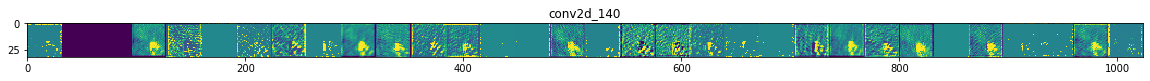

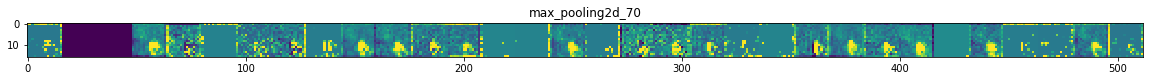

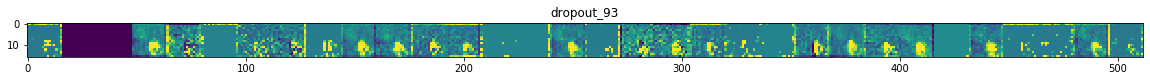

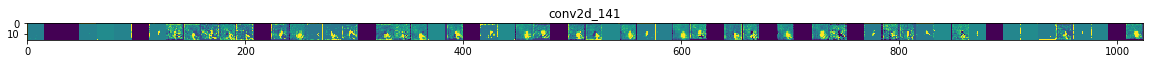

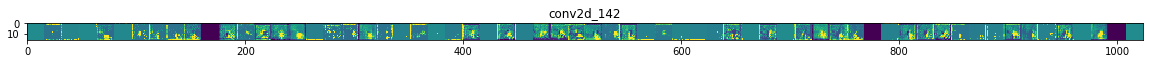

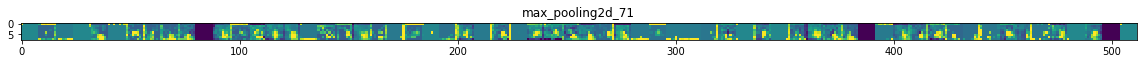

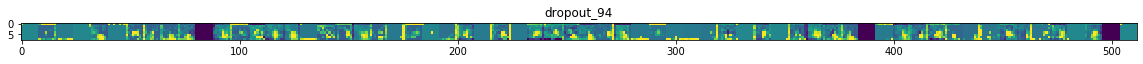

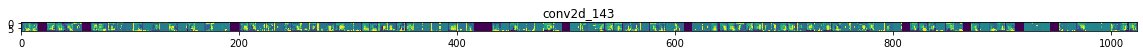

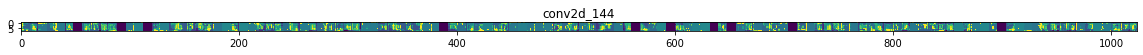

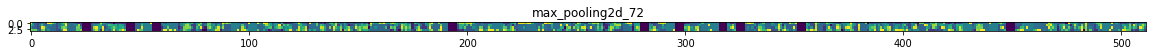

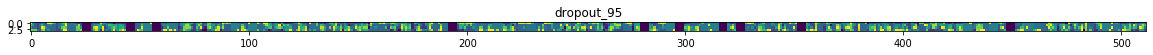

In [38]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(inputs = model.input, outputs = successive_outputs)

img_path = random.choice(test)

img = load_img(img_path, target_size=(32, 32, 3))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        pyplot.figure(figsize=(scale * n_features, scale))
        pyplot.title(layer_name)
        pyplot.grid(False)

        pyplot.imshow(display_grid, aspect='auto')
